In [1]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from keras.models import Model
import cv2

In [2]:
# load json and create model
json_file = open('/home/adity/Desktop/projects/image_search/code/model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/home/adity/Desktop/projects/image_search/code/model/groceries_basic_model_dropout.h5")
print("Loaded model from disk")

Loaded model from disk


In [3]:
model = Model(inputs=loaded_model.input, outputs=loaded_model.get_layer('dense').output)

In [4]:
imageA = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client1/['alberto balsam energize conditioner 250'].jpg")
imageB = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client2/['Alberto Balsam Energize Conditioner 250ml'].jpg")

In [5]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [10]:
def extract(img):
    """
    Extract a deep feature from an input image
    Args:
        img: from PIL.Image.open(path) or tensorflow.keras.preprocessing.image.load_img(path)
    Returns:
        feature (np.ndarray): deep feature with the shape=(4096, )
    """
    img = np.resize(img,(224, 224, 3))  # VGG must take a 224x224 img as an input
    img = Image.fromarray(img, 'RGB')
    x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
    x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
    x = preprocess_input(x)  # Subtracting avg values for each pixel
    feature = model.predict(x)
    return feature / np.linalg.norm(feature)  # Normalize

In [11]:
featureA = extract(img=imageA)
featureB = extract(img=imageB)

In [12]:
print(featureA)

[[0.02183117 0.0445012  0.         ... 0.         0.         0.        ]]


In [13]:
dists = np.linalg.norm(featureA-featureB, axis=1)

In [14]:
dists[0]

0.0

In [15]:
import matplotlib.pyplot as plt

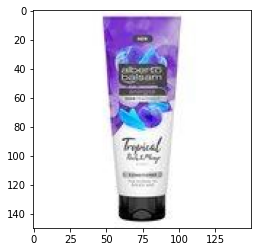

In [16]:
plt.imshow(imageA)

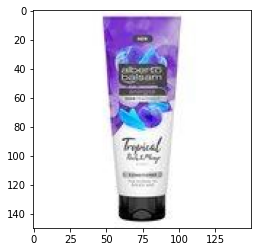

In [17]:
plt.imshow(imageB)

In [18]:
import csv
from enum import Enum
import cv2
import numpy as np
from time import time

In [30]:
class YType(Enum):
    SAME = 0
    DIFFERENT = 1
    NONE = 2

class TestDataStructure:
    clientA = ''
    clientB = ''
    expected_y = YType.NONE
    predicted_y = YType.NONE
    score = -1

In [31]:
class Evaluation:
    def __init__(self, model=None, enable_accuracy=False, enable_auc=False, enable_confusion_matrix=False, enable_precision=False, enable_recall=False):
        self.model = model
        self.enable_accuracy = enable_accuracy
        self.enable_auc = enable_auc
        self.enable_confusion_matrix = enable_confusion_matrix
        self.enable_precision = enable_precision
        self.enable_recall = enable_recall
        self.dataset_path = "/home/adity/Desktop/projects/image_search/datasets/Test Data/"
        # no f1
        
    def prepare_test_Data(self, csv_file):
        list_A = []
        list_B = []
        line_number = 0
        with open(csv_file, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                if line_number == 0:
                    line_number += 1
                else:
                    if row[0] == '':
                        list_A.append(None)
                    else:
                        list_A.append(row[0])
                    
                    if row[1] == '':
                        list_B.append(None)
                    else:
                        list_B.append(row[1])
                    line_number += 1
        print("Processed lines", {line_number})
        return list_A, list_B
    
    def prepare_test_data_Structure(self, list_A, list_B):
        test_data_list = []
        i = 0
        for item_A in list_A:
            j = 0
            for item_B in list_B:
                test_data = TestDataStructure()
                test_data.clientA = list_A[i]
                test_data.clientB = list_B[j]
                if i == j:
                    if list_A[i] and list_B[j]:
                        test_data.expected_y = YType.SAME
                        print("SAME")
                    test_data_list.append(test_data)
                else:
                    if list_A[i] and list_B[j]:
                        test_data.expected_y = YType.DIFFERENT
                        test_data_list.append(test_data)
                j += 1
            i += 1
        return test_data_list
    
    def generate_output_lists(self, test_data_list):
        y_true = []
        y_pred = []
        i = 0
        for test_data in test_data_list:
            y_true.append(test_data.expected_y.value)
            y_pred.append(test_data.predicted_y.value)
            i += 1
        return y_true, y_pred
    
    def get_results_for_all_image_pairs_color(self, test_data_list):
        for test_data in test_data_list:
            if test_data.clientA != None and test_data.clientB != None:
                image_1 = cv2.imread(self.dataset_path + "Client1/" + test_data.clientA)
                image_2 = cv2.imread(self.dataset_path + "Client2/" + test_data.clientB)
                if type(image_1) == np.ndarray and type(image_2) == np.ndarray:
                    image_1 = cv2.resize(image_1, (250,250))
                    image_2 = cv2.resize(image_2, (250,250))
                    tic = time()
                    featureA = extract(img=image_1)
                    featureB = extract(img=image_2)
                    dists = np.linalg.norm(featureA-featureB, axis=1)
                    test_data.score = dists[0]
                    
                    if dists[0] < 0.1:
                        test_data.predicted_y = YType.SAME
                    else: test_data.predicted_y = YType.DIFFERENT
                    
                    toc = time()
                    print(dists[0], test_data.expected_y, toc - tic)


In [23]:
# threshold 0.3
eval_model = Evaluation()
list_A, list_B = eval_model.prepare_test_Data("/home/adity/Desktop/projects/image_search/datasets/Test Data/match.csv")
test_data = eval_model.prepare_test_data_Structure(list_A, list_B)
print(test_data[1].clientA, test_data[1].clientB, test_data[1].expected_y, test_data[1].predicted_y)
print(len(test_data))
eval_model.get_results_for_all_image_pairs_color(test_data)
y_true, y_pred = eval_model.generate_output_lists(test_data)

Processed lines {496}
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAM

1.0626541 YType.DIFFERENT 0.15454363822937012
1.1599442 YType.DIFFERENT 0.15918803215026855
1.1373551 YType.DIFFERENT 0.1568922996520996
1.0033475 YType.DIFFERENT 0.14270615577697754
0.94717497 YType.DIFFERENT 0.1521146297454834
1.0896779 YType.DIFFERENT 0.14311814308166504
1.0896779 YType.DIFFERENT 0.15856409072875977
0.9981337 YType.DIFFERENT 0.14359378814697266
1.1187634 YType.DIFFERENT 0.15577936172485352
0.83153373 YType.DIFFERENT 0.14243268966674805
0.42553163 YType.DIFFERENT 0.15784764289855957
0.6272885 YType.DIFFERENT 0.14368271827697754
0.512181 YType.DIFFERENT 0.15146827697753906
0.42173725 YType.DIFFERENT 0.14595675468444824
0.64103025 YType.DIFFERENT 0.1516280174255371
0.40324354 YType.DIFFERENT 0.17416882514953613
0.6670157 YType.DIFFERENT 0.17605900764465332
0.63587517 YType.DIFFERENT 0.16243529319763184
0.4827398 YType.DIFFERENT 0.14937686920166016
0.30402035 YType.DIFFERENT 0.14800643920898438
0.6989628 YType.DIFFERENT 0.15613818168640137
0.42269695 YType.DIFFERENT 0.1

0.7935504 YType.DIFFERENT 0.15694308280944824
1.164708 YType.DIFFERENT 0.14596199989318848
1.0609231 YType.DIFFERENT 0.15024328231811523
1.0099567 YType.DIFFERENT 0.1552443504333496
0.9060091 YType.DIFFERENT 0.15585732460021973
0.86738044 YType.DIFFERENT 0.14928722381591797
0.7663766 YType.DIFFERENT 0.15200424194335938
0.7128399 YType.DIFFERENT 0.1434788703918457
0.9207788 YType.DIFFERENT 0.1655268669128418
0.9367047 YType.DIFFERENT 0.14461398124694824
0.7788863 YType.DIFFERENT 0.15567302703857422
0.79930544 YType.DIFFERENT 0.14464950561523438
0.7688332 YType.SAME 0.16585707664489746
0.86785114 YType.DIFFERENT 0.1455366611480713
1.0269307 YType.DIFFERENT 0.15594124794006348
1.0221188 YType.DIFFERENT 0.14469242095947266
1.017467 YType.DIFFERENT 0.15326547622680664
0.9889697 YType.DIFFERENT 0.16106319427490234
0.7688332 YType.DIFFERENT 0.15895915031433105
0.8780739 YType.DIFFERENT 0.15099167823791504
1.0632564 YType.DIFFERENT 0.15165090560913086
0.97665405 YType.DIFFERENT 0.1542308330535

0.7802766 YType.DIFFERENT 0.25533008575439453
0.8170315 YType.DIFFERENT 0.2503962516784668
0.8253055 YType.DIFFERENT 0.2381443977355957
0.8253055 YType.DIFFERENT 0.19467782974243164
0.55201715 YType.DIFFERENT 0.1961958408355713
0.5477934 YType.DIFFERENT 0.1945042610168457
0.7303175 YType.DIFFERENT 0.15885424613952637
0.6970525 YType.DIFFERENT 0.15220308303833008
0.9947169 YType.DIFFERENT 0.1895310878753662
0.8170315 YType.DIFFERENT 0.21066665649414062
0.6894769 YType.DIFFERENT 0.15964412689208984
1.0640763 YType.DIFFERENT 0.16824817657470703
1.0143183 YType.DIFFERENT 0.15701651573181152
1.0541271 YType.DIFFERENT 0.15990304946899414
0.7235413 YType.DIFFERENT 0.1528303623199463
0.5066367 YType.DIFFERENT 0.15521979331970215
0.7363412 YType.DIFFERENT 0.14489459991455078
1.2381665 YType.DIFFERENT 0.1527082920074463
1.0606564 YType.DIFFERENT 0.15717196464538574
1.0993723 YType.DIFFERENT 0.16015625
1.1743075 YType.DIFFERENT 0.14623332023620605
0.9707561 YType.DIFFERENT 0.1518871784210205
0.84

0.9035054 YType.DIFFERENT 0.17171907424926758
0.91050345 YType.DIFFERENT 0.14588236808776855
0.94311243 YType.DIFFERENT 0.15181636810302734
0.88277614 YType.DIFFERENT 0.1548776626586914
0.9232811 YType.DIFFERENT 0.17860627174377441
0.99238914 YType.DIFFERENT 0.16674566268920898
0.9275583 YType.DIFFERENT 0.15412235260009766
0.92528296 YType.DIFFERENT 0.14308881759643555
0.86788875 YType.DIFFERENT 0.1503126621246338
0.86788875 YType.DIFFERENT 0.16160178184509277
0.9085647 YType.DIFFERENT 0.15651488304138184
0.88679785 YType.DIFFERENT 0.14486217498779297
0.9426766 YType.DIFFERENT 0.14940333366394043
0.87959427 YType.DIFFERENT 0.15601396560668945
0.8973107 YType.DIFFERENT 0.1601095199584961
0.6772526 YType.DIFFERENT 0.14970016479492188
0.7829137 YType.DIFFERENT 0.151167631149292
0.6898621 YType.DIFFERENT 0.1405937671661377
0.8822062 YType.DIFFERENT 0.16164708137512207
0.92267025 YType.DIFFERENT 0.14771771430969238
0.92086196 YType.DIFFERENT 0.1497640609741211
0.8254249 YType.DIFFERENT 0.14

0.9846278 YType.DIFFERENT 0.15038442611694336
0.97801983 YType.DIFFERENT 0.16015148162841797
0.7632892 YType.DIFFERENT 0.16087031364440918
0.87654465 YType.DIFFERENT 0.14276456832885742
0.7655692 YType.DIFFERENT 0.15477609634399414
0.76374435 YType.DIFFERENT 0.156829833984375
0.9125993 YType.DIFFERENT 0.15816521644592285
0.87522674 YType.DIFFERENT 0.14738798141479492
0.8438942 YType.DIFFERENT 0.17529916763305664
0.8416224 YType.DIFFERENT 0.14363646507263184
1.0304476 YType.DIFFERENT 0.16508030891418457
0.8081383 YType.DIFFERENT 0.15027475357055664
0.8759873 YType.DIFFERENT 0.15462303161621094
1.0604706 YType.DIFFERENT 0.1445636749267578
0.8750815 YType.DIFFERENT 0.16234159469604492
0.95174825 YType.DIFFERENT 0.14708232879638672
1.0382669 YType.DIFFERENT 0.15378689765930176
1.0377206 YType.DIFFERENT 0.14847087860107422
1.0290493 YType.DIFFERENT 0.1448659896850586
1.0664477 YType.DIFFERENT 0.1579878330230713
1.1369938 YType.DIFFERENT 0.16008400917053223
1.13758 YType.DIFFERENT 0.14628481

0.82079583 YType.DIFFERENT 0.19217967987060547
0.7091108 YType.DIFFERENT 0.16319632530212402
0.64683115 YType.DIFFERENT 0.14705324172973633
0.845439 YType.DIFFERENT 0.15691399574279785
1.2108822 YType.DIFFERENT 0.22228193283081055
0.8191917 YType.DIFFERENT 0.1887216567993164
0.81346196 YType.DIFFERENT 0.5407426357269287
0.8732797 YType.DIFFERENT 0.2050628662109375
0.845439 YType.DIFFERENT 0.1766059398651123
0.81953937 YType.DIFFERENT 0.14623737335205078
0.88206995 YType.DIFFERENT 0.14737653732299805
0.8894618 YType.DIFFERENT 0.14349007606506348
0.8688712 YType.DIFFERENT 0.1503748893737793
0.8012959 YType.DIFFERENT 0.14491891860961914
0.84304017 YType.DIFFERENT 0.15052390098571777
0.9259142 YType.DIFFERENT 0.15233635902404785
0.97159976 YType.DIFFERENT 0.13763642311096191
0.7628194 YType.DIFFERENT 0.17087483406066895
0.6987164 YType.DIFFERENT 0.15627098083496094
0.848676 YType.DIFFERENT 0.16089415550231934
0.83394265 YType.DIFFERENT 0.16045379638671875
0.9483516 YType.DIFFERENT 0.149786

1.1024011 YType.DIFFERENT 0.18527507781982422
1.039152 YType.DIFFERENT 0.19338774681091309
1.0394104 YType.DIFFERENT 0.16570234298706055
1.0394104 YType.DIFFERENT 0.138214111328125
0.9733873 YType.DIFFERENT 0.144881010055542
0.63808435 YType.DIFFERENT 0.15381646156311035
1.0630771 YType.DIFFERENT 0.1425786018371582
1.0556564 YType.DIFFERENT 0.14915704727172852
0.78598493 YType.DIFFERENT 0.15128231048583984
1.0911292 YType.DIFFERENT 0.23523449897766113
1.0390973 YType.DIFFERENT 0.1586132049560547
0.92246515 YType.DIFFERENT 0.149428129196167
0.9619082 YType.DIFFERENT 0.13893461227416992
0.85507864 YType.DIFFERENT 0.14149141311645508
0.85982394 YType.DIFFERENT 0.1396784782409668
0.83730483 YType.DIFFERENT 0.13736271858215332
0.92690146 YType.DIFFERENT 0.1419661045074463
0.90405375 YType.DIFFERENT 0.13729143142700195
0.81961685 YType.DIFFERENT 0.14615869522094727
0.8330207 YType.DIFFERENT 0.14263653755187988
0.8801213 YType.DIFFERENT 0.14162611961364746
1.2236919 YType.DIFFERENT 0.14078736

1.0354204 YType.DIFFERENT 0.13493013381958008
1.0281353 YType.DIFFERENT 0.16353154182434082
0.98169136 YType.DIFFERENT 0.1486372947692871
0.98305875 YType.DIFFERENT 0.14662575721740723
0.92620397 YType.DIFFERENT 0.14127779006958008
0.8441513 YType.DIFFERENT 0.142960786819458
0.6317199 YType.DIFFERENT 0.1397557258605957
0.55802596 YType.DIFFERENT 0.1466062068939209
1.1199573 YType.DIFFERENT 0.1520857810974121
1.1274002 YType.DIFFERENT 0.15345335006713867
1.1592877 YType.DIFFERENT 0.15848445892333984
1.1599369 YType.DIFFERENT 0.15702033042907715
0.9625069 YType.DIFFERENT 0.16241455078125
1.01087 YType.DIFFERENT 0.13736653327941895
0.4186572 YType.DIFFERENT 0.16244292259216309
0.46007535 YType.DIFFERENT 0.14644455909729004
1.0855211 YType.DIFFERENT 0.15319085121154785
0.9690606 YType.DIFFERENT 0.13787055015563965
0.9421782 YType.DIFFERENT 0.13844633102416992
0.7938831 YType.DIFFERENT 0.1467292308807373
0.8574196 YType.DIFFERENT 0.14922642707824707
0.6197181 YType.DIFFERENT 0.1386380195617

1.230949 YType.DIFFERENT 0.16235065460205078
1.2265797 YType.DIFFERENT 0.19397854804992676
1.159751 YType.DIFFERENT 0.18193745613098145
0.8969542 YType.DIFFERENT 0.16408467292785645
0.5914487 YType.DIFFERENT 0.19458484649658203
0.9558293 YType.DIFFERENT 0.16129732131958008
0.8759413 YType.DIFFERENT 0.15329194068908691
0.9775556 YType.DIFFERENT 0.21666860580444336
0.9980987 YType.DIFFERENT 0.240861177444458
1.0952303 YType.DIFFERENT 0.25182580947875977
1.0927947 YType.DIFFERENT 0.2662968635559082
1.0249326 YType.DIFFERENT 0.2502741813659668
1.1328793 YType.DIFFERENT 0.23601460456848145
1.1008084 YType.DIFFERENT 0.23826932907104492
1.0238959 YType.DIFFERENT 0.23024249076843262
0.7883056 YType.DIFFERENT 0.2307600975036621
0.828984 YType.DIFFERENT 0.224015474319458
1.0384153 YType.DIFFERENT 0.2468256950378418
0.87323445 YType.DIFFERENT 0.23332571983337402
1.0116976 YType.DIFFERENT 0.2912895679473877
0.9891009 YType.DIFFERENT 0.28394317626953125
0.95956635 YType.DIFFERENT 0.2082915306091308

1.1076719 YType.DIFFERENT 0.2368030548095703
1.1277779 YType.DIFFERENT 0.23398447036743164
1.1277779 YType.DIFFERENT 0.19379472732543945
1.0267692 YType.DIFFERENT 0.17921686172485352
1.1150258 YType.DIFFERENT 0.22614216804504395
1.1355695 YType.DIFFERENT 0.1789722442626953
1.2336819 YType.DIFFERENT 0.1857001781463623
0.82628256 YType.DIFFERENT 0.16197419166564941
0.9576128 YType.DIFFERENT 0.17377591133117676
1.0692624 YType.DIFFERENT 0.38952040672302246
0.9764077 YType.DIFFERENT 0.28147172927856445
0.5922787 YType.DIFFERENT 0.23216891288757324
0.96154326 YType.DIFFERENT 0.20847105979919434
0.7026654 YType.DIFFERENT 0.19445562362670898
0.97415423 YType.DIFFERENT 0.18384909629821777
0.73842937 YType.DIFFERENT 0.18453598022460938
1.0949934 YType.DIFFERENT 0.16809368133544922
0.62515324 YType.DIFFERENT 0.19328069686889648
1.0874571 YType.DIFFERENT 0.18343019485473633
1.0944436 YType.DIFFERENT 0.17344164848327637
1.0944436 YType.DIFFERENT 0.16953063011169434
1.0944436 YType.DIFFERENT 0.1766

0.7266575 YType.DIFFERENT 0.17696475982666016
0.73333657 YType.DIFFERENT 0.16205430030822754
0.74446225 YType.DIFFERENT 0.16524863243103027
0.88455564 YType.DIFFERENT 0.17818593978881836
0.9308067 YType.DIFFERENT 0.19251561164855957
0.6954102 YType.DIFFERENT 0.1875154972076416
0.69639754 YType.DIFFERENT 0.1874103546142578
0.8786095 YType.DIFFERENT 0.17505359649658203
0.7156411 YType.DIFFERENT 0.17876243591308594
0.94888186 YType.DIFFERENT 0.18343520164489746
0.7605275 YType.DIFFERENT 0.17677927017211914
0.8610811 YType.DIFFERENT 0.17081046104431152
0.7110959 YType.DIFFERENT 0.1760098934173584
0.83874255 YType.DIFFERENT 0.18677186965942383
0.8020361 YType.DIFFERENT 0.1676619052886963
0.7950466 YType.DIFFERENT 0.16742849349975586
0.8676509 YType.DIFFERENT 0.19875788688659668
0.7077784 YType.DIFFERENT 0.1692368984222412
0.75548583 YType.DIFFERENT 0.2002882957458496
0.86055136 YType.DIFFERENT 0.16319561004638672
0.79320085 YType.DIFFERENT 0.18625354766845703
0.86477613 YType.DIFFERENT 0.17

1.1564243 YType.DIFFERENT 0.18590068817138672
1.1577755 YType.DIFFERENT 0.19344139099121094
1.1187658 YType.DIFFERENT 0.1913309097290039
1.1577755 YType.DIFFERENT 0.1650381088256836
1.1187658 YType.DIFFERENT 0.18524885177612305
0.93742156 YType.DIFFERENT 0.17828679084777832
1.1077507 YType.DIFFERENT 0.19129681587219238
1.1077507 YType.DIFFERENT 0.1916484832763672
1.1545898 YType.DIFFERENT 0.19565343856811523
1.0991446 YType.DIFFERENT 0.20083951950073242
1.124592 YType.DIFFERENT 0.17894434928894043
0.89337116 YType.DIFFERENT 0.18180131912231445
1.0072865 YType.DIFFERENT 0.18270540237426758
1.0072865 YType.DIFFERENT 0.17812705039978027
1.0770904 YType.DIFFERENT 0.17135834693908691
1.1398973 YType.DIFFERENT 0.17061495780944824
0.91199297 YType.DIFFERENT 0.20302629470825195
0.6574778 YType.DIFFERENT 0.16455411911010742
1.0100334 YType.DIFFERENT 0.17435312271118164
0.55916715 YType.DIFFERENT 0.17710542678833008
0.65134627 YType.DIFFERENT 0.19141101837158203
0.78639436 YType.DIFFERENT 0.1976

0.70346934 YType.DIFFERENT 0.32802867889404297
0.624196 YType.DIFFERENT 0.299180269241333
0.4823435 YType.DIFFERENT 0.2660965919494629
0.59952986 YType.DIFFERENT 0.2255551815032959
0.6056961 YType.DIFFERENT 0.28376245498657227
0.78416795 YType.DIFFERENT 0.18543100357055664
0.736739 YType.DIFFERENT 0.2303791046142578
1.2497337 YType.DIFFERENT 0.16944384574890137
1.0861104 YType.DIFFERENT 0.30577516555786133
0.8461576 YType.DIFFERENT 0.26887965202331543
0.7536467 YType.DIFFERENT 0.21140694618225098
0.54812336 YType.DIFFERENT 0.2357325553894043
1.0522896 YType.DIFFERENT 0.17381048202514648
0.7949377 YType.DIFFERENT 0.18869638442993164
0.5470215 YType.DIFFERENT 0.28720903396606445
0.5523011 YType.DIFFERENT 0.17170453071594238
1.0448627 YType.DIFFERENT 0.18677043914794922
1.087509 YType.DIFFERENT 0.2170557975769043
1.1760815 YType.DIFFERENT 0.2163698673248291
0.9624342 YType.DIFFERENT 0.20616650581359863
0.7346057 YType.DIFFERENT 0.24390077590942383
0.2119597 YType.DIFFERENT 0.1784260272979

0.75231504 YType.DIFFERENT 0.17842364311218262
1.1229289 YType.DIFFERENT 0.18675565719604492
0.57568216 YType.DIFFERENT 0.19353294372558594
0.6722507 YType.DIFFERENT 0.18076205253601074
0.91857845 YType.DIFFERENT 0.18429231643676758
0.75231504 YType.DIFFERENT 0.21086573600769043
0.9466474 YType.DIFFERENT 0.18408751487731934
0.9324927 YType.DIFFERENT 0.2009434700012207
0.9324927 YType.DIFFERENT 0.1680290699005127
1.0953938 YType.DIFFERENT 0.19912075996398926
0.9017777 YType.DIFFERENT 0.20988011360168457
0.9960531 YType.DIFFERENT 0.1975255012512207
0.87426764 YType.DIFFERENT 0.18416476249694824
0.68358 YType.DIFFERENT 0.16801738739013672
0.9466474 YType.DIFFERENT 0.21087169647216797
1.2319839 YType.DIFFERENT 0.16599750518798828
0.20771994 YType.DIFFERENT 0.18267297744750977
0.36173382 YType.DIFFERENT 0.16313552856445312
0.2714036 YType.DIFFERENT 0.17207932472229004
1.1302372 YType.DIFFERENT 0.18171072006225586
1.1515803 YType.DIFFERENT 0.18172526359558105
1.2476214 YType.DIFFERENT 0.1846

0.9114463 YType.DIFFERENT 0.19072461128234863
0.62416685 YType.DIFFERENT 0.22638607025146484
0.66003025 YType.DIFFERENT 0.19722700119018555
0.98996615 YType.DIFFERENT 0.19628095626831055
0.9596247 YType.DIFFERENT 0.17743587493896484
1.0303661 YType.DIFFERENT 0.18766450881958008
0.9641468 YType.DIFFERENT 0.17989420890808105
1.0390238 YType.DIFFERENT 0.1833488941192627
1.0443274 YType.DIFFERENT 0.17887163162231445
1.1087961 YType.DIFFERENT 0.1803429126739502
1.1042013 YType.DIFFERENT 0.18061065673828125
1.1206254 YType.DIFFERENT 0.19122004508972168
1.126454 YType.DIFFERENT 0.19375967979431152
0.58922213 YType.DIFFERENT 0.18997883796691895
0.58922213 YType.DIFFERENT 0.20273852348327637
1.0756462 YType.DIFFERENT 0.1832599639892578
1.0573918 YType.DIFFERENT 0.2691340446472168
1.0918832 YType.DIFFERENT 0.2054750919342041
1.0805863 YType.DIFFERENT 0.19573307037353516
1.0740522 YType.DIFFERENT 0.20024800300598145
1.0726608 YType.DIFFERENT 0.20051789283752441
1.0850639 YType.DIFFERENT 0.1914634

0.5053072 YType.DIFFERENT 0.1888277530670166
0.7154079 YType.DIFFERENT 0.16573238372802734
0.71473384 YType.DIFFERENT 0.16791987419128418
0.7131563 YType.DIFFERENT 0.16467595100402832
0.5737675 YType.DIFFERENT 0.16982793807983398
0.6828958 YType.DIFFERENT 0.1686553955078125
0.84936863 YType.DIFFERENT 0.17020368576049805
0.96076626 YType.DIFFERENT 0.18695688247680664
0.96321136 YType.DIFFERENT 0.18296432495117188
0.699788 YType.DIFFERENT 0.18700695037841797
0.8484735 YType.DIFFERENT 0.18123841285705566
0.9237092 YType.DIFFERENT 0.16822242736816406
0.93687737 YType.DIFFERENT 0.17182660102844238
0.83650017 YType.DIFFERENT 0.19272184371948242
0.90750885 YType.DIFFERENT 0.19904184341430664
0.95234495 YType.DIFFERENT 0.18629074096679688
0.90983015 YType.DIFFERENT 0.18275022506713867
0.95179707 YType.DIFFERENT 0.17704200744628906
0.696127 YType.DIFFERENT 0.21215152740478516
0.63930357 YType.DIFFERENT 0.19233202934265137
0.6388244 YType.DIFFERENT 0.19156289100646973
0.79638326 YType.DIFFERENT 

1.0867248 YType.DIFFERENT 0.18078923225402832
1.1729791 YType.DIFFERENT 0.19631481170654297
1.0425147 YType.DIFFERENT 0.18996882438659668
1.0803922 YType.DIFFERENT 0.20144033432006836
1.0942179 YType.DIFFERENT 0.2000589370727539
1.0416974 YType.DIFFERENT 0.22697949409484863
1.0310904 YType.DIFFERENT 0.24586749076843262
1.1182357 YType.DIFFERENT 0.2073211669921875
1.1988372 YType.DIFFERENT 0.1961536407470703
1.0899606 YType.DIFFERENT 0.2471766471862793
1.0892681 YType.DIFFERENT 0.29198193550109863
1.1451191 YType.DIFFERENT 0.18479156494140625
1.1182357 YType.DIFFERENT 0.17892837524414062
1.0906523 YType.DIFFERENT 0.18733620643615723
1.1373013 YType.DIFFERENT 0.19768619537353516
1.1054757 YType.DIFFERENT 0.18106865882873535
1.0993284 YType.DIFFERENT 0.17732858657836914
1.0813371 YType.DIFFERENT 0.1674027442932129
1.1295925 YType.DIFFERENT 0.1909477710723877
1.1846541 YType.DIFFERENT 0.18067097663879395
1.216768 YType.DIFFERENT 0.19156193733215332
1.1025838 YType.DIFFERENT 0.1936354637145

1.0409368 YType.DIFFERENT 0.18838763236999512
1.0298513 YType.DIFFERENT 0.20730018615722656
1.1248797 YType.DIFFERENT 0.22519731521606445
1.1263659 YType.DIFFERENT 0.20956993103027344
1.2066944 YType.DIFFERENT 0.18478798866271973
1.2065064 YType.DIFFERENT 0.18939709663391113
1.2065064 YType.DIFFERENT 0.18057966232299805
1.0109347 YType.DIFFERENT 0.1979532241821289
1.0007254 YType.DIFFERENT 0.19246387481689453
1.2008924 YType.DIFFERENT 0.19815421104431152
1.2009965 YType.DIFFERENT 0.1732633113861084
1.1504607 YType.DIFFERENT 0.19435906410217285
0.9951535 YType.DIFFERENT 0.1600801944732666
0.86077493 YType.DIFFERENT 0.18825578689575195
1.1493884 YType.DIFFERENT 0.18260979652404785
1.0910813 YType.DIFFERENT 0.17537450790405273
1.0604064 YType.DIFFERENT 0.16538453102111816
1.08211 YType.DIFFERENT 0.1838371753692627
1.1189759 YType.DIFFERENT 0.18107390403747559
1.1672465 YType.DIFFERENT 0.19943809509277344
1.0436038 YType.DIFFERENT 0.16988635063171387
1.0765625 YType.DIFFERENT 0.19318127632

0.64056575 YType.DIFFERENT 0.19118118286132812
0.64300597 YType.DIFFERENT 0.1762688159942627
0.64300597 YType.DIFFERENT 0.17585039138793945
0.9642004 YType.DIFFERENT 0.19547128677368164
0.7995128 YType.DIFFERENT 0.17563843727111816
0.85393506 YType.DIFFERENT 0.19029021263122559
0.57673544 YType.DIFFERENT 0.19098567962646484
0.753611 YType.DIFFERENT 0.17006611824035645
0.7269921 YType.DIFFERENT 0.18702459335327148
0.5982838 YType.DIFFERENT 0.17759156227111816
0.641094 YType.DIFFERENT 0.20319223403930664
1.042683 YType.DIFFERENT 0.1754472255706787
1.1191175 YType.DIFFERENT 0.18105649948120117
0.856128 YType.DIFFERENT 0.18293213844299316
0.96557814 YType.DIFFERENT 0.2108628749847412
0.73142785 YType.DIFFERENT 0.1640937328338623
0.74360144 YType.DIFFERENT 0.1764659881591797
0.89251745 YType.DIFFERENT 0.16921067237854004
0.9145325 YType.DIFFERENT 0.17613911628723145
0.76099145 YType.DIFFERENT 0.1839756965637207
0.62375116 YType.DIFFERENT 0.19115900993347168
0.9450744 YType.DIFFERENT 0.19552

0.7289679 YType.DIFFERENT 0.19533109664916992
0.69123703 YType.DIFFERENT 0.19702863693237305
0.8995264 YType.DIFFERENT 0.1953442096710205
0.82412225 YType.DIFFERENT 0.20024418830871582
1.1513534 YType.DIFFERENT 0.18768882751464844
1.172631 YType.DIFFERENT 0.176466703414917
1.0966511 YType.DIFFERENT 0.17853116989135742
0.65683144 YType.DIFFERENT 0.17721986770629883
1.0160363 YType.DIFFERENT 0.17474770545959473
0.6576832 YType.DIFFERENT 0.188385009765625
0.53346133 YType.DIFFERENT 0.16613984107971191
0.88619167 YType.DIFFERENT 0.1839437484741211
0.8722646 YType.DIFFERENT 0.17139601707458496
0.7797768 YType.DIFFERENT 0.1792457103729248
0.65001804 YType.DIFFERENT 0.1704702377319336
0.56821233 YType.DIFFERENT 0.2000439167022705
0.74264246 YType.DIFFERENT 0.16894936561584473
0.67762434 YType.DIFFERENT 0.17823266983032227
0.80022067 YType.DIFFERENT 0.20705747604370117
0.89203715 YType.DIFFERENT 0.1813647747039795
0.9457212 YType.DIFFERENT 0.19599461555480957
0.8635989 YType.DIFFERENT 0.174940

0.7704932 YType.DIFFERENT 0.19036149978637695
0.7731736 YType.DIFFERENT 0.16176843643188477
0.7397684 YType.DIFFERENT 0.20702385902404785
1.0026238 YType.DIFFERENT 0.22612547874450684
1.0239483 YType.DIFFERENT 0.1947934627532959
1.0239483 YType.DIFFERENT 0.17546463012695312
0.8235963 YType.DIFFERENT 0.18530583381652832
1.0408815 YType.DIFFERENT 0.18464994430541992
1.092122 YType.DIFFERENT 0.19503402709960938
1.1934562 YType.DIFFERENT 0.18487000465393066
0.8177884 YType.DIFFERENT 0.17579269409179688
0.72304976 YType.DIFFERENT 0.19522500038146973
0.9179385 YType.DIFFERENT 0.18033051490783691
0.8195578 YType.DIFFERENT 0.21649885177612305
0.6736329 YType.DIFFERENT 0.18091511726379395
0.8482849 YType.DIFFERENT 0.2007761001586914
0.7454272 YType.DIFFERENT 0.1899559497833252
0.9382291 YType.DIFFERENT 0.20055747032165527
0.7687132 YType.DIFFERENT 0.185272216796875
0.9600529 YType.DIFFERENT 0.19999480247497559
0.6335879 YType.DIFFERENT 0.19440913200378418
0.94194615 YType.DIFFERENT 0.2024545669

0.7953971 YType.DIFFERENT 0.20352506637573242
1.0914432 YType.DIFFERENT 0.20580124855041504
1.0570366 YType.DIFFERENT 0.1992506980895996
0.81862354 YType.DIFFERENT 0.21053004264831543
0.8279453 YType.DIFFERENT 0.21291279792785645
0.79526454 YType.DIFFERENT 0.2199864387512207
0.85470724 YType.DIFFERENT 0.18609166145324707
0.90941256 YType.DIFFERENT 0.2383882999420166
0.5967661 YType.DIFFERENT 0.22119450569152832
0.7824705 YType.DIFFERENT 0.22371625900268555
0.9407708 YType.DIFFERENT 0.22809886932373047
0.78724736 YType.DIFFERENT 0.2174687385559082
0.9421674 YType.DIFFERENT 0.21694588661193848
0.91286075 YType.DIFFERENT 0.21969223022460938
0.8657594 YType.DIFFERENT 0.19699883460998535
0.8407152 YType.DIFFERENT 0.21608495712280273
0.90524787 YType.DIFFERENT 0.1948714256286621
0.87094134 YType.DIFFERENT 0.1993570327758789
0.8759767 YType.DIFFERENT 0.21550559997558594
0.871799 YType.DIFFERENT 0.20413851737976074
0.8830624 YType.DIFFERENT 0.2182760238647461
0.9121495 YType.DIFFERENT 0.242640

1.1453816 YType.DIFFERENT 0.20742225646972656
1.1140165 YType.DIFFERENT 0.19420933723449707
1.1661198 YType.DIFFERENT 0.20082473754882812
1.1661198 YType.DIFFERENT 0.20381498336791992
1.1692744 YType.DIFFERENT 0.20274019241333008
1.1798552 YType.DIFFERENT 0.21102404594421387
1.1692744 YType.DIFFERENT 0.19643521308898926
1.1798552 YType.DIFFERENT 0.2145373821258545
0.93159795 YType.DIFFERENT 0.18707799911499023
1.1489793 YType.DIFFERENT 0.20892119407653809
1.1489793 YType.DIFFERENT 0.20510292053222656
1.094118 YType.DIFFERENT 0.20055675506591797
1.0885615 YType.DIFFERENT 0.21225762367248535
1.1553627 YType.DIFFERENT 0.22285699844360352
0.9593779 YType.DIFFERENT 0.24419736862182617
1.0467088 YType.DIFFERENT 0.19748926162719727
1.0467088 YType.DIFFERENT 0.28658604621887207
1.165316 YType.DIFFERENT 0.20859956741333008
1.2116548 YType.DIFFERENT 0.19321918487548828
1.0498984 YType.DIFFERENT 0.19941020011901855
0.59794044 YType.DIFFERENT 0.1898345947265625
0.9582187 YType.DIFFERENT 0.20803809

0.7754918 YType.DIFFERENT 0.2110288143157959
0.40651706 YType.DIFFERENT 0.19724774360656738
0.77559316 YType.DIFFERENT 0.21938204765319824
0.79743856 YType.DIFFERENT 0.18184351921081543
0.8206493 YType.DIFFERENT 0.23262596130371094
0.29129326 YType.DIFFERENT 0.1857142448425293
0.5142421 YType.DIFFERENT 0.21229767799377441
0.5117599 YType.DIFFERENT 0.20831608772277832
0.4105715 YType.DIFFERENT 0.2357790470123291
0.7262995 YType.DIFFERENT 0.20099449157714844
1.2211947 YType.DIFFERENT 0.23047709465026855
0.9281146 YType.DIFFERENT 0.22670483589172363
0.68805057 YType.DIFFERENT 0.20724964141845703
0.48281172 YType.DIFFERENT 0.21436285972595215
0.24280243 YType.DIFFERENT 0.1959819793701172
0.8459249 YType.DIFFERENT 0.20397257804870605
0.47912472 YType.DIFFERENT 0.18890595436096191
0.32156274 YType.DIFFERENT 0.22325825691223145
0.27864864 YType.DIFFERENT 0.19688057899475098
0.8149124 YType.DIFFERENT 0.2000422477722168
0.8903098 YType.DIFFERENT 0.18485140800476074
1.1319964 YType.DIFFERENT 0.2

0.66396755 YType.DIFFERENT 0.21786212921142578
0.72778094 YType.DIFFERENT 0.21477818489074707
0.99104244 YType.DIFFERENT 0.22468209266662598
0.89580023 YType.DIFFERENT 0.20529794692993164
0.76382476 YType.DIFFERENT 0.23488497734069824
1.1021156 YType.DIFFERENT 0.20954513549804688
0.61318237 YType.DIFFERENT 0.2161118984222412
0.59777135 YType.DIFFERENT 0.2619037628173828
0.90867645 YType.DIFFERENT 0.24464797973632812
0.76382476 YType.DIFFERENT 0.2514688968658447
0.9294672 YType.DIFFERENT 0.23284530639648438
0.9225925 YType.DIFFERENT 0.21454191207885742
0.9225925 YType.DIFFERENT 0.2126150131225586
1.0558732 YType.DIFFERENT 0.20139217376708984
0.93868345 YType.DIFFERENT 0.23166942596435547
0.92973894 YType.DIFFERENT 0.21442723274230957
0.87777156 YType.DIFFERENT 0.24342131614685059
0.6501483 YType.DIFFERENT 0.22330522537231445
0.9294672 YType.DIFFERENT 0.21561765670776367
1.1467502 YType.DIFFERENT 0.2269439697265625
0.5595684 YType.DIFFERENT 0.22439193725585938
0.66694117 YType.DIFFERENT 

0.47751307 YType.DIFFERENT 0.24011874198913574
0.31892532 YType.DIFFERENT 0.21607327461242676
0.0 YType.SAME 0.19689512252807617
1.0363945 YType.DIFFERENT 0.2063887119293213
0.9620469 YType.DIFFERENT 0.1911473274230957
1.0363945 YType.DIFFERENT 0.21812796592712402
0.5748437 YType.DIFFERENT 0.18628621101379395
0.7771003 YType.DIFFERENT 0.19738101959228516
0.7256339 YType.DIFFERENT 0.23947572708129883
0.8078626 YType.DIFFERENT 0.2136521339416504
0.7808961 YType.DIFFERENT 0.1929616928100586
0.86424524 YType.DIFFERENT 0.2070615291595459
0.61470217 YType.DIFFERENT 0.2073652744293213
0.7476695 YType.DIFFERENT 0.1995549201965332
0.7989061 YType.DIFFERENT 0.23760557174682617
0.75605077 YType.DIFFERENT 0.2507929801940918
0.8422409 YType.DIFFERENT 0.2250041961669922
0.63037384 YType.DIFFERENT 0.20780277252197266
0.63037384 YType.DIFFERENT 0.20663189888000488
0.7168439 YType.DIFFERENT 0.20498323440551758
0.72677976 YType.DIFFERENT 0.19536495208740234
0.8123158 YType.DIFFERENT 0.19793152809143066


0.55560374 YType.DIFFERENT 0.23491382598876953
0.6751643 YType.DIFFERENT 0.19160771369934082
1.1115074 YType.DIFFERENT 0.20525908470153809
1.1074687 YType.DIFFERENT 0.21445655822753906
1.2527913 YType.DIFFERENT 0.20770692825317383
0.98371565 YType.DIFFERENT 0.24810338020324707
0.454602 YType.DIFFERENT 0.20878386497497559
0.4548412 YType.DIFFERENT 0.19834017753601074
0.4546438 YType.DIFFERENT 0.19549155235290527
0.5474865 YType.DIFFERENT 0.2222275733947754
0.75273186 YType.DIFFERENT 0.2098531723022461
0.5848641 YType.DIFFERENT 0.19452381134033203
0.71340555 YType.DIFFERENT 0.2006535530090332
0.7164972 YType.DIFFERENT 0.18593573570251465
0.65449375 YType.DIFFERENT 0.21359610557556152
0.58428645 YType.DIFFERENT 0.18728137016296387
0.8050459 YType.DIFFERENT 0.23927760124206543
0.80553997 YType.DIFFERENT 0.2237534523010254
0.80130345 YType.DIFFERENT 0.21538519859313965
0.9133284 YType.DIFFERENT 0.21809697151184082
1.1300011 YType.DIFFERENT 0.1968669891357422
1.1163061 YType.DIFFERENT 0.2172

0.8934938 YType.DIFFERENT 0.22628426551818848
0.8196727 YType.DIFFERENT 0.20955801010131836
0.8135638 YType.DIFFERENT 0.2325587272644043
0.6509879 YType.DIFFERENT 0.2173295021057129
0.9253518 YType.DIFFERENT 0.2341783046722412
0.9469184 YType.DIFFERENT 0.18824267387390137
0.9759339 YType.DIFFERENT 0.22051739692687988
0.7381944 YType.DIFFERENT 0.19954419136047363
0.878736 YType.DIFFERENT 0.22518205642700195
0.9720032 YType.DIFFERENT 0.18529105186462402
0.9324363 YType.DIFFERENT 0.23204517364501953
0.9029307 YType.DIFFERENT 0.23275041580200195
0.99820006 YType.DIFFERENT 0.2547903060913086
1.2134191 YType.DIFFERENT 0.253612756729126
0.9674992 YType.DIFFERENT 0.18395233154296875
0.9613454 YType.DIFFERENT 0.22052288055419922
1.0464272 YType.DIFFERENT 0.17767906188964844
0.99820006 YType.DIFFERENT 0.23921585083007812
0.9684421 YType.DIFFERENT 0.18035578727722168
1.0224345 YType.DIFFERENT 0.21472716331481934
0.87487954 YType.DIFFERENT 0.20031118392944336
0.8783763 YType.DIFFERENT 0.2179100513

0.8892455 YType.DIFFERENT 0.21686410903930664
0.8790379 YType.DIFFERENT 0.23055267333984375
0.8787807 YType.DIFFERENT 0.18991899490356445
0.86195195 YType.DIFFERENT 0.2115483283996582
0.7861885 YType.DIFFERENT 0.2006211280822754
0.88125587 YType.DIFFERENT 0.22514009475708008
0.83332133 YType.DIFFERENT 0.22274327278137207
0.88171 YType.DIFFERENT 0.2092432975769043
0.89122784 YType.DIFFERENT 0.19211435317993164
0.945557 YType.DIFFERENT 0.2090599536895752
0.9434891 YType.DIFFERENT 0.21328115463256836
0.9434891 YType.DIFFERENT 0.19708824157714844
0.63839 YType.DIFFERENT 0.2068772315979004
0.84928024 YType.DIFFERENT 0.19551920890808105
1.0941002 YType.DIFFERENT 0.20026564598083496
1.0948201 YType.DIFFERENT 0.24871516227722168
0.94759315 YType.DIFFERENT 0.20713376998901367
0.9299111 YType.DIFFERENT 0.20298480987548828
0.7170392 YType.DIFFERENT 0.1940011978149414
0.9763433 YType.DIFFERENT 0.22083091735839844
1.0442966 YType.DIFFERENT 0.18938064575195312
0.96166503 YType.DIFFERENT 0.2030086517

0.6315509 YType.DIFFERENT 0.21266603469848633
0.98973805 YType.DIFFERENT 0.18662190437316895
0.98436373 YType.DIFFERENT 0.21190381050109863
0.98436373 YType.DIFFERENT 0.20148611068725586
1.0857038 YType.DIFFERENT 0.20675945281982422
1.0483935 YType.DIFFERENT 0.20327401161193848
0.9813989 YType.DIFFERENT 0.18540358543395996
0.9695135 YType.DIFFERENT 0.24261140823364258
0.9695135 YType.DIFFERENT 0.20534658432006836
0.7323844 YType.DIFFERENT 0.21999192237854004
0.6478895 YType.DIFFERENT 0.20344042778015137
0.8298309 YType.DIFFERENT 0.24314022064208984
0.7694454 YType.DIFFERENT 0.223921537399292
1.0124985 YType.DIFFERENT 0.21656060218811035
1.0566679 YType.DIFFERENT 0.2069399356842041
1.0321134 YType.DIFFERENT 0.19263219833374023
1.033214 YType.DIFFERENT 0.20778751373291016
0.80888325 YType.DIFFERENT 0.22452163696289062
0.87010384 YType.DIFFERENT 0.2122025489807129
0.8387362 YType.DIFFERENT 0.20574188232421875
1.0220824 YType.DIFFERENT 0.21655035018920898
0.7409435 YType.DIFFERENT 0.210460

0.8616018 YType.DIFFERENT 0.20509934425354004
1.2313573 YType.DIFFERENT 0.1904292106628418
0.8331423 YType.DIFFERENT 0.19567513465881348
0.69480646 YType.DIFFERENT 0.19761276245117188
0.7609309 YType.DIFFERENT 0.18641877174377441
0.7257674 YType.DIFFERENT 0.21178507804870605
0.8423357 YType.DIFFERENT 0.19748783111572266
0.82214403 YType.DIFFERENT 0.1859591007232666
0.76913 YType.DIFFERENT 0.7033414840698242
0.857207 YType.DIFFERENT 0.2118973731994629
1.1036965 YType.DIFFERENT 0.19896793365478516
1.1372169 YType.DIFFERENT 0.2254161834716797
1.0374577 YType.DIFFERENT 0.21261143684387207
0.7869694 YType.DIFFERENT 0.20363354682922363
1.1177471 YType.DIFFERENT 0.2167186737060547
0.76753306 YType.DIFFERENT 0.2249922752380371
0.32592052 YType.DIFFERENT 0.1851663589477539
0.8002271 YType.DIFFERENT 0.23037433624267578
0.7118103 YType.DIFFERENT 0.18279743194580078
0.70401675 YType.DIFFERENT 0.18733525276184082
0.8475978 YType.DIFFERENT 0.1779780387878418
0.88016057 YType.DIFFERENT 0.194168090820

0.92433566 YType.DIFFERENT 0.2057962417602539
1.0085543 YType.DIFFERENT 0.20546674728393555
0.72479814 YType.DIFFERENT 0.217848539352417
0.66539246 YType.DIFFERENT 0.1949751377105713
1.0295408 YType.DIFFERENT 0.19607138633728027
1.0187095 YType.DIFFERENT 0.19835305213928223
1.0081779 YType.DIFFERENT 0.18832612037658691
1.0195751 YType.DIFFERENT 0.1928420066833496
1.0151032 YType.DIFFERENT 0.22923612594604492
1.0952837 YType.DIFFERENT 0.22255158424377441
1.0420973 YType.DIFFERENT 0.19046473503112793
1.0420973 YType.DIFFERENT 0.19916152954101562
0.8568676 YType.DIFFERENT 0.2079765796661377
0.989765 YType.DIFFERENT 0.18169069290161133
1.0924544 YType.DIFFERENT 0.19684696197509766
1.1111401 YType.DIFFERENT 0.19300532341003418
1.1032876 YType.DIFFERENT 0.19876313209533691
0.96335065 YType.DIFFERENT 0.20794987678527832
0.8897736 YType.DIFFERENT 0.19462156295776367
0.95813936 YType.DIFFERENT 0.20282268524169922
0.98233896 YType.DIFFERENT 0.21732568740844727
1.0811083 YType.DIFFERENT 0.2280960

0.78270733 YType.DIFFERENT 0.34905076026916504
0.793468 YType.DIFFERENT 0.29018306732177734
1.0229545 YType.DIFFERENT 0.2602217197418213
0.98737144 YType.DIFFERENT 0.29492688179016113
0.96198916 YType.DIFFERENT 0.2600395679473877
1.0961574 YType.DIFFERENT 0.2617061138153076
1.0477024 YType.DIFFERENT 0.25360679626464844
0.77058667 YType.DIFFERENT 0.30849647521972656
0.69203764 YType.DIFFERENT 0.35309815406799316
0.69827664 YType.DIFFERENT 0.30387330055236816
0.84023416 YType.DIFFERENT 0.27353930473327637
1.04091 YType.DIFFERENT 0.25714659690856934
1.0843306 YType.DIFFERENT 0.24977374076843262
1.0321052 YType.DIFFERENT 0.2655479907989502
0.6709842 YType.DIFFERENT 0.26833486557006836
1.0215496 YType.DIFFERENT 0.2756369113922119
0.9482176 YType.DIFFERENT 0.25525450706481934
1.025307 YType.DIFFERENT 0.26819396018981934
1.0970539 YType.DIFFERENT 0.258617639541626
0.8702486 YType.DIFFERENT 0.23358774185180664
0.72354776 YType.DIFFERENT 0.3062748908996582
0.9464732 YType.DIFFERENT 0.3330717086

1.094509 YType.DIFFERENT 0.21714401245117188
1.094509 YType.DIFFERENT 0.2150285243988037
1.094509 YType.DIFFERENT 0.18729710578918457
1.1481941 YType.DIFFERENT 0.2145066261291504
1.1552604 YType.DIFFERENT 0.18056821823120117
1.1552604 YType.DIFFERENT 0.19701147079467773
1.1552604 YType.DIFFERENT 0.18697667121887207
1.1552604 YType.DIFFERENT 0.191664457321167
1.071374 YType.DIFFERENT 0.2282421588897705
1.1208423 YType.DIFFERENT 0.19947052001953125
1.1208423 YType.DIFFERENT 0.21107745170593262
1.1259787 YType.DIFFERENT 0.1856393814086914
1.1671742 YType.DIFFERENT 0.18881011009216309
1.1259787 YType.DIFFERENT 0.2090160846710205
1.1671742 YType.DIFFERENT 0.2208247184753418
0.8700247 YType.DIFFERENT 0.20432353019714355
1.1211048 YType.DIFFERENT 0.20863819122314453
1.1211048 YType.DIFFERENT 0.19030046463012695
1.0284867 YType.DIFFERENT 0.22023653984069824
1.0542582 YType.DIFFERENT 0.21515917778015137
1.1108567 YType.DIFFERENT 0.1852552890777588
0.927922 YType.DIFFERENT 0.21912837028503418
1.

0.2626788 YType.DIFFERENT 0.3247487545013428
0.3578376 YType.DIFFERENT 0.21494364738464355
0.2695934 YType.DIFFERENT 0.2289431095123291
0.7314331 YType.DIFFERENT 0.26152873039245605
0.26889196 YType.DIFFERENT 0.22946929931640625
0.64230174 YType.DIFFERENT 0.23454570770263672
0.46742737 YType.DIFFERENT 0.23407459259033203
0.6787983 YType.DIFFERENT 0.24440550804138184
0.2673129 YType.DIFFERENT 0.30539727210998535
0.70639586 YType.DIFFERENT 0.18910741806030273
0.69285077 YType.DIFFERENT 0.277524471282959
0.78759503 YType.DIFFERENT 0.22309422492980957
0.31616932 YType.DIFFERENT 0.2020401954650879
0.47790235 YType.DIFFERENT 0.19396543502807617
0.4737947 YType.DIFFERENT 0.2137300968170166
0.26955482 YType.DIFFERENT 0.20870733261108398
0.61631024 YType.DIFFERENT 0.21663951873779297
1.1500407 YType.DIFFERENT 0.21850943565368652
0.8342383 YType.DIFFERENT 0.18184947967529297
0.706188 YType.DIFFERENT 0.22097373008728027
0.43305567 YType.DIFFERENT 0.3503551483154297
0.4350417 YType.DIFFERENT 0.242

0.8099348 YType.DIFFERENT 0.19156241416931152
0.51269627 YType.DIFFERENT 0.19455504417419434
0.88098913 YType.DIFFERENT 0.23651528358459473
0.84710526 YType.DIFFERENT 0.1940932273864746
0.9665488 YType.DIFFERENT 0.21165966987609863
0.90233696 YType.DIFFERENT 0.19042325019836426
0.8522314 YType.DIFFERENT 0.21041297912597656
0.8320124 YType.DIFFERENT 0.2042405605316162
1.0423019 YType.DIFFERENT 0.197401762008667
0.9380001 YType.DIFFERENT 0.1994006633758545
0.8735034 YType.DIFFERENT 0.1963646411895752
0.85215384 YType.DIFFERENT 0.21222281455993652
0.82909256 YType.DIFFERENT 0.17757582664489746
0.5044281 YType.DIFFERENT 0.19162249565124512
1.0036645 YType.DIFFERENT 0.18632841110229492
0.8735034 YType.DIFFERENT 0.20154976844787598
1.039961 YType.DIFFERENT 0.18729567527770996
1.0181872 YType.DIFFERENT 0.21401190757751465
1.0181872 YType.DIFFERENT 0.18779587745666504
1.0703442 YType.DIFFERENT 0.21465611457824707
0.9735608 YType.DIFFERENT 0.19456076622009277
0.950224 YType.DIFFERENT 0.21029138

0.8825885 YType.DIFFERENT 0.20265650749206543
0.39614794 YType.DIFFERENT 0.20911836624145508
0.6410535 YType.DIFFERENT 0.1966266632080078
0.59809804 YType.DIFFERENT 0.21950292587280273
0.78011835 YType.DIFFERENT 0.1818222999572754
1.0709478 YType.DIFFERENT 0.2006971836090088
0.85867435 YType.DIFFERENT 0.19518232345581055
0.20791374 YType.DIFFERENT 0.21195483207702637
0.613402 YType.DIFFERENT 0.20323896408081055
0.5033723 YType.DIFFERENT 0.21551108360290527
0.91139436 YType.DIFFERENT 0.18810200691223145
0.9575044 YType.DIFFERENT 0.2032158374786377
0.91139436 YType.DIFFERENT 0.2205343246459961
0.32187995 YType.DIFFERENT 0.22647690773010254
0.9006218 YType.DIFFERENT 0.2209305763244629
0.785114 YType.DIFFERENT 0.19298148155212402
0.8758314 YType.DIFFERENT 0.22401070594787598
0.8395349 YType.DIFFERENT 0.1964423656463623
0.9354237 YType.DIFFERENT 0.2597818374633789
0.7344404 YType.DIFFERENT 0.22578096389770508
0.84563184 YType.DIFFERENT 0.23825478553771973
0.94258964 YType.DIFFERENT 0.247176

1.2160481 YType.DIFFERENT 0.326601505279541
1.2017605 YType.DIFFERENT 0.33078575134277344
1.2581329 YType.DIFFERENT 0.2548661231994629
1.2732307 YType.DIFFERENT 0.25841450691223145
0.6585458 YType.DIFFERENT 0.2957460880279541
1.2450553 YType.DIFFERENT 0.1788468360900879
1.2128497 YType.DIFFERENT 0.21561789512634277
0.68784 YType.DIFFERENT 0.25597500801086426
0.8777069 YType.DIFFERENT 0.24050235748291016
1.1989082 YType.DIFFERENT 0.29302382469177246
1.1210684 YType.DIFFERENT 0.24129319190979004
1.230409 YType.DIFFERENT 0.273345947265625
0.7948498 YType.DIFFERENT 0.2964658737182617
0.5335944 YType.DIFFERENT 0.3140299320220947
0.51713634 YType.DIFFERENT 0.3249971866607666
0.51410097 YType.DIFFERENT 0.3565540313720703
0.5117931 YType.DIFFERENT 0.2948939800262451
0.47187752 YType.DIFFERENT 0.20439696311950684
0.66032124 YType.DIFFERENT 0.33505892753601074
0.73663 YType.DIFFERENT 0.3989071846008301
0.7386464 YType.DIFFERENT 0.3490607738494873
0.57823485 YType.DIFFERENT 0.19784808158874512
0.

0.9771821 YType.DIFFERENT 0.2019815444946289
1.089464 YType.DIFFERENT 0.33854103088378906
1.0234761 YType.DIFFERENT 0.35375475883483887
1.0671877 YType.DIFFERENT 0.31758642196655273
1.1219984 YType.DIFFERENT 0.19285941123962402
1.0647446 YType.DIFFERENT 0.1963825225830078
1.0491548 YType.DIFFERENT 0.1999216079711914
1.1162992 YType.DIFFERENT 0.3065791130065918
0.9351124 YType.DIFFERENT 0.31577253341674805
1.2171946 YType.DIFFERENT 0.2811613082885742
0.94712836 YType.DIFFERENT 0.3335442543029785
1.0246975 YType.DIFFERENT 0.2564985752105713
0.8601551 YType.DIFFERENT 0.3011317253112793
1.116652 YType.DIFFERENT 0.32684898376464844
1.2368664 YType.DIFFERENT 0.20631837844848633
1.2283659 YType.DIFFERENT 0.26555347442626953
1.2107236 YType.DIFFERENT 0.20865297317504883
1.2236553 YType.DIFFERENT 0.275860071182251
0.9239076 YType.DIFFERENT 0.2857398986816406
1.2371597 YType.DIFFERENT 0.23975086212158203
1.2364497 YType.DIFFERENT 0.38304853439331055
1.2169981 YType.DIFFERENT 0.24944424629211426


0.7445181 YType.DIFFERENT 0.2195887565612793
0.7411393 YType.DIFFERENT 0.2282733917236328
0.98015976 YType.DIFFERENT 0.23828434944152832
1.0524168 YType.DIFFERENT 0.20153403282165527
1.0928601 YType.DIFFERENT 0.22139883041381836
1.0927297 YType.DIFFERENT 0.1925969123840332
1.0768515 YType.DIFFERENT 0.30083775520324707
1.0766075 YType.DIFFERENT 0.3158087730407715
0.8551938 YType.DIFFERENT 0.2565484046936035
0.9930532 YType.DIFFERENT 0.24866700172424316
1.0217816 YType.DIFFERENT 0.2735254764556885
1.046344 YType.DIFFERENT 0.2823503017425537
0.8944934 YType.DIFFERENT 0.23354315757751465
0.8953101 YType.DIFFERENT 0.22684025764465332
0.886913 YType.DIFFERENT 0.2331554889678955
0.8864686 YType.DIFFERENT 0.2431964874267578
0.8864686 YType.DIFFERENT 0.25316524505615234
1.0385308 YType.DIFFERENT 0.4196333885192871
1.0334365 YType.DIFFERENT 0.31613659858703613
1.0116645 YType.DIFFERENT 0.18451237678527832
1.0199711 YType.DIFFERENT 0.2113330364227295
1.113558 YType.DIFFERENT 0.23820805549621582
0

1.1920084 YType.DIFFERENT 0.21878480911254883
1.187777 YType.DIFFERENT 0.20521807670593262
1.1823429 YType.DIFFERENT 0.19687604904174805
1.198278 YType.DIFFERENT 0.19224762916564941
1.1910484 YType.DIFFERENT 0.18301773071289062
1.1891481 YType.DIFFERENT 0.2071094512939453
1.1891481 YType.DIFFERENT 0.1844649314880371
1.1871097 YType.DIFFERENT 0.18984031677246094
1.176831 YType.DIFFERENT 0.21615195274353027
1.1986121 YType.DIFFERENT 0.21687722206115723
1.1984596 YType.DIFFERENT 0.22141218185424805
1.1984596 YType.DIFFERENT 0.22101926803588867
1.0157833 YType.DIFFERENT 0.2083115577697754
1.1276989 YType.DIFFERENT 0.21595072746276855
0.90604526 YType.DIFFERENT 0.22957110404968262
1.1786355 YType.DIFFERENT 0.21772503852844238
1.1677303 YType.DIFFERENT 0.19402813911437988
1.169056 YType.DIFFERENT 0.192094087600708
1.1717417 YType.DIFFERENT 0.1909165382385254
1.1874957 YType.DIFFERENT 0.21364188194274902
1.2039232 YType.DIFFERENT 0.18033719062805176
1.160199 YType.DIFFERENT 0.2076439857482910

1.2042812 YType.DIFFERENT 0.21132230758666992
1.1996546 YType.DIFFERENT 0.2275526523590088
1.1910353 YType.DIFFERENT 0.18933653831481934
0.590044 YType.DIFFERENT 0.2249915599822998
1.2109461 YType.DIFFERENT 0.20429468154907227
1.2088226 YType.DIFFERENT 0.2430438995361328
1.2041943 YType.DIFFERENT 0.1994490623474121
1.1876838 YType.DIFFERENT 0.20859217643737793
1.2137783 YType.DIFFERENT 0.19186758995056152
1.2280631 YType.DIFFERENT 0.2153453826904297
1.2503285 YType.DIFFERENT 0.18901991844177246
1.2165853 YType.DIFFERENT 0.23052549362182617
0.57014865 YType.DIFFERENT 0.19195938110351562
0.5244873 YType.DIFFERENT 0.2012767791748047
0.65258205 YType.DIFFERENT 0.250316858291626
1.2181935 YType.DIFFERENT 0.24007010459899902
1.2227387 YType.DIFFERENT 0.2160794734954834
1.2189628 YType.DIFFERENT 0.20702695846557617
1.261671 YType.DIFFERENT 0.21844029426574707
1.034857 YType.DIFFERENT 0.21445107460021973
0.98511136 YType.DIFFERENT 0.20411920547485352
1.2027731 YType.DIFFERENT 0.197869300842285

0.9537115 YType.DIFFERENT 0.22526812553405762
0.65571916 YType.DIFFERENT 0.2927823066711426
0.60730827 YType.DIFFERENT 0.19086170196533203
0.66134095 YType.DIFFERENT 0.22362041473388672
0.752766 YType.DIFFERENT 0.21851849555969238
0.77630705 YType.DIFFERENT 0.2389063835144043
0.6995341 YType.DIFFERENT 0.22979092597961426
0.7221113 YType.DIFFERENT 0.23892998695373535
0.69620055 YType.DIFFERENT 0.22024226188659668
0.73903346 YType.DIFFERENT 0.19224786758422852
0.63906556 YType.DIFFERENT 0.23248696327209473
1.1368585 YType.DIFFERENT 0.20400333404541016
1.1655084 YType.DIFFERENT 0.19309210777282715
1.1655084 YType.DIFFERENT 0.22656965255737305
1.1173725 YType.DIFFERENT 0.229658842086792
1.1592909 YType.DIFFERENT 0.20213890075683594
1.1496276 YType.DIFFERENT 0.19763755798339844
1.2433332 YType.DIFFERENT 0.2062244415283203
0.9586216 YType.DIFFERENT 0.18366169929504395
1.0546128 YType.DIFFERENT 0.2207775115966797
1.1378417 YType.DIFFERENT 0.19249200820922852
1.0362662 YType.DIFFERENT 0.210123

0.77708507 YType.DIFFERENT 0.20416903495788574
0.929112 YType.DIFFERENT 0.18730401992797852
0.78933376 YType.DIFFERENT 0.21395564079284668
0.70241827 YType.DIFFERENT 0.21802449226379395
0.5588835 YType.DIFFERENT 0.1884753704071045
0.73714167 YType.DIFFERENT 0.1911778450012207
0.55451936 YType.DIFFERENT 0.22951674461364746
0.82023466 YType.DIFFERENT 0.24828410148620605
0.800047 YType.DIFFERENT 0.2600362300872803
1.0587726 YType.DIFFERENT 0.1817774772644043
1.0001323 YType.DIFFERENT 0.1938161849975586
0.67904526 YType.DIFFERENT 0.18407750129699707
0.6965918 YType.DIFFERENT 0.2227480411529541
0.89077336 YType.DIFFERENT 0.22471022605895996
0.98878735 YType.DIFFERENT 0.20450711250305176
0.96859425 YType.DIFFERENT 0.19831061363220215
0.7467888 YType.DIFFERENT 0.2052478790283203
0.7801988 YType.DIFFERENT 0.17669272422790527
0.78117657 YType.DIFFERENT 0.19614028930664062
0.81496584 YType.DIFFERENT 0.21012639999389648
1.0364013 YType.DIFFERENT 0.33022618293762207
0.72054255 YType.DIFFERENT 0.38

0.73311305 YType.DIFFERENT 0.21142911911010742
1.0555611 YType.DIFFERENT 0.17690539360046387
1.0605417 YType.DIFFERENT 0.19097137451171875
1.0605417 YType.DIFFERENT 0.1861891746520996
1.0605417 YType.DIFFERENT 0.20421552658081055
1.0858045 YType.DIFFERENT 0.18465256690979004
1.082354 YType.DIFFERENT 0.19724726676940918
1.082354 YType.DIFFERENT 0.19986724853515625
1.082354 YType.DIFFERENT 0.20685863494873047
1.082354 YType.DIFFERENT 0.18982553482055664
0.87699085 YType.DIFFERENT 0.21100282669067383
1.1253386 YType.DIFFERENT 0.18749332427978516
1.1253386 YType.DIFFERENT 0.22956275939941406
1.1282089 YType.DIFFERENT 0.20620942115783691
1.1096661 YType.DIFFERENT 0.2059769630432129
1.1282089 YType.DIFFERENT 0.21751117706298828
1.1096661 YType.DIFFERENT 0.19670724868774414
0.6051033 YType.DIFFERENT 0.21924209594726562
1.0290624 YType.DIFFERENT 0.21637439727783203
1.0290624 YType.DIFFERENT 0.1854698657989502
1.1441016 YType.DIFFERENT 0.19750356674194336
1.1193488 YType.DIFFERENT 0.18556118011

0.622998 YType.DIFFERENT 0.20694398880004883
0.6497445 YType.DIFFERENT 0.23336052894592285
0.79979676 YType.DIFFERENT 0.18607234954833984
0.65791494 YType.DIFFERENT 0.1945188045501709
0.80501664 YType.DIFFERENT 0.1961686611175537
0.57868254 YType.DIFFERENT 0.19591379165649414
0.7374448 YType.DIFFERENT 0.19101333618164062
0.7056857 YType.DIFFERENT 0.19411921501159668
0.6701158 YType.DIFFERENT 0.21448159217834473
1.0575653 YType.DIFFERENT 0.2104508876800537
0.8058665 YType.DIFFERENT 0.18465280532836914
0.6092491 YType.DIFFERENT 0.19736671447753906
0.61615413 YType.DIFFERENT 0.2363133430480957
0.6260256 YType.DIFFERENT 0.1932239532470703
0.6529491 YType.DIFFERENT 0.20213913917541504
0.6582531 YType.DIFFERENT 0.18251681327819824
0.66223246 YType.DIFFERENT 0.20342087745666504
0.8065667 YType.DIFFERENT 0.20103764533996582
0.46480173 YType.DIFFERENT 0.20903706550598145
1.2237604 YType.DIFFERENT 0.21376490592956543
1.1256963 YType.DIFFERENT 0.18738651275634766
1.043208 YType.DIFFERENT 0.216041

1.1654472 YType.DIFFERENT 0.20387887954711914
1.0032506 YType.DIFFERENT 0.18576717376708984
0.5771538 YType.DIFFERENT 0.20849227905273438
0.89337647 YType.DIFFERENT 0.18742036819458008
0.56870556 YType.DIFFERENT 0.20993256568908691
0.58683586 YType.DIFFERENT 0.1782524585723877
0.76404434 YType.DIFFERENT 0.2237873077392578
0.59056807 YType.DIFFERENT 0.1907825469970703
0.6985409 YType.DIFFERENT 0.19370126724243164
0.65484565 YType.DIFFERENT 0.17958807945251465
0.7481769 YType.DIFFERENT 0.23633575439453125
0.57663465 YType.DIFFERENT 0.21405696868896484
0.930824 YType.DIFFERENT 0.20249581336975098
0.7141427 YType.DIFFERENT 0.18891453742980957
0.58296627 YType.DIFFERENT 0.2051694393157959
1.0457095 YType.DIFFERENT 0.18912959098815918
0.5659448 YType.DIFFERENT 0.22046899795532227
0.5771538 YType.DIFFERENT 0.185319185256958
0.7394465 YType.DIFFERENT 0.19342947006225586
0.58296627 YType.DIFFERENT 0.20117473602294922
0.791238 YType.DIFFERENT 0.22867703437805176
0.76895636 YType.DIFFERENT 0.1988

0.9393544 YType.DIFFERENT 0.14842605590820312
0.9643245 YType.DIFFERENT 0.150925874710083
0.9916431 YType.DIFFERENT 0.15263843536376953
0.69513625 YType.DIFFERENT 0.1575298309326172
0.89801097 YType.DIFFERENT 0.14917802810668945
0.7252712 YType.DIFFERENT 0.1378345489501953
0.67736316 YType.DIFFERENT 0.1545722484588623
1.0303661 YType.DIFFERENT 0.14044570922851562
0.9916431 YType.DIFFERENT 0.14756059646606445
0.65467465 YType.DIFFERENT 0.13787603378295898
0.8797773 YType.DIFFERENT 0.15788936614990234
0.8007053 YType.DIFFERENT 0.14383387565612793
0.8078626 YType.DIFFERENT 0.14708447456359863
0.90649354 YType.DIFFERENT 0.14939475059509277
0.5533184 YType.DIFFERENT 0.1638197898864746
0.90649354 YType.DIFFERENT 0.15147924423217773
0.7996759 YType.DIFFERENT 0.15512990951538086
0.48660257 YType.DIFFERENT 0.15402793884277344
0.21770473 YType.DIFFERENT 0.14586877822875977
0.0 YType.SAME 0.14974260330200195
0.19245812 YType.DIFFERENT 0.14743876457214355
0.16307628 YType.DIFFERENT 0.1405408382415

0.6970246 YType.DIFFERENT 0.14688444137573242
0.6572845 YType.DIFFERENT 0.15247416496276855
0.6978379 YType.DIFFERENT 0.15004467964172363
0.8982603 YType.DIFFERENT 0.14247679710388184
0.87876123 YType.DIFFERENT 0.14914727210998535
1.0982107 YType.DIFFERENT 0.13797521591186523
1.2480627 YType.DIFFERENT 0.16117072105407715
0.6931355 YType.DIFFERENT 0.15445232391357422
1.121708 YType.DIFFERENT 0.14766407012939453
1.1642331 YType.DIFFERENT 0.14027976989746094
0.5649575 YType.DIFFERENT 0.15589427947998047
0.51588166 YType.DIFFERENT 0.14280200004577637
0.7779027 YType.DIFFERENT 0.1498568058013916
0.73047334 YType.DIFFERENT 0.1421341896057129
1.0537081 YType.DIFFERENT 0.14933371543884277
1.0173118 YType.DIFFERENT 0.15717697143554688
0.7927668 YType.DIFFERENT 0.15044069290161133
0.7856297 YType.DIFFERENT 0.1459214687347412
0.78565896 YType.DIFFERENT 0.1446855068206787
0.836932 YType.DIFFERENT 0.15325045585632324
0.9062886 YType.DIFFERENT 0.15316367149353027
0.8435712 YType.DIFFERENT 0.14319038

0.30027133 YType.DIFFERENT 0.1566791534423828
0.4320993 YType.DIFFERENT 0.15027213096618652
0.37542906 YType.DIFFERENT 0.15091705322265625
0.38115412 YType.DIFFERENT 0.1452641487121582
0.51908076 YType.DIFFERENT 0.14675021171569824
0.54551923 YType.DIFFERENT 0.14219951629638672
0.59259546 YType.DIFFERENT 0.16472649574279785
0.35202238 YType.DIFFERENT 0.14781546592712402
0.45735875 YType.DIFFERENT 0.1504065990447998
0.29669577 YType.DIFFERENT 0.1401958465576172
0.32117826 YType.DIFFERENT 0.15800213813781738
0.42193726 YType.DIFFERENT 0.15439939498901367
0.88344663 YType.DIFFERENT 0.15353703498840332
0.8759095 YType.DIFFERENT 0.14185118675231934
0.6170177 YType.DIFFERENT 0.14577865600585938
0.4813824 YType.DIFFERENT 0.15529417991638184
0.79885787 YType.DIFFERENT 0.15129637718200684
0.92568785 YType.DIFFERENT 0.14233660697937012
0.93162644 YType.DIFFERENT 0.16745448112487793
0.8710587 YType.DIFFERENT 0.15337347984313965
0.80680954 YType.DIFFERENT 0.15418028831481934
0.9805483 YType.DIFFER

0.6798494 YType.DIFFERENT 0.16405510902404785
1.0967284 YType.DIFFERENT 0.1502065658569336
1.1105222 YType.DIFFERENT 0.16600823402404785
1.0969176 YType.DIFFERENT 0.1549370288848877
1.131475 YType.DIFFERENT 0.15203166007995605
1.0854007 YType.DIFFERENT 0.15425729751586914
1.0872158 YType.DIFFERENT 0.14632534980773926
0.72509575 YType.DIFFERENT 0.19020557403564453
0.7257585 YType.DIFFERENT 0.16052889823913574
0.7572474 YType.DIFFERENT 0.14895987510681152
0.7585126 YType.DIFFERENT 0.14697694778442383
0.71127033 YType.DIFFERENT 0.15711498260498047
0.71223325 YType.DIFFERENT 0.1612415313720703
0.69274473 YType.DIFFERENT 0.1685783863067627
0.5205508 YType.DIFFERENT 0.20499920845031738
1.0931013 YType.DIFFERENT 0.17229604721069336
1.0533084 YType.DIFFERENT 0.19920873641967773
0.9278344 YType.DIFFERENT 0.15894269943237305
0.9334536 YType.DIFFERENT 0.1435391902923584
0.57626235 YType.DIFFERENT 0.14437150955200195
0.57636315 YType.DIFFERENT 0.18746280670166016
0.57636315 YType.DIFFERENT 0.19602

0.966203 YType.DIFFERENT 0.25415921211242676
0.7384448 YType.DIFFERENT 0.34508299827575684
0.7241132 YType.DIFFERENT 0.2674851417541504
0.9037152 YType.DIFFERENT 0.2893667221069336
0.93784297 YType.DIFFERENT 0.2732679843902588
0.6695935 YType.DIFFERENT 0.15714454650878906
0.76566005 YType.DIFFERENT 0.14773774147033691
0.7152914 YType.DIFFERENT 0.16903042793273926
0.578852 YType.DIFFERENT 0.23102688789367676
0.6415386 YType.DIFFERENT 0.14217591285705566
0.64837396 YType.DIFFERENT 0.14855647087097168
0.82572865 YType.DIFFERENT 0.13654041290283203
0.8389231 YType.DIFFERENT 0.1370091438293457
0.8389231 YType.DIFFERENT 0.1415565013885498
0.93082166 YType.DIFFERENT 0.14253997802734375
0.9482419 YType.DIFFERENT 0.14250612258911133
0.8078555 YType.DIFFERENT 0.19387435913085938
0.8185078 YType.DIFFERENT 0.18970990180969238
0.8185078 YType.DIFFERENT 0.14428472518920898
0.8091727 YType.DIFFERENT 0.14923739433288574
0.69929296 YType.DIFFERENT 0.14866161346435547
0.871603 YType.DIFFERENT 0.14470815

0.7827923 YType.DIFFERENT 0.15122175216674805
0.9231808 YType.DIFFERENT 0.1477217674255371
0.7626423 YType.DIFFERENT 0.1498861312866211
0.7987778 YType.DIFFERENT 0.14954829216003418
0.7961615 YType.DIFFERENT 0.1555500030517578
0.67915547 YType.DIFFERENT 0.14651870727539062
0.86725336 YType.DIFFERENT 0.14246058464050293
0.7054033 YType.DIFFERENT 0.1420421600341797
0.7180757 YType.DIFFERENT 0.15769743919372559
0.8614498 YType.DIFFERENT 0.14908194541931152
1.275028 YType.DIFFERENT 0.15039634704589844
0.86866564 YType.DIFFERENT 0.16312360763549805
0.63815016 YType.DIFFERENT 0.1597309112548828
0.6627584 YType.DIFFERENT 0.14926552772521973
0.6857656 YType.DIFFERENT 0.13586902618408203
0.69041467 YType.DIFFERENT 0.1343381404876709
0.7179513 YType.DIFFERENT 0.13616061210632324
0.75940466 YType.DIFFERENT 0.1511368751525879
0.79155564 YType.DIFFERENT 0.16646194458007812
1.1549215 YType.DIFFERENT 0.1576685905456543
1.180821 YType.DIFFERENT 0.15299344062805176
1.1040456 YType.DIFFERENT 0.134640693

0.91435426 YType.DIFFERENT 0.14704561233520508
0.6439512 YType.DIFFERENT 0.14252543449401855
0.64404905 YType.DIFFERENT 0.14612770080566406
0.9605804 YType.DIFFERENT 0.13999676704406738
1.0464997 YType.DIFFERENT 0.1492760181427002
0.55275375 YType.DIFFERENT 0.14021539688110352
0.7137072 YType.DIFFERENT 0.13885211944580078
0.9461108 YType.DIFFERENT 0.16845107078552246
0.6810043 YType.DIFFERENT 0.14606833457946777
0.35061088 YType.DIFFERENT 0.14011120796203613
0.74344975 YType.DIFFERENT 0.13516759872436523
0.773437 YType.DIFFERENT 0.14449024200439453
0.7739773 YType.DIFFERENT 0.13971400260925293
0.6803976 YType.DIFFERENT 0.14280962944030762
0.7086865 YType.DIFFERENT 0.14653539657592773
0.69101685 YType.DIFFERENT 0.14090919494628906
0.7125678 YType.DIFFERENT 0.14713668823242188
0.6147075 YType.DIFFERENT 0.15462136268615723
1.0487963 YType.DIFFERENT 0.14524292945861816
1.1055179 YType.DIFFERENT 0.13798975944519043
1.1055179 YType.DIFFERENT 0.1352987289428711
0.97791934 YType.DIFFERENT 0.14

0.66435075 YType.DIFFERENT 0.14757847785949707
0.6006933 YType.DIFFERENT 0.13538551330566406
0.56571513 YType.DIFFERENT 0.13983154296875
0.47526777 YType.DIFFERENT 0.13834047317504883
0.9067582 YType.DIFFERENT 0.14201831817626953
0.9406364 YType.DIFFERENT 0.13257670402526855
0.5441405 YType.DIFFERENT 0.1424236297607422
0.9054188 YType.DIFFERENT 0.13860511779785156
0.5540153 YType.DIFFERENT 0.14747214317321777
0.50200117 YType.DIFFERENT 0.1555178165435791
0.52788746 YType.DIFFERENT 0.1577136516571045
0.5164394 YType.DIFFERENT 0.14661788940429688
0.5689454 YType.DIFFERENT 0.1350080966949463
0.7636134 YType.DIFFERENT 0.14702534675598145
0.73518276 YType.DIFFERENT 0.14374923706054688
1.1119832 YType.DIFFERENT 0.14068102836608887
1.0438559 YType.DIFFERENT 0.15189242362976074
0.76445 YType.DIFFERENT 0.15961790084838867
0.6972498 YType.DIFFERENT 0.14139342308044434
0.8186626 YType.DIFFERENT 0.13497447967529297
0.926496 YType.DIFFERENT 0.1377885341644287
0.9724659 YType.DIFFERENT 0.14906573295

1.0381234 YType.DIFFERENT 0.1495072841644287
0.86795145 YType.DIFFERENT 0.14815425872802734
0.95679903 YType.DIFFERENT 0.14310646057128906
0.98115444 YType.DIFFERENT 0.14557194709777832
1.1594124 YType.DIFFERENT 0.143571138381958
0.92867684 YType.DIFFERENT 0.13941025733947754
1.1006285 YType.DIFFERENT 0.14626789093017578
1.1085075 YType.DIFFERENT 0.13713359832763672
1.1085075 YType.DIFFERENT 0.14819550514221191
1.1085075 YType.DIFFERENT 0.1384730339050293
1.0568867 YType.DIFFERENT 0.1473078727722168
1.0519679 YType.DIFFERENT 0.13455581665039062
1.0519679 YType.DIFFERENT 0.13327431678771973
1.0519679 YType.DIFFERENT 0.1411440372467041
1.0519679 YType.DIFFERENT 0.14341163635253906
0.92814356 YType.DIFFERENT 0.14662504196166992
1.115335 YType.DIFFERENT 0.15329694747924805
1.115335 YType.DIFFERENT 0.15456414222717285
1.1161671 YType.DIFFERENT 0.1346430778503418
1.0691353 YType.DIFFERENT 0.13977646827697754
1.1161671 YType.DIFFERENT 0.1405942440032959
1.0691353 YType.DIFFERENT 0.13499116897

0.7828403 YType.DIFFERENT 0.1514425277709961
0.8233256 YType.DIFFERENT 0.14529752731323242
0.81990975 YType.DIFFERENT 0.14340615272521973
0.8508464 YType.DIFFERENT 0.1443793773651123
0.6268592 YType.DIFFERENT 0.16855502128601074
0.6526425 YType.DIFFERENT 0.1547846794128418
0.8436169 YType.DIFFERENT 0.1650409698486328
0.57417583 YType.DIFFERENT 0.14543700218200684
0.8523286 YType.DIFFERENT 0.1765763759613037
0.66781163 YType.DIFFERENT 0.19339656829833984
0.7965879 YType.DIFFERENT 0.23122024536132812
0.6530585 YType.DIFFERENT 0.18850016593933105
0.6708093 YType.DIFFERENT 0.22520041465759277
1.0499277 YType.DIFFERENT 0.14716053009033203
0.8502115 YType.DIFFERENT 0.14351630210876465
0.65754044 YType.DIFFERENT 0.13883447647094727
0.7345265 YType.DIFFERENT 0.15548014640808105
0.61130995 YType.DIFFERENT 0.14282703399658203
0.6023426 YType.DIFFERENT 0.15495610237121582
0.65830064 YType.DIFFERENT 0.14913439750671387
0.66544294 YType.DIFFERENT 0.15969276428222656
0.85595363 YType.DIFFERENT 0.146

0.89268476 YType.DIFFERENT 0.1466071605682373
0.98254514 YType.DIFFERENT 0.1484231948852539
1.1398393 YType.DIFFERENT 0.16002202033996582
0.9652492 YType.DIFFERENT 0.17110586166381836
0.74042964 YType.DIFFERENT 0.15372943878173828
1.0486256 YType.DIFFERENT 0.16843676567077637
0.5710915 YType.DIFFERENT 0.14187884330749512
0.74239516 YType.DIFFERENT 0.14188694953918457
0.7955856 YType.DIFFERENT 0.15042781829833984
0.6871931 YType.DIFFERENT 0.13557076454162598
0.7005531 YType.DIFFERENT 0.1467761993408203
0.64787155 YType.DIFFERENT 0.14048385620117188
0.7969038 YType.DIFFERENT 0.138838529586792
0.72300893 YType.DIFFERENT 0.16084885597229004
0.97809243 YType.DIFFERENT 0.14426040649414062
0.8792756 YType.DIFFERENT 0.14516425132751465
0.6645015 YType.DIFFERENT 0.1360316276550293
1.1368918 YType.DIFFERENT 0.15752553939819336
0.548982 YType.DIFFERENT 0.1367933750152588
0.74042964 YType.DIFFERENT 0.15019440650939941
0.80688083 YType.DIFFERENT 0.14997172355651855
0.6645015 YType.DIFFERENT 0.14140

0.5718638 YType.DIFFERENT 0.14212751388549805
0.622929 YType.DIFFERENT 0.14600396156311035
1.1052748 YType.DIFFERENT 0.14842915534973145
1.1387922 YType.DIFFERENT 0.17795753479003906
1.1012161 YType.DIFFERENT 0.1735091209411621
0.82351243 YType.DIFFERENT 0.155747652053833
0.8342654 YType.DIFFERENT 0.2268993854522705
0.49121493 YType.DIFFERENT 0.15773940086364746
0.39369965 YType.DIFFERENT 0.15688610076904297
1.0480071 YType.DIFFERENT 0.14741158485412598
1.1012161 YType.DIFFERENT 0.15589332580566406
0.76760143 YType.DIFFERENT 0.14205121994018555
0.7275416 YType.DIFFERENT 0.19357562065124512
0.6482821 YType.DIFFERENT 0.18393588066101074
0.6306822 YType.DIFFERENT 0.1679074764251709
1.0241631 YType.DIFFERENT 0.16222620010375977
0.7465697 YType.DIFFERENT 0.15131020545959473
1.0241631 YType.DIFFERENT 0.17130637168884277
0.6834981 YType.DIFFERENT 0.17239141464233398
0.5051755 YType.DIFFERENT 0.15876412391662598
0.38439193 YType.DIFFERENT 0.15226507186889648
0.43997845 YType.DIFFERENT 0.136414

0.8013901 YType.DIFFERENT 0.15625810623168945
1.1680328 YType.DIFFERENT 0.13525772094726562
0.4146859 YType.DIFFERENT 0.14269042015075684
0.3898716 YType.DIFFERENT 0.14857959747314453
0.5108797 YType.DIFFERENT 0.14351797103881836
1.0020615 YType.DIFFERENT 0.1374959945678711
1.0171974 YType.DIFFERENT 0.13707756996154785
1.1849644 YType.DIFFERENT 0.15856242179870605
1.244077 YType.DIFFERENT 0.15390801429748535
0.43260837 YType.DIFFERENT 0.1790933609008789
1.1845095 YType.DIFFERENT 0.1617116928100586
1.2259178 YType.DIFFERENT 0.20127606391906738
0.2875631 YType.DIFFERENT 0.1674344539642334
0.53004515 YType.DIFFERENT 0.21992707252502441
0.93498164 YType.DIFFERENT 0.19183015823364258
0.99183345 YType.DIFFERENT 0.1965639591217041
1.1569377 YType.DIFFERENT 0.1847696304321289
1.0102239 YType.DIFFERENT 0.19538283348083496
0.6413422 YType.DIFFERENT 0.14874053001403809
0.6269993 YType.DIFFERENT 0.15313172340393066
0.62716246 YType.DIFFERENT 0.15004634857177734
0.7287425 YType.DIFFERENT 0.17838764

0.8647053 YType.DIFFERENT 0.16072440147399902
0.20527211 YType.DIFFERENT 0.15752267837524414
0.22582376 YType.DIFFERENT 0.1415691375732422
0.21692209 YType.DIFFERENT 0.14284849166870117
0.25252333 YType.DIFFERENT 0.16157102584838867
0.21091233 YType.DIFFERENT 0.14079737663269043
0.5618295 YType.DIFFERENT 0.14183783531188965
0.48964843 YType.DIFFERENT 0.13825750350952148
0.5818765 YType.DIFFERENT 0.13990139961242676
0.23118638 YType.DIFFERENT 0.14178991317749023
0.2505972 YType.DIFFERENT 0.15216779708862305
0.19888516 YType.DIFFERENT 0.1359236240386963
0.26734966 YType.DIFFERENT 0.14644527435302734
0.2226619 YType.DIFFERENT 0.15510249137878418
1.0185485 YType.DIFFERENT 0.14601492881774902
0.7286729 YType.DIFFERENT 0.14654135704040527
0.6256345 YType.DIFFERENT 0.14797639846801758
0.52766085 YType.DIFFERENT 0.15294957160949707
0.9190808 YType.DIFFERENT 0.16634607315063477
0.91432697 YType.DIFFERENT 0.15470337867736816
0.8278503 YType.DIFFERENT 0.15562844276428223
0.7199969 YType.DIFFERENT

0.9583992 YType.DIFFERENT 0.14650940895080566
0.893139 YType.DIFFERENT 0.15142321586608887
0.7704689 YType.DIFFERENT 0.1409437656402588
1.1672415 YType.DIFFERENT 0.1513822078704834
1.167358 YType.DIFFERENT 0.14356327056884766
1.1671823 YType.DIFFERENT 0.1435689926147461
1.2002349 YType.DIFFERENT 0.15270256996154785
1.1661202 YType.DIFFERENT 0.13967537879943848
1.1674354 YType.DIFFERENT 0.13408231735229492
0.8387829 YType.DIFFERENT 0.14078545570373535
0.8244892 YType.DIFFERENT 0.1539897918701172
0.86039484 YType.DIFFERENT 0.13779711723327637
0.86188924 YType.DIFFERENT 0.1360759735107422
0.8048479 YType.DIFFERENT 0.13593840599060059
0.8058791 YType.DIFFERENT 0.1648097038269043
0.79538226 YType.DIFFERENT 0.14876174926757812
0.5050032 YType.DIFFERENT 0.14223694801330566
1.1706372 YType.DIFFERENT 0.13416719436645508
1.1386125 YType.DIFFERENT 0.1517176628112793
1.0305306 YType.DIFFERENT 0.15561723709106445
1.0347294 YType.DIFFERENT 0.14026713371276855
0.72357565 YType.DIFFERENT 0.13722586631

0.69099164 YType.DIFFERENT 0.14362883567810059
0.8135732 YType.DIFFERENT 0.15917205810546875
0.846423 YType.DIFFERENT 0.1451725959777832
0.8380447 YType.DIFFERENT 0.1505131721496582
0.7152451 YType.DIFFERENT 0.15409159660339355
0.7607712 YType.DIFFERENT 0.1683816909790039
0.56052274 YType.DIFFERENT 0.14688777923583984
0.6347174 YType.DIFFERENT 0.13724184036254883
0.4154302 YType.DIFFERENT 0.14657235145568848
0.38509342 YType.DIFFERENT 0.1594085693359375
0.31527138 YType.DIFFERENT 0.14316177368164062
0.39862713 YType.DIFFERENT 0.14741158485412598
0.879874 YType.DIFFERENT 0.1456437110900879
0.90390277 YType.DIFFERENT 0.14907240867614746
0.90390277 YType.DIFFERENT 0.14336133003234863
0.9209144 YType.DIFFERENT 0.13529491424560547
0.96934086 YType.DIFFERENT 0.14780020713806152
0.8695092 YType.DIFFERENT 0.15241432189941406
0.9004534 YType.DIFFERENT 0.1493701934814453
0.9004534 YType.DIFFERENT 0.1547374725341797
0.9377466 YType.DIFFERENT 0.14292383193969727
0.6394888 YType.DIFFERENT 0.1506779

1.1562715 YType.DIFFERENT 0.1505584716796875
0.8317574 YType.DIFFERENT 0.14383316040039062
0.9706799 YType.DIFFERENT 0.14084148406982422
0.4339794 YType.DIFFERENT 0.1469886302947998
0.46777442 YType.DIFFERENT 0.13728976249694824
0.47769472 YType.DIFFERENT 0.1591954231262207
0.63314164 YType.DIFFERENT 0.13874554634094238
0.99608153 YType.DIFFERENT 0.1439192295074463
0.39110434 YType.DIFFERENT 0.1376800537109375
0.3962741 YType.DIFFERENT 0.1433851718902588
1.008464 YType.DIFFERENT 0.14295363426208496
1.2383311 YType.DIFFERENT 0.14348173141479492
0.67632484 YType.DIFFERENT 0.144667387008667
0.3965888 YType.DIFFERENT 0.14136600494384766
0.38856715 YType.DIFFERENT 0.1566753387451172
0.35692504 YType.DIFFERENT 0.13845443725585938
0.7700211 YType.DIFFERENT 0.1360759735107422
0.89267117 YType.DIFFERENT 0.13483548164367676
0.7438363 YType.DIFFERENT 0.14952707290649414
0.8032183 YType.DIFFERENT 0.13843417167663574
1.1128299 YType.DIFFERENT 0.13489747047424316
1.1445916 YType.DIFFERENT 0.13986563

1.0571235 YType.DIFFERENT 0.14355111122131348
0.75972444 YType.DIFFERENT 0.15513062477111816
0.96449375 YType.DIFFERENT 0.14891743659973145
0.44100714 YType.DIFFERENT 0.13595175743103027
0.49993145 YType.DIFFERENT 0.13741016387939453
1.0253603 YType.DIFFERENT 0.17726898193359375
1.0879681 YType.DIFFERENT 0.16822123527526855
0.5257394 YType.DIFFERENT 0.15834856033325195
0.5197233 YType.DIFFERENT 0.2261486053466797
0.9766487 YType.DIFFERENT 0.171004056930542
0.56975335 YType.DIFFERENT 0.17765593528747559
0.53117585 YType.DIFFERENT 0.2280724048614502
0.66522485 YType.DIFFERENT 0.15682673454284668
0.85907596 YType.DIFFERENT 0.16716670989990234
0.87400514 YType.DIFFERENT 0.15252399444580078
0.63188124 YType.DIFFERENT 0.15549778938293457
0.65214527 YType.DIFFERENT 0.14380550384521484
0.6334109 YType.DIFFERENT 0.14636659622192383
0.66004044 YType.DIFFERENT 0.13912320137023926
0.56321424 YType.DIFFERENT 0.1559462547302246
1.0469944 YType.DIFFERENT 0.17113351821899414
1.1064758 YType.DIFFERENT 

0.54880404 YType.DIFFERENT 0.14679884910583496
0.6133577 YType.DIFFERENT 0.15511012077331543
0.58117914 YType.DIFFERENT 0.13682007789611816
0.5721252 YType.DIFFERENT 0.14893507957458496
0.48519138 YType.DIFFERENT 0.14150214195251465
0.70780766 YType.DIFFERENT 0.1390824317932129
1.0433846 YType.DIFFERENT 0.1527104377746582
1.0792998 YType.DIFFERENT 0.14441466331481934
0.75525886 YType.DIFFERENT 0.15276169776916504
1.0748922 YType.DIFFERENT 0.16825652122497559
0.78329647 YType.DIFFERENT 0.1537320613861084
0.720215 YType.DIFFERENT 0.14318323135375977
0.3922446 YType.DIFFERENT 0.13988471031188965
0.5907846 YType.DIFFERENT 0.17548537254333496
0.5260995 YType.DIFFERENT 0.15144729614257812
0.66835535 YType.DIFFERENT 0.1404130458831787
0.70359105 YType.DIFFERENT 0.1421654224395752
1.2125102 YType.DIFFERENT 0.1380631923675537
1.1961462 YType.DIFFERENT 0.14798450469970703
0.86477864 YType.DIFFERENT 0.14121031761169434
0.81426466 YType.DIFFERENT 0.14108586311340332
0.7786069 YType.DIFFERENT 0.140

0.9523145 YType.DIFFERENT 0.13921475410461426
0.6025744 YType.DIFFERENT 0.15185284614562988
0.89245903 YType.DIFFERENT 0.13860106468200684
0.6799048 YType.DIFFERENT 0.164170503616333
0.8818114 YType.DIFFERENT 0.17171788215637207
0.8108647 YType.DIFFERENT 0.13694429397583008
1.1024846 YType.DIFFERENT 0.14925289154052734
0.6402436 YType.DIFFERENT 0.14281058311462402
1.0800053 YType.DIFFERENT 0.15229058265686035
1.0908695 YType.DIFFERENT 0.15558934211730957
1.0908695 YType.DIFFERENT 0.16460728645324707
1.0908695 YType.DIFFERENT 0.1533184051513672
1.0291328 YType.DIFFERENT 0.15808796882629395
1.0191771 YType.DIFFERENT 0.1803433895111084
1.0191771 YType.DIFFERENT 0.14055633544921875
1.0191771 YType.DIFFERENT 0.1683359146118164
1.0191771 YType.DIFFERENT 0.16011261940002441
0.647798 YType.DIFFERENT 0.14265966415405273
1.0837297 YType.DIFFERENT 0.15185904502868652
1.0837297 YType.DIFFERENT 0.1528608798980713
1.0819633 YType.DIFFERENT 0.24515199661254883
1.0160595 YType.DIFFERENT 0.200345277786

0.86382604 YType.DIFFERENT 0.15412688255310059
0.9983091 YType.DIFFERENT 0.13512492179870605
0.6597697 YType.DIFFERENT 0.17893505096435547
0.9605884 YType.DIFFERENT 0.16975069046020508
0.97152096 YType.DIFFERENT 0.13986968994140625
0.97002524 YType.DIFFERENT 0.13764452934265137
1.0034081 YType.DIFFERENT 0.1583538055419922
0.6994952 YType.DIFFERENT 0.1508495807647705
0.859135 YType.DIFFERENT 0.16715168952941895
0.99742 YType.DIFFERENT 0.15278887748718262
0.839459 YType.DIFFERENT 0.14354681968688965
1.0026511 YType.DIFFERENT 0.17332768440246582
0.6833663 YType.DIFFERENT 0.16269421577453613
0.9589131 YType.DIFFERENT 0.18878674507141113
0.82381684 YType.DIFFERENT 0.1366274356842041
0.8743967 YType.DIFFERENT 0.18414616584777832
1.1568896 YType.DIFFERENT 0.1847677230834961
1.0020093 YType.DIFFERENT 0.16268301010131836
0.7118983 YType.DIFFERENT 0.15630221366882324
0.8146974 YType.DIFFERENT 0.15915942192077637
0.64381295 YType.DIFFERENT 0.14905500411987305
0.8545815 YType.DIFFERENT 0.163555383

1.0724204 YType.DIFFERENT 0.15601491928100586
0.95088816 YType.DIFFERENT 0.181257963180542
1.0529702 YType.DIFFERENT 0.20465087890625
1.0529702 YType.DIFFERENT 0.14108562469482422
1.1213795 YType.DIFFERENT 0.18013691902160645
1.1884173 YType.DIFFERENT 0.14987540245056152
1.0162677 YType.DIFFERENT 0.14295721054077148
0.39841178 YType.DIFFERENT 0.19104647636413574
0.7476976 YType.DIFFERENT 0.19296026229858398
0.8043866 YType.DIFFERENT 0.16684913635253906
0.40524018 YType.DIFFERENT 0.1498699188232422
0.80750436 YType.DIFFERENT 0.16016888618469238
0.8048882 YType.DIFFERENT 0.16913890838623047
0.9671116 YType.DIFFERENT 0.15044236183166504
0.8960363 YType.DIFFERENT 0.14716386795043945
0.80045307 YType.DIFFERENT 0.14123749732971191
0.780176 YType.DIFFERENT 0.1478738784790039
0.9836273 YType.DIFFERENT 0.13525176048278809
0.8785631 YType.DIFFERENT 0.1586589813232422
0.8446298 YType.DIFFERENT 0.15065908432006836
0.78459483 YType.DIFFERENT 0.14883852005004883
0.8322009 YType.DIFFERENT 0.138622999

0.42185107 YType.DIFFERENT 0.1961359977722168
0.6550578 YType.DIFFERENT 0.14043140411376953
0.30945125 YType.DIFFERENT 0.15149807929992676
0.5159927 YType.DIFFERENT 0.13815546035766602
0.5332797 YType.DIFFERENT 0.14560151100158691
0.63613516 YType.DIFFERENT 0.207167387008667
0.7454985 YType.DIFFERENT 0.1486201286315918
1.0516351 YType.DIFFERENT 0.19410037994384766
0.871987 YType.DIFFERENT 0.15123987197875977
0.41953793 YType.DIFFERENT 0.18946146965026855
0.6581401 YType.DIFFERENT 0.15223956108093262
0.6555638 YType.DIFFERENT 0.14417767524719238
0.58922213 YType.DIFFERENT 0.14015674591064453
1.0516351 YType.DIFFERENT 0.2020409107208252
0.8545704 YType.DIFFERENT 0.1432476043701172
0.40267426 YType.DIFFERENT 0.21782541275024414
0.62901574 YType.DIFFERENT 0.15558433532714844
0.63037384 YType.DIFFERENT 0.1924886703491211
0.7903366 YType.DIFFERENT 0.1600191593170166
0.8174288 YType.DIFFERENT 0.14032816886901855
0.7903366 YType.DIFFERENT 0.19437384605407715
0.23574758 YType.DIFFERENT 0.189564

0.90980417 YType.DIFFERENT 0.14037108421325684
0.8241656 YType.DIFFERENT 0.13837027549743652
0.95802104 YType.DIFFERENT 0.14247345924377441
1.0244286 YType.DIFFERENT 0.137176513671875
1.1533511 YType.DIFFERENT 0.1399059295654297
0.7463322 YType.DIFFERENT 0.13900327682495117
0.7133703 YType.DIFFERENT 0.13590359687805176
0.7430972 YType.DIFFERENT 0.14666962623596191
1.2131834 YType.DIFFERENT 0.14227771759033203
1.1344388 YType.DIFFERENT 0.14558887481689453
1.2140403 YType.DIFFERENT 0.14232492446899414
1.2128558 YType.DIFFERENT 0.15334486961364746
0.76368755 YType.DIFFERENT 0.1720867156982422
1.100913 YType.DIFFERENT 0.1626429557800293
1.1020626 YType.DIFFERENT 0.1497793197631836
0.79122686 YType.DIFFERENT 0.14407777786254883
0.8210167 YType.DIFFERENT 0.14962482452392578
1.1845728 YType.DIFFERENT 0.13732242584228516
1.0351081 YType.DIFFERENT 0.14755702018737793
1.0636703 YType.DIFFERENT 0.15299725532531738
0.5479575 YType.DIFFERENT 0.14721107482910156
0.3884665 YType.DIFFERENT 0.139243364

0.92174137 YType.DIFFERENT 0.15398931503295898
0.88845694 YType.DIFFERENT 0.15040111541748047
0.92941946 YType.DIFFERENT 0.14447307586669922
0.039503403 YType.DIFFERENT 0.1608896255493164
0.039503403 YType.DIFFERENT 0.14083266258239746
0.8331071 YType.DIFFERENT 0.13504958152770996
0.81233877 YType.DIFFERENT 0.14166021347045898
0.90437937 YType.DIFFERENT 0.149306058883667
0.83127683 YType.DIFFERENT 0.1560969352722168
0.84865105 YType.DIFFERENT 0.1386737823486328
0.8300547 YType.DIFFERENT 0.13701081275939941
0.90394974 YType.DIFFERENT 0.13496184349060059
0.88100594 YType.DIFFERENT 0.14983129501342773
0.8281478 YType.DIFFERENT 0.13880634307861328
0.8983605 YType.DIFFERENT 0.14339804649353027
0.83882266 YType.DIFFERENT 0.1394047737121582
0.80029124 YType.DIFFERENT 0.14174246788024902
0.8826707 YType.DIFFERENT 0.15123319625854492
0.45104244 YType.DIFFERENT 0.14358186721801758
1.0802048 YType.DIFFERENT 0.1593630313873291
0.7027634 YType.DIFFERENT 0.17544841766357422
0.7873126 YType.DIFFERENT

0.45278504 YType.DIFFERENT 0.1529693603515625
0.49005118 YType.DIFFERENT 0.17611289024353027
0.6871007 YType.DIFFERENT 0.18744969367980957
0.6987786 YType.DIFFERENT 0.23857831954956055
0.7649787 YType.DIFFERENT 0.22088360786437988
0.74787116 YType.DIFFERENT 0.1926116943359375
0.9296566 YType.DIFFERENT 0.18516325950622559
0.97141033 YType.DIFFERENT 0.1692795753479004
0.92923784 YType.DIFFERENT 0.18609166145324707
0.7787628 YType.DIFFERENT 0.16675925254821777
0.7883485 YType.DIFFERENT 0.1865551471710205
0.7886367 YType.DIFFERENT 0.15973734855651855
0.6430705 YType.DIFFERENT 0.16582131385803223
0.7194786 YType.DIFFERENT 0.1529216766357422
0.77572757 YType.DIFFERENT 0.17329883575439453
0.77569306 YType.DIFFERENT 0.15473222732543945
0.75441754 YType.DIFFERENT 0.15080928802490234
0.7538852 YType.DIFFERENT 0.15053582191467285
0.4105821 YType.DIFFERENT 0.15613603591918945
0.68259776 YType.DIFFERENT 0.1390085220336914
0.931531 YType.DIFFERENT 0.13979887962341309
0.90156907 YType.DIFFERENT 0.166

1.116439 YType.DIFFERENT 0.2388768196105957
1.1129742 YType.DIFFERENT 0.14676141738891602
1.1484914 YType.DIFFERENT 0.18595600128173828
1.12432 YType.DIFFERENT 0.2247929573059082
1.1175094 YType.DIFFERENT 0.15881967544555664
1.1379822 YType.DIFFERENT 0.1941232681274414
0.3499427 YType.DIFFERENT 0.1474921703338623
0.3859461 YType.DIFFERENT 0.21134638786315918
1.1245631 YType.DIFFERENT 0.1519458293914795
1.1292752 YType.DIFFERENT 0.17027854919433594
0.8105241 YType.DIFFERENT 0.14261865615844727
0.80391943 YType.DIFFERENT 0.17894458770751953
1.0147418 YType.DIFFERENT 0.22365927696228027
0.94755566 YType.DIFFERENT 0.1690065860748291
0.98601615 YType.DIFFERENT 0.19012165069580078
0.9758375 YType.DIFFERENT 0.19375109672546387
0.45569733 YType.DIFFERENT 0.1501173973083496
0.465716 YType.DIFFERENT 0.15361928939819336
0.465716 YType.DIFFERENT 0.2512943744659424
0.70452774 YType.DIFFERENT 0.14782142639160156
0.6555181 YType.DIFFERENT 0.15889453887939453
0.4906218 YType.DIFFERENT 0.14387106895446

1.1145223 YType.DIFFERENT 0.17722296714782715
1.1188356 YType.DIFFERENT 0.15296602249145508
0.9523266 YType.DIFFERENT 0.14991116523742676
0.9531103 YType.DIFFERENT 0.14862918853759766
0.91375786 YType.DIFFERENT 0.17120003700256348
0.54763776 YType.DIFFERENT 0.1465599536895752
0.6871059 YType.DIFFERENT 0.15372514724731445
1.0334907 YType.DIFFERENT 0.14621448516845703
1.0386907 YType.DIFFERENT 0.14735102653503418
1.0300645 YType.DIFFERENT 0.1567215919494629
0.8131998 YType.DIFFERENT 0.16132140159606934
0.24668239 YType.DIFFERENT 0.15665817260742188
1.0296547 YType.DIFFERENT 0.15932893753051758
1.0518088 YType.DIFFERENT 0.16482114791870117
0.29929894 YType.DIFFERENT 0.16733288764953613
1.1440506 YType.DIFFERENT 0.14488792419433594
1.1154581 YType.DIFFERENT 0.14865493774414062
1.038453 YType.DIFFERENT 0.14573216438293457
1.0352204 YType.DIFFERENT 0.17320585250854492
0.96754354 YType.DIFFERENT 0.15340542793273926
1.0303727 YType.DIFFERENT 0.16598844528198242
0.84400755 YType.DIFFERENT 0.161

0.791743 YType.DIFFERENT 0.20585203170776367
0.73902977 YType.DIFFERENT 0.2160487174987793
0.7166267 YType.DIFFERENT 0.2368631362915039
0.7145244 YType.DIFFERENT 0.2176206111907959
0.90194196 YType.DIFFERENT 0.16346335411071777
1.0223137 YType.DIFFERENT 0.1719510555267334
0.816389 YType.DIFFERENT 0.24110722541809082
0.99191403 YType.DIFFERENT 0.23959922790527344
0.5349256 YType.DIFFERENT 0.22161197662353516
0.5841926 YType.DIFFERENT 0.19321346282958984
0.97821915 YType.DIFFERENT 0.1809554100036621
1.0634602 YType.DIFFERENT 0.1732625961303711
0.6006957 YType.DIFFERENT 0.19222235679626465
0.57791775 YType.DIFFERENT 0.22538161277770996
0.9970093 YType.DIFFERENT 0.20342659950256348
0.5029028 YType.DIFFERENT 0.16189908981323242
0.44621438 YType.DIFFERENT 0.17525649070739746
0.59883887 YType.DIFFERENT 0.23732638359069824
0.7876794 YType.DIFFERENT 0.22095704078674316
0.8035513 YType.DIFFERENT 0.2111508846282959
0.7045761 YType.DIFFERENT 0.2276144027709961
0.70993644 YType.DIFFERENT 0.24890279

0.65702945 YType.DIFFERENT 0.22751283645629883
1.1264179 YType.DIFFERENT 0.2323167324066162
0.61515963 YType.DIFFERENT 0.2355813980102539
0.6721663 YType.DIFFERENT 0.16783881187438965
0.890279 YType.DIFFERENT 0.17557668685913086
0.9263877 YType.DIFFERENT 0.2338409423828125
0.6239124 YType.DIFFERENT 0.21172308921813965
0.66191685 YType.DIFFERENT 0.25326967239379883
0.60426754 YType.DIFFERENT 0.22133803367614746
0.6501659 YType.DIFFERENT 0.16021466255187988
0.5728704 YType.DIFFERENT 0.19280076026916504
0.7365747 YType.DIFFERENT 0.21013760566711426
1.0211852 YType.DIFFERENT 0.5498933792114258
1.0610404 YType.DIFFERENT 0.13751554489135742
0.7850093 YType.DIFFERENT 0.15221667289733887
1.0573328 YType.DIFFERENT 0.15550518035888672
0.8024431 YType.DIFFERENT 0.1466069221496582
0.74078673 YType.DIFFERENT 0.19083476066589355
0.4115314 YType.DIFFERENT 0.20559406280517578
0.6310762 YType.DIFFERENT 0.20253205299377441
0.53159606 YType.DIFFERENT 0.21936368942260742
0.7033013 YType.DIFFERENT 0.233868

1.0303094 YType.DIFFERENT 0.1625068187713623
1.0936742 YType.DIFFERENT 0.1518101692199707
1.0660896 YType.DIFFERENT 0.21070361137390137
1.2272998 YType.DIFFERENT 0.2006676197052002
0.838739 YType.DIFFERENT 0.21040034294128418
0.89823306 YType.DIFFERENT 0.19325041770935059
1.0674579 YType.DIFFERENT 0.2098071575164795
0.8954003 YType.DIFFERENT 0.2042093276977539
0.58642745 YType.DIFFERENT 0.23316669464111328
0.9498963 YType.DIFFERENT 0.15497112274169922
0.7359585 YType.DIFFERENT 0.17846465110778809
0.8780624 YType.DIFFERENT 0.21342253684997559
0.8560885 YType.DIFFERENT 0.21370363235473633
1.1271532 YType.DIFFERENT 0.24007534980773926
0.76232654 YType.DIFFERENT 0.1912212371826172
1.0532403 YType.DIFFERENT 0.14638185501098633
1.062087 YType.DIFFERENT 0.1465766429901123
1.062087 YType.DIFFERENT 0.16388368606567383
1.062087 YType.DIFFERENT 0.18055963516235352
1.0167948 YType.DIFFERENT 0.14596939086914062
1.0090041 YType.DIFFERENT 0.13773560523986816
1.0090041 YType.DIFFERENT 0.17144942283630

0.8462126 YType.DIFFERENT 0.1432969570159912
0.86602306 YType.DIFFERENT 0.14601922035217285
0.68441033 YType.DIFFERENT 0.16563916206359863
0.77449626 YType.DIFFERENT 0.2142486572265625
0.81383693 YType.DIFFERENT 0.20933079719543457
0.7906418 YType.DIFFERENT 0.19994664192199707
0.9335061 YType.DIFFERENT 0.20864081382751465
0.7179747 YType.DIFFERENT 0.1941688060760498
0.89904803 YType.DIFFERENT 0.20956063270568848
0.5560061 YType.DIFFERENT 0.18693828582763672
0.85021204 YType.DIFFERENT 0.15156960487365723
0.86933714 YType.DIFFERENT 0.16057109832763672
0.8684388 YType.DIFFERENT 0.2082219123840332
0.9057752 YType.DIFFERENT 0.20261406898498535
0.6030761 YType.DIFFERENT 0.22315597534179688
0.7102153 YType.DIFFERENT 0.20555448532104492
0.8975265 YType.DIFFERENT 0.200819730758667
0.69073117 YType.DIFFERENT 0.1473996639251709
0.90494895 YType.DIFFERENT 0.14372634887695312
0.58492285 YType.DIFFERENT 0.1444237232208252
0.8493043 YType.DIFFERENT 0.1492455005645752
0.6980422 YType.DIFFERENT 0.13734

1.1031306 YType.DIFFERENT 0.20425081253051758
1.0475237 YType.DIFFERENT 0.21396374702453613
0.67516804 YType.DIFFERENT 0.21877789497375488
1.0179173 YType.DIFFERENT 0.20131635665893555
1.0179173 YType.DIFFERENT 0.16473031044006348
1.1281003 YType.DIFFERENT 0.19562363624572754
1.0677111 YType.DIFFERENT 0.14285755157470703
1.1285497 YType.DIFFERENT 0.14744162559509277
0.5855081 YType.DIFFERENT 0.22223973274230957
0.87699735 YType.DIFFERENT 0.1953122615814209
0.87699735 YType.DIFFERENT 0.21876168251037598
0.877609 YType.DIFFERENT 0.1912975311279297
1.0865347 YType.DIFFERENT 0.20969700813293457
0.8908938 YType.DIFFERENT 0.2069242000579834
0.7520801 YType.DIFFERENT 0.21590256690979004
1.0208988 YType.DIFFERENT 0.16929197311401367
0.48319894 YType.DIFFERENT 0.15089035034179688
0.7524328 YType.DIFFERENT 0.13911676406860352
0.76175106 YType.DIFFERENT 0.19736623764038086
0.5798196 YType.DIFFERENT 0.19996857643127441
0.5675206 YType.DIFFERENT 0.18769598007202148
0.49353743 YType.DIFFERENT 0.1750

0.6684215 YType.DIFFERENT 0.14284539222717285
0.7057744 YType.DIFFERENT 0.14011669158935547
0.7101147 YType.DIFFERENT 0.14809942245483398
0.88778377 YType.DIFFERENT 0.14145541191101074
0.55709106 YType.DIFFERENT 0.1602315902709961
1.2433528 YType.DIFFERENT 0.13563203811645508
1.1326296 YType.DIFFERENT 0.14447236061096191
0.9761974 YType.DIFFERENT 0.14497709274291992
0.86484146 YType.DIFFERENT 0.14597749710083008
0.76593626 YType.DIFFERENT 0.13629794120788574
1.0927656 YType.DIFFERENT 0.14806413650512695
0.9210103 YType.DIFFERENT 0.13602924346923828
0.69306916 YType.DIFFERENT 0.15243124961853027
0.7326021 YType.DIFFERENT 0.14375638961791992
1.0988737 YType.DIFFERENT 0.16397476196289062
1.1328586 YType.DIFFERENT 0.14592528343200684
1.1372904 YType.DIFFERENT 0.14690876007080078
0.85536116 YType.DIFFERENT 0.13863730430603027
0.87371856 YType.DIFFERENT 0.14335346221923828
0.5122001 YType.DIFFERENT 0.1382923126220703
0.47860736 YType.DIFFERENT 0.14675092697143555
1.0446832 YType.DIFFERENT 0.

1.0987766 YType.DIFFERENT 0.19983553886413574
0.535881 YType.DIFFERENT 0.17712616920471191
0.72920513 YType.DIFFERENT 0.19459962844848633
0.6961812 YType.DIFFERENT 0.15126299858093262
0.5871931 YType.DIFFERENT 0.493955135345459
0.73717135 YType.DIFFERENT 0.14366984367370605
0.71493804 YType.DIFFERENT 0.1421520709991455
0.71493804 YType.DIFFERENT 0.18307828903198242
0.9045719 YType.DIFFERENT 0.20457935333251953
0.68640816 YType.DIFFERENT 0.18897199630737305
0.88157195 YType.DIFFERENT 0.22949862480163574
0.77091247 YType.DIFFERENT 0.18732380867004395
0.6795031 YType.DIFFERENT 0.17113518714904785
0.73717135 YType.DIFFERENT 0.1916501522064209
1.1704643 YType.DIFFERENT 0.20962762832641602
0.51464796 YType.DIFFERENT 0.18608570098876953
0.5272594 YType.DIFFERENT 0.15084290504455566
0.5546633 YType.DIFFERENT 0.14075374603271484
0.9858517 YType.DIFFERENT 0.15380001068115234
0.99671566 YType.DIFFERENT 0.17168617248535156
1.1815511 YType.DIFFERENT 0.14307618141174316
1.2188727 YType.DIFFERENT 0.1

1.0447026 YType.DIFFERENT 0.14816641807556152
0.87645334 YType.DIFFERENT 0.14063239097595215
0.534017 YType.DIFFERENT 0.1442561149597168
0.47398406 YType.DIFFERENT 0.13490033149719238
0.37752375 YType.DIFFERENT 0.17803359031677246
0.48763618 YType.DIFFERENT 0.15102100372314453
0.42980063 YType.DIFFERENT 0.14234066009521484
0.4566878 YType.DIFFERENT 0.17719435691833496
0.21692209 YType.DIFFERENT 0.23962998390197754
0.33501858 YType.DIFFERENT 0.20098066329956055
0.32121685 YType.DIFFERENT 0.15388965606689453
0.29852006 YType.DIFFERENT 0.18558740615844727
0.89263797 YType.DIFFERENT 0.15120816230773926
0.89263797 YType.DIFFERENT 0.15219330787658691
0.20693104 YType.DIFFERENT 0.13752055168151855
0.21603501 YType.DIFFERENT 0.14258241653442383
0.0 YType.SAME 0.14632558822631836
0.25847396 YType.DIFFERENT 0.15045785903930664
0.1642668 YType.DIFFERENT 0.14003682136535645
0.5812205 YType.DIFFERENT 0.14462494850158691
0.46902263 YType.DIFFERENT 0.13985419273376465
0.5809091 YType.DIFFERENT 0.1432

0.8613588 YType.DIFFERENT 0.20012426376342773
1.1054292 YType.DIFFERENT 0.1667003631591797
1.0935149 YType.DIFFERENT 0.17217087745666504
0.81201106 YType.DIFFERENT 0.185943603515625
0.8089426 YType.DIFFERENT 0.18509626388549805
0.80937326 YType.DIFFERENT 0.15407490730285645
0.8784024 YType.DIFFERENT 0.1899423599243164
0.9626103 YType.DIFFERENT 0.1757340431213379
0.82063556 YType.DIFFERENT 0.17060470581054688
0.8960328 YType.DIFFERENT 0.16793060302734375
0.89777017 YType.DIFFERENT 0.19330978393554688
1.0161963 YType.DIFFERENT 0.1736454963684082
0.8209023 YType.DIFFERENT 0.1717238426208496
0.97853845 YType.DIFFERENT 0.16782093048095703
0.97732043 YType.DIFFERENT 0.17226529121398926
0.8624897 YType.DIFFERENT 0.1658928394317627
0.68723387 YType.DIFFERENT 0.1953718662261963
1.1568935 YType.DIFFERENT 0.17026185989379883
1.1471466 YType.DIFFERENT 0.15738773345947266
1.1567973 YType.DIFFERENT 0.1427450180053711
1.1927447 YType.DIFFERENT 0.1503140926361084
1.1439828 YType.DIFFERENT 0.1500184535

0.98200333 YType.DIFFERENT 0.14362144470214844
0.75129145 YType.DIFFERENT 0.19498944282531738
0.6406383 YType.DIFFERENT 0.1552448272705078
0.4485305 YType.DIFFERENT 0.1649763584136963
0.87198985 YType.DIFFERENT 0.17054963111877441
0.89546275 YType.DIFFERENT 0.1346583366394043
0.8195043 YType.DIFFERENT 0.18195891380310059
0.74716836 YType.DIFFERENT 0.16048812866210938
0.67632335 YType.DIFFERENT 0.20131134986877441
0.85105515 YType.DIFFERENT 0.1692640781402588
1.1911922 YType.DIFFERENT 0.15076899528503418
0.8256126 YType.DIFFERENT 0.15935325622558594
0.80936766 YType.DIFFERENT 0.14381670951843262
0.8606654 YType.DIFFERENT 0.17062735557556152
0.85105515 YType.DIFFERENT 0.1548762321472168
0.8240056 YType.DIFFERENT 0.13506245613098145
0.87413096 YType.DIFFERENT 0.15176653861999512
0.7032565 YType.DIFFERENT 0.13520336151123047
0.68718404 YType.DIFFERENT 0.14345932006835938
0.82301885 YType.DIFFERENT 0.13705730438232422
0.8251197 YType.DIFFERENT 0.16805171966552734
0.40704218 YType.DIFFERENT 

0.7411492 YType.DIFFERENT 0.17277979850769043
0.5422535 YType.DIFFERENT 0.13863754272460938
1.1535953 YType.DIFFERENT 0.15197515487670898
1.1236775 YType.DIFFERENT 0.1438908576965332
0.9857779 YType.DIFFERENT 0.15275049209594727
0.99015987 YType.DIFFERENT 0.16187667846679688
0.63691276 YType.DIFFERENT 0.17700719833374023
0.6376392 YType.DIFFERENT 0.16585874557495117
0.6376392 YType.DIFFERENT 0.14855170249938965
0.8962124 YType.DIFFERENT 0.13855648040771484
0.5399667 YType.DIFFERENT 0.1489264965057373
0.9523279 YType.DIFFERENT 0.15679144859313965
0.94833034 YType.DIFFERENT 0.1525576114654541
0.39427692 YType.DIFFERENT 0.13907980918884277
1.2338641 YType.DIFFERENT 0.1486644744873047
1.1723108 YType.DIFFERENT 0.1429297924041748
0.66751623 YType.DIFFERENT 0.14810466766357422
0.8522516 YType.DIFFERENT 0.14559006690979004
0.6379253 YType.DIFFERENT 0.14603853225708008
0.6588504 YType.DIFFERENT 0.1417698860168457
0.62392604 YType.DIFFERENT 0.1578521728515625
0.44497365 YType.DIFFERENT 0.151526

0.91481483 YType.DIFFERENT 0.1526343822479248
0.930605 YType.DIFFERENT 0.14459586143493652
0.801714 YType.DIFFERENT 0.14985132217407227
0.8279523 YType.DIFFERENT 0.13695144653320312
0.8279523 YType.DIFFERENT 0.14984345436096191
0.9018473 YType.DIFFERENT 0.14661073684692383
0.68212295 YType.DIFFERENT 0.15236783027648926
0.93871695 YType.DIFFERENT 0.16385293006896973
0.39025816 YType.DIFFERENT 0.14503931999206543
0.8208493 YType.DIFFERENT 0.14338159561157227
0.80239654 YType.DIFFERENT 0.14460515975952148
0.7743871 YType.DIFFERENT 0.15228962898254395
0.7743797 YType.DIFFERENT 0.1434779167175293
0.85844576 YType.DIFFERENT 0.13992643356323242
0.98517597 YType.DIFFERENT 0.14287376403808594
0.78545105 YType.DIFFERENT 0.15246009826660156
0.9870742 YType.DIFFERENT 0.15566015243530273
0.48625645 YType.DIFFERENT 0.13830137252807617
0.53738207 YType.DIFFERENT 0.1531388759613037
0.98182195 YType.DIFFERENT 0.13593244552612305
1.0704408 YType.DIFFERENT 0.15436959266662598
0.56065893 YType.DIFFERENT 0

0.5298498 YType.DIFFERENT 0.14609813690185547
0.50330573 YType.DIFFERENT 0.13739609718322754
0.7529705 YType.DIFFERENT 0.16371798515319824
0.8463473 YType.DIFFERENT 0.1695094108581543
0.8281454 YType.DIFFERENT 0.1497056484222412
0.84168243 YType.DIFFERENT 0.14125490188598633
1.1315979 YType.DIFFERENT 0.14568471908569336
1.1604626 YType.DIFFERENT 0.1370704174041748
1.1045682 YType.DIFFERENT 0.15398406982421875
0.6302037 YType.DIFFERENT 0.14592313766479492
1.1400858 YType.DIFFERENT 0.1562788486480713
0.58033985 YType.DIFFERENT 0.13854765892028809
0.63062024 YType.DIFFERENT 0.16205358505249023
0.866763 YType.DIFFERENT 0.13931560516357422
0.9005128 YType.DIFFERENT 0.15838909149169922
0.5511507 YType.DIFFERENT 0.13564586639404297
0.6577373 YType.DIFFERENT 0.1546773910522461
0.62721014 YType.DIFFERENT 0.14791512489318848
0.61093646 YType.DIFFERENT 0.14693355560302734
0.53862846 YType.DIFFERENT 0.14000487327575684
0.66261953 YType.DIFFERENT 0.1517653465270996
1.0053074 YType.DIFFERENT 0.15337

0.8291288 YType.DIFFERENT 0.1590590476989746
0.85669875 YType.DIFFERENT 0.18224477767944336
0.85664463 YType.DIFFERENT 0.16369247436523438
0.83965105 YType.DIFFERENT 0.14798736572265625
0.8632833 YType.DIFFERENT 0.15653419494628906
0.7763605 YType.DIFFERENT 0.14107441902160645
1.0455127 YType.DIFFERENT 0.16075801849365234
1.035464 YType.DIFFERENT 0.14053082466125488
1.035464 YType.DIFFERENT 0.18091630935668945
0.99786776 YType.DIFFERENT 0.1777355670928955
0.96712583 YType.DIFFERENT 0.1635267734527588
0.9670581 YType.DIFFERENT 0.1449904441833496
1.1088042 YType.DIFFERENT 0.15017008781433105
0.79032445 YType.DIFFERENT 0.14969134330749512
0.9342275 YType.DIFFERENT 0.1581583023071289
1.0279943 YType.DIFFERENT 0.15846920013427734
0.895542 YType.DIFFERENT 0.15144634246826172
0.54202765 YType.DIFFERENT 0.1407012939453125
0.8515994 YType.DIFFERENT 0.1598813533782959
0.62367654 YType.DIFFERENT 0.14650559425354004
0.93498445 YType.DIFFERENT 0.15251803398132324
0.7355857 YType.DIFFERENT 0.1416006

0.42761216 YType.DIFFERENT 0.15560173988342285
0.5703899 YType.DIFFERENT 0.1416940689086914
0.90596735 YType.DIFFERENT 0.15485644340515137
1.1791509 YType.DIFFERENT 0.14162230491638184
1.1394532 YType.DIFFERENT 0.17412281036376953
0.7561242 YType.DIFFERENT 0.1518418788909912
0.59569573 YType.DIFFERENT 0.1600205898284912
0.5872873 YType.DIFFERENT 0.1483144760131836
0.69430333 YType.DIFFERENT 0.1470627784729004
0.73141646 YType.DIFFERENT 0.14965152740478516
0.73354477 YType.DIFFERENT 0.15035057067871094
0.90091676 YType.DIFFERENT 0.14617013931274414
0.9143595 YType.DIFFERENT 0.1502208709716797
0.90402883 YType.DIFFERENT 0.15154647827148438
1.0137777 YType.DIFFERENT 0.14887785911560059
0.7961644 YType.DIFFERENT 0.14148449897766113
0.93695074 YType.DIFFERENT 0.15045547485351562
0.7004335 YType.DIFFERENT 0.1463301181793213
0.89697635 YType.DIFFERENT 0.15265178680419922
0.88708013 YType.DIFFERENT 0.14146184921264648
0.886362 YType.DIFFERENT 0.14794301986694336
0.94375443 YType.DIFFERENT 0.14

1.0503525 YType.DIFFERENT 0.2117471694946289
1.0503525 YType.DIFFERENT 0.16671037673950195
1.0503525 YType.DIFFERENT 0.1684412956237793
1.0503525 YType.DIFFERENT 0.1694808006286621
0.79636157 YType.DIFFERENT 0.17321467399597168
1.0635674 YType.DIFFERENT 0.22341108322143555
1.0635674 YType.DIFFERENT 0.1859757900238037
1.0665337 YType.DIFFERENT 0.16279935836791992
1.0342274 YType.DIFFERENT 0.19337129592895508
1.0665337 YType.DIFFERENT 0.1670982837677002
1.0342274 YType.DIFFERENT 0.1685194969177246
0.7007945 YType.DIFFERENT 0.16744494438171387
1.005418 YType.DIFFERENT 0.16800403594970703
1.005418 YType.DIFFERENT 0.16042828559875488
1.0458908 YType.DIFFERENT 0.1578679084777832
1.0094937 YType.DIFFERENT 0.18544888496398926
1.110346 YType.DIFFERENT 0.1565697193145752
0.6234432 YType.DIFFERENT 0.16538572311401367
0.9011843 YType.DIFFERENT 0.17208099365234375
0.9011843 YType.DIFFERENT 0.17289423942565918
0.8432993 YType.DIFFERENT 0.18765950202941895
1.0601975 YType.DIFFERENT 0.1736245155334472

0.7956262 YType.DIFFERENT 0.14879870414733887
0.686524 YType.DIFFERENT 0.14271020889282227
0.6970933 YType.DIFFERENT 0.15470528602600098
1.0313781 YType.DIFFERENT 0.14058852195739746
0.8597486 YType.DIFFERENT 0.14817333221435547
0.63553107 YType.DIFFERENT 0.1509387493133545
0.66715634 YType.DIFFERENT 0.15769624710083008
0.619728 YType.DIFFERENT 0.14156556129455566
0.71166253 YType.DIFFERENT 0.16174864768981934
0.7007135 YType.DIFFERENT 0.14532208442687988
0.70192295 YType.DIFFERENT 0.148268461227417
0.8633394 YType.DIFFERENT 0.15172481536865234
0.55885905 YType.DIFFERENT 0.16329431533813477
1.1677918 YType.DIFFERENT 0.1545412540435791
1.0626022 YType.DIFFERENT 0.14689087867736816
0.9616978 YType.DIFFERENT 0.1507396697998047
0.83360267 YType.DIFFERENT 0.1464369297027588
0.8239806 YType.DIFFERENT 0.14092421531677246
1.0244691 YType.DIFFERENT 0.1630706787109375
0.89984244 YType.DIFFERENT 0.14393854141235352
0.7718628 YType.DIFFERENT 0.15703535079956055
0.82403666 YType.DIFFERENT 0.1422629

0.7502597 YType.DIFFERENT 0.15877103805541992
0.6780067 YType.DIFFERENT 0.14364290237426758
0.82875514 YType.DIFFERENT 0.1556854248046875
0.7143679 YType.DIFFERENT 0.14626789093017578
0.9261814 YType.DIFFERENT 0.15503835678100586
0.7835269 YType.DIFFERENT 0.1476302146911621
0.67186636 YType.DIFFERENT 0.16320419311523438
1.0152843 YType.DIFFERENT 0.14322710037231445
0.70193213 YType.DIFFERENT 0.14995646476745605
0.7795177 YType.DIFFERENT 0.15304780006408691
0.7423253 YType.DIFFERENT 0.16537833213806152
0.67186636 YType.DIFFERENT 0.1548161506652832
0.80138665 YType.DIFFERENT 0.15139460563659668
0.7825658 YType.DIFFERENT 0.14458823204040527
0.7825658 YType.DIFFERENT 0.15913677215576172
0.8718886 YType.DIFFERENT 0.17276644706726074
0.7263865 YType.DIFFERENT 0.15732049942016602
0.8759565 YType.DIFFERENT 0.14455699920654297
0.7955265 YType.DIFFERENT 0.15330028533935547
0.84193426 YType.DIFFERENT 0.14250731468200684
0.80138665 YType.DIFFERENT 0.16653752326965332
1.1326855 YType.DIFFERENT 0.14

1.0850639 YType.DIFFERENT 0.15053915977478027
1.0415897 YType.DIFFERENT 0.14313364028930664
0.71746445 YType.DIFFERENT 0.14977431297302246
0.9693503 YType.DIFFERENT 0.15033793449401855
0.8993345 YType.DIFFERENT 0.1563704013824463
0.91350794 YType.DIFFERENT 0.14008569717407227
0.95102787 YType.DIFFERENT 0.1509406566619873
0.62336725 YType.DIFFERENT 0.15472936630249023
0.95102787 YType.DIFFERENT 0.15410256385803223
0.8806001 YType.DIFFERENT 0.1425328254699707
0.57521206 YType.DIFFERENT 0.167802095413208
0.42397544 YType.DIFFERENT 0.22860360145568848
0.34933534 YType.DIFFERENT 0.2297496795654297
0.4268385 YType.DIFFERENT 0.18072223663330078
0.38309336 YType.DIFFERENT 0.16513514518737793
0.6396721 YType.DIFFERENT 0.1435692310333252
0.48964843 YType.DIFFERENT 0.18677926063537598
0.60955566 YType.DIFFERENT 0.14649391174316406
0.5643539 YType.DIFFERENT 0.16188526153564453
0.54793644 YType.DIFFERENT 0.18127679824829102
0.8965573 YType.DIFFERENT 0.1665799617767334
0.8965573 YType.DIFFERENT 0.14

0.77429515 YType.DIFFERENT 0.1522078514099121
1.0631372 YType.DIFFERENT 0.13991165161132812
1.096368 YType.DIFFERENT 0.1538991928100586
0.66838455 YType.DIFFERENT 0.1707289218902588
0.63551366 YType.DIFFERENT 0.16968941688537598
0.7967232 YType.DIFFERENT 0.141831636428833
0.790858 YType.DIFFERENT 0.14910340309143066
1.0097033 YType.DIFFERENT 0.15006327629089355
1.0252495 YType.DIFFERENT 0.15026402473449707
0.887908 YType.DIFFERENT 0.14245200157165527
0.8822402 YType.DIFFERENT 0.15251946449279785
0.8823834 YType.DIFFERENT 0.13976693153381348
0.92065686 YType.DIFFERENT 0.15271449089050293
0.9229985 YType.DIFFERENT 0.14302945137023926
0.86327463 YType.DIFFERENT 0.14860057830810547
0.9006869 YType.DIFFERENT 0.14169836044311523
0.9016592 YType.DIFFERENT 0.15534138679504395
1.0348653 YType.DIFFERENT 0.15435385704040527
0.8632599 YType.DIFFERENT 0.15414977073669434
0.9876376 YType.DIFFERENT 0.13982057571411133
0.9871276 YType.DIFFERENT 0.15212249755859375
0.88283306 YType.DIFFERENT 0.15185570

0.2308953 YType.DIFFERENT 0.15463590621948242
0.0 YType.SAME 0.14453434944152832
0.54545766 YType.DIFFERENT 0.14875531196594238
0.5635893 YType.DIFFERENT 0.15723633766174316
0.612183 YType.DIFFERENT 0.1491856575012207
0.4573274 YType.DIFFERENT 0.16845154762268066
0.47727385 YType.DIFFERENT 0.19043278694152832
1.0021639 YType.DIFFERENT 0.14133715629577637
0.771441 YType.DIFFERENT 0.14721250534057617
0.8607338 YType.DIFFERENT 0.1482071876525879
0.75817007 YType.DIFFERENT 0.1489701271057129
0.9355237 YType.DIFFERENT 0.14740896224975586
0.8656669 YType.DIFFERENT 0.1517791748046875
0.89580023 YType.DIFFERENT 0.14295482635498047
0.8052334 YType.DIFFERENT 0.1532611846923828
0.73349065 YType.DIFFERENT 0.14231181144714355
0.90799904 YType.DIFFERENT 0.15105366706848145
1.0654124 YType.DIFFERENT 0.14052438735961914
0.88627464 YType.DIFFERENT 0.16315364837646484
0.8797088 YType.DIFFERENT 0.14059829711914062
0.9295104 YType.DIFFERENT 0.1559314727783203
0.90799904 YType.DIFFERENT 0.14243507385253906

1.061685 YType.DIFFERENT 0.15383481979370117
1.0624477 YType.DIFFERENT 0.14734840393066406
0.8767669 YType.DIFFERENT 0.153090238571167
0.86799705 YType.DIFFERENT 0.14093875885009766
0.93472743 YType.DIFFERENT 0.14989900588989258
0.93617326 YType.DIFFERENT 0.14772844314575195
0.8707562 YType.DIFFERENT 0.15716791152954102
0.87130564 YType.DIFFERENT 0.14722156524658203
0.8173974 YType.DIFFERENT 0.15217876434326172
0.7162069 YType.DIFFERENT 0.16207003593444824
1.0866243 YType.DIFFERENT 0.15613651275634766
1.0616522 YType.DIFFERENT 0.1431593894958496
0.9777628 YType.DIFFERENT 0.1499929428100586
0.9822252 YType.DIFFERENT 0.1444699764251709
0.840062 YType.DIFFERENT 0.14747905731201172
0.84010047 YType.DIFFERENT 0.15855765342712402
0.84010047 YType.DIFFERENT 0.14928388595581055
0.92119354 YType.DIFFERENT 0.14174985885620117
0.68596166 YType.DIFFERENT 0.14702653884887695
0.90772295 YType.DIFFERENT 0.1499805450439453
0.90204746 YType.DIFFERENT 0.14880990982055664
0.67209584 YType.DIFFERENT 0.141

0.8193284 YType.DIFFERENT 0.19781255722045898
0.4167309 YType.DIFFERENT 0.15091872215270996
0.5135395 YType.DIFFERENT 0.1534135341644287
0.5254593 YType.DIFFERENT 0.1592414379119873
0.37254244 YType.DIFFERENT 0.22662043571472168
0.5729713 YType.DIFFERENT 0.15148591995239258
0.5691432 YType.DIFFERENT 0.15036916732788086
0.77263224 YType.DIFFERENT 0.14180707931518555
0.7911852 YType.DIFFERENT 0.16624093055725098
0.7911852 YType.DIFFERENT 0.14325308799743652
0.8808323 YType.DIFFERENT 0.19059038162231445
0.8954769 YType.DIFFERENT 0.19127821922302246
0.76145196 YType.DIFFERENT 0.16950654983520508
0.7949512 YType.DIFFERENT 0.1685776710510254
0.7949512 YType.DIFFERENT 0.22653889656066895
0.92656666 YType.DIFFERENT 0.1602339744567871
0.70396984 YType.DIFFERENT 0.15778875350952148
0.9384421 YType.DIFFERENT 0.2127552032470703
0.43689072 YType.DIFFERENT 0.14541363716125488
0.812776 YType.DIFFERENT 0.1549527645111084
0.7649054 YType.DIFFERENT 0.16664385795593262
0.7329784 YType.DIFFERENT 0.1842019

0.6034211 YType.DIFFERENT 0.16723179817199707
0.47858748 YType.DIFFERENT 0.19736289978027344
0.9169978 YType.DIFFERENT 0.2030811309814453
0.55757195 YType.DIFFERENT 0.1711282730102539
0.5781857 YType.DIFFERENT 0.15491867065429688
0.9255297 YType.DIFFERENT 0.18248486518859863
1.2631737 YType.DIFFERENT 0.21006488800048828
0.7748459 YType.DIFFERENT 0.1586449146270752
0.5724783 YType.DIFFERENT 0.1939070224761963
0.5768314 YType.DIFFERENT 0.19173216819763184
0.55821383 YType.DIFFERENT 0.21073532104492188
0.7760394 YType.DIFFERENT 0.15246891975402832
0.8546501 YType.DIFFERENT 0.15570902824401855
0.8735234 YType.DIFFERENT 0.14123177528381348
0.8662099 YType.DIFFERENT 0.1492915153503418
1.1278442 YType.DIFFERENT 0.14185786247253418
1.1560004 YType.DIFFERENT 0.1496565341949463
1.1018548 YType.DIFFERENT 0.1562643051147461
0.653527 YType.DIFFERENT 0.14981389045715332
1.127296 YType.DIFFERENT 0.14380693435668945
0.6114372 YType.DIFFERENT 0.15105390548706055
0.67122096 YType.DIFFERENT 0.14584445953

0.9208732 YType.DIFFERENT 0.16504740715026855
1.0213901 YType.DIFFERENT 0.14238548278808594
0.70995975 YType.DIFFERENT 0.15150713920593262
0.6985535 YType.DIFFERENT 0.14233040809631348
1.0017459 YType.DIFFERENT 0.1569204330444336
0.56739897 YType.DIFFERENT 0.14252877235412598
0.5393303 YType.DIFFERENT 0.1498403549194336
0.59029627 YType.DIFFERENT 0.14433789253234863
0.7477954 YType.DIFFERENT 0.1515641212463379
0.76365346 YType.DIFFERENT 0.1544342041015625
0.76636153 YType.DIFFERENT 0.15092992782592773
0.757919 YType.DIFFERENT 0.15156888961791992
0.7421521 YType.DIFFERENT 0.1554405689239502
0.77172524 YType.DIFFERENT 0.162445068359375
0.68672144 YType.DIFFERENT 0.14967775344848633
1.0463034 YType.DIFFERENT 0.14177274703979492
1.0973921 YType.DIFFERENT 0.14797353744506836
1.0973921 YType.DIFFERENT 0.14139437675476074
1.05397 YType.DIFFERENT 0.15906047821044922
1.0681305 YType.DIFFERENT 0.14286351203918457
1.0423512 YType.DIFFERENT 0.15532827377319336
1.2111745 YType.DIFFERENT 0.140915155

0.7689143 YType.DIFFERENT 0.15524005889892578
0.95785695 YType.DIFFERENT 0.14556479454040527
0.99922436 YType.DIFFERENT 0.14870071411132812
0.8279985 YType.DIFFERENT 0.1404893398284912
1.0134007 YType.DIFFERENT 0.1591804027557373
0.8330879 YType.DIFFERENT 0.1430649757385254
0.7670188 YType.DIFFERENT 0.1483762264251709
0.375937 YType.DIFFERENT 0.1414484977722168
0.68269986 YType.DIFFERENT 0.14623785018920898
0.42549464 YType.DIFFERENT 0.14635324478149414
0.64663696 YType.DIFFERENT 0.14876103401184082
0.8342056 YType.DIFFERENT 0.15216851234436035
1.1654019 YType.DIFFERENT 0.1577441692352295
1.1602757 YType.DIFFERENT 0.14592599868774414
0.720516 YType.DIFFERENT 0.15524744987487793
0.6348679 YType.DIFFERENT 0.1480703353881836
0.6625601 YType.DIFFERENT 0.15443873405456543
0.79240584 YType.DIFFERENT 0.15056324005126953
0.7933535 YType.DIFFERENT 0.1609663963317871
0.6877673 YType.DIFFERENT 0.1420743465423584
0.8283295 YType.DIFFERENT 0.14924097061157227
0.8540042 YType.DIFFERENT 0.15601229667

0.790109 YType.DIFFERENT 0.15656518936157227
1.103604 YType.DIFFERENT 0.1475834846496582
0.63823247 YType.DIFFERENT 0.16072320938110352
1.0305766 YType.DIFFERENT 0.14274072647094727
1.0415688 YType.DIFFERENT 0.15823125839233398
1.0415688 YType.DIFFERENT 0.1428544521331787
1.0415688 YType.DIFFERENT 0.14630866050720215
0.98663783 YType.DIFFERENT 0.1421799659729004
0.9772353 YType.DIFFERENT 0.15225625038146973
0.9772353 YType.DIFFERENT 0.14861273765563965
0.9772353 YType.DIFFERENT 0.14692902565002441
0.9772353 YType.DIFFERENT 0.13990545272827148
0.6555679 YType.DIFFERENT 0.1578969955444336
1.0674683 YType.DIFFERENT 0.14835667610168457
1.0674683 YType.DIFFERENT 0.14734578132629395
1.0659308 YType.DIFFERENT 0.14872360229492188
0.9954443 YType.DIFFERENT 0.14797306060791016
1.0659308 YType.DIFFERENT 0.14132118225097656
0.9954443 YType.DIFFERENT 0.15671682357788086
0.55657494 YType.DIFFERENT 0.14255666732788086
0.9531896 YType.DIFFERENT 0.15253496170043945
0.9531896 YType.DIFFERENT 0.152010202

0.93873066 YType.DIFFERENT 0.2171473503112793
0.96789616 YType.DIFFERENT 0.21498703956604004
0.66776747 YType.DIFFERENT 0.15204071998596191
0.80507123 YType.DIFFERENT 0.15242838859558105
0.9611264 YType.DIFFERENT 0.1542060375213623
0.80699646 YType.DIFFERENT 0.20551490783691406
0.9672099 YType.DIFFERENT 0.1936359405517578
0.622774 YType.DIFFERENT 0.2145986557006836
0.92438215 YType.DIFFERENT 0.20999932289123535
0.78398746 YType.DIFFERENT 0.21689891815185547
0.8190476 YType.DIFFERENT 0.23677420616149902
1.1337671 YType.DIFFERENT 0.2449953556060791
0.9672784 YType.DIFFERENT 0.17867302894592285
0.68015933 YType.DIFFERENT 0.1491224765777588
0.77878267 YType.DIFFERENT 0.1480712890625
0.6032979 YType.DIFFERENT 0.15311121940612793
0.8206369 YType.DIFFERENT 0.14682555198669434
0.81167555 YType.DIFFERENT 0.1962909698486328
0.8133298 YType.DIFFERENT 0.16551423072814941
0.9692014 YType.DIFFERENT 0.15796327590942383
0.59065443 YType.DIFFERENT 0.1466512680053711
1.2388234 YType.DIFFERENT 0.15229487

1.1073074 YType.DIFFERENT 0.14986681938171387
0.94126344 YType.DIFFERENT 0.14863085746765137
0.7959515 YType.DIFFERENT 0.15262103080749512
1.0701622 YType.DIFFERENT 0.15050816535949707
0.50578547 YType.DIFFERENT 0.15295743942260742
0.7968649 YType.DIFFERENT 0.14488792419433594
0.80280894 YType.DIFFERENT 0.15175867080688477
0.64613944 YType.DIFFERENT 0.1456003189086914
0.60667944 YType.DIFFERENT 0.15317511558532715
0.5792467 YType.DIFFERENT 0.14113259315490723
0.7692962 YType.DIFFERENT 0.15984702110290527
0.6912658 YType.DIFFERENT 0.14138388633728027
0.9477426 YType.DIFFERENT 0.15225839614868164
0.8485984 YType.DIFFERENT 0.15292859077453613
0.6083207 YType.DIFFERENT 0.15714716911315918
1.1699331 YType.DIFFERENT 0.14119887351989746
0.46789464 YType.DIFFERENT 0.14854860305786133
0.7959515 YType.DIFFERENT 0.14226531982421875
0.74074715 YType.DIFFERENT 0.15108752250671387
0.6083207 YType.DIFFERENT 0.15225505828857422
0.755205 YType.DIFFERENT 0.14966845512390137
0.7435529 YType.DIFFERENT 0.1

1.1485823 YType.DIFFERENT 0.15335321426391602
1.1727655 YType.DIFFERENT 0.1546947956085205
1.0806329 YType.DIFFERENT 0.14816880226135254
0.8016447 YType.DIFFERENT 0.14176630973815918
0.9447484 YType.DIFFERENT 0.14727306365966797
0.6298115 YType.DIFFERENT 0.15092682838439941
0.5698217 YType.DIFFERENT 0.14596009254455566
1.1223296 YType.DIFFERENT 0.14376187324523926
1.0806329 YType.DIFFERENT 0.14953279495239258
0.7511841 YType.DIFFERENT 0.14089679718017578
0.87839156 YType.DIFFERENT 0.15722322463989258
0.7572078 YType.DIFFERENT 0.14319109916687012
0.7565248 YType.DIFFERENT 0.1510000228881836
1.0667883 YType.DIFFERENT 0.13977813720703125
0.7780648 YType.DIFFERENT 0.15630316734313965
1.0667883 YType.DIFFERENT 0.14151382446289062
0.86743706 YType.DIFFERENT 0.14747262001037598
0.55112475 YType.DIFFERENT 0.1545562744140625
0.45432723 YType.DIFFERENT 0.15089631080627441
0.36781693 YType.DIFFERENT 0.15193724632263184
0.47105783 YType.DIFFERENT 0.14740943908691406
0.42972073 YType.DIFFERENT 0.13

0.62408495 YType.DIFFERENT 0.1509418487548828
1.1165606 YType.DIFFERENT 0.14378690719604492
0.55684483 YType.DIFFERENT 0.17505550384521484
0.5502916 YType.DIFFERENT 0.15443873405456543
0.57345074 YType.DIFFERENT 0.16896843910217285
0.85422206 YType.DIFFERENT 0.1481328010559082
0.92413294 YType.DIFFERENT 0.15581679344177246
1.118684 YType.DIFFERENT 0.15837836265563965
1.2305101 YType.DIFFERENT 0.16732072830200195
0.54115945 YType.DIFFERENT 0.1729743480682373
1.170419 YType.DIFFERENT 0.14735150337219238
1.2249627 YType.DIFFERENT 0.17885112762451172
0.39978552 YType.DIFFERENT 0.17268037796020508
0.43738604 YType.DIFFERENT 0.14794063568115234
0.7621163 YType.DIFFERENT 0.15257787704467773
0.917153 YType.DIFFERENT 0.14376497268676758
1.14407 YType.DIFFERENT 0.16665339469909668
1.1178536 YType.DIFFERENT 0.14898037910461426
0.7981233 YType.DIFFERENT 0.15802240371704102
0.79302955 YType.DIFFERENT 0.21382355690002441
0.7934698 YType.DIFFERENT 0.21788525581359863
0.88158566 YType.DIFFERENT 0.2038

0.7881658 YType.DIFFERENT 0.15561223030090332
0.17328729 YType.DIFFERENT 0.1469733715057373
0.13709714 YType.DIFFERENT 0.14999723434448242
0.30039376 YType.DIFFERENT 0.1499617099761963
0.20665729 YType.DIFFERENT 0.1504535675048828
0.22376509 YType.DIFFERENT 0.14662981033325195
0.4032527 YType.DIFFERENT 0.14688873291015625
0.41206482 YType.DIFFERENT 0.14805269241333008
0.4573274 YType.DIFFERENT 0.15067601203918457
0.14968842 YType.DIFFERENT 0.14042234420776367
0.29366407 YType.DIFFERENT 0.15633249282836914
0.2627976 YType.DIFFERENT 0.15479350090026855
0.0 YType.SAME 0.1594078540802002
0.2291944 YType.DIFFERENT 0.1408541202545166
0.95850766 YType.DIFFERENT 0.15380096435546875
0.7670785 YType.DIFFERENT 0.1423966884613037
0.64364827 YType.DIFFERENT 0.15759801864624023
0.48602706 YType.DIFFERENT 0.14183640480041504
0.8483733 YType.DIFFERENT 0.14757800102233887
0.89323854 YType.DIFFERENT 0.14432978630065918
0.8636296 YType.DIFFERENT 0.14808177947998047
0.7741494 YType.DIFFERENT 0.16383147239

0.81032586 YType.DIFFERENT 0.15113401412963867
0.6658228 YType.DIFFERENT 0.1426377296447754
1.1077249 YType.DIFFERENT 0.15169548988342285
1.1308106 YType.DIFFERENT 0.1506946086883545
1.1076003 YType.DIFFERENT 0.15924692153930664
1.1492902 YType.DIFFERENT 0.1452796459197998
1.1079897 YType.DIFFERENT 0.1508326530456543
1.1094986 YType.DIFFERENT 0.15053486824035645
0.74880594 YType.DIFFERENT 0.14904522895812988
0.7557429 YType.DIFFERENT 0.1423492431640625
0.8243233 YType.DIFFERENT 0.14734482765197754
0.825774 YType.DIFFERENT 0.14062118530273438
0.7571418 YType.DIFFERENT 0.15599417686462402
0.7577464 YType.DIFFERENT 0.14369726181030273
0.7061133 YType.DIFFERENT 0.1614243984222412
0.52080417 YType.DIFFERENT 0.14343833923339844
1.1311051 YType.DIFFERENT 0.15487146377563477
1.0979822 YType.DIFFERENT 0.13982725143432617
0.96043026 YType.DIFFERENT 0.15319466590881348
0.9654649 YType.DIFFERENT 0.14226984977722168
0.6239194 YType.DIFFERENT 0.15961241722106934
0.6246099 YType.DIFFERENT 0.151245117

0.733578 YType.DIFFERENT 0.15079712867736816
0.8097551 YType.DIFFERENT 0.14333128929138184
0.796468 YType.DIFFERENT 0.16066503524780273
0.7792678 YType.DIFFERENT 0.19018173217773438
0.7163037 YType.DIFFERENT 0.2252671718597412
0.75956964 YType.DIFFERENT 0.2075212001800537
0.5342728 YType.DIFFERENT 0.210371732711792
0.62701637 YType.DIFFERENT 0.23122072219848633
0.46413657 YType.DIFFERENT 0.23447942733764648
0.32104087 YType.DIFFERENT 0.15021085739135742
0.52844673 YType.DIFFERENT 0.15240001678466797
0.5142287 YType.DIFFERENT 0.19150543212890625
0.85879356 YType.DIFFERENT 0.2198197841644287
0.8718143 YType.DIFFERENT 0.23216485977172852
0.8718143 YType.DIFFERENT 0.15489959716796875
0.94971925 YType.DIFFERENT 0.18021178245544434
0.9671466 YType.DIFFERENT 0.15936565399169922
0.8457459 YType.DIFFERENT 0.16415047645568848
0.86790496 YType.DIFFERENT 0.20195841789245605
0.86790496 YType.DIFFERENT 0.17717552185058594
0.89097226 YType.DIFFERENT 0.17377758026123047
0.6321277 YType.DIFFERENT 0.206

1.2262253 YType.DIFFERENT 0.16333794593811035
1.1437414 YType.DIFFERENT 0.14574384689331055
0.7799754 YType.DIFFERENT 0.1518421173095703
0.93812084 YType.DIFFERENT 0.14741253852844238
0.5765157 YType.DIFFERENT 0.1499488353729248
0.60555905 YType.DIFFERENT 0.14855313301086426
0.56454414 YType.DIFFERENT 0.14774584770202637
0.5693462 YType.DIFFERENT 0.14583444595336914
0.96571994 YType.DIFFERENT 0.14899873733520508
0.49556985 YType.DIFFERENT 0.15259027481079102
0.5122788 YType.DIFFERENT 0.15114688873291016
0.9673143 YType.DIFFERENT 0.14809966087341309
1.2727137 YType.DIFFERENT 0.15619587898254395
0.69286066 YType.DIFFERENT 0.1422274112701416
0.47292534 YType.DIFFERENT 0.15623855590820312
0.50003827 YType.DIFFERENT 0.14318060874938965
0.5135517 YType.DIFFERENT 0.15311551094055176
0.72153425 YType.DIFFERENT 0.14465856552124023
0.83268785 YType.DIFFERENT 0.15763163566589355
0.77488756 YType.DIFFERENT 0.14350342750549316
0.81242853 YType.DIFFERENT 0.15119314193725586
1.1095296 YType.DIFFERENT

0.7231916 YType.DIFFERENT 0.15098929405212402
0.9214102 YType.DIFFERENT 0.14280152320861816
1.0465816 YType.DIFFERENT 0.1563107967376709
0.72989947 YType.DIFFERENT 0.14587187767028809
0.92234623 YType.DIFFERENT 0.16596603393554688
0.615873 YType.DIFFERENT 0.19722771644592285
0.65296435 YType.DIFFERENT 0.18326401710510254
1.0239905 YType.DIFFERENT 0.15346288681030273
1.085994 YType.DIFFERENT 0.1456897258758545
0.5509808 YType.DIFFERENT 0.1507701873779297
0.5505094 YType.DIFFERENT 0.14407014846801758
1.005303 YType.DIFFERENT 0.15602779388427734
0.5655264 YType.DIFFERENT 0.14411234855651855
0.37717572 YType.DIFFERENT 0.15354490280151367
0.65006894 YType.DIFFERENT 0.14552688598632812
0.8336561 YType.DIFFERENT 0.1525728702545166
0.8413832 YType.DIFFERENT 0.1512742042541504
0.721718 YType.DIFFERENT 0.14827561378479004
0.7465487 YType.DIFFERENT 0.1445326805114746
0.7355124 YType.DIFFERENT 0.18496322631835938
0.75552064 YType.DIFFERENT 0.1484203338623047
0.6484949 YType.DIFFERENT 0.15200948715

0.6604126 YType.DIFFERENT 0.15044832229614258
0.8648727 YType.DIFFERENT 0.14377975463867188
0.9524503 YType.DIFFERENT 0.15208935737609863
0.586243 YType.DIFFERENT 0.1515190601348877
0.5468367 YType.DIFFERENT 0.1503000259399414
0.49630958 YType.DIFFERENT 0.14369678497314453
0.5671283 YType.DIFFERENT 0.1452195644378662
0.48480317 YType.DIFFERENT 0.14221954345703125
0.7246158 YType.DIFFERENT 0.16151952743530273
1.050328 YType.DIFFERENT 0.145982027053833
1.0895866 YType.DIFFERENT 0.14899873733520508
0.7675479 YType.DIFFERENT 0.14141249656677246
1.0849987 YType.DIFFERENT 0.1571669578552246
0.787006 YType.DIFFERENT 0.14304614067077637
0.70082605 YType.DIFFERENT 0.15115880966186523
0.39775208 YType.DIFFERENT 0.1433582305908203
0.58777916 YType.DIFFERENT 0.14862561225891113
0.5350764 YType.DIFFERENT 0.15686416625976562
0.69671625 YType.DIFFERENT 0.15305709838867188
0.7836962 YType.DIFFERENT 0.14614439010620117
1.2097839 YType.DIFFERENT 0.1513988971710205
1.1846869 YType.DIFFERENT 0.15248250961

1.2098198 YType.DIFFERENT 0.13783025741577148
1.1460329 YType.DIFFERENT 0.12387871742248535
1.0694346 YType.DIFFERENT 0.14091897010803223
1.085446 YType.DIFFERENT 0.1647191047668457
1.0554968 YType.DIFFERENT 0.13416790962219238
1.2336758 YType.DIFFERENT 0.13039636611938477
1.1274306 YType.DIFFERENT 0.14781713485717773
1.1533871 YType.DIFFERENT 0.1293807029724121
1.0654979 YType.DIFFERENT 0.14191246032714844
1.1039224 YType.DIFFERENT 0.12514519691467285
1.0762396 YType.DIFFERENT 0.15867161750793457
1.0913308 YType.DIFFERENT 0.1631460189819336
1.1090277 YType.DIFFERENT 0.1390395164489746
1.1090277 YType.DIFFERENT 0.1286482810974121
1.1090277 YType.DIFFERENT 0.13617992401123047
1.1882889 YType.DIFFERENT 0.12432599067687988
1.1960093 YType.DIFFERENT 0.13158011436462402
1.1960093 YType.DIFFERENT 0.19249725341796875
1.1960093 YType.DIFFERENT 0.13671112060546875
1.1960093 YType.DIFFERENT 0.12432575225830078
1.1520543 YType.DIFFERENT 0.16830229759216309
1.1600066 YType.DIFFERENT 0.140826463699

1.1069224 YType.DIFFERENT 0.1451737880706787
1.18151 YType.DIFFERENT 0.14377617835998535
0.44330493 YType.DIFFERENT 0.13186001777648926
0.37337244 YType.DIFFERENT 0.13759875297546387
0.7424943 YType.DIFFERENT 0.13736605644226074
0.35100693 YType.DIFFERENT 0.1301136016845703
0.2955641 YType.DIFFERENT 0.1756882667541504
0.30001286 YType.DIFFERENT 0.13274335861206055
0.37440193 YType.DIFFERENT 0.14124822616577148
0.6673094 YType.DIFFERENT 0.12738275527954102
0.44972736 YType.DIFFERENT 0.13887834548950195
0.3701236 YType.DIFFERENT 0.12920022010803223
0.6456203 YType.DIFFERENT 0.1404423713684082
0.35827696 YType.DIFFERENT 0.12729883193969727
0.7127329 YType.DIFFERENT 0.13620710372924805
0.3099631 YType.DIFFERENT 0.1552715301513672
0.56406915 YType.DIFFERENT 0.13378548622131348
0.44284904 YType.DIFFERENT 0.1356978416442871
0.61645365 YType.DIFFERENT 0.13357782363891602
0.3581912 YType.DIFFERENT 0.12527847290039062
0.65033716 YType.DIFFERENT 0.132537841796875
0.59113467 YType.DIFFERENT 0.1467

1.1388441 YType.DIFFERENT 0.13764214515686035
1.1345742 YType.DIFFERENT 0.1265275478363037
1.1504272 YType.DIFFERENT 0.13199830055236816
0.556599 YType.DIFFERENT 0.13537025451660156
0.89600676 YType.DIFFERENT 0.13524174690246582
0.89600676 YType.DIFFERENT 0.12739181518554688
0.40303272 YType.DIFFERENT 0.13442373275756836
0.95702595 YType.DIFFERENT 0.12424874305725098
0.9435476 YType.DIFFERENT 0.14568424224853516
1.066201 YType.DIFFERENT 0.12846636772155762
1.1105282 YType.DIFFERENT 0.13683652877807617
0.87143695 YType.DIFFERENT 0.1269383430480957
1.0677468 YType.DIFFERENT 0.14501285552978516
1.0082264 YType.DIFFERENT 0.12956976890563965
0.7915018 YType.DIFFERENT 0.13550686836242676
0.68120706 YType.DIFFERENT 0.12715840339660645
0.62410605 YType.DIFFERENT 0.12976646423339844
0.9309098 YType.DIFFERENT 0.13837671279907227
0.9045662 YType.DIFFERENT 0.13521742820739746
0.86686623 YType.DIFFERENT 0.12645578384399414
0.8392928 YType.DIFFERENT 0.1322641372680664
0.74660254 YType.DIFFERENT 0.13

1.2090243 YType.DIFFERENT 0.15413522720336914
1.1928822 YType.DIFFERENT 0.13423776626586914
1.1429157 YType.DIFFERENT 0.14232635498046875
1.1380503 YType.DIFFERENT 0.12754368782043457
1.1468228 YType.DIFFERENT 0.14993023872375488
1.128243 YType.DIFFERENT 0.13534331321716309
1.1115092 YType.DIFFERENT 0.13915395736694336
1.1276139 YType.DIFFERENT 0.12932467460632324
1.1495898 YType.DIFFERENT 0.13483858108520508
1.1634665 YType.DIFFERENT 0.13919949531555176
1.049348 YType.DIFFERENT 0.13870692253112793
0.7142692 YType.DIFFERENT 0.12953758239746094
1.1068422 YType.DIFFERENT 0.1360454559326172
1.0445536 YType.DIFFERENT 0.13958191871643066
1.0341316 YType.DIFFERENT 0.1438291072845459
1.1480019 YType.DIFFERENT 0.1344451904296875
1.049348 YType.DIFFERENT 0.1345837116241455
0.6818151 YType.DIFFERENT 0.12543773651123047
1.1130921 YType.DIFFERENT 0.14710378646850586
1.0735255 YType.DIFFERENT 0.136519193649292
1.1163332 YType.DIFFERENT 0.13751578330993652
1.0114052 YType.DIFFERENT 0.127701044082641

0.4780079 YType.DIFFERENT 0.14321088790893555
0.74689853 YType.DIFFERENT 0.131394624710083
0.6866859 YType.DIFFERENT 0.14039254188537598
0.90455043 YType.DIFFERENT 0.1280193328857422
0.8409864 YType.DIFFERENT 0.13869023323059082
0.7912137 YType.DIFFERENT 0.13087773323059082
0.5106218 YType.DIFFERENT 0.13381552696228027
1.106288 YType.DIFFERENT 0.12988829612731934
1.0261334 YType.DIFFERENT 0.1304795742034912
0.9782541 YType.DIFFERENT 0.14081549644470215
1.0172877 YType.DIFFERENT 0.13814616203308105
0.73399585 YType.DIFFERENT 0.13101911544799805
0.8356269 YType.DIFFERENT 0.1295480728149414
1.076871 YType.DIFFERENT 0.1373591423034668
1.1798322 YType.DIFFERENT 0.13196921348571777
1.0146841 YType.DIFFERENT 0.13202977180480957
1.1269125 YType.DIFFERENT 0.12999558448791504
1.1440904 YType.DIFFERENT 0.13066911697387695
0.93019176 YType.DIFFERENT 0.141920804977417
0.84332186 YType.DIFFERENT 0.13244867324829102
0.5982302 YType.DIFFERENT 0.1438276767730713
0.7541951 YType.DIFFERENT 0.128013610839

0.72421515 YType.DIFFERENT 0.12482571601867676
0.8974664 YType.DIFFERENT 0.1316976547241211
0.7310399 YType.DIFFERENT 0.12452077865600586
0.6599781 YType.DIFFERENT 0.1310443878173828
0.6951065 YType.DIFFERENT 0.12445616722106934
0.56499285 YType.DIFFERENT 0.12372636795043945
1.0706766 YType.DIFFERENT 0.1300668716430664
1.0706766 YType.DIFFERENT 0.12676501274108887
0.74110264 YType.DIFFERENT 0.12507104873657227
0.7363969 YType.DIFFERENT 0.12287378311157227
0.61848974 YType.DIFFERENT 0.13033485412597656
0.7432249 YType.DIFFERENT 0.12731409072875977
0.6786458 YType.DIFFERENT 0.1250920295715332
0.80794483 YType.DIFFERENT 0.12422704696655273
0.6802275 YType.DIFFERENT 0.12489199638366699
0.7487492 YType.DIFFERENT 0.1289043426513672
0.7092751 YType.DIFFERENT 0.12540793418884277
0.5847856 YType.DIFFERENT 0.12269997596740723
0.8495856 YType.DIFFERENT 0.1246957778930664
0.7554072 YType.DIFFERENT 0.1334853172302246
0.6242786 YType.DIFFERENT 0.1253502368927002
1.1258895 YType.DIFFERENT 0.122988939

1.0755478 YType.DIFFERENT 0.12709498405456543
1.0867101 YType.DIFFERENT 0.12847137451171875
1.0869471 YType.DIFFERENT 0.13046598434448242
1.1700817 YType.DIFFERENT 0.12352681159973145
1.0757065 YType.DIFFERENT 0.12502765655517578
1.1250402 YType.DIFFERENT 0.12216806411743164
1.1246789 YType.DIFFERENT 0.13027048110961914
1.0502008 YType.DIFFERENT 0.12364888191223145
0.64651734 YType.DIFFERENT 0.12433290481567383
1.1447624 YType.DIFFERENT 0.12374997138977051
1.1994672 YType.DIFFERENT 0.13399696350097656
1.1441864 YType.DIFFERENT 0.12357068061828613
1.2002972 YType.DIFFERENT 0.12710285186767578
1.1853329 YType.DIFFERENT 0.12291765213012695
1.1853939 YType.DIFFERENT 0.12471175193786621
1.0724912 YType.DIFFERENT 0.13036680221557617
0.98996764 YType.DIFFERENT 0.12498211860656738
1.0436149 YType.DIFFERENT 0.12284159660339355
1.0438604 YType.DIFFERENT 0.12886309623718262
0.999943 YType.DIFFERENT 0.1286182403564453
0.9994038 YType.DIFFERENT 0.12525701522827148
1.065621 YType.DIFFERENT 0.1231873

0.41557178 YType.DIFFERENT 0.12291216850280762
1.0884686 YType.DIFFERENT 0.1285088062286377
0.33344114 YType.DIFFERENT 0.12822198867797852
0.33191785 YType.DIFFERENT 0.12327718734741211
0.47846863 YType.DIFFERENT 0.12500476837158203
0.41557178 YType.DIFFERENT 0.12238812446594238
0.3420709 YType.DIFFERENT 0.1301577091217041
0.49231684 YType.DIFFERENT 0.12314486503601074
1.066043 YType.DIFFERENT 0.12558197975158691
1.0527008 YType.DIFFERENT 0.1257920265197754
0.2622691 YType.DIFFERENT 0.13752985000610352
0.4218107 YType.DIFFERENT 0.1258864402770996
0.93214136 YType.DIFFERENT 0.12525439262390137
0.9594566 YType.DIFFERENT 0.1231377124786377
0.36241725 YType.DIFFERENT 0.12492775917053223
0.5124947 YType.DIFFERENT 0.12890887260437012
0.67770106 YType.DIFFERENT 0.1247866153717041
0.54618245 YType.DIFFERENT 0.1267702579498291
1.116358 YType.DIFFERENT 0.12599682807922363
1.1185493 YType.DIFFERENT 0.12837862968444824
1.1185493 YType.DIFFERENT 0.12457633018493652
1.1666862 YType.DIFFERENT 0.12307

1.0632929 YType.DIFFERENT 0.12478184700012207
0.76111954 YType.DIFFERENT 0.13245487213134766
0.85521495 YType.DIFFERENT 0.12591099739074707
0.8378454 YType.DIFFERENT 0.12340903282165527
0.48622262 YType.DIFFERENT 0.12469863891601562
1.2076826 YType.DIFFERENT 0.12263250350952148
1.1529319 YType.DIFFERENT 0.13025474548339844
1.0617027 YType.DIFFERENT 0.12352943420410156
1.1471785 YType.DIFFERENT 0.13454794883728027
0.60875976 YType.DIFFERENT 0.12576937675476074
0.5925052 YType.DIFFERENT 0.13618087768554688
0.47637966 YType.DIFFERENT 0.12360358238220215
0.960122 YType.DIFFERENT 0.12468624114990234
1.1112306 YType.DIFFERENT 0.12347269058227539
0.5252846 YType.DIFFERENT 0.1256544589996338
0.52237594 YType.DIFFERENT 0.1291821002960205
1.1038138 YType.DIFFERENT 0.1291975975036621
1.2422305 YType.DIFFERENT 0.12339520454406738
0.2902776 YType.DIFFERENT 0.1250932216644287
0.47045836 YType.DIFFERENT 0.12814116477966309
0.5518887 YType.DIFFERENT 0.12489151954650879
0.5028867 YType.DIFFERENT 0.1329

1.2280631 YType.DIFFERENT 0.13070440292358398
1.2410461 YType.DIFFERENT 0.12832927703857422
1.2444103 YType.DIFFERENT 0.12437033653259277
1.2243884 YType.DIFFERENT 0.12328243255615234
0.6886018 YType.DIFFERENT 0.12514114379882812
0.61948025 YType.DIFFERENT 0.12257122993469238
1.1060401 YType.DIFFERENT 0.13079118728637695
1.2126384 YType.DIFFERENT 0.12312793731689453
0.95740634 YType.DIFFERENT 0.13586640357971191
0.90811145 YType.DIFFERENT 0.12290048599243164
0.96241784 YType.DIFFERENT 0.13031411170959473
1.0529289 YType.DIFFERENT 0.12357115745544434
1.0137835 YType.DIFFERENT 0.12469482421875
1.2016482 YType.DIFFERENT 0.12379121780395508
0.74315363 YType.DIFFERENT 0.12394976615905762
1.0856183 YType.DIFFERENT 0.14188313484191895
1.0007806 YType.DIFFERENT 0.1248013973236084
1.1274555 YType.DIFFERENT 0.1227118968963623
0.9070973 YType.DIFFERENT 0.12473130226135254
0.89133936 YType.DIFFERENT 0.12807941436767578
0.904328 YType.DIFFERENT 0.12962579727172852
0.8884632 YType.DIFFERENT 0.123460

1.0497587 YType.DIFFERENT 0.1248776912689209
1.1861511 YType.DIFFERENT 0.1232452392578125
1.0494062 YType.DIFFERENT 0.13000941276550293
0.93339646 YType.DIFFERENT 0.12296676635742188
0.6507342 YType.DIFFERENT 0.12652850151062012
0.6909314 YType.DIFFERENT 0.12286210060119629
0.94134766 YType.DIFFERENT 0.12873291969299316
1.1434776 YType.DIFFERENT 0.1300039291381836
1.1737612 YType.DIFFERENT 0.12492537498474121
1.0500212 YType.DIFFERENT 0.12318062782287598
1.0676696 YType.DIFFERENT 0.12616944313049316
0.7634578 YType.DIFFERENT 0.13279318809509277
0.8025058 YType.DIFFERENT 0.12638211250305176
0.7499695 YType.DIFFERENT 0.12324857711791992
0.7806816 YType.DIFFERENT 0.1286473274230957
0.5530317 YType.DIFFERENT 0.12311744689941406
0.7321145 YType.DIFFERENT 0.13025569915771484
0.84878004 YType.DIFFERENT 0.12302780151367188
1.0233124 YType.DIFFERENT 0.1277632713317871
0.95131314 YType.DIFFERENT 0.12390017509460449
0.9819063 YType.DIFFERENT 0.1297605037689209
1.0134777 YType.DIFFERENT 0.12382268

0.85398203 YType.DIFFERENT 0.12517762184143066
0.94358647 YType.DIFFERENT 0.12284135818481445
0.81944287 YType.DIFFERENT 0.12997937202453613
0.9618676 YType.DIFFERENT 0.12358260154724121
0.9769175 YType.DIFFERENT 0.12490272521972656
0.70590746 YType.DIFFERENT 0.12358975410461426
0.8846027 YType.DIFFERENT 0.13806653022766113
0.9642899 YType.DIFFERENT 0.12825417518615723
0.9197108 YType.DIFFERENT 0.12439680099487305
0.80011594 YType.DIFFERENT 0.12301087379455566
0.8682361 YType.DIFFERENT 0.1271510124206543
0.6545599 YType.DIFFERENT 0.1287856101989746
0.5914377 YType.DIFFERENT 0.1246788501739502
0.9249505 YType.DIFFERENT 0.1255321502685547
0.8525493 YType.DIFFERENT 0.12933850288391113
0.85762495 YType.DIFFERENT 0.12226414680480957
0.85762495 YType.DIFFERENT 0.1304934024810791
0.85762495 YType.DIFFERENT 0.12333035469055176
1.005094 YType.DIFFERENT 0.13519954681396484
0.9969624 YType.DIFFERENT 0.12549877166748047
0.9969624 YType.DIFFERENT 0.13045930862426758
0.9969624 YType.DIFFERENT 0.1260

0.97064394 YType.DIFFERENT 0.1252279281616211
0.93873954 YType.DIFFERENT 0.12273001670837402
0.8489949 YType.DIFFERENT 0.13085150718688965
0.9342207 YType.DIFFERENT 0.12315702438354492
0.86516744 YType.DIFFERENT 0.12727928161621094
1.0657378 YType.DIFFERENT 0.13318133354187012
1.0777377 YType.DIFFERENT 0.12377500534057617
0.9932937 YType.DIFFERENT 0.12890911102294922
1.0856034 YType.DIFFERENT 0.12609267234802246
1.0203567 YType.DIFFERENT 0.12336492538452148
1.0269241 YType.DIFFERENT 0.12493252754211426
1.0794681 YType.DIFFERENT 0.1286463737487793
1.0050566 YType.DIFFERENT 0.12447047233581543
1.0660254 YType.DIFFERENT 0.12728476524353027
1.0789174 YType.DIFFERENT 0.12499499320983887
1.1825441 YType.DIFFERENT 0.12266778945922852
1.0711017 YType.DIFFERENT 0.13498187065124512
0.93616 YType.DIFFERENT 0.1248774528503418
1.0479987 YType.DIFFERENT 0.12566900253295898
1.0110886 YType.DIFFERENT 0.12327146530151367
1.0618201 YType.DIFFERENT 0.13181066513061523
0.9314507 YType.DIFFERENT 0.12433481

1.1020515 YType.DIFFERENT 0.1313786506652832
1.0626663 YType.DIFFERENT 0.12381315231323242
0.47376955 YType.DIFFERENT 0.12463760375976562
1.0027088 YType.DIFFERENT 0.12375307083129883
1.0027088 YType.DIFFERENT 0.13085699081420898
1.1312169 YType.DIFFERENT 0.12425470352172852
1.1005826 YType.DIFFERENT 0.13476109504699707
1.1736046 YType.DIFFERENT 0.12315845489501953
0.4352862 YType.DIFFERENT 0.12550616264343262
0.87364733 YType.DIFFERENT 0.12920475006103516
0.87364733 YType.DIFFERENT 0.12461423873901367
0.83198625 YType.DIFFERENT 0.12291550636291504
1.1134639 YType.DIFFERENT 0.12680506706237793
0.99175334 YType.DIFFERENT 0.12995409965515137
0.8038643 YType.DIFFERENT 0.13117432594299316
1.0232724 YType.DIFFERENT 0.1234440803527832
0.5963886 YType.DIFFERENT 0.12541484832763672
0.808132 YType.DIFFERENT 0.1390986442565918
0.80613786 YType.DIFFERENT 0.13173317909240723
0.6274943 YType.DIFFERENT 0.12645459175109863
0.621086 YType.DIFFERENT 0.12575984001159668
0.57026595 YType.DIFFERENT 0.1272

0.8584118 YType.DIFFERENT 0.13067317008972168
0.9540693 YType.DIFFERENT 0.12266039848327637
0.54967606 YType.DIFFERENT 0.12544775009155273
1.2372004 YType.DIFFERENT 0.12302732467651367
1.166538 YType.DIFFERENT 0.13153338432312012
1.0841758 YType.DIFFERENT 0.12645626068115234
0.969271 YType.DIFFERENT 0.12465286254882812
0.92250997 YType.DIFFERENT 0.12779712677001953
1.1123887 YType.DIFFERENT 0.12362933158874512
1.0008762 YType.DIFFERENT 0.12900137901306152
0.8410119 YType.DIFFERENT 0.1253046989440918
0.8792283 YType.DIFFERENT 0.12345290184020996
1.110009 YType.DIFFERENT 0.12461304664611816
1.1305668 YType.DIFFERENT 0.13343405723571777
0.4893056 YType.DIFFERENT 0.12540006637573242
0.5806733 YType.DIFFERENT 0.12567877769470215
0.94730824 YType.DIFFERENT 0.12655115127563477
1.1062737 YType.DIFFERENT 0.12243771553039551
1.0976555 YType.DIFFERENT 0.13068222999572754
0.86931044 YType.DIFFERENT 0.12323474884033203
0.4893056 YType.DIFFERENT 0.13015031814575195
0.64975435 YType.DIFFERENT 0.12251

0.84340525 YType.DIFFERENT 0.1354072093963623
0.8220523 YType.DIFFERENT 0.12445926666259766
0.83750945 YType.DIFFERENT 0.12954449653625488
0.8286972 YType.DIFFERENT 0.12302708625793457
0.8286972 YType.DIFFERENT 0.13258647918701172
0.53876305 YType.DIFFERENT 0.12344169616699219
0.6721429 YType.DIFFERENT 0.12638139724731445
0.613933 YType.DIFFERENT 0.12346243858337402
0.6412357 YType.DIFFERENT 0.12482166290283203
0.9995582 YType.DIFFERENT 0.13007903099060059
0.83750945 YType.DIFFERENT 0.13004398345947266
0.6759755 YType.DIFFERENT 0.12365269660949707
1.1303431 YType.DIFFERENT 0.13607573509216309
1.0731871 YType.DIFFERENT 0.1290912628173828
1.0962874 YType.DIFFERENT 0.12516283988952637
0.8479019 YType.DIFFERENT 0.12439465522766113
0.70420086 YType.DIFFERENT 0.1252291202545166
0.819628 YType.DIFFERENT 0.12624621391296387
1.2151033 YType.DIFFERENT 0.13100051879882812
1.1270933 YType.DIFFERENT 0.12369465827941895
1.0434164 YType.DIFFERENT 0.12531328201293945
1.0630746 YType.DIFFERENT 0.123107

0.73397225 YType.DIFFERENT 0.13228487968444824
0.671091 YType.DIFFERENT 0.12404298782348633
0.64371246 YType.DIFFERENT 0.12709403038024902
0.58712906 YType.DIFFERENT 0.12325835227966309
0.9853567 YType.DIFFERENT 0.1323702335357666
0.82923174 YType.DIFFERENT 0.12349247932434082
0.8341656 YType.DIFFERENT 0.12690496444702148
0.8674464 YType.DIFFERENT 0.13148117065429688
0.8483892 YType.DIFFERENT 0.1254727840423584
0.9977809 YType.DIFFERENT 0.13671088218688965
0.9977809 YType.DIFFERENT 0.1251521110534668
0.88361174 YType.DIFFERENT 0.12405109405517578
0.8693349 YType.DIFFERENT 0.1267855167388916
0.81335264 YType.DIFFERENT 0.13096857070922852
0.9284056 YType.DIFFERENT 0.12584495544433594
0.8442133 YType.DIFFERENT 0.12875843048095703
0.90597993 YType.DIFFERENT 0.1264171600341797
0.7768448 YType.DIFFERENT 0.12357544898986816
0.8681931 YType.DIFFERENT 0.13192510604858398
0.8897093 YType.DIFFERENT 0.13027381896972656
0.82531804 YType.DIFFERENT 0.13216328620910645
0.8898058 YType.DIFFERENT 0.1258

1.0047263 YType.DIFFERENT 0.13265514373779297
1.0032216 YType.DIFFERENT 0.12459683418273926
1.0686495 YType.DIFFERENT 0.12688922882080078
1.1018312 YType.DIFFERENT 0.12410259246826172
1.1650965 YType.DIFFERENT 0.13242030143737793
1.1660346 YType.DIFFERENT 0.12766170501708984
1.1694789 YType.DIFFERENT 0.12661051750183105
1.1019198 YType.DIFFERENT 0.14129233360290527
1.2028478 YType.DIFFERENT 0.12445688247680664
1.2057277 YType.DIFFERENT 0.13057708740234375
1.0682276 YType.DIFFERENT 0.12676405906677246
0.8923636 YType.DIFFERENT 0.12450981140136719
1.184806 YType.DIFFERENT 0.12564325332641602
1.2095951 YType.DIFFERENT 0.13568115234375
1.1841897 YType.DIFFERENT 0.12590432167053223
1.150229 YType.DIFFERENT 0.12487649917602539
1.1340075 YType.DIFFERENT 0.1258835792541504
1.1344907 YType.DIFFERENT 0.12387347221374512
1.0499854 YType.DIFFERENT 0.1336352825164795
0.9960282 YType.DIFFERENT 0.12795138359069824
0.93604505 YType.DIFFERENT 0.1323246955871582
0.9361928 YType.DIFFERENT 0.1235482692718

0.93485034 YType.DIFFERENT 0.13277006149291992
0.82035655 YType.DIFFERENT 0.12657380104064941
0.72940236 YType.DIFFERENT 0.13001155853271484
0.94766504 YType.DIFFERENT 0.12412786483764648
1.051654 YType.DIFFERENT 0.13326311111450195
0.9265707 YType.DIFFERENT 0.1246192455291748
0.9230937 YType.DIFFERENT 0.1271686553955078
0.95789707 YType.DIFFERENT 0.12902474403381348
0.94766504 YType.DIFFERENT 0.12568020820617676
0.9317686 YType.DIFFERENT 0.1307826042175293
0.9772022 YType.DIFFERENT 0.13004779815673828
0.8215908 YType.DIFFERENT 0.1246025562286377
0.7906589 YType.DIFFERENT 0.12615752220153809
0.85553634 YType.DIFFERENT 0.13063502311706543
0.9392105 YType.DIFFERENT 0.1268632411956787
0.7105443 YType.DIFFERENT 0.13270354270935059
0.7539517 YType.DIFFERENT 0.12665462493896484
0.7841764 YType.DIFFERENT 0.1290132999420166
0.6581906 YType.DIFFERENT 0.1323707103729248
0.86034983 YType.DIFFERENT 0.125169038772583
0.8486242 YType.DIFFERENT 0.12616825103759766
0.90249795 YType.DIFFERENT 0.1234836

0.861683 YType.DIFFERENT 0.14283394813537598
0.8624905 YType.DIFFERENT 0.1253814697265625
0.8624905 YType.DIFFERENT 0.127272367477417
1.0166577 YType.DIFFERENT 0.12406158447265625
0.582155 YType.DIFFERENT 0.13286566734313965
0.9318472 YType.DIFFERENT 0.12449121475219727
0.9243087 YType.DIFFERENT 0.12676763534545898
0.71153677 YType.DIFFERENT 0.1279149055480957
1.1755376 YType.DIFFERENT 0.12551355361938477
1.1599592 YType.DIFFERENT 0.13077020645141602
0.786445 YType.DIFFERENT 0.12740397453308105
0.95304435 YType.DIFFERENT 0.12489175796508789
0.91263694 YType.DIFFERENT 0.1269221305847168
0.921707 YType.DIFFERENT 0.13036084175109863
0.87594527 YType.DIFFERENT 0.14203786849975586
0.7672512 YType.DIFFERENT 0.12747478485107422
0.9445789 YType.DIFFERENT 0.12632417678833008
0.85161537 YType.DIFFERENT 0.12350654602050781
0.8612435 YType.DIFFERENT 0.13256621360778809
0.9311464 YType.DIFFERENT 0.1260981559753418
1.1667802 YType.DIFFERENT 0.12940573692321777
0.8880937 YType.DIFFERENT 0.12442159652

1.1259345 YType.DIFFERENT 0.12426280975341797
0.99588096 YType.DIFFERENT 0.12961030006408691
1.0082767 YType.DIFFERENT 0.12608933448791504
0.75249374 YType.DIFFERENT 0.12325572967529297
0.72618264 YType.DIFFERENT 0.13252806663513184
0.6601833 YType.DIFFERENT 0.12961244583129883
0.3140314 YType.DIFFERENT 0.12565231323242188
0.3693917 YType.DIFFERENT 0.12383651733398438
1.1673894 YType.DIFFERENT 0.12800121307373047
1.2244354 YType.DIFFERENT 0.12541460990905762
0.97320884 YType.DIFFERENT 0.13152170181274414
0.99636775 YType.DIFFERENT 0.12795519828796387
0.8927225 YType.DIFFERENT 0.12515521049499512
0.9202343 YType.DIFFERENT 0.12320566177368164
0.89525795 YType.DIFFERENT 0.13205361366271973
0.8455975 YType.DIFFERENT 0.12514638900756836
0.9104203 YType.DIFFERENT 0.12662601470947266
0.6585624 YType.DIFFERENT 0.12415599822998047
0.9950174 YType.DIFFERENT 0.12484502792358398
0.7744357 YType.DIFFERENT 0.13545703887939453
0.74412394 YType.DIFFERENT 0.13086628913879395
0.61729044 YType.DIFFERENT 

1.2203158 YType.DIFFERENT 0.12607908248901367
1.223589 YType.DIFFERENT 0.1406247615814209
1.1794057 YType.DIFFERENT 0.1267380714416504
0.65783983 YType.DIFFERENT 0.12472081184387207
0.8301642 YType.DIFFERENT 0.12667417526245117
0.7091217 YType.DIFFERENT 0.1364281177520752
0.80620474 YType.DIFFERENT 0.13257217407226562
0.9667611 YType.DIFFERENT 0.12549090385437012
1.0322983 YType.DIFFERENT 0.12739157676696777
0.95104593 YType.DIFFERENT 0.1309199333190918
0.7568668 YType.DIFFERENT 0.13614940643310547
0.63229555 YType.DIFFERENT 0.12671780586242676
0.88919204 YType.DIFFERENT 0.12691307067871094
0.8280943 YType.DIFFERENT 0.1241302490234375
1.0016938 YType.DIFFERENT 0.13442301750183105
1.0321113 YType.DIFFERENT 0.1266343593597412
1.0775414 YType.DIFFERENT 0.13148903846740723
1.0208719 YType.DIFFERENT 0.12816309928894043
1.1110489 YType.DIFFERENT 0.12536120414733887
1.014 YType.DIFFERENT 0.1352989673614502
0.9209402 YType.DIFFERENT 0.12708425521850586
0.6466982 YType.DIFFERENT 0.1253345012664

0.89157975 YType.DIFFERENT 0.12964582443237305
1.0755465 YType.DIFFERENT 0.1256263256072998
1.1457621 YType.DIFFERENT 0.13145089149475098
1.1457621 YType.DIFFERENT 0.13693785667419434
1.1253197 YType.DIFFERENT 0.1290147304534912
1.1521945 YType.DIFFERENT 0.12656807899475098
1.1088343 YType.DIFFERENT 0.13228654861450195
1.2448943 YType.DIFFERENT 0.1343555450439453
1.0336016 YType.DIFFERENT 0.12933349609375
1.0348356 YType.DIFFERENT 0.12683725357055664
1.1484405 YType.DIFFERENT 0.12772822380065918
1.0299443 YType.DIFFERENT 0.12387466430664062
0.85423946 YType.DIFFERENT 0.13810157775878906
1.0954574 YType.DIFFERENT 0.13405704498291016
0.9615382 YType.DIFFERENT 0.1284008026123047
1.0092697 YType.DIFFERENT 0.1257948875427246
1.0672054 YType.DIFFERENT 0.13680005073547363
1.1881163 YType.DIFFERENT 0.12848949432373047
0.99392015 YType.DIFFERENT 0.12887930870056152
1.1230619 YType.DIFFERENT 0.12599706649780273
1.127824 YType.DIFFERENT 0.12712454795837402
1.127824 YType.DIFFERENT 0.1407425403594

0.85770535 YType.DIFFERENT 0.12989330291748047
0.79253024 YType.DIFFERENT 0.1270909309387207
0.9288313 YType.DIFFERENT 0.1261742115020752
0.97262114 YType.DIFFERENT 0.13833189010620117
0.92932975 YType.DIFFERENT 0.13170289993286133
0.8177788 YType.DIFFERENT 0.1274247169494629
1.0141708 YType.DIFFERENT 0.14177346229553223
0.9606938 YType.DIFFERENT 0.13670086860656738
1.0256592 YType.DIFFERENT 0.13032126426696777
1.1101444 YType.DIFFERENT 0.12891149520874023
0.78256017 YType.DIFFERENT 0.12905526161193848
0.9357388 YType.DIFFERENT 0.12499260902404785
0.653778 YType.DIFFERENT 0.13938236236572266
0.8703184 YType.DIFFERENT 0.130387544631958
0.9353125 YType.DIFFERENT 0.13232040405273438
0.9368189 YType.DIFFERENT 0.12638044357299805
0.93912613 YType.DIFFERENT 0.15215015411376953
0.69319195 YType.DIFFERENT 0.14287877082824707
0.77082914 YType.DIFFERENT 0.13217711448669434
0.9335618 YType.DIFFERENT 0.1275794506072998
0.64991266 YType.DIFFERENT 0.12612509727478027
0.94010454 YType.DIFFERENT 0.144

0.9100009 YType.DIFFERENT 0.13131427764892578
0.9151845 YType.DIFFERENT 0.1279458999633789
0.9553525 YType.DIFFERENT 0.1271378993988037
0.9151845 YType.DIFFERENT 0.14025259017944336
0.9553525 YType.DIFFERENT 0.1320044994354248
1.08531 YType.DIFFERENT 0.13449788093566895
0.93761283 YType.DIFFERENT 0.1286334991455078
0.93761283 YType.DIFFERENT 0.1360182762145996
0.73816967 YType.DIFFERENT 0.13668584823608398
0.73652506 YType.DIFFERENT 0.13060212135314941
0.75219846 YType.DIFFERENT 0.12987947463989258
1.0711328 YType.DIFFERENT 0.12611031532287598
0.9414675 YType.DIFFERENT 0.1454486846923828
0.9414675 YType.DIFFERENT 0.13088631629943848
1.1010485 YType.DIFFERENT 0.13197708129882812
0.9937296 YType.DIFFERENT 0.12752461433410645
0.8116113 YType.DIFFERENT 0.1391921043395996
0.7328519 YType.DIFFERENT 0.13047218322753906
0.56882554 YType.DIFFERENT 0.13240289688110352
0.9407355 YType.DIFFERENT 0.12773656845092773
0.72890127 YType.DIFFERENT 0.14056158065795898
0.62175995 YType.DIFFERENT 0.1397004

0.84057397 YType.DIFFERENT 0.13353371620178223
0.7636343 YType.DIFFERENT 0.12963652610778809
0.6875883 YType.DIFFERENT 0.13332271575927734
0.686635 YType.DIFFERENT 0.14154052734375
0.70483404 YType.DIFFERENT 0.1332240104675293
0.96269464 YType.DIFFERENT 0.13170695304870605
0.8610122 YType.DIFFERENT 0.13034582138061523
0.49296618 YType.DIFFERENT 0.13754773139953613
0.46577767 YType.DIFFERENT 0.13307476043701172
0.5293614 YType.DIFFERENT 0.13891291618347168
0.70844704 YType.DIFFERENT 0.13831686973571777
0.70999545 YType.DIFFERENT 0.12598466873168945
0.64530396 YType.DIFFERENT 0.14226698875427246
0.82201236 YType.DIFFERENT 0.13168692588806152
0.83648366 YType.DIFFERENT 0.1340494155883789
0.76746947 YType.DIFFERENT 0.12822914123535156
0.87711805 YType.DIFFERENT 0.1391587257385254
1.1729791 YType.DIFFERENT 0.13705945014953613
0.9523563 YType.DIFFERENT 0.1333606243133545
0.8138519 YType.DIFFERENT 0.13161826133728027
0.29622498 YType.DIFFERENT 0.127366304397583
0.37257853 YType.DIFFERENT 0.42

0.61064637 YType.DIFFERENT 0.13675212860107422
1.1404971 YType.DIFFERENT 0.12295341491699219
0.40285498 YType.DIFFERENT 0.1258847713470459
0.71622723 YType.DIFFERENT 0.1226651668548584
0.74978167 YType.DIFFERENT 0.1293964385986328
0.61064637 YType.DIFFERENT 0.12339997291564941
0.7715107 YType.DIFFERENT 0.1248476505279541
0.7619666 YType.DIFFERENT 0.1301860809326172
0.7619666 YType.DIFFERENT 0.12984013557434082
1.013418 YType.DIFFERENT 0.1314411163330078
0.85766035 YType.DIFFERENT 0.12513470649719238
0.90133137 YType.DIFFERENT 0.12302613258361816
0.83795327 YType.DIFFERENT 0.12641072273254395
0.4282615 YType.DIFFERENT 0.13174724578857422
0.7715107 YType.DIFFERENT 0.1254897117614746
1.1873682 YType.DIFFERENT 0.12709689140319824
0.45365712 YType.DIFFERENT 0.12547039985656738
0.5910288 YType.DIFFERENT 0.12257218360900879
0.26178697 YType.DIFFERENT 0.1307508945465088
1.0284587 YType.DIFFERENT 0.13604021072387695
1.0739641 YType.DIFFERENT 0.12578678131103516
1.1984063 YType.DIFFERENT 0.12354

0.6504333 YType.DIFFERENT 0.12465262413024902
0.78204495 YType.DIFFERENT 0.12753915786743164
0.841565 YType.DIFFERENT 0.13337326049804688
0.78204495 YType.DIFFERENT 0.12396478652954102
0.3595862 YType.DIFFERENT 0.12516021728515625
0.8111456 YType.DIFFERENT 0.12310123443603516
0.7584832 YType.DIFFERENT 0.12935090065002441
0.8698885 YType.DIFFERENT 0.12325644493103027
0.7999727 YType.DIFFERENT 0.126312255859375
0.91253984 YType.DIFFERENT 0.1291494369506836
0.7934058 YType.DIFFERENT 0.12406420707702637
0.9190808 YType.DIFFERENT 0.12909412384033203
0.9355284 YType.DIFFERENT 0.125091552734375
0.92533475 YType.DIFFERENT 0.12462115287780762
0.9596913 YType.DIFFERENT 0.12563467025756836
0.21394067 YType.DIFFERENT 0.12810134887695312
0.21394067 YType.DIFFERENT 0.12935256958007812
0.86778426 YType.DIFFERENT 0.12406563758850098
0.847211 YType.DIFFERENT 0.12532901763916016
0.92772263 YType.DIFFERENT 0.12285733222961426
0.87198985 YType.DIFFERENT 0.13180923461914062
0.88142526 YType.DIFFERENT 0.123

1.1924922 YType.DIFFERENT 0.12503862380981445
1.0188507 YType.DIFFERENT 0.1271805763244629
1.0289619 YType.DIFFERENT 0.13194775581359863
0.5528639 YType.DIFFERENT 0.12355566024780273
0.36083436 YType.DIFFERENT 0.12568974494934082
0.35095376 YType.DIFFERENT 0.12436914443969727
0.348827 YType.DIFFERENT 0.1324923038482666
0.18227054 YType.DIFFERENT 0.12427020072937012
0.47583175 YType.DIFFERENT 0.12714767456054688
0.518676 YType.DIFFERENT 0.12830114364624023
0.69841635 YType.DIFFERENT 0.12502050399780273
0.7024321 YType.DIFFERENT 0.12884879112243652
0.46351108 YType.DIFFERENT 0.12439656257629395
0.5170393 YType.DIFFERENT 0.12324023246765137
0.71576804 YType.DIFFERENT 0.12470602989196777
0.7290256 YType.DIFFERENT 0.12851762771606445
0.6889997 YType.DIFFERENT 0.12812423706054688
0.7682203 YType.DIFFERENT 0.12333941459655762
0.9598862 YType.DIFFERENT 0.12467217445373535
0.9462776 YType.DIFFERENT 0.13243556022644043
0.95968217 YType.DIFFERENT 0.12988972663879395
0.79658175 YType.DIFFERENT 0.1

0.89323854 YType.DIFFERENT 0.12485337257385254
0.84060323 YType.DIFFERENT 0.12659525871276855
0.98411405 YType.DIFFERENT 0.12525510787963867
0.6945599 YType.DIFFERENT 0.12279796600341797
1.1430559 YType.DIFFERENT 0.12993288040161133
0.96871257 YType.DIFFERENT 0.12347626686096191
0.989269 YType.DIFFERENT 0.12549400329589844
0.0 YType.SAME 0.12307977676391602
0.6746381 YType.DIFFERENT 0.131577730178833
0.69609886 YType.DIFFERENT 0.1275014877319336
0.74601823 YType.DIFFERENT 0.12635159492492676
0.6680694 YType.DIFFERENT 0.12300872802734375
0.94115126 YType.DIFFERENT 0.12442564964294434
0.6756833 YType.DIFFERENT 0.12935113906860352
0.6738494 YType.DIFFERENT 0.12494683265686035
0.7111171 YType.DIFFERENT 0.12289237976074219
0.6680694 YType.DIFFERENT 0.12404727935791016
0.6761797 YType.DIFFERENT 0.13330411911010742
0.654054 YType.DIFFERENT 0.12645435333251953
1.092696 YType.DIFFERENT 0.12342047691345215
1.09805 YType.DIFFERENT 0.1262214183807373
0.7098721 YType.DIFFERENT 0.12281250953674316
0

0.79336464 YType.DIFFERENT 0.12465095520019531
0.79267895 YType.DIFFERENT 0.1264495849609375
0.9692365 YType.DIFFERENT 0.12721729278564453
1.0548779 YType.DIFFERENT 0.12283658981323242
0.76357913 YType.DIFFERENT 0.13037800788879395
0.7436689 YType.DIFFERENT 0.12276005744934082
0.7669029 YType.DIFFERENT 0.12769746780395508
0.7653224 YType.DIFFERENT 0.1246500015258789
1.0416998 YType.DIFFERENT 0.12987756729125977
1.0409575 YType.DIFFERENT 0.1283555030822754
1.0409575 YType.DIFFERENT 0.12445068359375
0.8490306 YType.DIFFERENT 0.12328648567199707
0.985438 YType.DIFFERENT 0.12457704544067383
0.7519163 YType.DIFFERENT 0.40022969245910645
0.7562085 YType.DIFFERENT 0.12259173393249512
0.79878503 YType.DIFFERENT 0.1279006004333496
0.9331245 YType.DIFFERENT 0.12227654457092285
0.91762215 YType.DIFFERENT 0.1308751106262207
1.1357981 YType.DIFFERENT 0.12254619598388672
1.2201747 YType.DIFFERENT 0.12432432174682617
0.79397964 YType.DIFFERENT 0.1223757266998291
0.7742402 YType.DIFFERENT 0.1252682209

1.1514319 YType.DIFFERENT 0.1299302577972412
1.1570283 YType.DIFFERENT 0.1271193027496338
1.1570283 YType.DIFFERENT 0.12510156631469727
1.1761664 YType.DIFFERENT 0.12293696403503418
1.194699 YType.DIFFERENT 0.12450623512268066
1.1494058 YType.DIFFERENT 0.12861347198486328
1.1546859 YType.DIFFERENT 0.13368821144104004
1.1546859 YType.DIFFERENT 0.1231231689453125
0.98649347 YType.DIFFERENT 0.1247720718383789
0.6882582 YType.DIFFERENT 0.1337268352508545
1.0864544 YType.DIFFERENT 0.24138450622558594
0.76682943 YType.DIFFERENT 0.1238093376159668
1.0765151 YType.DIFFERENT 0.1274878978729248
1.12805 YType.DIFFERENT 0.12256598472595215
1.1539243 YType.DIFFERENT 0.13046860694885254
1.149831 YType.DIFFERENT 0.12316179275512695
0.65326655 YType.DIFFERENT 0.13168740272521973
0.8699188 YType.DIFFERENT 0.12423419952392578
0.75337845 YType.DIFFERENT 0.12990903854370117
1.0472499 YType.DIFFERENT 0.12314248085021973
0.49050063 YType.DIFFERENT 0.12520337104797363
0.40028012 YType.DIFFERENT 0.12305140495

0.14586991 YType.DIFFERENT 0.13695907592773438
0.48438898 YType.DIFFERENT 0.12313485145568848
0.5276952 YType.DIFFERENT 0.12533998489379883
0.45552355 YType.DIFFERENT 0.12366914749145508
0.986741 YType.DIFFERENT 0.12407875061035156
1.0770851 YType.DIFFERENT 0.1372389793395996
0.78581935 YType.DIFFERENT 0.12440323829650879
0.9909646 YType.DIFFERENT 0.12321829795837402
1.0692955 YType.DIFFERENT 0.1283881664276123
1.0977913 YType.DIFFERENT 0.12914204597473145
1.1144199 YType.DIFFERENT 0.1245419979095459
0.88196397 YType.DIFFERENT 0.12490582466125488
1.2110522 YType.DIFFERENT 0.12479066848754883
0.8302171 YType.DIFFERENT 0.12324213981628418
0.8461213 YType.DIFFERENT 0.13020992279052734
0.9008866 YType.DIFFERENT 0.12461590766906738
0.93281406 YType.DIFFERENT 0.12936615943908691
0.43728834 YType.DIFFERENT 0.13246822357177734
0.9003133 YType.DIFFERENT 0.12953925132751465
0.9721163 YType.DIFFERENT 0.12304377555847168
0.6382698 YType.DIFFERENT 0.12461233139038086
0.67566186 YType.DIFFERENT 0.12

0.9847604 YType.DIFFERENT 0.1341559886932373
0.97949284 YType.DIFFERENT 0.12464332580566406
0.29534617 YType.DIFFERENT 0.12549090385437012
0.28187698 YType.DIFFERENT 0.12306809425354004
0.27130434 YType.DIFFERENT 0.1248619556427002
0.24600905 YType.DIFFERENT 0.13000059127807617
0.2994944 YType.DIFFERENT 0.1253352165222168
0.9753834 YType.DIFFERENT 0.13025379180908203
1.0221934 YType.DIFFERENT 0.12808942794799805
1.0221934 YType.DIFFERENT 0.12875747680664062
0.92720103 YType.DIFFERENT 0.1255965232849121
1.1577837 YType.DIFFERENT 0.12325191497802734
1.1547328 YType.DIFFERENT 0.1254258155822754
1.218217 YType.DIFFERENT 0.12308406829833984
0.49246854 YType.DIFFERENT 0.13084197044372559
0.8206103 YType.DIFFERENT 0.12418413162231445
1.0070295 YType.DIFFERENT 0.1335306167602539
0.896364 YType.DIFFERENT 0.12401461601257324
0.6631611 YType.DIFFERENT 0.13042807579040527
0.72350436 YType.DIFFERENT 0.12357902526855469
0.58931607 YType.DIFFERENT 0.12513113021850586
0.7926922 YType.DIFFERENT 0.12312

0.3317425 YType.DIFFERENT 0.13496971130371094
0.7837578 YType.DIFFERENT 0.12351250648498535
0.6576187 YType.DIFFERENT 0.12602806091308594
0.2521794 YType.DIFFERENT 0.12288784980773926
1.1788135 YType.DIFFERENT 0.12810540199279785
1.1497047 YType.DIFFERENT 0.12929320335388184
1.0277501 YType.DIFFERENT 0.12398338317871094
0.9740703 YType.DIFFERENT 0.12664270401000977
0.84457403 YType.DIFFERENT 0.12538647651672363
0.9257191 YType.DIFFERENT 0.12966704368591309
1.016582 YType.DIFFERENT 0.12501001358032227
0.9062425 YType.DIFFERENT 0.1227107048034668
0.25156823 YType.DIFFERENT 0.12554502487182617
0.84219104 YType.DIFFERENT 0.12288403511047363
0.22527327 YType.DIFFERENT 0.12998008728027344
0.60466766 YType.DIFFERENT 0.12668871879577637
1.041914 YType.DIFFERENT 0.12697052955627441
1.1040788 YType.DIFFERENT 0.1268913745880127
0.85749584 YType.DIFFERENT 0.13011503219604492
1.1022594 YType.DIFFERENT 0.12315011024475098
1.0847142 YType.DIFFERENT 0.1251366138458252
1.0857426 YType.DIFFERENT 0.12339

0.9682694 YType.DIFFERENT 0.12985515594482422
0.9682694 YType.DIFFERENT 0.12981891632080078
0.9682694 YType.DIFFERENT 0.12396526336669922
0.9682694 YType.DIFFERENT 0.12314200401306152
0.40078193 YType.DIFFERENT 0.12539005279541016
1.0434635 YType.DIFFERENT 0.1331653594970703
1.0434635 YType.DIFFERENT 0.1245269775390625
1.0396014 YType.DIFFERENT 0.12264752388000488
0.97707844 YType.DIFFERENT 0.12425422668457031
1.0396014 YType.DIFFERENT 0.1278247833251953
0.97707844 YType.DIFFERENT 0.1243133544921875
0.3964662 YType.DIFFERENT 0.12264275550842285
0.91460186 YType.DIFFERENT 0.12475752830505371
0.91460186 YType.DIFFERENT 0.12960338592529297
1.1526239 YType.DIFFERENT 0.13000178337097168
1.1399384 YType.DIFFERENT 0.12369728088378906
1.1796374 YType.DIFFERENT 0.12435150146484375
0.38531166 YType.DIFFERENT 0.12184786796569824
0.8488587 YType.DIFFERENT 0.13019156455993652
0.8488587 YType.DIFFERENT 0.12337064743041992
0.5690082 YType.DIFFERENT 0.12453413009643555
1.0290009 YType.DIFFERENT 0.1263

1.006277 YType.DIFFERENT 0.13541960716247559
1.0274711 YType.DIFFERENT 0.1243448257446289
1.2045779 YType.DIFFERENT 0.12603497505187988
1.0835195 YType.DIFFERENT 0.1244206428527832
0.88151044 YType.DIFFERENT 0.12494421005249023
0.9613766 YType.DIFFERENT 0.13512063026428223
0.83647966 YType.DIFFERENT 0.12497520446777344
1.0396168 YType.DIFFERENT 0.12555766105651855
1.0244302 YType.DIFFERENT 0.1265430450439453
1.0231724 YType.DIFFERENT 0.12913036346435547
1.0825518 YType.DIFFERENT 0.12482023239135742
0.7193673 YType.DIFFERENT 0.12532305717468262
1.2409897 YType.DIFFERENT 0.12837862968444824
1.2194105 YType.DIFFERENT 0.127655029296875
1.1821213 YType.DIFFERENT 0.13173842430114746
1.1137111 YType.DIFFERENT 0.12428021430969238
1.0912979 YType.DIFFERENT 0.1261584758758545
1.1571158 YType.DIFFERENT 0.12292242050170898
1.1107625 YType.DIFFERENT 0.1309652328491211
1.0437398 YType.DIFFERENT 0.12397956848144531
1.0627954 YType.DIFFERENT 0.12600421905517578
1.1573501 YType.DIFFERENT 0.127553224563

0.78070056 YType.DIFFERENT 0.13152337074279785
0.99482995 YType.DIFFERENT 0.1243295669555664
1.0033722 YType.DIFFERENT 0.1271677017211914
0.9015711 YType.DIFFERENT 0.12826895713806152
0.9212709 YType.DIFFERENT 0.125718355178833
0.8854705 YType.DIFFERENT 0.1304168701171875
1.1354094 YType.DIFFERENT 0.12666940689086914
0.97773176 YType.DIFFERENT 0.12400937080383301
1.1434361 YType.DIFFERENT 0.12547969818115234
0.68057317 YType.DIFFERENT 0.12989425659179688
0.8854705 YType.DIFFERENT 0.13136601448059082
0.6755652 YType.DIFFERENT 0.1282191276550293
0.67172104 YType.DIFFERENT 0.12537384033203125
0.67172104 YType.DIFFERENT 0.1237034797668457
0.8581414 YType.DIFFERENT 0.13284611701965332
0.901797 YType.DIFFERENT 0.12395596504211426
0.9660618 YType.DIFFERENT 0.12650346755981445
0.9969105 YType.DIFFERENT 0.1248464584350586
0.8816362 YType.DIFFERENT 0.131927490234375
0.6755652 YType.DIFFERENT 0.12982797622680664
1.1129316 YType.DIFFERENT 0.1257154941558838
1.1233904 YType.DIFFERENT 0.125766754150

0.8371559 YType.DIFFERENT 0.13188982009887695
1.1512272 YType.DIFFERENT 0.12955427169799805
1.1137232 YType.DIFFERENT 0.12899231910705566
1.1805117 YType.DIFFERENT 0.12464714050292969
1.0538257 YType.DIFFERENT 0.12498879432678223
0.895627 YType.DIFFERENT 0.1312251091003418
1.0538257 YType.DIFFERENT 0.12647151947021484
1.1242862 YType.DIFFERENT 0.13622307777404785
0.9457437 YType.DIFFERENT 0.12487626075744629
0.95514065 YType.DIFFERENT 0.13552117347717285
0.87405306 YType.DIFFERENT 0.12589049339294434
0.9419996 YType.DIFFERENT 0.12473201751708984
0.8661873 YType.DIFFERENT 0.12671327590942383
0.98233247 YType.DIFFERENT 0.12341642379760742
0.8781398 YType.DIFFERENT 0.13238954544067383
0.7796762 YType.DIFFERENT 0.12504267692565918
0.8343117 YType.DIFFERENT 0.1261444091796875
0.721132 YType.DIFFERENT 0.12853026390075684
1.1230739 YType.DIFFERENT 0.1316533088684082
1.1230739 YType.DIFFERENT 0.13627099990844727
0.86166584 YType.DIFFERENT 0.12578487396240234
0.86027056 YType.DIFFERENT 0.124131

1.0494822 YType.DIFFERENT 0.13236546516418457
1.0486304 YType.DIFFERENT 0.12430739402770996
0.9364421 YType.DIFFERENT 0.1268939971923828
0.6821546 YType.DIFFERENT 0.12417197227478027
0.77629524 YType.DIFFERENT 0.1323859691619873
1.0117496 YType.DIFFERENT 0.13190317153930664
1.1343944 YType.DIFFERENT 0.1310408115386963
1.1365166 YType.DIFFERENT 0.12471961975097656
1.1377214 YType.DIFFERENT 0.12681293487548828
1.1376325 YType.DIFFERENT 0.1305081844329834
1.1306379 YType.DIFFERENT 0.12598419189453125
1.1416323 YType.DIFFERENT 0.12560248374938965
1.138263 YType.DIFFERENT 0.12664079666137695
1.1641709 YType.DIFFERENT 0.12310409545898438
1.16465 YType.DIFFERENT 0.13741064071655273
1.1966645 YType.DIFFERENT 0.12556123733520508
1.1385115 YType.DIFFERENT 0.1294863224029541
1.1728514 YType.DIFFERENT 0.12565112113952637
1.1735729 YType.DIFFERENT 0.13219618797302246
1.0593655 YType.DIFFERENT 0.12472772598266602
0.7438197 YType.DIFFERENT 0.12685322761535645
1.1283492 YType.DIFFERENT 0.1243751049041

1.2245115 YType.DIFFERENT 0.13211965560913086
1.1814512 YType.DIFFERENT 0.12650656700134277
1.1856436 YType.DIFFERENT 0.12710356712341309
1.2210124 YType.DIFFERENT 0.1274576187133789
1.098981 YType.DIFFERENT 0.12735795974731445
1.2511449 YType.DIFFERENT 0.13116765022277832
1.2270331 YType.DIFFERENT 0.1270909309387207
1.2159756 YType.DIFFERENT 0.12474966049194336
0.94115126 YType.DIFFERENT 0.12503600120544434
1.1066223 YType.DIFFERENT 0.1309051513671875
1.1227347 YType.DIFFERENT 0.12645912170410156
1.1462637 YType.DIFFERENT 0.12815260887145996
1.0586025 YType.DIFFERENT 0.1262218952178955
0.0 YType.SAME 0.124969482421875
1.0989184 YType.DIFFERENT 0.1327519416809082
1.1069452 YType.DIFFERENT 0.12468719482421875
1.0362954 YType.DIFFERENT 0.12715363502502441
1.0586025 YType.DIFFERENT 0.12391328811645508
1.1036911 YType.DIFFERENT 0.13177061080932617
1.035612 YType.DIFFERENT 0.12845897674560547
1.2503139 YType.DIFFERENT 0.12666797637939453
1.2485502 YType.DIFFERENT 0.12511157989501953
1.06951

1.1962745 YType.DIFFERENT 0.1475980281829834
1.1890247 YType.DIFFERENT 0.12512826919555664
1.1887462 YType.DIFFERENT 0.12644505500793457
1.181017 YType.DIFFERENT 0.12382888793945312
1.2458849 YType.DIFFERENT 0.12495183944702148
1.0349617 YType.DIFFERENT 0.13216948509216309
1.0704455 YType.DIFFERENT 0.12586021423339844
1.0129737 YType.DIFFERENT 0.12413716316223145
1.00716 YType.DIFFERENT 0.12942910194396973
1.2103764 YType.DIFFERENT 0.1322619915008545
1.2101295 YType.DIFFERENT 0.12656545639038086
1.2101295 YType.DIFFERENT 0.12453842163085938
1.2249241 YType.DIFFERENT 0.12504839897155762
1.21815 YType.DIFFERENT 0.1225578784942627
0.6368479 YType.DIFFERENT 0.13435626029968262
0.64228517 YType.DIFFERENT 0.1288282871246338
1.1554189 YType.DIFFERENT 0.1262354850769043
1.0171423 YType.DIFFERENT 0.12378478050231934
1.1291409 YType.DIFFERENT 0.13261818885803223
1.2361718 YType.DIFFERENT 0.12518858909606934
1.2669805 YType.DIFFERENT 0.1294865608215332
1.1898572 YType.DIFFERENT 0.1250607967376709

1.1539378 YType.DIFFERENT 0.13583827018737793
1.1588 YType.DIFFERENT 0.1271202564239502
1.1588 YType.DIFFERENT 0.12685132026672363
1.1784432 YType.DIFFERENT 0.12492990493774414
1.195852 YType.DIFFERENT 0.13013887405395508
1.1519417 YType.DIFFERENT 0.13737273216247559
1.156191 YType.DIFFERENT 0.12733173370361328
1.156191 YType.DIFFERENT 0.12615466117858887
0.978916 YType.DIFFERENT 0.1264331340789795
0.6777926 YType.DIFFERENT 0.13813161849975586
1.0839231 YType.DIFFERENT 0.1298532485961914
0.7762049 YType.DIFFERENT 0.1255817413330078
1.0797298 YType.DIFFERENT 0.13240694999694824
1.1338112 YType.DIFFERENT 0.12374711036682129
1.1570351 YType.DIFFERENT 0.1373460292816162
1.1531686 YType.DIFFERENT 0.1270146369934082
0.65811116 YType.DIFFERENT 0.13526391983032227
0.8715336 YType.DIFFERENT 0.12469053268432617
0.74978 YType.DIFFERENT 0.13503098487854004
1.0446666 YType.DIFFERENT 0.13318395614624023
0.5002779 YType.DIFFERENT 0.1272120475769043
0.4073164 YType.DIFFERENT 0.12561559677124023
1.1215

0.14960963 YType.DIFFERENT 0.13642144203186035
0.49166963 YType.DIFFERENT 0.1289224624633789
0.53946525 YType.DIFFERENT 0.12931442260742188
0.4670253 YType.DIFFERENT 0.12622690200805664
0.9842746 YType.DIFFERENT 0.12682557106018066
1.0734218 YType.DIFFERENT 0.13788056373596191
0.78442585 YType.DIFFERENT 0.13221192359924316
0.98739207 YType.DIFFERENT 0.12835931777954102
1.0630298 YType.DIFFERENT 0.127547025680542
1.0918685 YType.DIFFERENT 0.13476991653442383
1.1112922 YType.DIFFERENT 0.13027596473693848
0.8811932 YType.DIFFERENT 0.12881994247436523
1.2085392 YType.DIFFERENT 0.128157377243042
0.82996935 YType.DIFFERENT 0.12578916549682617
0.83948827 YType.DIFFERENT 0.14886474609375
0.89661694 YType.DIFFERENT 0.12907743453979492
0.9225052 YType.DIFFERENT 0.128800630569458
0.44416717 YType.DIFFERENT 0.1276838779449463
0.9028619 YType.DIFFERENT 0.13631868362426758
0.9758292 YType.DIFFERENT 0.12970972061157227
0.64332473 YType.DIFFERENT 0.1352369785308838
0.68098885 YType.DIFFERENT 0.1271011

1.020011 YType.DIFFERENT 0.1379833221435547
1.0192498 YType.DIFFERENT 0.1304030418395996
0.25239515 YType.DIFFERENT 0.1334531307220459
0.2106449 YType.DIFFERENT 0.12806367874145508
0.2156342 YType.DIFFERENT 0.12734222412109375
0.1687649 YType.DIFFERENT 0.13889217376708984
0.33230114 YType.DIFFERENT 0.13198113441467285
0.9893176 YType.DIFFERENT 0.13254141807556152
1.0067872 YType.DIFFERENT 0.12788844108581543
1.0067872 YType.DIFFERENT 0.13569426536560059
0.934769 YType.DIFFERENT 0.1303715705871582
1.1725333 YType.DIFFERENT 0.12978172302246094
1.1723522 YType.DIFFERENT 0.12996912002563477
1.1979325 YType.DIFFERENT 0.12615585327148438
0.5423252 YType.DIFFERENT 0.14689970016479492
0.88764113 YType.DIFFERENT 0.13051414489746094
1.0055499 YType.DIFFERENT 0.12984943389892578
0.9426186 YType.DIFFERENT 0.12720441818237305
0.76228756 YType.DIFFERENT 0.13843894004821777
0.7698394 YType.DIFFERENT 0.12976288795471191
0.6555682 YType.DIFFERENT 0.13170695304870605
0.78833205 YType.DIFFERENT 0.1279468

0.48735878 YType.DIFFERENT 0.13956379890441895
0.8690713 YType.DIFFERENT 0.13021612167358398
0.75422585 YType.DIFFERENT 0.13363432884216309
0.16340132 YType.DIFFERENT 0.128157377243042
1.161674 YType.DIFFERENT 0.12735271453857422
1.1424041 YType.DIFFERENT 0.14614248275756836
1.0554711 YType.DIFFERENT 0.13430309295654297
1.0112901 YType.DIFFERENT 0.13065814971923828
0.9354673 YType.DIFFERENT 0.1299135684967041
1.0044175 YType.DIFFERENT 0.13699984550476074
1.077403 YType.DIFFERENT 0.13144493103027344
0.9579535 YType.DIFFERENT 0.13142132759094238
0.1688212 YType.DIFFERENT 0.13065075874328613
0.8060439 YType.DIFFERENT 0.12883591651916504
0.09671595 YType.DIFFERENT 0.1406083106994629
0.5298544 YType.DIFFERENT 0.1311476230621338
1.0546007 YType.DIFFERENT 0.1342170238494873
1.1237382 YType.DIFFERENT 0.12885737419128418
0.8822537 YType.DIFFERENT 0.13857603073120117
1.1200289 YType.DIFFERENT 0.13147568702697754
1.1031258 YType.DIFFERENT 0.13527941703796387
1.1044527 YType.DIFFERENT 0.1298868656

0.84741485 YType.DIFFERENT 0.12452125549316406
0.83181286 YType.DIFFERENT 0.12564420700073242
0.83181286 YType.DIFFERENT 0.13009238243103027
0.83181286 YType.DIFFERENT 0.122711181640625
0.83181286 YType.DIFFERENT 0.12475252151489258
0.4589315 YType.DIFFERENT 0.12522459030151367
0.8727181 YType.DIFFERENT 0.13176703453063965
0.8727181 YType.DIFFERENT 0.12264490127563477
0.8644515 YType.DIFFERENT 0.1364445686340332
0.770965 YType.DIFFERENT 0.1230621337890625
0.8644515 YType.DIFFERENT 0.12466311454772949
0.770965 YType.DIFFERENT 0.12857365608215332
0.71889514 YType.DIFFERENT 0.12443733215332031
0.7024535 YType.DIFFERENT 0.12565827369689941
0.7024535 YType.DIFFERENT 0.1262664794921875
1.0944667 YType.DIFFERENT 0.12975263595581055
1.102157 YType.DIFFERENT 0.12477231025695801
1.0641227 YType.DIFFERENT 0.1230311393737793
0.7470519 YType.DIFFERENT 0.12439393997192383
0.81560415 YType.DIFFERENT 0.12253737449645996
0.81560415 YType.DIFFERENT 0.13154172897338867
0.5082413 YType.DIFFERENT 0.1275587

1.1515937 YType.DIFFERENT 0.12514781951904297
1.0698193 YType.DIFFERENT 0.12283134460449219
1.1090504 YType.DIFFERENT 0.13088440895080566
1.190076 YType.DIFFERENT 0.12265157699584961
1.1591682 YType.DIFFERENT 0.12464332580566406
0.9958372 YType.DIFFERENT 0.12306475639343262
1.0761753 YType.DIFFERENT 0.13915491104125977
0.9421253 YType.DIFFERENT 0.12227559089660645
1.1556308 YType.DIFFERENT 0.12990212440490723
1.1086147 YType.DIFFERENT 0.1233983039855957
1.1060318 YType.DIFFERENT 0.12398648262023926
1.1583005 YType.DIFFERENT 0.12865781784057617
0.89550227 YType.DIFFERENT 0.12488126754760742
1.1225877 YType.DIFFERENT 0.12514591217041016
1.1847638 YType.DIFFERENT 0.12438130378723145
1.1945262 YType.DIFFERENT 0.12842607498168945
1.1695688 YType.DIFFERENT 0.12466311454772949
1.1725192 YType.DIFFERENT 0.12534523010253906
1.1594929 YType.DIFFERENT 0.1255340576171875
1.1640378 YType.DIFFERENT 0.12229514122009277
1.1553609 YType.DIFFERENT 0.13699674606323242
1.1636685 YType.DIFFERENT 0.12695121

0.7129859 YType.DIFFERENT 0.1250441074371338
0.82661283 YType.DIFFERENT 0.12276148796081543
1.0032035 YType.DIFFERENT 0.13065552711486816
0.94294906 YType.DIFFERENT 0.12277793884277344
1.0831425 YType.DIFFERENT 0.12479925155639648
1.0072947 YType.DIFFERENT 0.1263258457183838
0.85840684 YType.DIFFERENT 0.1299755573272705
1.27971 YType.DIFFERENT 0.12423515319824219
0.7813057 YType.DIFFERENT 0.12531828880310059
1.0851613 YType.DIFFERENT 0.12280821800231934
0.8429951 YType.DIFFERENT 0.12423324584960938
0.85840684 YType.DIFFERENT 0.1285393238067627
0.77158517 YType.DIFFERENT 0.12492847442626953
0.79953706 YType.DIFFERENT 0.12820076942443848
0.79953706 YType.DIFFERENT 0.12518763542175293
0.82519263 YType.DIFFERENT 0.12897872924804688
0.7234433 YType.DIFFERENT 0.12489819526672363
0.96575516 YType.DIFFERENT 0.12297606468200684
0.9015307 YType.DIFFERENT 0.12471389770507812
0.72886586 YType.DIFFERENT 0.12460994720458984
0.77158517 YType.DIFFERENT 0.12998628616333008
0.88499403 YType.DIFFERENT 0.

1.1182357 YType.DIFFERENT 0.12517571449279785
0.83263534 YType.DIFFERENT 0.12270140647888184
1.1492488 YType.DIFFERENT 0.13097405433654785
1.1115427 YType.DIFFERENT 0.12321782112121582
1.1783407 YType.DIFFERENT 0.12567996978759766
1.052241 YType.DIFFERENT 0.1291964054107666
0.8927788 YType.DIFFERENT 0.13608717918395996
1.052241 YType.DIFFERENT 0.12352395057678223
1.1225102 YType.DIFFERENT 0.1294255256652832
0.9438428 YType.DIFFERENT 0.12481379508972168
0.9539405 YType.DIFFERENT 0.12412405014038086
0.872354 YType.DIFFERENT 0.1296083927154541
0.94059783 YType.DIFFERENT 0.12865638732910156
0.8642766 YType.DIFFERENT 0.12349772453308105
0.9821262 YType.DIFFERENT 0.12474584579467773
0.87645906 YType.DIFFERENT 0.1284492015838623
0.7766193 YType.DIFFERENT 0.12476277351379395
0.83162004 YType.DIFFERENT 0.12372994422912598
0.7174157 YType.DIFFERENT 0.1320970058441162
1.1217977 YType.DIFFERENT 0.12226009368896484
1.1217977 YType.DIFFERENT 0.13584232330322266
0.86048776 YType.DIFFERENT 0.123162508

1.0371804 YType.DIFFERENT 0.12483882904052734
1.0568287 YType.DIFFERENT 0.1227564811706543
1.0471457 YType.DIFFERENT 0.13070249557495117
0.93473446 YType.DIFFERENT 0.12291169166564941
0.67736214 YType.DIFFERENT 0.12557530403137207
0.77359915 YType.DIFFERENT 0.12645530700683594
1.0190519 YType.DIFFERENT 0.1381537914276123
1.1345044 YType.DIFFERENT 0.12323737144470215
1.1353177 YType.DIFFERENT 0.12481331825256348
1.1364877 YType.DIFFERENT 0.12360715866088867
1.136388 YType.DIFFERENT 0.12508630752563477
1.1290066 YType.DIFFERENT 0.13004040718078613
1.140887 YType.DIFFERENT 0.12493777275085449
1.1388617 YType.DIFFERENT 0.12981152534484863
1.1656142 YType.DIFFERENT 0.12575960159301758
1.1661023 YType.DIFFERENT 0.12953639030456543
1.1963038 YType.DIFFERENT 0.12457537651062012
1.1391064 YType.DIFFERENT 0.12303304672241211
1.175077 YType.DIFFERENT 0.13389992713928223
1.1758329 YType.DIFFERENT 0.12248778343200684
1.0605876 YType.DIFFERENT 0.1342306137084961
0.7414534 YType.DIFFERENT 0.123899936

0.8052472 YType.DIFFERENT 0.1267249584197998
0.67627716 YType.DIFFERENT 0.12304449081420898
0.93576276 YType.DIFFERENT 0.1240696907043457
0.8655358 YType.DIFFERENT 0.12881016731262207
0.733578 YType.DIFFERENT 0.1339704990386963
1.123667 YType.DIFFERENT 0.1233663558959961
0.27891353 YType.DIFFERENT 0.12441396713256836
1.093829 YType.DIFFERENT 0.12801098823547363
0.94891435 YType.DIFFERENT 0.12430787086486816
1.114373 YType.DIFFERENT 0.12336421012878418
0.6761797 YType.DIFFERENT 0.12478470802307129
0.024993613 YType.DIFFERENT 0.12423443794250488
0.23580159 YType.DIFFERENT 0.13179349899291992
0.40168223 YType.DIFFERENT 0.12351179122924805
0.22151183 YType.DIFFERENT 0.1250607967376709
1.1036911 YType.DIFFERENT 0.12343955039978027
0.024747511 YType.DIFFERENT 0.1340489387512207
0.028155485 YType.DIFFERENT 0.12449121475219727
0.3320549 YType.DIFFERENT 0.12468910217285156
0.22151183 YType.DIFFERENT 0.1262197494506836
0.0 YType.SAME 0.12509512901306152
0.3217385 YType.DIFFERENT 0.13003778457641

0.9758678 YType.DIFFERENT 0.12517523765563965
1.0182687 YType.DIFFERENT 0.1230781078338623
1.0181566 YType.DIFFERENT 0.12540364265441895
0.98077506 YType.DIFFERENT 0.12854218482971191
0.97987413 YType.DIFFERENT 0.12922215461730957
1.1056792 YType.DIFFERENT 0.12369012832641602
1.0073829 YType.DIFFERENT 0.1257772445678711
1.1348835 YType.DIFFERENT 0.1281881332397461
1.1201324 YType.DIFFERENT 0.12467265129089355
1.1425762 YType.DIFFERENT 0.12351083755493164
1.1431173 YType.DIFFERENT 0.12531304359436035
1.1235029 YType.DIFFERENT 0.12257814407348633
1.123343 YType.DIFFERENT 0.13592076301574707
1.123343 YType.DIFFERENT 0.1234734058380127
1.0728277 YType.DIFFERENT 0.12499046325683594
0.92634046 YType.DIFFERENT 0.12294983863830566
0.8643509 YType.DIFFERENT 0.13466715812683105
0.8476698 YType.DIFFERENT 0.12334060668945312
0.5522655 YType.DIFFERENT 0.12502455711364746
1.1798853 YType.DIFFERENT 0.14023470878601074
1.1459906 YType.DIFFERENT 0.14356589317321777
1.1342108 YType.DIFFERENT 0.129148721

0.8154627 YType.DIFFERENT 0.12472248077392578
0.7138936 YType.DIFFERENT 0.12371230125427246
1.1825051 YType.DIFFERENT 0.12487125396728516
1.1860825 YType.DIFFERENT 0.14002108573913574
1.1860825 YType.DIFFERENT 0.12495112419128418
1.2128626 YType.DIFFERENT 0.1231236457824707
1.2258976 YType.DIFFERENT 0.12457108497619629
1.1839277 YType.DIFFERENT 0.1286604404449463
1.1897352 YType.DIFFERENT 0.12492799758911133
1.1897352 YType.DIFFERENT 0.12288999557495117
0.9691037 YType.DIFFERENT 0.12462377548217773
0.7849127 YType.DIFFERENT 0.1276249885559082
1.124605 YType.DIFFERENT 0.13098669052124023
0.89595723 YType.DIFFERENT 0.12613606452941895
1.1572604 YType.DIFFERENT 0.12495970726013184
1.1879207 YType.DIFFERENT 0.12629199028015137
1.1863719 YType.DIFFERENT 0.13107991218566895
1.1865883 YType.DIFFERENT 0.12357354164123535
0.5352537 YType.DIFFERENT 0.12467074394226074
0.7408794 YType.DIFFERENT 0.12691164016723633
0.8918882 YType.DIFFERENT 0.12424135208129883
1.1239786 YType.DIFFERENT 0.129600524

1.1656114 YType.DIFFERENT 0.13409161567687988
1.1710539 YType.DIFFERENT 0.12391495704650879
0.34619787 YType.DIFFERENT 0.12761831283569336
0.65574527 YType.DIFFERENT 0.1361386775970459
0.6899 YType.DIFFERENT 0.1251051425933838
0.6107526 YType.DIFFERENT 0.12372708320617676
1.0804334 YType.DIFFERENT 0.1249840259552002
1.1487024 YType.DIFFERENT 0.1299576759338379
0.91001046 YType.DIFFERENT 0.13007378578186035
1.086334 YType.DIFFERENT 0.12330055236816406
1.0449499 YType.DIFFERENT 0.1248326301574707
1.068249 YType.DIFFERENT 0.12900519371032715
1.0935864 YType.DIFFERENT 0.1343212127685547
0.9565886 YType.DIFFERENT 0.12422442436218262
1.2302557 YType.DIFFERENT 0.12809181213378906
0.9223325 YType.DIFFERENT 0.12314820289611816
0.9385513 YType.DIFFERENT 0.1304187774658203
0.9171956 YType.DIFFERENT 0.12351417541503906
0.9307619 YType.DIFFERENT 0.12893104553222656
0.6157774 YType.DIFFERENT 0.12404298782348633
1.0054848 YType.DIFFERENT 0.12428498268127441
1.062977 YType.DIFFERENT 0.1293847560882568

0.77812475 YType.DIFFERENT 0.12536287307739258
0.4417641 YType.DIFFERENT 0.12372922897338867
0.57791543 YType.DIFFERENT 0.14119744300842285
0.5675456 YType.DIFFERENT 0.12891435623168945
1.0737762 YType.DIFFERENT 0.12526965141296387
1.0598823 YType.DIFFERENT 0.12334656715393066
1.0490774 YType.DIFFERENT 0.1250476837158203
1.0696056 YType.DIFFERENT 0.12883996963500977
1.0280961 YType.DIFFERENT 0.12568974494934082
1.1361834 YType.DIFFERENT 0.12332820892333984
1.1677706 YType.DIFFERENT 0.1291637420654297
1.1677706 YType.DIFFERENT 0.12244176864624023
1.0922606 YType.DIFFERENT 0.13088679313659668
1.0597361 YType.DIFFERENT 0.12329864501953125
1.0853145 YType.DIFFERENT 0.12627768516540527
1.2246563 YType.DIFFERENT 0.12316155433654785
1.1208608 YType.DIFFERENT 0.13036108016967773
1.033173 YType.DIFFERENT 0.12340903282165527
1.1171001 YType.DIFFERENT 0.13012981414794922
1.0178258 YType.DIFFERENT 0.1232156753540039
0.8656335 YType.DIFFERENT 0.12464213371276855
1.1408952 YType.DIFFERENT 0.12893390

0.9726253 YType.DIFFERENT 0.1309971809387207
0.7704863 YType.DIFFERENT 0.12286853790283203
0.99758565 YType.DIFFERENT 0.12470197677612305
0.7572176 YType.DIFFERENT 0.1289827823638916
1.0067865 YType.DIFFERENT 0.1250154972076416
1.1189044 YType.DIFFERENT 0.12310433387756348
1.0598662 YType.DIFFERENT 0.12472653388977051
1.1171725 YType.DIFFERENT 0.12833070755004883
0.5760691 YType.DIFFERENT 0.12936973571777344
0.70468444 YType.DIFFERENT 0.12360930442810059
0.87195647 YType.DIFFERENT 0.1255018711090088
0.9335595 YType.DIFFERENT 0.12578964233398438
0.84505093 YType.DIFFERENT 0.13187384605407715
0.58347356 YType.DIFFERENT 0.1237027645111084
1.1120822 YType.DIFFERENT 0.1255323886871338
1.0043867 YType.DIFFERENT 0.12285518646240234
1.1123295 YType.DIFFERENT 0.1347661018371582
1.1810595 YType.DIFFERENT 0.12395048141479492
0.48238376 YType.DIFFERENT 0.1259441375732422
0.44503495 YType.DIFFERENT 0.12330079078674316
0.720946 YType.DIFFERENT 0.1252732276916504
0.40393102 YType.DIFFERENT 0.12939095

1.1273717 YType.DIFFERENT 0.12819766998291016
1.1269608 YType.DIFFERENT 0.1241459846496582
1.1332928 YType.DIFFERENT 0.12528538703918457
1.1332928 YType.DIFFERENT 0.12961030006408691
1.1332928 YType.DIFFERENT 0.1263418197631836
1.1332928 YType.DIFFERENT 0.12410640716552734
1.0711975 YType.DIFFERENT 0.12566113471984863
1.1621774 YType.DIFFERENT 0.13503003120422363
1.1621774 YType.DIFFERENT 0.12600493431091309
1.165559 YType.DIFFERENT 0.12448501586914062
1.1681832 YType.DIFFERENT 0.13190150260925293
1.165559 YType.DIFFERENT 0.12303304672241211
1.1681832 YType.DIFFERENT 0.13213038444519043
0.857489 YType.DIFFERENT 0.12481045722961426
1.1402074 YType.DIFFERENT 0.12765026092529297
1.1402074 YType.DIFFERENT 0.1295642852783203
1.0912282 YType.DIFFERENT 0.13121390342712402
1.0761778 YType.DIFFERENT 0.1257767677307129
1.167669 YType.DIFFERENT 0.12620067596435547
0.8574385 YType.DIFFERENT 0.12385034561157227
1.0022537 YType.DIFFERENT 0.1268460750579834
1.0022537 YType.DIFFERENT 0.131745576858520

0.7565144 YType.DIFFERENT 0.12729144096374512
0.49007273 YType.DIFFERENT 0.12458467483520508
0.6781186 YType.DIFFERENT 0.12570714950561523
0.5321724 YType.DIFFERENT 0.1305844783782959
0.859195 YType.DIFFERENT 0.12708783149719238
0.4986882 YType.DIFFERENT 0.130584716796875
0.7421085 YType.DIFFERENT 0.13097167015075684
0.76315784 YType.DIFFERENT 0.1301419734954834
0.7842053 YType.DIFFERENT 0.1303083896636963
0.22287075 YType.DIFFERENT 0.12422990798950195
0.5359343 YType.DIFFERENT 0.12626075744628906
0.53653824 YType.DIFFERENT 0.12321305274963379
0.50414354 YType.DIFFERENT 0.13301539421081543
0.6261273 YType.DIFFERENT 0.12440752983093262
1.2324176 YType.DIFFERENT 0.1338498592376709
0.96871936 YType.DIFFERENT 0.12401843070983887
0.73276716 YType.DIFFERENT 0.1321268081665039
0.4979023 YType.DIFFERENT 0.12428426742553711
0.2988718 YType.DIFFERENT 0.12630176544189453
0.9257631 YType.DIFFERENT 0.1241905689239502
0.5973429 YType.DIFFERENT 0.1302022933959961
0.2142227 YType.DIFFERENT 0.134873628

0.82859343 YType.DIFFERENT 0.1267092227935791
0.69831914 YType.DIFFERENT 0.12394142150878906
0.65867424 YType.DIFFERENT 0.12740230560302734
0.9413317 YType.DIFFERENT 0.13132119178771973
0.93722117 YType.DIFFERENT 0.12944912910461426
0.8744973 YType.DIFFERENT 0.12479662895202637
0.8667823 YType.DIFFERENT 0.12867045402526855
0.7873941 YType.DIFFERENT 0.13106703758239746
1.1930964 YType.DIFFERENT 0.12572550773620605
0.8962191 YType.DIFFERENT 0.12468385696411133
1.0994395 YType.DIFFERENT 0.12665510177612305
0.56709516 YType.DIFFERENT 0.12444353103637695
0.7873941 YType.DIFFERENT 0.13623619079589844
0.5364082 YType.DIFFERENT 0.12541699409484863
0.5200026 YType.DIFFERENT 0.1265718936920166
0.5200026 YType.DIFFERENT 0.12373995780944824
0.78856105 YType.DIFFERENT 0.1324176788330078
0.78236276 YType.DIFFERENT 0.1252760887145996
0.93960476 YType.DIFFERENT 0.13388562202453613
0.92172694 YType.DIFFERENT 0.12604355812072754
0.79486525 YType.DIFFERENT 0.1270921230316162
0.5364082 YType.DIFFERENT 0.1

1.157319 YType.DIFFERENT 0.1276106834411621
1.1295925 YType.DIFFERENT 0.12954473495483398
0.827118 YType.DIFFERENT 0.12513947486877441
1.1407998 YType.DIFFERENT 0.13808655738830566
1.102911 YType.DIFFERENT 0.12554550170898438
1.1665777 YType.DIFFERENT 0.12482619285583496
1.0728449 YType.DIFFERENT 0.12563562393188477
0.92132276 YType.DIFFERENT 0.12981557846069336
1.0728449 YType.DIFFERENT 0.1264054775238037
1.122482 YType.DIFFERENT 0.12993144989013672
0.95897764 YType.DIFFERENT 0.12585139274597168
0.950561 YType.DIFFERENT 0.12395262718200684
0.86482704 YType.DIFFERENT 0.13211989402770996
0.93784297 YType.DIFFERENT 0.12473297119140625
0.85885954 YType.DIFFERENT 0.1270132064819336
0.9662777 YType.DIFFERENT 0.1310253143310547
0.85171187 YType.DIFFERENT 0.1322474479675293
0.7607712 YType.DIFFERENT 0.12867426872253418
0.8146176 YType.DIFFERENT 0.12748098373413086
0.7008555 YType.DIFFERENT 0.12466049194335938
1.1269269 YType.DIFFERENT 0.1255490779876709
1.1269269 YType.DIFFERENT 0.13208031654

1.1130102 YType.DIFFERENT 0.12500786781311035
1.0611674 YType.DIFFERENT 0.1236276626586914
1.0608283 YType.DIFFERENT 0.12360596656799316
1.0714171 YType.DIFFERENT 0.12218546867370605
1.0218027 YType.DIFFERENT 0.13069534301757812
0.9232421 YType.DIFFERENT 0.12327408790588379
0.6800321 YType.DIFFERENT 0.1281287670135498
0.8019759 YType.DIFFERENT 0.12227678298950195
1.0460675 YType.DIFFERENT 0.13046979904174805
1.1543621 YType.DIFFERENT 0.12442612648010254
1.1322563 YType.DIFFERENT 0.12518548965454102
1.1342148 YType.DIFFERENT 0.13257312774658203
1.1341226 YType.DIFFERENT 0.12456393241882324
1.1316241 YType.DIFFERENT 0.12976861000061035
1.1460602 YType.DIFFERENT 0.12982583045959473
1.1331161 YType.DIFFERENT 0.1226654052734375
1.1571711 YType.DIFFERENT 0.12452387809753418
1.1575601 YType.DIFFERENT 0.12866878509521484
1.1960676 YType.DIFFERENT 0.12503600120544434
1.1333802 YType.DIFFERENT 0.12312674522399902
1.1692692 YType.DIFFERENT 0.12459850311279297
1.1693208 YType.DIFFERENT 0.125842571

0.77973986 YType.DIFFERENT 0.12711381912231445
0.5856571 YType.DIFFERENT 0.12889432907104492
0.6603393 YType.DIFFERENT 0.12568998336791992
0.55536914 YType.DIFFERENT 0.13094568252563477
0.5906248 YType.DIFFERENT 0.13718318939208984
0.6584196 YType.DIFFERENT 0.1259455680847168
0.829419 YType.DIFFERENT 0.12675023078918457
1.0244573 YType.DIFFERENT 0.12458658218383789
0.7673111 YType.DIFFERENT 0.13423776626586914
0.41170052 YType.DIFFERENT 0.1378471851348877
0.7121099 YType.DIFFERENT 0.12554025650024414
0.9420133 YType.DIFFERENT 0.12501192092895508
1.0394645 YType.DIFFERENT 0.13123655319213867
1.0106384 YType.DIFFERENT 0.13443493843078613
0.9763266 YType.DIFFERENT 0.12630867958068848
1.0769844 YType.DIFFERENT 0.12484598159790039
1.2305913 YType.DIFFERENT 0.12623310089111328
1.0466294 YType.DIFFERENT 0.1318342685699463
1.034886 YType.DIFFERENT 0.12734675407409668
1.102436 YType.DIFFERENT 0.1251215934753418
1.0769844 YType.DIFFERENT 0.13111495971679688
1.0442351 YType.DIFFERENT 0.1295220851

0.41559806 YType.DIFFERENT 0.13507890701293945
0.4320765 YType.DIFFERENT 0.1266472339630127
0.4287171 YType.DIFFERENT 0.12712383270263672
0.4315256 YType.DIFFERENT 0.12390470504760742
0.37960708 YType.DIFFERENT 0.14052248001098633
0.38200495 YType.DIFFERENT 0.127427339553833
0.50773364 YType.DIFFERENT 0.12686920166015625
0.7603272 YType.DIFFERENT 0.12721538543701172
1.0112264 YType.DIFFERENT 0.13822579383850098
0.96539295 YType.DIFFERENT 0.12844419479370117
0.84078157 YType.DIFFERENT 0.12812542915344238
0.8435242 YType.DIFFERENT 0.12627053260803223
0.54551566 YType.DIFFERENT 0.1267850399017334
0.54635847 YType.DIFFERENT 0.13794851303100586
0.54635847 YType.DIFFERENT 0.12879657745361328
0.6485163 YType.DIFFERENT 0.13087058067321777
0.7808266 YType.DIFFERENT 0.13753938674926758
1.1016003 YType.DIFFERENT 0.13470935821533203
1.1068108 YType.DIFFERENT 0.12915468215942383
0.7883932 YType.DIFFERENT 0.1268787384033203
1.1407541 YType.DIFFERENT 0.12753939628601074
1.0597156 YType.DIFFERENT 0.12

1.2160764 YType.DIFFERENT 0.1301889419555664
1.2070646 YType.DIFFERENT 0.13378119468688965
1.2015346 YType.DIFFERENT 0.1281287670135498
1.1718259 YType.DIFFERENT 0.12467288970947266
1.1626495 YType.DIFFERENT 0.13965821266174316
1.1626495 YType.DIFFERENT 0.12969708442687988
1.2134064 YType.DIFFERENT 0.1282041072845459
1.1763703 YType.DIFFERENT 0.12694835662841797
1.1872386 YType.DIFFERENT 0.14784884452819824
1.1711656 YType.DIFFERENT 0.12988734245300293
1.1711656 YType.DIFFERENT 0.12930846214294434
0.9089476 YType.DIFFERENT 0.1266627311706543
1.1429303 YType.DIFFERENT 0.12563776969909668
0.8734277 YType.DIFFERENT 0.1386730670928955
1.2210389 YType.DIFFERENT 0.13030314445495605
1.2412285 YType.DIFFERENT 0.1276078224182129
1.2538983 YType.DIFFERENT 0.13221335411071777
1.1966152 YType.DIFFERENT 0.13562750816345215
1.207924 YType.DIFFERENT 0.13152599334716797
1.1370335 YType.DIFFERENT 0.1283247470855713
1.0563205 YType.DIFFERENT 0.1338672637939453
1.2478933 YType.DIFFERENT 0.124356508255004

1.2342829 YType.DIFFERENT 0.13171172142028809
1.0726879 YType.DIFFERENT 0.13118958473205566
0.39167708 YType.DIFFERENT 0.12958979606628418
1.2140853 YType.DIFFERENT 0.1256241798400879
1.2188656 YType.DIFFERENT 0.14032554626464844
1.2232335 YType.DIFFERENT 0.13100862503051758
1.1893783 YType.DIFFERENT 0.1301870346069336
1.2286777 YType.DIFFERENT 0.13202476501464844
1.2100698 YType.DIFFERENT 0.1386866569519043
1.2494085 YType.DIFFERENT 0.1306138038635254
1.2391628 YType.DIFFERENT 0.13540363311767578
0.585954 YType.DIFFERENT 0.12799668312072754
0.5980504 YType.DIFFERENT 0.12661194801330566
0.4388148 YType.DIFFERENT 0.14039373397827148
1.1978663 YType.DIFFERENT 0.13637471199035645
1.1550223 YType.DIFFERENT 0.1287984848022461
1.2099706 YType.DIFFERENT 0.12999224662780762
1.2138203 YType.DIFFERENT 0.13637328147888184
1.0065473 YType.DIFFERENT 0.13103175163269043
0.85970414 YType.DIFFERENT 0.1329498291015625
1.2133529 YType.DIFFERENT 0.12929534912109375
1.2312751 YType.DIFFERENT 0.12672495841

0.50523245 YType.DIFFERENT 0.13296008110046387
0.5849197 YType.DIFFERENT 0.13329458236694336
0.49068958 YType.DIFFERENT 0.13026189804077148
0.815145 YType.DIFFERENT 0.12548017501831055
0.83013785 YType.DIFFERENT 0.14079999923706055
0.9324309 YType.DIFFERENT 0.13599109649658203
0.9367079 YType.DIFFERENT 0.13115501403808594
0.93127346 YType.DIFFERENT 0.1274254322052002
0.94752777 YType.DIFFERENT 0.13969016075134277
0.8675442 YType.DIFFERENT 0.13130545616149902
1.0525289 YType.DIFFERENT 0.13341307640075684
1.1393211 YType.DIFFERENT 0.12972617149353027
1.1393211 YType.DIFFERENT 0.13720297813415527
1.1123861 YType.DIFFERENT 0.14081907272338867
1.1168661 YType.DIFFERENT 0.13224029541015625
1.0704132 YType.DIFFERENT 0.13106489181518555
1.2401023 YType.DIFFERENT 0.1296396255493164
0.97311765 YType.DIFFERENT 0.13854527473449707
0.96904904 YType.DIFFERENT 0.13233590126037598
1.1446962 YType.DIFFERENT 0.13210344314575195
0.9839943 YType.DIFFERENT 0.13452649116516113
0.747267 YType.DIFFERENT 0.126

1.1707748 YType.DIFFERENT 0.12467575073242188
0.9834092 YType.DIFFERENT 0.13393330574035645
0.934138 YType.DIFFERENT 0.1245107650756836
0.5820732 YType.DIFFERENT 0.12333464622497559
0.8287287 YType.DIFFERENT 0.12503814697265625
0.6816828 YType.DIFFERENT 0.13127493858337402
0.8227642 YType.DIFFERENT 0.1262378692626953
0.98381746 YType.DIFFERENT 0.12441349029541016
1.2349143 YType.DIFFERENT 0.13431501388549805
1.2510667 YType.DIFFERENT 0.12794184684753418
0.8581453 YType.DIFFERENT 0.13064217567443848
0.79793423 YType.DIFFERENT 0.12305760383605957
0.7967466 YType.DIFFERENT 0.12450027465820312
0.8505626 YType.DIFFERENT 0.12308526039123535
0.85195065 YType.DIFFERENT 0.12972211837768555
0.78269404 YType.DIFFERENT 0.1229088306427002
0.99750465 YType.DIFFERENT 0.1295177936553955
1.0054996 YType.DIFFERENT 0.12553000450134277
1.0053223 YType.DIFFERENT 0.12456774711608887
1.0952073 YType.DIFFERENT 0.12854456901550293
0.7860275 YType.DIFFERENT 0.12873411178588867
0.91089106 YType.DIFFERENT 0.12280

1.1199195 YType.DIFFERENT 0.12413930892944336
1.1199195 YType.DIFFERENT 0.13311767578125
1.1199195 YType.DIFFERENT 0.12474560737609863
1.0492964 YType.DIFFERENT 0.12409019470214844
1.0479401 YType.DIFFERENT 0.1253798007965088
1.0479401 YType.DIFFERENT 0.12850666046142578
1.0479401 YType.DIFFERENT 0.12424421310424805
1.0479401 YType.DIFFERENT 0.1291360855102539
0.940346 YType.DIFFERENT 0.12512922286987305
1.1282398 YType.DIFFERENT 0.1274704933166504
1.1282398 YType.DIFFERENT 0.13086533546447754
1.128063 YType.DIFFERENT 0.12327408790588379
1.059279 YType.DIFFERENT 0.1254892349243164
1.128063 YType.DIFFERENT 0.12380075454711914
1.059279 YType.DIFFERENT 0.12944388389587402
0.8877059 YType.DIFFERENT 0.12342190742492676
1.0604104 YType.DIFFERENT 0.12774968147277832
1.0604104 YType.DIFFERENT 0.12460112571716309
1.1326386 YType.DIFFERENT 0.12470650672912598
1.0681014 YType.DIFFERENT 0.13397860527038574
1.1507552 YType.DIFFERENT 0.12529373168945312
0.7909614 YType.DIFFERENT 0.12348508834838867


0.6205307 YType.DIFFERENT 0.13237237930297852
0.90588427 YType.DIFFERENT 0.13374614715576172
0.7198774 YType.DIFFERENT 0.12503433227539062
0.8674367 YType.DIFFERENT 0.12412571907043457
0.71726876 YType.DIFFERENT 0.12463951110839844
0.74729824 YType.DIFFERENT 0.1284646987915039
1.0710876 YType.DIFFERENT 0.12415862083435059
0.90397835 YType.DIFFERENT 0.12607789039611816
0.7325293 YType.DIFFERENT 0.12483406066894531
0.8203695 YType.DIFFERENT 0.12703323364257812
0.6873417 YType.DIFFERENT 0.1314077377319336
0.66591245 YType.DIFFERENT 0.12348175048828125
0.7470115 YType.DIFFERENT 0.12552380561828613
0.75076216 YType.DIFFERENT 0.12293076515197754
0.9094132 YType.DIFFERENT 0.12920880317687988
0.82625926 YType.DIFFERENT 0.12280583381652832
1.2647138 YType.DIFFERENT 0.12510228157043457
1.1218528 YType.DIFFERENT 0.12798810005187988
0.87311727 YType.DIFFERENT 0.12408328056335449
0.8354365 YType.DIFFERENT 0.13370323181152344
0.6428573 YType.DIFFERENT 0.12517738342285156
1.1401885 YType.DIFFERENT 0.

1.1076635 YType.DIFFERENT 0.1255044937133789
0.6745435 YType.DIFFERENT 0.12370800971984863
0.98111093 YType.DIFFERENT 0.12792444229125977
0.9489487 YType.DIFFERENT 0.13042664527893066
0.67083675 YType.DIFFERENT 0.12442612648010254
0.4931046 YType.DIFFERENT 0.12243533134460449
0.44748902 YType.DIFFERENT 0.12463808059692383
0.82344216 YType.DIFFERENT 0.12851190567016602
0.7918188 YType.DIFFERENT 0.1358940601348877
0.85296977 YType.DIFFERENT 0.12346577644348145
0.7982976 YType.DIFFERENT 0.12758612632751465
0.61600596 YType.DIFFERENT 0.12286520004272461
1.1917776 YType.DIFFERENT 0.13028311729431152
0.6626218 YType.DIFFERENT 0.12310409545898438
0.9807173 YType.DIFFERENT 0.12548613548278809
0.47158965 YType.DIFFERENT 0.12296414375305176
0.61600596 YType.DIFFERENT 0.12987875938415527
0.44200724 YType.DIFFERENT 0.12593817710876465
0.41518795 YType.DIFFERENT 0.13205885887145996
0.41518795 YType.DIFFERENT 0.12349343299865723
0.7808921 YType.DIFFERENT 0.12561273574829102
0.6546424 YType.DIFFERENT

0.6987164 YType.DIFFERENT 0.12513113021850586
0.97547287 YType.DIFFERENT 0.1234433650970459
0.7465659 YType.DIFFERENT 0.12403512001037598
0.6987758 YType.DIFFERENT 0.13320183753967285
1.134502 YType.DIFFERENT 0.125335693359375
1.0641067 YType.DIFFERENT 0.12331461906433105
0.64135265 YType.DIFFERENT 0.12530016899108887
0.92800754 YType.DIFFERENT 0.12819933891296387
0.8305125 YType.DIFFERENT 0.12927818298339844
0.8505048 YType.DIFFERENT 0.12355375289916992
1.0478251 YType.DIFFERENT 0.1291649341583252
0.8033987 YType.DIFFERENT 0.12364315986633301
1.0478251 YType.DIFFERENT 0.13088011741638184
0.9129946 YType.DIFFERENT 0.12275314331054688
0.64478356 YType.DIFFERENT 0.1249082088470459
0.5935867 YType.DIFFERENT 0.12308692932128906
0.48495755 YType.DIFFERENT 0.13184046745300293
0.578852 YType.DIFFERENT 0.12639975547790527
0.49792412 YType.DIFFERENT 0.13002848625183105
0.5974418 YType.DIFFERENT 0.1234581470489502
0.32796428 YType.DIFFERENT 0.12938141822814941
0.38509342 YType.DIFFERENT 0.128839

0.6775417 YType.DIFFERENT 0.1247098445892334
0.8057543 YType.DIFFERENT 0.12327337265014648
0.9209841 YType.DIFFERENT 0.1283881664276123
1.1303813 YType.DIFFERENT 0.12239766120910645
1.2402532 YType.DIFFERENT 0.1302638053894043
0.6608492 YType.DIFFERENT 0.12308502197265625
1.2005641 YType.DIFFERENT 0.12510204315185547
1.2332112 YType.DIFFERENT 0.12412858009338379
0.53388894 YType.DIFFERENT 0.1318647861480713
0.5411821 YType.DIFFERENT 0.12506985664367676
0.69727015 YType.DIFFERENT 0.12768101692199707
0.87724197 YType.DIFFERENT 0.12320613861083984
1.1759164 YType.DIFFERENT 0.12446045875549316
1.1266853 YType.DIFFERENT 0.12822532653808594
0.8857835 YType.DIFFERENT 0.12468123435974121
0.8824054 YType.DIFFERENT 0.12284255027770996
0.8825214 YType.DIFFERENT 0.12493371963500977
0.9398183 YType.DIFFERENT 0.1280224323272705
0.99974245 YType.DIFFERENT 0.13475775718688965
0.8914249 YType.DIFFERENT 0.1237795352935791
0.93984395 YType.DIFFERENT 0.12531232833862305
0.94080824 YType.DIFFERENT 0.122272

0.615988 YType.DIFFERENT 0.12505698204040527
0.51875764 YType.DIFFERENT 0.1229863166809082
0.76059794 YType.DIFFERENT 0.12924647331237793
0.6559182 YType.DIFFERENT 0.12276315689086914
0.7409423 YType.DIFFERENT 0.13142156600952148
0.5729713 YType.DIFFERENT 0.12305068969726562
0.4925524 YType.DIFFERENT 0.1269209384918213
0.61970764 YType.DIFFERENT 0.12335515022277832
0.6253655 YType.DIFFERENT 0.1296100616455078
0.52844673 YType.DIFFERENT 0.12409734725952148
1.0109794 YType.DIFFERENT 0.13022279739379883
0.67568666 YType.DIFFERENT 0.1234285831451416
0.8968734 YType.DIFFERENT 0.12407755851745605
0.625452 YType.DIFFERENT 0.12878036499023438
0.9807673 YType.DIFFERENT 0.12475323677062988
0.76175064 YType.DIFFERENT 0.12356805801391602
0.6706102 YType.DIFFERENT 0.12475872039794922
0.6398235 YType.DIFFERENT 0.12886452674865723
0.6356173 YType.DIFFERENT 0.14139437675476074
0.77821136 YType.DIFFERENT 0.12325859069824219
1.194277 YType.DIFFERENT 0.12490391731262207
0.6817503 YType.DIFFERENT 0.122501

1.1524018 YType.DIFFERENT 0.1267223358154297
1.1988276 YType.DIFFERENT 0.12456440925598145
1.1202002 YType.DIFFERENT 0.1327366828918457
1.1215985 YType.DIFFERENT 0.1229863166809082
0.8562918 YType.DIFFERENT 0.13015246391296387
0.7487469 YType.DIFFERENT 0.12794733047485352
0.72503406 YType.DIFFERENT 0.12621760368347168
0.7258433 YType.DIFFERENT 0.12391066551208496
0.7052882 YType.DIFFERENT 0.13045215606689453
0.7060086 YType.DIFFERENT 0.1269528865814209
0.90675354 YType.DIFFERENT 0.12668943405151367
0.8249524 YType.DIFFERENT 0.12444829940795898
1.0690659 YType.DIFFERENT 0.12503910064697266
1.0316978 YType.DIFFERENT 0.12932491302490234
1.0078058 YType.DIFFERENT 0.12484097480773926
1.0088408 YType.DIFFERENT 0.12345027923583984
0.88212913 YType.DIFFERENT 0.12433171272277832
0.88250244 YType.DIFFERENT 0.13877344131469727
0.88250244 YType.DIFFERENT 0.12400102615356445
0.853375 YType.DIFFERENT 0.1236579418182373
0.76525104 YType.DIFFERENT 0.12574410438537598
1.0293111 YType.DIFFERENT 0.122156

0.9587268 YType.DIFFERENT 0.12426471710205078
0.6015941 YType.DIFFERENT 0.12926483154296875
0.68286306 YType.DIFFERENT 0.12519335746765137
0.81687325 YType.DIFFERENT 0.12748050689697266
0.8852889 YType.DIFFERENT 0.12540411949157715
0.40861186 YType.DIFFERENT 0.12292623519897461
0.51483816 YType.DIFFERENT 0.13575959205627441
0.35355926 YType.DIFFERENT 0.12471556663513184
0.0 YType.SAME 0.1249094009399414
1.0043323 YType.DIFFERENT 0.12451839447021484
1.0174296 YType.DIFFERENT 0.13272380828857422
1.0174296 YType.DIFFERENT 0.12537002563476562
1.0454925 YType.DIFFERENT 0.12545418739318848
1.060153 YType.DIFFERENT 0.12325382232666016
0.99368525 YType.DIFFERENT 0.12475085258483887
1.0063016 YType.DIFFERENT 0.12901735305786133
1.0063016 YType.DIFFERENT 0.12518310546875
0.89333296 YType.DIFFERENT 0.12347626686096191
0.45745528 YType.DIFFERENT 0.13541507720947266
0.9094935 YType.DIFFERENT 0.12961745262145996
0.4298245 YType.DIFFERENT 0.12545299530029297
0.850767 YType.DIFFERENT 0.122843742370605

0.4384237 YType.DIFFERENT 0.1243131160736084
0.47362053 YType.DIFFERENT 0.1285851001739502
0.46310258 YType.DIFFERENT 0.12528395652770996
0.81994504 YType.DIFFERENT 0.12735819816589355
1.0341809 YType.DIFFERENT 0.1249837875366211
0.36700076 YType.DIFFERENT 0.12266945838928223
0.32999662 YType.DIFFERENT 0.1425342559814453
1.0337019 YType.DIFFERENT 0.12355756759643555
1.2336082 YType.DIFFERENT 0.12456154823303223
0.55291927 YType.DIFFERENT 0.12326741218566895
0.26810604 YType.DIFFERENT 0.13149690628051758
0.3165763 YType.DIFFERENT 0.12745094299316406
0.32023218 YType.DIFFERENT 0.12469887733459473
0.7432639 YType.DIFFERENT 0.1235647201538086
0.8744964 YType.DIFFERENT 0.12376070022583008
0.58484274 YType.DIFFERENT 0.12883734703063965
0.71921086 YType.DIFFERENT 0.1252427101135254
1.0947437 YType.DIFFERENT 0.12339520454406738
1.1351805 YType.DIFFERENT 0.13031792640686035
1.0803387 YType.DIFFERENT 0.1285233497619629
0.7698388 YType.DIFFERENT 0.1261730194091797
1.1839046 YType.DIFFERENT 0.1229

0.9027054 YType.DIFFERENT 0.12586116790771484
0.39736694 YType.DIFFERENT 0.1236724853515625
0.3667032 YType.DIFFERENT 0.1294727325439453
0.95918167 YType.DIFFERENT 0.12952971458435059
1.0454117 YType.DIFFERENT 0.12597966194152832
0.5033968 YType.DIFFERENT 0.12507224082946777
0.6955107 YType.DIFFERENT 0.12532639503479004
0.9758933 YType.DIFFERENT 0.12322449684143066
0.65861905 YType.DIFFERENT 0.13138365745544434
0.59236616 YType.DIFFERENT 0.12418770790100098
0.7681981 YType.DIFFERENT 0.13237357139587402
0.84915024 YType.DIFFERENT 0.12310981750488281
0.8670729 YType.DIFFERENT 0.13240504264831543
0.49840805 YType.DIFFERENT 0.12372756004333496
0.5299382 YType.DIFFERENT 0.12560176849365234
0.5006571 YType.DIFFERENT 0.1234431266784668
0.54069394 YType.DIFFERENT 0.12494683265686035
0.44867522 YType.DIFFERENT 0.1311051845550537
1.0881822 YType.DIFFERENT 0.12801837921142578
1.1386842 YType.DIFFERENT 0.12420511245727539
1.1386842 YType.DIFFERENT 0.12606334686279297
1.0928768 YType.DIFFERENT 0.12

0.45580876 YType.DIFFERENT 0.12559795379638672
0.6583146 YType.DIFFERENT 0.13090276718139648
0.68956304 YType.DIFFERENT 0.13066887855529785
0.5384594 YType.DIFFERENT 0.12535524368286133
0.5149644 YType.DIFFERENT 0.12978386878967285
0.5826656 YType.DIFFERENT 0.13071680068969727
0.90722585 YType.DIFFERENT 0.12629270553588867
0.9467821 YType.DIFFERENT 0.12410736083984375
0.6613414 YType.DIFFERENT 0.12614846229553223
0.97348684 YType.DIFFERENT 0.12451601028442383
0.70477223 YType.DIFFERENT 0.13643217086791992
0.6395862 YType.DIFFERENT 0.12434005737304688
0.547463 YType.DIFFERENT 0.12618327140808105
0.58939373 YType.DIFFERENT 0.12395882606506348
0.597316 YType.DIFFERENT 0.13233566284179688
0.75008434 YType.DIFFERENT 0.12443208694458008
0.58439255 YType.DIFFERENT 0.12863802909851074
1.0924717 YType.DIFFERENT 0.12402939796447754
1.0456096 YType.DIFFERENT 0.1284494400024414
0.8231551 YType.DIFFERENT 0.1309669017791748
0.80949 YType.DIFFERENT 0.12759780883789062
0.8981549 YType.DIFFERENT 0.1245

1.0707294 YType.DIFFERENT 0.12917065620422363
0.94349205 YType.DIFFERENT 0.140059232711792
1.1799339 YType.DIFFERENT 0.13866162300109863
1.1079971 YType.DIFFERENT 0.1256563663482666
1.1417254 YType.DIFFERENT 0.12557673454284668
1.1640979 YType.DIFFERENT 0.13019394874572754
1.2022035 YType.DIFFERENT 0.12566709518432617
1.1240393 YType.DIFFERENT 0.1248173713684082
1.1470377 YType.DIFFERENT 0.1311037540435791
1.1610633 YType.DIFFERENT 0.1236257553100586
1.1610633 YType.DIFFERENT 0.13168048858642578
1.1610633 YType.DIFFERENT 0.12471485137939453
1.1536368 YType.DIFFERENT 0.12642693519592285
1.1608454 YType.DIFFERENT 0.12332344055175781
1.1608454 YType.DIFFERENT 0.1426868438720703
1.1608454 YType.DIFFERENT 0.12468671798706055
1.1608454 YType.DIFFERENT 0.13271641731262207
1.1268493 YType.DIFFERENT 0.1244041919708252
1.1985173 YType.DIFFERENT 0.12615323066711426
1.1985173 YType.DIFFERENT 0.13093304634094238
1.201006 YType.DIFFERENT 0.1261279582977295
1.1968364 YType.DIFFERENT 0.124858617782592

0.50730073 YType.DIFFERENT 0.1244502067565918
0.7658161 YType.DIFFERENT 0.13069939613342285
0.46845698 YType.DIFFERENT 0.12667036056518555
0.5849789 YType.DIFFERENT 0.12495994567871094
0.58366644 YType.DIFFERENT 0.12568211555480957
0.5072409 YType.DIFFERENT 0.13678359985351562
0.73512197 YType.DIFFERENT 0.12842702865600586
0.541324 YType.DIFFERENT 0.12478065490722656
0.50506544 YType.DIFFERENT 0.12649798393249512
0.23852676 YType.DIFFERENT 0.12661457061767578
0.5184922 YType.DIFFERENT 0.13763904571533203
0.79097134 YType.DIFFERENT 0.12552094459533691
0.5242064 YType.DIFFERENT 0.12704014778137207
0.6657925 YType.DIFFERENT 0.1287522315979004
0.54432726 YType.DIFFERENT 0.1329941749572754
0.864759 YType.DIFFERENT 0.12438201904296875
0.5194287 YType.DIFFERENT 0.12687969207763672
0.76195234 YType.DIFFERENT 0.12447118759155273
0.7894703 YType.DIFFERENT 0.12541890144348145
0.80046743 YType.DIFFERENT 0.13093042373657227
0.2658812 YType.DIFFERENT 0.12691211700439453
0.54738086 YType.DIFFERENT 0.

0.94912654 YType.DIFFERENT 0.12583708763122559
1.0587565 YType.DIFFERENT 0.13136744499206543
1.0587565 YType.DIFFERENT 0.1276686191558838
1.1728312 YType.DIFFERENT 0.1307368278503418
1.2329916 YType.DIFFERENT 0.1255629062652588
1.0747769 YType.DIFFERENT 0.13050055503845215
0.6602251 YType.DIFFERENT 0.12653255462646484
1.0290865 YType.DIFFERENT 0.12505626678466797
0.8161226 YType.DIFFERENT 0.13705062866210938
0.66036385 YType.DIFFERENT 0.1234292984008789
0.95241964 YType.DIFFERENT 0.13694262504577637
0.91339195 YType.DIFFERENT 0.12598109245300293
0.9800648 YType.DIFFERENT 0.1259150505065918
0.93117595 YType.DIFFERENT 0.12411141395568848
0.88459104 YType.DIFFERENT 0.13216733932495117
0.9120464 YType.DIFFERENT 0.1254429817199707
1.1052487 YType.DIFFERENT 0.12719511985778809
1.04672 YType.DIFFERENT 0.12511157989501953
0.93188703 YType.DIFFERENT 0.1285867691040039
1.0320061 YType.DIFFERENT 0.13383865356445312
0.8267304 YType.DIFFERENT 0.12854981422424316
0.6602251 YType.DIFFERENT 0.12494683

0.9435762 YType.DIFFERENT 0.1261582374572754
0.6037327 YType.DIFFERENT 0.13042497634887695
0.23912306 YType.DIFFERENT 0.12636280059814453
0.20693155 YType.DIFFERENT 0.12362194061279297
0.91086024 YType.DIFFERENT 0.12694358825683594
0.96533173 YType.DIFFERENT 0.12986254692077637
1.1226454 YType.DIFFERENT 0.12666082382202148
0.94838774 YType.DIFFERENT 0.12778472900390625
0.42682636 YType.DIFFERENT 0.12507414817810059
0.54052496 YType.DIFFERENT 0.12311673164367676
0.5078619 YType.DIFFERENT 0.13322043418884277
0.81620216 YType.DIFFERENT 0.12447142601013184
1.1226454 YType.DIFFERENT 0.12517452239990234
0.9212388 YType.DIFFERENT 0.12343358993530273
0.18343103 YType.DIFFERENT 0.13193011283874512
0.5152781 YType.DIFFERENT 0.13271617889404297
0.41093916 YType.DIFFERENT 0.12586569786071777
0.99148536 YType.DIFFERENT 0.12392950057983398
0.9846136 YType.DIFFERENT 0.12505197525024414
0.99148536 YType.DIFFERENT 0.13137006759643555
0.3734658 YType.DIFFERENT 0.12589168548583984
0.8817534 YType.DIFFERE

0.95888805 YType.DIFFERENT 0.1330108642578125
0.88094264 YType.DIFFERENT 0.13524603843688965
1.0803663 YType.DIFFERENT 0.12711858749389648
1.2382938 YType.DIFFERENT 0.12492990493774414
0.5277333 YType.DIFFERENT 0.1303403377532959
0.51334906 YType.DIFFERENT 0.1332869529724121
0.61138386 YType.DIFFERENT 0.12788605690002441
1.2186536 YType.DIFFERENT 0.12530994415283203
1.208725 YType.DIFFERENT 0.12622904777526855
1.2640257 YType.DIFFERENT 0.12357044219970703
1.2787057 YType.DIFFERENT 0.13659930229187012
0.5708838 YType.DIFFERENT 0.12706446647644043
1.253331 YType.DIFFERENT 0.13493990898132324
1.239517 YType.DIFFERENT 0.12799286842346191
0.63594186 YType.DIFFERENT 0.134293794631958
0.8311424 YType.DIFFERENT 0.1269240379333496
1.2037945 YType.DIFFERENT 0.12712955474853516
1.1532756 YType.DIFFERENT 0.1251239776611328
1.2453362 YType.DIFFERENT 0.12568378448486328
0.8566369 YType.DIFFERENT 0.13960480690002441
0.4536813 YType.DIFFERENT 0.12764787673950195
0.44139785 YType.DIFFERENT 0.1259212493

0.9630693 YType.DIFFERENT 0.1265885829925537
0.70804834 YType.DIFFERENT 0.13750338554382324
0.70804834 YType.DIFFERENT 0.12891507148742676
0.86992806 YType.DIFFERENT 0.1265125274658203
0.8836065 YType.DIFFERENT 0.1271355152130127
0.9417549 YType.DIFFERENT 0.1373739242553711
0.87380517 YType.DIFFERENT 0.14043045043945312
0.91481483 YType.DIFFERENT 0.12707805633544922
0.99658847 YType.DIFFERENT 0.1277906894683838
1.0354443 YType.DIFFERENT 0.12427687644958496
1.0487717 YType.DIFFERENT 0.13898396492004395
0.8808323 YType.DIFFERENT 0.12806487083435059
0.947517 YType.DIFFERENT 0.1283407211303711
0.8286852 YType.DIFFERENT 0.12542438507080078
0.88561517 YType.DIFFERENT 0.13970160484313965
0.94971925 YType.DIFFERENT 0.1294112205505371
0.8201284 YType.DIFFERENT 0.12972187995910645
1.1660982 YType.DIFFERENT 0.12755203247070312
0.61909324 YType.DIFFERENT 0.1260056495666504
0.6772662 YType.DIFFERENT 0.1376938819885254
0.7023271 YType.DIFFERENT 0.12925195693969727
1.1865822 YType.DIFFERENT 0.1311101

0.8222283 YType.DIFFERENT 0.12636685371398926
0.8226442 YType.DIFFERENT 0.139540433883667
0.829335 YType.DIFFERENT 0.13124418258666992
1.017606 YType.DIFFERENT 0.12751555442810059
1.1447151 YType.DIFFERENT 0.14110922813415527
1.1139016 YType.DIFFERENT 0.13595366477966309
1.1451926 YType.DIFFERENT 0.13588380813598633
1.0946945 YType.DIFFERENT 0.12970995903015137
1.0479233 YType.DIFFERENT 0.12933111190795898
1.0491215 YType.DIFFERENT 0.12907099723815918
0.687873 YType.DIFFERENT 0.144301176071167
0.82452923 YType.DIFFERENT 0.1307072639465332
0.7959154 YType.DIFFERENT 0.12938737869262695
0.7955504 YType.DIFFERENT 0.12709569931030273
0.8231266 YType.DIFFERENT 0.14342737197875977
0.82337016 YType.DIFFERENT 0.12978458404541016
0.66767335 YType.DIFFERENT 0.13167023658752441
0.7851921 YType.DIFFERENT 0.1276557445526123
1.1689848 YType.DIFFERENT 0.12582159042358398
1.1449611 YType.DIFFERENT 0.13907289505004883
0.997953 YType.DIFFERENT 0.13156628608703613
1.0015243 YType.DIFFERENT 0.1411972045898

1.2124065 YType.DIFFERENT 0.12789225578308105
1.1961017 YType.DIFFERENT 0.14124178886413574
1.2258976 YType.DIFFERENT 0.1320042610168457
0.4711466 YType.DIFFERENT 0.13013195991516113
0.47956562 YType.DIFFERENT 0.12856626510620117
1.2018164 YType.DIFFERENT 0.14107251167297363
1.2010711 YType.DIFFERENT 0.1313021183013916
0.75163466 YType.DIFFERENT 0.131730318069458
0.7833154 YType.DIFFERENT 0.13037800788879395
1.0757558 YType.DIFFERENT 0.12607741355895996
0.99037975 YType.DIFFERENT 0.14048004150390625
1.0476108 YType.DIFFERENT 0.1317589282989502
1.060153 YType.DIFFERENT 0.1377875804901123
0.35769734 YType.DIFFERENT 0.1322939395904541
0.31680986 YType.DIFFERENT 0.13870763778686523
0.31680986 YType.DIFFERENT 0.13084888458251953
0.39862645 YType.DIFFERENT 0.13269376754760742
0.0 YType.SAME 0.12847423553466797
0.3335182 YType.DIFFERENT 0.12687277793884277
0.32744083 YType.DIFFERENT 0.14016294479370117
0.32744083 YType.DIFFERENT 0.13608407974243164
1.1896912 YType.DIFFERENT 0.1303281784057617

1.1537368 YType.DIFFERENT 0.13351106643676758
0.4658222 YType.DIFFERENT 0.12829184532165527
0.2730459 YType.DIFFERENT 0.12477445602416992
1.0357567 YType.DIFFERENT 0.12280988693237305
1.0468144 YType.DIFFERENT 0.12369489669799805
1.0616348 YType.DIFFERENT 0.1291506290435791
0.6691892 YType.DIFFERENT 0.12432718276977539
0.5608407 YType.DIFFERENT 0.12275886535644531
1.0476906 YType.DIFFERENT 0.12481975555419922
1.0650539 YType.DIFFERENT 0.13501739501953125
0.5651001 YType.DIFFERENT 0.12497615814208984
1.2353765 YType.DIFFERENT 0.12278914451599121
1.1973565 YType.DIFFERENT 0.12889909744262695
1.0979799 YType.DIFFERENT 0.12314987182617188
1.0811512 YType.DIFFERENT 0.1305406093597412
1.0806836 YType.DIFFERENT 0.12311840057373047
1.0057578 YType.DIFFERENT 0.12537598609924316
0.7745567 YType.DIFFERENT 0.12752342224121094
1.1837775 YType.DIFFERENT 0.12958478927612305
1.0691613 YType.DIFFERENT 0.12353873252868652
1.2612193 YType.DIFFERENT 0.1247260570526123
1.2627876 YType.DIFFERENT 0.123283147

1.112483 YType.DIFFERENT 0.13637232780456543
1.1043588 YType.DIFFERENT 0.1286478042602539
0.92937255 YType.DIFFERENT 0.12472176551818848
0.9935399 YType.DIFFERENT 0.12333416938781738
0.6792396 YType.DIFFERENT 0.12442374229431152
0.6748949 YType.DIFFERENT 0.12839078903198242
1.0278696 YType.DIFFERENT 0.12510991096496582
0.7676941 YType.DIFFERENT 0.12334513664245605
0.990487 YType.DIFFERENT 0.12911128997802734
0.6930483 YType.DIFFERENT 0.13353824615478516
0.81249815 YType.DIFFERENT 0.12564802169799805
0.45452875 YType.DIFFERENT 0.12352943420410156
0.66422457 YType.DIFFERENT 0.12755107879638672
0.65907216 YType.DIFFERENT 0.12308931350708008
1.1042639 YType.DIFFERENT 0.13008403778076172
1.0927892 YType.DIFFERENT 0.12272882461547852
1.0861591 YType.DIFFERENT 0.12499713897705078
1.1029162 YType.DIFFERENT 0.12720537185668945
1.0663633 YType.DIFFERENT 0.1298656463623047
1.1559792 YType.DIFFERENT 0.12313961982727051
1.207477 YType.DIFFERENT 0.12552094459533691
1.207477 YType.DIFFERENT 0.1235189

0.9693298 YType.DIFFERENT 0.13029003143310547
0.8564721 YType.DIFFERENT 0.12589645385742188
1.0618008 YType.DIFFERENT 0.12951421737670898
1.0078688 YType.DIFFERENT 0.12320399284362793
1.0680411 YType.DIFFERENT 0.12410783767700195
0.9603454 YType.DIFFERENT 0.12882661819458008
1.012578 YType.DIFFERENT 0.12517356872558594
1.0858617 YType.DIFFERENT 0.12326335906982422
1.0653931 YType.DIFFERENT 0.12459111213684082
1.0763626 YType.DIFFERENT 0.13330292701721191
1.0272224 YType.DIFFERENT 0.12499785423278809
0.84126574 YType.DIFFERENT 0.1329026222229004
1.0441318 YType.DIFFERENT 0.1247398853302002
0.8526183 YType.DIFFERENT 0.12294340133666992
1.0598602 YType.DIFFERENT 0.13013935089111328
1.1447687 YType.DIFFERENT 0.12329792976379395
1.0454558 YType.DIFFERENT 0.1257028579711914
1.1178246 YType.DIFFERENT 0.12713050842285156
0.69464254 YType.DIFFERENT 0.13331818580627441
0.8099583 YType.DIFFERENT 0.1230614185333252
0.94614065 YType.DIFFERENT 0.12521910667419434
0.98988426 YType.DIFFERENT 0.1232244

0.943381 YType.DIFFERENT 0.1306471824645996
1.1780242 YType.DIFFERENT 0.1278679370880127
1.1111702 YType.DIFFERENT 0.12490105628967285
1.1624408 YType.DIFFERENT 0.12299990653991699
1.1610518 YType.DIFFERENT 0.12438225746154785
1.196951 YType.DIFFERENT 0.12875008583068848
1.1148069 YType.DIFFERENT 0.12540483474731445
1.1455792 YType.DIFFERENT 0.12363171577453613
1.160037 YType.DIFFERENT 0.12497234344482422
1.160037 YType.DIFFERENT 0.1329941749572754
1.160037 YType.DIFFERENT 0.12531447410583496
1.154729 YType.DIFFERENT 0.13190841674804688
1.1643314 YType.DIFFERENT 0.1356792449951172
1.1643314 YType.DIFFERENT 0.12322473526000977
1.1643314 YType.DIFFERENT 0.13183951377868652
1.1643314 YType.DIFFERENT 0.12337565422058105
1.1309601 YType.DIFFERENT 0.12531352043151855
1.205321 YType.DIFFERENT 0.13013529777526855
1.205321 YType.DIFFERENT 0.13214921951293945
1.2079518 YType.DIFFERENT 0.12306880950927734
1.2124045 YType.DIFFERENT 0.12561893463134766
1.2079518 YType.DIFFERENT 0.12328195571899414


0.8091928 YType.DIFFERENT 0.13416147232055664
0.49074304 YType.DIFFERENT 0.12811708450317383
0.5840933 YType.DIFFERENT 0.12510037422180176
0.58108413 YType.DIFFERENT 0.12375879287719727
0.49434692 YType.DIFFERENT 0.12485504150390625
0.78053284 YType.DIFFERENT 0.12921905517578125
0.5880607 YType.DIFFERENT 0.12476158142089844
0.49349344 YType.DIFFERENT 0.12311244010925293
0.30508384 YType.DIFFERENT 0.1294848918914795
0.50755775 YType.DIFFERENT 0.12857818603515625
0.82671726 YType.DIFFERENT 0.1268463134765625
0.5327913 YType.DIFFERENT 0.12271475791931152
0.72855 YType.DIFFERENT 0.12511754035949707
0.591071 YType.DIFFERENT 0.1227121353149414
0.87404674 YType.DIFFERENT 0.13041973114013672
0.51184607 YType.DIFFERENT 0.12344694137573242
0.80375284 YType.DIFFERENT 0.12951397895812988
0.82051605 YType.DIFFERENT 0.12355351448059082
0.8446587 YType.DIFFERENT 0.13086533546447754
0.31456742 YType.DIFFERENT 0.12304091453552246
0.59454614 YType.DIFFERENT 0.12497544288635254
0.59449226 YType.DIFFERENT

1.0748277 YType.DIFFERENT 0.13019609451293945
1.0748277 YType.DIFFERENT 0.1233212947845459
1.1765854 YType.DIFFERENT 0.1256110668182373
1.239368 YType.DIFFERENT 0.12262964248657227
1.0841968 YType.DIFFERENT 0.12453508377075195
0.62553626 YType.DIFFERENT 0.1292123794555664
1.0102937 YType.DIFFERENT 0.1292562484741211
0.8034073 YType.DIFFERENT 0.12534308433532715
0.6269567 YType.DIFFERENT 0.12425518035888672
0.96202165 YType.DIFFERENT 0.12882137298583984
0.89623064 YType.DIFFERENT 0.12546205520629883
0.96771383 YType.DIFFERENT 0.12357330322265625
0.92704165 YType.DIFFERENT 0.12494444847106934
0.8748052 YType.DIFFERENT 0.12451624870300293
0.8893169 YType.DIFFERENT 0.13345003128051758
1.1053082 YType.DIFFERENT 0.12383556365966797
1.0269065 YType.DIFFERENT 0.12523984909057617
0.91537786 YType.DIFFERENT 0.12247228622436523
1.0227672 YType.DIFFERENT 0.13034653663635254
0.81404644 YType.DIFFERENT 0.1267402172088623
0.62553626 YType.DIFFERENT 0.12722182273864746
1.0561345 YType.DIFFERENT 0.1261

0.57579154 YType.DIFFERENT 0.13189339637756348
0.30826688 YType.DIFFERENT 0.12686967849731445
0.27397037 YType.DIFFERENT 0.12622618675231934
0.8728098 YType.DIFFERENT 0.12373518943786621
0.9169613 YType.DIFFERENT 0.1298973560333252
1.0108169 YType.DIFFERENT 0.1318051815032959
0.9522442 YType.DIFFERENT 0.1261603832244873
1.0354204 YType.DIFFERENT 0.12404584884643555
1.0296906 YType.DIFFERENT 0.12557315826416016
1.0441501 YType.DIFFERENT 0.13312959671020508
0.9110543 YType.DIFFERENT 0.12599468231201172
1.0108169 YType.DIFFERENT 0.1239323616027832
0.95235807 YType.DIFFERENT 0.13369202613830566
1.0866367 YType.DIFFERENT 0.12331867218017578
1.0598806 YType.DIFFERENT 0.1314558982849121
1.0986509 YType.DIFFERENT 0.12407398223876953
0.8312952 YType.DIFFERENT 0.12742352485656738
0.7323844 YType.DIFFERENT 0.1245884895324707
0.8312952 YType.DIFFERENT 0.13147974014282227
0.9622692 YType.DIFFERENT 0.12414836883544922
0.7861431 YType.DIFFERENT 0.12933826446533203
0.8203174 YType.DIFFERENT 0.12395787

1.0644721 YType.DIFFERENT 0.1314229965209961
0.8840532 YType.DIFFERENT 0.12446451187133789
0.94998115 YType.DIFFERENT 0.12743258476257324
1.0994537 YType.DIFFERENT 0.1304609775543213
1.092726 YType.DIFFERENT 0.12539339065551758
1.0561149 YType.DIFFERENT 0.1306767463684082
1.0747848 YType.DIFFERENT 0.12585997581481934
0.92064327 YType.DIFFERENT 0.12499570846557617
1.0418717 YType.DIFFERENT 0.12645268440246582
0.950945 YType.DIFFERENT 0.12996959686279297
1.0876893 YType.DIFFERENT 0.13167381286621094
0.6975546 YType.DIFFERENT 0.12483716011047363
0.79356253 YType.DIFFERENT 0.12616944313049316
1.0619853 YType.DIFFERENT 0.12327098846435547
0.9043642 YType.DIFFERENT 0.13775396347045898
1.0069115 YType.DIFFERENT 0.12923240661621094
0.8155365 YType.DIFFERENT 0.12602925300598145
0.6037786 YType.DIFFERENT 0.1236422061920166
0.7983972 YType.DIFFERENT 0.13655495643615723
0.96525615 YType.DIFFERENT 0.12476062774658203
0.96107715 YType.DIFFERENT 0.1271207332611084
0.96133465 YType.DIFFERENT 0.1250545

0.9679305 YType.DIFFERENT 0.13345050811767578
0.9679305 YType.DIFFERENT 0.1289205551147461
0.72063565 YType.DIFFERENT 0.1273174285888672
0.6939839 YType.DIFFERENT 0.12490153312683105
0.6555692 YType.DIFFERENT 0.12509655952453613
0.7623707 YType.DIFFERENT 0.13128376007080078
0.68212295 YType.DIFFERENT 0.1256711483001709
0.6665099 YType.DIFFERENT 0.12467432022094727
0.57595396 YType.DIFFERENT 0.12561941146850586
0.6279214 YType.DIFFERENT 0.13326311111450195
0.70396984 YType.DIFFERENT 0.12658381462097168
0.6421823 YType.DIFFERENT 0.12457084655761719
0.80638874 YType.DIFFERENT 0.13578438758850098
0.70312196 YType.DIFFERENT 0.12407708168029785
0.6321277 YType.DIFFERENT 0.13243937492370605
0.9613439 YType.DIFFERENT 0.12426376342773438
0.6441548 YType.DIFFERENT 0.1309528350830078
0.99588096 YType.DIFFERENT 0.1235349178314209
0.8313169 YType.DIFFERENT 0.13257169723510742
0.96653 YType.DIFFERENT 0.12437701225280762
0.7065837 YType.DIFFERENT 0.126326322555542
0.6882582 YType.DIFFERENT 0.12472081

1.0431958 YType.DIFFERENT 0.1327991485595703
0.88936967 YType.DIFFERENT 0.1240091323852539
0.56173027 YType.DIFFERENT 0.12715601921081543
1.0322101 YType.DIFFERENT 0.12468075752258301
1.1191502 YType.DIFFERENT 0.12533164024353027
1.0318534 YType.DIFFERENT 0.13106274604797363
1.0965949 YType.DIFFERENT 0.13084125518798828
1.0451624 YType.DIFFERENT 0.12485790252685547
1.0458374 YType.DIFFERENT 0.12592267990112305
0.9043096 YType.DIFFERENT 0.13675522804260254
0.82567424 YType.DIFFERENT 0.12534213066101074
0.85290784 YType.DIFFERENT 0.1246955394744873
0.85344905 YType.DIFFERENT 0.1265263557434082
0.8250531 YType.DIFFERENT 0.1235964298248291
0.8248146 YType.DIFFERENT 0.1392345428466797
0.92448264 YType.DIFFERENT 0.12510180473327637
0.88622904 YType.DIFFERENT 0.1270148754119873
0.99335605 YType.DIFFERENT 0.12439370155334473
0.9610906 YType.DIFFERENT 0.13184261322021484
0.9768984 YType.DIFFERENT 0.1243278980255127
0.979284 YType.DIFFERENT 0.12699222564697266
0.9641952 YType.DIFFERENT 0.1358654

1.0850514 YType.DIFFERENT 0.1321418285369873
1.124605 YType.DIFFERENT 0.12445306777954102
0.9678758 YType.DIFFERENT 0.1264352798461914
0.9694695 YType.DIFFERENT 0.12413787841796875
1.084143 YType.DIFFERENT 0.1302502155303955
1.1295347 YType.DIFFERENT 0.13043785095214844
0.98461956 YType.DIFFERENT 0.13047552108764648
1.0159746 YType.DIFFERENT 0.12568140029907227
1.0146933 YType.DIFFERENT 0.12572431564331055
0.9988922 YType.DIFFERENT 0.1303238868713379
0.8874428 YType.DIFFERENT 0.12607645988464355
0.9094935 YType.DIFFERENT 0.1248018741607666
1.0070416 YType.DIFFERENT 0.12869858741760254
1.011048 YType.DIFFERENT 0.12332773208618164
1.011048 YType.DIFFERENT 0.13426947593688965
1.0343049 YType.DIFFERENT 0.12609481811523438
1.0356556 YType.DIFFERENT 0.12647271156311035
1.0042261 YType.DIFFERENT 0.12383604049682617
1.0005863 YType.DIFFERENT 0.13541746139526367
1.0005863 YType.DIFFERENT 0.12674307823181152
0.7113213 YType.DIFFERENT 0.1285722255706787
0.81976026 YType.DIFFERENT 0.12467288970947

0.8675914 YType.DIFFERENT 0.13321614265441895
1.0074695 YType.DIFFERENT 0.13016247749328613
1.0578797 YType.DIFFERENT 0.12603449821472168
0.9901844 YType.DIFFERENT 0.13689231872558594
1.0110612 YType.DIFFERENT 0.12409234046936035
1.0214928 YType.DIFFERENT 0.13275384902954102
1.0041479 YType.DIFFERENT 0.12654495239257812
0.94881606 YType.DIFFERENT 0.12502241134643555
0.97874737 YType.DIFFERENT 0.12758278846740723
0.97673863 YType.DIFFERENT 0.13441252708435059
0.946363 YType.DIFFERENT 0.1270763874053955
0.8911325 YType.DIFFERENT 0.12506103515625
1.0928938 YType.DIFFERENT 0.12634563446044922
0.9536367 YType.DIFFERENT 0.12333488464355469
0.95661044 YType.DIFFERENT 0.13817715644836426
0.9388346 YType.DIFFERENT 0.12612009048461914
0.97064143 YType.DIFFERENT 0.13116168975830078
0.9508159 YType.DIFFERENT 0.12381982803344727
0.9707923 YType.DIFFERENT 0.13413333892822266
0.95438975 YType.DIFFERENT 0.12591338157653809
0.7942586 YType.DIFFERENT 0.1274256706237793
0.8359088 YType.DIFFERENT 0.124536

0.8904156 YType.DIFFERENT 0.12752079963684082
1.0305431 YType.DIFFERENT 0.13800406455993652
0.61743635 YType.DIFFERENT 0.1363377571105957
0.822661 YType.DIFFERENT 0.12735199928283691
0.45512766 YType.DIFFERENT 0.1277017593383789
0.5520194 YType.DIFFERENT 0.12573671340942383
1.028257 YType.DIFFERENT 0.12622380256652832
1.0926555 YType.DIFFERENT 0.14094328880310059
0.45396206 YType.DIFFERENT 0.12839865684509277
0.47978047 YType.DIFFERENT 0.1255028247833252
0.9690968 YType.DIFFERENT 0.12756824493408203
0.5354262 YType.DIFFERENT 0.13358163833618164
0.48259965 YType.DIFFERENT 0.13846135139465332
0.6782281 YType.DIFFERENT 0.12663674354553223
0.8606591 YType.DIFFERENT 0.13188433647155762
0.8812758 YType.DIFFERENT 0.1239328384399414
0.58636427 YType.DIFFERENT 0.13805842399597168
0.6290457 YType.DIFFERENT 0.12736177444458008
0.6232273 YType.DIFFERENT 0.12694835662841797
0.64643216 YType.DIFFERENT 0.1256265640258789
0.53661335 YType.DIFFERENT 0.13572454452514648
1.0539184 YType.DIFFERENT 0.12852

1.0057902 YType.DIFFERENT 0.1293315887451172
0.4867814 YType.DIFFERENT 0.13023972511291504
0.4935382 YType.DIFFERENT 0.1371448040008545
0.492878 YType.DIFFERENT 0.12988710403442383
0.46706873 YType.DIFFERENT 0.12983965873718262
0.39406794 YType.DIFFERENT 0.12644004821777344
0.69629896 YType.DIFFERENT 0.12696480751037598
1.0417434 YType.DIFFERENT 0.1378490924835205
1.0843202 YType.DIFFERENT 0.13030576705932617
0.75523055 YType.DIFFERENT 0.13335275650024414
1.1002045 YType.DIFFERENT 0.12714838981628418
0.7982945 YType.DIFFERENT 0.1351616382598877
0.7224725 YType.DIFFERENT 0.1301558017730713
0.56265795 YType.DIFFERENT 0.12790894508361816
0.62683755 YType.DIFFERENT 0.12906336784362793
0.6698377 YType.DIFFERENT 0.12463212013244629
0.76052713 YType.DIFFERENT 0.14388203620910645
0.6788016 YType.DIFFERENT 0.12955069541931152
1.1573294 YType.DIFFERENT 0.13056468963623047
1.1208678 YType.DIFFERENT 0.1262645721435547
0.88811684 YType.DIFFERENT 0.13698482513427734
0.8476214 YType.DIFFERENT 0.12939

1.2380538 YType.DIFFERENT 0.131058931350708
1.1470408 YType.DIFFERENT 0.1326465606689453
1.025294 YType.DIFFERENT 0.1385655403137207
1.1364948 YType.DIFFERENT 0.13077473640441895
1.0794257 YType.DIFFERENT 0.13162493705749512
1.1368346 YType.DIFFERENT 0.12772870063781738
1.1371074 YType.DIFFERENT 0.1269843578338623
1.241012 YType.DIFFERENT 0.14000296592712402
1.006516 YType.DIFFERENT 0.1360011100769043
1.1715657 YType.DIFFERENT 0.13309264183044434
1.1646072 YType.DIFFERENT 0.12855148315429688
1.1646072 YType.DIFFERENT 0.13640713691711426
1.1646072 YType.DIFFERENT 0.13104534149169922
1.102372 YType.DIFFERENT 0.12963438034057617
1.1047584 YType.DIFFERENT 0.13021540641784668
1.1047584 YType.DIFFERENT 0.12578439712524414
1.1047584 YType.DIFFERENT 0.14273977279663086
1.1047584 YType.DIFFERENT 0.13141584396362305
1.0799456 YType.DIFFERENT 0.12990260124206543
1.2234266 YType.DIFFERENT 0.12709307670593262
1.2234266 YType.DIFFERENT 0.14146208763122559
1.2227789 YType.DIFFERENT 0.1312160491943359

0.9543382 YType.DIFFERENT 0.13391733169555664
1.0053828 YType.DIFFERENT 0.12862348556518555
0.8393706 YType.DIFFERENT 0.1384270191192627
0.97167444 YType.DIFFERENT 0.13065481185913086
1.0192367 YType.DIFFERENT 0.13333582878112793
1.0195587 YType.DIFFERENT 0.12882065773010254
1.0095841 YType.DIFFERENT 0.12767767906188965
0.8587691 YType.DIFFERENT 0.14655160903930664
0.9482133 YType.DIFFERENT 0.1323707103729248
1.0035586 YType.DIFFERENT 0.1313488483428955
0.8325281 YType.DIFFERENT 0.12902283668518066
1.0099914 YType.DIFFERENT 0.1457986831665039
0.8817761 YType.DIFFERENT 0.13225364685058594
0.9831394 YType.DIFFERENT 0.13202643394470215
0.91649985 YType.DIFFERENT 0.13371896743774414
0.9576594 YType.DIFFERENT 0.12516164779663086
1.1749581 YType.DIFFERENT 0.14083456993103027
1.0118524 YType.DIFFERENT 0.13214564323425293
0.88561 YType.DIFFERENT 0.13222718238830566
0.9037348 YType.DIFFERENT 0.12735366821289062
0.86399513 YType.DIFFERENT 0.13863182067871094
0.8509549 YType.DIFFERENT 0.131576776

1.0163168 YType.DIFFERENT 0.12491607666015625
1.1056154 YType.DIFFERENT 0.1224830150604248
1.1056154 YType.DIFFERENT 0.13076066970825195
1.1620481 YType.DIFFERENT 0.12733888626098633
1.183527 YType.DIFFERENT 0.12491655349731445
1.0090247 YType.DIFFERENT 0.12274599075317383
0.85726094 YType.DIFFERENT 0.12993597984313965
1.1437758 YType.DIFFERENT 0.12875628471374512
0.6701356 YType.DIFFERENT 0.12465977668762207
0.8532019 YType.DIFFERENT 0.12273979187011719
0.9821287 YType.DIFFERENT 0.1260221004486084
0.8642697 YType.DIFFERENT 0.12857270240783691
0.80648226 YType.DIFFERENT 0.12452292442321777
0.8447011 YType.DIFFERENT 0.12318062782287598
0.8174605 YType.DIFFERENT 0.12817716598510742
0.8605438 YType.DIFFERENT 0.1375880241394043
1.0846922 YType.DIFFERENT 0.12378835678100586
1.021864 YType.DIFFERENT 0.12259435653686523
0.8627701 YType.DIFFERENT 0.12470459938049316
1.2185435 YType.DIFFERENT 0.12219119071960449
0.65354174 YType.DIFFERENT 0.131317138671875
0.85726094 YType.DIFFERENT 0.122947692

1.1589377 YType.DIFFERENT 0.12479972839355469
0.9630279 YType.DIFFERENT 0.12286877632141113
0.74437106 YType.DIFFERENT 0.13644814491271973
0.7197718 YType.DIFFERENT 0.12319207191467285
1.1357299 YType.DIFFERENT 0.12483382225036621
1.1270254 YType.DIFFERENT 0.122955322265625
1.1522291 YType.DIFFERENT 0.1372528076171875
0.9838675 YType.DIFFERENT 0.12331771850585938
0.6317199 YType.DIFFERENT 0.1252002716064453
0.47787017 YType.DIFFERENT 0.12328386306762695
0.40696734 YType.DIFFERENT 0.12429189682006836
0.9872108 YType.DIFFERENT 0.12916970252990723
1.1522291 YType.DIFFERENT 0.12449193000793457
0.95099133 YType.DIFFERENT 0.12277770042419434
0.4297115 YType.DIFFERENT 0.13440656661987305
0.5119004 YType.DIFFERENT 0.1286180019378662
0.3602277 YType.DIFFERENT 0.12496185302734375
1.0945246 YType.DIFFERENT 0.12343072891235352
1.0321134 YType.DIFFERENT 0.12520456314086914
1.0945246 YType.DIFFERENT 0.12241721153259277
0.5751804 YType.DIFFERENT 0.13045477867126465
0.8761448 YType.DIFFERENT 0.1232397

0.98609084 YType.DIFFERENT 0.1248924732208252
0.8046934 YType.DIFFERENT 0.12804889678955078
1.0639832 YType.DIFFERENT 0.13138270378112793
1.251301 YType.DIFFERENT 0.12295746803283691
0.3640238 YType.DIFFERENT 0.12467074394226074
0.39999145 YType.DIFFERENT 0.12302947044372559
0.5211363 YType.DIFFERENT 0.13179898262023926
1.1731888 YType.DIFFERENT 0.1257305145263672
1.2042851 YType.DIFFERENT 0.1251070499420166
1.259094 YType.DIFFERENT 0.12308645248413086
1.2791667 YType.DIFFERENT 0.1242527961730957
0.41973943 YType.DIFFERENT 0.12862610816955566
1.2900227 YType.DIFFERENT 0.12457108497619629
1.2826815 YType.DIFFERENT 0.12775516510009766
0.49057084 YType.DIFFERENT 0.13025712966918945
0.7784114 YType.DIFFERENT 0.12870264053344727
1.1600236 YType.DIFFERENT 0.1244513988494873
1.1774188 YType.DIFFERENT 0.12366461753845215
1.2893957 YType.DIFFERENT 0.12554502487182617
1.0184411 YType.DIFFERENT 0.12265729904174805
0.57021934 YType.DIFFERENT 0.13054394721984863
0.5649428 YType.DIFFERENT 0.12288594

0.8370242 YType.DIFFERENT 0.1276683807373047
0.77209055 YType.DIFFERENT 0.12334561347961426
0.85719913 YType.DIFFERENT 0.1323561668395996
0.6462721 YType.DIFFERENT 0.12258577346801758
0.6462721 YType.DIFFERENT 0.1303539276123047
0.7145244 YType.DIFFERENT 0.1233978271484375
0.7339123 YType.DIFFERENT 0.1266462802886963
0.8129443 YType.DIFFERENT 0.13197636604309082
0.7150606 YType.DIFFERENT 0.13288235664367676
0.7743797 YType.DIFFERENT 0.12333178520202637
0.8844361 YType.DIFFERENT 0.12485051155090332
0.932091 YType.DIFFERENT 0.12318706512451172
0.9484291 YType.DIFFERENT 0.12547683715820312
0.7297652 YType.DIFFERENT 0.12967395782470703
0.8216908 YType.DIFFERENT 0.13146543502807617
0.6402155 YType.DIFFERENT 0.12833809852600098
0.7286444 YType.DIFFERENT 0.12465357780456543
0.815935 YType.DIFFERENT 0.12903141975402832
0.8589951 YType.DIFFERENT 0.12539339065551758
1.1123393 YType.DIFFERENT 0.12311434745788574
0.3693917 YType.DIFFERENT 0.12541866302490234
0.5909669 YType.DIFFERENT 0.12299275398

0.67846847 YType.DIFFERENT 0.12506318092346191
0.6176572 YType.DIFFERENT 0.13006949424743652
0.8201063 YType.DIFFERENT 0.12533879280090332
0.8196866 YType.DIFFERENT 0.1229405403137207
0.8691862 YType.DIFFERENT 0.1320359706878662
0.9766435 YType.DIFFERENT 0.12319207191467285
1.1459509 YType.DIFFERENT 0.12519001960754395
1.1419814 YType.DIFFERENT 0.12803030014038086
1.1461737 YType.DIFFERENT 0.13080906867980957
1.0986024 YType.DIFFERENT 0.12417364120483398
1.0913044 YType.DIFFERENT 0.12499499320983887
1.0921775 YType.DIFFERENT 0.12335586547851562
0.72636753 YType.DIFFERENT 0.1244659423828125
0.84449995 YType.DIFFERENT 0.1350572109222412
0.8494798 YType.DIFFERENT 0.12552833557128906
0.84987086 YType.DIFFERENT 0.12822508811950684
0.8431762 YType.DIFFERENT 0.12450909614562988
0.84367865 YType.DIFFERENT 0.12929129600524902
0.62360376 YType.DIFFERENT 0.1264498233795166
0.56039584 YType.DIFFERENT 0.12382197380065918
1.2028574 YType.DIFFERENT 0.12505888938903809
1.1783965 YType.DIFFERENT 0.1228

0.648676 YType.DIFFERENT 0.12555456161499023
0.6000955 YType.DIFFERENT 0.12395334243774414
0.5870122 YType.DIFFERENT 0.12581181526184082
0.6537834 YType.DIFFERENT 0.12254881858825684
0.5352537 YType.DIFFERENT 0.13158535957336426
1.1435626 YType.DIFFERENT 0.12787079811096191
1.1464696 YType.DIFFERENT 0.12518858909606934
0.70995516 YType.DIFFERENT 0.122650146484375
0.62117445 YType.DIFFERENT 0.13108491897583008
1.0896512 YType.DIFFERENT 0.12387228012084961
1.0928148 YType.DIFFERENT 0.1264958381652832
0.74778104 YType.DIFFERENT 0.12711071968078613
0.875159 YType.DIFFERENT 0.1249537467956543
0.78526634 YType.DIFFERENT 0.13455486297607422
0.7415535 YType.DIFFERENT 0.125258207321167
1.1863043 YType.DIFFERENT 0.12401485443115234
1.1992471 YType.DIFFERENT 0.12481546401977539
1.1992471 YType.DIFFERENT 0.1298050880432129
1.218559 YType.DIFFERENT 0.12548470497131348
1.2488292 YType.DIFFERENT 0.12360000610351562
1.1848027 YType.DIFFERENT 0.1253526210784912
1.1961745 YType.DIFFERENT 0.1272599697113

0.80417603 YType.DIFFERENT 0.12622404098510742
0.81003726 YType.DIFFERENT 0.12480735778808594
0.9887773 YType.DIFFERENT 0.12545323371887207
0.9328591 YType.DIFFERENT 0.12276840209960938
1.1830158 YType.DIFFERENT 0.13694548606872559
1.2496662 YType.DIFFERENT 0.12415838241577148
0.784879 YType.DIFFERENT 0.1259167194366455
0.7766296 YType.DIFFERENT 0.12315893173217773
0.76108396 YType.DIFFERENT 0.1315767765045166
1.1161056 YType.DIFFERENT 0.13669872283935547
1.1513081 YType.DIFFERENT 0.12531137466430664
0.75481695 YType.DIFFERENT 0.12434077262878418
0.75972575 YType.DIFFERENT 0.12917661666870117
1.1524084 YType.DIFFERENT 0.13043880462646484
1.1168619 YType.DIFFERENT 0.12557387351989746
0.6450561 YType.DIFFERENT 0.12471747398376465
0.7062798 YType.DIFFERENT 0.12678289413452148
0.71788037 YType.DIFFERENT 0.1305227279663086
0.681287 YType.DIFFERENT 0.1261284351348877
1.0633683 YType.DIFFERENT 0.12623858451843262
1.1199403 YType.DIFFERENT 0.13199663162231445
0.8488445 YType.DIFFERENT 0.125039

1.2415559 YType.DIFFERENT 0.12655234336853027
0.35980844 YType.DIFFERENT 0.12424492835998535
0.0 YType.SAME 0.13083219528198242
1.0869542 YType.DIFFERENT 0.12521958351135254
1.1894097 YType.DIFFERENT 0.13215899467468262
0.9150816 YType.DIFFERENT 0.12753748893737793
0.8735609 YType.DIFFERENT 0.1266636848449707
1.0266657 YType.DIFFERENT 0.12546634674072266
1.1654712 YType.DIFFERENT 0.1322791576385498
0.98302 YType.DIFFERENT 0.12454986572265625
1.1834205 YType.DIFFERENT 0.12956547737121582
1.01715 YType.DIFFERENT 0.12418603897094727
1.0339354 YType.DIFFERENT 0.12535691261291504
0.9805843 YType.DIFFERENT 0.13114595413208008
1.1049334 YType.DIFFERENT 0.12594008445739746
0.9388048 YType.DIFFERENT 0.12487649917602539
0.95419735 YType.DIFFERENT 0.12640047073364258
0.83733726 YType.DIFFERENT 0.12996339797973633
0.82630235 YType.DIFFERENT 0.13045215606689453
0.8264465 YType.DIFFERENT 0.13067936897277832
0.83411586 YType.DIFFERENT 0.12608551979064941
0.8576903 YType.DIFFERENT 0.12297296524047852


0.9594108 YType.DIFFERENT 0.131272554397583
0.9097912 YType.DIFFERENT 0.12467336654663086
0.9011622 YType.DIFFERENT 0.12613606452941895
1.1403815 YType.DIFFERENT 0.12370944023132324
1.1753674 YType.DIFFERENT 0.13506770133972168
1.021731 YType.DIFFERENT 0.12491035461425781
1.0505688 YType.DIFFERENT 0.12643718719482422
0.77426636 YType.DIFFERENT 0.12459826469421387
0.9120637 YType.DIFFERENT 0.13616704940795898
0.8839762 YType.DIFFERENT 0.12591266632080078
0.8114535 YType.DIFFERENT 0.1262223720550537
0.80277103 YType.DIFFERENT 0.12438273429870605
0.8027531 YType.DIFFERENT 0.12519288063049316
0.909214 YType.DIFFERENT 0.1309049129486084
1.0483884 YType.DIFFERENT 0.1261916160583496
0.95114917 YType.DIFFERENT 0.12803936004638672
1.0324758 YType.DIFFERENT 0.13141107559204102
1.0905976 YType.DIFFERENT 0.1301407814025879
0.85850203 YType.DIFFERENT 0.12551355361938477
0.98517865 YType.DIFFERENT 0.12554097175598145
0.93940187 YType.DIFFERENT 0.12752485275268555
0.9121872 YType.DIFFERENT 0.12336277

0.98625106 YType.DIFFERENT 0.12667083740234375
1.1820316 YType.DIFFERENT 0.12497973442077637
1.0808696 YType.DIFFERENT 0.1310720443725586
0.86995566 YType.DIFFERENT 0.12411355972290039
0.91708905 YType.DIFFERENT 0.13301920890808105
0.8268026 YType.DIFFERENT 0.12517499923706055
1.0201709 YType.DIFFERENT 0.13057422637939453
0.870361 YType.DIFFERENT 0.12420797348022461
1.1663598 YType.DIFFERENT 0.13310766220092773
0.60987306 YType.DIFFERENT 0.12427020072937012
1.1095465 YType.DIFFERENT 0.12745380401611328
1.1015993 YType.DIFFERENT 0.12440252304077148
1.1015993 YType.DIFFERENT 0.12543201446533203
1.1015993 YType.DIFFERENT 0.13064336776733398
1.0316752 YType.DIFFERENT 0.13325881958007812
1.0297271 YType.DIFFERENT 0.12529754638671875
1.0297271 YType.DIFFERENT 0.12700510025024414
1.0297271 YType.DIFFERENT 0.13025641441345215
1.0297271 YType.DIFFERENT 0.12601351737976074
0.7889484 YType.DIFFERENT 0.12519121170043945
1.1734648 YType.DIFFERENT 0.12652993202209473
1.1734648 YType.DIFFERENT 0.1236

0.9592205 YType.DIFFERENT 0.12579011917114258
1.134233 YType.DIFFERENT 0.12380218505859375
1.1823292 YType.DIFFERENT 0.1285874843597412
0.9629714 YType.DIFFERENT 0.12235403060913086
1.1772212 YType.DIFFERENT 0.1336498260498047
1.1681075 YType.DIFFERENT 0.1238102912902832
1.1669259 YType.DIFFERENT 0.12459182739257812
1.18701 YType.DIFFERENT 0.12274360656738281
1.0055792 YType.DIFFERENT 0.13144969940185547
1.1311888 YType.DIFFERENT 0.12690258026123047
1.1817414 YType.DIFFERENT 0.13173985481262207
1.1206952 YType.DIFFERENT 0.12318205833435059
1.1855092 YType.DIFFERENT 0.12459492683410645
0.96277183 YType.DIFFERENT 0.13067841529846191
1.164027 YType.DIFFERENT 0.12555503845214844
1.1088172 YType.DIFFERENT 0.12357473373413086
1.1393334 YType.DIFFERENT 0.12486600875854492
1.2956237 YType.DIFFERENT 0.12953495979309082
1.187776 YType.DIFFERENT 0.1314406394958496
1.0087138 YType.DIFFERENT 0.12384295463562012
1.0338567 YType.DIFFERENT 0.12547731399536133
0.96307695 YType.DIFFERENT 0.1303975582122

1.188332 YType.DIFFERENT 0.1336219310760498
1.2189062 YType.DIFFERENT 0.12541437149047852
0.99517393 YType.DIFFERENT 0.1271955966949463
1.1053786 YType.DIFFERENT 0.12367844581604004
1.1053786 YType.DIFFERENT 0.13701653480529785
1.0739251 YType.DIFFERENT 0.12797904014587402
1.1823835 YType.DIFFERENT 0.12788081169128418
1.1246562 YType.DIFFERENT 0.12665677070617676
1.1344872 YType.DIFFERENT 0.13850045204162598
1.2294358 YType.DIFFERENT 0.12660574913024902
0.9536502 YType.DIFFERENT 0.12923383712768555
1.136082 YType.DIFFERENT 0.12492895126342773
1.1534346 YType.DIFFERENT 0.1255342960357666
1.0112108 YType.DIFFERENT 0.13483071327209473
0.8827423 YType.DIFFERENT 0.1272273063659668
0.9913843 YType.DIFFERENT 0.12488818168640137
1.1008258 YType.DIFFERENT 0.1299757957458496
1.0220513 YType.DIFFERENT 0.13357830047607422
1.1627862 YType.DIFFERENT 0.1288294792175293
1.0761662 YType.DIFFERENT 0.13405108451843262
0.97724867 YType.DIFFERENT 0.12645649909973145
1.275922 YType.DIFFERENT 0.1239182949066

1.2313421 YType.DIFFERENT 0.12922167778015137
1.1802537 YType.DIFFERENT 0.12700653076171875
1.2567483 YType.DIFFERENT 0.13712024688720703
1.2207234 YType.DIFFERENT 0.1261453628540039
1.1392379 YType.DIFFERENT 0.1398766040802002
1.1380401 YType.DIFFERENT 0.1282048225402832
1.2348198 YType.DIFFERENT 0.12722349166870117
1.1710494 YType.DIFFERENT 0.12556982040405273
1.0895619 YType.DIFFERENT 0.13640856742858887
0.8133126 YType.DIFFERENT 0.12857317924499512
0.9625069 YType.DIFFERENT 0.12871456146240234
0.75893474 YType.DIFFERENT 0.12912321090698242
0.800715 YType.DIFFERENT 0.12581706047058105
1.0343589 YType.DIFFERENT 0.14206266403198242
1.0895619 YType.DIFFERENT 0.1288745403289795
0.7860412 YType.DIFFERENT 0.12592244148254395
0.951427 YType.DIFFERENT 0.12761235237121582
0.7853277 YType.DIFFERENT 0.13420653343200684
0.8921651 YType.DIFFERENT 0.1317729949951172
1.024246 YType.DIFFERENT 0.1309196949005127
0.7409435 YType.DIFFERENT 0.12775492668151855
1.024246 YType.DIFFERENT 0.125120878219604

0.66188735 YType.DIFFERENT 0.13054299354553223
0.7652104 YType.DIFFERENT 0.12815260887145996
0.74678737 YType.DIFFERENT 0.13037395477294922
0.5109869 YType.DIFFERENT 0.12455940246582031
0.39203617 YType.DIFFERENT 0.14362621307373047
1.0784992 YType.DIFFERENT 0.1311655044555664
0.84172446 YType.DIFFERENT 0.136216402053833
0.85517186 YType.DIFFERENT 0.12606287002563477
0.7596829 YType.DIFFERENT 0.13837146759033203
0.769789 YType.DIFFERENT 0.12964844703674316
0.8141614 YType.DIFFERENT 0.13104820251464844
1.0697709 YType.DIFFERENT 0.12668895721435547
1.1982518 YType.DIFFERENT 0.1296544075012207
0.78637743 YType.DIFFERENT 0.13877058029174805
1.0915778 YType.DIFFERENT 0.13152122497558594
1.1705285 YType.DIFFERENT 0.12749171257019043
0.7421639 YType.DIFFERENT 0.1282045841217041
0.5271112 YType.DIFFERENT 0.1374983787536621
0.6737268 YType.DIFFERENT 0.13161611557006836
0.7969922 YType.DIFFERENT 0.13304877281188965
1.0724375 YType.DIFFERENT 0.1281282901763916
1.0522747 YType.DIFFERENT 0.12497186

0.7074205 YType.DIFFERENT 0.13059282302856445
0.63471967 YType.DIFFERENT 0.13639116287231445
0.44950515 YType.DIFFERENT 0.13143610954284668
0.49993145 YType.DIFFERENT 0.13063955307006836
0.3901481 YType.DIFFERENT 0.1298069953918457
0.9420198 YType.DIFFERENT 0.12557029724121094
0.9420198 YType.DIFFERENT 0.1481778621673584
0.5841926 YType.DIFFERENT 0.13095331192016602
0.57488555 YType.DIFFERENT 0.13087677955627441
0.48918065 YType.DIFFERENT 0.12734103202819824
0.6111995 YType.DIFFERENT 0.13904786109924316
0.53738207 YType.DIFFERENT 0.1347033977508545
0.75135165 YType.DIFFERENT 0.13214468955993652
0.6464512 YType.DIFFERENT 0.13106727600097656
0.7244317 YType.DIFFERENT 0.12679362297058105
0.56860524 YType.DIFFERENT 0.13985013961791992
0.47218546 YType.DIFFERENT 0.13129353523254395
0.7178092 YType.DIFFERENT 0.12920403480529785
0.62778497 YType.DIFFERENT 0.1288466453552246
0.5254996 YType.DIFFERENT 0.13698983192443848
0.9876823 YType.DIFFERENT 0.13348889350891113
0.4109176 YType.DIFFERENT 0.

1.0220312 YType.DIFFERENT 0.12986040115356445
1.0235407 YType.DIFFERENT 0.14205503463745117
1.0686309 YType.DIFFERENT 0.13352584838867188
0.9590212 YType.DIFFERENT 0.13229608535766602
1.0681782 YType.DIFFERENT 0.15707778930664062
1.0697075 YType.DIFFERENT 0.12574076652526855
0.93519104 YType.DIFFERENT 0.14200758934020996
0.47567523 YType.DIFFERENT 0.13183236122131348
1.0983686 YType.DIFFERENT 0.13279199600219727
1.1392101 YType.DIFFERENT 0.12866759300231934
1.0980678 YType.DIFFERENT 0.140625
1.1469638 YType.DIFFERENT 0.1358931064605713
1.1146929 YType.DIFFERENT 0.13466477394104004
1.1152735 YType.DIFFERENT 0.12961626052856445
0.9227964 YType.DIFFERENT 0.12691712379455566
0.8143037 YType.DIFFERENT 0.14093017578125
0.8663378 YType.DIFFERENT 0.13263487815856934
0.8663898 YType.DIFFERENT 0.1317734718322754
0.8229921 YType.DIFFERENT 0.1351454257965088
0.82212895 YType.DIFFERENT 0.13795900344848633
0.9342804 YType.DIFFERENT 0.13188409805297852
0.8082757 YType.DIFFERENT 0.13213181495666504
1.

1.1349968 YType.DIFFERENT 0.127488374710083
1.2318763 YType.DIFFERENT 0.12534236907958984
1.121511 YType.DIFFERENT 0.12401413917541504
1.1209319 YType.DIFFERENT 0.12846851348876953
1.1722733 YType.DIFFERENT 0.12434005737304688
1.1349968 YType.DIFFERENT 0.12298870086669922
1.12237 YType.DIFFERENT 0.12458515167236328
1.1452483 YType.DIFFERENT 0.12885475158691406
0.64217293 YType.DIFFERENT 0.13081860542297363
0.6858651 YType.DIFFERENT 0.12896728515625
1.1444029 YType.DIFFERENT 0.12550973892211914
1.1502525 YType.DIFFERENT 0.12251472473144531
1.0021309 YType.DIFFERENT 0.13062787055969238
0.9756369 YType.DIFFERENT 0.12421560287475586
1.0828391 YType.DIFFERENT 0.1262979507446289
1.05848 YType.DIFFERENT 0.12343859672546387
1.0191593 YType.DIFFERENT 0.13483977317810059
1.0134473 YType.DIFFERENT 0.12320566177368164
0.6673833 YType.DIFFERENT 0.12600398063659668
0.68798393 YType.DIFFERENT 0.1231532096862793
0.68798393 YType.DIFFERENT 0.1245112419128418
0.7667775 YType.DIFFERENT 0.1333019733428955

0.4594819 YType.DIFFERENT 0.12718939781188965
0.9457496 YType.DIFFERENT 0.12515568733215332
1.1849705 YType.DIFFERENT 0.12411236763000488
1.1894679 YType.DIFFERENT 0.1291792392730713
1.0621834 YType.DIFFERENT 0.12505745887756348
0.7849301 YType.DIFFERENT 0.12269186973571777
0.70127743 YType.DIFFERENT 0.12478852272033691
0.8299633 YType.DIFFERENT 0.12887048721313477
0.82988346 YType.DIFFERENT 0.12877225875854492
1.0449908 YType.DIFFERENT 0.12862586975097656
1.0464981 YType.DIFFERENT 0.12487101554870605
1.0560595 YType.DIFFERENT 0.12241053581237793
0.9994714 YType.DIFFERENT 0.13046479225158691
0.40280375 YType.DIFFERENT 0.12321138381958008
1.0652382 YType.DIFFERENT 0.12486910820007324
1.0882849 YType.DIFFERENT 0.12333273887634277
0.44711766 YType.DIFFERENT 0.1331181526184082
1.1120512 YType.DIFFERENT 0.12331390380859375
1.1385561 YType.DIFFERENT 0.12549948692321777
1.0775273 YType.DIFFERENT 0.12345647811889648
1.0556504 YType.DIFFERENT 0.12398767471313477
0.9923459 YType.DIFFERENT 0.1328

0.9878386 YType.DIFFERENT 0.1299586296081543
0.9672457 YType.DIFFERENT 0.12295222282409668
0.8177466 YType.DIFFERENT 0.12447690963745117
0.7884291 YType.DIFFERENT 0.13147687911987305
1.1793667 YType.DIFFERENT 0.1297903060913086
1.1654712 YType.DIFFERENT 0.12342190742492676
1.1701754 YType.DIFFERENT 0.12494158744812012
1.1328183 YType.DIFFERENT 0.13119101524353027
1.0602138 YType.DIFFERENT 0.1393887996673584
1.0828037 YType.DIFFERENT 0.1230161190032959
0.41441157 YType.DIFFERENT 0.12503933906555176
0.0 YType.SAME 0.12243080139160156
1.1545273 YType.DIFFERENT 0.13071703910827637
1.0790123 YType.DIFFERENT 0.12435507774353027
0.93338114 YType.DIFFERENT 0.12550568580627441
0.9968548 YType.DIFFERENT 0.12831401824951172
1.0315721 YType.DIFFERENT 0.13001775741577148
0.8621381 YType.DIFFERENT 0.12371587753295898
0.7496526 YType.DIFFERENT 0.12504291534423828
0.7156731 YType.DIFFERENT 0.1234903335571289
1.1593653 YType.DIFFERENT 0.126068115234375
1.1379498 YType.DIFFERENT 0.12879538536071777
1.13

0.4661654 YType.DIFFERENT 0.12883663177490234
1.0704527 YType.DIFFERENT 0.12365889549255371
0.89280564 YType.DIFFERENT 0.12400531768798828
1.0417631 YType.DIFFERENT 0.12927865982055664
1.0203608 YType.DIFFERENT 0.12383198738098145
1.1555912 YType.DIFFERENT 0.12294387817382812
1.1466913 YType.DIFFERENT 0.12472844123840332
1.1009172 YType.DIFFERENT 0.13889551162719727
1.1856154 YType.DIFFERENT 0.12486004829406738
1.1703148 YType.DIFFERENT 0.12318110466003418
1.0628363 YType.DIFFERENT 0.1247246265411377
0.6635161 YType.DIFFERENT 0.12275934219360352
0.70403713 YType.DIFFERENT 0.129746675491333
1.0864193 YType.DIFFERENT 0.12331008911132812
0.812802 YType.DIFFERENT 0.1256265640258789
1.0629077 YType.DIFFERENT 0.12768793106079102
1.0162044 YType.DIFFERENT 0.12984061241149902
1.0766882 YType.DIFFERENT 0.1241753101348877
1.1526142 YType.DIFFERENT 0.12519121170043945
1.0365257 YType.DIFFERENT 0.12993979454040527
1.1909502 YType.DIFFERENT 0.1240534782409668
1.1816361 YType.DIFFERENT 0.12858128547

1.1848694 YType.DIFFERENT 0.13034415245056152
1.2531366 YType.DIFFERENT 0.12341594696044922
0.6768811 YType.DIFFERENT 0.125046968460083
0.9226347 YType.DIFFERENT 0.12900447845458984
1.0954373 YType.DIFFERENT 0.12479639053344727
0.9994769 YType.DIFFERENT 0.12279653549194336
0.72174335 YType.DIFFERENT 0.12453413009643555
0.8748032 YType.DIFFERENT 0.13139081001281738
0.6932658 YType.DIFFERENT 0.128662109375
0.89258415 YType.DIFFERENT 0.12324881553649902
0.76160246 YType.DIFFERENT 0.12525153160095215
1.0953649 YType.DIFFERENT 0.1223745346069336
0.4370075 YType.DIFFERENT 0.13026857376098633
1.0657585 YType.DIFFERENT 0.12295770645141602
1.0689248 YType.DIFFERENT 0.12463831901550293
1.0689248 YType.DIFFERENT 0.12529540061950684
1.0689248 YType.DIFFERENT 0.1326894760131836
1.0222901 YType.DIFFERENT 0.3996720314025879
1.0119846 YType.DIFFERENT 0.12222409248352051
1.0119846 YType.DIFFERENT 0.12456035614013672
1.0119846 YType.DIFFERENT 0.12212085723876953
1.0119846 YType.DIFFERENT 0.1326048374176

0.9104264 YType.DIFFERENT 0.12604641914367676
0.46361595 YType.DIFFERENT 0.12266230583190918
0.8792581 YType.DIFFERENT 0.1250472068786621
0.4985821 YType.DIFFERENT 0.12267780303955078
0.8038328 YType.DIFFERENT 0.13047027587890625
1.0246943 YType.DIFFERENT 0.12323403358459473
1.1130798 YType.DIFFERENT 0.1365339756011963
0.8036961 YType.DIFFERENT 0.13244915008544922
1.0966386 YType.DIFFERENT 0.13022637367248535
1.0935372 YType.DIFFERENT 0.12315535545349121
1.0932368 YType.DIFFERENT 0.1248173713684082
1.11668 YType.DIFFERENT 0.12301898002624512
0.8601454 YType.DIFFERENT 0.12366986274719238
1.0200623 YType.DIFFERENT 0.12843990325927734
1.1125516 YType.DIFFERENT 0.12488937377929688
1.0233995 YType.DIFFERENT 0.1277027130126953
1.1154041 YType.DIFFERENT 0.12451338768005371
0.803408 YType.DIFFERENT 0.12804031372070312
1.0867097 YType.DIFFERENT 0.13013935089111328
0.98535436 YType.DIFFERENT 0.12322139739990234
1.033632 YType.DIFFERENT 0.12514829635620117
1.247591 YType.DIFFERENT 0.1221158504486

0.8627115 YType.DIFFERENT 0.12464332580566406
1.1239797 YType.DIFFERENT 0.12296628952026367
1.1239797 YType.DIFFERENT 0.12541961669921875
1.2261972 YType.DIFFERENT 0.12257528305053711
1.1672685 YType.DIFFERENT 0.13044166564941406
1.205323 YType.DIFFERENT 0.12428116798400879
0.8393667 YType.DIFFERENT 0.1350400447845459
1.0130321 YType.DIFFERENT 0.12750744819641113
1.0130321 YType.DIFFERENT 0.13039326667785645
1.0492896 YType.DIFFERENT 0.12323975563049316
1.1541777 YType.DIFFERENT 0.12506675720214844
1.0059528 YType.DIFFERENT 0.12354040145874023
0.9385713 YType.DIFFERENT 0.12406420707702637
1.1890644 YType.DIFFERENT 0.12843918800354004
0.5997934 YType.DIFFERENT 0.12925171852111816
0.93672836 YType.DIFFERENT 0.12897634506225586
0.98753023 YType.DIFFERENT 0.12440061569213867
0.808739 YType.DIFFERENT 0.12859749794006348
0.6503404 YType.DIFFERENT 0.12769246101379395
0.71372545 YType.DIFFERENT 0.1236581802368164
0.8646589 YType.DIFFERENT 0.12485504150390625
0.8403749 YType.DIFFERENT 0.1224424

0.8512792 YType.DIFFERENT 0.12583446502685547
1.2867413 YType.DIFFERENT 0.12294960021972656
1.2431606 YType.DIFFERENT 0.12481141090393066
1.0960548 YType.DIFFERENT 0.12256455421447754
1.052139 YType.DIFFERENT 0.13085722923278809
0.89419585 YType.DIFFERENT 0.13608050346374512
1.2263846 YType.DIFFERENT 0.12698578834533691
1.0740153 YType.DIFFERENT 0.12528038024902344
0.8256261 YType.DIFFERENT 0.13100790977478027
0.8228307 YType.DIFFERENT 0.1239163875579834
1.211085 YType.DIFFERENT 0.12582039833068848
1.2060556 YType.DIFFERENT 0.12299323081970215
0.87903494 YType.DIFFERENT 0.12476325035095215
0.9028227 YType.DIFFERENT 0.1291213035583496
0.9421782 YType.DIFFERENT 0.13112235069274902
0.98468643 YType.DIFFERENT 0.12352156639099121
1.0052111 YType.DIFFERENT 0.12489628791809082
0.9436665 YType.DIFFERENT 0.13035941123962402
0.87903494 YType.DIFFERENT 0.1252741813659668
0.9344589 YType.DIFFERENT 0.12318897247314453
0.98951143 YType.DIFFERENT 0.12959837913513184
0.967139 YType.DIFFERENT 0.1346523

1.0232793 YType.DIFFERENT 0.1261298656463623
1.0252395 YType.DIFFERENT 0.1231391429901123
1.0252395 YType.DIFFERENT 0.1255016326904297
0.940469 YType.DIFFERENT 0.12247061729431152
0.9887098 YType.DIFFERENT 0.13639569282531738
0.87320673 YType.DIFFERENT 0.12342977523803711
0.9543495 YType.DIFFERENT 0.13233351707458496
0.98705745 YType.DIFFERENT 0.12420988082885742
1.0232793 YType.DIFFERENT 0.13040590286254883
0.9573704 YType.DIFFERENT 0.12337541580200195
1.0222597 YType.DIFFERENT 0.12493181228637695
1.0147991 YType.DIFFERENT 0.12339901924133301
1.002015 YType.DIFFERENT 0.12424588203430176
1.0479288 YType.DIFFERENT 0.1290121078491211
1.022332 YType.DIFFERENT 0.13010740280151367
1.0512083 YType.DIFFERENT 0.1232297420501709
1.0742464 YType.DIFFERENT 0.13085436820983887
1.0129186 YType.DIFFERENT 0.12862730026245117
0.97842896 YType.DIFFERENT 0.12488031387329102
0.9671298 YType.DIFFERENT 0.12302613258361816
1.0011227 YType.DIFFERENT 0.12470793724060059
0.9548504 YType.DIFFERENT 0.12260293960

0.6619812 YType.DIFFERENT 0.39722418785095215
0.6810043 YType.DIFFERENT 0.1259758472442627
0.54177815 YType.DIFFERENT 0.12392497062683105
0.56439555 YType.DIFFERENT 0.12209653854370117
0.5186975 YType.DIFFERENT 0.1337289810180664
0.56975335 YType.DIFFERENT 0.12285304069519043
0.6097549 YType.DIFFERENT 0.12483072280883789
0.79275787 YType.DIFFERENT 0.12227869033813477
0.79275787 YType.DIFFERENT 0.12917208671569824
0.5029028 YType.DIFFERENT 0.12302732467651367
0.5077282 YType.DIFFERENT 0.12457704544067383
0.5443762 YType.DIFFERENT 0.12269759178161621
0.5464517 YType.DIFFERENT 0.12866926193237305
0.5452671 YType.DIFFERENT 0.13306307792663574
0.7281157 YType.DIFFERENT 0.1242668628692627
0.7189173 YType.DIFFERENT 0.1229848861694336
0.7786771 YType.DIFFERENT 0.12519335746765137
0.5162951 YType.DIFFERENT 0.12808704376220703
0.5579071 YType.DIFFERENT 0.12478017807006836
0.53926986 YType.DIFFERENT 0.12298965454101562
0.5557633 YType.DIFFERENT 0.12717652320861816
0.5808557 YType.DIFFERENT 0.1224

0.93655735 YType.DIFFERENT 0.12849664688110352
0.62450063 YType.DIFFERENT 0.12373089790344238
0.7779701 YType.DIFFERENT 0.12583494186401367
0.78114223 YType.DIFFERENT 0.12823772430419922
0.84865797 YType.DIFFERENT 0.13198304176330566
0.62638223 YType.DIFFERENT 0.12407636642456055
0.8215774 YType.DIFFERENT 0.12621688842773438
0.822201 YType.DIFFERENT 0.12334394454956055
0.55829555 YType.DIFFERENT 0.1313774585723877
0.7990196 YType.DIFFERENT 0.12430834770202637
1.1271025 YType.DIFFERENT 0.12576675415039062
1.102766 YType.DIFFERENT 0.12911438941955566
1.1275355 YType.DIFFERENT 0.12693023681640625
1.1579086 YType.DIFFERENT 0.1302168369293213
1.0186291 YType.DIFFERENT 0.12549209594726562
1.0210747 YType.DIFFERENT 0.12413597106933594
0.5203158 YType.DIFFERENT 0.12486696243286133
0.49255687 YType.DIFFERENT 0.12972068786621094
0.53245044 YType.DIFFERENT 0.12577247619628906
0.534632 YType.DIFFERENT 0.12781620025634766
0.46433285 YType.DIFFERENT 0.1246798038482666
0.4655555 YType.DIFFERENT 0.123

0.78688276 YType.DIFFERENT 0.12914681434631348
0.6639018 YType.DIFFERENT 0.130204439163208
0.56935257 YType.DIFFERENT 0.12621760368347168
0.84585655 YType.DIFFERENT 0.12481904029846191
1.2328019 YType.DIFFERENT 0.13074994087219238
0.7915713 YType.DIFFERENT 0.12404489517211914
0.7755483 YType.DIFFERENT 0.1325218677520752
0.8763219 YType.DIFFERENT 0.124359130859375
0.84585655 YType.DIFFERENT 0.12575745582580566
0.7896008 YType.DIFFERENT 0.12352299690246582
0.8797522 YType.DIFFERENT 0.1315932273864746
0.77812475 YType.DIFFERENT 0.12714624404907227
0.7637733 YType.DIFFERENT 0.1390395164489746
0.7793108 YType.DIFFERENT 0.12422060966491699
0.82712203 YType.DIFFERENT 0.1246650218963623
0.5849197 YType.DIFFERENT 0.13031864166259766
0.6450983 YType.DIFFERENT 0.12618112564086914
0.57286197 YType.DIFFERENT 0.12438511848449707
0.3639064 YType.DIFFERENT 0.12596487998962402
0.548234 YType.DIFFERENT 0.13623261451721191
0.6157151 YType.DIFFERENT 0.1255931854248047
0.8293685 YType.DIFFERENT 0.124524116

0.8103792 YType.DIFFERENT 0.12559103965759277
0.8116146 YType.DIFFERENT 0.13047409057617188
0.8116146 YType.DIFFERENT 0.14032506942749023
0.8647739 YType.DIFFERENT 0.12486982345581055
0.49542707 YType.DIFFERENT 0.12596893310546875
1.0473943 YType.DIFFERENT 0.12374043464660645
1.0417484 YType.DIFFERENT 0.13240337371826172
0.5295298 YType.DIFFERENT 0.1250019073486328
1.2025871 YType.DIFFERENT 0.12560582160949707
1.123554 YType.DIFFERENT 0.12563180923461914
0.79332787 YType.DIFFERENT 0.14303135871887207
0.91801226 YType.DIFFERENT 0.12469148635864258
0.60107505 YType.DIFFERENT 0.12615132331848145
0.62708235 YType.DIFFERENT 0.12453603744506836
0.6380711 YType.DIFFERENT 0.12529206275939941
0.63823384 YType.DIFFERENT 0.13100433349609375
0.9359909 YType.DIFFERENT 0.1266031265258789
0.55949277 YType.DIFFERENT 0.12957453727722168
0.58543867 YType.DIFFERENT 0.12571287155151367
0.9408213 YType.DIFFERENT 0.1307973861694336
1.2848288 YType.DIFFERENT 0.1264021396636963
0.74980503 YType.DIFFERENT 0.12

0.90342665 YType.DIFFERENT 0.1264047622680664
0.9313761 YType.DIFFERENT 0.13060760498046875
0.6782281 YType.DIFFERENT 0.1264362335205078
0.69354993 YType.DIFFERENT 0.12456536293029785
0.58065474 YType.DIFFERENT 0.1260395050048828
0.5472679 YType.DIFFERENT 0.12340331077575684
0.47237912 YType.DIFFERENT 0.13302016258239746
1.069447 YType.DIFFERENT 0.1315593719482422
1.1049334 YType.DIFFERENT 0.126936674118042
1.0336459 YType.DIFFERENT 0.12399077415466309
1.0691452 YType.DIFFERENT 0.13240432739257812
0.7737672 YType.DIFFERENT 0.1252305507659912
0.8787311 YType.DIFFERENT 0.12818002700805664
0.71664536 YType.DIFFERENT 0.12482023239135742
0.8621381 YType.DIFFERENT 0.1300199031829834
0.9158475 YType.DIFFERENT 0.13161134719848633
0.67618716 YType.DIFFERENT 0.12629318237304688
0.97520185 YType.DIFFERENT 0.12485742568969727
0.42404673 YType.DIFFERENT 0.1295771598815918
0.6356606 YType.DIFFERENT 0.1310596466064453
0.0 YType.SAME 0.12712860107421875
0.50696844 YType.DIFFERENT 0.12453365325927734
0

1.2544723 YType.DIFFERENT 0.1260242462158203
1.1878544 YType.DIFFERENT 0.1301579475402832
0.83112097 YType.DIFFERENT 0.1260523796081543
0.9775045 YType.DIFFERENT 0.12492227554321289
0.83822924 YType.DIFFERENT 0.13887357711791992
0.8187536 YType.DIFFERENT 0.127638578414917
1.0169437 YType.DIFFERENT 0.1325991153717041
1.0611137 YType.DIFFERENT 0.12473773956298828
0.9407766 YType.DIFFERENT 0.12633395195007324
0.8967554 YType.DIFFERENT 0.12394952774047852
0.804865 YType.DIFFERENT 0.13382554054260254
0.9634836 YType.DIFFERENT 0.1262967586517334
0.8993301 YType.DIFFERENT 0.1333928108215332
0.9603696 YType.DIFFERENT 0.1253490447998047
0.94054747 YType.DIFFERENT 0.12547874450683594
1.0009987 YType.DIFFERENT 0.13142871856689453
1.0019188 YType.DIFFERENT 0.1330552101135254
1.0565827 YType.DIFFERENT 0.12499523162841797
1.0020844 YType.DIFFERENT 0.12601876258850098
0.96940917 YType.DIFFERENT 0.1307203769683838
0.77042586 YType.DIFFERENT 0.1303567886352539
0.95821583 YType.DIFFERENT 0.1253843307495

0.9376352 YType.DIFFERENT 0.13959693908691406
0.86664784 YType.DIFFERENT 0.12546825408935547
0.8332374 YType.DIFFERENT 0.12675118446350098
0.8855875 YType.DIFFERENT 0.1237030029296875
0.75821257 YType.DIFFERENT 0.12493467330932617
0.9230698 YType.DIFFERENT 0.13245487213134766
0.9553182 YType.DIFFERENT 0.12619662284851074
0.87989706 YType.DIFFERENT 0.12421870231628418
0.8726012 YType.DIFFERENT 0.1302945613861084
0.6305225 YType.DIFFERENT 0.1310591697692871
0.77342194 YType.DIFFERENT 0.1268596649169922
0.8174085 YType.DIFFERENT 0.13111662864685059
0.812951 YType.DIFFERENT 0.12526869773864746
0.8730537 YType.DIFFERENT 0.12327194213867188
1.0457902 YType.DIFFERENT 0.134033203125
0.92988783 YType.DIFFERENT 0.12890911102294922
0.9421558 YType.DIFFERENT 0.12563061714172363
0.9421558 YType.DIFFERENT 0.12503576278686523
0.9421558 YType.DIFFERENT 0.13316059112548828
0.8687109 YType.DIFFERENT 0.12489676475524902
0.8722168 YType.DIFFERENT 0.12621569633483887
0.8722168 YType.DIFFERENT 0.12386465072

0.7948225 YType.DIFFERENT 0.13524436950683594
1.1282525 YType.DIFFERENT 0.12749147415161133
1.0191139 YType.DIFFERENT 0.12692022323608398
1.079481 YType.DIFFERENT 0.1267855167388916
0.9882804 YType.DIFFERENT 0.1339569091796875
0.83995926 YType.DIFFERENT 0.13640069961547852
1.1504036 YType.DIFFERENT 0.12892460823059082
1.1810997 YType.DIFFERENT 0.13638544082641602
1.1123538 YType.DIFFERENT 0.12554001808166504
1.1743691 YType.DIFFERENT 0.1336221694946289
1.1721317 YType.DIFFERENT 0.12880396842956543
1.1744212 YType.DIFFERENT 0.1256544589996338
1.1816591 YType.DIFFERENT 0.13033604621887207
1.1359228 YType.DIFFERENT 0.12409520149230957
1.154632 YType.DIFFERENT 0.13810515403747559
1.181486 YType.DIFFERENT 0.1281726360321045
1.1684815 YType.DIFFERENT 0.1269822120666504
1.1817596 YType.DIFFERENT 0.1251523494720459
1.1160342 YType.DIFFERENT 0.1371009349822998
1.1748258 YType.DIFFERENT 0.13159823417663574
1.1218903 YType.DIFFERENT 0.12721920013427734
1.1394615 YType.DIFFERENT 0.1267397403717041

0.9094652 YType.DIFFERENT 0.13831520080566406
0.94515985 YType.DIFFERENT 0.12927460670471191
1.0306195 YType.DIFFERENT 0.1305830478668213
1.0306195 YType.DIFFERENT 0.12585973739624023
0.9402454 YType.DIFFERENT 0.1265254020690918
0.9160528 YType.DIFFERENT 0.1378946304321289
1.1390318 YType.DIFFERENT 0.133223295211792
0.77914876 YType.DIFFERENT 0.1272118091583252
0.92427385 YType.DIFFERENT 0.12723875045776367
0.92427385 YType.DIFFERENT 0.13493680953979492
0.60758346 YType.DIFFERENT 0.1297314167022705
0.9198198 YType.DIFFERENT 0.1293349266052246
0.9798704 YType.DIFFERENT 0.13393473625183105
1.1348227 YType.DIFFERENT 0.12918472290039062
1.1641467 YType.DIFFERENT 0.13891339302062988
1.0619847 YType.DIFFERENT 0.12884306907653809
1.1340951 YType.DIFFERENT 0.12886905670166016
0.9674516 YType.DIFFERENT 0.12594342231750488
1.0427248 YType.DIFFERENT 0.13728857040405273
1.0188786 YType.DIFFERENT 0.1306934356689453
0.95811003 YType.DIFFERENT 0.12949061393737793
1.0877727 YType.DIFFERENT 0.130101680

1.1380773 YType.DIFFERENT 0.13818573951721191
0.9524845 YType.DIFFERENT 0.13052773475646973
1.0688694 YType.DIFFERENT 0.13162016868591309
1.0722615 YType.DIFFERENT 0.13083481788635254
0.9869375 YType.DIFFERENT 0.12684345245361328
1.0182923 YType.DIFFERENT 0.14377570152282715
1.0510751 YType.DIFFERENT 0.1320195198059082
1.2332519 YType.DIFFERENT 0.1283092498779297
1.1622573 YType.DIFFERENT 0.12902283668518066
1.0233827 YType.DIFFERENT 0.1363537311553955
1.0426267 YType.DIFFERENT 0.13039016723632812
1.2262236 YType.DIFFERENT 0.1305999755859375
1.2302555 YType.DIFFERENT 0.12921881675720215
1.030883 YType.DIFFERENT 0.12827491760253906
0.7487797 YType.DIFFERENT 0.13999557495117188
1.0604725 YType.DIFFERENT 0.1320362091064453
0.9435954 YType.DIFFERENT 0.12893295288085938
0.9559285 YType.DIFFERENT 0.12650728225708008
1.0861584 YType.DIFFERENT 0.1386258602142334
1.030883 YType.DIFFERENT 0.13005661964416504
0.7247805 YType.DIFFERENT 0.13514280319213867
1.0677122 YType.DIFFERENT 0.12763237953186

0.59532326 YType.DIFFERENT 0.13805341720581055
0.427815 YType.DIFFERENT 0.13030529022216797
0.4032725 YType.DIFFERENT 0.13323450088500977
0.4032725 YType.DIFFERENT 0.12870025634765625
0.61124915 YType.DIFFERENT 0.13099288940429688
0.5731652 YType.DIFFERENT 0.14694428443908691
0.77252257 YType.DIFFERENT 0.13411498069763184
0.7648005 YType.DIFFERENT 0.1304478645324707
0.7444807 YType.DIFFERENT 0.12997651100158691
0.427815 YType.DIFFERENT 0.1368703842163086
1.0321007 YType.DIFFERENT 0.13110995292663574
0.9749031 YType.DIFFERENT 0.13562369346618652
0.9451299 YType.DIFFERENT 0.12967634201049805
0.9491913 YType.DIFFERENT 0.1258699893951416
0.6887659 YType.DIFFERENT 0.1408522129058838
0.71164006 YType.DIFFERENT 0.1312730312347412
1.0228505 YType.DIFFERENT 0.13137221336364746
1.1816146 YType.DIFFERENT 0.13000059127807617
0.95047057 YType.DIFFERENT 0.13912701606750488
1.0665636 YType.DIFFERENT 0.13508057594299316
1.123179 YType.DIFFERENT 0.1330580711364746
0.8657166 YType.DIFFERENT 0.1296160221

0.684838 YType.DIFFERENT 0.12436962127685547
0.6494871 YType.DIFFERENT 0.1228175163269043
0.7185005 YType.DIFFERENT 0.13071084022521973
0.69272614 YType.DIFFERENT 0.12754034996032715
0.5320276 YType.DIFFERENT 0.12502694129943848
0.522353 YType.DIFFERENT 0.12309980392456055
0.34141922 YType.DIFFERENT 0.12920022010803223
0.38990676 YType.DIFFERENT 0.12301898002624512
0.4169838 YType.DIFFERENT 0.12661218643188477
0.93124515 YType.DIFFERENT 0.12310194969177246
0.93124515 YType.DIFFERENT 0.12450742721557617
0.45542112 YType.DIFFERENT 0.13553929328918457
0.4932399 YType.DIFFERENT 0.12388730049133301
0.46330643 YType.DIFFERENT 0.12311267852783203
0.48292089 YType.DIFFERENT 0.1244966983795166
0.49494028 YType.DIFFERENT 0.12827396392822266
0.77858275 YType.DIFFERENT 0.12459588050842285
0.7282975 YType.DIFFERENT 0.12310051918029785
0.80125016 YType.DIFFERENT 0.1273021697998047
0.47298756 YType.DIFFERENT 0.12360024452209473
0.4769932 YType.DIFFERENT 0.13187503814697266
0.5219649 YType.DIFFERENT 0

0.7928248 YType.DIFFERENT 0.12578630447387695
0.79785764 YType.DIFFERENT 0.1235208511352539
0.79880625 YType.DIFFERENT 0.12528038024902344
0.87184817 YType.DIFFERENT 0.12210655212402344
1.0177171 YType.DIFFERENT 0.13591814041137695
0.83108246 YType.DIFFERENT 0.12336277961730957
0.91385597 YType.DIFFERENT 0.12470078468322754
0.9157427 YType.DIFFERENT 0.12325239181518555
0.9748391 YType.DIFFERENT 0.13011479377746582
0.83184904 YType.DIFFERENT 0.1282944679260254
0.97090787 YType.DIFFERENT 0.1255958080291748
0.96866745 YType.DIFFERENT 0.12355613708496094
0.842111 YType.DIFFERENT 0.1279735565185547
0.81739384 YType.DIFFERENT 0.1287381649017334
1.1739389 YType.DIFFERENT 0.12555861473083496
1.1440125 YType.DIFFERENT 0.12350153923034668
1.1743528 YType.DIFFERENT 0.12433314323425293
1.2076617 YType.DIFFERENT 0.1286630630493164
1.1416712 YType.DIFFERENT 0.12462329864501953
1.1430181 YType.DIFFERENT 0.12340617179870605
0.7876226 YType.DIFFERENT 0.12885379791259766
0.756854 YType.DIFFERENT 0.12760

1.0296854 YType.DIFFERENT 0.12492871284484863
0.6972166 YType.DIFFERENT 0.12321734428405762
0.3314269 YType.DIFFERENT 0.12476921081542969
0.26772988 YType.DIFFERENT 0.12285447120666504
0.2940955 YType.DIFFERENT 0.13531064987182617
0.44184932 YType.DIFFERENT 0.12270665168762207
1.1412578 YType.DIFFERENT 0.12536001205444336
0.34298995 YType.DIFFERENT 0.12350702285766602
0.31738633 YType.DIFFERENT 0.13251233100891113
0.50254846 YType.DIFFERENT 0.12822771072387695
0.44184932 YType.DIFFERENT 0.12473344802856445
0.3379392 YType.DIFFERENT 0.12307071685791016
0.510601 YType.DIFFERENT 0.1290264129638672
0.9886063 YType.DIFFERENT 0.12905049324035645
0.97849625 YType.DIFFERENT 0.12482285499572754
0.37145597 YType.DIFFERENT 0.12349057197570801
0.43340302 YType.DIFFERENT 0.1251084804534912
0.8055346 YType.DIFFERENT 0.1281428337097168
0.84951556 YType.DIFFERENT 0.12609100341796875
0.12707211 YType.DIFFERENT 0.12503981590270996
0.40054956 YType.DIFFERENT 0.13155364990234375
0.5099125 YType.DIFFERENT 

1.0805492 YType.DIFFERENT 0.12594342231750488
1.0824933 YType.DIFFERENT 0.1243438720703125
0.962506 YType.DIFFERENT 0.12529516220092773
0.9626902 YType.DIFFERENT 0.12923765182495117
0.9626902 YType.DIFFERENT 0.12984371185302734
0.9916652 YType.DIFFERENT 0.12311077117919922
0.73358357 YType.DIFFERENT 0.1258106231689453
0.8871351 YType.DIFFERENT 0.12938284873962402
0.8741509 YType.DIFFERENT 0.13100957870483398
0.29781446 YType.DIFFERENT 0.12307357788085938
1.2053062 YType.DIFFERENT 0.12820124626159668
1.1595688 YType.DIFFERENT 0.15289807319641113
0.9835537 YType.DIFFERENT 0.12290620803833008
1.084937 YType.DIFFERENT 0.12877678871154785
0.43974376 YType.DIFFERENT 0.12482595443725586
0.4296977 YType.DIFFERENT 0.12445569038391113
0.31775975 YType.DIFFERENT 0.12604331970214844
0.844039 YType.DIFFERENT 0.12845921516418457
1.0649837 YType.DIFFERENT 0.13567185401916504
0.3403597 YType.DIFFERENT 0.1331806182861328
0.3376008 YType.DIFFERENT 0.12518572807312012
1.0639833 YType.DIFFERENT 0.12273669

0.67525995 YType.DIFFERENT 0.12543988227844238
0.81730443 YType.DIFFERENT 0.12278985977172852
0.8743556 YType.DIFFERENT 0.1294410228729248
0.9143722 YType.DIFFERENT 0.12257075309753418
0.8606591 YType.DIFFERENT 0.1311190128326416
0.9382201 YType.DIFFERENT 0.12378692626953125
0.90200365 YType.DIFFERENT 0.13180875778198242
0.8212156 YType.DIFFERENT 0.12307190895080566
0.74201167 YType.DIFFERENT 0.13004684448242188
0.9453215 YType.DIFFERENT 0.12346649169921875
0.9388048 YType.DIFFERENT 0.12903928756713867
1.0980225 YType.DIFFERENT 0.12348556518554688
1.1535305 YType.DIFFERENT 0.12436985969543457
0.80916524 YType.DIFFERENT 0.12910008430480957
0.87215596 YType.DIFFERENT 0.12453675270080566
0.48522756 YType.DIFFERENT 0.1230006217956543
0.7496526 YType.DIFFERENT 0.12495779991149902
0.9948119 YType.DIFFERENT 0.12921428680419922
0.9634937 YType.DIFFERENT 0.13370943069458008
0.9242306 YType.DIFFERENT 0.12329268455505371
0.65779793 YType.DIFFERENT 0.12634897232055664
0.69453084 YType.DIFFERENT 0.

1.0601025 YType.DIFFERENT 0.13036370277404785
1.0556604 YType.DIFFERENT 0.1275315284729004
1.1818401 YType.DIFFERENT 0.13281536102294922
1.1833664 YType.DIFFERENT 0.12254762649536133
1.1082771 YType.DIFFERENT 0.13035368919372559
0.84259355 YType.DIFFERENT 0.12877798080444336
0.9415811 YType.DIFFERENT 0.12474393844604492
0.8705802 YType.DIFFERENT 0.122802734375
0.79486156 YType.DIFFERENT 0.12579751014709473
0.8809508 YType.DIFFERENT 0.13063740730285645
0.9190184 YType.DIFFERENT 0.12549138069152832
0.96016866 YType.DIFFERENT 0.12305450439453125
1.0552349 YType.DIFFERENT 0.124298095703125
1.0203644 YType.DIFFERENT 0.12204647064208984
1.0461823 YType.DIFFERENT 0.13117361068725586
1.0156914 YType.DIFFERENT 0.12298011779785156
0.8691617 YType.DIFFERENT 0.1336367130279541
0.7318018 YType.DIFFERENT 0.12890362739562988
0.77039486 YType.DIFFERENT 0.1298508644104004
0.9071589 YType.DIFFERENT 0.12313413619995117
0.7973039 YType.DIFFERENT 0.12543320655822754
0.87718284 YType.DIFFERENT 0.12370967864

0.942776 YType.DIFFERENT 0.12479758262634277
0.96155953 YType.DIFFERENT 0.12363982200622559
0.92944765 YType.DIFFERENT 0.13058066368103027
1.0841354 YType.DIFFERENT 0.1299915313720703
1.0586808 YType.DIFFERENT 0.12671422958374023
1.0586808 YType.DIFFERENT 0.12305617332458496
0.9159313 YType.DIFFERENT 0.1328442096710205
1.0020694 YType.DIFFERENT 0.13110709190368652
1.0686315 YType.DIFFERENT 0.1248466968536377
1.1692659 YType.DIFFERENT 0.12268376350402832
1.0743186 YType.DIFFERENT 0.1253676414489746
0.9404683 YType.DIFFERENT 0.13189053535461426
0.94712025 YType.DIFFERENT 0.12535762786865234
0.88238573 YType.DIFFERENT 0.12324666976928711
0.8723701 YType.DIFFERENT 0.12502384185791016
1.0867356 YType.DIFFERENT 0.12216448783874512
0.9683766 YType.DIFFERENT 0.1319591999053955
1.013846 YType.DIFFERENT 0.12320113182067871
0.9550229 YType.DIFFERENT 0.13204669952392578
1.0235056 YType.DIFFERENT 0.12499403953552246
0.95081776 YType.DIFFERENT 0.1312568187713623
0.98822314 YType.DIFFERENT 0.12350678

1.0346826 YType.DIFFERENT 0.13155412673950195
1.0272849 YType.DIFFERENT 0.12391161918640137
0.859655 YType.DIFFERENT 0.12509846687316895
0.90922165 YType.DIFFERENT 0.12308239936828613
0.32972667 YType.DIFFERENT 0.13288378715515137
0.4956384 YType.DIFFERENT 0.12506604194641113
0.96120834 YType.DIFFERENT 0.12483406066894531
1.0186263 YType.DIFFERENT 0.1299607753753662
0.8933039 YType.DIFFERENT 0.1251225471496582
0.2982285 YType.DIFFERENT 0.12897419929504395
1.0075834 YType.DIFFERENT 0.12508416175842285
0.7479288 YType.DIFFERENT 0.12334108352661133
1.0083894 YType.DIFFERENT 0.12938618659973145
1.079474 YType.DIFFERENT 0.12883305549621582
0.46992013 YType.DIFFERENT 0.12475895881652832
0.4592903 YType.DIFFERENT 0.12325811386108398
0.5523351 YType.DIFFERENT 0.12486696243286133
0.45500463 YType.DIFFERENT 0.1229255199432373
0.4491227 YType.DIFFERENT 0.13026690483093262
0.46839458 YType.DIFFERENT 0.129486083984375
0.4708298 YType.DIFFERENT 0.12871265411376953
0.5505045 YType.DIFFERENT 0.1228940

0.9879218 YType.DIFFERENT 0.12543988227844238
0.9879218 YType.DIFFERENT 0.1224055290222168
0.9879218 YType.DIFFERENT 0.13163185119628906
0.9879218 YType.DIFFERENT 0.12578368186950684
0.51330936 YType.DIFFERENT 0.12479376792907715
1.0273304 YType.DIFFERENT 0.1232156753540039
1.0273304 YType.DIFFERENT 0.13554835319519043
1.0221289 YType.DIFFERENT 0.12361288070678711
0.9655413 YType.DIFFERENT 0.126204252243042
1.0221289 YType.DIFFERENT 0.12323451042175293
0.9655413 YType.DIFFERENT 0.12492918968200684
0.63191426 YType.DIFFERENT 0.12914657592773438
0.9107164 YType.DIFFERENT 0.12496161460876465
0.9107164 YType.DIFFERENT 0.12321329116821289
1.1748252 YType.DIFFERENT 0.13235020637512207
1.1627204 YType.DIFFERENT 0.12947583198547363
1.1192027 YType.DIFFERENT 0.12451815605163574
0.67224723 YType.DIFFERENT 0.12353372573852539
0.9568546 YType.DIFFERENT 0.12526559829711914
0.9568546 YType.DIFFERENT 0.12241458892822266
0.53282714 YType.DIFFERENT 0.14200353622436523
0.96438193 YType.DIFFERENT 0.12768

0.94551337 YType.DIFFERENT 0.12530088424682617
1.0198845 YType.DIFFERENT 0.12307476997375488
1.1992779 YType.DIFFERENT 0.13110041618347168
1.1003692 YType.DIFFERENT 0.12372279167175293
0.8066077 YType.DIFFERENT 0.1252427101135254
0.88845104 YType.DIFFERENT 0.12628912925720215
0.74254906 YType.DIFFERENT 0.1346290111541748
1.0645725 YType.DIFFERENT 0.1231849193572998
1.0114512 YType.DIFFERENT 0.13786935806274414
1.0118185 YType.DIFFERENT 0.12331700325012207
1.1000053 YType.DIFFERENT 0.12475037574768066
0.7959883 YType.DIFFERENT 0.1289806365966797
1.1960058 YType.DIFFERENT 0.12544465065002441
1.223407 YType.DIFFERENT 0.12485003471374512
1.2168802 YType.DIFFERENT 0.1274857521057129
1.1625952 YType.DIFFERENT 0.12921881675720215
1.13657 YType.DIFFERENT 0.12560534477233887
1.1210681 YType.DIFFERENT 0.1228322982788086
1.1073933 YType.DIFFERENT 0.12473821640014648
1.115043 YType.DIFFERENT 0.1229555606842041
1.1295959 YType.DIFFERENT 0.1411137580871582
1.1274428 YType.DIFFERENT 0.126787185668945

0.4805889 YType.DIFFERENT 0.12561964988708496
0.78689533 YType.DIFFERENT 0.12276554107666016
0.75115544 YType.DIFFERENT 0.13126659393310547
0.74575365 YType.DIFFERENT 0.12378120422363281
0.6818046 YType.DIFFERENT 0.12963628768920898
0.59130013 YType.DIFFERENT 0.12773513793945312
1.1523433 YType.DIFFERENT 0.1313183307647705
0.728349 YType.DIFFERENT 0.12352108955383301
0.98311967 YType.DIFFERENT 0.12560558319091797
0.36649367 YType.DIFFERENT 0.12296032905578613
0.59130013 YType.DIFFERENT 0.12520432472229004
0.32438934 YType.DIFFERENT 0.131514310836792
0.31088528 YType.DIFFERENT 0.1278975009918213
0.31088528 YType.DIFFERENT 0.12344169616699219
0.66703176 YType.DIFFERENT 0.12477898597717285
0.6665401 YType.DIFFERENT 0.12946557998657227
0.7779554 YType.DIFFERENT 0.12546491622924805
0.79433614 YType.DIFFERENT 0.12670350074768066
0.684375 YType.DIFFERENT 0.12501072883605957
0.32438934 YType.DIFFERENT 0.1301863193511963
1.0400027 YType.DIFFERENT 0.1307680606842041
1.0203216 YType.DIFFERENT 0.1

0.7704932 YType.DIFFERENT 0.12575149536132812
1.0880848 YType.DIFFERENT 0.12381887435913086
0.98729414 YType.DIFFERENT 0.13125014305114746
1.0641223 YType.DIFFERENT 0.1283891201019287
1.0081779 YType.DIFFERENT 0.12793326377868652
0.72961587 YType.DIFFERENT 0.12332558631896973
1.0081779 YType.DIFFERENT 0.13121938705444336
1.0398877 YType.DIFFERENT 0.12386631965637207
0.69620055 YType.DIFFERENT 0.1264934539794922
0.79569626 YType.DIFFERENT 0.12393498420715332
0.7073216 YType.DIFFERENT 0.12522387504577637
0.7763653 YType.DIFFERENT 0.13380169868469238
0.69101685 YType.DIFFERENT 0.12586760520935059
0.8409568 YType.DIFFERENT 0.12447881698608398
0.71902525 YType.DIFFERENT 0.12570595741271973
0.53995675 YType.DIFFERENT 0.12958359718322754
0.6334109 YType.DIFFERENT 0.1281139850616455
0.50517535 YType.DIFFERENT 0.12428641319274902
1.035097 YType.DIFFERENT 0.12556004524230957
1.035097 YType.DIFFERENT 0.12711501121520996
0.70036685 YType.DIFFERENT 0.13167905807495117
0.6935948 YType.DIFFERENT 0.12

0.9797613 YType.DIFFERENT 0.12564468383789062
1.0600637 YType.DIFFERENT 0.12434577941894531
1.1248999 YType.DIFFERENT 0.12599492073059082
0.9144924 YType.DIFFERENT 0.12379622459411621
0.7335478 YType.DIFFERENT 0.14758896827697754
0.5332378 YType.DIFFERENT 0.12525510787963867
0.6864529 YType.DIFFERENT 0.1258559226989746
1.0298859 YType.DIFFERENT 0.12355756759643555
1.0914353 YType.DIFFERENT 0.13179588317871094
1.0276966 YType.DIFFERENT 0.12422537803649902
1.0253468 YType.DIFFERENT 0.12618350982666016
1.0255659 YType.DIFFERENT 0.12424063682556152
1.034537 YType.DIFFERENT 0.12980318069458008
1.0848356 YType.DIFFERENT 0.13062214851379395
1.0496396 YType.DIFFERENT 0.1257030963897705
1.1011404 YType.DIFFERENT 0.12429141998291016
1.1022569 YType.DIFFERENT 0.12717747688293457
1.1418175 YType.DIFFERENT 0.13046646118164062
1.0500582 YType.DIFFERENT 0.12549328804016113
1.1280801 YType.DIFFERENT 0.1275944709777832
1.1294676 YType.DIFFERENT 0.12661314010620117
0.98211884 YType.DIFFERENT 0.123694896

0.70930016 YType.DIFFERENT 0.12608838081359863
0.5743723 YType.DIFFERENT 0.12482452392578125
0.8457817 YType.DIFFERENT 0.1410510540008545
0.7706395 YType.DIFFERENT 0.12332844734191895
0.63219166 YType.DIFFERENT 0.13309288024902344
1.0727615 YType.DIFFERENT 0.12989020347595215
0.29585657 YType.DIFFERENT 0.1258096694946289
1.0410857 YType.DIFFERENT 0.12432050704956055
0.8631204 YType.DIFFERENT 0.13215303421020508
1.0598233 YType.DIFFERENT 0.12942194938659668
0.62477905 YType.DIFFERENT 0.12690520286560059
0.1845939 YType.DIFFERENT 0.12469911575317383
0.24600905 YType.DIFFERENT 0.12603044509887695
0.37400237 YType.DIFFERENT 0.13544440269470215
0.32962984 YType.DIFFERENT 0.1268608570098877
1.117545 YType.DIFFERENT 0.12487435340881348
0.19438888 YType.DIFFERENT 0.12547636032104492
0.1687649 YType.DIFFERENT 0.1365673542022705
0.42871323 YType.DIFFERENT 0.12579965591430664
0.32962984 YType.DIFFERENT 0.12469029426574707
0.18784489 YType.DIFFERENT 0.1259326934814453
0.4072633 YType.DIFFERENT 0.1

0.8939332 YType.DIFFERENT 0.13141751289367676
0.9340543 YType.DIFFERENT 0.12510061264038086
0.9341242 YType.DIFFERENT 0.1268777847290039
0.89321625 YType.DIFFERENT 0.12352132797241211
0.89244205 YType.DIFFERENT 0.1321403980255127
1.0410677 YType.DIFFERENT 0.12478947639465332
0.9408619 YType.DIFFERENT 0.12635564804077148
1.0912268 YType.DIFFERENT 0.12569499015808105
1.068992 YType.DIFFERENT 0.1345052719116211
1.0866393 YType.DIFFERENT 0.1248617172241211
1.0876528 YType.DIFFERENT 0.1266775131225586
1.0561717 YType.DIFFERENT 0.13257193565368652
1.0559366 YType.DIFFERENT 0.12592720985412598
1.0559366 YType.DIFFERENT 0.13218450546264648
0.9898688 YType.DIFFERENT 0.12619566917419434
0.85914105 YType.DIFFERENT 0.1288769245147705
0.8770685 YType.DIFFERENT 0.12602996826171875
0.8642397 YType.DIFFERENT 0.13048076629638672
0.49129787 YType.DIFFERENT 0.12633538246154785
1.1593387 YType.DIFFERENT 0.12519168853759766
1.1078997 YType.DIFFERENT 0.12597870826721191
1.08602 YType.DIFFERENT 0.12332534790

0.99850476 YType.DIFFERENT 0.4132883548736572
1.0013362 YType.DIFFERENT 0.12285757064819336
0.49018845 YType.DIFFERENT 0.1242055892944336
0.5192026 YType.DIFFERENT 0.12686848640441895
0.5192026 YType.DIFFERENT 0.12941193580627441
0.6809484 YType.DIFFERENT 0.12330007553100586
0.675785 YType.DIFFERENT 0.1282947063446045
0.5209777 YType.DIFFERENT 0.12243938446044922
0.5174015 YType.DIFFERENT 0.13008904457092285
0.5174015 YType.DIFFERENT 0.12315511703491211
0.9237266 YType.DIFFERENT 0.12475848197937012
0.98627865 YType.DIFFERENT 0.1256871223449707
0.9197086 YType.DIFFERENT 0.12459683418273926
0.974169 YType.DIFFERENT 0.12887287139892578
0.97329885 YType.DIFFERENT 0.12517094612121582
0.9008674 YType.DIFFERENT 0.12206125259399414
0.72407407 YType.DIFFERENT 0.12455272674560547
0.67892855 YType.DIFFERENT 0.12842655181884766
1.0841751 YType.DIFFERENT 0.12937712669372559
1.0657759 YType.DIFFERENT 0.12672758102416992
1.1827378 YType.DIFFERENT 0.1251516342163086
1.2006652 YType.DIFFERENT 0.1225078

0.34325343 YType.DIFFERENT 0.12745094299316406
1.1360304 YType.DIFFERENT 0.12500715255737305
1.128855 YType.DIFFERENT 0.13064241409301758
1.0628794 YType.DIFFERENT 0.12316036224365234
1.0446874 YType.DIFFERENT 0.13960981369018555
0.9744081 YType.DIFFERENT 0.12687945365905762
1.0771301 YType.DIFFERENT 0.12566804885864258
0.88413817 YType.DIFFERENT 0.12403750419616699
1.1711214 YType.DIFFERENT 0.13393688201904297
1.128356 YType.DIFFERENT 0.1261591911315918
1.2011396 YType.DIFFERENT 0.15423130989074707
1.2020367 YType.DIFFERENT 0.12479615211486816
1.1023661 YType.DIFFERENT 0.1251373291015625
0.96297675 YType.DIFFERENT 0.1330714225769043
0.7740165 YType.DIFFERENT 0.1269218921661377
1.0039618 YType.DIFFERENT 0.1253490447998047
0.85050935 YType.DIFFERENT 0.1286172866821289
0.9955859 YType.DIFFERENT 0.13805413246154785
0.9395273 YType.DIFFERENT 0.12723255157470703
1.0846432 YType.DIFFERENT 0.12466931343078613
1.1220149 YType.DIFFERENT 0.12689757347106934
1.0678545 YType.DIFFERENT 0.1232454776

1.0353127 YType.DIFFERENT 0.1330244541168213
0.76102245 YType.DIFFERENT 0.13425588607788086
0.60052925 YType.DIFFERENT 0.13193726539611816
0.9329566 YType.DIFFERENT 0.1262035369873047
0.9193558 YType.DIFFERENT 0.12823748588562012
0.92944765 YType.DIFFERENT 0.12418460845947266
0.20502879 YType.DIFFERENT 0.13779234886169434
0.20791651 YType.DIFFERENT 0.13013339042663574
0.19052853 YType.DIFFERENT 0.13221979141235352
0.21415353 YType.DIFFERENT 0.1258244514465332
0.0 YType.SAME 0.1359729766845703
0.99841744 YType.DIFFERENT 0.12844252586364746
1.0376296 YType.DIFFERENT 0.12963438034057617
1.0376296 YType.DIFFERENT 0.12886357307434082
0.9748776 YType.DIFFERENT 0.12704968452453613
1.1573712 YType.DIFFERENT 0.14064407348632812
1.1427306 YType.DIFFERENT 0.12874269485473633
1.2057186 YType.DIFFERENT 0.12619280815124512
0.5966679 YType.DIFFERENT 0.12700963020324707
0.89605993 YType.DIFFERENT 0.13430333137512207
1.0331368 YType.DIFFERENT 0.1346144676208496
0.92930377 YType.DIFFERENT 0.125971794128

0.9845449 YType.DIFFERENT 0.1266641616821289
0.5611309 YType.DIFFERENT 0.1419522762298584
0.5706033 YType.DIFFERENT 0.13075876235961914
0.64348817 YType.DIFFERENT 0.12812066078186035
0.39539126 YType.DIFFERENT 0.12822961807250977
0.71541536 YType.DIFFERENT 0.12425684928894043
0.67999274 YType.DIFFERENT 0.14841151237487793
0.27406234 YType.DIFFERENT 0.13842201232910156
1.1378136 YType.DIFFERENT 0.12813258171081543
1.1041182 YType.DIFFERENT 0.13158011436462402
0.9448112 YType.DIFFERENT 0.13724017143249512
0.8875754 YType.DIFFERENT 0.12977981567382812
0.8785874 YType.DIFFERENT 0.12990260124206543
0.9577895 YType.DIFFERENT 0.12670207023620605
1.0118997 YType.DIFFERENT 0.12674808502197266
0.8727989 YType.DIFFERENT 0.13821864128112793
0.2899601 YType.DIFFERENT 0.13557100296020508
0.73095876 YType.DIFFERENT 0.12705564498901367
0.30376413 YType.DIFFERENT 0.13240432739257812
0.67472464 YType.DIFFERENT 0.13529300689697266
0.9630975 YType.DIFFERENT 0.13096928596496582
1.0661833 YType.DIFFERENT 0.

1.0124067 YType.DIFFERENT 0.13314461708068848
1.0124067 YType.DIFFERENT 0.13759756088256836
1.0124067 YType.DIFFERENT 0.13243699073791504
1.0520838 YType.DIFFERENT 0.13086748123168945
1.0606636 YType.DIFFERENT 0.12921929359436035
1.0606636 YType.DIFFERENT 0.12555789947509766
1.0606636 YType.DIFFERENT 0.1405200958251953
1.0606636 YType.DIFFERENT 0.13119292259216309
1.0923052 YType.DIFFERENT 0.13376259803771973
1.0671027 YType.DIFFERENT 0.1362297534942627
1.0671027 YType.DIFFERENT 0.13696885108947754
1.0722599 YType.DIFFERENT 0.1305384635925293
1.0980438 YType.DIFFERENT 0.13217806816101074
1.0722599 YType.DIFFERENT 0.12758779525756836
1.0980438 YType.DIFFERENT 0.12680578231811523
0.9100449 YType.DIFFERENT 0.14330387115478516
1.0510343 YType.DIFFERENT 0.1327071189880371
1.0510343 YType.DIFFERENT 0.1290736198425293
0.9793319 YType.DIFFERENT 0.12894439697265625
0.97526175 YType.DIFFERENT 0.1365985870361328
1.0184324 YType.DIFFERENT 0.1423633098602295
0.9309267 YType.DIFFERENT 0.131296873092

0.3548092 YType.DIFFERENT 0.12893152236938477
0.36192808 YType.DIFFERENT 0.13730120658874512
0.7477585 YType.DIFFERENT 0.1321125030517578
0.33979493 YType.DIFFERENT 0.1323251724243164
0.6208499 YType.DIFFERENT 0.1301572322845459
0.43934637 YType.DIFFERENT 0.1276085376739502
0.6334434 YType.DIFFERENT 0.14249658584594727
0.35815027 YType.DIFFERENT 0.13174128532409668
0.7184082 YType.DIFFERENT 0.13202905654907227
0.7094318 YType.DIFFERENT 0.12824583053588867
0.7798486 YType.DIFFERENT 0.14098262786865234
0.32638994 YType.DIFFERENT 0.13068699836730957
0.4506239 YType.DIFFERENT 0.133636474609375
0.44733727 YType.DIFFERENT 0.13608169555664062
0.36570808 YType.DIFFERENT 0.12639522552490234
0.6640835 YType.DIFFERENT 0.14142131805419922
1.100738 YType.DIFFERENT 0.1348574161529541
0.7878522 YType.DIFFERENT 0.13119983673095703
0.6331414 YType.DIFFERENT 0.12894248962402344
0.3732113 YType.DIFFERENT 0.13748621940612793
0.41899115 YType.DIFFERENT 0.13571929931640625
0.71387506 YType.DIFFERENT 0.13524

0.77164894 YType.DIFFERENT 0.1315746307373047
0.54676425 YType.DIFFERENT 0.12336874008178711
0.82403785 YType.DIFFERENT 0.12691521644592285
0.83443826 YType.DIFFERENT 0.12853407859802246
0.94812036 YType.DIFFERENT 0.12439417839050293
0.87733394 YType.DIFFERENT 0.12615275382995605
0.834112 YType.DIFFERENT 0.12500238418579102
0.8253183 YType.DIFFERENT 0.12884807586669922
1.026968 YType.DIFFERENT 0.13076376914978027
0.95617545 YType.DIFFERENT 0.12433528900146484
0.8603065 YType.DIFFERENT 0.12484478950500488
0.94203734 YType.DIFFERENT 0.12233734130859375
0.7882601 YType.DIFFERENT 0.12934470176696777
0.54445827 YType.DIFFERENT 0.12309503555297852
1.0027196 YType.DIFFERENT 0.12529563903808594
0.8603065 YType.DIFFERENT 0.12275075912475586
1.0390747 YType.DIFFERENT 0.13480615615844727
1.0206025 YType.DIFFERENT 0.1257305145263672
1.0206025 YType.DIFFERENT 0.12550044059753418
1.1099172 YType.DIFFERENT 0.1232903003692627
0.9684516 YType.DIFFERENT 0.12461495399475098
1.0075387 YType.DIFFERENT 0.12

1.0707746 YType.DIFFERENT 0.12988972663879395
0.8600987 YType.DIFFERENT 0.12483930587768555
0.4479924 YType.DIFFERENT 0.13122177124023438
0.595022 YType.DIFFERENT 0.12379622459411621
0.5553421 YType.DIFFERENT 0.12535667419433594
0.74931365 YType.DIFFERENT 0.12888360023498535
1.0707746 YType.DIFFERENT 0.13039708137512207
0.82937044 YType.DIFFERENT 0.12319803237915039
0.3117656 YType.DIFFERENT 0.12489533424377441
0.5893104 YType.DIFFERENT 0.13064217567443848
0.5283261 YType.DIFFERENT 0.12722206115722656
0.8664718 YType.DIFFERENT 0.1233205795288086
0.82455814 YType.DIFFERENT 0.12524628639221191
0.8664718 YType.DIFFERENT 0.12259745597839355
0.21950766 YType.DIFFERENT 0.1299433708190918
0.7696235 YType.DIFFERENT 0.12295866012573242
0.6649947 YType.DIFFERENT 0.1253514289855957
0.7820539 YType.DIFFERENT 0.12453413009643555
0.73030514 YType.DIFFERENT 0.1372358798980713
0.84864026 YType.DIFFERENT 0.12365102767944336
0.65790296 YType.DIFFERENT 0.12498283386230469
0.7862867 YType.DIFFERENT 0.1241

0.6864503 YType.DIFFERENT 0.13092517852783203
1.1902076 YType.DIFFERENT 0.12854576110839844
1.1470743 YType.DIFFERENT 0.1249094009399414
1.2354183 YType.DIFFERENT 0.1244664192199707
1.2629149 YType.DIFFERENT 0.12558341026306152
0.6503541 YType.DIFFERENT 0.1289350986480713
1.2031286 YType.DIFFERENT 0.12450766563415527
1.1871188 YType.DIFFERENT 0.12401986122131348
0.6601439 YType.DIFFERENT 0.1291029453277588
0.81329036 YType.DIFFERENT 0.1285538673400879
1.162237 YType.DIFFERENT 0.12658023834228516
1.0620142 YType.DIFFERENT 0.12450504302978516
1.1737839 YType.DIFFERENT 0.12459707260131836
0.71483773 YType.DIFFERENT 0.12272286415100098
0.45153368 YType.DIFFERENT 0.129563570022583
0.4251201 YType.DIFFERENT 0.12344121932983398
0.42203754 YType.DIFFERENT 0.1328275203704834
0.4179346 YType.DIFFERENT 0.12311458587646484
0.39769387 YType.DIFFERENT 0.13008332252502441
0.57391405 YType.DIFFERENT 0.12368130683898926
0.6834471 YType.DIFFERENT 0.1252279281616211
0.68631136 YType.DIFFERENT 0.123300790

0.7783946 YType.DIFFERENT 0.12527751922607422
0.87818885 YType.DIFFERENT 0.12281489372253418
0.7759528 YType.DIFFERENT 0.13512301445007324
0.8175388 YType.DIFFERENT 0.12375903129577637
0.833672 YType.DIFFERENT 0.1255643367767334
0.9087025 YType.DIFFERENT 0.12488317489624023
0.89109504 YType.DIFFERENT 0.12434649467468262
0.78890604 YType.DIFFERENT 0.12856030464172363
0.8764435 YType.DIFFERENT 0.12443280220031738
0.7688016 YType.DIFFERENT 0.12349438667297363
0.7614733 YType.DIFFERENT 0.12867116928100586
0.8597173 YType.DIFFERENT 0.12888550758361816
0.583076 YType.DIFFERENT 0.12376856803894043
1.0947852 YType.DIFFERENT 0.12358283996582031
0.52057064 YType.DIFFERENT 0.12448906898498535
0.71889436 YType.DIFFERENT 0.12291884422302246
0.40638962 YType.DIFFERENT 0.13093304634094238
1.0887165 YType.DIFFERENT 0.12529397010803223
1.1267061 YType.DIFFERENT 0.1289815902709961
1.0967923 YType.DIFFERENT 0.1233510971069336
1.0555137 YType.DIFFERENT 0.13081026077270508
1.1379353 YType.DIFFERENT 0.12296

0.986268 YType.DIFFERENT 0.12437939643859863
1.0424324 YType.DIFFERENT 0.12321686744689941
0.98600936 YType.DIFFERENT 0.13377833366394043
0.8717861 YType.DIFFERENT 0.12326335906982422
0.9278501 YType.DIFFERENT 0.1271810531616211
0.92803323 YType.DIFFERENT 0.12349128723144531
0.7015458 YType.DIFFERENT 0.123687744140625
0.80039555 YType.DIFFERENT 0.12851500511169434
0.8457252 YType.DIFFERENT 0.12489175796508789
0.8456047 YType.DIFFERENT 0.12541460990905762
0.8283871 YType.DIFFERENT 0.12460851669311523
0.82796806 YType.DIFFERENT 0.1286602020263672
0.50909966 YType.DIFFERENT 0.12386178970336914
0.5590136 YType.DIFFERENT 0.12331271171569824
1.0624267 YType.DIFFERENT 0.12457656860351562
1.0348644 YType.DIFFERENT 0.12191510200500488
0.8702588 YType.DIFFERENT 0.1336054801940918
0.87965184 YType.DIFFERENT 0.12588047981262207
0.46954265 YType.DIFFERENT 0.12504315376281738
0.46784636 YType.DIFFERENT 0.12313985824584961
0.46784636 YType.DIFFERENT 0.12975358963012695
0.70529217 YType.DIFFERENT 0.12

1.1091342 YType.DIFFERENT 0.1253197193145752
1.099645 YType.DIFFERENT 0.1261608600616455
0.99507827 YType.DIFFERENT 0.12712574005126953
0.9152309 YType.DIFFERENT 0.13195323944091797
1.0393326 YType.DIFFERENT 0.12496232986450195
1.0361652 YType.DIFFERENT 0.12306594848632812
1.0046831 YType.DIFFERENT 0.12502622604370117
0.98999584 YType.DIFFERENT 0.1226503849029541
1.0570519 YType.DIFFERENT 0.13787126541137695
1.0679313 YType.DIFFERENT 0.12365055084228516
1.1289067 YType.DIFFERENT 0.12458992004394531
1.1276314 YType.DIFFERENT 0.1225898265838623
1.1276314 YType.DIFFERENT 0.1301724910736084
1.1448648 YType.DIFFERENT 0.12318038940429688
1.1565398 YType.DIFFERENT 0.1255354881286621
1.132107 YType.DIFFERENT 0.12544846534729004
1.1285411 YType.DIFFERENT 0.1284325122833252
1.1285411 YType.DIFFERENT 0.12839889526367188
1.055849 YType.DIFFERENT 0.12476372718811035
1.0804641 YType.DIFFERENT 0.12349414825439453
1.0952728 YType.DIFFERENT 0.1252591609954834
1.0541154 YType.DIFFERENT 0.128420591354370

1.11907 YType.DIFFERENT 0.12939095497131348
1.0542225 YType.DIFFERENT 0.12332439422607422
1.0461968 YType.DIFFERENT 0.13523077964782715
1.0315849 YType.DIFFERENT 0.1304466724395752
1.0540687 YType.DIFFERENT 0.1249854564666748
1.1527015 YType.DIFFERENT 0.1231229305267334
1.0534273 YType.DIFFERENT 0.12519526481628418
1.0551438 YType.DIFFERENT 0.12224411964416504
1.1537912 YType.DIFFERENT 0.13510799407958984
0.99667156 YType.DIFFERENT 0.12338662147521973
1.004795 YType.DIFFERENT 0.12537455558776855
1.0439556 YType.DIFFERENT 0.12355327606201172
1.0371171 YType.DIFFERENT 0.12988591194152832
1.0306638 YType.DIFFERENT 0.12295246124267578
1.0663409 YType.DIFFERENT 0.13602972030639648
1.1093514 YType.DIFFERENT 0.1256084442138672
1.1044109 YType.DIFFERENT 0.12603330612182617
1.1049818 YType.DIFFERENT 0.12984967231750488
1.0008587 YType.DIFFERENT 0.12516117095947266
1.0022247 YType.DIFFERENT 0.12314748764038086
1.0059906 YType.DIFFERENT 0.12496757507324219
0.9850632 YType.DIFFERENT 0.130520105361

1.0799769 YType.DIFFERENT 0.12463831901550293
1.0639246 YType.DIFFERENT 0.1248471736907959
1.1490422 YType.DIFFERENT 0.12436985969543457
1.2046221 YType.DIFFERENT 0.12877202033996582
1.1292686 YType.DIFFERENT 0.12453508377075195
1.1928238 YType.DIFFERENT 0.12345767021179199
0.9438602 YType.DIFFERENT 0.12472295761108398
1.134264 YType.DIFFERENT 0.1277155876159668
1.1026725 YType.DIFFERENT 0.13029956817626953
1.1708138 YType.DIFFERENT 0.12381219863891602
1.0557804 YType.DIFFERENT 0.1254444122314453
1.0475165 YType.DIFFERENT 0.1231234073638916
1.0551423 YType.DIFFERENT 0.13034558296203613
1.0460544 YType.DIFFERENT 0.12457513809204102
1.0477703 YType.DIFFERENT 0.12497878074645996
1.0458193 YType.DIFFERENT 0.12743210792541504
1.0618421 YType.DIFFERENT 0.12415480613708496
0.5832321 YType.DIFFERENT 0.12927484512329102
0.083285056 YType.SAME 0.12495160102844238
0.083285056 YType.DIFFERENT 0.12284135818481445
0.4731599 YType.DIFFERENT 0.12496590614318848
0.52777964 YType.DIFFERENT 0.12867569923

1.1230667 YType.DIFFERENT 0.12504172325134277
1.1267537 YType.DIFFERENT 0.1231374740600586
1.0771517 YType.DIFFERENT 0.12526297569274902
1.1211871 YType.DIFFERENT 0.12916946411132812
1.0887593 YType.DIFFERENT 0.12513947486877441
1.0689428 YType.DIFFERENT 0.12978720664978027
0.9898547 YType.DIFFERENT 0.12440824508666992
1.0415875 YType.DIFFERENT 0.12335681915283203
1.1065822 YType.DIFFERENT 0.13063931465148926
1.106743 YType.DIFFERENT 0.12350583076477051
1.0850116 YType.DIFFERENT 0.13138794898986816
1.1025478 YType.DIFFERENT 0.12372708320617676
1.043069 YType.DIFFERENT 0.13122892379760742
1.0615588 YType.DIFFERENT 0.1302499771118164
1.1616716 YType.DIFFERENT 0.12586236000061035
1.1589478 YType.DIFFERENT 0.12368321418762207
1.0763102 YType.DIFFERENT 0.12404394149780273
0.9953688 YType.DIFFERENT 0.12908005714416504
0.9708973 YType.DIFFERENT 0.12489676475524902
0.92903805 YType.DIFFERENT 0.1231381893157959
0.84231365 YType.DIFFERENT 0.1255037784576416
1.0388749 YType.DIFFERENT 0.1354236602

0.8996431 YType.DIFFERENT 0.12454009056091309
0.6523506 YType.DIFFERENT 0.12326884269714355
0.8975118 YType.DIFFERENT 0.12529873847961426
0.599412 YType.DIFFERENT 0.12829041481018066
1.0776982 YType.DIFFERENT 0.12517952919006348
0.5050116 YType.DIFFERENT 0.13062024116516113
0.509135 YType.DIFFERENT 0.12494277954101562
0.509135 YType.DIFFERENT 0.12266063690185547
0.509135 YType.DIFFERENT 0.13067913055419922
0.5832321 YType.DIFFERENT 0.1348404884338379
0.57423025 YType.DIFFERENT 0.12442541122436523
0.57423025 YType.DIFFERENT 0.12331366539001465
0.57423025 YType.DIFFERENT 0.13467073440551758
0.57423025 YType.DIFFERENT 0.12350344657897949
0.94692546 YType.DIFFERENT 0.12461185455322266
0.083285056 YType.DIFFERENT 0.12405800819396973
0.083285056 YType.DIFFERENT 0.12394237518310547
0.09912809 YType.DIFFERENT 0.1286008358001709
0.39720017 YType.DIFFERENT 0.12508463859558105
0.09912809 YType.DIFFERENT 0.12287139892578125
0.39720017 YType.DIFFERENT 0.1288156509399414
1.0836962 YType.DIFFERENT 0.

1.1175213 YType.DIFFERENT 0.12622451782226562
1.1238792 YType.DIFFERENT 0.1236107349395752
1.1255646 YType.DIFFERENT 0.13005709648132324
1.1092246 YType.DIFFERENT 0.129608154296875
1.1303375 YType.DIFFERENT 0.12572669982910156
1.1265291 YType.DIFFERENT 0.12657642364501953
1.1613168 YType.DIFFERENT 0.13403797149658203
1.1231644 YType.DIFFERENT 0.1227569580078125
1.0625665 YType.DIFFERENT 0.13087916374206543
1.1260971 YType.DIFFERENT 0.12850308418273926
1.0859149 YType.DIFFERENT 0.12592816352844238
1.1254039 YType.DIFFERENT 0.12342453002929688
0.91762835 YType.DIFFERENT 0.1316823959350586
1.1193261 YType.DIFFERENT 0.12365531921386719
1.0963234 YType.DIFFERENT 0.12554025650024414
1.1071053 YType.DIFFERENT 0.12379264831542969
1.0807711 YType.DIFFERENT 0.1248939037322998
1.1642072 YType.DIFFERENT 0.1358022689819336
1.1290551 YType.DIFFERENT 0.12745332717895508
1.1288556 YType.DIFFERENT 0.12388944625854492
1.1196404 YType.DIFFERENT 0.1259465217590332
1.1244129 YType.DIFFERENT 0.1295187473297

0.99355876 YType.DIFFERENT 0.13082504272460938
0.6845357 YType.DIFFERENT 0.12456703186035156
0.96158296 YType.DIFFERENT 0.125777006149292
1.0465246 YType.DIFFERENT 0.13040995597839355
0.88825506 YType.DIFFERENT 0.12740063667297363
1.0722996 YType.DIFFERENT 0.12430882453918457
1.0498286 YType.DIFFERENT 0.1257319450378418
0.97758716 YType.DIFFERENT 0.12344574928283691
1.0115331 YType.DIFFERENT 0.13672900199890137
1.0431271 YType.DIFFERENT 0.12508368492126465
0.9932401 YType.DIFFERENT 0.1265277862548828
1.0284431 YType.DIFFERENT 0.12345671653747559
1.0381378 YType.DIFFERENT 0.13251328468322754
0.8160605 YType.DIFFERENT 0.12587666511535645
0.9499077 YType.DIFFERENT 0.12569212913513184
1.0053104 YType.DIFFERENT 0.13534045219421387
0.83241755 YType.DIFFERENT 0.12521624565124512
1.0776206 YType.DIFFERENT 0.1306610107421875
1.0465246 YType.DIFFERENT 0.12603068351745605
0.9623023 YType.DIFFERENT 0.12383389472961426
1.0053104 YType.DIFFERENT 0.12570595741271973
0.9995381 YType.DIFFERENT 0.130118

1.0836214 YType.DIFFERENT 0.1266498565673828
0.9795206 YType.DIFFERENT 0.12825489044189453
1.0546435 YType.DIFFERENT 0.12609291076660156
1.1323962 YType.DIFFERENT 0.13004326820373535
1.0456381 YType.DIFFERENT 0.12554073333740234
1.0516936 YType.DIFFERENT 0.12935948371887207
1.1283517 YType.DIFFERENT 0.1259317398071289
1.1118996 YType.DIFFERENT 0.12339162826538086
1.0371344 YType.DIFFERENT 0.13293957710266113
1.1323962 YType.DIFFERENT 0.12493205070495605
1.0408815 YType.DIFFERENT 0.12668061256408691
1.0555472 YType.DIFFERENT 0.12411236763000488
1.1971056 YType.DIFFERENT 0.13208508491516113
1.1846496 YType.DIFFERENT 0.14097142219543457
0.989765 YType.DIFFERENT 0.1251375675201416
1.1384811 YType.DIFFERENT 0.12529230117797852
0.989765 YType.DIFFERENT 0.1256561279296875
0.9973633 YType.DIFFERENT 0.13074779510498047
1.1592909 YType.DIFFERENT 0.12707233428955078
1.1031458 YType.DIFFERENT 0.12468552589416504
1.1201869 YType.DIFFERENT 0.12578034400939941
1.1111706 YType.DIFFERENT 0.133726835250

1.215371 YType.DIFFERENT 0.1266942024230957
1.1015809 YType.DIFFERENT 0.1249387264251709
1.0663723 YType.DIFFERENT 0.1309809684753418
1.1498606 YType.DIFFERENT 0.13085222244262695
1.2317352 YType.DIFFERENT 0.1264355182647705
1.228324 YType.DIFFERENT 0.12486696243286133
1.2415006 YType.DIFFERENT 0.12607455253601074
0.6313594 YType.DIFFERENT 0.12391185760498047
1.1267787 YType.DIFFERENT 0.13283777236938477
0.7861584 YType.DIFFERENT 0.13013744354248047
0.58630514 YType.DIFFERENT 0.13458991050720215
1.1214454 YType.DIFFERENT 0.1254584789276123
1.1559533 YType.DIFFERENT 0.1323719024658203
1.2180262 YType.DIFFERENT 0.1240682601928711
1.1587536 YType.DIFFERENT 0.12636971473693848
0.83788157 YType.DIFFERENT 0.12459015846252441
0.83881384 YType.DIFFERENT 0.12568306922912598
1.1015933 YType.DIFFERENT 0.1307988166809082
1.0983529 YType.DIFFERENT 0.13001656532287598
1.0974905 YType.DIFFERENT 0.12537264823913574
1.0686741 YType.DIFFERENT 0.12587738037109375
0.8580781 YType.DIFFERENT 0.1317605972290

1.068974 YType.DIFFERENT 0.12898564338684082
1.0660896 YType.DIFFERENT 0.12733864784240723
1.0905759 YType.DIFFERENT 0.12613582611083984
1.0491463 YType.DIFFERENT 0.13067317008972168
1.0753553 YType.DIFFERENT 0.12705135345458984
0.9670581 YType.DIFFERENT 0.12473011016845703
1.0512896 YType.DIFFERENT 0.12633824348449707
0.9887416 YType.DIFFERENT 0.13292503356933594
1.0577544 YType.DIFFERENT 0.1371452808380127
1.0837029 YType.DIFFERENT 0.12479043006896973
1.0651776 YType.DIFFERENT 0.12688755989074707
1.047718 YType.DIFFERENT 0.12444186210632324
1.0810274 YType.DIFFERENT 0.1318645477294922
1.1405284 YType.DIFFERENT 0.12451791763305664
1.1395156 YType.DIFFERENT 0.12677407264709473
1.0865602 YType.DIFFERENT 0.1241607666015625
1.1048743 YType.DIFFERENT 0.12885260581970215
1.0904117 YType.DIFFERENT 0.13094496726989746
1.008684 YType.DIFFERENT 0.12691879272460938
1.1738466 YType.DIFFERENT 0.12633633613586426
1.1547328 YType.DIFFERENT 0.1256568431854248
1.1399384 YType.DIFFERENT 0.1302480697631

0.7432687 YType.DIFFERENT 0.12578201293945312
0.85515356 YType.DIFFERENT 0.12323570251464844
0.7436136 YType.DIFFERENT 0.14034295082092285
0.8382078 YType.DIFFERENT 0.12445616722106934
0.88789696 YType.DIFFERENT 0.12952089309692383
0.88601947 YType.DIFFERENT 0.12407565116882324
1.0866446 YType.DIFFERENT 0.12518000602722168
1.1051481 YType.DIFFERENT 0.1309340000152588
1.1327461 YType.DIFFERENT 0.12620806694030762
1.1331263 YType.DIFFERENT 0.12326812744140625
1.1143003 YType.DIFFERENT 0.12524652481079102
1.1146072 YType.DIFFERENT 0.13029098510742188
1.0189357 YType.DIFFERENT 0.13062500953674316
1.0830746 YType.DIFFERENT 0.12403678894042969
1.0349491 YType.DIFFERENT 0.12986183166503906
1.0666616 YType.DIFFERENT 0.1233072280883789
0.95487 YType.DIFFERENT 0.13401508331298828
0.9510983 YType.DIFFERENT 0.12473154067993164
1.0860417 YType.DIFFERENT 0.1249089241027832
1.086071 YType.DIFFERENT 0.1260831356048584
1.086071 YType.DIFFERENT 0.1325702667236328
1.1673417 YType.DIFFERENT 0.125350713729

1.2211896 YType.DIFFERENT 0.12749218940734863
1.1801549 YType.DIFFERENT 0.1243593692779541
1.1622324 YType.DIFFERENT 0.1389317512512207
1.2401023 YType.DIFFERENT 0.12688922882080078
1.2346755 YType.DIFFERENT 0.12670111656188965
1.2211037 YType.DIFFERENT 0.12488126754760742
1.2460339 YType.DIFFERENT 0.12567973136901855
1.2321137 YType.DIFFERENT 0.13510942459106445
1.2366041 YType.DIFFERENT 0.12689423561096191
1.2463791 YType.DIFFERENT 0.12940216064453125
1.241137 YType.DIFFERENT 0.12650442123413086
1.241137 YType.DIFFERENT 0.13460707664489746
1.2738564 YType.DIFFERENT 0.12774205207824707
1.2539635 YType.DIFFERENT 0.12520861625671387
1.256266 YType.DIFFERENT 0.12680745124816895
1.245893 YType.DIFFERENT 0.12371373176574707
1.245893 YType.DIFFERENT 0.1364421844482422
0.9969697 YType.DIFFERENT 0.13156914710998535
1.1553855 YType.DIFFERENT 0.12644743919372559
0.97193676 YType.DIFFERENT 0.12499666213989258
1.2499518 YType.DIFFERENT 0.1351461410522461
1.2689875 YType.DIFFERENT 0.12710690498352

1.2525573 YType.DIFFERENT 0.12737035751342773
1.2475379 YType.DIFFERENT 0.1258234977722168
1.2373188 YType.DIFFERENT 0.13715076446533203
1.2549238 YType.DIFFERENT 0.12907028198242188
1.1888424 YType.DIFFERENT 0.1327834129333496
1.2495468 YType.DIFFERENT 0.12766027450561523
1.2452443 YType.DIFFERENT 0.13587427139282227
1.184169 YType.DIFFERENT 0.1393723487854004
0.5432939 YType.DIFFERENT 0.1297757625579834
1.2034615 YType.DIFFERENT 0.12613868713378906
1.2410735 YType.DIFFERENT 0.1273789405822754
1.2434965 YType.DIFFERENT 0.13470959663391113
1.2136035 YType.DIFFERENT 0.13506078720092773
1.2693973 YType.DIFFERENT 0.1272292137145996
1.2617021 YType.DIFFERENT 0.12829184532165527
1.2704192 YType.DIFFERENT 0.12454938888549805
1.274189 YType.DIFFERENT 0.13949847221374512
0.6184574 YType.DIFFERENT 0.1346454620361328
0.49914277 YType.DIFFERENT 0.1274113655090332
0.72979 YType.DIFFERENT 0.12528371810913086
1.2310127 YType.DIFFERENT 0.14084458351135254
1.2363937 YType.DIFFERENT 0.12905001640319824

0.64945865 YType.DIFFERENT 0.12885403633117676
1.2061878 YType.DIFFERENT 0.12693262100219727
1.2296482 YType.DIFFERENT 0.1373445987701416
0.6768811 YType.DIFFERENT 0.12985873222351074
1.0078546 YType.DIFFERENT 0.1336510181427002
1.0430562 YType.DIFFERENT 0.1321878433227539
0.98665255 YType.DIFFERENT 0.12822556495666504
0.82766503 YType.DIFFERENT 0.14032506942749023
1.1116751 YType.DIFFERENT 0.1311178207397461
1.0821154 YType.DIFFERENT 0.133436918258667
1.0743186 YType.DIFFERENT 0.1281108856201172
0.61579245 YType.DIFFERENT 0.135758638381958
0.60170084 YType.DIFFERENT 0.1359846591949463
0.59369683 YType.DIFFERENT 0.13008594512939453
0.5804127 YType.DIFFERENT 0.1301124095916748
0.5966679 YType.DIFFERENT 0.1250138282775879
0.92679733 YType.DIFFERENT 0.14020490646362305
0.92710966 YType.DIFFERENT 0.13095402717590332
0.92710966 YType.DIFFERENT 0.12958502769470215
0.9111883 YType.DIFFERENT 0.12940716743469238
1.039894 YType.DIFFERENT 0.1409449577331543
1.0285454 YType.DIFFERENT 0.13276720046

0.70192015 YType.DIFFERENT 0.13097310066223145
0.7259574 YType.DIFFERENT 0.1374375820159912
1.1652797 YType.DIFFERENT 0.1370248794555664
1.1605486 YType.DIFFERENT 0.13338518142700195
0.7010359 YType.DIFFERENT 0.13792085647583008
1.0809941 YType.DIFFERENT 0.1275925636291504
0.7211812 YType.DIFFERENT 0.1293635368347168
0.72709596 YType.DIFFERENT 0.1398777961730957
0.74122995 YType.DIFFERENT 0.13227486610412598
0.549544 YType.DIFFERENT 0.12965846061706543
0.7900651 YType.DIFFERENT 0.12947916984558105
0.4480555 YType.DIFFERENT 0.14413857460021973
0.5795535 YType.DIFFERENT 0.13778138160705566
1.2585762 YType.DIFFERENT 0.13118982315063477
1.2363694 YType.DIFFERENT 0.12999415397644043
1.1123233 YType.DIFFERENT 0.12569713592529297
1.0161703 YType.DIFFERENT 0.14197230339050293
0.642963 YType.DIFFERENT 0.13202357292175293
0.6802638 YType.DIFFERENT 0.1344151496887207
0.8574125 YType.DIFFERENT 0.1272428035736084
1.002624 YType.DIFFERENT 0.1386888027191162
0.5902566 YType.DIFFERENT 0.13068056106567

0.7603083 YType.DIFFERENT 0.12456798553466797
0.50800866 YType.DIFFERENT 0.13073015213012695
0.7990845 YType.DIFFERENT 0.12746739387512207
0.90513706 YType.DIFFERENT 0.12318015098571777
0.83602136 YType.DIFFERENT 0.13068842887878418
0.48272127 YType.DIFFERENT 0.1230165958404541
0.49474084 YType.DIFFERENT 0.12504839897155762
0.49474084 YType.DIFFERENT 0.12341499328613281
0.49474084 YType.DIFFERENT 0.13143181800842285
0.4999903 YType.DIFFERENT 0.12633943557739258
0.492779 YType.DIFFERENT 0.12721991539001465
0.492779 YType.DIFFERENT 0.12379956245422363
0.492779 YType.DIFFERENT 0.12460041046142578
0.492779 YType.DIFFERENT 0.13288354873657227
0.7807411 YType.DIFFERENT 0.12558937072753906
0.6612092 YType.DIFFERENT 0.12310957908630371
0.6612092 YType.DIFFERENT 0.1301741600036621
0.6599261 YType.DIFFERENT 0.1297931671142578
0.6403798 YType.DIFFERENT 0.12467169761657715
0.6599261 YType.DIFFERENT 0.12334179878234863
0.6403798 YType.DIFFERENT 0.1255202293395996
0.7321666 YType.DIFFERENT 0.1225631

1.0743799 YType.DIFFERENT 0.12522029876708984
1.078646 YType.DIFFERENT 0.13613009452819824
1.0712045 YType.DIFFERENT 0.12442493438720703
1.0410023 YType.DIFFERENT 0.12337088584899902
1.0700991 YType.DIFFERENT 0.13080692291259766
1.0692216 YType.DIFFERENT 0.12322425842285156
1.0529346 YType.DIFFERENT 0.12560677528381348
1.0714496 YType.DIFFERENT 0.1225588321685791
0.97235245 YType.DIFFERENT 0.13504791259765625
1.0778322 YType.DIFFERENT 0.12307000160217285
1.0753316 YType.DIFFERENT 0.12523603439331055
1.0720285 YType.DIFFERENT 0.1232609748840332
1.0499245 YType.DIFFERENT 0.1251206398010254
1.0713819 YType.DIFFERENT 0.14133810997009277
1.0387393 YType.DIFFERENT 0.12432241439819336
1.0723232 YType.DIFFERENT 0.12340521812438965
1.017192 YType.DIFFERENT 0.13275861740112305
1.0644065 YType.DIFFERENT 0.12902069091796875
1.0737474 YType.DIFFERENT 0.12540173530578613
1.072006 YType.DIFFERENT 0.12387681007385254
1.070205 YType.DIFFERENT 0.12515997886657715
0.92784137 YType.DIFFERENT 0.12255811691

1.0213443 YType.DIFFERENT 0.1285550594329834
0.6512748 YType.DIFFERENT 0.1282055377960205
0.93390185 YType.DIFFERENT 0.12419867515563965
1.0729169 YType.DIFFERENT 0.12309622764587402
0.87726736 YType.DIFFERENT 0.13033318519592285
1.0931008 YType.DIFFERENT 0.12381124496459961
1.0752279 YType.DIFFERENT 0.1250019073486328
0.9672493 YType.DIFFERENT 0.12329912185668945
1.0332528 YType.DIFFERENT 0.13427186012268066
1.0636917 YType.DIFFERENT 0.1245262622833252
1.0225043 YType.DIFFERENT 0.12546706199645996
1.0374889 YType.DIFFERENT 0.12366080284118652
1.0526823 YType.DIFFERENT 0.1286792755126953
0.7892261 YType.DIFFERENT 0.12860393524169922
0.95697147 YType.DIFFERENT 0.12517404556274414
1.0298765 YType.DIFFERENT 0.12398481369018555
0.82857895 YType.DIFFERENT 0.12947773933410645
1.0988303 YType.DIFFERENT 0.12847661972045898
1.0729169 YType.DIFFERENT 0.12434959411621094
0.9816089 YType.DIFFERENT 0.12363171577453613
1.0298765 YType.DIFFERENT 0.12491798400878906
1.0218407 YType.DIFFERENT 0.1226105

1.1223948 YType.DIFFERENT 0.130112886428833
0.99588084 YType.DIFFERENT 0.12315130233764648
1.0678228 YType.DIFFERENT 0.12514066696166992
1.074881 YType.DIFFERENT 0.12291836738586426
0.83889717 YType.DIFFERENT 0.13044095039367676
1.0308256 YType.DIFFERENT 0.12303829193115234
1.0365127 YType.DIFFERENT 0.12498593330383301
1.0119846 YType.DIFFERENT 0.12807464599609375
1.0546318 YType.DIFFERENT 0.13017678260803223
1.074881 YType.DIFFERENT 0.12415504455566406
0.8195578 YType.DIFFERENT 0.12481212615966797
1.0346292 YType.DIFFERENT 0.12533879280090332
1.1164964 YType.DIFFERENT 0.1245577335357666
1.1329342 YType.DIFFERENT 0.12880778312683105
0.95813936 YType.DIFFERENT 0.12432432174682617
1.0282334 YType.DIFFERENT 0.128126859664917
0.95813936 YType.DIFFERENT 0.12501263618469238
1.0116228 YType.DIFFERENT 0.12893056869506836
1.0362662 YType.DIFFERENT 0.12453269958496094
0.93332666 YType.DIFFERENT 0.12356424331665039
0.9082613 YType.DIFFERENT 0.1251087188720703
0.91199905 YType.DIFFERENT 0.12299633

1.1659768 YType.DIFFERENT 0.12668848037719727
1.0069188 YType.DIFFERENT 0.12319183349609375
0.96528685 YType.DIFFERENT 0.12499594688415527
1.0243865 YType.DIFFERENT 0.12253546714782715
1.1019746 YType.DIFFERENT 0.13109445571899414
1.1155787 YType.DIFFERENT 0.12302541732788086
1.1906004 YType.DIFFERENT 0.12564992904663086
0.8941011 YType.DIFFERENT 0.12774419784545898
1.0211297 YType.DIFFERENT 0.13152170181274414
0.83389515 YType.DIFFERENT 0.12331128120422363
0.80772966 YType.DIFFERENT 0.12858295440673828
0.9955202 YType.DIFFERENT 0.12318849563598633
0.96501 YType.DIFFERENT 0.12384557723999023
1.0516636 YType.DIFFERENT 0.12836456298828125
0.9972335 YType.DIFFERENT 0.12449884414672852
0.83764035 YType.DIFFERENT 0.13071656227111816
0.99071515 YType.DIFFERENT 0.12461423873901367
1.0219542 YType.DIFFERENT 0.12857675552368164
1.0232389 YType.DIFFERENT 0.12527060508728027
1.0228212 YType.DIFFERENT 0.12351727485656738
1.0215743 YType.DIFFERENT 0.12624073028564453
0.9831418 YType.DIFFERENT 0.122

0.8992791 YType.DIFFERENT 0.129713773727417
0.6018343 YType.DIFFERENT 0.12297391891479492
0.58642745 YType.DIFFERENT 0.12510371208190918
0.5800469 YType.DIFFERENT 0.12227368354797363
0.5720507 YType.DIFFERENT 0.12411093711853027
0.55018073 YType.DIFFERENT 0.127760648727417
0.54202765 YType.DIFFERENT 0.12755346298217773
0.49614078 YType.DIFFERENT 0.12804198265075684
0.49805802 YType.DIFFERENT 0.12440276145935059
0.57174116 YType.DIFFERENT 0.12990427017211914
0.5552761 YType.DIFFERENT 0.12514853477478027
0.65244395 YType.DIFFERENT 0.12266945838928223
0.5475967 YType.DIFFERENT 0.12453699111938477
0.5136195 YType.DIFFERENT 0.12225341796875
1.0554968 YType.DIFFERENT 0.13399338722229004
0.6235203 YType.DIFFERENT 0.1242682933807373
0.7992729 YType.DIFFERENT 0.12546777725219727
0.8178852 YType.DIFFERENT 0.12265419960021973
0.9720433 YType.DIFFERENT 0.12960219383239746
0.84532964 YType.DIFFERENT 0.12313437461853027
0.77545536 YType.DIFFERENT 0.1240227222442627
0.6631611 YType.DIFFERENT 0.134310

0.9672561 YType.DIFFERENT 0.12638497352600098
0.9653063 YType.DIFFERENT 0.12772727012634277
0.9632077 YType.DIFFERENT 0.130692720413208
0.6765092 YType.DIFFERENT 0.12350201606750488
1.0281881 YType.DIFFERENT 0.12540936470031738
1.1625439 YType.DIFFERENT 0.12284302711486816
1.0271918 YType.DIFFERENT 0.1255042552947998
1.1140501 YType.DIFFERENT 0.12897968292236328
1.1357332 YType.DIFFERENT 0.12666940689086914
1.136032 YType.DIFFERENT 0.12576556205749512
0.96502626 YType.DIFFERENT 0.1250169277191162
0.94921386 YType.DIFFERENT 0.12948179244995117
1.025882 YType.DIFFERENT 0.12504076957702637
1.0267932 YType.DIFFERENT 0.1233363151550293
0.96368635 YType.DIFFERENT 0.12510013580322266
0.9637201 YType.DIFFERENT 0.12275958061218262
0.8921815 YType.DIFFERENT 0.13574814796447754
0.64129364 YType.DIFFERENT 0.12330913543701172
1.1584094 YType.DIFFERENT 0.12489628791809082
1.139657 YType.DIFFERENT 0.12334871292114258
1.0491006 YType.DIFFERENT 0.12999582290649414
1.0536363 YType.DIFFERENT 0.1233284473

0.7079483 YType.DIFFERENT 0.12538766860961914
0.76884556 YType.DIFFERENT 0.12702512741088867
0.7169364 YType.DIFFERENT 0.13055729866027832
1.1408952 YType.DIFFERENT 0.12308025360107422
1.123998 YType.DIFFERENT 0.12539219856262207
0.6637827 YType.DIFFERENT 0.12292695045471191
0.6919267 YType.DIFFERENT 0.12427282333374023
1.0357705 YType.DIFFERENT 0.12919282913208008
1.0309874 YType.DIFFERENT 0.12645936012268066
0.8111663 YType.DIFFERENT 0.1252434253692627
0.8441055 YType.DIFFERENT 0.12633514404296875
0.98404616 YType.DIFFERENT 0.12864112854003906
0.9529968 YType.DIFFERENT 0.12553071975708008
1.1799339 YType.DIFFERENT 0.12298226356506348
1.175329 YType.DIFFERENT 0.12608885765075684
1.175329 YType.DIFFERENT 0.12443137168884277
1.2070582 YType.DIFFERENT 0.13738584518432617
1.2168005 YType.DIFFERENT 0.12299585342407227
1.1834224 YType.DIFFERENT 0.12533926963806152
1.1780242 YType.DIFFERENT 0.1244041919708252
1.1780242 YType.DIFFERENT 0.1305396556854248
0.9643628 YType.DIFFERENT 0.1234817504

1.205468 YType.DIFFERENT 0.13030505180358887
1.2117319 YType.DIFFERENT 0.12302780151367188
1.1034602 YType.DIFFERENT 0.13064122200012207
1.177441 YType.DIFFERENT 0.12452054023742676
0.9519357 YType.DIFFERENT 0.12691593170166016
0.93553275 YType.DIFFERENT 0.12444639205932617
0.87845135 YType.DIFFERENT 0.1266176700592041
1.0641916 YType.DIFFERENT 0.1315441131591797
1.1896976 YType.DIFFERENT 0.1308300495147705
0.9175113 YType.DIFFERENT 0.12408924102783203
0.91919154 YType.DIFFERENT 0.12412762641906738
1.180737 YType.DIFFERENT 0.12889671325683594
1.102713 YType.DIFFERENT 0.1253340244293213
0.7364093 YType.DIFFERENT 0.12321281433105469
0.9029595 YType.DIFFERENT 0.12477517127990723
0.9314331 YType.DIFFERENT 0.12836670875549316
0.9039515 YType.DIFFERENT 0.13153386116027832
1.0197761 YType.DIFFERENT 0.12340259552001953
1.097412 YType.DIFFERENT 0.12628889083862305
1.0123473 YType.DIFFERENT 0.12342524528503418
1.0773063 YType.DIFFERENT 0.13335943222045898
0.85664207 YType.DIFFERENT 0.12381172180

0.8329581 YType.DIFFERENT 0.1271817684173584
0.8268026 YType.DIFFERENT 0.12323379516601562
1.071089 YType.DIFFERENT 0.13039898872375488
0.7193495 YType.DIFFERENT 0.12314081192016602
0.64561164 YType.DIFFERENT 0.12508082389831543
1.1355107 YType.DIFFERENT 0.12320995330810547
1.1942657 YType.DIFFERENT 0.12479877471923828
0.6932658 YType.DIFFERENT 0.13497638702392578
0.98331505 YType.DIFFERENT 0.13206768035888672
0.95867544 YType.DIFFERENT 0.12399458885192871
0.9247473 YType.DIFFERENT 0.1255035400390625
0.7360319 YType.DIFFERENT 0.1288745403289795
1.0159609 YType.DIFFERENT 0.12412834167480469
0.972178 YType.DIFFERENT 0.125380277633667
0.9683766 YType.DIFFERENT 0.1250467300415039
0.6524628 YType.DIFFERENT 0.1267838478088379
0.65191776 YType.DIFFERENT 0.13229680061340332
0.63135654 YType.DIFFERENT 0.12551593780517578
0.63853663 YType.DIFFERENT 0.12555432319641113
0.60262823 YType.DIFFERENT 0.12317252159118652
0.92175084 YType.DIFFERENT 0.13477158546447754
0.8782901 YType.DIFFERENT 0.1232154

0.5975999 YType.DIFFERENT 0.12511610984802246
0.8392372 YType.DIFFERENT 0.1228189468383789
0.89404064 YType.DIFFERENT 0.12989544868469238
0.6937143 YType.DIFFERENT 0.1230466365814209
0.69352627 YType.DIFFERENT 0.12465906143188477
0.61238325 YType.DIFFERENT 0.1317131519317627
1.0654477 YType.DIFFERENT 0.12537169456481934
1.0617739 YType.DIFFERENT 0.1291191577911377
0.62501967 YType.DIFFERENT 0.12588047981262207
0.96671385 YType.DIFFERENT 0.12335991859436035
0.62431866 YType.DIFFERENT 0.12415432929992676
0.6449748 YType.DIFFERENT 0.1282482147216797
0.6397473 YType.DIFFERENT 0.12461161613464355
0.539684 YType.DIFFERENT 0.12857985496520996
0.66831636 YType.DIFFERENT 0.12449836730957031
0.5254962 YType.DIFFERENT 0.12251830101013184
0.65386593 YType.DIFFERENT 0.13042807579040527
1.2151254 YType.DIFFERENT 0.12774348258972168
1.1736989 YType.DIFFERENT 0.1272890567779541
0.97427964 YType.DIFFERENT 0.1233067512512207
0.83627695 YType.DIFFERENT 0.13096952438354492
0.6216712 YType.DIFFERENT 0.1293

0.43568674 YType.DIFFERENT 0.12579727172851562
0.7887933 YType.DIFFERENT 0.12339282035827637
0.7594665 YType.DIFFERENT 0.13199400901794434
0.7238068 YType.DIFFERENT 0.1240394115447998
0.0 YType.SAME 0.1388547420501709
0.73726994 YType.DIFFERENT 0.1236112117767334
0.90787864 YType.DIFFERENT 0.12554645538330078
0.83064735 YType.DIFFERENT 0.1296834945678711
0.53198117 YType.DIFFERENT 0.12578988075256348
0.5374148 YType.DIFFERENT 0.12398242950439453
0.5374148 YType.DIFFERENT 0.1253201961517334
0.5374148 YType.DIFFERENT 0.13193035125732422
0.4943116 YType.DIFFERENT 0.1302967071533203
0.45690978 YType.DIFFERENT 0.12418913841247559
0.45690978 YType.DIFFERENT 0.1257781982421875
0.45690978 YType.DIFFERENT 0.12325048446655273
0.45690978 YType.DIFFERENT 0.13518404960632324
0.7512344 YType.DIFFERENT 0.12369871139526367
0.61291087 YType.DIFFERENT 0.12549829483032227
0.61291087 YType.DIFFERENT 0.12609601020812988
0.6052069 YType.DIFFERENT 0.13236403465270996
0.44681072 YType.DIFFERENT 0.124153614044

1.1383957 YType.DIFFERENT 0.1266319751739502
0.9218846 YType.DIFFERENT 0.12414240837097168
1.1263256 YType.DIFFERENT 0.13348007202148438
1.1188365 YType.DIFFERENT 0.12970685958862305
1.1226479 YType.DIFFERENT 0.12591195106506348
1.1409024 YType.DIFFERENT 0.12400412559509277
0.96136767 YType.DIFFERENT 0.1252460479736328
1.0595076 YType.DIFFERENT 0.13059759140014648
1.1387032 YType.DIFFERENT 0.12696385383605957
1.1001707 YType.DIFFERENT 0.1245110034942627
1.1389008 YType.DIFFERENT 0.12623310089111328
0.9197103 YType.DIFFERENT 0.13481974601745605
1.1215166 YType.DIFFERENT 0.12581348419189453
1.0092863 YType.DIFFERENT 0.12492799758911133
1.0649314 YType.DIFFERENT 0.12801766395568848
1.0747694 YType.DIFFERENT 0.12421822547912598
1.136863 YType.DIFFERENT 0.13256573677062988
0.95955694 YType.DIFFERENT 0.12423372268676758
1.0159818 YType.DIFFERENT 0.130462646484375
0.91162556 YType.DIFFERENT 0.12353181838989258
1.1097748 YType.DIFFERENT 0.13204002380371094
1.0608324 YType.DIFFERENT 0.124045848

0.72334206 YType.DIFFERENT 0.1285390853881836
0.88268226 YType.DIFFERENT 0.1294078826904297
0.88268226 YType.DIFFERENT 0.13132095336914062
0.58663434 YType.DIFFERENT 0.1243281364440918
0.8336317 YType.DIFFERENT 0.1265394687652588
0.97519314 YType.DIFFERENT 0.12476587295532227
1.0148722 YType.DIFFERENT 0.12498950958251953
0.9685318 YType.DIFFERENT 0.13104867935180664
0.936753 YType.DIFFERENT 0.132415771484375
1.0191922 YType.DIFFERENT 0.1276710033416748
0.91662496 YType.DIFFERENT 0.1262521743774414
0.831344 YType.DIFFERENT 0.14310312271118164
0.84239364 YType.DIFFERENT 0.12527704238891602
0.783783 YType.DIFFERENT 0.12487602233886719
0.9617243 YType.DIFFERENT 0.12644481658935547
0.87917143 YType.DIFFERENT 0.1486513614654541
0.8320804 YType.DIFFERENT 0.1369645595550537
0.7719936 YType.DIFFERENT 0.12536191940307617
0.802788 YType.DIFFERENT 0.12638449668884277
1.0315815 YType.DIFFERENT 0.12407350540161133
0.93869823 YType.DIFFERENT 0.13211369514465332
1.0148722 YType.DIFFERENT 0.12421989440

1.0541933 YType.DIFFERENT 0.1269838809967041
1.1002327 YType.DIFFERENT 0.12372064590454102
1.1321156 YType.DIFFERENT 0.13164687156677246
1.1558598 YType.DIFFERENT 0.12508034706115723
1.072081 YType.DIFFERENT 0.1267991065979004
1.0864028 YType.DIFFERENT 0.1268148422241211
1.0242285 YType.DIFFERENT 0.12743067741394043
0.93766415 YType.DIFFERENT 0.13108325004577637
1.1112618 YType.DIFFERENT 0.12798643112182617
1.195335 YType.DIFFERENT 0.1248311996459961
1.2040498 YType.DIFFERENT 0.1257762908935547
1.0460163 YType.DIFFERENT 0.13005542755126953
1.0242285 YType.DIFFERENT 0.12553834915161133
0.9600529 YType.DIFFERENT 0.1316545009613037
1.1582046 YType.DIFFERENT 0.12700629234313965
1.226056 YType.DIFFERENT 0.12354207038879395
1.2385212 YType.DIFFERENT 0.13300037384033203
0.90536803 YType.DIFFERENT 0.1242516040802002
1.0763011 YType.DIFFERENT 0.12642836570739746
0.90536803 YType.DIFFERENT 0.12393975257873535
1.0830555 YType.DIFFERENT 0.13447070121765137
1.160808 YType.DIFFERENT 0.12865591049194

1.0817685 YType.DIFFERENT 0.12670278549194336
1.1506397 YType.DIFFERENT 0.12429928779602051
1.0539101 YType.DIFFERENT 0.1319570541381836
1.1188753 YType.DIFFERENT 0.12956786155700684
1.1981803 YType.DIFFERENT 0.12633728981018066
1.1735958 YType.DIFFERENT 0.12551259994506836
1.2037467 YType.DIFFERENT 0.12638282775878906
1.1363884 YType.DIFFERENT 0.1310718059539795
1.1418672 YType.DIFFERENT 0.12763595581054688
1.177228 YType.DIFFERENT 0.12482213973999023
0.8069343 YType.DIFFERENT 0.12674212455749512
1.2031592 YType.DIFFERENT 0.1338975429534912
0.8023461 YType.DIFFERENT 0.1267709732055664
0.6555824 YType.DIFFERENT 0.12495231628417969
1.1927255 YType.DIFFERENT 0.12685585021972656
1.1529936 YType.DIFFERENT 0.1245887279510498
1.0780473 YType.DIFFERENT 0.13297462463378906
0.931515 YType.DIFFERENT 0.12893438339233398
0.8148903 YType.DIFFERENT 0.1274278163909912
0.9430912 YType.DIFFERENT 0.1271352767944336
1.1886331 YType.DIFFERENT 0.13334178924560547
1.189413 YType.DIFFERENT 0.1244537830352783

0.6402436 YType.DIFFERENT 0.12952923774719238
1.0619322 YType.DIFFERENT 0.1275627613067627
1.0619322 YType.DIFFERENT 0.13754677772521973
0.77388245 YType.DIFFERENT 0.12555742263793945
0.76232654 YType.DIFFERENT 0.12630820274353027
0.6410923 YType.DIFFERENT 0.12447404861450195
0.78995585 YType.DIFFERENT 0.12581372261047363
0.70367944 YType.DIFFERENT 0.14113354682922363
0.83487004 YType.DIFFERENT 0.12563824653625488
0.6479916 YType.DIFFERENT 0.12419867515563965
0.7625657 YType.DIFFERENT 0.1260385513305664
0.76601493 YType.DIFFERENT 0.13151788711547852
0.63823247 YType.DIFFERENT 0.12737584114074707
0.84627444 YType.DIFFERENT 0.1261909008026123
0.7929654 YType.DIFFERENT 0.12625646591186523
0.6402093 YType.DIFFERENT 0.1281125545501709
1.0762396 YType.DIFFERENT 0.1353445053100586
0.3969849 YType.DIFFERENT 0.12512636184692383
1.0218495 YType.DIFFERENT 0.12621116638183594
0.94710916 YType.DIFFERENT 0.12374758720397949
1.076229 YType.DIFFERENT 0.13377952575683594
0.7743631 YType.DIFFERENT 0.125

1.2072808 YType.DIFFERENT 0.12697339057922363
1.2086271 YType.DIFFERENT 0.12522482872009277
1.0705227 YType.DIFFERENT 0.13599538803100586
0.75089973 YType.DIFFERENT 0.12787985801696777
1.18778 YType.DIFFERENT 0.13283157348632812
1.2232538 YType.DIFFERENT 0.12649250030517578
1.1868569 YType.DIFFERENT 0.1257476806640625
1.2047391 YType.DIFFERENT 0.1355741024017334
1.1940924 YType.DIFFERENT 0.12796497344970703
1.1942381 YType.DIFFERENT 0.12693452835083008
1.0946594 YType.DIFFERENT 0.12677216529846191
0.9970904 YType.DIFFERENT 0.13600444793701172
1.0197023 YType.DIFFERENT 0.12931227684020996
1.0202426 YType.DIFFERENT 0.1259462833404541
0.98392534 YType.DIFFERENT 0.127302885055542
0.98392797 YType.DIFFERENT 0.12388157844543457
1.0757898 YType.DIFFERENT 0.13778948783874512
0.8947337 YType.DIFFERENT 0.1276566982269287
1.1248792 YType.DIFFERENT 0.12650060653686523
1.1007495 YType.DIFFERENT 0.12956023216247559
1.1378783 YType.DIFFERENT 0.13571763038635254
1.1410221 YType.DIFFERENT 0.12969112396

0.9054331 YType.DIFFERENT 0.12865638732910156
0.99734265 YType.DIFFERENT 0.12569522857666016
0.8496771 YType.DIFFERENT 0.13740992546081543
1.1177554 YType.DIFFERENT 0.1410524845123291
1.1133618 YType.DIFFERENT 0.1295764446258545
0.99377733 YType.DIFFERENT 0.12606048583984375
0.893166 YType.DIFFERENT 0.12846851348876953
1.1177751 YType.DIFFERENT 0.1381845474243164
1.1084929 YType.DIFFERENT 0.13637876510620117
1.0297487 YType.DIFFERENT 0.14013934135437012
1.0475827 YType.DIFFERENT 0.1559736728668213
1.0888758 YType.DIFFERENT 0.16489267349243164
1.0884324 YType.DIFFERENT 0.13400030136108398
1.1470377 YType.DIFFERENT 0.1337878704071045
1.1463394 YType.DIFFERENT 0.12882471084594727
1.1463394 YType.DIFFERENT 0.12498664855957031
1.1712387 YType.DIFFERENT 0.1394808292388916
1.18394 YType.DIFFERENT 0.1290905475616455
1.1514271 YType.DIFFERENT 0.12824463844299316
1.1455792 YType.DIFFERENT 0.12600922584533691
1.1455792 YType.DIFFERENT 0.14043307304382324
0.98359185 YType.DIFFERENT 0.1305201053619

0.9400495 YType.DIFFERENT 0.12939786911010742
0.9414596 YType.DIFFERENT 0.12764477729797363
1.1217511 YType.DIFFERENT 0.13773107528686523
1.1582719 YType.DIFFERENT 0.13115763664245605
1.0777259 YType.DIFFERENT 0.13155174255371094
1.067353 YType.DIFFERENT 0.13028264045715332
1.0518566 YType.DIFFERENT 0.14261913299560547
1.1362556 YType.DIFFERENT 0.14046669006347656
1.1148632 YType.DIFFERENT 0.13202404975891113
1.0739137 YType.DIFFERENT 0.1276543140411377
1.0813255 YType.DIFFERENT 0.1287844181060791
1.1123562 YType.DIFFERENT 0.13674569129943848
0.9564749 YType.DIFFERENT 0.13129901885986328
0.9899553 YType.DIFFERENT 0.13408708572387695
1.0581164 YType.DIFFERENT 0.12902307510375977
1.0623161 YType.DIFFERENT 0.12526321411132812
1.0422646 YType.DIFFERENT 0.1400465965270996
1.1312852 YType.DIFFERENT 0.13137173652648926
1.1239661 YType.DIFFERENT 0.13040804862976074
1.1039559 YType.DIFFERENT 0.12740182876586914
1.1605297 YType.DIFFERENT 0.14369654655456543
0.99694526 YType.DIFFERENT 0.130532026

0.7636166 YType.DIFFERENT 0.13187646865844727
1.1015993 YType.DIFFERENT 0.12787961959838867
1.137911 YType.DIFFERENT 0.13877177238464355
1.0680097 YType.DIFFERENT 0.13019633293151855
1.0504873 YType.DIFFERENT 0.13729405403137207
1.1056194 YType.DIFFERENT 0.1286756992340088
1.1568607 YType.DIFFERENT 0.12777304649353027
1.0689248 YType.DIFFERENT 0.14082717895507812
1.141593 YType.DIFFERENT 0.13835763931274414
1.022756 YType.DIFFERENT 0.13103604316711426
1.1072967 YType.DIFFERENT 0.1302340030670166
1.0310985 YType.DIFFERENT 0.1401822566986084
1.1408435 YType.DIFFERENT 0.13148236274719238
1.0207497 YType.DIFFERENT 0.13205623626708984
1.0094063 YType.DIFFERENT 0.13054704666137695
1.0264032 YType.DIFFERENT 0.12537908554077148
1.0232657 YType.DIFFERENT 0.1412045955657959
1.0230405 YType.DIFFERENT 0.1314539909362793
1.019396 YType.DIFFERENT 0.13228368759155273
1.0362238 YType.DIFFERENT 0.13266992568969727
0.38466614 YType.DIFFERENT 0.14303255081176758
0.4957982 YType.DIFFERENT 0.13049364089965

1.1112196 YType.DIFFERENT 0.1289670467376709
1.1249307 YType.DIFFERENT 0.12241983413696289
1.0628585 YType.DIFFERENT 0.13089895248413086
1.0725129 YType.DIFFERENT 0.1250619888305664
0.98895514 YType.DIFFERENT 0.1274399757385254
1.076421 YType.DIFFERENT 0.12273502349853516
1.052074 YType.DIFFERENT 0.12987613677978516
0.974289 YType.DIFFERENT 0.12302088737487793
0.9624844 YType.DIFFERENT 0.12512588500976562
0.9492946 YType.DIFFERENT 0.12313652038574219
0.9992105 YType.DIFFERENT 0.12411999702453613
1.0930263 YType.DIFFERENT 0.13457894325256348
1.0201739 YType.DIFFERENT 0.1358349323272705
1.0968803 YType.DIFFERENT 0.1228792667388916
1.078658 YType.DIFFERENT 0.12418842315673828
1.0249835 YType.DIFFERENT 0.12784290313720703
1.0970643 YType.DIFFERENT 0.12520265579223633
1.0816678 YType.DIFFERENT 0.12340807914733887
1.0521194 YType.DIFFERENT 0.12530732154846191
0.9848187 YType.DIFFERENT 0.13213777542114258
1.0123848 YType.DIFFERENT 0.12964463233947754
1.0259202 YType.DIFFERENT 0.12273764610290

0.9665607 YType.DIFFERENT 0.12446141242980957
0.89043415 YType.DIFFERENT 0.12252044677734375
0.9241532 YType.DIFFERENT 0.1302947998046875
0.5374148 YType.DIFFERENT 0.1250007152557373
0.87131023 YType.DIFFERENT 0.12748265266418457
0.8355981 YType.DIFFERENT 0.12277674674987793
0.9725322 YType.DIFFERENT 0.13046598434448242
0.08659559 YType.DIFFERENT 0.12318038940429688
0.0 YType.DIFFERENT 0.12446236610412598
0.0 YType.SAME 0.12337303161621094
0.0 YType.DIFFERENT 0.1245412826538086
0.38466614 YType.DIFFERENT 0.13872480392456055
0.38654357 YType.DIFFERENT 0.12393498420715332
0.38654357 YType.DIFFERENT 0.1231529712677002
0.38654357 YType.DIFFERENT 0.124786376953125
0.38654357 YType.DIFFERENT 0.1284775733947754
0.96317226 YType.DIFFERENT 0.12508273124694824
0.4957982 YType.DIFFERENT 0.12311053276062012
0.4957982 YType.DIFFERENT 0.12557673454284668
0.4969176 YType.DIFFERENT 0.12834596633911133
0.5330059 YType.DIFFERENT 0.13042616844177246
0.4969176 YType.DIFFERENT 0.12311458587646484
0.5330059

1.0605991 YType.DIFFERENT 0.12522649765014648
1.1153094 YType.DIFFERENT 0.12239217758178711
1.0942374 YType.DIFFERENT 0.13065361976623535
1.1001711 YType.DIFFERENT 0.12353157997131348
1.0992815 YType.DIFFERENT 0.12977099418640137
1.0878743 YType.DIFFERENT 0.12293052673339844
1.1073165 YType.DIFFERENT 0.1298677921295166
1.099873 YType.DIFFERENT 0.12307095527648926
1.139505 YType.DIFFERENT 0.12436962127685547
1.096846 YType.DIFFERENT 0.12358999252319336
1.036433 YType.DIFFERENT 0.12464737892150879
1.1018261 YType.DIFFERENT 0.13594508171081543
1.0876155 YType.DIFFERENT 0.1283431053161621
1.1060556 YType.DIFFERENT 0.12334275245666504
0.9661026 YType.DIFFERENT 0.12496328353881836
1.0961988 YType.DIFFERENT 0.12854218482971191
1.0748254 YType.DIFFERENT 0.12455320358276367
1.0786498 YType.DIFFERENT 0.12362885475158691
1.0651193 YType.DIFFERENT 0.1247096061706543
1.1386446 YType.DIFFERENT 0.1281416416168213
1.1068829 YType.DIFFERENT 0.13068246841430664
1.105979 YType.DIFFERENT 0.123043775558471

0.5776975 YType.DIFFERENT 0.12498593330383301
0.5776975 YType.DIFFERENT 0.12250781059265137
1.0502752 YType.DIFFERENT 0.13369202613830566
0.71880656 YType.DIFFERENT 0.1255176067352295
0.8683137 YType.DIFFERENT 0.1252126693725586
1.0733469 YType.DIFFERENT 0.12313985824584961
0.918554 YType.DIFFERENT 0.13016557693481445
1.0778245 YType.DIFFERENT 0.12307500839233398
1.0750306 YType.DIFFERENT 0.1250441074371338
0.95224106 YType.DIFFERENT 0.12284278869628906
1.0346397 YType.DIFFERENT 0.13645625114440918
1.0506675 YType.DIFFERENT 0.13034844398498535
1.0270804 YType.DIFFERENT 0.1255354881286621
1.0344355 YType.DIFFERENT 0.1235496997833252
1.0485091 YType.DIFFERENT 0.12426590919494629
0.79050606 YType.DIFFERENT 0.1281752586364746
0.9774034 YType.DIFFERENT 0.1244804859161377
1.0300837 YType.DIFFERENT 0.1232762336730957
0.91232973 YType.DIFFERENT 0.13154363632202148
1.078749 YType.DIFFERENT 0.1225743293762207
1.0733469 YType.DIFFERENT 0.13100171089172363
1.0050694 YType.DIFFERENT 0.1243960857391

1.0472744 YType.DIFFERENT 0.12451028823852539
1.1010667 YType.DIFFERENT 0.12264442443847656
1.1016515 YType.DIFFERENT 0.1349332332611084
1.0230913 YType.DIFFERENT 0.1233818531036377
1.0545261 YType.DIFFERENT 0.12510275840759277
1.108813 YType.DIFFERENT 0.12306857109069824
1.0095319 YType.DIFFERENT 0.12947869300842285
1.1416942 YType.DIFFERENT 0.12260890007019043
1.1039584 YType.DIFFERENT 0.12504196166992188
1.0922549 YType.DIFFERENT 0.13223910331726074
1.1589185 YType.DIFFERENT 0.128798246383667
1.108813 YType.DIFFERENT 0.12846899032592773
1.0026238 YType.DIFFERENT 0.12469744682312012
1.1360952 YType.DIFFERENT 0.12532520294189453
1.168307 YType.DIFFERENT 0.12507843971252441
1.1602172 YType.DIFFERENT 0.12899136543273926
1.0952837 YType.DIFFERENT 0.12482166290283203
1.152131 YType.DIFFERENT 0.12368655204772949
1.0952837 YType.DIFFERENT 0.1281602382659912
1.1504412 YType.DIFFERENT 0.12303662300109863
1.1368585 YType.DIFFERENT 0.12950563430786133
1.0858045 YType.DIFFERENT 0.125918865203857

1.04487 YType.DIFFERENT 0.12467527389526367
1.0402299 YType.DIFFERENT 0.13024663925170898
0.98157185 YType.DIFFERENT 0.12520146369934082
1.1308322 YType.DIFFERENT 0.1283094882965088
1.0713019 YType.DIFFERENT 0.12494087219238281
1.0559536 YType.DIFFERENT 0.12301158905029297
1.0942445 YType.DIFFERENT 0.12499475479125977
1.0387393 YType.DIFFERENT 0.13939452171325684
1.1039916 YType.DIFFERENT 0.12451863288879395
1.1192495 YType.DIFFERENT 0.1286153793334961
0.78923184 YType.DIFFERENT 0.12466931343078613
1.0795598 YType.DIFFERENT 0.12299895286560059
0.9074943 YType.DIFFERENT 0.1305100917816162
0.866361 YType.DIFFERENT 0.12316298484802246
1.0667307 YType.DIFFERENT 0.12399530410766602
1.0531518 YType.DIFFERENT 0.1226034164428711
1.0210801 YType.DIFFERENT 0.1303544044494629
1.0810729 YType.DIFFERENT 0.12819170951843262
0.9592374 YType.DIFFERENT 0.12430882453918457
1.13537 YType.DIFFERENT 0.12577009201049805
1.1421661 YType.DIFFERENT 0.12505555152893066
1.1449836 YType.DIFFERENT 0.12823963165283

1.0191771 YType.DIFFERENT 0.12465691566467285
1.1508144 YType.DIFFERENT 0.12919282913208008
1.1508144 YType.DIFFERENT 0.12420105934143066
1.0038337 YType.DIFFERENT 0.1295008659362793
1.0090041 YType.DIFFERENT 0.1248016357421875
0.9797631 YType.DIFFERENT 0.12351846694946289
0.99041516 YType.DIFFERENT 0.12516522407531738
1.0004103 YType.DIFFERENT 0.12941741943359375
1.0416186 YType.DIFFERENT 0.12492775917053223
1.0234249 YType.DIFFERENT 0.12743759155273438
1.0361407 YType.DIFFERENT 0.12500524520874023
0.998161 YType.DIFFERENT 0.12256240844726562
0.9772353 YType.DIFFERENT 0.13086700439453125
1.0187756 YType.DIFFERENT 0.12311506271362305
1.0214208 YType.DIFFERENT 0.1253654956817627
0.9933648 YType.DIFFERENT 0.12567639350891113
1.1960093 YType.DIFFERENT 0.13082051277160645
0.9643446 YType.DIFFERENT 0.13077640533447266
1.0953994 YType.DIFFERENT 0.1251814365386963
1.0617789 YType.DIFFERENT 0.1239926815032959
1.1659192 YType.DIFFERENT 0.1248171329498291
0.90563524 YType.DIFFERENT 0.12874841690

1.0567794 YType.DIFFERENT 0.12522339820861816
1.0547343 YType.DIFFERENT 0.12910032272338867
1.071452 YType.DIFFERENT 0.12431907653808594
1.0856305 YType.DIFFERENT 0.12883448600769043
1.0354441 YType.DIFFERENT 0.12437009811401367
0.93144536 YType.DIFFERENT 0.12290811538696289
1.0354443 YType.DIFFERENT 0.13588476181030273
1.1155266 YType.DIFFERENT 0.12906312942504883
1.0901728 YType.DIFFERENT 0.12449169158935547
1.0901835 YType.DIFFERENT 0.12848424911499023
1.1049092 YType.DIFFERENT 0.1243896484375
1.07152 YType.DIFFERENT 0.12295007705688477
1.0889962 YType.DIFFERENT 0.1303701400756836
1.0894566 YType.DIFFERENT 0.12345075607299805
1.0670797 YType.DIFFERENT 0.12529277801513672
1.0674374 YType.DIFFERENT 0.12284111976623535
1.1107761 YType.DIFFERENT 0.1320183277130127
1.0856539 YType.DIFFERENT 0.12488412857055664
1.0815293 YType.DIFFERENT 0.1365671157836914
1.0926785 YType.DIFFERENT 0.12339162826538086
1.0481986 YType.DIFFERENT 0.1248023509979248
1.0445799 YType.DIFFERENT 0.1289236545562744

0.89881915 YType.DIFFERENT 0.12869048118591309
0.9778386 YType.DIFFERENT 0.1228790283203125
0.8450925 YType.DIFFERENT 0.1258397102355957
1.142624 YType.DIFFERENT 0.12937116622924805
1.1332928 YType.DIFFERENT 0.12911343574523926
0.963156 YType.DIFFERENT 0.1250474452972412
0.87289405 YType.DIFFERENT 0.1274099349975586
1.0500604 YType.DIFFERENT 0.13327622413635254
1.0479401 YType.DIFFERENT 0.12614655494689941
0.9806305 YType.DIFFERENT 0.12340235710144043
0.9819055 YType.DIFFERENT 0.12561559677124023
1.0396271 YType.DIFFERENT 0.1228785514831543
1.0489541 YType.DIFFERENT 0.1310746669769287
1.1608454 YType.DIFFERENT 0.12322258949279785
1.1612241 YType.DIFFERENT 0.12543940544128418
1.1612241 YType.DIFFERENT 0.12822771072387695
1.168784 YType.DIFFERENT 0.1367642879486084
1.1846633 YType.DIFFERENT 0.12411165237426758
1.1633391 YType.DIFFERENT 0.12534666061401367
1.1643314 YType.DIFFERENT 0.12320852279663086
1.1643314 YType.DIFFERENT 0.12472772598266602
1.0603961 YType.DIFFERENT 0.12888884544372

1.0999639 YType.DIFFERENT 0.13039946556091309
1.0894548 YType.DIFFERENT 0.1234140396118164
1.1073036 YType.DIFFERENT 0.12470102310180664
1.1533197 YType.DIFFERENT 0.12866425514221191
1.0314773 YType.DIFFERENT 0.13444185256958008
1.0223747 YType.DIFFERENT 0.12315845489501953
1.0081062 YType.DIFFERENT 0.1250309944152832
1.0672271 YType.DIFFERENT 0.13263320922851562
1.1904743 YType.DIFFERENT 0.12502408027648926
1.0288275 YType.DIFFERENT 0.12313389778137207
1.0282799 YType.DIFFERENT 0.12575697898864746
1.1916319 YType.DIFFERENT 0.12397074699401855
1.0055019 YType.DIFFERENT 0.13088035583496094
0.96769875 YType.DIFFERENT 0.12390470504760742
1.0189723 YType.DIFFERENT 0.1259462833404541
1.013906 YType.DIFFERENT 0.12743449211120605
1.0105749 YType.DIFFERENT 0.13349580764770508
1.0719974 YType.DIFFERENT 0.12351632118225098
1.1345843 YType.DIFFERENT 0.12555456161499023
1.0847769 YType.DIFFERENT 0.12324142456054688
1.1021801 YType.DIFFERENT 0.1241304874420166
0.9916967 YType.DIFFERENT 0.1289501190

0.8992445 YType.DIFFERENT 0.12487459182739258
1.046585 YType.DIFFERENT 0.13315153121948242
1.0816905 YType.DIFFERENT 0.1249852180480957
1.0263574 YType.DIFFERENT 0.13001608848571777
1.0270115 YType.DIFFERENT 0.12546968460083008
1.1628951 YType.DIFFERENT 0.12739920616149902
1.2048279 YType.DIFFERENT 0.12836003303527832
1.0309457 YType.DIFFERENT 0.12842512130737305
1.0728477 YType.DIFFERENT 0.1249380111694336
1.1033468 YType.DIFFERENT 0.1242377758026123
1.0557109 YType.DIFFERENT 0.12778019905090332
0.99834055 YType.DIFFERENT 0.12261462211608887
1.1092777 YType.DIFFERENT 0.1300952434539795
1.0581548 YType.DIFFERENT 0.1314098834991455
1.0536695 YType.DIFFERENT 0.12559270858764648
1.0072469 YType.DIFFERENT 0.12342309951782227
1.0028294 YType.DIFFERENT 0.13093137741088867
1.0060056 YType.DIFFERENT 0.12362360954284668
1.002927 YType.DIFFERENT 0.12498879432678223
0.99971807 YType.DIFFERENT 0.12288594245910645
0.099894464 YType.DIFFERENT 0.12688374519348145
0.5533836 YType.DIFFERENT 0.133275747

1.005725 YType.DIFFERENT 0.1270921230316162
1.0363007 YType.DIFFERENT 0.12332320213317871
1.0459911 YType.DIFFERENT 0.12475228309631348
1.0077671 YType.DIFFERENT 0.12871432304382324
1.004954 YType.DIFFERENT 0.1252598762512207
1.0476948 YType.DIFFERENT 0.12861847877502441
1.1599998 YType.DIFFERENT 0.1247861385345459
1.1496094 YType.DIFFERENT 0.12863421440124512
1.0424353 YType.DIFFERENT 0.12515592575073242
1.1034024 YType.DIFFERENT 0.12362241744995117
1.0320967 YType.DIFFERENT 0.12491393089294434
1.0442466 YType.DIFFERENT 0.1223297119140625
1.041089 YType.DIFFERENT 0.13643431663513184
0.99943405 YType.DIFFERENT 0.12825393676757812
1.0629122 YType.DIFFERENT 0.12568306922912598
0.9991056 YType.DIFFERENT 0.12366676330566406
1.0130407 YType.DIFFERENT 0.13083624839782715
1.1726961 YType.DIFFERENT 0.12316346168518066
1.1675847 YType.DIFFERENT 0.12468218803405762
1.103388 YType.DIFFERENT 0.12274837493896484
1.0173668 YType.DIFFERENT 0.12697196006774902
0.93409795 YType.DIFFERENT 0.129414796829

0.44960997 YType.DIFFERENT 0.12435412406921387
0.932465 YType.DIFFERENT 0.1231985092163086
0.8349906 YType.DIFFERENT 0.12463927268981934
0.92246157 YType.DIFFERENT 0.1288290023803711
0.4838791 YType.DIFFERENT 0.12958860397338867
0.94813544 YType.DIFFERENT 0.12300634384155273
0.9505512 YType.DIFFERENT 0.12528204917907715
1.0137882 YType.DIFFERENT 0.12881207466125488
0.37730557 YType.DIFFERENT 0.124755859375
0.3727395 YType.DIFFERENT 0.12294220924377441
0.3727395 YType.DIFFERENT 0.12486648559570312
0.3727395 YType.DIFFERENT 0.13187289237976074
0.099894464 YType.DIFFERENT 0.13459539413452148
0.0990109 YType.DIFFERENT 0.12366032600402832
0.0990109 YType.DIFFERENT 0.12512636184692383
0.0990109 YType.DIFFERENT 0.1236724853515625
0.0990109 YType.SAME 0.13045310974121094
0.94308674 YType.DIFFERENT 0.12344598770141602
0.5533836 YType.DIFFERENT 0.12527966499328613
0.5533836 YType.DIFFERENT 0.12595200538635254
0.54781157 YType.DIFFERENT 0.12566447257995605
0.461763 YType.DIFFERENT 0.1288073062896

1.1367998 YType.DIFFERENT 0.12503600120544434
1.043302 YType.DIFFERENT 0.12304258346557617
1.1430689 YType.DIFFERENT 0.12920165061950684
1.1419129 YType.DIFFERENT 0.12931036949157715
1.1461344 YType.DIFFERENT 0.12502336502075195
1.1391044 YType.DIFFERENT 0.1230933666229248
1.0757159 YType.DIFFERENT 0.12466001510620117
1.1168239 YType.DIFFERENT 0.1290874481201172
1.137196 YType.DIFFERENT 0.12550854682922363
1.1176302 YType.DIFFERENT 0.12479972839355469
1.1384224 YType.DIFFERENT 0.1278693675994873
1.0465747 YType.DIFFERENT 0.12267923355102539
1.1409502 YType.DIFFERENT 0.13009858131408691
1.0910186 YType.DIFFERENT 0.12316322326660156
1.1177374 YType.DIFFERENT 0.12488293647766113
1.0348371 YType.DIFFERENT 0.1232290267944336
1.1376797 YType.DIFFERENT 0.12995266914367676
1.084887 YType.DIFFERENT 0.12301826477050781
1.112982 YType.DIFFERENT 0.12884879112243652
1.0477676 YType.DIFFERENT 0.12369751930236816
1.1286381 YType.DIFFERENT 0.12490296363830566
1.118001 YType.DIFFERENT 0.130522727966308

0.55356354 YType.DIFFERENT 0.12500643730163574
0.8428872 YType.DIFFERENT 0.12335014343261719
0.8428872 YType.DIFFERENT 0.12937259674072266
0.4082574 YType.DIFFERENT 0.1292893886566162
0.8470734 YType.DIFFERENT 0.12543702125549316
0.9393665 YType.DIFFERENT 0.12293648719787598
1.0798185 YType.DIFFERENT 0.12452054023742676
1.1176713 YType.DIFFERENT 0.1289505958557129
0.891418 YType.DIFFERENT 0.12944555282592773
1.0806705 YType.DIFFERENT 0.12367010116577148
0.99353665 YType.DIFFERENT 0.12925934791564941
0.83177924 YType.DIFFERENT 0.12266778945922852
0.74232656 YType.DIFFERENT 0.129805326461792
0.667357 YType.DIFFERENT 0.12379980087280273
0.9408094 YType.DIFFERENT 0.1255195140838623
0.9372629 YType.DIFFERENT 0.12301993370056152
0.87966406 YType.DIFFERENT 0.13037776947021484
0.8805647 YType.DIFFERENT 0.12305760383605957
0.7914282 YType.DIFFERENT 0.12856793403625488
1.149339 YType.DIFFERENT 0.12302827835083008
0.8891496 YType.DIFFERENT 0.1303863525390625
1.0798185 YType.DIFFERENT 0.1288194656

1.1672459 YType.DIFFERENT 0.13103675842285156
1.1374254 YType.DIFFERENT 0.12280106544494629
1.0898318 YType.DIFFERENT 0.1242215633392334
1.1037127 YType.DIFFERENT 0.1286633014678955
1.1735337 YType.DIFFERENT 0.12498664855957031
1.1954455 YType.DIFFERENT 0.12310075759887695
1.121971 YType.DIFFERENT 0.135941743850708
1.0208744 YType.DIFFERENT 0.12853503227233887
1.1510472 YType.DIFFERENT 0.12946772575378418
1.1564243 YType.DIFFERENT 0.12278008460998535
1.1617258 YType.DIFFERENT 0.12471842765808105
1.1118144 YType.DIFFERENT 0.12323427200317383
1.121971 YType.DIFFERENT 0.12973713874816895
1.0239483 YType.DIFFERENT 0.12314224243164062
1.1661198 YType.DIFFERENT 0.1250755786895752
1.21811 YType.DIFFERENT 0.12300300598144531
1.2391758 YType.DIFFERENT 0.13677644729614258
1.0420973 YType.DIFFERENT 0.12353849411010742
1.1507834 YType.DIFFERENT 0.1282792091369629
1.0420973 YType.DIFFERENT 0.12320423126220703
1.1295041 YType.DIFFERENT 0.12577128410339355
1.1655084 YType.DIFFERENT 0.1296024322509765

1.084503 YType.DIFFERENT 0.12819838523864746
1.1232584 YType.DIFFERENT 0.12322330474853516
1.0311239 YType.DIFFERENT 0.1253201961517334
1.163124 YType.DIFFERENT 0.1288750171661377
1.1543607 YType.DIFFERENT 0.12502574920654297
1.140582 YType.DIFFERENT 0.12293553352355957
1.1641471 YType.DIFFERENT 0.12871217727661133
1.1307678 YType.DIFFERENT 0.12891507148742676
1.1555129 YType.DIFFERENT 0.129746675491333
1.1839913 YType.DIFFERENT 0.1229093074798584
0.5889944 YType.DIFFERENT 0.12542033195495605
1.1566285 YType.DIFFERENT 0.12238836288452148
0.7032694 YType.DIFFERENT 0.1302351951599121
0.59965146 YType.DIFFERENT 0.1231846809387207
1.1535739 YType.DIFFERENT 0.12450337409973145
1.1179397 YType.DIFFERENT 0.12296509742736816
1.0975868 YType.DIFFERENT 0.13440680503845215
1.058012 YType.DIFFERENT 0.12360954284667969
0.78253794 YType.DIFFERENT 0.12784719467163086
1.0261507 YType.DIFFERENT 0.1238257884979248
1.170929 YType.DIFFERENT 0.12444257736206055
1.1732025 YType.DIFFERENT 0.1292119026184082


1.0837297 YType.DIFFERENT 0.12657976150512695
1.1272489 YType.DIFFERENT 0.1263113021850586
1.1272489 YType.DIFFERENT 0.1257328987121582
1.0890104 YType.DIFFERENT 0.12919139862060547
1.0857553 YType.DIFFERENT 0.12479734420776367
1.0734445 YType.DIFFERENT 0.13321161270141602
1.0787249 YType.DIFFERENT 0.12463164329528809
1.08522 YType.DIFFERENT 0.12882494926452637
1.035464 YType.DIFFERENT 0.12747716903686523
1.0415227 YType.DIFFERENT 0.12265348434448242
1.0333936 YType.DIFFERENT 0.12585163116455078
1.0807335 YType.DIFFERENT 0.12212443351745605
1.0674683 YType.DIFFERENT 0.13196706771850586
1.1174078 YType.DIFFERENT 0.1235816478729248
1.090064 YType.DIFFERENT 0.12535810470581055
1.0755138 YType.DIFFERENT 0.12318778038024902
1.1600066 YType.DIFFERENT 0.13685321807861328
1.0189645 YType.DIFFERENT 0.12711763381958008
1.1807942 YType.DIFFERENT 0.12529540061950684
1.127702 YType.DIFFERENT 0.12330126762390137
1.1385913 YType.DIFFERENT 0.12491416931152344
0.90564233 YType.DIFFERENT 0.1287624835968

1.0290707 YType.DIFFERENT 0.1244964599609375
1.0299879 YType.DIFFERENT 0.12345767021179199
1.0562884 YType.DIFFERENT 0.12450504302978516
1.0798762 YType.DIFFERENT 0.1287069320678711
0.7519005 YType.DIFFERENT 0.13070297241210938
0.9051658 YType.DIFFERENT 0.12334394454956055
0.7510923 YType.DIFFERENT 0.12485742568969727
0.9188464 YType.DIFFERENT 0.1351776123046875
0.9345919 YType.DIFFERENT 0.1247854232788086
0.9331261 YType.DIFFERENT 0.1233363151550293
1.1278274 YType.DIFFERENT 0.12536239624023438
1.0819833 YType.DIFFERENT 0.1223294734954834
1.1162896 YType.DIFFERENT 0.13037919998168945
1.116571 YType.DIFFERENT 0.12331771850585938
1.0878737 YType.DIFFERENT 0.1260526180267334
1.087706 YType.DIFFERENT 0.1291348934173584
1.096914 YType.DIFFERENT 0.1360468864440918
1.1559865 YType.DIFFERENT 0.1235349178314209
0.9882695 YType.DIFFERENT 0.12489461898803711
1.0220139 YType.DIFFERENT 0.12302637100219727
1.0361204 YType.DIFFERENT 0.12442231178283691
1.0325298 YType.DIFFERENT 0.1290442943572998
1.

0.9141692 YType.DIFFERENT 0.12486624717712402
0.99952495 YType.DIFFERENT 0.123687744140625
0.8622697 YType.DIFFERENT 0.12559080123901367
1.1710434 YType.DIFFERENT 0.13180899620056152
1.165559 YType.DIFFERENT 0.12567639350891113
0.98775905 YType.DIFFERENT 0.12371587753295898
0.9056815 YType.DIFFERENT 0.1253068447113037
1.1399238 YType.DIFFERENT 0.1341254711151123
1.128063 YType.DIFFERENT 0.1244349479675293
1.0400814 YType.DIFFERENT 0.12358951568603516
1.0801146 YType.DIFFERENT 0.12487339973449707
1.111167 YType.DIFFERENT 0.12295317649841309
1.1103271 YType.DIFFERENT 0.130387544631958
1.201006 YType.DIFFERENT 0.12375283241271973
1.2025287 YType.DIFFERENT 0.1290910243988037
1.2025287 YType.DIFFERENT 0.12683510780334473
1.2328756 YType.DIFFERENT 0.1314220428466797
1.2392912 YType.DIFFERENT 0.1238553524017334
1.2097795 YType.DIFFERENT 0.12436628341674805
1.2079518 YType.DIFFERENT 0.12335371971130371
1.2079518 YType.DIFFERENT 0.12457633018493652
0.9669511 YType.DIFFERENT 0.12897253036499023


0.93558496 YType.DIFFERENT 0.12901544570922852
1.0429463 YType.DIFFERENT 0.12333989143371582
1.1635469 YType.DIFFERENT 0.12501788139343262
1.2205068 YType.DIFFERENT 0.12991762161254883
1.0994341 YType.DIFFERENT 0.1305103302001953
1.0853462 YType.DIFFERENT 0.12371444702148438
1.0650377 YType.DIFFERENT 0.1257948875427246
1.1712459 YType.DIFFERENT 0.12995219230651855
1.1750572 YType.DIFFERENT 0.1257781982421875
1.0951567 YType.DIFFERENT 0.12387418746948242
1.0975703 YType.DIFFERENT 0.12514185905456543
1.173334 YType.DIFFERENT 0.12337970733642578
0.7902454 YType.DIFFERENT 0.13649964332580566
1.0001367 YType.DIFFERENT 0.12417769432067871
1.0876526 YType.DIFFERENT 0.1259615421295166
1.0872935 YType.DIFFERENT 0.12341165542602539
1.0499351 YType.DIFFERENT 0.13088512420654297
1.19965 YType.DIFFERENT 0.12376928329467773
1.2169636 YType.DIFFERENT 0.12614965438842773
1.1715344 YType.DIFFERENT 0.12351417541503906
1.2253028 YType.DIFFERENT 0.12899279594421387
0.81191695 YType.DIFFERENT 0.13007140159

0.8386094 YType.DIFFERENT 0.12800836563110352
1.1158092 YType.DIFFERENT 0.12410449981689453
1.1742704 YType.DIFFERENT 0.12584233283996582
0.9943823 YType.DIFFERENT 0.13466620445251465
0.9895202 YType.DIFFERENT 0.12586045265197754
1.2108619 YType.DIFFERENT 0.12500715255737305
1.2615297 YType.DIFFERENT 0.12558960914611816
1.0363665 YType.DIFFERENT 0.1294710636138916
1.1277668 YType.DIFFERENT 0.12558484077453613
1.055341 YType.DIFFERENT 0.12459135055541992
1.0833136 YType.DIFFERENT 0.13315320014953613
1.0610816 YType.DIFFERENT 0.12335419654846191
1.1588866 YType.DIFFERENT 0.1331174373626709
1.1020744 YType.DIFFERENT 0.12497901916503906
1.104798 YType.DIFFERENT 0.12641406059265137
0.9655413 YType.DIFFERENT 0.12383675575256348
0.95035803 YType.DIFFERENT 0.13220715522766113
0.9558598 YType.DIFFERENT 0.12420940399169922
0.9495664 YType.DIFFERENT 0.12966251373291016
0.9719591 YType.DIFFERENT 0.1240854263305664
0.4519226 YType.DIFFERENT 0.12498903274536133
0.34973085 YType.DIFFERENT 0.130671024

1.0033399 YType.DIFFERENT 0.12859702110290527
1.114486 YType.DIFFERENT 0.1357123851776123
1.12754 YType.DIFFERENT 0.1250762939453125
1.0461172 YType.DIFFERENT 0.1306779384613037
1.0472537 YType.DIFFERENT 0.1264035701751709
1.0326002 YType.DIFFERENT 0.12543725967407227
1.1964034 YType.DIFFERENT 0.12684869766235352
1.1727253 YType.DIFFERENT 0.130110502243042
1.0194615 YType.DIFFERENT 0.13726520538330078
1.0847312 YType.DIFFERENT 0.12897658348083496
1.0097255 YType.DIFFERENT 0.12592411041259766
1.0721048 YType.DIFFERENT 0.12340426445007324
1.0571203 YType.DIFFERENT 0.13267850875854492
0.99932694 YType.DIFFERENT 0.12449526786804199
1.0756135 YType.DIFFERENT 0.12614893913269043
0.95776993 YType.DIFFERENT 0.12487292289733887
0.96076375 YType.DIFFERENT 0.13324928283691406
1.2181704 YType.DIFFERENT 0.1276533603668213
1.219903 YType.DIFFERENT 0.12556195259094238
1.133289 YType.DIFFERENT 0.12622809410095215
1.0236967 YType.DIFFERENT 0.12865638732910156
0.9249381 YType.DIFFERENT 0.130698204040527

0.5789081 YType.DIFFERENT 0.12641382217407227
0.9777443 YType.DIFFERENT 0.1268479824066162
0.7887121 YType.DIFFERENT 0.12554454803466797
0.9003274 YType.DIFFERENT 0.13113093376159668
0.64893204 YType.DIFFERENT 0.13148283958435059
0.89819306 YType.DIFFERENT 0.13910365104675293
0.604628 YType.DIFFERENT 0.13039255142211914
1.0779761 YType.DIFFERENT 0.13048839569091797
0.5062727 YType.DIFFERENT 0.12639093399047852
0.5103189 YType.DIFFERENT 0.1251828670501709
0.5103189 YType.DIFFERENT 0.1285998821258545
0.5103189 YType.DIFFERENT 0.12350893020629883
0.5788437 YType.DIFFERENT 0.13273930549621582
0.569483 YType.DIFFERENT 0.12905216217041016
0.569483 YType.DIFFERENT 0.12647628784179688
0.569483 YType.DIFFERENT 0.12429642677307129
0.569483 YType.DIFFERENT 0.13448715209960938
0.94641227 YType.DIFFERENT 0.12457442283630371
0.08335412 YType.DIFFERENT 0.1265878677368164
0.08335412 YType.DIFFERENT 0.12477469444274902
0.094356366 YType.DIFFERENT 0.1253657341003418
0.3919716 YType.DIFFERENT 0.136750698

1.1261569 YType.DIFFERENT 0.12625885009765625
1.0864497 YType.DIFFERENT 0.12637090682983398
1.1381378 YType.DIFFERENT 0.12558317184448242
1.1188381 YType.DIFFERENT 0.13811731338500977
1.1251304 YType.DIFFERENT 0.12685871124267578
1.1268556 YType.DIFFERENT 0.1247093677520752
1.1086748 YType.DIFFERENT 0.12552118301391602
1.1306711 YType.DIFFERENT 0.13105368614196777
1.1277553 YType.DIFFERENT 0.12570524215698242
1.1615522 YType.DIFFERENT 0.12442994117736816
1.1244798 YType.DIFFERENT 0.12784790992736816
1.0628446 YType.DIFFERENT 0.12707257270812988
1.1272734 YType.DIFFERENT 0.13239192962646484
1.0858709 YType.DIFFERENT 0.13169646263122559
1.1258723 YType.DIFFERENT 0.12687993049621582
0.9184537 YType.DIFFERENT 0.12392759323120117
1.1206545 YType.DIFFERENT 0.13173389434814453
1.0963669 YType.DIFFERENT 0.12440276145935059
1.1074978 YType.DIFFERENT 0.1309652328491211
1.0799015 YType.DIFFERENT 0.12419390678405762
1.1645743 YType.DIFFERENT 0.12559938430786133
1.1293825 YType.DIFFERENT 0.13149404

0.66354316 YType.DIFFERENT 0.12533187866210938
0.66354316 YType.DIFFERENT 0.12367677688598633
0.9725888 YType.DIFFERENT 0.1341543197631836
0.3948821 YType.DIFFERENT 0.12939906120300293
0.8840271 YType.DIFFERENT 0.12492871284484863
1.1402428 YType.DIFFERENT 0.12350773811340332
0.9529896 YType.DIFFERENT 0.1364607810974121
1.1192641 YType.DIFFERENT 0.12847208976745605
1.1407056 YType.DIFFERENT 0.12674546241760254
0.9765701 YType.DIFFERENT 0.12334775924682617
1.0777987 YType.DIFFERENT 0.12435364723205566
1.0807827 YType.DIFFERENT 0.1320478916168213
1.0554351 YType.DIFFERENT 0.1258552074432373
1.0718029 YType.DIFFERENT 0.12773752212524414
1.1028011 YType.DIFFERENT 0.12521934509277344
0.8362153 YType.DIFFERENT 0.13044238090515137
1.0296168 YType.DIFFERENT 0.12680482864379883
1.0738386 YType.DIFFERENT 0.12522292137145996
0.844309 YType.DIFFERENT 0.12592554092407227
1.1209013 YType.DIFFERENT 0.12810778617858887
1.1402428 YType.DIFFERENT 0.13331365585327148
1.029221 YType.DIFFERENT 0.1288058757

1.1058098 YType.DIFFERENT 0.12717866897583008
1.1353382 YType.DIFFERENT 0.12365174293518066
1.1416768 YType.DIFFERENT 0.14249563217163086
1.0921127 YType.DIFFERENT 0.1295151710510254
1.1438948 YType.DIFFERENT 0.12802553176879883
0.93447644 YType.DIFFERENT 0.12491130828857422
0.43377763 YType.DIFFERENT 0.13648390769958496
0.92539066 YType.DIFFERENT 0.12691855430603027
0.93742156 YType.DIFFERENT 0.12739205360412598
0.8860458 YType.DIFFERENT 0.12639832496643066
1.0409578 YType.DIFFERENT 0.1296241283416748
0.93447644 YType.DIFFERENT 0.13558530807495117
0.37832046 YType.DIFFERENT 0.12744641304016113
0.93159795 YType.DIFFERENT 0.12493419647216797
0.9680562 YType.DIFFERENT 0.12705636024475098
0.96843284 YType.DIFFERENT 0.13456201553344727
0.8326759 YType.DIFFERENT 0.12776875495910645
0.657946 YType.DIFFERENT 0.12566328048706055
0.8326759 YType.DIFFERENT 0.13127613067626953
0.8736683 YType.DIFFERENT 0.12394571304321289
0.7436725 YType.DIFFERENT 0.136566162109375
0.6051033 YType.DIFFERENT 0.126

0.8164871 YType.DIFFERENT 0.12755513191223145
0.67365474 YType.DIFFERENT 0.12466883659362793
1.107123 YType.DIFFERENT 0.13914084434509277
0.871779 YType.DIFFERENT 0.12819337844848633
0.767636 YType.DIFFERENT 0.12748050689697266
0.90784293 YType.DIFFERENT 0.12947678565979004
0.8859113 YType.DIFFERENT 0.13614678382873535
0.9235917 YType.DIFFERENT 0.12876439094543457
1.1317723 YType.DIFFERENT 0.129746675491333
1.2620143 YType.DIFFERENT 0.1264209747314453
0.8916446 YType.DIFFERENT 0.1277928352355957
1.1749959 YType.DIFFERENT 0.13808584213256836
1.1642362 YType.DIFFERENT 0.13198184967041016
0.7727483 YType.DIFFERENT 0.12741827964782715
0.7622268 YType.DIFFERENT 0.12784576416015625
0.7574919 YType.DIFFERENT 0.13515782356262207
0.6992631 YType.DIFFERENT 0.1295468807220459
1.1126814 YType.DIFFERENT 0.12771224975585938
1.0170598 YType.DIFFERENT 0.12844395637512207
0.94540256 YType.DIFFERENT 0.12463998794555664
0.9387281 YType.DIFFERENT 0.14380502700805664
0.93785477 YType.DIFFERENT 0.1297605037

1.114554 YType.DIFFERENT 0.12963390350341797
1.114554 YType.DIFFERENT 0.12844252586364746
0.993281 YType.DIFFERENT 0.14228320121765137
0.9873839 YType.DIFFERENT 0.13083958625793457
0.95840555 YType.DIFFERENT 0.13230180740356445
0.981987 YType.DIFFERENT 0.130418062210083
0.97713 YType.DIFFERENT 0.13728761672973633
1.0028492 YType.DIFFERENT 0.1305980682373047
0.9598059 YType.DIFFERENT 0.1316680908203125
0.97786725 YType.DIFFERENT 0.12816476821899414
0.98509455 YType.DIFFERENT 0.1262955665588379
0.9531896 YType.DIFFERENT 0.13939738273620605
1.0469801 YType.DIFFERENT 0.1369471549987793
1.0049077 YType.DIFFERENT 0.13088345527648926
0.9636923 YType.DIFFERENT 0.12912607192993164
1.1471398 YType.DIFFERENT 0.1368241310119629
0.89627504 YType.DIFFERENT 0.13496112823486328
1.1567898 YType.DIFFERENT 0.13099360466003418
1.0560657 YType.DIFFERENT 0.1311500072479248
1.1200088 YType.DIFFERENT 0.13470220565795898
0.7993033 YType.DIFFERENT 0.14690041542053223
0.87592393 YType.DIFFERENT 0.131402492523193

1.0609016 YType.DIFFERENT 0.13057756423950195
1.0049951 YType.DIFFERENT 0.12526869773864746
1.0115751 YType.DIFFERENT 0.14228558540344238
1.0021234 YType.DIFFERENT 0.13531875610351562
0.91606325 YType.DIFFERENT 0.13213086128234863
1.0012397 YType.DIFFERENT 0.12718439102172852
1.0713516 YType.DIFFERENT 0.1387648582458496
1.0177206 YType.DIFFERENT 0.13103818893432617
1.017709 YType.DIFFERENT 0.13273358345031738
1.0765808 YType.DIFFERENT 0.12826013565063477
1.0027353 YType.DIFFERENT 0.1269698143005371
1.060714 YType.DIFFERENT 0.14391040802001953
1.0614456 YType.DIFFERENT 0.13251280784606934
1.0107404 YType.DIFFERENT 0.13054227828979492
1.0105636 YType.DIFFERENT 0.129683256149292
1.0721205 YType.DIFFERENT 0.13909649848937988
1.1164621 YType.DIFFERENT 0.13148260116577148
0.98678946 YType.DIFFERENT 0.1312732696533203
1.0028985 YType.DIFFERENT 0.1358633041381836
0.9990525 YType.DIFFERENT 0.12561297416687012
0.9970666 YType.DIFFERENT 0.1411900520324707
1.1331518 YType.DIFFERENT 0.1310348510742

0.958912 YType.DIFFERENT 0.12582135200500488
1.0418651 YType.DIFFERENT 0.12676405906677246
0.91246176 YType.DIFFERENT 0.12547922134399414
1.1075581 YType.DIFFERENT 0.12853336334228516
1.1042506 YType.DIFFERENT 0.1244206428527832
1.0431769 YType.DIFFERENT 0.12908101081848145
0.95881873 YType.DIFFERENT 0.12517786026000977
1.1510738 YType.DIFFERENT 0.12248802185058594
1.1432084 YType.DIFFERENT 0.13112759590148926
1.0702871 YType.DIFFERENT 0.1298985481262207
1.0919107 YType.DIFFERENT 0.12432575225830078
1.1293784 YType.DIFFERENT 0.1234431266784668
1.1242543 YType.DIFFERENT 0.13009023666381836
1.1518046 YType.DIFFERENT 0.12367606163024902
1.1527508 YType.DIFFERENT 0.12482571601867676
1.1527508 YType.DIFFERENT 0.12327194213867188
1.205857 YType.DIFFERENT 0.12441682815551758
1.2121156 YType.DIFFERENT 0.13721227645874023
1.1611207 YType.DIFFERENT 0.12416791915893555
1.154598 YType.DIFFERENT 0.12305545806884766
1.154598 YType.DIFFERENT 0.12495684623718262
0.90744275 YType.DIFFERENT 0.1289327144

0.81258357 YType.DIFFERENT 0.12502694129943848
0.90679944 YType.DIFFERENT 0.12741613388061523
1.1304102 YType.DIFFERENT 0.1250605583190918
1.1904837 YType.DIFFERENT 0.1281147003173828
1.1334603 YType.DIFFERENT 0.13716387748718262
1.124014 YType.DIFFERENT 0.12373971939086914
1.1044235 YType.DIFFERENT 0.12506961822509766
1.1767615 YType.DIFFERENT 0.12209725379943848
1.0779856 YType.DIFFERENT 0.1349191665649414
1.1221254 YType.DIFFERENT 0.12344765663146973
1.1308454 YType.DIFFERENT 0.12505531311035156
1.0729024 YType.DIFFERENT 0.12291121482849121
0.8705501 YType.DIFFERENT 0.13052606582641602
1.0338316 YType.DIFFERENT 0.12361979484558105
1.0995452 YType.DIFFERENT 0.1252295970916748
1.1093367 YType.DIFFERENT 0.1229562759399414
1.0726491 YType.DIFFERENT 0.13220572471618652
1.1896741 YType.DIFFERENT 0.12981152534484863
1.1635855 YType.DIFFERENT 0.12490200996398926
1.1554505 YType.DIFFERENT 0.12318801879882812
1.2275711 YType.DIFFERENT 0.12499189376831055
0.9352999 YType.DIFFERENT 0.1285550594

1.031579 YType.DIFFERENT 0.1296689510345459
1.2346092 YType.DIFFERENT 0.124114990234375
1.2366629 YType.DIFFERENT 0.12541866302490234
1.1695911 YType.DIFFERENT 0.13156533241271973
1.1564227 YType.DIFFERENT 0.12426877021789551
1.1268759 YType.DIFFERENT 0.12370419502258301
1.1571267 YType.DIFFERENT 0.12512469291687012
1.2153442 YType.DIFFERENT 0.12255477905273438
1.2261972 YType.DIFFERENT 0.13863110542297363
0.957633 YType.DIFFERENT 0.12339949607849121
1.186382 YType.DIFFERENT 0.12515687942504883
1.1560998 YType.DIFFERENT 0.12330389022827148
1.1722783 YType.DIFFERENT 0.1300199031829834
1.0653394 YType.DIFFERENT 0.12346339225769043
1.0475231 YType.DIFFERENT 0.12533354759216309
1.1748252 YType.DIFFERENT 0.1298387050628662
1.1676993 YType.DIFFERENT 0.12832045555114746
1.166895 YType.DIFFERENT 0.12879252433776855
1.1682253 YType.DIFFERENT 0.12480926513671875
1.1650296 YType.DIFFERENT 0.12311697006225586
0.78894645 YType.DIFFERENT 0.12541842460632324
0.53783095 YType.DIFFERENT 0.1279711723327

1.1848378 YType.DIFFERENT 0.1291027069091797
1.1880856 YType.DIFFERENT 0.12407612800598145
1.1840861 YType.DIFFERENT 0.12663769721984863
1.1885517 YType.DIFFERENT 0.1289839744567871
1.1817546 YType.DIFFERENT 0.12427425384521484
1.1692735 YType.DIFFERENT 0.12339258193969727
1.1070154 YType.DIFFERENT 0.12450718879699707
1.0710268 YType.DIFFERENT 0.12244677543640137
1.174022 YType.DIFFERENT 0.13592767715454102
0.9948934 YType.DIFFERENT 0.1229856014251709
1.1358354 YType.DIFFERENT 0.13868451118469238
1.1597885 YType.DIFFERENT 0.14267826080322266
1.098144 YType.DIFFERENT 0.14034724235534668
1.1551126 YType.DIFFERENT 0.14810752868652344
1.0616318 YType.DIFFERENT 0.15083599090576172
1.0108838 YType.DIFFERENT 0.12749600410461426
1.1877072 YType.DIFFERENT 0.12490010261535645
1.2004061 YType.DIFFERENT 0.12971854209899902
1.1977049 YType.DIFFERENT 0.12509870529174805
1.0549895 YType.DIFFERENT 0.12342691421508789
0.99635714 YType.DIFFERENT 0.1247260570526123
0.89100665 YType.DIFFERENT 0.1288123130

0.73167974 YType.DIFFERENT 0.1259913444519043
0.98092973 YType.DIFFERENT 0.12465071678161621
0.8784604 YType.DIFFERENT 0.12431669235229492
0.9879031 YType.DIFFERENT 0.12825989723205566
0.8464294 YType.DIFFERENT 0.12457680702209473
1.0393983 YType.DIFFERENT 0.1229555606842041
0.8414034 YType.DIFFERENT 0.1283257007598877
1.1939106 YType.DIFFERENT 0.12487602233886719
0.7756053 YType.DIFFERENT 0.13128948211669922
0.7739231 YType.DIFFERENT 0.12357044219970703
0.7739231 YType.DIFFERENT 0.12501192092895508
0.7739231 YType.DIFFERENT 0.12346172332763672
0.71804386 YType.DIFFERENT 0.13367772102355957
0.71969014 YType.DIFFERENT 0.12844347953796387
0.71969014 YType.DIFFERENT 0.12879037857055664
0.71969014 YType.DIFFERENT 0.12377262115478516
0.71969014 YType.DIFFERENT 0.12475204467773438
1.0706718 YType.DIFFERENT 0.12869787216186523
0.60678047 YType.DIFFERENT 0.1241300106048584
0.60678047 YType.DIFFERENT 0.1232306957244873
0.6088869 YType.DIFFERENT 0.12451457977294922
0.6646889 YType.DIFFERENT 0.12

1.0934169 YType.DIFFERENT 0.1295926570892334
1.0814505 YType.DIFFERENT 0.12266921997070312
1.1084737 YType.DIFFERENT 0.12530899047851562
1.089729 YType.DIFFERENT 0.12298393249511719
1.0845894 YType.DIFFERENT 0.12958598136901855
1.0883849 YType.DIFFERENT 0.12761545181274414
1.0833632 YType.DIFFERENT 0.12830781936645508
1.1257073 YType.DIFFERENT 0.12304878234863281
1.092774 YType.DIFFERENT 0.12403607368469238
1.0826944 YType.DIFFERENT 0.12798142433166504
1.0843202 YType.DIFFERENT 0.12497520446777344
1.0838225 YType.DIFFERENT 0.13225555419921875
1.1078063 YType.DIFFERENT 0.1247408390045166
1.0897022 YType.DIFFERENT 0.1304786205291748
1.0886772 YType.DIFFERENT 0.12820816040039062
1.0867625 YType.DIFFERENT 0.12275171279907227
0.84915125 YType.DIFFERENT 0.12422060966491699
1.0793716 YType.DIFFERENT 0.12240290641784668
1.1314439 YType.DIFFERENT 0.13017821311950684
1.1353575 YType.DIFFERENT 0.12338542938232422
1.1127392 YType.DIFFERENT 0.12459039688110352
1.0958595 YType.DIFFERENT 0.1280989646

0.7148147 YType.DIFFERENT 0.12998270988464355
0.99563223 YType.DIFFERENT 0.12325692176818848
0.57739514 YType.DIFFERENT 0.12429404258728027
0.57739514 YType.DIFFERENT 0.12314677238464355
0.94338846 YType.DIFFERENT 0.12989568710327148
0.6467216 YType.DIFFERENT 0.12684154510498047
0.78005326 YType.DIFFERENT 0.12996196746826172
1.0867462 YType.DIFFERENT 0.12349605560302734
0.9218336 YType.DIFFERENT 0.12424755096435547
1.0381998 YType.DIFFERENT 0.13000917434692383
1.0863448 YType.DIFFERENT 0.13202977180480957
0.8897018 YType.DIFFERENT 0.12430644035339355
0.9825204 YType.DIFFERENT 0.12494444847106934
0.9885296 YType.DIFFERENT 0.13243937492370605
0.93885183 YType.DIFFERENT 0.12529492378234863
0.9755946 YType.DIFFERENT 0.1234734058380127
1.0161344 YType.DIFFERENT 0.12513518333435059
0.6658811 YType.DIFFERENT 0.12291908264160156
0.913362 YType.DIFFERENT 0.13022232055664062
0.9761134 YType.DIFFERENT 0.12303471565246582
0.9556753 YType.DIFFERENT 0.12468624114990234
1.0440822 YType.DIFFERENT 0.12

1.1142377 YType.DIFFERENT 0.130767822265625
1.0149305 YType.DIFFERENT 0.12368392944335938
1.0786921 YType.DIFFERENT 0.12551665306091309
1.1268923 YType.DIFFERENT 0.1227719783782959
1.1310614 YType.DIFFERENT 0.13008952140808105
1.0715408 YType.DIFFERENT 0.1272726058959961
1.1269126 YType.DIFFERENT 0.12517237663269043
1.0840154 YType.DIFFERENT 0.12341880798339844
0.92932314 YType.DIFFERENT 0.12478804588317871
1.1299009 YType.DIFFERENT 0.1335439682006836
1.1161263 YType.DIFFERENT 0.12547087669372559
1.1137745 YType.DIFFERENT 0.12322473526000977
1.1262759 YType.DIFFERENT 0.12753796577453613
1.0840154 YType.DIFFERENT 0.13113999366760254
0.93015 YType.DIFFERENT 0.1251356601715088
1.1406498 YType.DIFFERENT 0.12353992462158203
1.1725596 YType.DIFFERENT 0.12503290176391602
1.1890345 YType.DIFFERENT 0.1224069595336914
1.0211501 YType.DIFFERENT 0.13022089004516602
1.0614041 YType.DIFFERENT 0.12365007400512695
1.0211501 YType.DIFFERENT 0.12897562980651855
1.1234151 YType.DIFFERENT 0.12595248222351

0.9956828 YType.DIFFERENT 0.13039112091064453
1.0175983 YType.DIFFERENT 0.12371134757995605
1.0378937 YType.DIFFERENT 0.12544941902160645
0.9285324 YType.DIFFERENT 0.1231389045715332
1.1205626 YType.DIFFERENT 0.13544845581054688
1.0994939 YType.DIFFERENT 0.12301206588745117
1.0836929 YType.DIFFERENT 0.12530136108398438
1.1124367 YType.DIFFERENT 0.1234440803527832
1.0392314 YType.DIFFERENT 0.13073945045471191
1.0760176 YType.DIFFERENT 0.12898755073547363
1.1408105 YType.DIFFERENT 0.12510299682617188
0.8396593 YType.DIFFERENT 0.1226205825805664
1.1042215 YType.DIFFERENT 0.12893986701965332
0.8368695 YType.DIFFERENT 0.12878894805908203
0.7651891 YType.DIFFERENT 0.12462973594665527
1.0890124 YType.DIFFERENT 0.1235499382019043
1.0444223 YType.DIFFERENT 0.12504196166992188
0.97222745 YType.DIFFERENT 0.12315583229064941
0.92661846 YType.DIFFERENT 0.130507230758667
0.8448463 YType.DIFFERENT 0.12366890907287598
1.0897951 YType.DIFFERENT 0.13382983207702637
1.1411865 YType.DIFFERENT 0.1234214305

1.148995 YType.DIFFERENT 0.12979650497436523
1.1441075 YType.DIFFERENT 0.12424087524414062
1.0713114 YType.DIFFERENT 0.127105712890625
1.0713114 YType.DIFFERENT 0.12666797637939453
1.1272612 YType.DIFFERENT 0.13097667694091797
1.119384 YType.DIFFERENT 0.12548184394836426
1.1337306 YType.DIFFERENT 0.1269545555114746
1.1283826 YType.DIFFERENT 0.12314081192016602
1.129392 YType.DIFFERENT 0.12440037727355957
1.1180807 YType.DIFFERENT 0.12900924682617188
1.1485313 YType.DIFFERENT 0.12906718254089355
1.1288832 YType.DIFFERENT 0.1233527660369873
1.1238964 YType.DIFFERENT 0.1250009536743164
1.133231 YType.DIFFERENT 0.12938475608825684
1.1567044 YType.DIFFERENT 0.1250019073486328
1.1332916 YType.DIFFERENT 0.1234130859375
1.1456636 YType.DIFFERENT 0.12497758865356445
1.026374 YType.DIFFERENT 0.122314453125
1.1617088 YType.DIFFERENT 0.1388566493988037
1.2102891 YType.DIFFERENT 0.12342262268066406
1.1215272 YType.DIFFERENT 0.12554621696472168
1.0496464 YType.DIFFERENT 0.12308931350708008
0.8222572

1.0338002 YType.DIFFERENT 0.13654303550720215
0.9242916 YType.DIFFERENT 0.12344527244567871
0.9283456 YType.DIFFERENT 0.12530827522277832
0.9747978 YType.DIFFERENT 0.12316608428955078
1.0756655 YType.DIFFERENT 0.1373133659362793
0.8689122 YType.DIFFERENT 0.12411928176879883
0.35126668 YType.DIFFERENT 0.12534642219543457
0.87022257 YType.DIFFERENT 0.12276935577392578
0.9013073 YType.DIFFERENT 0.1287994384765625
0.74625605 YType.DIFFERENT 0.1290724277496338
0.7479154 YType.DIFFERENT 0.12506103515625
1.0206015 YType.DIFFERENT 0.12348222732543945
0.97722334 YType.DIFFERENT 0.12461423873901367
1.001789 YType.DIFFERENT 0.12865138053894043
1.0017574 YType.DIFFERENT 0.1252434253692627
0.9913924 YType.DIFFERENT 0.12454748153686523
0.9912641 YType.DIFFERENT 0.12995243072509766
1.0545504 YType.DIFFERENT 0.1230623722076416
1.2052014 YType.DIFFERENT 0.13083744049072266
0.6571127 YType.DIFFERENT 0.12358832359313965
0.70174545 YType.DIFFERENT 0.12563323974609375
0.64757884 YType.DIFFERENT 0.122504234

0.7470519 YType.DIFFERENT 0.1360149383544922
0.73587614 YType.DIFFERENT 0.12422847747802734
0.7050777 YType.DIFFERENT 0.1284189224243164
0.7808308 YType.DIFFERENT 0.12540292739868164
0.8878709 YType.DIFFERENT 0.1318509578704834
0.8574385 YType.DIFFERENT 0.12353730201721191
0.63795924 YType.DIFFERENT 0.1260221004486084
0.7153719 YType.DIFFERENT 0.12765264511108398
0.7134301 YType.DIFFERENT 0.12630081176757812
0.7909614 YType.DIFFERENT 0.13045334815979004
0.5123824 YType.DIFFERENT 0.12660741806030273
0.38306513 YType.DIFFERENT 0.12421035766601562
0.7483625 YType.DIFFERENT 0.12553763389587402
0.6813072 YType.DIFFERENT 0.12983155250549316
0.9546844 YType.DIFFERENT 0.13645124435424805
0.94912654 YType.DIFFERENT 0.1287827491760254
0.94912654 YType.DIFFERENT 0.1256260871887207
1.0480036 YType.DIFFERENT 0.12403464317321777
1.044447 YType.DIFFERENT 0.13148856163024902
0.94853747 YType.DIFFERENT 0.12687373161315918
0.94483274 YType.DIFFERENT 0.1263742446899414
0.94483274 YType.DIFFERENT 0.123273

0.4757016 YType.DIFFERENT 0.13280725479125977
1.2651868 YType.DIFFERENT 0.12522459030151367
1.2055136 YType.DIFFERENT 0.12700390815734863
0.83650756 YType.DIFFERENT 0.12381553649902344
0.9749615 YType.DIFFERENT 0.13223838806152344
0.7452898 YType.DIFFERENT 0.12450718879699707
0.75006986 YType.DIFFERENT 0.13117265701293945
0.6646446 YType.DIFFERENT 0.12409210205078125
0.71907955 YType.DIFFERENT 0.1259171962738037
1.0119152 YType.DIFFERENT 0.1303114891052246
0.6574421 YType.DIFFERENT 0.12674665451049805
0.6636474 YType.DIFFERENT 0.12428641319274902
1.0008973 YType.DIFFERENT 0.12976670265197754
1.2831376 YType.DIFFERENT 0.13077235221862793
0.6401939 YType.DIFFERENT 0.13072490692138672
0.6138912 YType.DIFFERENT 0.12447071075439453
0.6793981 YType.DIFFERENT 0.12873029708862305
0.676486 YType.DIFFERENT 0.1234588623046875
0.73334783 YType.DIFFERENT 0.13312745094299316
0.84944737 YType.DIFFERENT 0.12389159202575684
0.8364493 YType.DIFFERENT 0.12662148475646973
0.88004434 YType.DIFFERENT 0.1257

0.8929287 YType.DIFFERENT 0.13267016410827637
0.94161046 YType.DIFFERENT 0.1256115436553955
1.0249437 YType.DIFFERENT 0.12630796432495117
1.1053786 YType.DIFFERENT 0.1242208480834961
0.95612115 YType.DIFFERENT 0.1381697654724121
0.94711053 YType.DIFFERENT 0.12438106536865234
1.1606909 YType.DIFFERENT 0.12652087211608887
1.2120057 YType.DIFFERENT 0.12477517127990723
0.954135 YType.DIFFERENT 0.12529587745666504
1.0130321 YType.DIFFERENT 0.1307535171508789
1.1117996 YType.DIFFERENT 0.13867759704589844
1.0056032 YType.DIFFERENT 0.1255509853363037
0.8745942 YType.DIFFERENT 0.13208222389221191
1.038679 YType.DIFFERENT 0.13027405738830566
1.0062746 YType.DIFFERENT 0.12537050247192383
0.9978041 YType.DIFFERENT 0.12466716766357422
0.9568546 YType.DIFFERENT 0.12649869918823242
0.95379657 YType.DIFFERENT 0.12293505668640137
0.95036054 YType.DIFFERENT 0.13182997703552246
0.949405 YType.DIFFERENT 0.12493419647216797
0.93282574 YType.DIFFERENT 0.13042902946472168
0.43658906 YType.DIFFERENT 0.1240530

0.95615816 YType.DIFFERENT 0.1323699951171875
0.9275767 YType.DIFFERENT 0.12508082389831543
0.98040086 YType.DIFFERENT 0.13041019439697266
0.9832607 YType.DIFFERENT 0.12424850463867188
0.9396909 YType.DIFFERENT 0.1321852207183838
0.92314315 YType.DIFFERENT 0.1246938705444336
0.968709 YType.DIFFERENT 0.12772083282470703
1.1721238 YType.DIFFERENT 0.12576627731323242
1.1637425 YType.DIFFERENT 0.12539291381835938
0.9558945 YType.DIFFERENT 0.1334524154663086
1.0983405 YType.DIFFERENT 0.12781882286071777
0.93909335 YType.DIFFERENT 0.12526464462280273
0.95778066 YType.DIFFERENT 0.12590265274047852
0.8682076 YType.DIFFERENT 0.1298658847808838
0.8495775 YType.DIFFERENT 0.12681913375854492
0.90084946 YType.DIFFERENT 0.12516021728515625
0.84709346 YType.DIFFERENT 0.12858796119689941
0.96597314 YType.DIFFERENT 0.1270127296447754
1.2520517 YType.DIFFERENT 0.1325228214263916
1.2490023 YType.DIFFERENT 0.12988710403442383
1.0490594 YType.DIFFERENT 0.12599802017211914
0.93586487 YType.DIFFERENT 0.12403

0.6700313 YType.DIFFERENT 0.13341712951660156
0.33256146 YType.DIFFERENT 0.12462759017944336
0.7361223 YType.DIFFERENT 0.12633872032165527
0.76459956 YType.DIFFERENT 0.12389111518859863
0.81114453 YType.DIFFERENT 0.1337423324584961
0.50353324 YType.DIFFERENT 0.12467718124389648
0.9018951 YType.DIFFERENT 0.12683510780334473
0.9728734 YType.DIFFERENT 0.12906718254089355
0.9639571 YType.DIFFERENT 0.1246786117553711
0.5723462 YType.DIFFERENT 0.1311967372894287
0.5742031 YType.DIFFERENT 0.126556396484375
0.5742031 YType.DIFFERENT 0.12492132186889648
0.5742031 YType.DIFFERENT 0.12533330917358398
0.45441777 YType.DIFFERENT 0.1301887035369873
0.4386099 YType.DIFFERENT 0.42830586433410645
0.4386099 YType.DIFFERENT 0.12297749519348145
0.4386099 YType.DIFFERENT 0.1242673397064209
0.4386099 YType.DIFFERENT 0.12182736396789551
0.8704872 YType.DIFFERENT 0.12926769256591797
0.6525542 YType.DIFFERENT 0.12281060218811035
0.6525542 YType.DIFFERENT 0.1283266544342041
0.6520876 YType.DIFFERENT 0.123104810

1.0419225 YType.DIFFERENT 0.13395237922668457
1.0713941 YType.DIFFERENT 0.1251509189605713
0.9837709 YType.DIFFERENT 0.12694549560546875
1.07244 YType.DIFFERENT 0.1276721954345703
1.0756323 YType.DIFFERENT 0.13341164588928223
1.078152 YType.DIFFERENT 0.12549114227294922
1.0752792 YType.DIFFERENT 0.12648892402648926
1.0224949 YType.DIFFERENT 0.1242070198059082
1.040714 YType.DIFFERENT 0.12540364265441895
1.0722286 YType.DIFFERENT 0.1328427791595459
1.0034131 YType.DIFFERENT 0.13227558135986328
1.0764992 YType.DIFFERENT 0.1380012035369873
0.989376 YType.DIFFERENT 0.12549805641174316
1.0744578 YType.DIFFERENT 0.1320948600769043
1.0457264 YType.DIFFERENT 0.12757158279418945
1.0425845 YType.DIFFERENT 0.12474203109741211
1.0273992 YType.DIFFERENT 0.12626981735229492
1.0746408 YType.DIFFERENT 0.1237490177154541
1.0346348 YType.DIFFERENT 0.14284515380859375
1.0749189 YType.DIFFERENT 0.12552547454833984
1.0043995 YType.DIFFERENT 0.1291213035583496
1.0249268 YType.DIFFERENT 0.12460017204284668
1

0.8767768 YType.DIFFERENT 0.13831043243408203
0.7727949 YType.DIFFERENT 0.12778806686401367
0.07196713 YType.DIFFERENT 0.1274864673614502
0.07196713 YType.DIFFERENT 0.12494993209838867
0.9454675 YType.DIFFERENT 0.13593578338623047
0.7986925 YType.DIFFERENT 0.12860918045043945
0.80294263 YType.DIFFERENT 0.13564014434814453
1.0673214 YType.DIFFERENT 0.12581133842468262
1.0463644 YType.DIFFERENT 0.12566208839416504
0.97710264 YType.DIFFERENT 0.13653945922851562
1.0671041 YType.DIFFERENT 0.12914085388183594
0.8491452 YType.DIFFERENT 0.1258716583251953
0.9697222 YType.DIFFERENT 0.12653064727783203
0.9554839 YType.DIFFERENT 0.13825678825378418
0.9002603 YType.DIFFERENT 0.12896299362182617
1.0096685 YType.DIFFERENT 0.1268463134765625
1.0237288 YType.DIFFERENT 0.12731623649597168
0.83957475 YType.DIFFERENT 0.12428927421569824
1.0110557 YType.DIFFERENT 0.13936257362365723
0.94968426 YType.DIFFERENT 0.12772536277770996
1.0454222 YType.DIFFERENT 0.12807488441467285
0.96712315 YType.DIFFERENT 0.12

0.9785989 YType.DIFFERENT 0.13956713676452637
1.1343938 YType.DIFFERENT 0.12901711463928223
1.0877172 YType.DIFFERENT 0.12940645217895508
0.94201225 YType.DIFFERENT 0.1260671615600586
0.957036 YType.DIFFERENT 0.13726043701171875
1.1715198 YType.DIFFERENT 0.1290874481201172
1.2149084 YType.DIFFERENT 0.12992405891418457
1.1639179 YType.DIFFERENT 0.13310790061950684
1.110051 YType.DIFFERENT 0.12595629692077637
1.1703768 YType.DIFFERENT 0.13892483711242676
1.0999826 YType.DIFFERENT 0.13351964950561523
1.1078455 YType.DIFFERENT 0.1305098533630371
1.148175 YType.DIFFERENT 0.12755370140075684
1.1639179 YType.DIFFERENT 0.13530492782592773
1.104793 YType.DIFFERENT 0.13451552391052246
1.1654015 YType.DIFFERENT 0.12801623344421387
1.1689059 YType.DIFFERENT 0.1289973258972168
1.1920799 YType.DIFFERENT 0.12418246269226074
1.1321625 YType.DIFFERENT 0.1398024559020996
1.1870332 YType.DIFFERENT 0.12954235076904297
1.1321625 YType.DIFFERENT 0.12905478477478027
1.1539938 YType.DIFFERENT 0.12683296203613

1.0707208 YType.DIFFERENT 0.14036798477172852
1.0793587 YType.DIFFERENT 0.14289617538452148
1.0859498 YType.DIFFERENT 0.12976574897766113
1.0239896 YType.DIFFERENT 0.12860369682312012
1.142953 YType.DIFFERENT 0.13756489753723145
1.1082002 YType.DIFFERENT 0.13250088691711426
1.1195401 YType.DIFFERENT 0.1319737434387207
1.1050793 YType.DIFFERENT 0.12765169143676758
1.1117673 YType.DIFFERENT 0.12636351585388184
1.1403371 YType.DIFFERENT 0.14040184020996094
1.1422421 YType.DIFFERENT 0.1328592300415039
0.5015692 YType.DIFFERENT 0.12822961807250977
1.10346 YType.DIFFERENT 0.1283118724822998
0.70195913 YType.DIFFERENT 0.15422821044921875
0.6956313 YType.DIFFERENT 0.13116955757141113
1.1133673 YType.DIFFERENT 0.12950897216796875
1.0696645 YType.DIFFERENT 0.13002514839172363
1.1059761 YType.DIFFERENT 0.12524056434631348
1.1364495 YType.DIFFERENT 0.14009785652160645
0.82055664 YType.DIFFERENT 0.13131213188171387
1.0826776 YType.DIFFERENT 0.13797783851623535
1.1307696 YType.DIFFERENT 0.1275808811

0.9251908 YType.DIFFERENT 0.14152860641479492
0.89178574 YType.DIFFERENT 0.1313490867614746
1.0758872 YType.DIFFERENT 0.1338963508605957
1.0758872 YType.DIFFERENT 0.13396644592285156
0.87431633 YType.DIFFERENT 0.13862061500549316
0.8696505 YType.DIFFERENT 0.1303253173828125
0.8471492 YType.DIFFERENT 0.13326597213745117
0.8625632 YType.DIFFERENT 0.12929081916809082
0.8588824 YType.DIFFERENT 0.12712550163269043
0.914083 YType.DIFFERENT 0.1405196189880371
0.89094883 YType.DIFFERENT 0.13601350784301758
0.89866805 YType.DIFFERENT 0.1326439380645752
0.8637514 YType.DIFFERENT 0.12920761108398438
0.84175557 YType.DIFFERENT 0.13747930526733398
0.9246888 YType.DIFFERENT 0.1399061679840088
0.89044654 YType.DIFFERENT 0.13277983665466309
0.85995764 YType.DIFFERENT 0.13007211685180664
1.1419811 YType.DIFFERENT 0.12645483016967773
0.8433033 YType.DIFFERENT 0.14533448219299316
1.0783817 YType.DIFFERENT 0.13121771812438965
0.9606226 YType.DIFFERENT 0.1325066089630127
1.0936452 YType.DIFFERENT 0.1275398

1.1133173 YType.DIFFERENT 0.12536406517028809
0.9958668 YType.DIFFERENT 0.12909626960754395
0.97780305 YType.DIFFERENT 0.12484407424926758
0.9766283 YType.DIFFERENT 0.12303304672241211
0.9442204 YType.DIFFERENT 0.12434172630310059
0.94127727 YType.DIFFERENT 0.12856173515319824
1.0143683 YType.DIFFERENT 0.12969422340393066
0.9131268 YType.DIFFERENT 0.12324237823486328
1.0140915 YType.DIFFERENT 0.1314709186553955
1.110741 YType.DIFFERENT 0.12315845489501953
1.0365721 YType.DIFFERENT 0.12984633445739746
1.0374143 YType.DIFFERENT 0.12292814254760742
1.0015979 YType.DIFFERENT 0.12537264823913574
0.932578 YType.DIFFERENT 0.12709927558898926
0.9934779 YType.DIFFERENT 0.12487936019897461
0.9943912 YType.DIFFERENT 0.1291964054107666
0.9401294 YType.DIFFERENT 0.12480807304382324
0.9402815 YType.DIFFERENT 0.12302565574645996
1.0112253 YType.DIFFERENT 0.12508678436279297
1.0327728 YType.DIFFERENT 0.12870025634765625
1.0014182 YType.DIFFERENT 0.13362836837768555
1.005101 YType.DIFFERENT 0.123338460

0.46495557 YType.DIFFERENT 0.125443696975708
0.5082413 YType.DIFFERENT 0.128889799118042
0.46643198 YType.DIFFERENT 0.12518739700317383
0.46233037 YType.DIFFERENT 0.12329816818237305
0.5092529 YType.DIFFERENT 0.1278982162475586
1.133733 YType.DIFFERENT 0.1253359317779541
1.1272728 YType.DIFFERENT 0.1307234764099121
0.39303955 YType.DIFFERENT 0.12935137748718262
0.49083468 YType.DIFFERENT 0.12495303153991699
1.0244194 YType.DIFFERENT 0.12296724319458008
1.0139171 YType.DIFFERENT 0.13003110885620117
0.5921161 YType.DIFFERENT 0.12301492691040039
0.75467265 YType.DIFFERENT 0.128523588180542
0.78904516 YType.DIFFERENT 0.12370157241821289
0.6780131 YType.DIFFERENT 0.1242985725402832
1.1711074 YType.DIFFERENT 0.12853479385375977
1.1728312 YType.DIFFERENT 0.1245429515838623
1.1728312 YType.DIFFERENT 0.12385845184326172
1.2022673 YType.DIFFERENT 0.12514448165893555
1.208487 YType.DIFFERENT 0.13432788848876953
1.1730795 YType.DIFFERENT 0.12873101234436035
1.1756619 YType.DIFFERENT 0.123305559158

0.6797224 YType.DIFFERENT 0.12498998641967773
0.6574224 YType.DIFFERENT 0.12870049476623535
1.1877184 YType.DIFFERENT 0.12441253662109375
1.1671176 YType.DIFFERENT 0.12317013740539551
1.1305201 YType.DIFFERENT 0.12561726570129395
1.1984781 YType.DIFFERENT 0.12583446502685547
0.7210926 YType.DIFFERENT 0.13013744354248047
0.69523597 YType.DIFFERENT 0.1348121166229248
0.6081584 YType.DIFFERENT 0.12387371063232422
1.0579252 YType.DIFFERENT 0.1231985092163086
1.1631826 YType.DIFFERENT 0.1299269199371338
0.6839927 YType.DIFFERENT 0.12294864654541016
0.67973644 YType.DIFFERENT 0.12857484817504883
1.1601026 YType.DIFFERENT 0.12348055839538574
1.1414803 YType.DIFFERENT 0.12410283088684082
0.46453214 YType.DIFFERENT 0.1295003890991211
0.6685593 YType.DIFFERENT 0.12455940246582031
0.7141314 YType.DIFFERENT 0.1233987808227539
0.6227328 YType.DIFFERENT 0.12496042251586914
1.022632 YType.DIFFERENT 0.12975525856018066
1.1157488 YType.DIFFERENT 0.12914729118347168
0.9008609 YType.DIFFERENT 0.123364925

1.2172959 YType.DIFFERENT 0.1251671314239502
0.8446652 YType.DIFFERENT 0.12874245643615723
0.82900846 YType.DIFFERENT 0.12471747398376465
1.1328752 YType.DIFFERENT 0.12354111671447754
1.1823835 YType.DIFFERENT 0.12974071502685547
1.0050102 YType.DIFFERENT 0.1229102611541748
0.99370396 YType.DIFFERENT 0.1330265998840332
1.208465 YType.DIFFERENT 0.12296342849731445
1.2555137 YType.DIFFERENT 0.12530994415283203
1.0557 YType.DIFFERENT 0.12276172637939453
1.1541777 YType.DIFFERENT 0.12944936752319336
0.9341597 YType.DIFFERENT 0.12575769424438477
1.0911369 YType.DIFFERENT 0.12607645988464355
1.1032326 YType.DIFFERENT 0.12324905395507812
1.1825646 YType.DIFFERENT 0.12509489059448242
1.1193279 YType.DIFFERENT 0.12896203994750977
1.1215769 YType.DIFFERENT 0.12414097785949707
0.96438193 YType.DIFFERENT 0.12736034393310547
0.9494309 YType.DIFFERENT 0.13254857063293457
0.9566791 YType.DIFFERENT 0.1331324577331543
0.9522153 YType.DIFFERENT 0.12454438209533691
0.9845021 YType.DIFFERENT 0.12338352203

0.89978456 YType.DIFFERENT 0.12525510787963867
0.97736347 YType.DIFFERENT 0.12875986099243164
1.0240287 YType.DIFFERENT 0.12494993209838867
1.1302257 YType.DIFFERENT 0.12350726127624512
1.1433533 YType.DIFFERENT 0.1287517547607422
1.0632141 YType.DIFFERENT 0.126068115234375
1.0707124 YType.DIFFERENT 0.1310889720916748
1.0531123 YType.DIFFERENT 0.12303471565246582
1.179156 YType.DIFFERENT 0.12478399276733398
1.1558584 YType.DIFFERENT 0.12288141250610352
1.0476446 YType.DIFFERENT 0.13006353378295898
1.0654423 YType.DIFFERENT 0.12305569648742676
1.040773 YType.DIFFERENT 0.12955117225646973
1.1016968 YType.DIFFERENT 0.12354302406311035
1.1054012 YType.DIFFERENT 0.12572741508483887
1.0610434 YType.DIFFERENT 0.12892603874206543
1.1236383 YType.DIFFERENT 0.12523245811462402
1.0012599 YType.DIFFERENT 0.12812066078186035
0.96478724 YType.DIFFERENT 0.12440967559814453
1.18089 YType.DIFFERENT 0.13078904151916504
1.174295 YType.DIFFERENT 0.12576556205749512
1.1438947 YType.DIFFERENT 0.123620748519

1.0368432 YType.DIFFERENT 0.1255347728729248
0.9006695 YType.DIFFERENT 0.1226801872253418
0.58878183 YType.DIFFERENT 0.13042473793029785
0.7929553 YType.DIFFERENT 0.1272718906402588
1.0745193 YType.DIFFERENT 0.13078999519348145
0.8940199 YType.DIFFERENT 0.1228322982788086
0.9768538 YType.DIFFERENT 0.12452816963195801
0.80481726 YType.DIFFERENT 0.12890100479125977
0.96108615 YType.DIFFERENT 0.12521624565124512
0.57039815 YType.DIFFERENT 0.12262248992919922
1.1522205 YType.DIFFERENT 0.12471652030944824
0.6979851 YType.DIFFERENT 0.13203072547912598
0.69964075 YType.DIFFERENT 0.12653326988220215
0.69964075 YType.DIFFERENT 0.12316608428955078
0.69964075 YType.DIFFERENT 0.12469053268432617
0.76534945 YType.DIFFERENT 0.12247967720031738
0.759826 YType.DIFFERENT 0.13866710662841797
0.759826 YType.DIFFERENT 0.12298774719238281
0.759826 YType.DIFFERENT 0.12995672225952148
0.759826 YType.DIFFERENT 0.12344217300415039
1.0277513 YType.DIFFERENT 0.1313953399658203
0.34603512 YType.DIFFERENT 0.123374

1.1016836 YType.DIFFERENT 0.12472844123840332
0.9186905 YType.DIFFERENT 0.12254977226257324
1.1438607 YType.DIFFERENT 0.13494110107421875
1.1549305 YType.DIFFERENT 0.12541818618774414
1.1057639 YType.DIFFERENT 0.12615013122558594
1.1585525 YType.DIFFERENT 0.12328958511352539
1.1405692 YType.DIFFERENT 0.12455391883850098
1.1474173 YType.DIFFERENT 0.12925028800964355
1.1546767 YType.DIFFERENT 0.12434840202331543
1.1195087 YType.DIFFERENT 0.12342166900634766
1.144572 YType.DIFFERENT 0.12941646575927734
1.1560671 YType.DIFFERENT 0.12912917137145996
1.1969222 YType.DIFFERENT 0.1250002384185791
1.1512921 YType.DIFFERENT 0.12332677841186523
1.0852506 YType.DIFFERENT 0.1257486343383789
1.1479043 YType.DIFFERENT 0.12398290634155273
1.0774413 YType.DIFFERENT 0.13102102279663086
1.1385769 YType.DIFFERENT 0.12554335594177246
0.9147607 YType.DIFFERENT 0.12660837173461914
1.1469576 YType.DIFFERENT 0.12278366088867188
1.1032999 YType.DIFFERENT 0.13083100318908691
1.1041691 YType.DIFFERENT 0.123120546

0.9863025 YType.DIFFERENT 0.1248466968536377
0.9051069 YType.DIFFERENT 0.12299013137817383
0.69617903 YType.DIFFERENT 0.1400463581085205
0.9921619 YType.DIFFERENT 0.12330222129821777
0.8065601 YType.DIFFERENT 0.12560248374938965
0.8065601 YType.DIFFERENT 0.12304544448852539
0.89902145 YType.DIFFERENT 0.12430858612060547
0.8510879 YType.DIFFERENT 0.1289360523223877
0.0 YType.SAME 0.12431168556213379
0.94424343 YType.DIFFERENT 0.12311029434204102
0.84473664 YType.DIFFERENT 0.13006806373596191
0.8091476 YType.DIFFERENT 0.12902450561523438
0.9355525 YType.DIFFERENT 0.1246638298034668
0.60684216 YType.DIFFERENT 0.12299180030822754
0.767656 YType.DIFFERENT 0.13076090812683105
0.79735273 YType.DIFFERENT 0.12329530715942383
0.75174 YType.DIFFERENT 0.1300215721130371
0.6969069 YType.DIFFERENT 0.12619996070861816
0.8101881 YType.DIFFERENT 0.12633752822875977
0.50801647 YType.DIFFERENT 0.12548446655273438
0.77026725 YType.DIFFERENT 0.13018131256103516
0.7885995 YType.DIFFERENT 0.12351059913635254

0.91718 YType.DIFFERENT 0.12953567504882812
1.0018843 YType.DIFFERENT 0.12992191314697266
0.9918427 YType.DIFFERENT 0.13069534301757812
1.0315495 YType.DIFFERENT 0.12367558479309082
1.0044658 YType.DIFFERENT 0.12482070922851562
1.0520183 YType.DIFFERENT 0.12560439109802246
1.0514646 YType.DIFFERENT 0.1253671646118164
1.0611365 YType.DIFFERENT 0.12910985946655273
1.0795865 YType.DIFFERENT 0.13156414031982422
1.139875 YType.DIFFERENT 0.12388420104980469
0.9036249 YType.DIFFERENT 0.12511014938354492
0.72236204 YType.DIFFERENT 0.12860941886901855
0.34075978 YType.DIFFERENT 0.13453984260559082
0.17357996 YType.DIFFERENT 0.12570619583129883
1.0267994 YType.DIFFERENT 0.1248326301574707
1.139875 YType.DIFFERENT 0.12440848350524902
0.8571395 YType.DIFFERENT 0.13611292839050293
0.5710428 YType.DIFFERENT 0.12418246269226074
0.51401657 YType.DIFFERENT 0.12517452239990234
0.4350392 YType.DIFFERENT 0.12383699417114258
1.0749581 YType.DIFFERENT 0.1303424835205078
0.9268568 YType.DIFFERENT 0.123181581

1.071247 YType.DIFFERENT 0.1288738250732422
0.8624862 YType.DIFFERENT 0.1239480972290039
0.9851258 YType.DIFFERENT 0.13146090507507324
0.83763593 YType.DIFFERENT 0.12357616424560547
0.691546 YType.DIFFERENT 0.12467122077941895
0.93871593 YType.DIFFERENT 0.12284374237060547
1.2209299 YType.DIFFERENT 0.1243441104888916
0.1907869 YType.DIFFERENT 0.13375091552734375
0.26430228 YType.DIFFERENT 0.12840700149536133
0.3164615 YType.DIFFERENT 0.12344217300415039
1.110312 YType.DIFFERENT 0.12444281578063965
1.1376197 YType.DIFFERENT 0.13733315467834473
1.2396511 YType.DIFFERENT 0.12425923347473145
1.2714876 YType.DIFFERENT 0.12343788146972656
0.21954347 YType.DIFFERENT 0.1250319480895996
1.2424166 YType.DIFFERENT 0.1260061264038086
1.2659059 YType.DIFFERENT 0.13039541244506836
0.2138965 YType.DIFFERENT 0.12394237518310547
0.5748993 YType.DIFFERENT 0.12535810470581055
1.0687616 YType.DIFFERENT 0.12305021286010742
1.1053395 YType.DIFFERENT 0.13044977188110352
1.2294608 YType.DIFFERENT 0.1239290237

1.0773156 YType.DIFFERENT 0.12623858451843262
1.0479058 YType.DIFFERENT 0.12357044219970703
1.0857229 YType.DIFFERENT 0.13053011894226074
1.0841354 YType.DIFFERENT 0.12412548065185547
0.75062025 YType.DIFFERENT 0.12581253051757812
0.75062025 YType.DIFFERENT 0.12818050384521484
1.0420305 YType.DIFFERENT 0.12531781196594238
1.012695 YType.DIFFERENT 0.1299881935119629
1.0522195 YType.DIFFERENT 0.13161706924438477
1.0578682 YType.DIFFERENT 0.12418842315673828
1.0273286 YType.DIFFERENT 0.12510228157043457
0.9546856 YType.DIFFERENT 0.12921905517578125
0.9933045 YType.DIFFERENT 0.12989068031311035
0.9667083 YType.DIFFERENT 0.12358474731445312
1.0354575 YType.DIFFERENT 0.12512636184692383
1.0490812 YType.DIFFERENT 0.12285804748535156
1.0787512 YType.DIFFERENT 0.13067173957824707
1.0213393 YType.DIFFERENT 0.12413644790649414
1.0427552 YType.DIFFERENT 0.1254711151123047
0.6331132 YType.DIFFERENT 0.12311458587646484
1.1141684 YType.DIFFERENT 0.1399075984954834
1.1311153 YType.DIFFERENT 0.12410211

0.89661986 YType.DIFFERENT 0.12658405303955078
0.8388674 YType.DIFFERENT 0.12462949752807617
0.8259213 YType.DIFFERENT 0.13259172439575195
0.8179886 YType.DIFFERENT 0.12998032569885254
0.83138263 YType.DIFFERENT 0.12603759765625
0.7420763 YType.DIFFERENT 0.12418293952941895
0.87382025 YType.DIFFERENT 0.1265888214111328
0.80020785 YType.DIFFERENT 0.13017821311950684
0.6668558 YType.DIFFERENT 0.12778234481811523
0.8005308 YType.DIFFERENT 0.12501287460327148
0.69553864 YType.DIFFERENT 0.1275632381439209
0.41022098 YType.DIFFERENT 0.13534975051879883
0.41375938 YType.DIFFERENT 0.12552380561828613
0.79421836 YType.DIFFERENT 0.12413978576660156
0.7276404 YType.DIFFERENT 0.12662291526794434
0.7625241 YType.DIFFERENT 0.12322854995727539
0.762613 YType.DIFFERENT 0.13196039199829102
0.74732786 YType.DIFFERENT 0.12759900093078613
0.74696964 YType.DIFFERENT 0.1299576759338379
0.75918597 YType.DIFFERENT 0.12473797798156738
1.072241 YType.DIFFERENT 0.13192057609558105
0.33790568 YType.DIFFERENT 0.12

1.0848354 YType.DIFFERENT 0.12629365921020508
1.0791321 YType.DIFFERENT 0.12720227241516113
1.1419234 YType.DIFFERENT 0.13241958618164062
1.1046497 YType.DIFFERENT 0.12825632095336914
1.084975 YType.DIFFERENT 0.12646174430847168
1.1172587 YType.DIFFERENT 0.12386393547058105
0.536816 YType.DIFFERENT 0.1253187656402588
0.57415223 YType.DIFFERENT 0.13088035583496094
1.1008991 YType.DIFFERENT 0.12851953506469727
1.115535 YType.DIFFERENT 0.12771296501159668
0.8099346 YType.DIFFERENT 0.12642931938171387
0.7917848 YType.DIFFERENT 0.13049554824829102
0.98351043 YType.DIFFERENT 0.12862181663513184
0.9139754 YType.DIFFERENT 0.12458324432373047
0.86048025 YType.DIFFERENT 0.12575888633728027
0.894985 YType.DIFFERENT 0.13113069534301758
0.6069738 YType.DIFFERENT 0.1392827033996582
0.65461504 YType.DIFFERENT 0.12491130828857422
0.65461504 YType.DIFFERENT 0.1263110637664795
0.74481225 YType.DIFFERENT 0.12409329414367676
0.8082937 YType.DIFFERENT 0.13173913955688477
0.6198217 YType.DIFFERENT 0.1244051

1.1403325 YType.DIFFERENT 0.1266317367553711
1.1461695 YType.DIFFERENT 0.12361979484558105
0.9395509 YType.DIFFERENT 0.13171744346618652
0.9355444 YType.DIFFERENT 0.12426424026489258
0.8230857 YType.DIFFERENT 0.12698769569396973
0.72055304 YType.DIFFERENT 0.12948203086853027
0.84890115 YType.DIFFERENT 0.1252284049987793
0.9598543 YType.DIFFERENT 0.1307086944580078
0.97143155 YType.DIFFERENT 0.12676382064819336
0.9870872 YType.DIFFERENT 0.12465977668762207
0.8486652 YType.DIFFERENT 0.1286334991455078
0.5332073 YType.DIFFERENT 0.13254070281982422
0.96890295 YType.DIFFERENT 0.12810087203979492
0.99238193 YType.DIFFERENT 0.1304481029510498
0.5843264 YType.DIFFERENT 0.1262187957763672
1.1816227 YType.DIFFERENT 0.12348556518554688
1.0870547 YType.DIFFERENT 0.13562321662902832
0.9633311 YType.DIFFERENT 0.12490487098693848
0.9360357 YType.DIFFERENT 0.12659668922424316
0.8692451 YType.DIFFERENT 0.12404394149780273
0.97683346 YType.DIFFERENT 0.14789724349975586
0.84511745 YType.DIFFERENT 0.12781

0.67097914 YType.DIFFERENT 0.13243913650512695
0.77083784 YType.DIFFERENT 0.12526750564575195
0.97625923 YType.DIFFERENT 0.12675929069519043
0.92572737 YType.DIFFERENT 0.12461733818054199
0.84831524 YType.DIFFERENT 0.13652586936950684
0.92383903 YType.DIFFERENT 0.1244971752166748
0.67344546 YType.DIFFERENT 0.12644195556640625
0.74344265 YType.DIFFERENT 0.12499880790710449
0.65326846 YType.DIFFERENT 0.1254584789276123
0.7411441 YType.DIFFERENT 0.13133883476257324
0.9411818 YType.DIFFERENT 0.12730169296264648
1.0375748 YType.DIFFERENT 0.12534713745117188
0.6602416 YType.DIFFERENT 0.13032746315002441
0.70297277 YType.DIFFERENT 0.1304173469543457
0.94607157 YType.DIFFERENT 0.12620854377746582
0.58904594 YType.DIFFERENT 0.12483453750610352
0.57598215 YType.DIFFERENT 0.12659287452697754
0.74817723 YType.DIFFERENT 0.12372088432312012
0.7975439 YType.DIFFERENT 0.13344955444335938
0.8252392 YType.DIFFERENT 0.12510395050048828
0.70759684 YType.DIFFERENT 0.13011956214904785
0.7315096 YType.DIFFER

0.80831516 YType.DIFFERENT 0.12515544891357422
1.1341836 YType.DIFFERENT 0.1352396011352539
0.7555248 YType.DIFFERENT 0.12560462951660156
0.76567066 YType.DIFFERENT 0.1238868236541748
0.97649646 YType.DIFFERENT 0.12476611137390137
1.0874921 YType.DIFFERENT 0.12998461723327637
0.65813315 YType.DIFFERENT 0.12776517868041992
0.6969996 YType.DIFFERENT 0.12326717376708984
0.71691364 YType.DIFFERENT 0.12579846382141113
0.6867869 YType.DIFFERENT 0.12755727767944336
0.6749498 YType.DIFFERENT 0.13240313529968262
0.75600785 YType.DIFFERENT 0.12410879135131836
0.96576554 YType.DIFFERENT 0.12529492378234863
1.0107375 YType.DIFFERENT 0.12319278717041016
0.81759256 YType.DIFFERENT 0.13213157653808594
1.0497606 YType.DIFFERENT 0.12407279014587402
0.85666704 YType.DIFFERENT 0.12576007843017578
0.8222731 YType.DIFFERENT 0.12671279907226562
0.8615972 YType.DIFFERENT 0.13040661811828613
0.8151352 YType.DIFFERENT 0.13091206550598145
0.91001797 YType.DIFFERENT 0.12691354751586914
0.9736927 YType.DIFFERENT 

0.9101923 YType.DIFFERENT 0.12585759162902832
0.9785417 YType.DIFFERENT 0.13446259498596191
1.0259547 YType.DIFFERENT 0.1274261474609375
1.1747077 YType.DIFFERENT 0.1372990608215332
1.0402317 YType.DIFFERENT 0.1248934268951416
0.87726736 YType.DIFFERENT 0.13250064849853516
0.90722847 YType.DIFFERENT 0.1369764804840088
1.0456569 YType.DIFFERENT 0.12633395195007324
1.1598448 YType.DIFFERENT 0.1272275447845459
1.0398371 YType.DIFFERENT 0.12401628494262695
0.9869412 YType.DIFFERENT 0.13678622245788574
0.9685318 YType.DIFFERENT 0.12671208381652832
0.9813742 YType.DIFFERENT 0.12697958946228027
1.0747533 YType.DIFFERENT 0.12672829627990723
0.9456151 YType.DIFFERENT 0.14243006706237793
0.955867 YType.DIFFERENT 0.12721657752990723
0.955867 YType.DIFFERENT 0.1270148754119873
0.955867 YType.DIFFERENT 0.12550663948059082
1.0695534 YType.DIFFERENT 0.12815284729003906
1.0673522 YType.DIFFERENT 0.13526272773742676
1.0673522 YType.DIFFERENT 0.1275312900543213
1.0673522 YType.DIFFERENT 0.13059878349304

0.77374387 YType.DIFFERENT 0.12699007987976074
1.0937232 YType.DIFFERENT 0.14176344871520996
0.7235904 YType.DIFFERENT 0.1306295394897461
1.095257 YType.DIFFERENT 0.12665009498596191
1.0810603 YType.DIFFERENT 0.12711524963378906
0.7263191 YType.DIFFERENT 0.13440155982971191
0.7661359 YType.DIFFERENT 0.12994742393493652
0.74288416 YType.DIFFERENT 0.12678861618041992
0.7385731 YType.DIFFERENT 0.13064980506896973
0.6862136 YType.DIFFERENT 0.1282036304473877
0.6968956 YType.DIFFERENT 0.13869857788085938
0.7730199 YType.DIFFERENT 0.1282660961151123
0.7152069 YType.DIFFERENT 0.12952041625976562
0.72666776 YType.DIFFERENT 0.1273508071899414
0.7651752 YType.DIFFERENT 0.13630366325378418
0.91498363 YType.DIFFERENT 0.12938928604125977
0.7580097 YType.DIFFERENT 0.13353872299194336
0.71056694 YType.DIFFERENT 0.12702703475952148
0.70148444 YType.DIFFERENT 0.12642574310302734
0.68690765 YType.DIFFERENT 0.13786959648132324
0.72558326 YType.DIFFERENT 0.13811516761779785
0.6028133 YType.DIFFERENT 0.126

1.11627 YType.DIFFERENT 0.13128352165222168
1.0753306 YType.DIFFERENT 0.12745213508605957
0.77182716 YType.DIFFERENT 0.12635517120361328
1.0316004 YType.DIFFERENT 0.1424117088317871
1.0316004 YType.DIFFERENT 0.13724875450134277
1.1775546 YType.DIFFERENT 0.12729144096374512
1.1263412 YType.DIFFERENT 0.12790942192077637
1.0998392 YType.DIFFERENT 0.13581037521362305
0.78553 YType.DIFFERENT 0.13042759895324707
0.9847705 YType.DIFFERENT 0.12927985191345215
0.9847705 YType.DIFFERENT 0.12952780723571777
0.9505632 YType.DIFFERENT 0.1298656463623047
1.0907217 YType.DIFFERENT 0.1404578685760498
0.8091476 YType.DIFFERENT 0.1304476261138916
0.6182805 YType.DIFFERENT 0.1587369441986084
0.90177035 YType.DIFFERENT 0.1406402587890625
0.0 YType.SAME 0.16058969497680664
0.61277884 YType.DIFFERENT 0.1605234146118164
0.7157842 YType.DIFFERENT 0.15528512001037598
0.2986415 YType.DIFFERENT 0.12804079055786133
0.35514104 YType.DIFFERENT 0.1266343593597412
0.35710406 YType.DIFFERENT 0.13844752311706543
0.4085

0.68759346 YType.DIFFERENT 0.13253545761108398
0.87917453 YType.DIFFERENT 0.12823915481567383
0.7699327 YType.DIFFERENT 0.1320023536682129
1.2422452 YType.DIFFERENT 0.13998079299926758
1.1495402 YType.DIFFERENT 0.1323549747467041
1.03063 YType.DIFFERENT 0.13063859939575195
0.9546914 YType.DIFFERENT 0.13044500350952148
0.8288432 YType.DIFFERENT 0.1367335319519043
1.0032316 YType.DIFFERENT 0.13092303276062012
0.86211073 YType.DIFFERENT 0.13660430908203125
0.83468276 YType.DIFFERENT 0.12874746322631836
0.843103 YType.DIFFERENT 0.12518692016601562
1.0089188 YType.DIFFERENT 0.1404428482055664
1.0282885 YType.DIFFERENT 0.13103652000427246
0.99896127 YType.DIFFERENT 0.13117003440856934
0.8699448 YType.DIFFERENT 0.12743520736694336
0.5449714 YType.DIFFERENT 0.1404891014099121
0.65134627 YType.DIFFERENT 0.1351451873779297
0.6684686 YType.DIFFERENT 0.13200902938842773
0.6000179 YType.DIFFERENT 0.12826776504516602
0.99896127 YType.DIFFERENT 0.12671828269958496
0.86242294 YType.DIFFERENT 0.1405353

0.8653373 YType.DIFFERENT 0.13994407653808594
0.6564128 YType.DIFFERENT 0.13027119636535645
0.9100177 YType.DIFFERENT 0.1265125274658203
0.891311 YType.DIFFERENT 0.4295470714569092
0.891311 YType.DIFFERENT 0.12963461875915527
0.91908175 YType.DIFFERENT 0.13155388832092285
0.85647994 YType.DIFFERENT 0.12303519248962402
0.69873863 YType.DIFFERENT 0.12457442283630371
0.6367747 YType.DIFFERENT 0.1295473575592041
0.8803466 YType.DIFFERENT 0.12533092498779297
0.9100177 YType.DIFFERENT 0.12248396873474121
1.029414 YType.DIFFERENT 0.12477421760559082
0.7966865 YType.DIFFERENT 0.12842273712158203
0.7988839 YType.DIFFERENT 0.1313917636871338
0.69234246 YType.DIFFERENT 0.12304997444152832
1.143241 YType.DIFFERENT 0.12493443489074707
1.0215622 YType.DIFFERENT 0.12775158882141113
1.114438 YType.DIFFERENT 0.13035321235656738
1.2362696 YType.DIFFERENT 0.12264060974121094
0.7772227 YType.DIFFERENT 0.12418127059936523
1.0475478 YType.DIFFERENT 0.12267827987670898
1.1336089 YType.DIFFERENT 0.13435411453

0.7783769 YType.DIFFERENT 0.13078737258911133
0.7788111 YType.DIFFERENT 0.12336421012878418
0.8150574 YType.DIFFERENT 0.12543463706970215
0.79295963 YType.DIFFERENT 0.12311100959777832
0.8345134 YType.DIFFERENT 0.13441777229309082
0.77166075 YType.DIFFERENT 0.12363886833190918
0.81620675 YType.DIFFERENT 0.1289973258972168
0.80450904 YType.DIFFERENT 0.12303781509399414
0.8362093 YType.DIFFERENT 0.12501239776611328
0.8498794 YType.DIFFERENT 0.12914395332336426
0.79517704 YType.DIFFERENT 0.12562012672424316
0.79517704 YType.DIFFERENT 0.12279653549194336
0.77425313 YType.DIFFERENT 0.12515997886657715
0.7460277 YType.DIFFERENT 0.12924599647521973
0.81388634 YType.DIFFERENT 0.1297619342803955
0.78725725 YType.DIFFERENT 0.12365508079528809
0.76351386 YType.DIFFERENT 0.13063335418701172
0.7174925 YType.DIFFERENT 0.12363004684448242
0.7945262 YType.DIFFERENT 0.1313481330871582
0.743024 YType.DIFFERENT 0.12318682670593262
0.76249576 YType.DIFFERENT 0.12526202201843262
0.80992717 YType.DIFFERENT 

0.91629547 YType.DIFFERENT 0.1297903060913086
0.7518358 YType.DIFFERENT 0.12288355827331543
0.752864 YType.DIFFERENT 0.13077020645141602
0.75407326 YType.DIFFERENT 0.12311840057373047
0.7843145 YType.DIFFERENT 0.12573552131652832
0.9010838 YType.DIFFERENT 0.12266182899475098
0.6116365 YType.DIFFERENT 0.13760924339294434
0.6583903 YType.DIFFERENT 0.12581729888916016
0.66072917 YType.DIFFERENT 0.1276559829711914
0.85141915 YType.DIFFERENT 0.12322020530700684
0.61317664 YType.DIFFERENT 0.12453627586364746
0.6384164 YType.DIFFERENT 0.12941908836364746
0.64149094 YType.DIFFERENT 0.12503314018249512
0.6282262 YType.DIFFERENT 0.12399578094482422
0.7977962 YType.DIFFERENT 0.12444853782653809
0.95572317 YType.DIFFERENT 0.1330270767211914
0.7892497 YType.DIFFERENT 0.12632179260253906
0.9565673 YType.DIFFERENT 0.12332582473754883
1.0163027 YType.DIFFERENT 0.12987375259399414
0.8173295 YType.DIFFERENT 0.12245869636535645
0.821062 YType.DIFFERENT 0.13176178932189941
0.66336304 YType.DIFFERENT 0.123

0.7695414 YType.DIFFERENT 0.1246640682220459
0.90340006 YType.DIFFERENT 0.12350964546203613
0.6081272 YType.DIFFERENT 0.12912487983703613
0.7709509 YType.DIFFERENT 0.12243914604187012
0.6534679 YType.DIFFERENT 0.13085031509399414
0.79339015 YType.DIFFERENT 0.12362861633300781
0.7504969 YType.DIFFERENT 0.12576985359191895
0.73261803 YType.DIFFERENT 0.12748479843139648
0.84862286 YType.DIFFERENT 0.1307063102722168
1.1858169 YType.DIFFERENT 0.12683939933776855
0.79997504 YType.DIFFERENT 0.1255931854248047
0.78605956 YType.DIFFERENT 0.12296056747436523
0.9038524 YType.DIFFERENT 0.1246805191040039
0.84862286 YType.DIFFERENT 0.1289660930633545
0.7974703 YType.DIFFERENT 0.12507414817810059
0.8668883 YType.DIFFERENT 0.12338066101074219
0.8241834 YType.DIFFERENT 0.1278996467590332
0.83506143 YType.DIFFERENT 0.13602590560913086
0.82859343 YType.DIFFERENT 0.12466716766357422
0.8553638 YType.DIFFERENT 0.12829971313476562
0.7431776 YType.DIFFERENT 0.1247551441192627
0.7346453 YType.DIFFERENT 0.1226

0.80934906 YType.DIFFERENT 0.13044238090515137
0.90278375 YType.DIFFERENT 0.12370848655700684
0.8490827 YType.DIFFERENT 0.12457418441772461
0.8185459 YType.DIFFERENT 0.12248969078063965
0.8216759 YType.DIFFERENT 0.1307992935180664
0.7779409 YType.DIFFERENT 0.1249246597290039
0.7777819 YType.DIFFERENT 0.1264817714691162
0.7777819 YType.DIFFERENT 0.12276911735534668
0.61846304 YType.DIFFERENT 0.13468122482299805
0.75371665 YType.DIFFERENT 0.12357664108276367
1.0135026 YType.DIFFERENT 0.12593555450439453
1.0158746 YType.DIFFERENT 0.12410354614257812
0.6615169 YType.DIFFERENT 0.12448787689208984
1.0608824 YType.DIFFERENT 0.12936091423034668
0.96633816 YType.DIFFERENT 0.12413787841796875
0.9008727 YType.DIFFERENT 0.12316346168518066
1.0256717 YType.DIFFERENT 0.13047289848327637
0.6208591 YType.DIFFERENT 0.13371515274047852
0.6366375 YType.DIFFERENT 0.12532639503479004
0.6662745 YType.DIFFERENT 0.12312531471252441
0.8187861 YType.DIFFERENT 0.12509846687316895
0.9140819 YType.DIFFERENT 0.1229

0.96165884 YType.DIFFERENT 0.13003873825073242
1.037324 YType.DIFFERENT 0.12282323837280273
0.93858063 YType.DIFFERENT 0.12435770034790039
0.9632885 YType.DIFFERENT 0.12194395065307617
0.9632885 YType.DIFFERENT 0.13225674629211426
0.9099173 YType.DIFFERENT 0.12792730331420898
0.60080403 YType.DIFFERENT 0.12374138832092285
0.92670524 YType.DIFFERENT 0.12617111206054688
0.37375283 YType.DIFFERENT 0.1241455078125
0.7637042 YType.DIFFERENT 0.1270287036895752
0.80648226 YType.DIFFERENT 0.12489151954650879
0.9410779 YType.DIFFERENT 0.122711181640625
0.90810007 YType.DIFFERENT 0.12425732612609863
0.7409046 YType.DIFFERENT 0.12209033966064453
0.89250034 YType.DIFFERENT 0.13027024269104004
0.6858075 YType.DIFFERENT 0.1253354549407959
0.8827423 YType.DIFFERENT 0.1313025951385498
0.38322738 YType.DIFFERENT 0.12209939956665039
0.5152039 YType.DIFFERENT 0.1298067569732666
0.988587 YType.DIFFERENT 0.12270951271057129
1.0897958 YType.DIFFERENT 0.12575721740722656
0.47237647 YType.DIFFERENT 0.12259197

0.33102703 YType.DIFFERENT 0.13007164001464844
0.7680443 YType.DIFFERENT 0.12363696098327637
0.89199126 YType.DIFFERENT 0.12519192695617676
0.6759978 YType.DIFFERENT 0.12261652946472168
0.76962024 YType.DIFFERENT 0.12962675094604492
1.1259353 YType.DIFFERENT 0.1293630599975586
1.1584765 YType.DIFFERENT 0.12832331657409668
1.112072 YType.DIFFERENT 0.12737798690795898
0.7722265 YType.DIFFERENT 0.12480831146240234
1.1675733 YType.DIFFERENT 0.12919259071350098
0.7061444 YType.DIFFERENT 0.12471199035644531
0.7357892 YType.DIFFERENT 0.12596845626831055
0.93364924 YType.DIFFERENT 0.12480545043945312
1.0051588 YType.DIFFERENT 0.12285304069519043
0.46337676 YType.DIFFERENT 0.13012433052062988
0.701279 YType.DIFFERENT 0.1306915283203125
0.7181706 YType.DIFFERENT 0.12880969047546387
0.591646 YType.DIFFERENT 0.12408137321472168
0.55842215 YType.DIFFERENT 0.13036251068115234
0.6329812 YType.DIFFERENT 0.12298917770385742
1.0074832 YType.DIFFERENT 0.12478446960449219
1.0398078 YType.DIFFERENT 0.12252

0.7591816 YType.DIFFERENT 0.12590909004211426
0.5096987 YType.DIFFERENT 0.1280210018157959
0.4805889 YType.DIFFERENT 0.1310873031616211
0.49764082 YType.DIFFERENT 0.12359094619750977
0.51641226 YType.DIFFERENT 0.12511515617370605
0.43024105 YType.DIFFERENT 0.12366390228271484
0.9855967 YType.DIFFERENT 0.13185596466064453
1.0415112 YType.DIFFERENT 0.12944912910461426
1.0415112 YType.DIFFERENT 0.12502455711364746
0.97765684 YType.DIFFERENT 0.12749218940734863
1.1280738 YType.DIFFERENT 0.12540650367736816
1.103907 YType.DIFFERENT 0.12875962257385254
1.222113 YType.DIFFERENT 0.12478923797607422
0.7756595 YType.DIFFERENT 0.12316107749938965
0.88542396 YType.DIFFERENT 0.12469339370727539
1.0225043 YType.DIFFERENT 0.12255620956420898
0.87083066 YType.DIFFERENT 0.13005733489990234
0.7028267 YType.DIFFERENT 0.13152766227722168
0.91886103 YType.DIFFERENT 0.127760648727417
0.7191952 YType.DIFFERENT 0.12317061424255371
0.79388016 YType.DIFFERENT 0.13089609146118164
0.783783 YType.DIFFERENT 0.12306

0.6585764 YType.DIFFERENT 0.1305103302001953
0.5805615 YType.DIFFERENT 0.12364006042480469
0.7321412 YType.DIFFERENT 0.12497162818908691
0.7843541 YType.DIFFERENT 0.12839508056640625
0.5916357 YType.DIFFERENT 0.13054800033569336
1.0912874 YType.DIFFERENT 0.12331914901733398
1.0892968 YType.DIFFERENT 0.12531828880310059
0.79803073 YType.DIFFERENT 0.1322946548461914
0.7015428 YType.DIFFERENT 0.12453722953796387
0.8935828 YType.DIFFERENT 0.12871384620666504
0.97147906 YType.DIFFERENT 0.12484192848205566
0.9586026 YType.DIFFERENT 0.12857294082641602
0.7096715 YType.DIFFERENT 0.1245107650756836
0.5961661 YType.DIFFERENT 0.12916278839111328
0.58653873 YType.DIFFERENT 0.12466049194335938
0.60805804 YType.DIFFERENT 0.12300658226013184
0.79679304 YType.DIFFERENT 0.12517189979553223
0.78133893 YType.DIFFERENT 0.12264084815979004
0.94998664 YType.DIFFERENT 0.13031864166259766
0.44118008 YType.DIFFERENT 0.13381505012512207
0.9094493 YType.DIFFERENT 0.12524890899658203
0.9206828 YType.DIFFERENT 0.1

1.0438166 YType.DIFFERENT 0.12534236907958984
1.0438166 YType.DIFFERENT 0.12232637405395508
1.0474126 YType.DIFFERENT 0.1306314468383789
1.0417496 YType.DIFFERENT 0.12624502182006836
1.0417496 YType.DIFFERENT 0.1279153823852539
1.0417496 YType.DIFFERENT 0.1228489875793457
1.0417496 YType.DIFFERENT 0.13051700592041016
0.9408094 YType.DIFFERENT 0.12651920318603516
1.0704408 YType.DIFFERENT 0.12452054023742676
1.0704408 YType.DIFFERENT 0.12305498123168945
1.0694896 YType.DIFFERENT 0.1252121925354004
1.0335385 YType.DIFFERENT 0.12891650199890137
1.0694896 YType.DIFFERENT 0.12840557098388672
1.0335385 YType.DIFFERENT 0.12317967414855957
0.91003513 YType.DIFFERENT 0.12455964088439941
0.97757035 YType.DIFFERENT 0.12897634506225586
0.97757035 YType.DIFFERENT 0.12447953224182129
1.1516937 YType.DIFFERENT 0.12403416633605957
1.114349 YType.DIFFERENT 0.1260850429534912
1.0133725 YType.DIFFERENT 0.1306915283203125
0.9429424 YType.DIFFERENT 0.13046717643737793
1.0177481 YType.DIFFERENT 0.1235673427

0.8392717 YType.DIFFERENT 0.12524032592773438
0.35815138 YType.DIFFERENT 0.12249064445495605
0.776041 YType.DIFFERENT 0.13467025756835938
0.44531432 YType.DIFFERENT 0.12266778945922852
0.62649524 YType.DIFFERENT 0.1254117488861084
0.9668956 YType.DIFFERENT 0.13105249404907227
0.8372083 YType.DIFFERENT 0.12949705123901367
0.38286263 YType.DIFFERENT 0.12345194816589355
0.48137304 YType.DIFFERENT 0.12514472007751465
0.29946482 YType.DIFFERENT 0.12260580062866211
0.7593164 YType.DIFFERENT 0.12841486930847168
0.6103223 YType.DIFFERENT 0.12853264808654785
0.61564964 YType.DIFFERENT 0.12437725067138672
0.8406436 YType.DIFFERENT 0.12277579307556152
0.8877936 YType.DIFFERENT 0.12428522109985352
1.1885773 YType.DIFFERENT 0.1284313201904297
1.0909567 YType.DIFFERENT 0.12500929832458496
0.9952935 YType.DIFFERENT 0.13496160507202148
0.94396967 YType.DIFFERENT 0.1261451244354248
0.8455517 YType.DIFFERENT 0.1232309341430664
0.87299114 YType.DIFFERENT 0.13038086891174316
0.77055955 YType.DIFFERENT 0.1

0.6514505 YType.DIFFERENT 0.12581515312194824
0.19066395 YType.DIFFERENT 0.12573790550231934
0.4922763 YType.DIFFERENT 0.13343071937561035
0.47876596 YType.DIFFERENT 0.1245276927947998
0.38159922 YType.DIFFERENT 0.1279289722442627
0.0 YType.SAME 0.1228179931640625
0.64467067 YType.DIFFERENT 0.13118815422058105
0.30598915 YType.DIFFERENT 0.12431073188781738
0.2648198 YType.DIFFERENT 0.12675213813781738
1.0088443 YType.DIFFERENT 0.1278247833251953
0.38162583 YType.DIFFERENT 0.12537813186645508
0.519515 YType.DIFFERENT 0.12955164909362793
0.54708266 YType.DIFFERENT 0.12597227096557617
0.2648198 YType.DIFFERENT 0.12423491477966309
0.59120154 YType.DIFFERENT 0.12523317337036133
0.5804943 YType.DIFFERENT 0.1300950050354004
0.5804943 YType.DIFFERENT 0.13483166694641113
0.6767135 YType.DIFFERENT 0.1274874210357666
0.62834376 YType.DIFFERENT 0.1257939338684082
0.4199786 YType.DIFFERENT 0.12316131591796875
0.43251863 YType.DIFFERENT 0.13156437873840332
0.709609 YType.DIFFERENT 0.1238946914672851

1.0079987 YType.DIFFERENT 0.13026022911071777
0.95138276 YType.DIFFERENT 0.12370824813842773
1.1190298 YType.DIFFERENT 0.1390514373779297
0.98159957 YType.DIFFERENT 0.12470841407775879
1.0581508 YType.DIFFERENT 0.12597298622131348
0.99104244 YType.DIFFERENT 0.1240854263305664
1.0844674 YType.DIFFERENT 0.13257288932800293
1.0157453 YType.DIFFERENT 0.1264796257019043
0.9680301 YType.DIFFERENT 0.13066387176513672
1.0157453 YType.DIFFERENT 0.1242668628692627
1.0423019 YType.DIFFERENT 0.12538480758666992
0.8885541 YType.DIFFERENT 0.13013195991516113
0.9193558 YType.DIFFERENT 0.12633895874023438
0.9031855 YType.DIFFERENT 0.12428569793701172
0.906182 YType.DIFFERENT 0.13310837745666504
0.8948687 YType.DIFFERENT 0.1347200870513916
0.9191362 YType.DIFFERENT 0.12770557403564453
0.9137682 YType.DIFFERENT 0.12410569190979004
0.82117057 YType.DIFFERENT 0.1264941692352295
0.9203681 YType.DIFFERENT 0.12333130836486816
0.8838527 YType.DIFFERENT 0.13309717178344727
0.9789492 YType.DIFFERENT 0.124729156

0.9841949 YType.DIFFERENT 0.12733817100524902
1.0175165 YType.DIFFERENT 0.12440848350524902
0.69415003 YType.DIFFERENT 0.13294005393981934
0.8922041 YType.DIFFERENT 0.1250288486480713
1.0322984 YType.DIFFERENT 0.12598371505737305
0.7712001 YType.DIFFERENT 0.12404918670654297
0.9675503 YType.DIFFERENT 0.1369931697845459
0.9048742 YType.DIFFERENT 0.12456297874450684
0.6873204 YType.DIFFERENT 0.12612152099609375
1.0000019 YType.DIFFERENT 0.12450575828552246
0.92214143 YType.DIFFERENT 0.12481069564819336
0.9306081 YType.DIFFERENT 0.13173866271972656
0.93147695 YType.DIFFERENT 0.13489890098571777
0.93236846 YType.DIFFERENT 0.12965893745422363
1.0623869 YType.DIFFERENT 0.12578868865966797
0.8985209 YType.DIFFERENT 0.13034915924072266
0.975558 YType.DIFFERENT 0.12627196311950684
0.9773422 YType.DIFFERENT 0.12467455863952637
1.0265355 YType.DIFFERENT 0.12653827667236328
0.899952 YType.DIFFERENT 0.1233060359954834
0.92703205 YType.DIFFERENT 0.13239026069641113
0.93198043 YType.DIFFERENT 0.12914

0.77927136 YType.DIFFERENT 0.12624359130859375
0.76607984 YType.DIFFERENT 0.1268935203552246
0.7209344 YType.DIFFERENT 0.13861632347106934
0.8485984 YType.DIFFERENT 0.12481260299682617
0.7815671 YType.DIFFERENT 0.12712621688842773
0.73050874 YType.DIFFERENT 0.1235952377319336
0.8178972 YType.DIFFERENT 0.1333925724029541
0.8275732 YType.DIFFERENT 0.12499785423278809
1.0602452 YType.DIFFERENT 0.1292893886566162
0.82519656 YType.DIFFERENT 0.12481522560119629
0.8254247 YType.DIFFERENT 0.12964320182800293
0.53786707 YType.DIFFERENT 0.13070440292358398
0.82266897 YType.DIFFERENT 0.1268317699432373
0.8130179 YType.DIFFERENT 0.12506604194641113
0.8211966 YType.DIFFERENT 0.12535953521728516
0.8520222 YType.DIFFERENT 0.13304829597473145
1.14438 YType.DIFFERENT 0.12801718711853027
0.82706183 YType.DIFFERENT 0.12633061408996582
0.8168001 YType.DIFFERENT 0.13127517700195312
0.9092353 YType.DIFFERENT 0.13273859024047852
0.8520222 YType.DIFFERENT 0.13244152069091797
0.8247828 YType.DIFFERENT 0.124839

0.7281556 YType.DIFFERENT 0.12993836402893066
0.52893543 YType.DIFFERENT 0.12298083305358887
0.56219053 YType.DIFFERENT 0.13291645050048828
0.563563 YType.DIFFERENT 0.12505078315734863
0.5080795 YType.DIFFERENT 0.1266019344329834
0.50817984 YType.DIFFERENT 0.12657427787780762
0.78537893 YType.DIFFERENT 0.13182640075683594
0.9593933 YType.DIFFERENT 0.12468814849853516
0.73381454 YType.DIFFERENT 0.13176846504211426
0.6758012 YType.DIFFERENT 0.12470126152038574
0.7608193 YType.DIFFERENT 0.1255037784576416
0.7630073 YType.DIFFERENT 0.13087797164916992
0.93295497 YType.DIFFERENT 0.1265239715576172
0.9321512 YType.DIFFERENT 0.12467026710510254
0.9321512 YType.DIFFERENT 0.12597894668579102
0.60400784 YType.DIFFERENT 0.13053154945373535
0.91967076 YType.DIFFERENT 0.13126087188720703
0.98906446 YType.DIFFERENT 0.12792158126831055
0.9939916 YType.DIFFERENT 0.1263442039489746
0.8206228 YType.DIFFERENT 0.12385988235473633
0.92552805 YType.DIFFERENT 0.13282322883605957
0.82486033 YType.DIFFERENT 0.

0.72034585 YType.DIFFERENT 0.12589073181152344
0.6885283 YType.DIFFERENT 0.12479996681213379
0.6146473 YType.DIFFERENT 0.12645530700683594
0.48034075 YType.DIFFERENT 0.13161635398864746
0.5870328 YType.DIFFERENT 0.1323554515838623
0.8601341 YType.DIFFERENT 0.1248006820678711
0.89918137 YType.DIFFERENT 0.13068509101867676
0.89918137 YType.DIFFERENT 0.12399625778198242
0.923474 YType.DIFFERENT 0.13296890258789062
1.0055712 YType.DIFFERENT 0.12485837936401367
0.8537253 YType.DIFFERENT 0.1261744499206543
0.8800176 YType.DIFFERENT 0.1241919994354248
0.8800176 YType.DIFFERENT 0.12524104118347168
0.75193655 YType.DIFFERENT 0.13360118865966797
0.63050485 YType.DIFFERENT 0.13381481170654297
0.87726516 YType.DIFFERENT 0.1264176368713379
0.5180983 YType.DIFFERENT 0.12550067901611328
0.8369782 YType.DIFFERENT 0.1322345733642578
0.8472514 YType.DIFFERENT 0.12639236450195312
0.90858096 YType.DIFFERENT 0.12463665008544922
0.86019206 YType.DIFFERENT 0.1267530918121338
0.7751361 YType.DIFFERENT 0.12305

0.9118494 YType.DIFFERENT 0.12824082374572754
0.64959955 YType.DIFFERENT 0.1266474723815918
0.67267716 YType.DIFFERENT 0.13490629196166992
0.93502 YType.DIFFERENT 0.12410950660705566
1.2155013 YType.DIFFERENT 0.13736224174499512
0.82416075 YType.DIFFERENT 0.12734770774841309
0.613713 YType.DIFFERENT 0.1274561882019043
0.54856265 YType.DIFFERENT 0.12475776672363281
0.50359106 YType.DIFFERENT 0.13607048988342285
0.8056465 YType.DIFFERENT 0.12768149375915527
0.86803174 YType.DIFFERENT 0.142958402633667
0.7930664 YType.DIFFERENT 0.12494301795959473
0.8396651 YType.DIFFERENT 0.12558555603027344
1.1387937 YType.DIFFERENT 0.13644814491271973
1.1660028 YType.DIFFERENT 0.12836217880249023
1.0892347 YType.DIFFERENT 0.12658214569091797
0.75946575 YType.DIFFERENT 0.12659215927124023
1.1436551 YType.DIFFERENT 0.13798236846923828
0.7162188 YType.DIFFERENT 0.13530278205871582
0.67871284 YType.DIFFERENT 0.12608051300048828
0.90327984 YType.DIFFERENT 0.12777137756347656
0.944652 YType.DIFFERENT 0.12373

1.2652783 YType.DIFFERENT 0.13027381896972656
0.9123951 YType.DIFFERENT 0.12785673141479492
1.1261353 YType.DIFFERENT 0.12833309173583984
1.1431496 YType.DIFFERENT 0.12475156784057617
1.0664806 YType.DIFFERENT 0.1539607048034668
0.8419731 YType.DIFFERENT 0.12932276725769043
0.82746136 YType.DIFFERENT 0.12857961654663086
1.1746463 YType.DIFFERENT 0.1258537769317627
1.1523433 YType.DIFFERENT 0.1369340419769287
1.1506414 YType.DIFFERENT 0.12989521026611328
1.162003 YType.DIFFERENT 0.12939143180847168
1.1561828 YType.DIFFERENT 0.12885403633117676
1.0620589 YType.DIFFERENT 0.12955760955810547
0.8803605 YType.DIFFERENT 0.13804364204406738
0.8803605 YType.DIFFERENT 0.12971258163452148
0.86639893 YType.DIFFERENT 0.12861371040344238
0.63903385 YType.DIFFERENT 0.1282968521118164
0.77658045 YType.DIFFERENT 0.13559913635253906
0.7731875 YType.DIFFERENT 0.13027405738830566
1.172539 YType.DIFFERENT 0.13247966766357422
1.0530287 YType.DIFFERENT 0.12842845916748047
0.82857895 YType.DIFFERENT 0.1244204

1.1434044 YType.DIFFERENT 0.1311941146850586
0.6903436 YType.DIFFERENT 0.13030266761779785
1.0998192 YType.DIFFERENT 0.12959671020507812
1.1186041 YType.DIFFERENT 0.13250112533569336
1.1323247 YType.DIFFERENT 0.1408836841583252
1.1972492 YType.DIFFERENT 0.13096976280212402
1.0571961 YType.DIFFERENT 0.1413264274597168
1.1430645 YType.DIFFERENT 0.12712979316711426
1.2000967 YType.DIFFERENT 0.13804149627685547
0.8964159 YType.DIFFERENT 0.1305394172668457
0.9197833 YType.DIFFERENT 0.13128376007080078
0.766774 YType.DIFFERENT 0.13372588157653809
0.83328897 YType.DIFFERENT 0.12654519081115723
1.0593679 YType.DIFFERENT 0.13934636116027832
1.0545123 YType.DIFFERENT 0.13207435607910156
0.87220025 YType.DIFFERENT 0.12827754020690918
0.89458853 YType.DIFFERENT 0.12918329238891602
1.18414 YType.DIFFERENT 0.13627028465270996
0.9790378 YType.DIFFERENT 0.13773274421691895
1.1770179 YType.DIFFERENT 0.1297898292541504
1.1346776 YType.DIFFERENT 0.1293656826019287
0.86090547 YType.DIFFERENT 0.12538790702

1.0779757 YType.DIFFERENT 0.1318674087524414
1.0828034 YType.DIFFERENT 0.13155889511108398
1.0828034 YType.DIFFERENT 0.13635516166687012
1.0828034 YType.DIFFERENT 0.12567543983459473
1.0531518 YType.DIFFERENT 0.14121770858764648
1.0454277 YType.DIFFERENT 0.13126349449157715
1.0454277 YType.DIFFERENT 0.13257861137390137
1.0454277 YType.DIFFERENT 0.12704229354858398
1.0454277 YType.DIFFERENT 0.14106535911560059
0.8891496 YType.DIFFERENT 0.1384439468383789
1.1179397 YType.DIFFERENT 0.13407492637634277
1.1179397 YType.DIFFERENT 0.1294572353363037
1.1176018 YType.DIFFERENT 0.1273021697998047
1.0747468 YType.DIFFERENT 0.14061403274536133
1.1176018 YType.DIFFERENT 0.1332533359527588
1.0747468 YType.DIFFERENT 0.1314222812652588
0.7622268 YType.DIFFERENT 0.12880897521972656
1.035732 YType.DIFFERENT 0.14160704612731934
1.035732 YType.DIFFERENT 0.13202190399169922
1.1783407 YType.DIFFERENT 0.1321732997894287
1.1233811 YType.DIFFERENT 0.1418931484222412
1.1103799 YType.DIFFERENT 0.1256794929504394

0.7122763 YType.DIFFERENT 0.12488937377929688
0.8993755 YType.DIFFERENT 0.13013553619384766
0.7230279 YType.DIFFERENT 0.1305558681488037
0.9049091 YType.DIFFERENT 0.12297320365905762
0.4379038 YType.DIFFERENT 0.1251673698425293
0.8408934 YType.DIFFERENT 0.12811040878295898
0.6305421 YType.DIFFERENT 0.12535381317138672
0.7372402 YType.DIFFERENT 0.12323975563049316
1.0901754 YType.DIFFERENT 0.12516283988952637
0.9046061 YType.DIFFERENT 0.1231992244720459
0.4853366 YType.DIFFERENT 0.1342918872833252
0.56400937 YType.DIFFERENT 0.12309694290161133
0.41725415 YType.DIFFERENT 0.1268939971923828
0.73116636 YType.DIFFERENT 0.12479305267333984
0.7177531 YType.DIFFERENT 0.1298966407775879
0.7257006 YType.DIFFERENT 0.12291741371154785
0.9075743 YType.DIFFERENT 0.12543368339538574
0.7723421 YType.DIFFERENT 0.12263917922973633
1.2455645 YType.DIFFERENT 0.12979578971862793
1.1624633 YType.DIFFERENT 0.12903714179992676
1.0453511 YType.DIFFERENT 0.12465691566467285
0.9717705 YType.DIFFERENT 0.123209714

0.6358968 YType.DIFFERENT 0.12886619567871094
0.6182805 YType.DIFFERENT 0.1288619041442871
0.0269049 YType.DIFFERENT 0.1304779052734375
0.7126881 YType.DIFFERENT 0.12322783470153809
0.59525347 YType.DIFFERENT 0.12460613250732422
0.8294218 YType.DIFFERENT 0.12825512886047363
0.7750587 YType.DIFFERENT 0.12481355667114258
0.59636045 YType.DIFFERENT 0.12317824363708496
0.519515 YType.DIFFERENT 0.12514829635620117
0.8648013 YType.DIFFERENT 0.12239313125610352
0.664565 YType.DIFFERENT 0.13522601127624512
0.65747404 YType.DIFFERENT 0.12339448928833008
0.87391335 YType.DIFFERENT 0.13053631782531738
0.6583962 YType.DIFFERENT 0.1224067211151123
0.0 YType.SAME 0.12978482246398926
0.8655056 YType.DIFFERENT 0.12326431274414062
0.65747404 YType.DIFFERENT 0.12557244300842285
0.91038954 YType.DIFFERENT 0.1227881908416748
0.8913795 YType.DIFFERENT 0.1288313865661621
0.8913795 YType.DIFFERENT 0.12897658348083496
0.91350466 YType.DIFFERENT 0.12482404708862305
0.8511325 YType.DIFFERENT 0.12326383590698242

0.8034974 YType.DIFFERENT 0.1258690357208252
1.0221251 YType.DIFFERENT 0.12901735305786133
0.893901 YType.DIFFERENT 0.13065457344055176
0.91857845 YType.DIFFERENT 0.12330794334411621
1.0365901 YType.DIFFERENT 0.12481117248535156
1.0395609 YType.DIFFERENT 0.1283702850341797
0.78921014 YType.DIFFERENT 0.12502217292785645
1.0424863 YType.DIFFERENT 0.12374687194824219
0.90867645 YType.DIFFERENT 0.12457466125488281
0.9931753 YType.DIFFERENT 0.12257122993469238
0.99114436 YType.DIFFERENT 0.13497114181518555
0.73754287 YType.DIFFERENT 0.12523174285888672
0.99114436 YType.DIFFERENT 0.1260361671447754
1.0036645 YType.DIFFERENT 0.12281942367553711
0.6464732 YType.DIFFERENT 0.12979698181152344
0.7070268 YType.DIFFERENT 0.12377285957336426
0.61553913 YType.DIFFERENT 0.1250312328338623
0.6756317 YType.DIFFERENT 0.12366294860839844
0.5904746 YType.DIFFERENT 0.12882328033447266
0.77149457 YType.DIFFERENT 0.1293497085571289
0.6452423 YType.DIFFERENT 0.12476968765258789
0.51381093 YType.DIFFERENT 0.123

0.7425933 YType.DIFFERENT 0.125563383102417
0.7381532 YType.DIFFERENT 0.13507628440856934
0.992182 YType.DIFFERENT 0.12485814094543457
1.1542196 YType.DIFFERENT 0.12312150001525879
0.9107603 YType.DIFFERENT 0.12472867965698242
0.97856545 YType.DIFFERENT 0.12852764129638672
1.0939347 YType.DIFFERENT 0.12489628791809082
0.8613414 YType.DIFFERENT 0.12388229370117188
0.55331635 YType.DIFFERENT 0.12503576278686523
0.60919285 YType.DIFFERENT 0.13073062896728516
0.69439244 YType.DIFFERENT 0.13887858390808105
0.9357684 YType.DIFFERENT 0.1240851879119873
1.0678374 YType.DIFFERENT 0.12528300285339355
0.92696863 YType.DIFFERENT 0.12687444686889648
0.9291714 YType.DIFFERENT 0.1310126781463623
0.92990506 YType.DIFFERENT 0.1235048770904541
0.9500469 YType.DIFFERENT 0.12574267387390137
1.0667776 YType.DIFFERENT 0.12950396537780762
0.94473165 YType.DIFFERENT 0.12412166595458984
1.0263385 YType.DIFFERENT 0.1286606788635254
1.0280826 YType.DIFFERENT 0.1245882511138916
1.0934056 YType.DIFFERENT 0.1232280

0.46020103 YType.DIFFERENT 0.12496685981750488
0.58510447 YType.DIFFERENT 0.1235663890838623
0.47435814 YType.DIFFERENT 0.1337413787841797
0.681638 YType.DIFFERENT 0.12902283668518066
0.5958495 YType.DIFFERENT 0.12495088577270508
0.6711298 YType.DIFFERENT 0.12354040145874023
0.5226322 YType.DIFFERENT 0.1242671012878418
0.46904325 YType.DIFFERENT 0.12860321998596191
0.6083207 YType.DIFFERENT 0.1263427734375
0.5615121 YType.DIFFERENT 0.12334942817687988
0.4928841 YType.DIFFERENT 0.1297311782836914
0.87554866 YType.DIFFERENT 0.1242530345916748
0.71963674 YType.DIFFERENT 0.13062191009521484
0.8928542 YType.DIFFERENT 0.12344956398010254
0.61064637 YType.DIFFERENT 0.12468862533569336
0.82284045 YType.DIFFERENT 0.12387514114379883
0.65790385 YType.DIFFERENT 0.1304001808166504
0.75414616 YType.DIFFERENT 0.12302446365356445
0.6986703 YType.DIFFERENT 0.13222455978393555
0.67405003 YType.DIFFERENT 0.12369918823242188
0.81660426 YType.DIFFERENT 0.12552690505981445
1.1853354 YType.DIFFERENT 0.12891

1.0754592 YType.DIFFERENT 0.1285386085510254
1.1069723 YType.DIFFERENT 0.12329602241516113
1.1298217 YType.DIFFERENT 0.12536191940307617
0.99580365 YType.DIFFERENT 0.1295638084411621
0.9980072 YType.DIFFERENT 0.1256089210510254
0.68538356 YType.DIFFERENT 0.12317156791687012
0.534325 YType.DIFFERENT 0.1246633529663086
0.5647261 YType.DIFFERENT 0.1288011074066162
0.5664756 YType.DIFFERENT 0.1340045928955078
0.50243306 YType.DIFFERENT 0.12563371658325195
0.5031402 YType.DIFFERENT 0.12491512298583984
0.7255856 YType.DIFFERENT 0.12326622009277344
0.7911852 YType.DIFFERENT 0.13083362579345703
0.94310606 YType.DIFFERENT 0.12430572509765625
0.8936199 YType.DIFFERENT 0.12550592422485352
0.86679614 YType.DIFFERENT 0.12292289733886719
0.8697697 YType.DIFFERENT 0.13544034957885742
0.8054985 YType.DIFFERENT 0.1239936351776123
0.80556 YType.DIFFERENT 0.12539219856262207
0.80556 YType.DIFFERENT 0.12352871894836426
0.68619716 YType.DIFFERENT 0.12669086456298828
0.7212931 YType.DIFFERENT 0.129671812057

0.5364082 YType.DIFFERENT 0.12620186805725098
0.5696612 YType.DIFFERENT 0.12407040596008301
0.8766235 YType.DIFFERENT 0.12546443939208984
0.88662946 YType.DIFFERENT 0.13028931617736816
0.44200724 YType.DIFFERENT 0.12651896476745605
0.54627794 YType.DIFFERENT 0.12449383735656738
0.39498734 YType.DIFFERENT 0.12586545944213867
0.41264525 YType.DIFFERENT 0.1431565284729004
1.0576609 YType.DIFFERENT 0.12514662742614746
1.0785321 YType.DIFFERENT 0.12408661842346191
1.0785321 YType.DIFFERENT 0.12514925003051758
1.073122 YType.DIFFERENT 0.13055872917175293
1.1296368 YType.DIFFERENT 0.13200664520263672
1.0488579 YType.DIFFERENT 0.12498641014099121
1.0642996 YType.DIFFERENT 0.12560009956359863
1.0642996 YType.DIFFERENT 0.12777328491210938
0.8840532 YType.DIFFERENT 0.1319894790649414
0.56425035 YType.DIFFERENT 0.124267578125
0.9779449 YType.DIFFERENT 0.13119792938232422
0.53876823 YType.DIFFERENT 0.12440848350524902
0.90717673 YType.DIFFERENT 0.12555193901062012
0.9620196 YType.DIFFERENT 0.130784

1.1225764 YType.DIFFERENT 0.13631224632263184
0.38530615 YType.DIFFERENT 0.12492823600769043
0.3840098 YType.DIFFERENT 0.12650799751281738
0.4042038 YType.DIFFERENT 0.12401747703552246
0.9154722 YType.DIFFERENT 0.12559127807617188
1.0867399 YType.DIFFERENT 0.13078546524047852
0.38676625 YType.DIFFERENT 0.13044238090515137
0.39676058 YType.DIFFERENT 0.130767822265625
1.0944078 YType.DIFFERENT 0.12589597702026367
1.2061185 YType.DIFFERENT 0.12987780570983887
0.48505557 YType.DIFFERENT 0.12643790245056152
0.37548748 YType.DIFFERENT 0.12431073188781738
0.26156852 YType.DIFFERENT 0.12642288208007812
0.27853715 YType.DIFFERENT 0.12371587753295898
0.833783 YType.DIFFERENT 0.1323685646057129
0.9587658 YType.DIFFERENT 0.12881684303283691
0.6516157 YType.DIFFERENT 0.1264939308166504
0.8230006 YType.DIFFERENT 0.12395834922790527
1.0936285 YType.DIFFERENT 0.13316917419433594
1.1287718 YType.DIFFERENT 0.12448644638061523
1.0973146 YType.DIFFERENT 0.12648391723632812
0.8073981 YType.DIFFERENT 0.1244

0.37528023 YType.DIFFERENT 0.15302395820617676
0.41198713 YType.DIFFERENT 0.14982318878173828
1.0075741 YType.DIFFERENT 0.16222834587097168
1.1147617 YType.DIFFERENT 0.15119147300720215
0.45550677 YType.DIFFERENT 0.15567851066589355
0.8272408 YType.DIFFERENT 0.13103771209716797
1.0252395 YType.DIFFERENT 0.12695956230163574
0.6583267 YType.DIFFERENT 0.12441158294677734
0.5285098 YType.DIFFERENT 0.1258082389831543
0.8733864 YType.DIFFERENT 0.13193368911743164
0.8424871 YType.DIFFERENT 0.12650418281555176
0.85974497 YType.DIFFERENT 0.12601518630981445
0.3300729 YType.DIFFERENT 0.13128161430358887
0.31088528 YType.DIFFERENT 0.12399649620056152
0.33727837 YType.DIFFERENT 0.13569068908691406
0.34478799 YType.DIFFERENT 0.12685179710388184
0.29785955 YType.DIFFERENT 0.12655186653137207
0.9874657 YType.DIFFERENT 0.12429261207580566
1.0290756 YType.DIFFERENT 0.1337900161743164
1.0290756 YType.DIFFERENT 0.1251535415649414
0.956987 YType.DIFFERENT 0.132307767868042
1.1585557 YType.DIFFERENT 0.1248

0.5911712 YType.DIFFERENT 0.1369469165802002
0.5987122 YType.DIFFERENT 0.12500596046447754
0.51078755 YType.DIFFERENT 0.13085579872131348
0.9905517 YType.DIFFERENT 0.12502408027648926
1.0082859 YType.DIFFERENT 0.12552690505981445
0.54379636 YType.DIFFERENT 0.13116145133972168
0.98034906 YType.DIFFERENT 0.12775373458862305
0.6065731 YType.DIFFERENT 0.12494802474975586
0.6527703 YType.DIFFERENT 0.12599921226501465
0.74639386 YType.DIFFERENT 0.13045334815979004
0.51904666 YType.DIFFERENT 0.12962746620178223
0.8104642 YType.DIFFERENT 0.1243906021118164
0.80436003 YType.DIFFERENT 0.13796043395996094
0.39985165 YType.DIFFERENT 0.12321162223815918
1.0727496 YType.DIFFERENT 0.13479304313659668
1.046629 YType.DIFFERENT 0.12499856948852539
0.8978646 YType.DIFFERENT 0.1269834041595459
0.8252251 YType.DIFFERENT 0.12877488136291504
0.95440197 YType.DIFFERENT 0.13379311561584473
1.0243995 YType.DIFFERENT 0.12421703338623047
1.0510803 YType.DIFFERENT 0.12804961204528809
0.8041914 YType.DIFFERENT 0.12

0.7594468 YType.DIFFERENT 0.12415909767150879
0.91249776 YType.DIFFERENT 0.12285256385803223
0.7103438 YType.DIFFERENT 0.13078069686889648
0.79948 YType.DIFFERENT 0.12307620048522949
0.72400254 YType.DIFFERENT 0.12511134147644043
1.060647 YType.DIFFERENT 0.12286949157714844
0.53364694 YType.DIFFERENT 0.1240847110748291
0.9966938 YType.DIFFERENT 0.13358807563781738
1.007624 YType.DIFFERENT 0.12619948387145996
1.007624 YType.DIFFERENT 0.1242828369140625
1.007624 YType.DIFFERENT 0.12477588653564453
0.99642223 YType.DIFFERENT 0.12843918800354004
0.9829337 YType.DIFFERENT 0.1272716522216797
0.9829337 YType.DIFFERENT 0.12322616577148438
0.9829337 YType.DIFFERENT 0.12476277351379395
0.9829337 YType.DIFFERENT 0.12662196159362793
0.6528344 YType.DIFFERENT 0.13115811347961426
1.0389735 YType.DIFFERENT 0.12383246421813965
1.0389735 YType.DIFFERENT 0.12444186210632324
1.0354317 YType.DIFFERENT 0.12261652946472168
0.9880179 YType.DIFFERENT 0.13344502449035645
1.0354317 YType.DIFFERENT 0.12756276130

0.54211444 YType.DIFFERENT 0.1267399787902832
0.9828245 YType.DIFFERENT 0.12526488304138184
0.97127646 YType.DIFFERENT 0.13489174842834473
0.9752556 YType.DIFFERENT 0.12655949592590332
1.0138355 YType.DIFFERENT 0.12961697578430176
0.61719376 YType.DIFFERENT 0.13175129890441895
0.8717487 YType.DIFFERENT 0.1264960765838623
1.0062674 YType.DIFFERENT 0.13466954231262207
0.96180606 YType.DIFFERENT 0.12667417526245117
1.0080453 YType.DIFFERENT 0.12517333030700684
0.520228 YType.DIFFERENT 0.12614917755126953
0.96457994 YType.DIFFERENT 0.13250184059143066
0.78725356 YType.DIFFERENT 0.13471341133117676
0.88934326 YType.DIFFERENT 0.12520813941955566
1.1331196 YType.DIFFERENT 0.1271352767944336
1.0085604 YType.DIFFERENT 0.1236107349395752
0.6050871 YType.DIFFERENT 0.13614392280578613
0.69354916 YType.DIFFERENT 0.1373143196105957
0.52321327 YType.DIFFERENT 0.12568306922912598
0.95528007 YType.DIFFERENT 0.12423992156982422
0.8754849 YType.DIFFERENT 0.13869166374206543
0.8780446 YType.DIFFERENT 0.12

1.079891 YType.DIFFERENT 0.13684296607971191
1.079891 YType.DIFFERENT 0.12871527671813965
0.8709495 YType.DIFFERENT 0.13637971878051758
1.0946015 YType.DIFFERENT 0.128525972366333
1.0214199 YType.DIFFERENT 0.12894439697265625
0.91350466 YType.DIFFERENT 0.12586140632629395
0.92270255 YType.DIFFERENT 0.12710785865783691
0.79297715 YType.DIFFERENT 0.13670992851257324
0.91908175 YType.DIFFERENT 0.13426470756530762
0.9574696 YType.DIFFERENT 0.1261148452758789
0.6816967 YType.DIFFERENT 0.12701725959777832
0.67819613 YType.DIFFERENT 0.13446497917175293
0.7419864 YType.DIFFERENT 0.13962554931640625
0.87829745 YType.DIFFERENT 0.12665843963623047
0.6767135 YType.DIFFERENT 0.1272599697113037
0.8512175 YType.DIFFERENT 0.12911462783813477
0.5918043 YType.DIFFERENT 0.13797640800476074
0.64719117 YType.DIFFERENT 0.12816858291625977
1.1050668 YType.DIFFERENT 0.12731504440307617
0.7866305 YType.DIFFERENT 0.12612032890319824
0.91350466 YType.DIFFERENT 0.13656306266784668
0.60355014 YType.DIFFERENT 0.128

1.0650157 YType.DIFFERENT 0.1296532154083252
1.1855795 YType.DIFFERENT 0.13002634048461914
1.2028786 YType.DIFFERENT 0.13839936256408691
0.9874777 YType.DIFFERENT 0.1351325511932373
0.94635224 YType.DIFFERENT 0.12941932678222656
0.8705335 YType.DIFFERENT 0.12848663330078125
0.7209887 YType.DIFFERENT 0.1258563995361328
1.0088326 YType.DIFFERENT 0.13833904266357422
0.9405682 YType.DIFFERENT 0.1307065486907959
0.9017777 YType.DIFFERENT 0.13097000122070312
1.0543125 YType.DIFFERENT 0.12920403480529785
0.8705335 YType.DIFFERENT 0.13561463356018066
0.7030748 YType.DIFFERENT 0.1314678192138672
1.0301312 YType.DIFFERENT 0.12812328338623047
0.93868345 YType.DIFFERENT 0.12906193733215332
0.93327606 YType.DIFFERENT 0.12467050552368164
0.9041937 YType.DIFFERENT 0.1435534954071045
0.5982344 YType.DIFFERENT 0.13391399383544922
0.9041937 YType.DIFFERENT 0.12880277633666992
0.9735608 YType.DIFFERENT 0.15591645240783691
0.53256106 YType.DIFFERENT 0.14623785018920898
0.5891921 YType.DIFFERENT 0.14197468

0.8172881 YType.DIFFERENT 0.13417482376098633
0.5784732 YType.DIFFERENT 0.12753510475158691
0.85044 YType.DIFFERENT 0.13829922676086426
0.92444366 YType.DIFFERENT 0.1306772232055664
0.85981965 YType.DIFFERENT 0.13202929496765137
0.9166495 YType.DIFFERENT 0.12789249420166016
0.68224204 YType.DIFFERENT 0.12643980979919434
0.61826646 YType.DIFFERENT 0.1485426425933838
0.855839 YType.DIFFERENT 0.13631200790405273
1.237236 YType.DIFFERENT 0.12862920761108398
0.9250054 YType.DIFFERENT 0.1295454502105713
1.0992162 YType.DIFFERENT 0.13728690147399902
1.1849743 YType.DIFFERENT 0.13088250160217285
0.79595345 YType.DIFFERENT 0.1310110092163086
0.63147336 YType.DIFFERENT 0.12977957725524902
0.62097317 YType.DIFFERENT 0.13184380531311035
0.6719321 YType.DIFFERENT 0.14148402214050293
1.0429512 YType.DIFFERENT 0.13127970695495605
1.0633128 YType.DIFFERENT 0.13047170639038086
0.94549215 YType.DIFFERENT 0.13434195518493652
0.937127 YType.DIFFERENT 0.14058685302734375
0.93710756 YType.DIFFERENT 0.130317

0.90980417 YType.DIFFERENT 0.132002592086792
0.90980417 YType.DIFFERENT 0.1281261444091797
0.8501938 YType.DIFFERENT 0.13952064514160156
0.8182792 YType.DIFFERENT 0.1310257911682129
0.7933554 YType.DIFFERENT 0.13355779647827148
0.8997195 YType.DIFFERENT 0.1290111541748047
0.81078273 YType.DIFFERENT 0.1312570571899414
0.8567871 YType.DIFFERENT 0.1410820484161377
0.76879483 YType.DIFFERENT 0.13305377960205078
0.83741176 YType.DIFFERENT 0.1350083351135254
0.8561123 YType.DIFFERENT 0.12848901748657227
0.80571693 YType.DIFFERENT 0.1376359462738037
0.8975002 YType.DIFFERENT 0.1315932273864746
0.86114144 YType.DIFFERENT 0.13710927963256836
0.7987048 YType.DIFFERENT 0.13090133666992188
0.81358397 YType.DIFFERENT 0.12675857543945312
0.90455043 YType.DIFFERENT 0.14181208610534668
1.0738622 YType.DIFFERENT 0.13245058059692383
0.90133137 YType.DIFFERENT 0.13179779052734375
0.8573903 YType.DIFFERENT 0.12774658203125
0.7324056 YType.DIFFERENT 0.1437222957611084
0.9016124 YType.DIFFERENT 0.1321644783

1.0626199 YType.DIFFERENT 0.1248023509979248
1.0693014 YType.DIFFERENT 0.1278517246246338
0.77059853 YType.DIFFERENT 0.12540626525878906
0.81795514 YType.DIFFERENT 0.1227264404296875
1.060065 YType.DIFFERENT 0.13843536376953125
1.0534551 YType.DIFFERENT 0.12300610542297363
1.0597011 YType.DIFFERENT 0.12691903114318848
1.0416977 YType.DIFFERENT 0.1229708194732666
0.89122343 YType.DIFFERENT 0.12948226928710938
0.89306086 YType.DIFFERENT 0.12810659408569336
0.8218277 YType.DIFFERENT 0.12525033950805664
0.67043746 YType.DIFFERENT 0.12327694892883301
0.6320978 YType.DIFFERENT 0.1245412826538086
0.6332207 YType.DIFFERENT 0.1289207935333252
0.6251237 YType.DIFFERENT 0.12472915649414062
0.6257023 YType.DIFFERENT 0.12280106544494629
0.84539104 YType.DIFFERENT 0.1279451847076416
0.9795138 YType.DIFFERENT 0.1375124454498291
0.7734856 YType.DIFFERENT 0.12406277656555176
0.72258687 YType.DIFFERENT 0.12354922294616699
0.87299514 YType.DIFFERENT 0.12613654136657715
0.8752568 YType.DIFFERENT 0.1227061

0.9597571 YType.DIFFERENT 0.12486577033996582
0.9158697 YType.DIFFERENT 0.12718939781188965
0.978868 YType.DIFFERENT 0.12497711181640625
0.8742048 YType.DIFFERENT 0.12380766868591309
0.8732191 YType.DIFFERENT 0.12988066673278809
0.92172694 YType.DIFFERENT 0.12328100204467773
0.9704213 YType.DIFFERENT 0.12500977516174316
0.87716323 YType.DIFFERENT 0.1228475570678711
0.9076132 YType.DIFFERENT 0.1302177906036377
0.8317387 YType.DIFFERENT 0.12669992446899414
0.7345506 YType.DIFFERENT 0.12494158744812012
0.65211934 YType.DIFFERENT 0.12297511100769043
0.72499996 YType.DIFFERENT 0.12394571304321289
0.92953986 YType.DIFFERENT 0.12940502166748047
0.95736545 YType.DIFFERENT 0.12450027465820312
0.95736545 YType.DIFFERENT 0.134598970413208
0.9760432 YType.DIFFERENT 0.12412548065185547
1.0545363 YType.DIFFERENT 0.13246393203735352
0.9189303 YType.DIFFERENT 0.12502169609069824
0.9163386 YType.DIFFERENT 0.12298345565795898
0.9163386 YType.DIFFERENT 0.12493038177490234
0.78121763 YType.DIFFERENT 0.122

1.0303779 YType.DIFFERENT 0.12553143501281738
0.8943115 YType.DIFFERENT 0.12667393684387207
0.95002127 YType.DIFFERENT 0.13076138496398926
1.0236676 YType.DIFFERENT 0.12277913093566895
0.7958681 YType.DIFFERENT 0.13073396682739258
0.82130057 YType.DIFFERENT 0.12333250045776367
0.8536034 YType.DIFFERENT 0.1250138282775879
0.90104264 YType.DIFFERENT 0.1229710578918457
0.92324066 YType.DIFFERENT 0.13265299797058105
0.8011217 YType.DIFFERENT 0.1433272361755371
0.8139124 YType.DIFFERENT 0.12404465675354004
0.9313433 YType.DIFFERENT 0.12305951118469238
1.2004082 YType.DIFFERENT 0.12443161010742188
0.91020465 YType.DIFFERENT 0.12938499450683594
0.7340721 YType.DIFFERENT 0.12574124336242676
0.6833869 YType.DIFFERENT 0.12320590019226074
0.702281 YType.DIFFERENT 0.1290292739868164
0.6936702 YType.DIFFERENT 0.1285717487335205
0.73278975 YType.DIFFERENT 0.12473273277282715
0.7307527 YType.DIFFERENT 0.12303304672241211
0.7597892 YType.DIFFERENT 0.12552213668823242
1.1419889 YType.DIFFERENT 0.122765

1.0739826 YType.DIFFERENT 0.12745404243469238
0.7916115 YType.DIFFERENT 0.12450051307678223
0.9278581 YType.DIFFERENT 0.1255793571472168
0.5109869 YType.DIFFERENT 0.12282657623291016
0.6775649 YType.DIFFERENT 0.13099932670593262
1.0092926 YType.DIFFERENT 0.12328433990478516
1.0664312 YType.DIFFERENT 0.12536334991455078
0.5616452 YType.DIFFERENT 0.12807488441467285
0.4997002 YType.DIFFERENT 0.13016343116760254
0.98705745 YType.DIFFERENT 0.12289237976074219
0.40072325 YType.DIFFERENT 0.12510037422180176
0.5817747 YType.DIFFERENT 0.12326860427856445
0.67744756 YType.DIFFERENT 0.12449359893798828
0.8597722 YType.DIFFERENT 0.13141107559204102
0.8820633 YType.DIFFERENT 0.12537002563476562
0.69585574 YType.DIFFERENT 0.12720227241516113
0.684375 YType.DIFFERENT 0.12398314476013184
0.7024442 YType.DIFFERENT 0.12822866439819336
0.70680374 YType.DIFFERENT 0.12509536743164062
0.6601396 YType.DIFFERENT 0.12329959869384766
1.0402299 YType.DIFFERENT 0.12449169158935547
1.1232584 YType.DIFFERENT 0.122

0.6635871 YType.DIFFERENT 0.1387925148010254
0.77071464 YType.DIFFERENT 0.12358546257019043
0.7285029 YType.DIFFERENT 0.12473058700561523
0.72676134 YType.DIFFERENT 0.1232154369354248
0.6621675 YType.DIFFERENT 0.13110828399658203
0.81489575 YType.DIFFERENT 0.12348079681396484
1.1008989 YType.DIFFERENT 0.12500572204589844
1.1368712 YType.DIFFERENT 0.12743306159973145
0.821141 YType.DIFFERENT 0.13045001029968262
1.1321994 YType.DIFFERENT 0.1236879825592041
0.8676104 YType.DIFFERENT 0.1251969337463379
0.86226285 YType.DIFFERENT 0.12327885627746582
0.7832087 YType.DIFFERENT 0.13339853286743164
0.75365543 YType.DIFFERENT 0.12880158424377441
0.87712365 YType.DIFFERENT 0.1243751049041748
0.89308524 YType.DIFFERENT 0.12807798385620117
0.7369072 YType.DIFFERENT 0.12494039535522461
1.1305847 YType.DIFFERENT 0.12863683700561523
1.1491674 YType.DIFFERENT 0.12455129623413086
0.9402131 YType.DIFFERENT 0.12324810028076172
0.896078 YType.DIFFERENT 0.1254260540008545
0.99153084 YType.DIFFERENT 0.122464

1.0218407 YType.DIFFERENT 0.13180828094482422
0.9173154 YType.DIFFERENT 0.12295341491699219
0.795387 YType.DIFFERENT 0.12491035461425781
0.89398277 YType.DIFFERENT 0.1233365535736084
0.7240586 YType.DIFFERENT 0.12450957298278809
0.79254186 YType.DIFFERENT 0.1292715072631836
0.73607343 YType.DIFFERENT 0.12903738021850586
1.0539101 YType.DIFFERENT 0.12354612350463867
0.53419673 YType.DIFFERENT 0.1255340576171875
0.99992913 YType.DIFFERENT 0.1282825469970703
1.011062 YType.DIFFERENT 0.12692880630493164
1.011062 YType.DIFFERENT 0.12870502471923828
1.011062 YType.DIFFERENT 0.12472081184387207
0.98157185 YType.DIFFERENT 0.12291693687438965
0.96773607 YType.DIFFERENT 0.13542914390563965
0.96773607 YType.DIFFERENT 0.12312626838684082
0.96773607 YType.DIFFERENT 0.1251680850982666
0.96773607 YType.DIFFERENT 0.12266182899475098
0.6285618 YType.DIFFERENT 0.1302938461303711
1.0311239 YType.DIFFERENT 0.1229243278503418
1.0311239 YType.DIFFERENT 0.1256411075592041
1.0261108 YType.DIFFERENT 0.12313342

0.9291337 YType.DIFFERENT 0.13056159019470215
1.0546869 YType.DIFFERENT 0.12373566627502441
0.62425715 YType.DIFFERENT 0.12539434432983398
1.0331765 YType.DIFFERENT 0.12317848205566406
1.0240474 YType.DIFFERENT 0.12448787689208984
1.0274909 YType.DIFFERENT 0.12843823432922363
1.0600258 YType.DIFFERENT 0.12953567504882812
0.68838483 YType.DIFFERENT 0.12285208702087402
0.92703664 YType.DIFFERENT 0.12559795379638672
1.0538067 YType.DIFFERENT 0.12807822227478027
1.0146083 YType.DIFFERENT 0.1272141933441162
1.0552068 YType.DIFFERENT 0.12608957290649414
0.6120785 YType.DIFFERENT 0.1253190040588379
1.0182333 YType.DIFFERENT 0.12301349639892578
0.8396336 YType.DIFFERENT 0.134965181350708
0.9424082 YType.DIFFERENT 0.1237337589263916
1.159825 YType.DIFFERENT 0.12601423263549805
1.0556402 YType.DIFFERENT 0.12275052070617676
0.6815513 YType.DIFFERENT 0.13042688369750977
0.77296436 YType.DIFFERENT 0.12389683723449707
0.5868533 YType.DIFFERENT 0.1257164478302002
1.0088592 YType.DIFFERENT 0.123042345

1.0997045 YType.DIFFERENT 0.13047456741333008
1.1805757 YType.DIFFERENT 0.1235504150390625
1.2283262 YType.DIFFERENT 0.12528252601623535
1.2283262 YType.DIFFERENT 0.12332773208618164
1.1308811 YType.DIFFERENT 0.12445402145385742
1.1378567 YType.DIFFERENT 0.12900829315185547
1.1094387 YType.DIFFERENT 0.1297159194946289
0.999874 YType.DIFFERENT 0.12282872200012207
0.9308134 YType.DIFFERENT 0.1260838508605957
1.0199828 YType.DIFFERENT 0.13251757621765137
1.003924 YType.DIFFERENT 0.12600111961364746
1.1069194 YType.DIFFERENT 0.12307500839233398
0.95580304 YType.DIFFERENT 0.12470030784606934
0.98694545 YType.DIFFERENT 0.12235879898071289
1.0618633 YType.DIFFERENT 0.13382506370544434
1.0225394 YType.DIFFERENT 0.12328839302062988
0.90413564 YType.DIFFERENT 0.12488770484924316
1.0115545 YType.DIFFERENT 0.12322258949279785
0.85815454 YType.DIFFERENT 0.13110923767089844
0.9579764 YType.DIFFERENT 0.12342548370361328
1.0683428 YType.DIFFERENT 0.12549114227294922
1.0196244 YType.DIFFERENT 0.1349036

1.2537857 YType.DIFFERENT 0.1309208869934082
0.938078 YType.DIFFERENT 0.12317228317260742
1.0803692 YType.DIFFERENT 0.12520551681518555
1.2681153 YType.DIFFERENT 0.12332844734191895
1.2697237 YType.DIFFERENT 0.12681078910827637
0.9203614 YType.DIFFERENT 0.13141131401062012
0.79295576 YType.DIFFERENT 0.12559127807617188
0.6235715 YType.DIFFERENT 0.1258070468902588
0.92805797 YType.DIFFERENT 0.1295764446258545
0.82829297 YType.DIFFERENT 0.12899160385131836
1.1518884 YType.DIFFERENT 0.12517404556274414
1.1664717 YType.DIFFERENT 0.12504124641418457
0.57029474 YType.DIFFERENT 0.12877345085144043
0.6235715 YType.DIFFERENT 0.12298011779785156
0.9804044 YType.DIFFERENT 0.1308140754699707
0.9887222 YType.DIFFERENT 0.12318682670593262
1.0433425 YType.DIFFERENT 0.1252908706665039
1.0145769 YType.DIFFERENT 0.12292623519897461
0.5428066 YType.DIFFERENT 0.1300489902496338
0.8809004 YType.DIFFERENT 0.13018202781677246
0.5428066 YType.DIFFERENT 0.12969350814819336
0.926358 YType.DIFFERENT 0.1236178874

0.7883827 YType.DIFFERENT 0.13034677505493164
0.855584 YType.DIFFERENT 0.12350964546203613
1.1450979 YType.DIFFERENT 0.12511134147644043
1.0731936 YType.DIFFERENT 0.12354302406311035
0.65022933 YType.DIFFERENT 0.12812328338623047
1.2128633 YType.DIFFERENT 0.12879586219787598
1.1798424 YType.DIFFERENT 0.12797284126281738
1.1696407 YType.DIFFERENT 0.12343883514404297
1.1029377 YType.DIFFERENT 0.125335693359375
0.9073982 YType.DIFFERENT 0.12883806228637695
0.8402313 YType.DIFFERENT 0.1250782012939453
1.1753831 YType.DIFFERENT 0.12356281280517578
1.2110561 YType.DIFFERENT 0.12920165061950684
0.98376286 YType.DIFFERENT 0.12273526191711426
1.0199527 YType.DIFFERENT 0.1311054229736328
1.1969365 YType.DIFFERENT 0.12328624725341797
1.0658628 YType.DIFFERENT 0.12525272369384766
1.1163467 YType.DIFFERENT 0.12323927879333496
0.8106488 YType.DIFFERENT 0.13446044921875
0.9286636 YType.DIFFERENT 0.12697625160217285
0.7646897 YType.DIFFERENT 0.12531089782714844
0.99024934 YType.DIFFERENT 0.12359499931

0.56859094 YType.DIFFERENT 0.1319572925567627
0.67793524 YType.DIFFERENT 0.12737798690795898
0.7463322 YType.DIFFERENT 0.12639331817626953
0.7463322 YType.DIFFERENT 0.12550783157348633
0.5016136 YType.DIFFERENT 0.12514352798461914
0.5300591 YType.DIFFERENT 0.12972044944763184
0.6420417 YType.DIFFERENT 0.12686896324157715
0.48782805 YType.DIFFERENT 0.12414336204528809
0.57790405 YType.DIFFERENT 0.12569642066955566
0.70784795 YType.DIFFERENT 0.1330432891845703
0.77782273 YType.DIFFERENT 0.12546586990356445
0.77978414 YType.DIFFERENT 0.12412214279174805
0.5184309 YType.DIFFERENT 0.12616348266601562
0.6518201 YType.DIFFERENT 0.12613797187805176
0.41021022 YType.DIFFERENT 0.13174915313720703
0.5047256 YType.DIFFERENT 0.13866496086120605
0.6337823 YType.DIFFERENT 0.12458229064941406
0.9800165 YType.DIFFERENT 0.1259164810180664
1.0261334 YType.DIFFERENT 0.13315987586975098
0.40324605 YType.DIFFERENT 0.12403559684753418
0.45365712 YType.DIFFERENT 0.12625956535339355
0.8195202 YType.DIFFERENT 0

0.6030388 YType.DIFFERENT 0.13568925857543945
0.80588216 YType.DIFFERENT 0.1282024383544922
0.8015541 YType.DIFFERENT 0.12819790840148926
0.8596942 YType.DIFFERENT 0.12422633171081543
0.9191211 YType.DIFFERENT 0.1254100799560547
1.1368055 YType.DIFFERENT 0.1305863857269287
1.1496826 YType.DIFFERENT 0.1276082992553711
1.1370572 YType.DIFFERENT 0.12765836715698242
1.1578536 YType.DIFFERENT 0.1274888515472412
1.1390213 YType.DIFFERENT 0.13065052032470703
1.1402948 YType.DIFFERENT 0.12512660026550293
0.7454833 YType.DIFFERENT 0.12409210205078125
0.8464857 YType.DIFFERENT 0.1258385181427002
0.8910514 YType.DIFFERENT 0.12898945808410645
0.8921771 YType.DIFFERENT 0.1321544647216797
0.84778917 YType.DIFFERENT 0.12827491760253906
0.8486292 YType.DIFFERENT 0.1256413459777832
0.6649044 YType.DIFFERENT 0.12393903732299805
0.4899511 YType.DIFFERENT 0.13166308403015137
1.2276326 YType.DIFFERENT 0.1244666576385498
1.2035772 YType.DIFFERENT 0.12723731994628906
1.0266526 YType.DIFFERENT 0.1252913475036

1.0812944 YType.DIFFERENT 0.13288402557373047
1.0839206 YType.DIFFERENT 0.12418007850646973
1.0666609 YType.DIFFERENT 0.12676548957824707
1.1035987 YType.DIFFERENT 0.1238563060760498
0.46889928 YType.DIFFERENT 0.12616324424743652
0.41529933 YType.DIFFERENT 0.1308763027191162
1.0473293 YType.DIFFERENT 0.12924981117248535
1.0610985 YType.DIFFERENT 0.12496376037597656
0.35563976 YType.DIFFERENT 0.12517523765563965
0.52784336 YType.DIFFERENT 0.13001751899719238
0.8435646 YType.DIFFERENT 0.12563800811767578
0.6458516 YType.DIFFERENT 0.1258866786956787
0.86702204 YType.DIFFERENT 0.1261608600616455
0.8925183 YType.DIFFERENT 0.12465834617614746
0.51817006 YType.DIFFERENT 0.1363832950592041
0.5046669 YType.DIFFERENT 0.12455511093139648
0.5046669 YType.DIFFERENT 0.12610077857971191
0.69615835 YType.DIFFERENT 0.12356853485107422
0.650691 YType.DIFFERENT 0.13237929344177246
0.50141245 YType.DIFFERENT 0.12421178817749023
0.5078604 YType.DIFFERENT 0.12631011009216309
0.5078604 YType.DIFFERENT 0.1282

0.71908957 YType.DIFFERENT 0.13631510734558105
1.2685308 YType.DIFFERENT 0.12561321258544922
1.2277093 YType.DIFFERENT 0.12688350677490234
0.31161013 YType.DIFFERENT 0.1277163028717041
0.55185777 YType.DIFFERENT 0.12508773803710938
0.90146464 YType.DIFFERENT 0.13079118728637695
0.92188394 YType.DIFFERENT 0.12641263008117676
0.9101157 YType.DIFFERENT 0.12471127510070801
0.2634536 YType.DIFFERENT 0.12659144401550293
0.7665207 YType.DIFFERENT 0.13002943992614746
0.867817 YType.DIFFERENT 0.13031005859375
0.8839641 YType.DIFFERENT 0.12480306625366211
0.76278806 YType.DIFFERENT 0.1263575553894043
1.2806911 YType.DIFFERENT 0.12386679649353027
1.0376624 YType.DIFFERENT 0.13257193565368652
0.892105 YType.DIFFERENT 0.1247549057006836
0.8957219 YType.DIFFERENT 0.12670350074768066
0.9105773 YType.DIFFERENT 0.12435221672058105
0.79130715 YType.DIFFERENT 0.13919949531555176
0.73527855 YType.DIFFERENT 0.12601542472839355
1.04904 YType.DIFFERENT 0.13262581825256348
0.9525802 YType.DIFFERENT 0.12445425

0.5211363 YType.DIFFERENT 0.1270463466644287
0.46732712 YType.DIFFERENT 0.12371516227722168
1.0916392 YType.DIFFERENT 0.14161157608032227
1.1555476 YType.DIFFERENT 0.12465572357177734
1.0019307 YType.DIFFERENT 0.1267552375793457
1.0558478 YType.DIFFERENT 0.12454748153686523
0.7596829 YType.DIFFERENT 0.1253807544708252
0.8731513 YType.DIFFERENT 0.1325230598449707
0.9068016 YType.DIFFERENT 0.12630605697631836
0.9942638 YType.DIFFERENT 0.12495708465576172
0.84926236 YType.DIFFERENT 0.12847638130187988
0.5455498 YType.DIFFERENT 0.13019537925720215
1.002015 YType.DIFFERENT 0.12615394592285156
0.3563389 YType.DIFFERENT 0.12495017051696777
0.63015425 YType.DIFFERENT 0.1262953281402588
0.33438915 YType.DIFFERENT 0.12515950202941895
0.7157501 YType.DIFFERENT 0.13410043716430664
0.7469311 YType.DIFFERENT 0.12466025352478027
0.9706781 YType.DIFFERENT 0.13309860229492188
0.964958 YType.DIFFERENT 0.12472248077392578
0.9657082 YType.DIFFERENT 0.13218307495117188
0.98272616 YType.DIFFERENT 0.12483620

0.83341265 YType.DIFFERENT 0.13716650009155273
0.8928039 YType.DIFFERENT 0.12476778030395508
1.038267 YType.DIFFERENT 0.12675237655639648
1.097163 YType.DIFFERENT 0.13202595710754395
0.91474986 YType.DIFFERENT 0.12696051597595215
0.84073925 YType.DIFFERENT 0.12501120567321777
0.7276698 YType.DIFFERENT 0.12581801414489746
0.9151249 YType.DIFFERENT 0.1273503303527832
0.8350383 YType.DIFFERENT 0.1336655616760254
0.993381 YType.DIFFERENT 0.12427091598510742
1.0810821 YType.DIFFERENT 0.1253049373626709
1.1310146 YType.DIFFERENT 0.12451553344726562
1.0186012 YType.DIFFERENT 0.13202381134033203
1.1544822 YType.DIFFERENT 0.12453269958496094
1.0301878 YType.DIFFERENT 0.12584733963012695
0.9967378 YType.DIFFERENT 0.14006376266479492
0.73432577 YType.DIFFERENT 0.12380194664001465
0.9320179 YType.DIFFERENT 0.13164687156677246
0.80253357 YType.DIFFERENT 0.126417875289917
0.9515877 YType.DIFFERENT 0.12343215942382812
1.0275513 YType.DIFFERENT 0.12575030326843262
1.1603552 YType.DIFFERENT 0.130680799

1.2173874 YType.DIFFERENT 0.1302950382232666
0.8479189 YType.DIFFERENT 0.12453055381774902
1.0349784 YType.DIFFERENT 0.12824296951293945
1.1646098 YType.DIFFERENT 0.13474082946777344
1.1019746 YType.DIFFERENT 0.13266324996948242
0.9960546 YType.DIFFERENT 0.12553071975708008
0.94967335 YType.DIFFERENT 0.12665653228759766
0.9053 YType.DIFFERENT 0.1241462230682373
1.0023592 YType.DIFFERENT 0.13708186149597168
0.90646946 YType.DIFFERENT 0.12658190727233887
1.1363884 YType.DIFFERENT 0.12728476524353027
0.7035815 YType.DIFFERENT 0.12532591819763184
1.1037464 YType.DIFFERENT 0.14693689346313477
1.0933326 YType.DIFFERENT 0.12742042541503906
1.0933326 YType.DIFFERENT 0.1271054744720459
1.0933326 YType.DIFFERENT 0.12532854080200195
1.0387393 YType.DIFFERENT 0.1251537799835205
1.0290623 YType.DIFFERENT 0.13590788841247559
1.0290623 YType.DIFFERENT 0.1275341510772705
1.0290623 YType.DIFFERENT 0.1286325454711914
1.0290623 YType.DIFFERENT 0.12667250633239746
0.84436846 YType.DIFFERENT 0.133318185806

0.9588065 YType.DIFFERENT 0.12973427772521973
0.67089885 YType.DIFFERENT 0.12598466873168945
0.88694805 YType.DIFFERENT 0.12688326835632324
1.1805185 YType.DIFFERENT 0.13599228858947754
1.2297467 YType.DIFFERENT 0.12948179244995117
1.0051426 YType.DIFFERENT 0.12753891944885254
1.2231826 YType.DIFFERENT 0.13434243202209473
1.2117529 YType.DIFFERENT 0.12476944923400879
1.2112747 YType.DIFFERENT 0.1393890380859375
1.2340033 YType.DIFFERENT 0.12862396240234375
1.0341216 YType.DIFFERENT 0.12788963317871094
1.180108 YType.DIFFERENT 0.12537360191345215
1.229313 YType.DIFFERENT 0.1371927261352539
1.1977618 YType.DIFFERENT 0.13351130485534668
1.2313324 YType.DIFFERENT 0.1397714614868164
1.0000681 YType.DIFFERENT 0.12625575065612793
1.209712 YType.DIFFERENT 0.12697291374206543
1.1313096 YType.DIFFERENT 0.1414175033569336
1.1875205 YType.DIFFERENT 0.129011869430542
1.2991041 YType.DIFFERENT 0.1264200210571289
1.2325163 YType.DIFFERENT 0.12729835510253906
1.0391481 YType.DIFFERENT 0.13636183738708

1.1156807 YType.DIFFERENT 0.13138556480407715
1.2339592 YType.DIFFERENT 0.12775540351867676
1.2108203 YType.DIFFERENT 0.13054609298706055
1.1227832 YType.DIFFERENT 0.13585448265075684
0.9857655 YType.DIFFERENT 0.13103413581848145
1.1465963 YType.DIFFERENT 0.1297602653503418
1.1465963 YType.DIFFERENT 0.13660407066345215
0.8956814 YType.DIFFERENT 0.1255021095275879
1.1142472 YType.DIFFERENT 0.1398167610168457
1.0504445 YType.DIFFERENT 0.13680410385131836
1.0179445 YType.DIFFERENT 0.1282939910888672
1.0287874 YType.DIFFERENT 0.12618136405944824
0.88644016 YType.DIFFERENT 0.13762283325195312
1.0215622 YType.DIFFERENT 0.13092923164367676
1.0644244 YType.DIFFERENT 0.1350870132446289
0.8071293 YType.DIFFERENT 0.12755060195922852
0.75282454 YType.DIFFERENT 0.12676429748535156
0.85711855 YType.DIFFERENT 0.13946199417114258
0.9736192 YType.DIFFERENT 0.13164353370666504
0.81189424 YType.DIFFERENT 0.12818598747253418
0.941835 YType.DIFFERENT 0.13673973083496094
0.76558024 YType.DIFFERENT 0.1429362

1.2524596 YType.DIFFERENT 0.13547420501708984
1.2927665 YType.DIFFERENT 0.13009047508239746
1.2425405 YType.DIFFERENT 0.12899184226989746
1.2407963 YType.DIFFERENT 0.13680052757263184
1.0788537 YType.DIFFERENT 0.1320178508758545
1.1434886 YType.DIFFERENT 0.1370851993560791
1.2293265 YType.DIFFERENT 0.1291508674621582
1.2420385 YType.DIFFERENT 0.12577271461486816
1.0734866 YType.DIFFERENT 0.1409306526184082
1.0063175 YType.DIFFERENT 0.13110995292663574
0.73742276 YType.DIFFERENT 0.13154292106628418
1.0858483 YType.DIFFERENT 0.13270974159240723
1.2076573 YType.DIFFERENT 0.13896393775939941
1.2381822 YType.DIFFERENT 0.13519930839538574
1.2476214 YType.DIFFERENT 0.13268828392028809
1.1098859 YType.DIFFERENT 0.12902307510375977
0.73742276 YType.DIFFERENT 0.12740039825439453
1.1158739 YType.DIFFERENT 0.1402127742767334
1.2582853 YType.DIFFERENT 0.13168954849243164
1.1665379 YType.DIFFERENT 0.12986254692077637
1.1530485 YType.DIFFERENT 0.13608765602111816
1.0252416 YType.DIFFERENT 0.136697053

0.75279486 YType.DIFFERENT 0.12487316131591797
0.855839 YType.DIFFERENT 0.12686729431152344
0.8665808 YType.DIFFERENT 0.12462496757507324
0.90240335 YType.DIFFERENT 0.12889719009399414
1.1072096 YType.DIFFERENT 0.12421035766601562
0.9511005 YType.DIFFERENT 0.12289190292358398
0.34095144 YType.DIFFERENT 0.12529897689819336
1.2751834 YType.DIFFERENT 0.12828850746154785
1.2610618 YType.DIFFERENT 0.12511730194091797
1.2306391 YType.DIFFERENT 0.12780141830444336
0.6687794 YType.DIFFERENT 0.1251082420349121
0.51030564 YType.DIFFERENT 0.12572646141052246
0.0 YType.SAME 0.13044118881225586
1.1460598 YType.DIFFERENT 0.12306737899780273
1.2619541 YType.DIFFERENT 0.12523794174194336
1.0476656 YType.DIFFERENT 0.12244701385498047
1.164044 YType.DIFFERENT 0.13024592399597168
1.2245544 YType.DIFFERENT 0.13010573387145996
1.0484996 YType.DIFFERENT 0.1247248649597168
0.8155406 YType.DIFFERENT 0.12250971794128418
0.8767863 YType.DIFFERENT 0.12466168403625488
1.050444 YType.DIFFERENT 0.12982177734375
1.1

1.2378765 YType.DIFFERENT 0.12492227554321289
1.2078562 YType.DIFFERENT 0.12770581245422363
1.2242692 YType.DIFFERENT 0.12429380416870117
1.2132003 YType.DIFFERENT 0.1308450698852539
1.2128558 YType.DIFFERENT 0.12472724914550781
1.2128558 YType.DIFFERENT 0.12388849258422852
1.2236291 YType.DIFFERENT 0.12558221817016602
1.2189957 YType.DIFFERENT 0.1289374828338623
1.2223511 YType.DIFFERENT 0.12503433227539062
1.2154962 YType.DIFFERENT 0.1267223358154297
1.2216449 YType.DIFFERENT 0.125227689743042
1.1200213 YType.DIFFERENT 0.1245584487915039
1.1633081 YType.DIFFERENT 0.13164806365966797
1.1199812 YType.DIFFERENT 0.12262630462646484
1.2159873 YType.DIFFERENT 0.12471413612365723
1.2179222 YType.DIFFERENT 0.12276697158813477
1.2346469 YType.DIFFERENT 0.13031792640686035
1.2109486 YType.DIFFERENT 0.12691426277160645
1.2185651 YType.DIFFERENT 0.1251087188720703
1.209662 YType.DIFFERENT 0.12327098846435547
1.1798322 YType.DIFFERENT 0.12478280067443848
1.268161 YType.DIFFERENT 0.128279685974121

1.0728612 YType.DIFFERENT 0.1254119873046875
1.1372156 YType.DIFFERENT 0.12835359573364258
1.1699207 YType.DIFFERENT 0.1255474090576172
1.006208 YType.DIFFERENT 0.12853074073791504
1.0052307 YType.DIFFERENT 0.12529540061950684
1.1175323 YType.DIFFERENT 0.12340021133422852
1.1794705 YType.DIFFERENT 0.12486410140991211
0.7457595 YType.DIFFERENT 0.12841248512268066
0.78223485 YType.DIFFERENT 0.12482833862304688
0.74641186 YType.DIFFERENT 0.12888121604919434
0.92019117 YType.DIFFERENT 0.12929534912109375
0.9069385 YType.DIFFERENT 0.1229712963104248
0.9056794 YType.DIFFERENT 0.13121414184570312
1.1864165 YType.DIFFERENT 0.12316727638244629
1.1734576 YType.DIFFERENT 0.12484550476074219
1.1886737 YType.DIFFERENT 0.12285017967224121
1.188659 YType.DIFFERENT 0.13004112243652344
1.1813807 YType.DIFFERENT 0.1271648406982422
1.1813464 YType.DIFFERENT 0.12464451789855957
1.1899291 YType.DIFFERENT 0.12309002876281738
1.2665114 YType.DIFFERENT 0.12455511093139648
0.9505955 YType.DIFFERENT 0.129367351

1.0643182 YType.DIFFERENT 0.1318807601928711
1.0529506 YType.DIFFERENT 0.1232903003692627
1.0894452 YType.DIFFERENT 0.12498712539672852
1.0877625 YType.DIFFERENT 0.12914729118347168
1.0628521 YType.DIFFERENT 0.13109922409057617
1.1029439 YType.DIFFERENT 0.12310910224914551
0.5341141 YType.DIFFERENT 0.12425637245178223
0.520446 YType.DIFFERENT 0.128340482711792
1.0573344 YType.DIFFERENT 0.13709402084350586
1.0611674 YType.DIFFERENT 0.12367892265319824
0.17215322 YType.DIFFERENT 0.12520647048950195
0.30421153 YType.DIFFERENT 0.1229240894317627
0.82748145 YType.DIFFERENT 0.1304309368133545
0.6608492 YType.DIFFERENT 0.12299251556396484
0.79124194 YType.DIFFERENT 0.1255950927734375
0.8601107 YType.DIFFERENT 0.12646102905273438
0.52815 YType.DIFFERENT 0.13289856910705566
0.5624166 YType.DIFFERENT 0.12346506118774414
0.5624166 YType.DIFFERENT 0.12523508071899414
0.62024134 YType.DIFFERENT 0.1234731674194336
0.6625299 YType.DIFFERENT 0.12947440147399902
0.5125735 YType.DIFFERENT 0.129658460617

1.0897615 YType.DIFFERENT 0.12975311279296875
1.0897915 YType.DIFFERENT 0.12308263778686523
0.6799778 YType.DIFFERENT 0.12601184844970703
1.271864 YType.DIFFERENT 0.1295163631439209
1.2373627 YType.DIFFERENT 0.12484383583068848
0.4494984 YType.DIFFERENT 0.12288546562194824
0.6643905 YType.DIFFERENT 0.12474298477172852
0.81743956 YType.DIFFERENT 0.1330583095550537
0.83769965 YType.DIFFERENT 0.12654709815979004
0.85207963 YType.DIFFERENT 0.12351369857788086
0.29486376 YType.DIFFERENT 0.12543606758117676
0.8355535 YType.DIFFERENT 0.12243795394897461
0.8068969 YType.DIFFERENT 0.13079619407653809
0.8307848 YType.DIFFERENT 0.12322449684143066
0.8570948 YType.DIFFERENT 0.12574028968811035
1.2801913 YType.DIFFERENT 0.12881112098693848
1.0417887 YType.DIFFERENT 0.12966060638427734
0.87248015 YType.DIFFERENT 0.1232461929321289
0.84903026 YType.DIFFERENT 0.12586593627929688
0.8550205 YType.DIFFERENT 0.12397217750549316
0.8883012 YType.DIFFERENT 0.12638115882873535
0.86627924 YType.DIFFERENT 0.129

1.2607354 YType.DIFFERENT 0.12361502647399902
1.2900227 YType.DIFFERENT 0.12257909774780273
1.2771181 YType.DIFFERENT 0.12501049041748047
0.76039773 YType.DIFFERENT 0.12268233299255371
0.5500151 YType.DIFFERENT 0.13081574440002441
1.2245431 YType.DIFFERENT 0.12288308143615723
1.235968 YType.DIFFERENT 0.12943339347839355
1.0915778 YType.DIFFERENT 0.12506318092346191
1.0779021 YType.DIFFERENT 0.13031458854675293
1.0397493 YType.DIFFERENT 0.12249541282653809
1.1601595 YType.DIFFERENT 0.125169038772583
1.1798897 YType.DIFFERENT 0.12299299240112305
1.2622125 YType.DIFFERENT 0.12459516525268555
0.97842896 YType.DIFFERENT 0.12858843803405762
1.1338629 YType.DIFFERENT 0.12800359725952148
1.1527402 YType.DIFFERENT 0.12262773513793945
1.1739342 YType.DIFFERENT 0.1252901554107666
1.0146536 YType.DIFFERENT 0.12793254852294922
1.0274467 YType.DIFFERENT 0.13478326797485352
1.0695193 YType.DIFFERENT 0.12256860733032227
1.054579 YType.DIFFERENT 0.12452244758605957
1.0600637 YType.DIFFERENT 0.122699975

1.2227153 YType.DIFFERENT 0.12590670585632324
1.1436384 YType.DIFFERENT 0.12290382385253906
1.0070634 YType.DIFFERENT 0.12530803680419922
0.9114136 YType.DIFFERENT 0.12289142608642578
1.1237113 YType.DIFFERENT 0.1307976245880127
1.239116 YType.DIFFERENT 0.12372064590454102
1.2540209 YType.DIFFERENT 0.13446521759033203
1.190435 YType.DIFFERENT 0.12391972541809082
1.2051477 YType.DIFFERENT 0.12978291511535645
1.0464549 YType.DIFFERENT 0.12293124198913574
0.93666464 YType.DIFFERENT 0.12476158142089844
0.89529204 YType.DIFFERENT 0.12300682067871094
1.0811949 YType.DIFFERENT 0.1247091293334961
0.84500515 YType.DIFFERENT 0.13141584396362305
1.058289 YType.DIFFERENT 0.1406552791595459
1.126481 YType.DIFFERENT 0.13712620735168457
1.1796885 YType.DIFFERENT 0.12392520904541016
1.1694344 YType.DIFFERENT 0.12858343124389648
1.1455419 YType.DIFFERENT 0.12687182426452637
1.1667749 YType.DIFFERENT 0.12340807914733887
1.0952444 YType.DIFFERENT 0.12476253509521484
0.9543812 YType.DIFFERENT 0.1227498054

0.600219 YType.DIFFERENT 0.12510943412780762
1.1078905 YType.DIFFERENT 0.12240099906921387
0.9482088 YType.DIFFERENT 0.12542295455932617
0.59426534 YType.DIFFERENT 0.12237048149108887
0.82448286 YType.DIFFERENT 0.13117671012878418
1.0924752 YType.DIFFERENT 0.12522435188293457
1.0072061 YType.DIFFERENT 0.13289260864257812
1.0155901 YType.DIFFERENT 0.12310147285461426
0.87707204 YType.DIFFERENT 0.13127732276916504
0.91198504 YType.DIFFERENT 0.12288570404052734
0.6717265 YType.DIFFERENT 0.1254570484161377
1.1397076 YType.DIFFERENT 0.12279701232910156
0.7183531 YType.DIFFERENT 0.12679600715637207
0.720587 YType.DIFFERENT 0.1287240982055664
0.720587 YType.DIFFERENT 0.12933921813964844
0.720587 YType.DIFFERENT 0.1230771541595459
0.88340104 YType.DIFFERENT 0.12632012367248535
0.88275254 YType.DIFFERENT 0.1363215446472168
0.88275254 YType.DIFFERENT 0.12492609024047852
0.88275254 YType.DIFFERENT 0.1227104663848877
0.88275254 YType.DIFFERENT 0.1251363754272461
1.0961276 YType.DIFFERENT 0.1266701

1.0209208 YType.DIFFERENT 0.12449479103088379
1.139239 YType.DIFFERENT 0.12448453903198242
0.96556073 YType.DIFFERENT 0.12830162048339844
1.1133381 YType.DIFFERENT 0.12314915657043457
1.0843282 YType.DIFFERENT 0.1396791934967041
1.1472777 YType.DIFFERENT 0.1287083625793457
1.1024251 YType.DIFFERENT 0.12526273727416992
1.0555078 YType.DIFFERENT 0.12364745140075684
1.0616671 YType.DIFFERENT 0.13045907020568848
1.0830115 YType.DIFFERENT 0.12424659729003906
1.1487713 YType.DIFFERENT 0.1249384880065918
1.1155974 YType.DIFFERENT 0.12332391738891602
1.0859206 YType.DIFFERENT 0.13040900230407715
1.199424 YType.DIFFERENT 0.12909173965454102
1.0786865 YType.DIFFERENT 0.13838672637939453
1.1113458 YType.DIFFERENT 0.12342333793640137
1.0809033 YType.DIFFERENT 0.12475800514221191
1.1042526 YType.DIFFERENT 0.12917733192443848
1.1063215 YType.DIFFERENT 0.12489771842956543
0.7806677 YType.DIFFERENT 0.12382388114929199
1.075302 YType.DIFFERENT 0.1362166404724121
1.123137 YType.DIFFERENT 0.1227309703826

0.93555707 YType.DIFFERENT 0.1250319480895996
0.55605406 YType.DIFFERENT 0.1273961067199707
0.6141854 YType.DIFFERENT 0.12432456016540527
0.6386449 YType.DIFFERENT 0.13188433647155762
1.2506953 YType.DIFFERENT 0.12970852851867676
1.0421579 YType.DIFFERENT 0.12385821342468262
1.0421579 YType.DIFFERENT 0.12613677978515625
1.1146538 YType.DIFFERENT 0.12325191497802734
0.765761 YType.DIFFERENT 0.13029074668884277
0.9608848 YType.DIFFERENT 0.12298846244812012
1.1398209 YType.DIFFERENT 0.1250927448272705
0.80708534 YType.DIFFERENT 0.12969493865966797
1.2077892 YType.DIFFERENT 0.12488389015197754
1.1394016 YType.DIFFERENT 0.13441944122314453
0.97967285 YType.DIFFERENT 0.126176118850708
1.1607039 YType.DIFFERENT 0.12322354316711426
1.1980011 YType.DIFFERENT 0.12555789947509766
1.194528 YType.DIFFERENT 0.12894225120544434
1.1382195 YType.DIFFERENT 0.12753915786743164
1.1494278 YType.DIFFERENT 0.12443256378173828
0.97311795 YType.DIFFERENT 0.12578678131103516
1.0799315 YType.DIFFERENT 0.12278723

0.5262646 YType.DIFFERENT 0.12819170951843262
0.86139095 YType.DIFFERENT 0.12519168853759766
0.996272 YType.DIFFERENT 0.1252295970916748
1.1535833 YType.DIFFERENT 0.1243288516998291
0.9163039 YType.DIFFERENT 0.13044166564941406
1.0587829 YType.DIFFERENT 0.12368893623352051
1.1938105 YType.DIFFERENT 0.12564516067504883
1.2031913 YType.DIFFERENT 0.12220525741577148
0.9719114 YType.DIFFERENT 0.13505101203918457
1.0133445 YType.DIFFERENT 0.12408995628356934
1.1470443 YType.DIFFERENT 0.12917804718017578
0.8883489 YType.DIFFERENT 0.12321901321411133
0.82020783 YType.DIFFERENT 0.12476468086242676
0.41596645 YType.DIFFERENT 0.12947773933410645
0.26855567 YType.DIFFERENT 0.12547755241394043
1.0924581 YType.DIFFERENT 0.12386274337768555
1.1470443 YType.DIFFERENT 0.13040971755981445
0.8351397 YType.DIFFERENT 0.1288752555847168
0.6805739 YType.DIFFERENT 0.12568306922912598
0.6007351 YType.DIFFERENT 0.12314867973327637
0.539165 YType.DIFFERENT 0.1246955394744873
1.0997192 YType.DIFFERENT 0.12288570

0.8749607 YType.DIFFERENT 0.1256103515625
1.039398 YType.DIFFERENT 0.1241598129272461
0.80721164 YType.DIFFERENT 0.12622451782226562
0.9971918 YType.DIFFERENT 0.12437200546264648
0.8466989 YType.DIFFERENT 0.13264179229736328
0.6597456 YType.DIFFERENT 0.1239314079284668
0.8900894 YType.DIFFERENT 0.12576866149902344
1.2227694 YType.DIFFERENT 0.1324024200439453
0.20509164 YType.DIFFERENT 0.1388101577758789
0.25089568 YType.DIFFERENT 0.12371587753295898
0.3869889 YType.DIFFERENT 0.12621331214904785
1.0542024 YType.DIFFERENT 0.12366700172424316
1.1058567 YType.DIFFERENT 0.12542939186096191
1.2298095 YType.DIFFERENT 0.12975811958312988
1.257895 YType.DIFFERENT 0.12594246864318848
0.2405612 YType.DIFFERENT 0.12833142280578613
1.2455394 YType.DIFFERENT 0.12611627578735352
1.2661172 YType.DIFFERENT 0.13032078742980957
0.04698114 YType.SAME 0.12534809112548828
0.5656758 YType.DIFFERENT 0.12453889846801758
1.0034575 YType.DIFFERENT 0.13340401649475098
1.0839101 YType.DIFFERENT 0.12309622764587402

0.523331 YType.DIFFERENT 0.12555885314941406
0.47216815 YType.DIFFERENT 0.12451839447021484
0.45458335 YType.DIFFERENT 0.1260509490966797
0.51398677 YType.DIFFERENT 0.12398481369018555
0.5683845 YType.DIFFERENT 0.13271450996398926
0.76398146 YType.DIFFERENT 0.12833786010742188
0.76398146 YType.DIFFERENT 0.13695406913757324
0.44859815 YType.DIFFERENT 0.1242523193359375
0.43715027 YType.DIFFERENT 0.13242197036743164
0.4796036 YType.DIFFERENT 0.1238393783569336
0.5152967 YType.DIFFERENT 0.12726116180419922
0.4538009 YType.DIFFERENT 0.12386894226074219
0.6683325 YType.DIFFERENT 0.12593555450439453
0.63567585 YType.DIFFERENT 0.13437271118164062
0.6953831 YType.DIFFERENT 0.12704968452453613
0.47296926 YType.DIFFERENT 0.12438154220581055
0.50646454 YType.DIFFERENT 0.12571072578430176
0.4592989 YType.DIFFERENT 0.13281774520874023
0.49498373 YType.DIFFERENT 0.12590765953063965
0.5048039 YType.DIFFERENT 0.1241462230682373
0.8617796 YType.DIFFERENT 0.12915754318237305
0.8856897 YType.DIFFERENT 0.

0.79731363 YType.DIFFERENT 0.1262218952178955
0.8004486 YType.DIFFERENT 0.1248772144317627
0.88655466 YType.DIFFERENT 0.12648582458496094
0.64502037 YType.DIFFERENT 0.13735270500183105
0.8575713 YType.DIFFERENT 0.13206839561462402
0.8589986 YType.DIFFERENT 0.12428140640258789
0.6313774 YType.DIFFERENT 0.12735652923583984
0.7779077 YType.DIFFERENT 0.12405014038085938
1.1292907 YType.DIFFERENT 0.13244128227233887
1.0953166 YType.DIFFERENT 0.12401986122131348
1.1296105 YType.DIFFERENT 0.12948012351989746
1.149347 YType.DIFFERENT 0.12470722198486328
1.0221181 YType.DIFFERENT 0.1257789134979248
1.024581 YType.DIFFERENT 0.13083243370056152
0.5772817 YType.DIFFERENT 0.12631607055664062
0.5292401 YType.DIFFERENT 0.1254737377166748
0.53343296 YType.DIFFERENT 0.12558674812316895
0.5357131 YType.DIFFERENT 0.13057971000671387
0.4805192 YType.DIFFERENT 0.12948322296142578
0.48234674 YType.DIFFERENT 0.1249845027923584
0.60571194 YType.DIFFERENT 0.12672781944274902
0.68495786 YType.DIFFERENT 0.150376

0.59943193 YType.DIFFERENT 0.1259458065032959
0.67736214 YType.DIFFERENT 0.14402508735656738
1.1471221 YType.DIFFERENT 0.12548255920410156
0.5835453 YType.DIFFERENT 0.12534165382385254
0.56887835 YType.DIFFERENT 0.12674927711486816
0.7163855 YType.DIFFERENT 0.12368035316467285
0.67736214 YType.DIFFERENT 0.13236308097839355
0.57813007 YType.DIFFERENT 0.12432312965393066
0.7227796 YType.DIFFERENT 0.1267714500427246
1.1732043 YType.DIFFERENT 0.12988877296447754
1.1626588 YType.DIFFERENT 0.13352394104003906
0.6001412 YType.DIFFERENT 0.12442755699157715
0.6800321 YType.DIFFERENT 0.12668848037719727
1.0198215 YType.DIFFERENT 0.12995505332946777
1.0764551 YType.DIFFERENT 0.12637853622436523
0.60473365 YType.DIFFERENT 0.13086771965026855
0.69727015 YType.DIFFERENT 0.12833380699157715
0.5301634 YType.DIFFERENT 0.12702083587646484
0.5225786 YType.DIFFERENT 0.1258227825164795
1.1950562 YType.DIFFERENT 0.13018250465393066
1.2019981 YType.DIFFERENT 0.12607526779174805
1.2019981 YType.DIFFERENT 0.12

1.1604711 YType.DIFFERENT 0.12731170654296875
1.0973154 YType.DIFFERENT 0.13075041770935059
0.91682154 YType.DIFFERENT 0.12601256370544434
0.9997112 YType.DIFFERENT 0.12517571449279785
0.99051166 YType.DIFFERENT 0.1267707347869873
0.7455556 YType.DIFFERENT 0.12354040145874023
1.2376077 YType.DIFFERENT 0.13237571716308594
1.1423706 YType.DIFFERENT 0.1292743682861328
1.1641656 YType.DIFFERENT 0.12601828575134277
1.1944693 YType.DIFFERENT 0.12387371063232422
0.58827025 YType.DIFFERENT 0.1341257095336914
0.61652684 YType.DIFFERENT 0.12460660934448242
0.64840364 YType.DIFFERENT 0.1260850429534912
1.0153795 YType.DIFFERENT 0.12449359893798828
1.2217388 YType.DIFFERENT 0.12889456748962402
0.55119574 YType.DIFFERENT 0.13252925872802734
0.5053473 YType.DIFFERENT 0.12653708457946777
1.2148252 YType.DIFFERENT 0.12497782707214355
1.237187 YType.DIFFERENT 0.12593960762023926
0.5718634 YType.DIFFERENT 0.1300051212310791
0.46731076 YType.DIFFERENT 0.4240589141845703
0.47857788 YType.DIFFERENT 0.12296

0.8703737 YType.DIFFERENT 0.1257307529449463
1.0419624 YType.DIFFERENT 0.1317594051361084
1.1152401 YType.DIFFERENT 0.12724757194519043
1.1774188 YType.DIFFERENT 0.12655282020568848
1.1557323 YType.DIFFERENT 0.12811684608459473
0.6295825 YType.DIFFERENT 0.12304544448852539
0.7294908 YType.DIFFERENT 0.1398179531097412
0.7816192 YType.DIFFERENT 0.12497520446777344
0.96694493 YType.DIFFERENT 0.12585210800170898
0.7969922 YType.DIFFERENT 0.12364530563354492
0.7399695 YType.DIFFERENT 0.13391327857971191
0.9574218 YType.DIFFERENT 0.13037467002868652
1.0110722 YType.DIFFERENT 0.12717247009277344
0.72763366 YType.DIFFERENT 0.12446999549865723
1.0111496 YType.DIFFERENT 0.1248323917388916
0.84557927 YType.DIFFERENT 0.1329805850982666
0.9910682 YType.DIFFERENT 0.12661051750183105
0.8072003 YType.DIFFERENT 0.12414312362670898
1.0588651 YType.DIFFERENT 0.12752985954284668
0.91815615 YType.DIFFERENT 0.13599395751953125
0.9046027 YType.DIFFERENT 0.12659144401550293
0.6791613 YType.DIFFERENT 0.1251528

0.87505215 YType.DIFFERENT 0.13327884674072266
1.139015 YType.DIFFERENT 0.133894681930542
0.84673 YType.DIFFERENT 0.13771891593933105
0.6479114 YType.DIFFERENT 0.12596988677978516
0.77531886 YType.DIFFERENT 0.12785077095031738
0.87345415 YType.DIFFERENT 0.12407517433166504
0.677354 YType.DIFFERENT 0.13712692260742188
0.90717626 YType.DIFFERENT 0.13123035430908203
0.9709771 YType.DIFFERENT 0.12721633911132812
0.7754784 YType.DIFFERENT 0.12536168098449707
0.81546175 YType.DIFFERENT 0.13576316833496094
0.42487752 YType.DIFFERENT 0.12787866592407227
0.8001942 YType.DIFFERENT 0.12788772583007812
0.79431915 YType.DIFFERENT 0.12563180923461914
0.44703516 YType.DIFFERENT 0.1273641586303711
0.68274176 YType.DIFFERENT 0.14131712913513184
0.4475176 YType.DIFFERENT 0.12848782539367676
0.51636386 YType.DIFFERENT 0.1257004737854004
0.9253714 YType.DIFFERENT 0.12693405151367188
0.7278116 YType.DIFFERENT 0.13390040397644043
0.9219911 YType.DIFFERENT 0.1293504238128662
0.99383307 YType.DIFFERENT 0.1267

0.83788157 YType.DIFFERENT 0.12755370140075684
0.9119933 YType.DIFFERENT 0.13556933403015137
0.8733867 YType.DIFFERENT 0.13399314880371094
1.1239189 YType.DIFFERENT 0.1278846263885498
0.9808356 YType.DIFFERENT 0.1294243335723877
0.68867725 YType.DIFFERENT 0.12446022033691406
0.83764035 YType.DIFFERENT 0.1392803192138672
1.077373 YType.DIFFERENT 0.1363828182220459
1.0840682 YType.DIFFERENT 0.12839746475219727
0.98046136 YType.DIFFERENT 0.1309046745300293
0.83870244 YType.DIFFERENT 0.13744235038757324
0.8408466 YType.DIFFERENT 0.12895822525024414
0.8148903 YType.DIFFERENT 0.13002562522888184
1.0395764 YType.DIFFERENT 0.1271955966949463
0.7965181 YType.DIFFERENT 0.1258411407470703
0.79372996 YType.DIFFERENT 0.1376023292541504
0.79372996 YType.DIFFERENT 0.1307544708251953
0.79372996 YType.DIFFERENT 0.13115525245666504
0.9592374 YType.DIFFERENT 0.1285090446472168
0.9478631 YType.DIFFERENT 0.14072299003601074
0.9478631 YType.DIFFERENT 0.13088679313659668
0.9478631 YType.DIFFERENT 0.128771066

0.97645044 YType.DIFFERENT 0.1299595832824707
1.0443056 YType.DIFFERENT 0.14432072639465332
0.77294 YType.DIFFERENT 0.13193392753601074
1.0476769 YType.DIFFERENT 0.13006305694580078
0.9104244 YType.DIFFERENT 0.1297893524169922
1.019094 YType.DIFFERENT 0.125274658203125
1.0690635 YType.DIFFERENT 0.1404404640197754
0.97635055 YType.DIFFERENT 0.13103413581848145
1.0652821 YType.DIFFERENT 0.134596586227417
1.007333 YType.DIFFERENT 0.12708711624145508
1.0148876 YType.DIFFERENT 0.14217209815979004
1.0713289 YType.DIFFERENT 0.1306614875793457
0.98102635 YType.DIFFERENT 0.13109922409057617
1.0190963 YType.DIFFERENT 0.12994956970214844
1.0694261 YType.DIFFERENT 0.12658977508544922
1.1737247 YType.DIFFERENT 0.1405642032623291
1.0619867 YType.DIFFERENT 0.13537120819091797
0.9302719 YType.DIFFERENT 0.12818527221679688
1.0315518 YType.DIFFERENT 0.13021397590637207
0.9639499 YType.DIFFERENT 0.13667082786560059
1.0186846 YType.DIFFERENT 0.13134360313415527
0.8610341 YType.DIFFERENT 0.1332035064697265

0.7525683 YType.DIFFERENT 0.13029789924621582
1.1126668 YType.DIFFERENT 0.13753414154052734
1.1126668 YType.DIFFERENT 0.1309797763824463
1.2205254 YType.DIFFERENT 0.1320936679840088
1.2137783 YType.DIFFERENT 0.13035869598388672
1.2183604 YType.DIFFERENT 0.12520313262939453
0.88738227 YType.DIFFERENT 0.1466810703277588
1.096117 YType.DIFFERENT 0.131087064743042
1.096117 YType.DIFFERENT 0.13152694702148438
1.0720792 YType.DIFFERENT 0.12814092636108398
1.1568451 YType.DIFFERENT 0.1413707733154297
1.1024166 YType.DIFFERENT 0.1379714012145996
0.8212208 YType.DIFFERENT 0.13334965705871582
1.0469787 YType.DIFFERENT 0.12960433959960938
0.6816878 YType.DIFFERENT 0.13063311576843262
0.8270413 YType.DIFFERENT 0.14156627655029297
1.0281885 YType.DIFFERENT 0.13235020637512207
0.77594405 YType.DIFFERENT 0.1313779354095459
0.72081107 YType.DIFFERENT 0.12896966934204102
0.763529 YType.DIFFERENT 0.13883209228515625
0.8622368 YType.DIFFERENT 0.13126015663146973
0.77106017 YType.DIFFERENT 0.1380624771118

0.9108048 YType.DIFFERENT 0.13151860237121582
0.7657313 YType.DIFFERENT 0.1233210563659668
1.2393714 YType.DIFFERENT 0.12402486801147461
1.1917231 YType.DIFFERENT 0.1294105052947998
1.1524343 YType.DIFFERENT 0.1244661808013916
1.0521415 YType.DIFFERENT 0.1255788803100586
0.9609897 YType.DIFFERENT 0.12451314926147461
1.0257177 YType.DIFFERENT 0.12860870361328125
0.94345206 YType.DIFFERENT 0.13230299949645996
0.91960603 YType.DIFFERENT 0.12299346923828125
0.92029333 YType.DIFFERENT 0.1281285285949707
0.99140143 YType.DIFFERENT 0.12221813201904297
0.97152907 YType.DIFFERENT 0.1299121379852295
0.9866172 YType.DIFFERENT 0.1233065128326416
0.9178727 YType.DIFFERENT 0.12471365928649902
0.6986727 YType.DIFFERENT 0.12717962265014648
1.0137569 YType.DIFFERENT 0.1324465274810791
1.0259554 YType.DIFFERENT 0.125
0.5053072 YType.DIFFERENT 0.12468624114990234
0.9866172 YType.DIFFERENT 0.12296319007873535
0.93201345 YType.DIFFERENT 0.12467765808105469
0.78545403 YType.DIFFERENT 0.12871575355529785
0.9

1.006441 YType.DIFFERENT 0.12933111190795898
1.1083176 YType.DIFFERENT 0.12317585945129395
1.0926951 YType.DIFFERENT 0.1246795654296875
1.0926951 YType.DIFFERENT 0.12844014167785645
1.0454714 YType.DIFFERENT 0.12631654739379883
1.0633128 YType.DIFFERENT 0.12361788749694824
0.9350449 YType.DIFFERENT 0.12435531616210938
0.94409245 YType.DIFFERENT 0.12884068489074707
1.1562934 YType.DIFFERENT 0.1287708282470703
1.1083176 YType.DIFFERENT 0.1230926513671875
1.0898114 YType.DIFFERENT 0.12539005279541016
1.0801853 YType.DIFFERENT 0.12238383293151855
1.0321217 YType.DIFFERENT 0.13044166564941406
1.0818341 YType.DIFFERENT 0.12489938735961914
1.2476102 YType.DIFFERENT 0.12562036514282227
1.1279258 YType.DIFFERENT 0.12345314025878906
1.1752496 YType.DIFFERENT 0.14718151092529297
1.0770367 YType.DIFFERENT 0.12513518333435059
1.0946141 YType.DIFFERENT 0.12530255317687988
0.91779095 YType.DIFFERENT 0.12345767021179199
0.8775552 YType.DIFFERENT 0.12421727180480957
1.0974522 YType.DIFFERENT 0.12904691

0.77323246 YType.DIFFERENT 0.12946248054504395
0.73098433 YType.DIFFERENT 0.1233663558959961
0.83925664 YType.DIFFERENT 0.12464308738708496
0.558958 YType.DIFFERENT 0.13000822067260742
0.72000206 YType.DIFFERENT 0.12805986404418945
0.78347063 YType.DIFFERENT 0.1231076717376709
0.7513132 YType.DIFFERENT 0.12471127510070801
0.8262315 YType.DIFFERENT 0.1288127899169922
0.4346813 YType.DIFFERENT 0.1326751708984375
0.4346813 YType.DIFFERENT 0.12317705154418945
0.66269684 YType.DIFFERENT 0.1253964900970459
0.65461683 YType.DIFFERENT 0.12276792526245117
0.77063656 YType.DIFFERENT 0.13056683540344238
0.6747272 YType.DIFFERENT 0.12341737747192383
0.7069576 YType.DIFFERENT 0.12492680549621582
0.79069483 YType.DIFFERENT 0.12465572357177734
0.8672801 YType.DIFFERENT 0.13506007194519043
0.86116356 YType.DIFFERENT 0.12325763702392578
0.669996 YType.DIFFERENT 0.12513065338134766
0.7746013 YType.DIFFERENT 0.12375068664550781
0.63964 YType.DIFFERENT 0.125396728515625
0.65742743 YType.DIFFERENT 0.128806

0.30183572 YType.DIFFERENT 0.12534880638122559
0.6385546 YType.DIFFERENT 0.12773704528808594
0.30744404 YType.DIFFERENT 0.12553048133850098
0.55810016 YType.DIFFERENT 0.1290593147277832
0.5632462 YType.DIFFERENT 0.12408924102783203
0.5324518 YType.DIFFERENT 0.12325310707092285
0.30655473 YType.DIFFERENT 0.12912774085998535
0.6438408 YType.DIFFERENT 0.12822628021240234
0.64934146 YType.DIFFERENT 0.12490200996398926
0.61242306 YType.DIFFERENT 0.12323451042175293
0.8214839 YType.DIFFERENT 0.12551236152648926
1.064165 YType.DIFFERENT 0.1234581470489502
1.0261792 YType.DIFFERENT 0.13080143928527832
1.0645604 YType.DIFFERENT 0.13223743438720703
1.0251138 YType.DIFFERENT 0.12645196914672852
0.92374825 YType.DIFFERENT 0.12331247329711914
0.92603844 YType.DIFFERENT 0.1302945613861084
0.42785585 YType.DIFFERENT 0.12349247932434082
0.57045203 YType.DIFFERENT 0.12535691261291504
0.6185372 YType.DIFFERENT 0.12376999855041504
0.6194477 YType.DIFFERENT 0.12420535087585449
0.58743286 YType.DIFFERENT 0

1.086584 YType.DIFFERENT 0.13179707527160645
1.0499965 YType.DIFFERENT 0.12293338775634766
1.1365668 YType.DIFFERENT 0.12448930740356445
1.2468494 YType.DIFFERENT 0.1295790672302246
1.1210529 YType.DIFFERENT 0.1246340274810791
1.114881 YType.DIFFERENT 0.12758326530456543
1.1603984 YType.DIFFERENT 0.12483835220336914
1.1365668 YType.DIFFERENT 0.12854838371276855
1.1208417 YType.DIFFERENT 0.12551069259643555
1.1476542 YType.DIFFERENT 0.1229248046875
0.3221684 YType.DIFFERENT 0.12469935417175293
0.3787899 YType.DIFFERENT 0.12254977226257324
1.1321752 YType.DIFFERENT 0.13500428199768066
1.1344094 YType.DIFFERENT 0.1274430751800537
0.6622771 YType.DIFFERENT 0.12448287010192871
0.6359867 YType.DIFFERENT 0.12287211418151855
0.9831284 YType.DIFFERENT 0.13047409057617188
0.8881137 YType.DIFFERENT 0.12383842468261719
0.8958376 YType.DIFFERENT 0.12461614608764648
0.9347415 YType.DIFFERENT 0.12292838096618652
0.35394445 YType.DIFFERENT 0.1238093376159668
0.42670327 YType.DIFFERENT 0.13415813446044

0.3852785 YType.DIFFERENT 0.12420964241027832
0.38425228 YType.DIFFERENT 0.12292289733886719
0.38425228 YType.DIFFERENT 0.12523674964904785
0.53677475 YType.DIFFERENT 0.12257099151611328
0.7454466 YType.DIFFERENT 0.13555097579956055
1.1413081 YType.DIFFERENT 0.12367939949035645
1.146525 YType.DIFFERENT 0.1257789134979248
0.9014478 YType.DIFFERENT 0.12275886535644531
1.0611095 YType.DIFFERENT 0.1304914951324463
0.9986791 YType.DIFFERENT 0.12317633628845215
0.51023024 YType.DIFFERENT 0.12532567977905273
0.67126703 YType.DIFFERENT 0.1305556297302246
0.9570484 YType.DIFFERENT 0.12815523147583008
0.96740794 YType.DIFFERENT 0.12864112854003906
0.9828882 YType.DIFFERENT 0.12472915649414062
0.6906192 YType.DIFFERENT 0.12283873558044434
0.4661805 YType.DIFFERENT 0.12503910064697266
0.96981394 YType.DIFFERENT 0.12809157371520996
0.9961039 YType.DIFFERENT 0.124786376953125
0.53353673 YType.DIFFERENT 0.12272763252258301
1.2178423 YType.DIFFERENT 0.1296992301940918
1.1195854 YType.DIFFERENT 0.12270

0.45867452 YType.DIFFERENT 0.12883949279785156
0.96525615 YType.DIFFERENT 0.12865662574768066
0.95819855 YType.DIFFERENT 0.12592029571533203
0.9448261 YType.DIFFERENT 0.12335371971130371
0.8223264 YType.DIFFERENT 0.12508797645568848
0.81972027 YType.DIFFERENT 0.12288689613342285
0.70377034 YType.DIFFERENT 0.13655400276184082
0.57021934 YType.DIFFERENT 0.12339997291564941
0.51060945 YType.DIFFERENT 0.12433648109436035
1.0900828 YType.DIFFERENT 0.12336564064025879
1.0965072 YType.DIFFERENT 0.1301124095916748
1.1241394 YType.DIFFERENT 0.12327075004577637
1.1426897 YType.DIFFERENT 0.12859582901000977
0.8525657 YType.DIFFERENT 0.12325453758239746
0.93240154 YType.DIFFERENT 0.12910199165344238
0.55066806 YType.DIFFERENT 0.12873148918151855
0.7384009 YType.DIFFERENT 0.12496352195739746
1.0246583 YType.DIFFERENT 0.1231851577758789
0.8400983 YType.DIFFERENT 0.12526512145996094
1.0003203 YType.DIFFERENT 0.1286766529083252
0.5795801 YType.DIFFERENT 0.12561821937561035
0.7681584 YType.DIFFERENT 0.

0.85711 YType.DIFFERENT 0.13140630722045898
1.1251464 YType.DIFFERENT 0.1280214786529541
1.0553056 YType.DIFFERENT 0.1251835823059082
1.2438233 YType.DIFFERENT 0.12874412536621094
1.2498639 YType.DIFFERENT 0.1252424716949463
1.1682688 YType.DIFFERENT 0.12325835227966309
0.9102461 YType.DIFFERENT 0.12520742416381836
0.8904857 YType.DIFFERENT 0.12263917922973633
0.93525 YType.DIFFERENT 0.13582396507263184
0.8565712 YType.DIFFERENT 0.12408065795898438
1.0432978 YType.DIFFERENT 0.12479400634765625
1.0371186 YType.DIFFERENT 0.12337350845336914
1.0286402 YType.DIFFERENT 0.1303868293762207
1.009586 YType.DIFFERENT 0.130936861038208
0.92757064 YType.DIFFERENT 0.12533211708068848
1.0638156 YType.DIFFERENT 0.12349462509155273
1.0144451 YType.DIFFERENT 0.12974047660827637
1.0137725 YType.DIFFERENT 0.12916254997253418
0.85558873 YType.DIFFERENT 0.12470436096191406
0.9157634 YType.DIFFERENT 0.1229093074798584
1.0550443 YType.DIFFERENT 0.12652826309204102
0.99657035 YType.DIFFERENT 0.129139423370361

1.0314603 YType.DIFFERENT 0.12462186813354492
1.0253468 YType.DIFFERENT 0.13374042510986328
1.0499184 YType.DIFFERENT 0.13121557235717773
1.0007826 YType.DIFFERENT 0.12285637855529785
1.1449836 YType.DIFFERENT 0.12487339973449707
1.1732025 YType.DIFFERENT 0.12893295288085938
1.1732025 YType.DIFFERENT 0.12522220611572266
1.1139201 YType.DIFFERENT 0.1225578784942627
1.0983529 YType.DIFFERENT 0.12504220008850098
1.1085732 YType.DIFFERENT 0.12820672988891602
1.2374129 YType.DIFFERENT 0.13101530075073242
1.1552222 YType.DIFFERENT 0.1233973503112793
1.0779341 YType.DIFFERENT 0.12489843368530273
1.1248269 YType.DIFFERENT 0.12286686897277832
1.0232389 YType.DIFFERENT 0.1382448673248291
0.9324937 YType.DIFFERENT 0.12332892417907715
1.1850573 YType.DIFFERENT 0.12484383583068848
1.066836 YType.DIFFERENT 0.1270914077758789
1.0917445 YType.DIFFERENT 0.12459397315979004
1.1069021 YType.DIFFERENT 0.12880730628967285
1.189413 YType.DIFFERENT 0.12448358535766602
1.0806851 YType.DIFFERENT 0.123164653778

1.1092976 YType.DIFFERENT 0.12578725814819336
0.9580096 YType.DIFFERENT 0.13969898223876953
1.0337604 YType.DIFFERENT 0.12626433372497559
0.45460844 YType.DIFFERENT 0.12278246879577637
0.5876622 YType.DIFFERENT 0.12451839447021484
0.97442305 YType.DIFFERENT 0.12863731384277344
1.0372051 YType.DIFFERENT 0.12529683113098145
0.90121406 YType.DIFFERENT 0.12318849563598633
0.5756048 YType.DIFFERENT 0.12524724006652832
1.0995338 YType.DIFFERENT 0.12801551818847656
0.8615169 YType.DIFFERENT 0.13082647323608398
1.1049953 YType.DIFFERENT 0.12338399887084961
1.1761024 YType.DIFFERENT 0.1253046989440918
0.3424828 YType.DIFFERENT 0.123016357421875
0.47393367 YType.DIFFERENT 0.14232301712036133
0.54422605 YType.DIFFERENT 0.12338471412658691
0.3638347 YType.DIFFERENT 0.12502837181091309
0.47773692 YType.DIFFERENT 0.12880659103393555
0.48198816 YType.DIFFERENT 0.12453413009643555
0.4838367 YType.DIFFERENT 0.12928318977355957
0.4979338 YType.DIFFERENT 0.12509679794311523
0.33169112 YType.DIFFERENT 0.1

1.1477135 YType.DIFFERENT 0.12614059448242188
1.1477135 YType.DIFFERENT 0.14166522026062012
1.1477135 YType.DIFFERENT 0.1242225170135498
1.106092 YType.DIFFERENT 0.12978339195251465
1.1729525 YType.DIFFERENT 0.12545514106750488
1.1729525 YType.DIFFERENT 0.12378287315368652
1.1756909 YType.DIFFERENT 0.12567400932312012
1.1730759 YType.DIFFERENT 0.12942862510681152
1.1756909 YType.DIFFERENT 0.1278212070465088
1.1730759 YType.DIFFERENT 0.12612414360046387
0.93785477 YType.DIFFERENT 0.12550997734069824
1.1340075 YType.DIFFERENT 0.12315773963928223
1.1340075 YType.DIFFERENT 0.13122892379760742
1.1361251 YType.DIFFERENT 0.1354832649230957
1.1080942 YType.DIFFERENT 0.12530159950256348
1.0977914 YType.DIFFERENT 0.12287402153015137
0.95540464 YType.DIFFERENT 0.13487839698791504
1.0588117 YType.DIFFERENT 0.12368464469909668
1.0588117 YType.DIFFERENT 0.1259477138519287
1.1394081 YType.DIFFERENT 0.12378454208374023
1.1970372 YType.DIFFERENT 0.12475156784057617
0.9396748 YType.DIFFERENT 0.129777193

0.34463277 YType.DIFFERENT 0.12681269645690918
0.810811 YType.DIFFERENT 0.12375903129577637
0.47467023 YType.DIFFERENT 0.1250162124633789
0.5305285 YType.DIFFERENT 0.13053679466247559
0.54075456 YType.DIFFERENT 0.12673497200012207
0.595395 YType.DIFFERENT 0.1244359016418457
0.23072882 YType.DIFFERENT 0.1257619857788086
0.3391911 YType.DIFFERENT 0.1344740390777588
0.34338853 YType.DIFFERENT 0.12538480758666992
0.4837338 YType.DIFFERENT 0.12455296516418457
0.7391669 YType.DIFFERENT 0.1267716884613037
1.2257466 YType.DIFFERENT 0.1262812614440918
0.98525137 YType.DIFFERENT 0.1336355209350586
0.7665407 YType.DIFFERENT 0.12426352500915527
0.6007568 YType.DIFFERENT 0.12616848945617676
0.41194025 YType.DIFFERENT 0.13080978393554688
0.80770457 YType.DIFFERENT 0.13175272941589355
0.4689785 YType.DIFFERENT 0.12447857856750488
0.51990294 YType.DIFFERENT 0.12601470947265625
0.5157779 YType.DIFFERENT 0.12390017509460449
0.79710484 YType.DIFFERENT 0.1249690055847168
0.86227083 YType.DIFFERENT 0.13031

0.6596786 YType.DIFFERENT 0.12684178352355957
0.695136 YType.DIFFERENT 0.12405920028686523
0.93236846 YType.DIFFERENT 0.12516140937805176
0.82667947 YType.DIFFERENT 0.13111543655395508
0.78369313 YType.DIFFERENT 0.12696337699890137
0.8767899 YType.DIFFERENT 0.12760233879089355
0.74066824 YType.DIFFERENT 0.12807416915893555
0.30469418 YType.DIFFERENT 0.130141019821167
0.9500469 YType.DIFFERENT 0.1268293857574463
0.78369313 YType.DIFFERENT 0.13593411445617676
0.99021816 YType.DIFFERENT 0.1250755786895752
0.97149915 YType.DIFFERENT 0.12351202964782715
0.97149915 YType.DIFFERENT 0.13210415840148926
1.053526 YType.DIFFERENT 0.12849688529968262
0.9705569 YType.DIFFERENT 0.1254737377166748
0.8653605 YType.DIFFERENT 0.12422800064086914
0.7979482 YType.DIFFERENT 0.13189244270324707
0.8821454 YType.DIFFERENT 0.12404108047485352
0.99021816 YType.DIFFERENT 0.12684369087219238
1.1371762 YType.DIFFERENT 0.12426090240478516
0.7224918 YType.DIFFERENT 0.12722396850585938
0.7366045 YType.DIFFERENT 0.142

0.50331676 YType.DIFFERENT 0.12689495086669922
0.4322986 YType.DIFFERENT 0.12421631813049316
0.5194576 YType.DIFFERENT 0.13159942626953125
0.98146707 YType.DIFFERENT 0.13031387329101562
0.9199167 YType.DIFFERENT 0.12656283378601074
0.98146707 YType.DIFFERENT 0.1264805793762207
0.5398475 YType.DIFFERENT 0.12593555450439453
0.7420311 YType.DIFFERENT 0.13016867637634277
0.6914223 YType.DIFFERENT 0.12704753875732422
0.79260856 YType.DIFFERENT 0.12514066696166992
0.7448865 YType.DIFFERENT 0.13159847259521484
0.84796804 YType.DIFFERENT 0.12327885627746582
0.6350742 YType.DIFFERENT 0.1328902244567871
0.7809076 YType.DIFFERENT 0.12499332427978516
0.7997336 YType.DIFFERENT 0.12653899192810059
0.7967316 YType.DIFFERENT 0.12403726577758789
0.85643375 YType.DIFFERENT 0.13245773315429688
0.4583598 YType.DIFFERENT 0.13338637351989746
0.4583598 YType.DIFFERENT 0.12826013565063477
0.71518046 YType.DIFFERENT 0.1265246868133545
0.6996126 YType.DIFFERENT 0.12541961669921875
0.80337167 YType.DIFFERENT 0.1

0.69495076 YType.DIFFERENT 0.13328289985656738
0.6152149 YType.DIFFERENT 0.1241464614868164
1.1556773 YType.DIFFERENT 0.137434720993042
1.0810134 YType.DIFFERENT 0.1311783790588379
1.0887727 YType.DIFFERENT 0.12720012664794922
0.8508573 YType.DIFFERENT 0.12441134452819824
0.14556569 YType.DIFFERENT 0.12566137313842773
0.1740386 YType.DIFFERENT 0.13578224182128906
0.17653824 YType.DIFFERENT 0.1259443759918213
0.26145548 YType.DIFFERENT 0.12483978271484375
0.69905615 YType.DIFFERENT 0.1269993782043457
0.32370603 YType.DIFFERENT 0.12344598770141602
0.60593134 YType.DIFFERENT 0.13424944877624512
0.61130494 YType.DIFFERENT 0.12513256072998047
0.5514671 YType.DIFFERENT 0.13619017601013184
0.3247997 YType.DIFFERENT 0.12970614433288574
0.6417918 YType.DIFFERENT 0.13226675987243652
0.6499372 YType.DIFFERENT 0.12470388412475586
0.48353308 YType.DIFFERENT 0.12659239768981934
0.80725044 YType.DIFFERENT 0.12426495552062988
1.0507163 YType.DIFFERENT 0.12590527534484863
0.99169135 YType.DIFFERENT 0.1

0.90012944 YType.DIFFERENT 0.1269214153289795
0.87243325 YType.DIFFERENT 0.12326645851135254
0.9169878 YType.DIFFERENT 0.12544488906860352
0.47702 YType.DIFFERENT 0.12292981147766113
1.0970415 YType.DIFFERENT 0.13771843910217285
0.93796134 YType.DIFFERENT 0.12390375137329102
0.77847725 YType.DIFFERENT 0.1249697208404541
0.49845156 YType.DIFFERENT 0.12303900718688965
0.8770118 YType.DIFFERENT 0.1324310302734375
1.0895933 YType.DIFFERENT 0.12389540672302246
1.0874728 YType.DIFFERENT 0.12714171409606934
1.0798674 YType.DIFFERENT 0.1231389045715332
1.1149832 YType.DIFFERENT 0.12808656692504883
1.2212695 YType.DIFFERENT 0.13092303276062012
1.0930114 YType.DIFFERENT 0.12581777572631836
1.087364 YType.DIFFERENT 0.12311029434204102
1.1567036 YType.DIFFERENT 0.12519025802612305
1.1149832 YType.DIFFERENT 0.1298975944519043
1.0918335 YType.DIFFERENT 0.1259465217590332
1.1209918 YType.DIFFERENT 0.12584877014160156
0.7413029 YType.DIFFERENT 0.13067841529846191
0.78058326 YType.DIFFERENT 0.123002290

0.4344606 YType.DIFFERENT 0.12897729873657227
0.46138573 YType.DIFFERENT 0.1354210376739502
0.46104038 YType.DIFFERENT 0.12561774253845215
0.5477779 YType.DIFFERENT 0.12407183647155762
0.9065056 YType.DIFFERENT 0.13568639755249023
0.71541184 YType.DIFFERENT 0.12537860870361328
0.64506495 YType.DIFFERENT 0.12737226486206055
0.6076065 YType.DIFFERENT 0.1276383399963379
0.6146377 YType.DIFFERENT 0.13403940200805664
0.6950736 YType.DIFFERENT 0.13090014457702637
0.6930423 YType.DIFFERENT 0.12766218185424805
0.6930423 YType.DIFFERENT 0.1252727508544922
0.16674767 YType.DIFFERENT 0.1256561279296875
0.95226306 YType.DIFFERENT 0.13472962379455566
1.1516583 YType.DIFFERENT 0.12740850448608398
1.1597219 YType.DIFFERENT 0.12496209144592285
1.0015718 YType.DIFFERENT 0.13090085983276367
0.8779379 YType.DIFFERENT 0.13370800018310547
0.7355457 YType.DIFFERENT 0.13161969184875488
0.88895303 YType.DIFFERENT 0.1262068748474121
0.9741666 YType.DIFFERENT 0.12714099884033203
0.956828 YType.DIFFERENT 0.12385

0.575613 YType.DIFFERENT 0.12958765029907227
0.54125786 YType.DIFFERENT 0.13831257820129395
0.54125786 YType.DIFFERENT 0.12638092041015625
0.81563705 YType.DIFFERENT 0.12444734573364258
0.6870389 YType.DIFFERENT 0.1423184871673584
0.60503674 YType.DIFFERENT 0.12966418266296387
0.5570433 YType.DIFFERENT 0.13012480735778809
0.5570433 YType.DIFFERENT 0.12553834915161133
0.92331016 YType.DIFFERENT 0.1367483139038086
1.0112301 YType.DIFFERENT 0.1287696361541748
0.871756 YType.DIFFERENT 0.1295309066772461
1.0209137 YType.DIFFERENT 0.13071632385253906
1.0423269 YType.DIFFERENT 0.1263294219970703
0.97805476 YType.DIFFERENT 0.13903331756591797
0.7213013 YType.DIFFERENT 0.12984561920166016
0.720707 YType.DIFFERENT 0.12625646591186523
1.1330044 YType.DIFFERENT 0.12736749649047852
1.1143926 YType.DIFFERENT 0.13480114936828613
1.1837339 YType.DIFFERENT 0.13014936447143555
1.2081993 YType.DIFFERENT 0.13114023208618164
0.99886936 YType.DIFFERENT 0.12830495834350586
1.0001423 YType.DIFFERENT 0.1247565

1.1406114 YType.DIFFERENT 0.13028550148010254
1.0925484 YType.DIFFERENT 0.12912774085998535
1.1033641 YType.DIFFERENT 0.12881708145141602
1.0440427 YType.DIFFERENT 0.12548208236694336
1.0651528 YType.DIFFERENT 0.14886903762817383
0.8790472 YType.DIFFERENT 0.1324307918548584
1.1990051 YType.DIFFERENT 0.12909197807312012
1.1439644 YType.DIFFERENT 0.12600159645080566
1.069794 YType.DIFFERENT 0.13755297660827637
1.0601828 YType.DIFFERENT 0.1292107105255127
0.9682864 YType.DIFFERENT 0.13132476806640625
0.9048331 YType.DIFFERENT 0.1344738006591797
0.8070037 YType.DIFFERENT 0.12666678428649902
0.96244323 YType.DIFFERENT 0.13878893852233887
0.85720587 YType.DIFFERENT 0.13112425804138184
0.86190933 YType.DIFFERENT 0.13027048110961914
0.7615778 YType.DIFFERENT 0.13942217826843262
1.1029229 YType.DIFFERENT 0.13565778732299805
1.0937405 YType.DIFFERENT 0.13026690483093262
1.0379425 YType.DIFFERENT 0.13748621940612793
1.1290922 YType.DIFFERENT 0.12828993797302246
1.098983 YType.DIFFERENT 0.12533283

0.56780463 YType.DIFFERENT 0.13072538375854492
0.6135957 YType.DIFFERENT 0.13093924522399902
1.0743902 YType.DIFFERENT 0.13023018836975098
1.0531453 YType.DIFFERENT 0.12987923622131348
1.0496396 YType.DIFFERENT 0.14095282554626465
1.0714419 YType.DIFFERENT 0.1309051513671875
1.0167686 YType.DIFFERENT 0.13125920295715332
1.0990855 YType.DIFFERENT 0.13648629188537598
1.1167513 YType.DIFFERENT 0.1383218765258789
1.1167513 YType.DIFFERENT 0.1306297779083252
1.1008564 YType.DIFFERENT 0.13668036460876465
0.9968067 YType.DIFFERENT 0.1280827522277832
0.9881528 YType.DIFFERENT 0.12705588340759277
1.1633303 YType.DIFFERENT 0.1412365436553955
1.1024724 YType.DIFFERENT 0.13123297691345215
1.0491877 YType.DIFFERENT 0.1294384002685547
1.103065 YType.DIFFERENT 0.12911248207092285
0.963684 YType.DIFFERENT 0.13655400276184082
0.88358295 YType.DIFFERENT 0.13572454452514648
1.1168021 YType.DIFFERENT 0.13228440284729004
1.0142503 YType.DIFFERENT 0.12952375411987305
1.0333384 YType.DIFFERENT 0.125255584716

1.043898 YType.DIFFERENT 0.13222289085388184
0.7997746 YType.DIFFERENT 0.13907980918884277
0.9805778 YType.DIFFERENT 0.13250160217285156
1.1299304 YType.DIFFERENT 0.12691044807434082
1.0578538 YType.DIFFERENT 0.14193248748779297
1.1280096 YType.DIFFERENT 0.13185453414916992
0.57222426 YType.DIFFERENT 0.13317537307739258
0.552016 YType.DIFFERENT 0.12881731986999512
0.8907776 YType.DIFFERENT 0.1442558765411377
0.94150186 YType.DIFFERENT 0.1322340965270996
0.7484409 YType.DIFFERENT 0.1333751678466797
0.68895864 YType.DIFFERENT 0.13055896759033203
1.1245288 YType.DIFFERENT 0.127791166305542
0.88676554 YType.DIFFERENT 0.4330873489379883
1.1228276 YType.DIFFERENT 0.12557458877563477
1.1556004 YType.DIFFERENT 0.12642192840576172
0.4733217 YType.DIFFERENT 0.12224078178405762
0.6374346 YType.DIFFERENT 0.12439775466918945
0.5880925 YType.DIFFERENT 0.1305091381072998
0.53370523 YType.DIFFERENT 0.12526416778564453
0.6309325 YType.DIFFERENT 0.12279295921325684
0.63512117 YType.DIFFERENT 0.127277374

1.0635128 YType.DIFFERENT 0.12470340728759766
1.0645887 YType.DIFFERENT 0.129317045211792
1.0645887 YType.DIFFERENT 0.12510275840759277
1.0645887 YType.DIFFERENT 0.12294244766235352
1.0645887 YType.DIFFERENT 0.12493348121643066
1.0694741 YType.DIFFERENT 0.1281898021697998
1.0633756 YType.DIFFERENT 0.1327829360961914
1.0633756 YType.DIFFERENT 0.13189148902893066
1.0655723 YType.DIFFERENT 0.1256265640258789
1.0402699 YType.DIFFERENT 0.1224815845489502
1.0655723 YType.DIFFERENT 0.1306617259979248
1.0402699 YType.DIFFERENT 0.12327170372009277
1.0506221 YType.DIFFERENT 0.1247873306274414
1.0874904 YType.DIFFERENT 0.1229696273803711
1.0874904 YType.DIFFERENT 0.12949275970458984
0.9040964 YType.DIFFERENT 0.12682414054870605
0.84028643 YType.DIFFERENT 0.12505054473876953
1.0174141 YType.DIFFERENT 0.12306618690490723
0.9445088 YType.DIFFERENT 0.12376594543457031
0.9533187 YType.DIFFERENT 0.1302335262298584
0.9533187 YType.DIFFERENT 0.12505745887756348
1.0577306 YType.DIFFERENT 0.123091697692871

0.7334475 YType.DIFFERENT 0.12454795837402344
0.6946019 YType.DIFFERENT 0.12870335578918457
0.6709781 YType.DIFFERENT 0.1249697208404541
0.783651 YType.DIFFERENT 0.12279534339904785
0.7623691 YType.DIFFERENT 0.12434744834899902
0.8053111 YType.DIFFERENT 0.1282660961151123
0.8336142 YType.DIFFERENT 0.1263442039489746
0.80623174 YType.DIFFERENT 0.1279146671295166
0.61847776 YType.DIFFERENT 0.12444448471069336
0.68936086 YType.DIFFERENT 0.12363028526306152
0.6895416 YType.DIFFERENT 0.1309216022491455
0.7728676 YType.DIFFERENT 0.12302303314208984
0.8985718 YType.DIFFERENT 0.12554144859313965
1.0894303 YType.DIFFERENT 0.12278270721435547
0.81256026 YType.DIFFERENT 0.13002920150756836
0.47949058 YType.DIFFERENT 0.12711668014526367
0.5165532 YType.DIFFERENT 0.1247107982635498
0.5142958 YType.DIFFERENT 0.1231844425201416
0.99434173 YType.DIFFERENT 0.13123154640197754
0.7622253 YType.DIFFERENT 0.12814998626708984
0.5906983 YType.DIFFERENT 0.12467217445373535
0.6101324 YType.DIFFERENT 0.12339663

0.9756757 YType.DIFFERENT 0.12421870231628418
0.90592694 YType.DIFFERENT 0.12892627716064453
0.8255127 YType.DIFFERENT 0.12478852272033691
0.8700731 YType.DIFFERENT 0.12324690818786621
0.9773422 YType.DIFFERENT 0.12477827072143555
0.97705996 YType.DIFFERENT 0.1335582733154297
0.897742 YType.DIFFERENT 0.12934613227844238
0.87085557 YType.DIFFERENT 0.12330007553100586
0.8384817 YType.DIFFERENT 0.12506365776062012
0.7361864 YType.DIFFERENT 0.12252283096313477
1.0280826 YType.DIFFERENT 0.13055181503295898
0.897742 YType.DIFFERENT 0.12286639213562012
1.0632545 YType.DIFFERENT 0.12565302848815918
1.0542427 YType.DIFFERENT 0.12322783470153809
1.0542427 YType.DIFFERENT 0.1449599266052246
1.181921 YType.DIFFERENT 0.1262679100036621
1.0573106 YType.DIFFERENT 0.12484908103942871
1.0665803 YType.DIFFERENT 0.13573336601257324
0.9693936 YType.DIFFERENT 0.12393403053283691
0.9369978 YType.DIFFERENT 0.12881112098693848
1.0632545 YType.DIFFERENT 0.12442469596862793
1.246965 YType.DIFFERENT 0.1270968914

1.1725084 YType.DIFFERENT 0.1246650218963623
1.0629902 YType.DIFFERENT 0.12881231307983398
0.48668307 YType.DIFFERENT 0.13114547729492188
0.63847595 YType.DIFFERENT 0.12302064895629883
0.65449375 YType.DIFFERENT 0.12982416152954102
1.006081 YType.DIFFERENT 0.12818288803100586
1.0521427 YType.DIFFERENT 0.1254572868347168
1.006081 YType.DIFFERENT 0.12353682518005371
0.5234478 YType.DIFFERENT 0.12522172927856445
0.9625858 YType.DIFFERENT 0.12282943725585938
0.9363548 YType.DIFFERENT 0.1299135684967041
1.0271373 YType.DIFFERENT 0.12366223335266113
0.99331677 YType.DIFFERENT 0.1319267749786377
1.078703 YType.DIFFERENT 0.12292695045471191
0.82140356 YType.DIFFERENT 0.13158226013183594
0.99683744 YType.DIFFERENT 0.12342691421508789
1.0044576 YType.DIFFERENT 0.12499737739562988
0.9791864 YType.DIFFERENT 0.1226959228515625
1.02368 YType.DIFFERENT 0.12331938743591309
0.47083393 YType.DIFFERENT 0.12929654121398926
0.47083393 YType.DIFFERENT 0.1314222812652588
0.9372834 YType.DIFFERENT 0.123215913

1.0982167 YType.DIFFERENT 0.12408757209777832
1.1000959 YType.DIFFERENT 0.40192508697509766
0.8762815 YType.DIFFERENT 0.12731122970581055
0.927489 YType.DIFFERENT 0.12480545043945312
1.2701554 YType.DIFFERENT 0.12210941314697266
1.1973782 YType.DIFFERENT 0.12929081916809082
1.1143423 YType.DIFFERENT 0.12289762496948242
0.6862293 YType.DIFFERENT 0.1243126392364502
0.51340026 YType.DIFFERENT 0.1222693920135498
0.510104 YType.DIFFERENT 0.12399053573608398
0.5091771 YType.DIFFERENT 0.1371324062347412
0.45854416 YType.DIFFERENT 0.12465214729309082
0.48092714 YType.DIFFERENT 0.13158965110778809
0.46127498 YType.DIFFERENT 0.12456917762756348
0.4808426 YType.DIFFERENT 0.12822675704956055
0.4833967 YType.DIFFERENT 0.12470197677612305
0.0 YType.SAME 0.12260556221008301
0.45909455 YType.DIFFERENT 0.12748336791992188
0.4823593 YType.DIFFERENT 0.12269878387451172
0.4924102 YType.DIFFERENT 0.13026642799377441
0.7299575 YType.DIFFERENT 0.12227869033813477
0.8890142 YType.DIFFERENT 0.12428832054138184

0.9577052 YType.DIFFERENT 0.12603473663330078
1.016103 YType.DIFFERENT 0.1224222183227539
0.98688227 YType.DIFFERENT 0.1301889419555664
0.94951266 YType.DIFFERENT 0.12761950492858887
1.0222759 YType.DIFFERENT 0.12496662139892578
1.0327555 YType.DIFFERENT 0.12297487258911133
1.1480746 YType.DIFFERENT 0.13017034530639648
1.0279083 YType.DIFFERENT 0.1234445571899414
0.89249194 YType.DIFFERENT 0.1253066062927246
0.9211783 YType.DIFFERENT 0.12308692932128906
0.977593 YType.DIFFERENT 0.12467384338378906
1.1794199 YType.DIFFERENT 0.13286399841308594
1.1636156 YType.DIFFERENT 0.12725186347961426
1.1499398 YType.DIFFERENT 0.12282204627990723
1.1701958 YType.DIFFERENT 0.12450504302978516
0.83305836 YType.DIFFERENT 0.12818479537963867
1.1776155 YType.DIFFERENT 0.12566328048706055
1.1789595 YType.DIFFERENT 0.1233067512512207
1.1675953 YType.DIFFERENT 0.12757039070129395
1.1701958 YType.DIFFERENT 0.12337136268615723
1.1807551 YType.DIFFERENT 0.13015079498291016
1.1619294 YType.DIFFERENT 0.123500347

0.8268644 YType.DIFFERENT 0.1251075267791748
0.87929875 YType.DIFFERENT 0.12257885932922363
0.87993747 YType.DIFFERENT 0.13576030731201172
0.8555295 YType.DIFFERENT 0.12350058555603027
0.85587084 YType.DIFFERENT 0.1252427101135254
0.74801815 YType.DIFFERENT 0.1227726936340332
1.0661055 YType.DIFFERENT 0.1301112174987793
1.0156403 YType.DIFFERENT 0.12301421165466309
1.0201321 YType.DIFFERENT 0.12479591369628906
0.7676115 YType.DIFFERENT 0.12322831153869629
0.76315224 YType.DIFFERENT 0.13043212890625
0.7935516 YType.DIFFERENT 0.13048791885375977
0.79380786 YType.DIFFERENT 0.12554717063903809
0.79380786 YType.DIFFERENT 0.12333488464355469
0.9741771 YType.DIFFERENT 0.12492942810058594
1.0481558 YType.DIFFERENT 0.1292586326599121
0.9092243 YType.DIFFERENT 0.12494802474975586
0.9190682 YType.DIFFERENT 0.12274026870727539
1.0342784 YType.DIFFERENT 0.12888336181640625
1.0848742 YType.DIFFERENT 0.12288188934326172
1.1622317 YType.DIFFERENT 0.1300199031829834
0.93808675 YType.DIFFERENT 0.1235926

1.0844045 YType.DIFFERENT 0.12509465217590332
1.0554686 YType.DIFFERENT 0.12343430519104004
0.7057514 YType.DIFFERENT 0.13719844818115234
0.6942766 YType.DIFFERENT 0.12389111518859863
0.6942766 YType.DIFFERENT 0.12520647048950195
0.84986836 YType.DIFFERENT 0.12353825569152832
0.7561962 YType.DIFFERENT 0.13115262985229492
0.73751265 YType.DIFFERENT 0.12316632270812988
0.72489613 YType.DIFFERENT 0.12525296211242676
0.72489613 YType.DIFFERENT 0.12289619445800781
0.92834115 YType.DIFFERENT 0.12976980209350586
1.0052007 YType.DIFFERENT 0.12948036193847656
0.86213374 YType.DIFFERENT 0.12540578842163086
1.0341749 YType.DIFFERENT 0.12385869026184082
1.0224823 YType.DIFFERENT 0.12465405464172363
0.97619504 YType.DIFFERENT 0.1286914348602295
0.7924515 YType.DIFFERENT 0.12511968612670898
0.8228402 YType.DIFFERENT 0.12483572959899902
1.2066507 YType.DIFFERENT 0.1290137767791748
1.1840589 YType.DIFFERENT 0.12300491333007812
1.1830403 YType.DIFFERENT 0.16422772407531738
1.1942476 YType.DIFFERENT 0.1

0.6481456 YType.DIFFERENT 0.13151144981384277
1.0336604 YType.DIFFERENT 0.12305355072021484
1.1789813 YType.DIFFERENT 0.1303882598876953
1.1299847 YType.DIFFERENT 0.12367820739746094
1.1362166 YType.DIFFERENT 0.1248018741607666
1.074141 YType.DIFFERENT 0.12301993370056152
1.098212 YType.DIFFERENT 0.13016271591186523
0.9840266 YType.DIFFERENT 0.12377476692199707
1.2230102 YType.DIFFERENT 0.13724017143249512
1.1386133 YType.DIFFERENT 0.12320590019226074
1.0055968 YType.DIFFERENT 0.12469983100891113
1.0028063 YType.DIFFERENT 0.12910676002502441
0.91869634 YType.DIFFERENT 0.1254281997680664
1.0216963 YType.DIFFERENT 0.12298750877380371
0.943504 YType.DIFFERENT 0.12474536895751953
1.0528193 YType.DIFFERENT 0.13329386711120605
0.9695747 YType.DIFFERENT 0.12630462646484375
0.98289746 YType.DIFFERENT 0.12323689460754395
0.84119415 YType.DIFFERENT 0.12502408027648926
1.1330571 YType.DIFFERENT 0.12305068969726562
1.0870032 YType.DIFFERENT 0.13883757591247559
1.0374566 YType.DIFFERENT 0.123705148

0.81534284 YType.DIFFERENT 0.12463235855102539
0.42355812 YType.DIFFERENT 0.122100830078125
0.5676404 YType.DIFFERENT 0.13101935386657715
0.61287695 YType.DIFFERENT 0.12264895439147949
1.0748359 YType.DIFFERENT 0.12473344802856445
1.053656 YType.DIFFERENT 0.12893414497375488
1.0500582 YType.DIFFERENT 0.13001465797424316
1.0718604 YType.DIFFERENT 0.12344932556152344
1.0172678 YType.DIFFERENT 0.12481999397277832
1.0991516 YType.DIFFERENT 0.1227731704711914
1.1165267 YType.DIFFERENT 0.1242682933807373
1.1165267 YType.DIFFERENT 0.12853288650512695
1.1003871 YType.DIFFERENT 0.12502002716064453
0.9954436 YType.DIFFERENT 0.12913918495178223
0.98725307 YType.DIFFERENT 0.12444162368774414
1.1627054 YType.DIFFERENT 0.1284804344177246
1.1024588 YType.DIFFERENT 0.12457895278930664
1.0487144 YType.DIFFERENT 0.1279761791229248
1.1026412 YType.DIFFERENT 0.12559914588928223
0.96343446 YType.DIFFERENT 0.1226348876953125
0.88288784 YType.DIFFERENT 0.13085508346557617
1.1165638 YType.DIFFERENT 0.12861061

1.0727794 YType.DIFFERENT 0.12641596794128418
0.8206411 YType.DIFFERENT 0.12332510948181152
1.0437483 YType.DIFFERENT 0.13208389282226562
0.7986048 YType.DIFFERENT 0.12404417991638184
0.980215 YType.DIFFERENT 0.13236594200134277
1.1302844 YType.DIFFERENT 0.12909173965454102
1.058187 YType.DIFFERENT 0.1313769817352295
1.1282084 YType.DIFFERENT 0.12395572662353516
0.5713149 YType.DIFFERENT 0.12562251091003418
0.55248713 YType.DIFFERENT 0.12401032447814941
0.8894704 YType.DIFFERENT 0.1255486011505127
0.94016796 YType.DIFFERENT 0.13036441802978516
0.74731994 YType.DIFFERENT 0.12584185600280762
0.6878802 YType.DIFFERENT 0.12841153144836426
1.1248568 YType.DIFFERENT 0.1253666877746582
0.8883385 YType.DIFFERENT 0.12957382202148438
1.1231356 YType.DIFFERENT 0.13162684440612793
1.1559017 YType.DIFFERENT 0.1240229606628418
0.4724385 YType.DIFFERENT 0.1256122589111328
0.63494194 YType.DIFFERENT 0.12314009666442871
0.5900497 YType.DIFFERENT 0.13579463958740234
0.53144306 YType.DIFFERENT 0.12403178

1.0888398 YType.DIFFERENT 0.1263720989227295
1.0564456 YType.DIFFERENT 0.12331056594848633
1.0567794 YType.DIFFERENT 0.13657760620117188
1.0567794 YType.DIFFERENT 0.12687301635742188
1.0567794 YType.DIFFERENT 0.1266324520111084
1.0567794 YType.DIFFERENT 0.12390947341918945
1.1055298 YType.DIFFERENT 0.1325082778930664
1.0290707 YType.DIFFERENT 0.12491321563720703
1.0290707 YType.DIFFERENT 0.12654733657836914
1.0306245 YType.DIFFERENT 0.12422680854797363
1.0096488 YType.DIFFERENT 0.12528753280639648
1.0306245 YType.DIFFERENT 0.1351332664489746
1.0096488 YType.DIFFERENT 0.12628579139709473
1.1168553 YType.DIFFERENT 0.1250901222229004
1.0600661 YType.DIFFERENT 0.13081955909729004
1.0600661 YType.DIFFERENT 0.13019609451293945
0.87462986 YType.DIFFERENT 0.1263132095336914
0.81347126 YType.DIFFERENT 0.12435007095336914
0.9242916 YType.DIFFERENT 0.12633752822875977
1.0369341 YType.DIFFERENT 0.12772488594055176
0.98543286 YType.DIFFERENT 0.13279032707214355
0.98543286 YType.DIFFERENT 0.12476158

0.8467061 YType.DIFFERENT 0.1280817985534668
0.7665354 YType.DIFFERENT 0.12624239921569824
0.69761246 YType.DIFFERENT 0.1351325511932373
0.70196235 YType.DIFFERENT 0.12578558921813965
0.7052034 YType.DIFFERENT 0.12647604942321777
0.79056305 YType.DIFFERENT 0.12363719940185547
0.82073116 YType.DIFFERENT 0.13212013244628906
0.8469302 YType.DIFFERENT 0.12473583221435547
0.82274795 YType.DIFFERENT 0.12594914436340332
0.7175188 YType.DIFFERENT 0.1283433437347412
0.7177996 YType.DIFFERENT 0.12544631958007812
0.7181433 YType.DIFFERENT 0.13278722763061523
0.8004408 YType.DIFFERENT 0.1275331974029541
0.9941632 YType.DIFFERENT 0.1243140697479248
1.0250336 YType.DIFFERENT 0.12652111053466797
0.74465543 YType.DIFFERENT 0.12981772422790527
0.44416 YType.DIFFERENT 0.1263563632965088
0.58176017 YType.DIFFERENT 0.1298227310180664
0.60627246 YType.DIFFERENT 0.12692952156066895
0.9427492 YType.DIFFERENT 0.1236579418182373
0.75141466 YType.DIFFERENT 0.13268280029296875
0.7285113 YType.DIFFERENT 0.1249344

0.89823323 YType.DIFFERENT 0.12695097923278809
1.0062814 YType.DIFFERENT 0.12361407279968262
0.94141805 YType.DIFFERENT 0.13332462310791016
0.8073168 YType.DIFFERENT 0.12540841102600098
0.893258 YType.DIFFERENT 0.15264105796813965
0.93198043 YType.DIFFERENT 0.14803266525268555
0.9726818 YType.DIFFERENT 0.15297698974609375
0.9345322 YType.DIFFERENT 0.1517200469970703
0.80977446 YType.DIFFERENT 0.15038251876831055
0.89010125 YType.DIFFERENT 0.16158533096313477
0.77655387 YType.DIFFERENT 0.14516091346740723
1.0449594 YType.DIFFERENT 0.15148234367370605
0.9345322 YType.DIFFERENT 0.168975830078125
1.081648 YType.DIFFERENT 0.14189577102661133
1.0756203 YType.DIFFERENT 0.13802862167358398
1.0756203 YType.DIFFERENT 0.16034460067749023
1.2034541 YType.DIFFERENT 0.14863801002502441
1.1157762 YType.DIFFERENT 0.13914227485656738
1.0693014 YType.DIFFERENT 0.1414797306060791
1.0096486 YType.DIFFERENT 0.1515648365020752
0.9688391 YType.DIFFERENT 0.17274785041809082
1.081648 YType.DIFFERENT 0.14959073

0.92512256 YType.DIFFERENT 0.12674403190612793
1.2266468 YType.DIFFERENT 0.12356162071228027
1.0902612 YType.DIFFERENT 0.1394364833831787
0.7453973 YType.DIFFERENT 0.12508273124694824
0.77323604 YType.DIFFERENT 0.12659645080566406
0.8033926 YType.DIFFERENT 0.1242830753326416
1.1183856 YType.DIFFERENT 0.1321108341217041
1.1269734 YType.DIFFERENT 0.12421751022338867
1.1183856 YType.DIFFERENT 0.1282942295074463
0.77249503 YType.DIFFERENT 0.12675261497497559
0.9852417 YType.DIFFERENT 0.12700700759887695
0.9719816 YType.DIFFERENT 0.13152337074279785
1.0309013 YType.DIFFERENT 0.1272597312927246
1.0141401 YType.DIFFERENT 0.12462139129638672
1.0715327 YType.DIFFERENT 0.12549972534179688
0.82543105 YType.DIFFERENT 0.13099956512451172
0.9600544 YType.DIFFERENT 0.12613725662231445
0.9615874 YType.DIFFERENT 0.1279299259185791
0.9543818 YType.DIFFERENT 0.12592720985412598
0.9900154 YType.DIFFERENT 0.12475872039794922
0.69856584 YType.DIFFERENT 0.13441967964172363
0.69856584 YType.DIFFERENT 0.125087

0.7927572 YType.DIFFERENT 0.12675142288208008
1.0233144 YType.DIFFERENT 0.12312650680541992
1.0430231 YType.DIFFERENT 0.1343247890472412
0.8734552 YType.DIFFERENT 0.1264338493347168
0.8921019 YType.DIFFERENT 0.1255483627319336
1.2444026 YType.DIFFERENT 0.12538838386535645
1.2414541 YType.DIFFERENT 0.13527941703796387
1.0625381 YType.DIFFERENT 0.1296381950378418
0.85616857 YType.DIFFERENT 0.12655115127563477
0.6639567 YType.DIFFERENT 0.1281113624572754
0.66864216 YType.DIFFERENT 0.12484121322631836
0.6692461 YType.DIFFERENT 0.13182711601257324
0.67699754 YType.DIFFERENT 0.1269991397857666
0.72376895 YType.DIFFERENT 0.12778139114379883
0.4119317 YType.DIFFERENT 0.12557053565979004
0.25556687 YType.DIFFERENT 0.13531279563903809
0.25568575 YType.DIFFERENT 0.12627816200256348
0.47858644 YType.DIFFERENT 0.12468218803405762
0.41197625 YType.DIFFERENT 0.12610507011413574
0.019083029 YType.DIFFERENT 0.12326407432556152
0.023337593 YType.DIFFERENT 0.1344761848449707
0.63196945 YType.DIFFERENT 0.

0.766338 YType.DIFFERENT 0.12756705284118652
0.82320577 YType.DIFFERENT 0.12569141387939453
0.8245584 YType.DIFFERENT 0.13953423500061035
0.7699505 YType.DIFFERENT 0.12694883346557617
0.83377945 YType.DIFFERENT 0.12709593772888184
0.79567933 YType.DIFFERENT 0.12476730346679688
1.0474138 YType.DIFFERENT 0.13518142700195312
0.95486295 YType.DIFFERENT 0.12751340866088867
0.6250502 YType.DIFFERENT 0.1280210018157959
0.6740436 YType.DIFFERENT 0.1295614242553711
0.8590852 YType.DIFFERENT 0.12938499450683594
1.0507749 YType.DIFFERENT 0.1363823413848877
1.0471941 YType.DIFFERENT 0.12779712677001953
1.0388211 YType.DIFFERENT 0.12502455711364746
1.0551783 YType.DIFFERENT 0.12726712226867676
1.1212982 YType.DIFFERENT 0.13384294509887695
1.0535175 YType.DIFFERENT 0.12868738174438477
1.0501844 YType.DIFFERENT 0.13117551803588867
1.080447 YType.DIFFERENT 0.12928438186645508
1.0551783 YType.DIFFERENT 0.1251683235168457
1.0542732 YType.DIFFERENT 0.13723111152648926
1.0516704 YType.DIFFERENT 0.12705898

0.278988 YType.DIFFERENT 0.12838220596313477
0.41342688 YType.DIFFERENT 0.12402534484863281
0.41570064 YType.DIFFERENT 0.13950729370117188
0.32496828 YType.DIFFERENT 0.13636422157287598
0.3248721 YType.DIFFERENT 0.12907958030700684
0.459401 YType.DIFFERENT 0.12612581253051758
0.95071 YType.DIFFERENT 0.1369168758392334
0.88584965 YType.DIFFERENT 0.12912273406982422
0.8481766 YType.DIFFERENT 0.1300065517425537
0.6987545 YType.DIFFERENT 0.12681984901428223
0.6992471 YType.DIFFERENT 0.13039803504943848
0.6371796 YType.DIFFERENT 0.13847708702087402
0.6368434 YType.DIFFERENT 0.12958240509033203
0.6368434 YType.DIFFERENT 0.12672758102416992
0.6324182 YType.DIFFERENT 0.12742400169372559
0.95448726 YType.DIFFERENT 0.14725518226623535
1.0215787 YType.DIFFERENT 0.13063716888427734
1.0277929 YType.DIFFERENT 0.12840485572814941
0.8795863 YType.DIFFERENT 0.1321561336517334
1.0350798 YType.DIFFERENT 0.12425398826599121
1.0151565 YType.DIFFERENT 0.13928771018981934
0.86518437 YType.DIFFERENT 0.1296081

0.8678639 YType.DIFFERENT 0.1298677921295166
0.95471364 YType.DIFFERENT 0.1284480094909668
0.8138082 YType.DIFFERENT 0.14099860191345215
0.8766523 YType.DIFFERENT 0.13107991218566895
0.8766523 YType.DIFFERENT 0.1301276683807373
0.829335 YType.DIFFERENT 0.12729263305664062
0.9772008 YType.DIFFERENT 0.14771556854248047
0.8266276 YType.DIFFERENT 0.12994909286499023
0.8824242 YType.DIFFERENT 0.1331617832183838
0.8824242 YType.DIFFERENT 0.1330857276916504
0.8132229 YType.DIFFERENT 0.12743520736694336
0.88936967 YType.DIFFERENT 0.1403214931488037
0.951761 YType.DIFFERENT 0.13205480575561523
0.8794382 YType.DIFFERENT 0.12832856178283691
0.9464533 YType.DIFFERENT 0.12883448600769043
0.8592475 YType.DIFFERENT 0.13672089576721191
0.9225731 YType.DIFFERENT 0.13790059089660645
0.8691862 YType.DIFFERENT 0.13136601448059082
0.96113616 YType.DIFFERENT 0.13018560409545898
0.9339713 YType.DIFFERENT 0.12526273727416992
1.1469936 YType.DIFFERENT 0.13995647430419922
1.189269 YType.DIFFERENT 0.130856990814

0.93583506 YType.DIFFERENT 0.13349533081054688
1.1316411 YType.DIFFERENT 0.12583661079406738
1.060735 YType.DIFFERENT 0.14509963989257812
1.0003848 YType.DIFFERENT 0.13141608238220215
0.9396762 YType.DIFFERENT 0.13228368759155273
0.85904175 YType.DIFFERENT 0.12789130210876465
1.1166282 YType.DIFFERENT 0.13846707344055176
1.0827913 YType.DIFFERENT 0.13466763496398926
1.1386453 YType.DIFFERENT 0.14040446281433105
1.1246231 YType.DIFFERENT 0.12911534309387207
1.1425754 YType.DIFFERENT 0.1271042823791504
1.1520779 YType.DIFFERENT 0.14064264297485352
1.0977818 YType.DIFFERENT 0.13213729858398438
1.0652972 YType.DIFFERENT 0.13231992721557617
1.1124554 YType.DIFFERENT 0.12919378280639648
1.0614077 YType.DIFFERENT 0.1418008804321289
1.0053201 YType.DIFFERENT 0.13176894187927246
1.0583133 YType.DIFFERENT 0.13203883171081543
1.0382261 YType.DIFFERENT 0.13057279586791992
1.013342 YType.DIFFERENT 0.13274407386779785
1.0942324 YType.DIFFERENT 0.14258265495300293
1.0550591 YType.DIFFERENT 0.13116002

0.7990196 YType.DIFFERENT 0.13329505920410156
0.7671213 YType.DIFFERENT 0.12316226959228516
0.8216807 YType.DIFFERENT 0.12480568885803223
0.74996537 YType.DIFFERENT 0.12865209579467773
0.76064956 YType.DIFFERENT 0.12481379508972168
0.66645783 YType.DIFFERENT 0.12747907638549805
0.6298803 YType.DIFFERENT 0.12484383583068848
0.5969775 YType.DIFFERENT 0.12283778190612793
0.63702196 YType.DIFFERENT 0.13694334030151367
0.6180286 YType.DIFFERENT 0.12331199645996094
1.0885226 YType.DIFFERENT 0.12705445289611816
1.0798762 YType.DIFFERENT 0.12641429901123047
1.0798762 YType.DIFFERENT 0.13614106178283691
1.0135694 YType.DIFFERENT 0.1228797435760498
1.0942471 YType.DIFFERENT 0.12460780143737793
1.1107198 YType.DIFFERENT 0.12681221961975098
1.1834455 YType.DIFFERENT 0.1263597011566162
0.7755723 YType.DIFFERENT 0.12877249717712402
0.99164563 YType.DIFFERENT 0.12491106986999512
1.0544727 YType.DIFFERENT 0.12348628044128418
0.9569833 YType.DIFFERENT 0.12509632110595703
0.6765092 YType.DIFFERENT 0.128

0.7451806 YType.DIFFERENT 0.12487626075744629
0.7126904 YType.DIFFERENT 0.12331414222717285
0.655407 YType.DIFFERENT 0.12535953521728516
0.7160721 YType.DIFFERENT 0.12880325317382812
0.6124446 YType.DIFFERENT 0.12470817565917969
0.7290659 YType.DIFFERENT 0.12290811538696289
0.7209976 YType.DIFFERENT 0.1251230239868164
1.0181549 YType.DIFFERENT 0.129852294921875
1.0127705 YType.DIFFERENT 0.13100385665893555
0.68992966 YType.DIFFERENT 0.12347078323364258
0.6989405 YType.DIFFERENT 0.12541413307189941
0.79136723 YType.DIFFERENT 0.1325078010559082
0.91418606 YType.DIFFERENT 0.12979412078857422
0.85951334 YType.DIFFERENT 0.12337875366210938
0.7484413 YType.DIFFERENT 0.1250450611114502
0.6888885 YType.DIFFERENT 0.12797927856445312
0.75582355 YType.DIFFERENT 0.12385296821594238
0.6748309 YType.DIFFERENT 0.1291332244873047
0.8760488 YType.DIFFERENT 0.12429189682006836
0.7065704 YType.DIFFERENT 0.12342023849487305
0.8094671 YType.DIFFERENT 0.12641096115112305
0.63570863 YType.DIFFERENT 0.1291370

0.9729371 YType.DIFFERENT 0.12493228912353516
0.9729371 YType.DIFFERENT 0.12297892570495605
1.0318849 YType.DIFFERENT 0.12527155876159668
1.0354441 YType.DIFFERENT 0.12817621231079102
1.0354441 YType.DIFFERENT 0.12453961372375488
1.0354441 YType.DIFFERENT 0.1243126392364502
1.0354441 YType.DIFFERENT 0.12889337539672852
1.0651143 YType.DIFFERENT 0.12420964241027832
0.7519005 YType.DIFFERENT 0.13060975074768066
0.7519005 YType.DIFFERENT 0.12572360038757324
0.75882894 YType.DIFFERENT 0.12549829483032227
0.8949679 YType.DIFFERENT 0.12498641014099121
0.75882894 YType.DIFFERENT 0.13036203384399414
0.8949679 YType.DIFFERENT 0.12380743026733398
1.1824138 YType.DIFFERENT 0.12957167625427246
1.0021234 YType.DIFFERENT 0.1234121322631836
1.0021234 YType.DIFFERENT 0.12781882286071777
0.6464574 YType.DIFFERENT 0.1294102668762207
0.7432687 YType.DIFFERENT 0.12492012977600098
0.8689122 YType.DIFFERENT 0.12317943572998047
1.1570576 YType.DIFFERENT 0.12535524368286133
1.0555089 YType.DIFFERENT 0.1389412

0.9625196 YType.DIFFERENT 0.12487506866455078
1.0285418 YType.DIFFERENT 0.1237492561340332
0.9561247 YType.DIFFERENT 0.12499547004699707
0.95525503 YType.DIFFERENT 0.12882590293884277
0.99434304 YType.DIFFERENT 0.13051056861877441
0.7195785 YType.DIFFERENT 0.1228179931640625
0.9556513 YType.DIFFERENT 0.12494659423828125
1.0174685 YType.DIFFERENT 0.12550878524780273
0.9982954 YType.DIFFERENT 0.13262534141540527
1.0372818 YType.DIFFERENT 0.12323117256164551
1.0412449 YType.DIFFERENT 0.1266622543334961
1.0088434 YType.DIFFERENT 0.12420487403869629
1.006977 YType.DIFFERENT 0.1404573917388916
0.95818955 YType.DIFFERENT 0.1233978271484375
1.0900805 YType.DIFFERENT 0.12499856948852539
0.6602943 YType.DIFFERENT 0.1232912540435791
0.59268296 YType.DIFFERENT 0.12504839897155762
0.81665486 YType.DIFFERENT 0.12958025932312012
0.87709045 YType.DIFFERENT 0.12499856948852539
1.0227085 YType.DIFFERENT 0.1283421516418457
0.8755516 YType.DIFFERENT 0.13004565238952637
0.9454579 YType.DIFFERENT 0.12880611

0.7892497 YType.DIFFERENT 0.12520051002502441
1.0497655 YType.DIFFERENT 0.1232290267944336
1.1048808 YType.DIFFERENT 0.12498855590820312
1.0942869 YType.DIFFERENT 0.12833285331726074
0.99992496 YType.DIFFERENT 0.12901973724365234
1.0298219 YType.DIFFERENT 0.12364888191223145
0.8429478 YType.DIFFERENT 0.12462854385375977
0.9809165 YType.DIFFERENT 0.12978434562683105
1.0754592 YType.DIFFERENT 0.13083314895629883
0.7147282 YType.DIFFERENT 0.12323427200317383
1.0975939 YType.DIFFERENT 0.12490701675415039
0.993319 YType.DIFFERENT 0.12304425239562988
1.0939057 YType.DIFFERENT 0.1364142894744873
1.0754592 YType.DIFFERENT 0.12372255325317383
1.1194712 YType.DIFFERENT 0.12558579444885254
1.122523 YType.DIFFERENT 0.12282133102416992
1.122523 YType.DIFFERENT 0.1243295669555664
1.1438972 YType.DIFFERENT 0.12913870811462402
1.1637108 YType.DIFFERENT 0.12435317039489746
1.0534551 YType.DIFFERENT 0.13887548446655273
1.1050065 YType.DIFFERENT 0.12787914276123047
1.1462781 YType.DIFFERENT 0.12876844406

1.0849357 YType.DIFFERENT 0.13081932067871094
1.1087011 YType.DIFFERENT 0.12318158149719238
0.95179707 YType.DIFFERENT 0.1255490779876709
1.1198651 YType.DIFFERENT 0.12889432907104492
1.1148297 YType.DIFFERENT 0.1301729679107666
1.0602174 YType.DIFFERENT 0.12337088584899902
1.1134311 YType.DIFFERENT 0.13118672370910645
1.1305572 YType.DIFFERENT 0.12259483337402344
0.9736025 YType.DIFFERENT 0.1254122257232666
1.0936213 YType.DIFFERENT 0.12858033180236816
0.9736025 YType.DIFFERENT 0.12435388565063477
0.9672221 YType.DIFFERENT 0.1280834674835205
1.0935934 YType.DIFFERENT 0.1244814395904541
1.117371 YType.DIFFERENT 0.12851834297180176
1.1536182 YType.DIFFERENT 0.1246335506439209
1.1390086 YType.DIFFERENT 0.12311959266662598
1.1710923 YType.DIFFERENT 0.12469649314880371
1.0869617 YType.DIFFERENT 0.12263202667236328
1.1671823 YType.DIFFERENT 0.13233613967895508
1.1333696 YType.DIFFERENT 0.12779664993286133
1.1280504 YType.DIFFERENT 0.12537503242492676
1.1313905 YType.DIFFERENT 0.123194456100

1.1848108 YType.DIFFERENT 0.13033127784729004
0.74641186 YType.DIFFERENT 0.1234278678894043
1.1375668 YType.DIFFERENT 0.1253509521484375
0.77011395 YType.DIFFERENT 0.12644505500793457
0.7114808 YType.DIFFERENT 0.13531208038330078
1.1557649 YType.DIFFERENT 0.1245579719543457
1.1368816 YType.DIFFERENT 0.12522196769714355
1.2156159 YType.DIFFERENT 0.12311005592346191
1.12263 YType.DIFFERENT 0.1252729892730713
0.82280535 YType.DIFFERENT 0.12886691093444824
0.7614478 YType.DIFFERENT 0.12458944320678711
1.0520866 YType.DIFFERENT 0.12868690490722656
1.0481092 YType.DIFFERENT 0.12546014785766602
1.0477833 YType.DIFFERENT 0.12868785858154297
1.0061982 YType.DIFFERENT 0.1252598762512207
0.84847444 YType.DIFFERENT 0.12332653999328613
0.9796031 YType.DIFFERENT 0.12519454956054688
0.88555044 YType.DIFFERENT 0.1234743595123291
0.88421106 YType.DIFFERENT 0.13002586364746094
0.85532916 YType.DIFFERENT 0.12969970703125
0.97896856 YType.DIFFERENT 0.1260383129119873
0.84446657 YType.DIFFERENT 0.122823953

1.1018215 YType.DIFFERENT 0.1314096450805664
1.0613298 YType.DIFFERENT 0.12494087219238281
1.1130375 YType.DIFFERENT 0.12522578239440918
1.1373626 YType.DIFFERENT 0.13158345222473145
1.1500474 YType.DIFFERENT 0.1320505142211914
1.1060051 YType.DIFFERENT 0.12517595291137695
1.1413198 YType.DIFFERENT 0.12498283386230469
0.6762617 YType.DIFFERENT 0.12285518646240234
1.195957 YType.DIFFERENT 0.12589001655578613
1.152184 YType.DIFFERENT 0.12857460975646973
1.0545924 YType.DIFFERENT 0.1250452995300293
0.7190294 YType.DIFFERENT 0.12883710861206055
0.90602833 YType.DIFFERENT 0.12483763694763184
1.1802839 YType.DIFFERENT 0.1290266513824463
1.1991928 YType.DIFFERENT 0.12493085861206055
1.2094209 YType.DIFFERENT 0.1229400634765625
1.1652528 YType.DIFFERENT 0.12810492515563965
0.9784579 YType.DIFFERENT 0.1239933967590332
1.1813375 YType.DIFFERENT 0.12966442108154297
1.1821351 YType.DIFFERENT 0.12701082229614258
1.1857363 YType.DIFFERENT 0.12541913986206055
1.1652528 YType.DIFFERENT 0.1229734420776

0.023491506 YType.DIFFERENT 0.13012909889221191
0.8118704 YType.DIFFERENT 0.12453436851501465
0.7988832 YType.DIFFERENT 0.12965798377990723
0.8288062 YType.DIFFERENT 0.12946105003356934
0.828338 YType.DIFFERENT 0.13050007820129395
0.8246321 YType.DIFFERENT 0.12358403205871582
0.8238492 YType.DIFFERENT 0.12552571296691895
0.77455556 YType.DIFFERENT 0.12322664260864258
1.1413357 YType.DIFFERENT 0.12450885772705078
0.48911625 YType.DIFFERENT 0.1332387924194336
0.5280247 YType.DIFFERENT 0.12552905082702637
0.54189664 YType.DIFFERENT 0.12278294563293457
0.53920054 YType.DIFFERENT 0.12499189376831055
0.9736791 YType.DIFFERENT 0.1286299228668213
0.9722717 YType.DIFFERENT 0.1255662441253662
0.9722717 YType.DIFFERENT 0.13317513465881348
0.73575884 YType.DIFFERENT 0.125274658203125
1.1559871 YType.DIFFERENT 0.12732267379760742
1.0420481 YType.DIFFERENT 0.13093900680541992
1.0547531 YType.DIFFERENT 0.12363553047180176
1.1566093 YType.DIFFERENT 0.1245412826538086
0.43754944 YType.DIFFERENT 0.12317

1.207638 YType.DIFFERENT 0.13060402870178223
1.2213299 YType.DIFFERENT 0.12975621223449707
1.1988276 YType.DIFFERENT 0.12634778022766113
1.1817244 YType.DIFFERENT 0.12349247932434082
1.0095674 YType.DIFFERENT 0.13077878952026367
0.99493563 YType.DIFFERENT 0.12311601638793945
0.99493563 YType.DIFFERENT 0.12520051002502441
1.0946945 YType.DIFFERENT 0.12403750419616699
1.0321434 YType.DIFFERENT 0.12449502944946289
1.0265749 YType.DIFFERENT 0.13271045684814453
0.99529535 YType.DIFFERENT 0.1257002353668213
0.99529535 YType.DIFFERENT 0.1231679916381836
0.8645941 YType.DIFFERENT 0.1248326301574707
1.0965949 YType.DIFFERENT 0.1329340934753418
0.7871779 YType.DIFFERENT 0.12552118301391602
1.215622 YType.DIFFERENT 0.12284398078918457
1.2217615 YType.DIFFERENT 0.12738370895385742
1.2010102 YType.DIFFERENT 0.12439751625061035
1.1061989 YType.DIFFERENT 0.13154125213623047
1.0986024 YType.DIFFERENT 0.12313461303710938
1.105107 YType.DIFFERENT 0.1257152557373047
1.017379 YType.DIFFERENT 0.12303876876

1.2223331 YType.DIFFERENT 0.13090920448303223
1.2300408 YType.DIFFERENT 0.12384343147277832
0.77426475 YType.DIFFERENT 0.12595653533935547
0.66333693 YType.DIFFERENT 0.12315988540649414
1.2198539 YType.DIFFERENT 0.1307218074798584
1.2206358 YType.DIFFERENT 0.12359738349914551
1.2259074 YType.DIFFERENT 0.1286156177520752
1.1673325 YType.DIFFERENT 0.14705443382263184
1.2464179 YType.DIFFERENT 0.12462592124938965
1.120992 YType.DIFFERENT 0.12950515747070312
1.2676159 YType.DIFFERENT 0.12555313110351562
1.2592999 YType.DIFFERENT 0.12474370002746582
0.85080767 YType.DIFFERENT 0.1252422332763672
0.8157666 YType.DIFFERENT 0.1286308765411377
0.7379867 YType.DIFFERENT 0.129408597946167
1.1714354 YType.DIFFERENT 0.12379717826843262
0.9707435 YType.DIFFERENT 0.12539362907409668
1.2045194 YType.DIFFERENT 0.12317132949829102
1.0834639 YType.DIFFERENT 0.13056373596191406
0.8955256 YType.DIFFERENT 0.12430143356323242
0.7730255 YType.DIFFERENT 0.12592577934265137
1.2227871 YType.DIFFERENT 0.1225068569

0.94587976 YType.DIFFERENT 0.13232707977294922
0.9729376 YType.DIFFERENT 0.1243288516998291
1.0830177 YType.DIFFERENT 0.12681818008422852
0.92559016 YType.DIFFERENT 0.1236729621887207
0.7124939 YType.DIFFERENT 0.13163304328918457
0.7334367 YType.DIFFERENT 0.12920904159545898
1.145229 YType.DIFFERENT 0.125901460647583
1.1134729 YType.DIFFERENT 0.12458944320678711
1.1180056 YType.DIFFERENT 0.12575650215148926
1.1316301 YType.DIFFERENT 0.13123345375061035
1.120688 YType.DIFFERENT 0.12679362297058105
1.0892158 YType.DIFFERENT 0.12434196472167969
0.95411813 YType.DIFFERENT 0.12518072128295898
0.95411813 YType.DIFFERENT 0.1339738368988037
0.9386926 YType.DIFFERENT 0.12604999542236328
0.84269834 YType.DIFFERENT 0.12404179573059082
0.9133578 YType.DIFFERENT 0.12528586387634277
0.9300226 YType.DIFFERENT 0.12316155433654785
1.2078854 YType.DIFFERENT 0.13349294662475586
1.1038806 YType.DIFFERENT 0.12395715713500977
0.9006296 YType.DIFFERENT 0.12969517707824707
0.97367847 YType.DIFFERENT 0.1244053

0.7747239 YType.DIFFERENT 0.1327803134918213
1.110978 YType.DIFFERENT 0.12466621398925781
1.1451993 YType.DIFFERENT 0.12612080574035645
1.142704 YType.DIFFERENT 0.1307847499847412
1.2022297 YType.DIFFERENT 0.13254356384277344
1.0934887 YType.DIFFERENT 0.12425446510314941
1.1906502 YType.DIFFERENT 0.1332242488861084
1.1804509 YType.DIFFERENT 0.12439203262329102
0.77411777 YType.DIFFERENT 0.12563443183898926
0.85782284 YType.DIFFERENT 0.13034605979919434
0.6777588 YType.DIFFERENT 0.12653684616088867
0.7287313 YType.DIFFERENT 0.12932348251342773
1.1412252 YType.DIFFERENT 0.12644624710083008
1.1540494 YType.DIFFERENT 0.1304631233215332
0.9628149 YType.DIFFERENT 0.12635540962219238
0.84313893 YType.DIFFERENT 0.12442755699157715
1.1671339 YType.DIFFERENT 0.12668776512145996
0.8134151 YType.DIFFERENT 0.1231224536895752
1.160924 YType.DIFFERENT 0.13893842697143555
1.1287491 YType.DIFFERENT 0.12511706352233887
0.72548175 YType.DIFFERENT 0.12670111656188965
0.7510872 YType.DIFFERENT 0.1237461566

0.9895758 YType.DIFFERENT 0.1391458511352539
0.9895758 YType.DIFFERENT 0.1250016689300537
0.9895758 YType.DIFFERENT 0.12662935256958008
1.0877302 YType.DIFFERENT 0.13554024696350098
1.0901728 YType.DIFFERENT 0.132951021194458
1.0901728 YType.DIFFERENT 0.1243445873260498
1.0901728 YType.DIFFERENT 0.1270158290863037
1.0901728 YType.DIFFERENT 0.12741303443908691
1.1728255 YType.DIFFERENT 0.1273043155670166
0.9345919 YType.DIFFERENT 0.13106012344360352
0.9345919 YType.DIFFERENT 0.12685847282409668
0.9388342 YType.DIFFERENT 0.12515568733215332
1.0313363 YType.DIFFERENT 0.12573528289794922
0.9388342 YType.DIFFERENT 0.13029146194458008
1.0313363 YType.DIFFERENT 0.12959599494934082
1.1777897 YType.DIFFERENT 0.1292715072631836
1.0177206 YType.DIFFERENT 0.12652087211608887
1.0177206 YType.DIFFERENT 0.12367057800292969
0.8583666 YType.DIFFERENT 0.13242602348327637
0.88789696 YType.DIFFERENT 0.12464261054992676
0.74625605 YType.DIFFERENT 0.126328706741333
1.2082876 YType.DIFFERENT 0.12436437606811

0.95758384 YType.DIFFERENT 0.1351609230041504
0.7824795 YType.DIFFERENT 0.12491607666015625
0.8722338 YType.DIFFERENT 0.12647080421447754
0.7616788 YType.DIFFERENT 0.12380719184875488
0.75603306 YType.DIFFERENT 0.1327059268951416
0.78112173 YType.DIFFERENT 0.12495803833007812
0.44664136 YType.DIFFERENT 0.13097906112670898
0.77664757 YType.DIFFERENT 0.12490987777709961
0.8451516 YType.DIFFERENT 0.12589597702026367
0.80082417 YType.DIFFERENT 0.1309664249420166
0.89241916 YType.DIFFERENT 0.1263737678527832
0.9316481 YType.DIFFERENT 0.12476778030395508
0.7886091 YType.DIFFERENT 0.13057684898376465
0.78721416 YType.DIFFERENT 0.1344923973083496
0.7786484 YType.DIFFERENT 0.1264951229095459
1.0836369 YType.DIFFERENT 0.12524771690368652
0.79110664 YType.DIFFERENT 0.12636232376098633
0.5809409 YType.DIFFERENT 0.12351441383361816
0.763039 YType.DIFFERENT 0.13270831108093262
0.80905324 YType.DIFFERENT 0.1250934600830078
0.93190444 YType.DIFFERENT 0.1269092559814453
0.5295175 YType.DIFFERENT 0.1273

0.821062 YType.DIFFERENT 0.12451577186584473
0.95363283 YType.DIFFERENT 0.1281144618988037
1.086519 YType.DIFFERENT 0.12444305419921875
1.0552155 YType.DIFFERENT 0.12913751602172852
0.872512 YType.DIFFERENT 0.12598037719726562
0.9098156 YType.DIFFERENT 0.12304139137268066
0.84988815 YType.DIFFERENT 0.12427377700805664
0.86688596 YType.DIFFERENT 0.123870849609375
0.9980072 YType.DIFFERENT 0.13154220581054688
0.38732013 YType.DIFFERENT 0.12917232513427734
1.0434725 YType.DIFFERENT 0.12479209899902344
0.7929252 YType.DIFFERENT 0.12310242652893066
1.0556287 YType.DIFFERENT 0.1313624382019043
0.9980072 YType.DIFFERENT 0.12404227256774902
1.098809 YType.DIFFERENT 0.12467479705810547
1.0950803 YType.DIFFERENT 0.12288403511047363
1.0950803 YType.DIFFERENT 0.12732863426208496
1.0878949 YType.DIFFERENT 0.13148951530456543
1.1433198 YType.DIFFERENT 0.12564802169799805
0.89306086 YType.DIFFERENT 0.1249384880065918
0.98052025 YType.DIFFERENT 0.12501120567321777
1.1273203 YType.DIFFERENT 0.129755020

0.6291309 YType.DIFFERENT 0.12748956680297852
0.79638326 YType.DIFFERENT 0.12499785423278809
1.1461407 YType.DIFFERENT 0.12638187408447266
1.0185578 YType.DIFFERENT 0.1323409080505371
0.67698026 YType.DIFFERENT 0.12878870964050293
0.5007926 YType.DIFFERENT 0.12540340423583984
0.63770795 YType.DIFFERENT 0.12626099586486816
1.0461339 YType.DIFFERENT 0.12768006324768066
0.9841914 YType.DIFFERENT 0.13568425178527832
1.0461339 YType.DIFFERENT 0.12567400932312012
0.72289836 YType.DIFFERENT 0.12668442726135254
0.7882081 YType.DIFFERENT 0.12419247627258301
0.7918108 YType.DIFFERENT 0.1342756748199463
0.8651246 YType.DIFFERENT 0.12670397758483887
0.8353768 YType.DIFFERENT 0.12944698333740234
0.907589 YType.DIFFERENT 0.12567448616027832
0.69656545 YType.DIFFERENT 0.1287381649017334
0.8387829 YType.DIFFERENT 0.13452768325805664
0.80371636 YType.DIFFERENT 0.12720227241516113
0.83022594 YType.DIFFERENT 0.1250464916229248
0.8741099 YType.DIFFERENT 0.12632489204406738
0.63872755 YType.DIFFERENT 0.132

1.1864165 YType.DIFFERENT 0.12928462028503418
0.6880925 YType.DIFFERENT 0.12642335891723633
1.0430776 YType.DIFFERENT 0.14010286331176758
1.1584316 YType.DIFFERENT 0.1367185115814209
0.78696305 YType.DIFFERENT 0.1296367645263672
0.6247737 YType.DIFFERENT 0.12621760368347168
1.142711 YType.DIFFERENT 0.12788152694702148
1.0991058 YType.DIFFERENT 0.1241459846496582
1.0506457 YType.DIFFERENT 0.13857722282409668
0.92412263 YType.DIFFERENT 0.12852025032043457
0.39509362 YType.DIFFERENT 0.1328432559967041
0.42098624 YType.DIFFERENT 0.13274383544921875
0.42340687 YType.DIFFERENT 0.13621163368225098
0.4672658 YType.DIFFERENT 0.12872958183288574
0.82099736 YType.DIFFERENT 0.12864017486572266
0.38318136 YType.DIFFERENT 0.12586212158203125
0.60122097 YType.DIFFERENT 0.12697958946228027
0.60605067 YType.DIFFERENT 0.14155220985412598
0.60647666 YType.DIFFERENT 0.13017630577087402
0.38666183 YType.DIFFERENT 0.12569522857666016
0.58796465 YType.DIFFERENT 0.1279153823852539
0.59410673 YType.DIFFERENT 0

0.86799705 YType.DIFFERENT 0.1312253475189209
0.73580706 YType.DIFFERENT 0.12781286239624023
0.76982594 YType.DIFFERENT 0.1279451847076416
0.80796283 YType.DIFFERENT 0.15015649795532227
0.7557429 YType.DIFFERENT 0.14716792106628418
0.7921464 YType.DIFFERENT 0.12891530990600586
0.71518475 YType.DIFFERENT 0.12903332710266113
0.9907553 YType.DIFFERENT 0.12441778182983398
0.95129323 YType.DIFFERENT 0.13988113403320312
0.60933566 YType.DIFFERENT 0.1304311752319336
0.6301676 YType.DIFFERENT 0.13652801513671875
0.77340204 YType.DIFFERENT 0.12641596794128418
0.9711556 YType.DIFFERENT 0.13766980171203613
0.97875077 YType.DIFFERENT 0.13074350357055664
0.98217857 YType.DIFFERENT 0.1309068202972412
0.9874498 YType.DIFFERENT 0.12907981872558594
1.1725104 YType.DIFFERENT 0.12634611129760742
0.97711545 YType.DIFFERENT 0.14255404472351074
0.970772 YType.DIFFERENT 0.1359539031982422
1.0261614 YType.DIFFERENT 0.12801885604858398
0.9874498 YType.DIFFERENT 0.12816190719604492
0.9758678 YType.DIFFERENT 0.1

0.31152484 YType.DIFFERENT 0.1323704719543457
0.0 YType.SAME 0.12903118133544922
0.25127468 YType.DIFFERENT 0.13433504104614258
0.2531705 YType.DIFFERENT 0.13658809661865234
0.12363707 YType.DIFFERENT 0.13170695304870605
0.12063066 YType.DIFFERENT 0.13037991523742676
0.50219774 YType.DIFFERENT 0.14127659797668457
0.92265016 YType.DIFFERENT 0.12530016899108887
0.82549554 YType.DIFFERENT 0.14043188095092773
0.77337635 YType.DIFFERENT 0.1336205005645752
0.6833949 YType.DIFFERENT 0.13088297843933105
0.6849934 YType.DIFFERENT 0.12717723846435547
0.6715802 YType.DIFFERENT 0.13873767852783203
0.6705725 YType.DIFFERENT 0.13122296333312988
0.6705725 YType.DIFFERENT 0.13182401657104492
0.5007784 YType.DIFFERENT 0.12826752662658691
0.9276506 YType.DIFFERENT 0.12737274169921875
1.0378174 YType.DIFFERENT 0.14661216735839844
1.0445056 YType.DIFFERENT 0.13321328163146973
0.84042305 YType.DIFFERENT 0.12920355796813965
0.9918962 YType.DIFFERENT 0.1289360523223877
0.93288195 YType.DIFFERENT 0.1371073722

0.91610324 YType.DIFFERENT 0.14046120643615723
0.72503406 YType.DIFFERENT 0.1317911148071289
0.8475576 YType.DIFFERENT 0.12920045852661133
0.80886465 YType.DIFFERENT 0.1377255916595459
0.86907434 YType.DIFFERENT 0.13171768188476562
0.86907434 YType.DIFFERENT 0.1320512294769287
0.7959154 YType.DIFFERENT 0.13147473335266113
0.94604003 YType.DIFFERENT 0.12544798851013184
0.8120335 YType.DIFFERENT 0.1478571891784668
0.85637397 YType.DIFFERENT 0.13285231590270996
0.85637397 YType.DIFFERENT 0.13184785842895508
0.8731312 YType.DIFFERENT 0.12891721725463867
0.85290784 YType.DIFFERENT 0.13975143432617188
0.91732126 YType.DIFFERENT 0.13106298446655273
0.7689297 YType.DIFFERENT 0.1335890293121338
0.8155312 YType.DIFFERENT 0.13470673561096191
0.77823156 YType.DIFFERENT 0.12684321403503418
0.9101319 YType.DIFFERENT 0.14189910888671875
0.8494798 YType.DIFFERENT 0.13267898559570312
0.9329557 YType.DIFFERENT 0.1356799602508545
0.92453676 YType.DIFFERENT 0.1283581256866455
1.0479826 YType.DIFFERENT 0.1

0.88302934 YType.DIFFERENT 0.1300792694091797
0.9099986 YType.DIFFERENT 0.12310409545898438
0.910917 YType.DIFFERENT 0.12500500679016113
1.1662077 YType.DIFFERENT 0.12327289581298828
1.0384 YType.DIFFERENT 0.13199520111083984
0.9092495 YType.DIFFERENT 0.13674402236938477
0.82527447 YType.DIFFERENT 0.12477350234985352
0.7652873 YType.DIFFERENT 0.12334799766540527
0.99914 YType.DIFFERENT 0.12529397010803223
0.96457297 YType.DIFFERENT 0.12836551666259766
1.0021483 YType.DIFFERENT 0.12534117698669434
0.98018175 YType.DIFFERENT 0.12368369102478027
1.2055376 YType.DIFFERENT 0.1371474266052246
1.2195878 YType.DIFFERENT 0.16533780097961426
1.1491925 YType.DIFFERENT 0.17009186744689941
1.0165925 YType.DIFFERENT 0.167680025100708
1.0707157 YType.DIFFERENT 0.12440347671508789
1.0064992 YType.DIFFERENT 0.1228330135345459
0.92222476 YType.DIFFERENT 0.12996125221252441
1.0781043 YType.DIFFERENT 0.13193821907043457
1.0954084 YType.DIFFERENT 0.12479281425476074
0.94852203 YType.DIFFERENT 0.12308216094

0.99039984 YType.DIFFERENT 0.12972164154052734
0.534632 YType.DIFFERENT 0.12285995483398438
0.7906363 YType.DIFFERENT 0.12839269638061523
0.5723802 YType.DIFFERENT 0.12442445755004883
0.5646584 YType.DIFFERENT 0.12853598594665527
0.63447565 YType.DIFFERENT 0.12869024276733398
0.92342323 YType.DIFFERENT 0.12403225898742676
0.9004514 YType.DIFFERENT 0.123291015625
0.91416353 YType.DIFFERENT 0.1253209114074707
0.9341242 YType.DIFFERENT 0.1292102336883545
0.90061903 YType.DIFFERENT 0.12497353553771973
1.0924715 YType.DIFFERENT 0.1259779930114746
1.116571 YType.DIFFERENT 0.12579798698425293
1.116571 YType.DIFFERENT 0.12275242805480957
1.0867661 YType.DIFFERENT 0.1337108612060547
1.1462466 YType.DIFFERENT 0.12389874458312988
1.1331263 YType.DIFFERENT 0.12523198127746582
1.2120653 YType.DIFFERENT 0.1228184700012207
1.1281582 YType.DIFFERENT 0.1300523281097412
1.0876235 YType.DIFFERENT 0.12933111190795898
1.0864958 YType.DIFFERENT 0.12593793869018555
1.0086764 YType.DIFFERENT 0.123282670974731

1.0070302 YType.DIFFERENT 0.1324632167816162
1.0208646 YType.DIFFERENT 0.12465047836303711
1.0188129 YType.DIFFERENT 0.12580513954162598
0.98549217 YType.DIFFERENT 0.12766122817993164
1.0401193 YType.DIFFERENT 0.1282961368560791
0.9943414 YType.DIFFERENT 0.12913274765014648
1.1105565 YType.DIFFERENT 0.1244344711303711
1.0006394 YType.DIFFERENT 0.12310338020324707
0.82750183 YType.DIFFERENT 0.12483668327331543
0.8925631 YType.DIFFERENT 0.12861299514770508
0.6470504 YType.DIFFERENT 0.1277000904083252
0.653389 YType.DIFFERENT 0.12497162818908691
1.115289 YType.DIFFERENT 0.1260850429534912
1.1583283 YType.DIFFERENT 0.1276388168334961
1.0427377 YType.DIFFERENT 0.13115668296813965
0.73835236 YType.DIFFERENT 0.1233224868774414
0.9848587 YType.DIFFERENT 0.1253063678741455
0.52642965 YType.DIFFERENT 0.12279367446899414
1.0006866 YType.DIFFERENT 0.13663578033447266
1.0657766 YType.DIFFERENT 0.12594962120056152
0.60710496 YType.DIFFERENT 0.1356959342956543
0.8085832 YType.DIFFERENT 0.123149871826

1.0767635 YType.DIFFERENT 0.14053654670715332
1.0767635 YType.DIFFERENT 0.12309503555297852
1.0767635 YType.DIFFERENT 0.13158822059631348
1.0945563 YType.DIFFERENT 0.12296319007873535
1.0918479 YType.DIFFERENT 0.12456154823303223
1.0918479 YType.DIFFERENT 0.12865734100341797
1.0918479 YType.DIFFERENT 0.12491750717163086
1.0918479 YType.DIFFERENT 0.12333083152770996
1.0681131 YType.DIFFERENT 0.1252584457397461
1.1169212 YType.DIFFERENT 0.12942290306091309
1.1169212 YType.DIFFERENT 0.12921357154846191
1.1170288 YType.DIFFERENT 0.12367653846740723
1.1008949 YType.DIFFERENT 0.1264052391052246
1.1170288 YType.DIFFERENT 0.12272334098815918
1.1008949 YType.DIFFERENT 0.13124918937683105
1.009281 YType.DIFFERENT 0.1249232292175293
1.0609205 YType.DIFFERENT 0.12519001960754395
1.0609205 YType.DIFFERENT 0.12563562393188477
1.1676502 YType.DIFFERENT 0.13243532180786133
1.1319321 YType.DIFFERENT 0.12315702438354492
0.9972144 YType.DIFFERENT 0.12428998947143555
1.0482403 YType.DIFFERENT 0.1229124069

0.7485107 YType.DIFFERENT 0.13019752502441406
0.7957447 YType.DIFFERENT 0.12566590309143066
0.4610138 YType.DIFFERENT 0.12721490859985352
0.7264897 YType.DIFFERENT 0.12323546409606934
0.41368535 YType.DIFFERENT 0.12672781944274902
0.60245305 YType.DIFFERENT 0.12905669212341309
0.9207312 YType.DIFFERENT 0.12534618377685547
0.79360014 YType.DIFFERENT 0.1229257583618164
0.4353823 YType.DIFFERENT 0.12492871284484863
0.45847815 YType.DIFFERENT 0.13131022453308105
0.42284518 YType.DIFFERENT 0.125274658203125
0.73169035 YType.DIFFERENT 0.13504719734191895
0.5891233 YType.DIFFERENT 0.12340426445007324
0.592788 YType.DIFFERENT 0.12257909774780273
0.79775125 YType.DIFFERENT 0.1308887004852295
0.94152135 YType.DIFFERENT 0.12285637855529785
1.1735698 YType.DIFFERENT 0.12540864944458008
1.0703849 YType.DIFFERENT 0.12993836402893066
0.97429293 YType.DIFFERENT 0.13113069534301758
0.92868423 YType.DIFFERENT 0.12298297882080078
0.82522273 YType.DIFFERENT 0.12486100196838379
0.81282824 YType.DIFFERENT 0

0.8980992 YType.DIFFERENT 0.1290721893310547
0.60596424 YType.DIFFERENT 0.12807703018188477
0.9283193 YType.DIFFERENT 0.12492084503173828
0.9059595 YType.DIFFERENT 0.12305760383605957
1.015188 YType.DIFFERENT 0.12496542930603027
0.9737922 YType.DIFFERENT 0.12276601791381836
0.9157299 YType.DIFFERENT 0.13102078437805176
0.88077664 YType.DIFFERENT 0.12328267097473145
1.0789306 YType.DIFFERENT 0.12901663780212402
0.96407384 YType.DIFFERENT 0.12480854988098145
0.9364248 YType.DIFFERENT 0.1300334930419922
0.8844107 YType.DIFFERENT 0.12347841262817383
0.91919106 YType.DIFFERENT 0.1255197525024414
0.59908986 YType.DIFFERENT 0.12297224998474121
1.0367119 YType.DIFFERENT 0.12410354614257812
0.9364248 YType.DIFFERENT 0.12826061248779297
1.064333 YType.DIFFERENT 0.12947869300842285
1.0535356 YType.DIFFERENT 0.12322115898132324
1.0535356 YType.DIFFERENT 0.12516140937805176
1.069117 YType.DIFFERENT 0.12803339958190918
0.9973439 YType.DIFFERENT 0.12623977661132812
0.99430376 YType.DIFFERENT 0.130490

0.77192026 YType.DIFFERENT 0.13094520568847656
0.6597382 YType.DIFFERENT 0.13007187843322754
0.7330876 YType.DIFFERENT 0.1253659725189209
0.80198073 YType.DIFFERENT 0.12336015701293945
1.0889647 YType.DIFFERENT 0.1261603832244873
0.9713434 YType.DIFFERENT 0.12296319007873535
0.8033517 YType.DIFFERENT 0.13088750839233398
0.6237705 YType.DIFFERENT 0.12861013412475586
0.75280094 YType.DIFFERENT 0.12734293937683105
0.99764305 YType.DIFFERENT 0.12321281433105469
0.91022944 YType.DIFFERENT 0.13057398796081543
0.99764305 YType.DIFFERENT 0.12302446365356445
0.81386226 YType.DIFFERENT 0.12515568733215332
0.7149118 YType.DIFFERENT 0.12366199493408203
0.7608185 YType.DIFFERENT 0.1246788501739502
0.8031086 YType.DIFFERENT 0.1336963176727295
0.77631485 YType.DIFFERENT 0.1253662109375
0.82358676 YType.DIFFERENT 0.12414073944091797
0.73533267 YType.DIFFERENT 0.12521862983703613
0.809183 YType.DIFFERENT 0.12900829315185547
0.72529644 YType.DIFFERENT 0.13245058059692383
0.805835 YType.DIFFERENT 0.12306

0.989984 YType.DIFFERENT 0.12451553344726562
1.079445 YType.DIFFERENT 0.1287076473236084
1.1819321 YType.DIFFERENT 0.12502217292785645
0.77686167 YType.DIFFERENT 0.12275409698486328
0.96462286 YType.DIFFERENT 0.12589073181152344
1.124631 YType.DIFFERENT 0.12259793281555176
0.83612275 YType.DIFFERENT 0.13739943504333496
0.5117287 YType.DIFFERENT 0.14137578010559082
1.0379434 YType.DIFFERENT 0.12392520904541016
0.9802619 YType.DIFFERENT 0.12313199043273926
0.95344657 YType.DIFFERENT 0.1303722858428955
0.9485149 YType.DIFFERENT 0.12351512908935547
0.5417434 YType.DIFFERENT 0.1251840591430664
0.5595125 YType.DIFFERENT 0.12232255935668945
0.5616204 YType.DIFFERENT 0.12815093994140625
0.5919945 YType.DIFFERENT 0.1292252540588379
0.92040193 YType.DIFFERENT 0.12487649917602539
0.59165084 YType.DIFFERENT 0.12297558784484863
0.7832776 YType.DIFFERENT 0.12495017051696777
0.787194 YType.DIFFERENT 0.13906621932983398
0.79086965 YType.DIFFERENT 0.12389564514160156
0.5943838 YType.DIFFERENT 0.1235988

0.76767564 YType.DIFFERENT 0.12562108039855957
0.74007547 YType.DIFFERENT 0.1236574649810791
0.84063053 YType.DIFFERENT 0.12545490264892578
0.85505825 YType.DIFFERENT 0.12911701202392578
0.8711886 YType.DIFFERENT 0.12544727325439453
0.73980916 YType.DIFFERENT 0.12340402603149414
0.76883405 YType.DIFFERENT 0.12493586540222168
0.79173356 YType.DIFFERENT 0.12880921363830566
0.7584517 YType.DIFFERENT 0.13024544715881348
0.78724486 YType.DIFFERENT 0.12355709075927734
0.73389876 YType.DIFFERENT 0.12560319900512695
1.0049083 YType.DIFFERENT 0.12319374084472656
0.94817525 YType.DIFFERENT 0.131028413772583
0.60878557 YType.DIFFERENT 0.12277460098266602
0.6551504 YType.DIFFERENT 0.12546205520629883
0.80056137 YType.DIFFERENT 0.1266474723815918
0.9856289 YType.DIFFERENT 0.12430214881896973
0.9896739 YType.DIFFERENT 0.12896251678466797
0.98923916 YType.DIFFERENT 0.1256265640258789
1.0069022 YType.DIFFERENT 0.12404704093933105
1.1894333 YType.DIFFERENT 0.12499451637268066
0.9925006 YType.DIFFERENT 

1.0500793 YType.DIFFERENT 0.12446093559265137
0.96075165 YType.DIFFERENT 0.13298702239990234
1.0506268 YType.DIFFERENT 0.12601470947265625
1.0602566 YType.DIFFERENT 0.12392807006835938
0.82204974 YType.DIFFERENT 0.1256566047668457
0.8259166 YType.DIFFERENT 0.12874245643615723
0.33542666 YType.DIFFERENT 0.12558460235595703
0.11419809 YType.DIFFERENT 0.12381291389465332
0.20310861 YType.DIFFERENT 0.13976526260375977
0.20648482 YType.DIFFERENT 0.12246417999267578
0.02749537 YType.DIFFERENT 0.40425610542297363
0.027775453 YType.DIFFERENT 0.12291717529296875
0.51939505 YType.DIFFERENT 0.12427663803100586
0.9207711 YType.DIFFERENT 0.12264060974121094
0.8356722 YType.DIFFERENT 0.13397955894470215
0.78202456 YType.DIFFERENT 0.1229705810546875
0.70982385 YType.DIFFERENT 0.12444591522216797
0.7111256 YType.DIFFERENT 0.12719440460205078
0.6917957 YType.DIFFERENT 0.12420248985290527
0.6911172 YType.DIFFERENT 0.12831759452819824
0.6911172 YType.DIFFERENT 0.12433147430419922
0.5121434 YType.DIFFEREN

0.8173295 YType.DIFFERENT 0.12482905387878418
1.013501 YType.DIFFERENT 0.13375067710876465
1.0029534 YType.DIFFERENT 0.12592434883117676
0.7975199 YType.DIFFERENT 0.12517237663269043
0.7115853 YType.DIFFERENT 0.12726807594299316
0.8934313 YType.DIFFERENT 0.13365960121154785
0.86468875 YType.DIFFERENT 0.12634062767028809
0.7052882 YType.DIFFERENT 0.12422060966491699
0.8194095 YType.DIFFERENT 0.12704038619995117
0.79945844 YType.DIFFERENT 0.12293171882629395
0.859582 YType.DIFFERENT 0.13106918334960938
0.859582 YType.DIFFERENT 0.12421607971191406
0.8231266 YType.DIFFERENT 0.12596344947814941
0.9588892 YType.DIFFERENT 0.12691044807434082
0.8053595 YType.DIFFERENT 0.13219714164733887
0.85370994 YType.DIFFERENT 0.12441396713256836
0.85370994 YType.DIFFERENT 0.13494586944580078
0.83149815 YType.DIFFERENT 0.12298369407653809
0.8250531 YType.DIFFERENT 0.1257796287536621
0.9243555 YType.DIFFERENT 0.13008928298950195
0.74051374 YType.DIFFERENT 0.12577176094055176
0.8623193 YType.DIFFERENT 0.1296

0.79759914 YType.DIFFERENT 0.12542247772216797
0.8005769 YType.DIFFERENT 0.13054466247558594
0.8482968 YType.DIFFERENT 0.12904810905456543
0.88585645 YType.DIFFERENT 0.12488222122192383
0.858595 YType.DIFFERENT 0.1298980712890625
0.84311604 YType.DIFFERENT 0.13003873825073242
0.8746489 YType.DIFFERENT 0.12610125541687012
0.9084019 YType.DIFFERENT 0.12431168556213379
1.1729761 YType.DIFFERENT 0.12634873390197754
0.99156004 YType.DIFFERENT 0.12327861785888672
0.8736397 YType.DIFFERENT 0.13207721710205078
0.79758906 YType.DIFFERENT 0.12472891807556152
0.71697146 YType.DIFFERENT 0.13307690620422363
1.0210872 YType.DIFFERENT 0.1243584156036377
0.99788994 YType.DIFFERENT 0.13289427757263184
1.0227797 YType.DIFFERENT 0.1250474452972412
1.0210962 YType.DIFFERENT 0.12650442123413086
1.1869917 YType.DIFFERENT 0.12433362007141113
1.2042768 YType.DIFFERENT 0.12489151954650879
1.1280357 YType.DIFFERENT 0.1323530673980713
0.9960037 YType.DIFFERENT 0.12820696830749512
1.1006228 YType.DIFFERENT 0.1243

0.82212895 YType.DIFFERENT 0.12674427032470703
0.72918856 YType.DIFFERENT 0.13368678092956543
0.9542873 YType.DIFFERENT 0.13478493690490723
0.9305991 YType.DIFFERENT 0.124176025390625
0.88324654 YType.DIFFERENT 0.12549948692321777
1.0013341 YType.DIFFERENT 0.1306288242340088
0.4655555 YType.DIFFERENT 0.1259915828704834
0.7358187 YType.DIFFERENT 0.1246328353881836
0.5374075 YType.DIFFERENT 0.12690234184265137
0.52568793 YType.DIFFERENT 0.12271666526794434
0.60306656 YType.DIFFERENT 0.13556194305419922
0.8876181 YType.DIFFERENT 0.12484383583068848
0.85814285 YType.DIFFERENT 0.1335916519165039
0.8709428 YType.DIFFERENT 0.12400937080383301
0.89244205 YType.DIFFERENT 0.13274931907653809
0.8491128 YType.DIFFERENT 0.12514853477478027
1.0725988 YType.DIFFERENT 0.1262962818145752
1.087706 YType.DIFFERENT 0.12574529647827148
1.087706 YType.DIFFERENT 0.128889799118042
1.049639 YType.DIFFERENT 0.1324748992919922
1.1224883 YType.DIFFERENT 0.12686657905578613
1.1146072 YType.DIFFERENT 0.124756336212

0.96360373 YType.DIFFERENT 0.12569808959960938
0.912245 YType.DIFFERENT 0.13193440437316895
0.88815963 YType.DIFFERENT 0.12742948532104492
0.9331541 YType.DIFFERENT 0.14131927490234375
0.96790576 YType.DIFFERENT 0.14284610748291016
0.98779255 YType.DIFFERENT 0.13564682006835938
0.9734334 YType.DIFFERENT 0.12547755241394043
0.9834973 YType.DIFFERENT 0.12516379356384277
0.9259511 YType.DIFFERENT 0.12630438804626465
0.9871199 YType.DIFFERENT 0.12337851524353027
0.93684655 YType.DIFFERENT 0.13298463821411133
1.0661031 YType.DIFFERENT 0.13070249557495117
0.96435654 YType.DIFFERENT 0.12716412544250488
0.89652234 YType.DIFFERENT 0.12438130378723145
0.95778006 YType.DIFFERENT 0.13227224349975586
0.60900813 YType.DIFFERENT 0.12478375434875488
0.56420577 YType.DIFFERENT 0.1265106201171875
1.0761226 YType.DIFFERENT 0.1269702911376953
1.1275998 YType.DIFFERENT 0.12680888175964355
1.0077685 YType.DIFFERENT 0.1378335952758789
0.68164295 YType.DIFFERENT 0.12784314155578613
0.95402503 YType.DIFFERENT 

1.124991 YType.DIFFERENT 0.12688112258911133
1.014899 YType.DIFFERENT 0.12464022636413574
1.0396422 YType.DIFFERENT 0.12552976608276367
1.0566586 YType.DIFFERENT 0.13500571250915527
1.1070122 YType.DIFFERENT 0.13124370574951172
1.0822011 YType.DIFFERENT 0.12502503395080566
1.0738078 YType.DIFFERENT 0.12565135955810547
1.0881916 YType.DIFFERENT 0.13054728507995605
1.0881916 YType.DIFFERENT 0.12696194648742676
1.0881916 YType.DIFFERENT 0.12442135810852051
1.1095712 YType.DIFFERENT 0.13082313537597656
1.1107104 YType.DIFFERENT 0.12360596656799316
1.1107104 YType.DIFFERENT 0.13404560089111328
1.1107104 YType.DIFFERENT 0.12482213973999023
1.1107104 YType.DIFFERENT 0.1274244785308838
1.0634056 YType.DIFFERENT 0.12450671195983887
1.0955702 YType.DIFFERENT 0.13337063789367676
1.0955702 YType.DIFFERENT 0.12502241134643555
1.0992681 YType.DIFFERENT 0.13391518592834473
1.1038846 YType.DIFFERENT 0.12454700469970703
1.0992681 YType.DIFFERENT 0.1255664825439453
1.1038846 YType.DIFFERENT 0.1312503814

0.42311025 YType.DIFFERENT 0.12614941596984863
0.5148677 YType.DIFFERENT 0.12374353408813477
0.525716 YType.DIFFERENT 0.1248922348022461
0.5291685 YType.DIFFERENT 0.13154268264770508
0.52236974 YType.DIFFERENT 0.12679624557495117
0.34700924 YType.DIFFERENT 0.12606382369995117
0.5178825 YType.DIFFERENT 0.1336832046508789
0.39400464 YType.DIFFERENT 0.132171630859375
0.52474564 YType.DIFFERENT 0.1274104118347168
0.5639022 YType.DIFFERENT 0.12455534934997559
0.45341444 YType.DIFFERENT 0.1256084442138672
0.40396172 YType.DIFFERENT 0.12435054779052734
0.3403103 YType.DIFFERENT 0.1338951587677002
0.73074317 YType.DIFFERENT 0.12462759017944336
0.5175867 YType.DIFFERENT 0.1306750774383545
0.54014325 YType.DIFFERENT 0.12367486953735352
0.5539592 YType.DIFFERENT 0.13350701332092285
0.589286 YType.DIFFERENT 0.12493324279785156
0.3872106 YType.DIFFERENT 0.1264171600341797
0.35216138 YType.DIFFERENT 0.12411808967590332
0.35322997 YType.DIFFERENT 0.12513470649719238
0.52737105 YType.DIFFERENT 0.13189

1.0123805 YType.DIFFERENT 0.1278221607208252
1.0998064 YType.DIFFERENT 0.12519454956054688
1.1268033 YType.DIFFERENT 0.1267838478088379
0.8879479 YType.DIFFERENT 0.14098119735717773
0.3817328 YType.DIFFERENT 0.12757658958435059
0.7464031 YType.DIFFERENT 0.12557411193847656
0.6352779 YType.DIFFERENT 0.1270005702972412
0.3722629 YType.DIFFERENT 0.14470267295837402
0.68124217 YType.DIFFERENT 0.1309213638305664
0.67273384 YType.DIFFERENT 0.12621283531188965
0.85611933 YType.DIFFERENT 0.12938308715820312
0.7802311 YType.DIFFERENT 0.12551021575927734
0.58112395 YType.DIFFERENT 0.1371476650238037
0.6415918 YType.DIFFERENT 0.12679815292358398
0.86344725 YType.DIFFERENT 0.12761878967285156
0.78537893 YType.DIFFERENT 0.1248772144317627
0.7255856 YType.DIFFERENT 0.13548684120178223
0.86500084 YType.DIFFERENT 0.1278543472290039
0.6712438 YType.DIFFERENT 0.13091707229614258
0.3817328 YType.DIFFERENT 0.13097929954528809
0.9057746 YType.DIFFERENT 0.1262376308441162
0.7255856 YType.DIFFERENT 0.1358735

0.58210546 YType.DIFFERENT 0.12935686111450195
0.5889068 YType.DIFFERENT 0.12711262702941895
0.78663516 YType.DIFFERENT 0.13073325157165527
0.8733415 YType.DIFFERENT 0.13767766952514648
0.9983808 YType.DIFFERENT 0.12961506843566895
0.9101498 YType.DIFFERENT 0.12978506088256836
0.30657163 YType.DIFFERENT 0.12669777870178223
0.7537556 YType.DIFFERENT 0.13596463203430176
0.7688243 YType.DIFFERENT 0.12990522384643555
0.47205696 YType.DIFFERENT 0.1275010108947754
0.9983808 YType.DIFFERENT 0.128525972366333
0.91099 YType.DIFFERENT 0.12450742721557617
0.39096662 YType.DIFFERENT 0.1388568878173828
0.61149865 YType.DIFFERENT 0.14149236679077148
0.595182 YType.DIFFERENT 0.12694835662841797
0.79016054 YType.DIFFERENT 0.12544655799865723
0.9158603 YType.DIFFERENT 0.13667702674865723
0.79016054 YType.DIFFERENT 0.1289515495300293
0.39954624 YType.DIFFERENT 0.12943720817565918
0.88649446 YType.DIFFERENT 0.1270601749420166
0.85466874 YType.DIFFERENT 0.12875151634216309
0.94861263 YType.DIFFERENT 0.140

1.0632825 YType.DIFFERENT 0.13078880310058594
1.1072063 YType.DIFFERENT 0.12743425369262695
0.84617674 YType.DIFFERENT 0.12640953063964844
0.8195919 YType.DIFFERENT 0.139603853225708
0.8175976 YType.DIFFERENT 0.13980531692504883
1.217731 YType.DIFFERENT 0.12811517715454102
1.1351328 YType.DIFFERENT 0.12871026992797852
1.1713443 YType.DIFFERENT 0.13617348670959473
1.2562443 YType.DIFFERENT 0.1310575008392334
0.8540499 YType.DIFFERENT 0.12969636917114258
1.153669 YType.DIFFERENT 0.12967348098754883
1.1669198 YType.DIFFERENT 0.1250758171081543
0.8927645 YType.DIFFERENT 0.1477808952331543
0.8883891 YType.DIFFERENT 0.13171601295471191
1.2106228 YType.DIFFERENT 0.1296393871307373
1.0579038 YType.DIFFERENT 0.1281745433807373
1.1328733 YType.DIFFERENT 0.13811731338500977
0.62500817 YType.DIFFERENT 0.1306779384613037
0.4619326 YType.DIFFERENT 0.1357252597808838
0.45007548 YType.DIFFERENT 0.13422489166259766
0.44737965 YType.DIFFERENT 0.12652945518493652
0.33292156 YType.DIFFERENT 0.139628171920

0.23098233 YType.DIFFERENT 0.13226675987243652
0.90979266 YType.DIFFERENT 0.12856030464172363
0.8966465 YType.DIFFERENT 0.1341233253479004
0.9716186 YType.DIFFERENT 0.14006805419921875
0.91038555 YType.DIFFERENT 0.13288354873657227
0.92821264 YType.DIFFERENT 0.13521075248718262
0.9414205 YType.DIFFERENT 0.1285254955291748
0.9925731 YType.DIFFERENT 0.13680768013000488
0.98524696 YType.DIFFERENT 0.13109445571899414
0.9094017 YType.DIFFERENT 0.13201189041137695
0.96797734 YType.DIFFERENT 0.13411164283752441
0.912175 YType.DIFFERENT 0.1258080005645752
0.89402986 YType.DIFFERENT 0.1406266689300537
0.9601805 YType.DIFFERENT 0.13181710243225098
0.41791978 YType.DIFFERENT 0.1317150592803955
1.1182326 YType.DIFFERENT 0.12757229804992676
0.70300174 YType.DIFFERENT 0.13885951042175293
0.84146863 YType.DIFFERENT 0.14939618110656738
0.26079488 YType.DIFFERENT 0.13310766220092773
1.0657411 YType.DIFFERENT 0.1291642189025879
1.1382469 YType.DIFFERENT 0.12757420539855957
1.1175506 YType.DIFFERENT 0.14

0.793403 YType.DIFFERENT 0.13498473167419434
0.84054285 YType.DIFFERENT 0.1234900951385498
0.8108319 YType.DIFFERENT 0.1253666877746582
0.9510767 YType.DIFFERENT 0.12300920486450195
0.9777596 YType.DIFFERENT 0.13013887405395508
0.9507109 YType.DIFFERENT 0.12267088890075684
0.7801588 YType.DIFFERENT 0.12519359588623047
0.81786364 YType.DIFFERENT 0.1263895034790039
0.81779593 YType.DIFFERENT 0.1307058334350586
0.7124285 YType.DIFFERENT 0.12885022163391113
0.786865 YType.DIFFERENT 0.12487053871154785
0.81452584 YType.DIFFERENT 0.12287068367004395
0.8139089 YType.DIFFERENT 0.12473535537719727
0.8157638 YType.DIFFERENT 0.1284174919128418
0.81499845 YType.DIFFERENT 0.12475085258483887
0.53011423 YType.DIFFERENT 0.12327837944030762
0.7274593 YType.DIFFERENT 0.12869644165039062
0.952914 YType.DIFFERENT 0.1225285530090332
0.9258737 YType.DIFFERENT 0.12968015670776367
0.8004965 YType.DIFFERENT 0.12518644332885742
0.81034684 YType.DIFFERENT 0.12490391731262207
0.62665474 YType.DIFFERENT 0.1226842

1.0416874 YType.DIFFERENT 0.1249690055847168
1.0316483 YType.DIFFERENT 0.12303280830383301
1.0073829 YType.DIFFERENT 0.13540005683898926
1.058937 YType.DIFFERENT 0.1232609748840332
0.50578386 YType.DIFFERENT 0.12585854530334473
0.45855767 YType.DIFFERENT 0.12342214584350586
0.9964342 YType.DIFFERENT 0.12971901893615723
1.0219729 YType.DIFFERENT 0.12346339225769043
0.56166035 YType.DIFFERENT 0.12966012954711914
0.71808404 YType.DIFFERENT 0.12537431716918945
0.8009622 YType.DIFFERENT 0.12594366073608398
0.65098584 YType.DIFFERENT 0.12871813774108887
0.8249524 YType.DIFFERENT 0.12462496757507324
0.79403317 YType.DIFFERENT 0.12316179275512695
0.58902675 YType.DIFFERENT 0.12475037574768066
0.5562837 YType.DIFFERENT 0.12881708145141602
0.5562837 YType.DIFFERENT 0.12469887733459473
0.7851921 YType.DIFFERENT 0.12889790534973145
0.67974913 YType.DIFFERENT 0.12527203559875488
0.57114613 YType.DIFFERENT 0.12290716171264648
0.5457832 YType.DIFFERENT 0.14154648780822754
0.5457832 YType.DIFFERENT 0.

0.72149855 YType.DIFFERENT 0.12451624870300293
1.2215827 YType.DIFFERENT 0.12237119674682617
1.1355414 YType.DIFFERENT 0.13645505905151367
0.4313791 YType.DIFFERENT 0.12310123443603516
0.5942819 YType.DIFFERENT 0.12532329559326172
0.89225435 YType.DIFFERENT 0.12302517890930176
0.9173196 YType.DIFFERENT 0.13117671012878418
0.89273477 YType.DIFFERENT 0.12367439270019531
0.41960612 YType.DIFFERENT 0.13004112243652344
0.70925725 YType.DIFFERENT 0.12325119972229004
0.8400528 YType.DIFFERENT 0.13040685653686523
0.8469525 YType.DIFFERENT 0.12898921966552734
0.68762183 YType.DIFFERENT 0.12478113174438477
1.2824417 YType.DIFFERENT 0.12314987182617188
0.97652906 YType.DIFFERENT 0.12405848503112793
0.8217851 YType.DIFFERENT 0.12843537330627441
0.8507223 YType.DIFFERENT 0.12477588653564453
0.852838 YType.DIFFERENT 0.12813639640808105
0.7380285 YType.DIFFERENT 0.12501168251037598
0.6482603 YType.DIFFERENT 0.12304282188415527
0.97209525 YType.DIFFERENT 0.13999462127685547
0.88942885 YType.DIFFERENT 

1.153477 YType.DIFFERENT 0.12575864791870117
1.1504616 YType.DIFFERENT 0.12328505516052246
0.653901 YType.DIFFERENT 0.1329483985900879
0.8776002 YType.DIFFERENT 0.12223577499389648
0.7194691 YType.DIFFERENT 0.13092875480651855
1.0312357 YType.DIFFERENT 0.12260627746582031
0.49528548 YType.DIFFERENT 0.1259915828704834
0.40676868 YType.DIFFERENT 0.12293720245361328
1.1385826 YType.DIFFERENT 0.13169240951538086
1.1910596 YType.DIFFERENT 0.12357139587402344
0.482501 YType.DIFFERENT 0.1284806728363037
0.9550453 YType.DIFFERENT 0.12348222732543945
1.0817453 YType.DIFFERENT 0.12428903579711914
0.9102624 YType.DIFFERENT 0.1293337345123291
0.76700056 YType.DIFFERENT 0.12528395652770996
1.0789511 YType.DIFFERENT 0.12264394760131836
1.0345054 YType.DIFFERENT 0.12527251243591309
1.0346894 YType.DIFFERENT 0.13134217262268066
0.25589532 YType.DIFFERENT 0.1271531581878662
0.23358093 YType.DIFFERENT 0.13005709648132324
0.23662676 YType.DIFFERENT 0.1252744197845459
0.19392054 YType.DIFFERENT 0.12317466

0.84144515 YType.DIFFERENT 0.12550711631774902
0.8954557 YType.DIFFERENT 0.1316690444946289
0.9367893 YType.DIFFERENT 0.12509822845458984
0.38929754 YType.DIFFERENT 0.1226658821105957
0.8677446 YType.DIFFERENT 0.13111329078674316
0.94506484 YType.DIFFERENT 0.1238713264465332
0.59710014 YType.DIFFERENT 0.13006138801574707
0.6342118 YType.DIFFERENT 0.12311911582946777
0.54437506 YType.DIFFERENT 0.13031911849975586
1.0882944 YType.DIFFERENT 0.12842988967895508
1.0872515 YType.DIFFERENT 0.12511777877807617
0.505357 YType.DIFFERENT 0.12353324890136719
1.0195079 YType.DIFFERENT 0.12430000305175781
0.57515424 YType.DIFFERENT 0.12932848930358887
0.6349243 YType.DIFFERENT 0.12505722045898438
0.7988137 YType.DIFFERENT 0.12276959419250488
0.4688647 YType.DIFFERENT 0.12480759620666504
0.86832196 YType.DIFFERENT 0.13608217239379883
0.7542337 YType.DIFFERENT 0.13620686531066895
0.1419504 YType.DIFFERENT 0.12310624122619629
1.1773294 YType.DIFFERENT 0.12511539459228516
1.1569408 YType.DIFFERENT 0.122

0.9296283 YType.DIFFERENT 0.13863754272460938
1.0428144 YType.DIFFERENT 0.1231241226196289
0.98563194 YType.DIFFERENT 0.1242225170135498
1.0703723 YType.DIFFERENT 0.12224841117858887
0.9455153 YType.DIFFERENT 0.12393403053283691
0.9178126 YType.DIFFERENT 0.12964391708374023
0.9584805 YType.DIFFERENT 0.12446856498718262
1.0168687 YType.DIFFERENT 0.12286758422851562
1.0161533 YType.DIFFERENT 0.12988901138305664
1.1344949 YType.DIFFERENT 0.12746620178222656
1.0811704 YType.DIFFERENT 0.12462687492370605
1.226843 YType.DIFFERENT 0.12248516082763672
1.054652 YType.DIFFERENT 0.12490057945251465
1.0566818 YType.DIFFERENT 0.12237930297851562
1.0566818 YType.DIFFERENT 0.12965989112854004
1.0566818 YType.DIFFERENT 0.12295293807983398
0.97039694 YType.DIFFERENT 0.12973642349243164
0.97383285 YType.DIFFERENT 0.12427139282226562
0.97383285 YType.DIFFERENT 0.12957501411437988
0.97383285 YType.DIFFERENT 0.12315177917480469
0.97383285 YType.DIFFERENT 0.12497854232788086
1.094326 YType.DIFFERENT 0.12685

1.1985811 YType.DIFFERENT 0.13567686080932617
1.2190588 YType.DIFFERENT 0.12307167053222656
1.1736741 YType.DIFFERENT 0.1262669563293457
1.0029147 YType.DIFFERENT 0.1233835220336914
0.9897476 YType.DIFFERENT 0.13129043579101562
1.0496044 YType.DIFFERENT 0.12903261184692383
0.9665232 YType.DIFFERENT 0.12496662139892578
1.0123218 YType.DIFFERENT 0.12314438819885254
1.0110133 YType.DIFFERENT 0.13585400581359863
0.9913915 YType.DIFFERENT 0.12859678268432617
1.0583256 YType.DIFFERENT 0.12494087219238281
1.0007291 YType.DIFFERENT 0.12305283546447754
0.99000454 YType.DIFFERENT 0.12522125244140625
0.85673285 YType.DIFFERENT 0.12274003028869629
0.99693483 YType.DIFFERENT 0.13128447532653809
1.0900705 YType.DIFFERENT 0.1269083023071289
0.99719834 YType.DIFFERENT 0.13105344772338867
1.0217443 YType.DIFFERENT 0.12335896492004395
0.9904438 YType.DIFFERENT 0.13033342361450195
0.90918577 YType.DIFFERENT 0.12337470054626465
0.9916898 YType.DIFFERENT 0.1260843276977539
1.0855217 YType.DIFFERENT 0.12312

1.050841 YType.DIFFERENT 0.13665151596069336
0.7345887 YType.DIFFERENT 0.12326598167419434
0.66263264 YType.DIFFERENT 0.12583088874816895
0.97486854 YType.DIFFERENT 0.13121294975280762
1.0221306 YType.DIFFERENT 0.12473320960998535
0.86606014 YType.DIFFERENT 0.1290295124053955
0.86606014 YType.DIFFERENT 0.12499356269836426
1.1059734 YType.DIFFERENT 0.12470412254333496
1.0266954 YType.DIFFERENT 0.13061189651489258
0.95901006 YType.DIFFERENT 0.12897109985351562
1.0515305 YType.DIFFERENT 0.12526869773864746
1.0810531 YType.DIFFERENT 0.12325859069824219
1.0856481 YType.DIFFERENT 0.12559843063354492
1.0482986 YType.DIFFERENT 0.12247252464294434
0.87751377 YType.DIFFERENT 0.1304619312286377
1.1270121 YType.DIFFERENT 0.13498783111572266
1.1530612 YType.DIFFERENT 0.12505364418029785
1.1067591 YType.DIFFERENT 0.12343788146972656
1.1111579 YType.DIFFERENT 0.13027071952819824
1.1423107 YType.DIFFERENT 0.12281417846679688
1.1270064 YType.DIFFERENT 0.1254103183746338
1.1940541 YType.DIFFERENT 0.1231

0.7461476 YType.DIFFERENT 0.13023734092712402
0.44562575 YType.DIFFERENT 0.13573026657104492
0.6453201 YType.DIFFERENT 0.12462687492370605
0.73036945 YType.DIFFERENT 0.12347412109375
1.1495807 YType.DIFFERENT 0.1252431869506836
0.99732256 YType.DIFFERENT 0.1312263011932373
0.7317365 YType.DIFFERENT 0.12778711318969727
0.74342066 YType.DIFFERENT 0.1232461929321289
1.154322 YType.DIFFERENT 0.1250910758972168
1.197609 YType.DIFFERENT 0.12942147254943848
1.121655 YType.DIFFERENT 0.12572121620178223
0.9133095 YType.DIFFERENT 0.12309432029724121
0.8492353 YType.DIFFERENT 0.12519478797912598
0.5435946 YType.DIFFERENT 0.12590551376342773
0.41229254 YType.DIFFERENT 0.13411235809326172
1.1352974 YType.DIFFERENT 0.12368202209472656
1.121655 YType.DIFFERENT 0.12593317031860352
0.8685061 YType.DIFFERENT 0.12320733070373535
0.7095313 YType.DIFFERENT 0.13146138191223145
0.66610473 YType.DIFFERENT 0.12349295616149902
0.53861296 YType.DIFFERENT 0.12482976913452148
1.1312867 YType.DIFFERENT 0.1269323825

0.94737136 YType.DIFFERENT 0.13199639320373535
1.0856144 YType.DIFFERENT 0.12353754043579102
0.85135555 YType.DIFFERENT 0.12517166137695312
1.0666682 YType.DIFFERENT 0.12309551239013672
0.90745026 YType.DIFFERENT 0.12461423873901367
0.7042394 YType.DIFFERENT 0.132490873336792
0.9534621 YType.DIFFERENT 0.12584877014160156
1.2193425 YType.DIFFERENT 0.1239771842956543
0.30809173 YType.DIFFERENT 0.12461185455322266
0.30069658 YType.DIFFERENT 0.1295785903930664
0.4989716 YType.DIFFERENT 0.12586283683776855
1.0367639 YType.DIFFERENT 0.12325739860534668
1.1225383 YType.DIFFERENT 0.12696409225463867
1.2118405 YType.DIFFERENT 0.12746334075927734
1.2626197 YType.DIFFERENT 0.1306753158569336
0.36444348 YType.DIFFERENT 0.12397575378417969
1.2875012 YType.DIFFERENT 0.1254444122314453
1.2949839 YType.DIFFERENT 0.12311673164367676
0.26708746 YType.DIFFERENT 0.13117027282714844
0.6641225 YType.DIFFERENT 0.12295269966125488
1.0107117 YType.DIFFERENT 0.12561583518981934
1.1260753 YType.DIFFERENT 0.12860

0.51507723 YType.DIFFERENT 0.13025474548339844
0.52043945 YType.DIFFERENT 0.12308526039123535
0.6900363 YType.DIFFERENT 0.12576794624328613
0.5882099 YType.DIFFERENT 0.12935423851013184
0.6956437 YType.DIFFERENT 0.12414240837097168
0.8417606 YType.DIFFERENT 0.128373384475708
0.8417606 YType.DIFFERENT 0.12465238571166992
0.547617 YType.DIFFERENT 0.12301182746887207
0.58475846 YType.DIFFERENT 0.12550950050354004
0.65210617 YType.DIFFERENT 0.1287531852722168
0.5556742 YType.DIFFERENT 0.12920641899108887
0.6171589 YType.DIFFERENT 0.12644457817077637
0.777356 YType.DIFFERENT 0.12559866905212402
0.80716044 YType.DIFFERENT 0.12268829345703125
0.8354432 YType.DIFFERENT 0.13018441200256348
0.5744234 YType.DIFFERENT 0.1225442886352539
0.67139745 YType.DIFFERENT 0.12513017654418945
0.41623017 YType.DIFFERENT 0.12292098999023438
0.5774543 YType.DIFFERENT 0.13065767288208008
0.6578717 YType.DIFFERENT 0.1266155242919922
1.0383651 YType.DIFFERENT 0.12486529350280762
1.0263844 YType.DIFFERENT 0.123996

0.785365 YType.DIFFERENT 0.1301271915435791
0.7864977 YType.DIFFERENT 0.12287735939025879
0.88556814 YType.DIFFERENT 0.1279294490814209
0.73948497 YType.DIFFERENT 0.13446450233459473
0.9116734 YType.DIFFERENT 0.12407636642456055
0.90719944 YType.DIFFERENT 0.12903666496276855
0.95084375 YType.DIFFERENT 0.12435293197631836
0.99096185 YType.DIFFERENT 0.12330341339111328
1.1823356 YType.DIFFERENT 0.12494111061096191
1.1820424 YType.DIFFERENT 0.12952327728271484
1.1826382 YType.DIFFERENT 0.12394595146179199
1.1992157 YType.DIFFERENT 0.1293506622314453
1.194188 YType.DIFFERENT 0.12450766563415527
1.1951684 YType.DIFFERENT 0.12319684028625488
0.84617597 YType.DIFFERENT 0.13067889213562012
0.9270503 YType.DIFFERENT 0.12427473068237305
0.93374324 YType.DIFFERENT 0.12484979629516602
0.93474174 YType.DIFFERENT 0.12420439720153809
0.9106107 YType.DIFFERENT 0.13000249862670898
0.91173387 YType.DIFFERENT 0.13024210929870605
0.7808903 YType.DIFFERENT 0.1249845027923584
0.49727687 YType.DIFFERENT 0.12

0.9758167 YType.DIFFERENT 0.12416577339172363
1.114043 YType.DIFFERENT 0.12292170524597168
1.2565112 YType.DIFFERENT 0.1307978630065918
1.0897963 YType.DIFFERENT 0.12323212623596191
1.0788876 YType.DIFFERENT 0.1247258186340332
1.1118149 YType.DIFFERENT 0.12774872779846191
1.114043 YType.DIFFERENT 0.12424993515014648
1.0876087 YType.DIFFERENT 0.12932252883911133
1.12618 YType.DIFFERENT 0.1240088939666748
0.6335167 YType.DIFFERENT 0.12323760986328125
0.623329 YType.DIFFERENT 0.12436699867248535
1.0803187 YType.DIFFERENT 0.13073277473449707
1.081363 YType.DIFFERENT 0.12454032897949219
0.28450522 YType.DIFFERENT 0.12803864479064941
0.32888818 YType.DIFFERENT 0.12479090690612793
0.8713096 YType.DIFFERENT 0.1232600212097168
0.6835216 YType.DIFFERENT 0.13027715682983398
0.7953095 YType.DIFFERENT 0.12370061874389648
0.9108002 YType.DIFFERENT 0.12465739250183105
0.5998628 YType.DIFFERENT 0.12345051765441895
0.6437413 YType.DIFFERENT 0.13226056098937988
0.6437413 YType.DIFFERENT 0.12834191322326

0.5650851 YType.DIFFERENT 0.12593364715576172
0.9638695 YType.DIFFERENT 0.12308669090270996
0.6895723 YType.DIFFERENT 0.1324162483215332
1.1255972 YType.DIFFERENT 0.12335085868835449
1.1256729 YType.DIFFERENT 0.12940669059753418
0.7422699 YType.DIFFERENT 0.12328338623046875
1.2915392 YType.DIFFERENT 0.12492942810058594
1.2555175 YType.DIFFERENT 0.1295619010925293
0.5677666 YType.DIFFERENT 0.12513995170593262
0.69809777 YType.DIFFERENT 0.12863874435424805
0.80420536 YType.DIFFERENT 0.12477827072143555
0.82655835 YType.DIFFERENT 0.12886500358581543
0.87339336 YType.DIFFERENT 0.13016057014465332
0.38805684 YType.DIFFERENT 0.12872719764709473
0.9142307 YType.DIFFERENT 0.12730145454406738
0.81733996 YType.DIFFERENT 0.12275338172912598
0.8436612 YType.DIFFERENT 0.13119935989379883
0.9352473 YType.DIFFERENT 0.1237039566040039
1.2922969 YType.DIFFERENT 0.12699198722839355
1.0678641 YType.DIFFERENT 0.12622547149658203
0.89749414 YType.DIFFERENT 0.13207554817199707
0.8446853 YType.DIFFERENT 0.12

1.2593892 YType.DIFFERENT 0.12581682205200195
1.2780153 YType.DIFFERENT 0.12326717376708984
1.2775569 YType.DIFFERENT 0.13124847412109375
1.2612513 YType.DIFFERENT 0.12533164024353027
1.2542953 YType.DIFFERENT 0.127716064453125
1.0534568 YType.DIFFERENT 0.1233665943145752
0.9236218 YType.DIFFERENT 0.12576508522033691
1.2977571 YType.DIFFERENT 0.1292407512664795
1.2788715 YType.DIFFERENT 0.12882685661315918
1.20123 YType.DIFFERENT 0.12347078323364258
1.1989377 YType.DIFFERENT 0.12532711029052734
1.037753 YType.DIFFERENT 0.13358688354492188
1.0954245 YType.DIFFERENT 0.12471628189086914
1.2764997 YType.DIFFERENT 0.12351369857788086
1.3019274 YType.DIFFERENT 0.12504029273986816
0.9716569 YType.DIFFERENT 0.12264060974121094
1.2242129 YType.DIFFERENT 0.13083839416503906
1.2524785 YType.DIFFERENT 0.1237640380859375
1.21928 YType.DIFFERENT 0.1259443759918213
1.0771155 YType.DIFFERENT 0.12799835205078125
1.0737373 YType.DIFFERENT 0.13677453994750977
1.2057081 YType.DIFFERENT 0.12360596656799316

1.266377 YType.DIFFERENT 0.12631940841674805
1.1829437 YType.DIFFERENT 0.12542009353637695
1.2792192 YType.DIFFERENT 0.1342933177947998
1.2394142 YType.DIFFERENT 0.12314295768737793
1.0200648 YType.DIFFERENT 0.1258077621459961
0.92130053 YType.DIFFERENT 0.12539315223693848
1.2437606 YType.DIFFERENT 0.12630605697631836
1.2925137 YType.DIFFERENT 0.12920284271240234
1.294067 YType.DIFFERENT 0.12579131126403809
1.2778292 YType.DIFFERENT 0.12706303596496582
1.281632 YType.DIFFERENT 0.1250605583190918
1.2030003 YType.DIFFERENT 0.12909889221191406
0.97262 YType.DIFFERENT 0.12551474571228027
0.9220046 YType.DIFFERENT 0.12346100807189941
1.221439 YType.DIFFERENT 0.12569642066955566
0.9009765 YType.DIFFERENT 0.12300443649291992
1.1938589 YType.DIFFERENT 0.1305394172668457
1.2313051 YType.DIFFERENT 0.13254666328430176
1.2379273 YType.DIFFERENT 0.1260519027709961
1.26801 YType.DIFFERENT 0.12343239784240723
1.1960444 YType.DIFFERENT 0.13120675086975098
1.2033465 YType.DIFFERENT 0.12351775169372559


0.6679895 YType.DIFFERENT 0.1261897087097168
0.6986585 YType.DIFFERENT 0.12718701362609863
0.6638412 YType.DIFFERENT 0.13224411010742188
1.1838876 YType.DIFFERENT 0.12460756301879883
1.0882121 YType.DIFFERENT 0.13712000846862793
0.8575996 YType.DIFFERENT 0.12387681007385254
0.9696226 YType.DIFFERENT 0.12561964988708496
1.1753329 YType.DIFFERENT 0.1312272548675537
1.1168462 YType.DIFFERENT 0.1305983066558838
1.1336863 YType.DIFFERENT 0.1240236759185791
1.0074157 YType.DIFFERENT 0.12669873237609863
1.0924654 YType.DIFFERENT 0.12969565391540527
0.8767117 YType.DIFFERENT 0.1268761157989502
1.2383958 YType.DIFFERENT 0.12431454658508301
0.92426676 YType.DIFFERENT 0.1256110668182373
0.92867994 YType.DIFFERENT 0.12327837944030762
0.92867994 YType.DIFFERENT 0.13904094696044922
0.92867994 YType.DIFFERENT 0.12543320655822754
0.9909193 YType.DIFFERENT 0.12682318687438965
0.98926383 YType.DIFFERENT 0.12356758117675781
0.98926383 YType.DIFFERENT 0.1321549415588379
0.98926383 YType.DIFFERENT 0.125174

1.1068276 YType.DIFFERENT 0.1265113353729248
1.2034855 YType.DIFFERENT 0.12354159355163574
1.0104792 YType.DIFFERENT 0.13415837287902832
1.1990559 YType.DIFFERENT 0.12462687492370605
1.1045967 YType.DIFFERENT 0.12649130821228027
1.0504818 YType.DIFFERENT 0.12444949150085449
1.0407308 YType.DIFFERENT 0.12576889991760254
1.0902513 YType.DIFFERENT 0.1358342170715332
1.0377527 YType.DIFFERENT 0.12530088424682617
1.0182183 YType.DIFFERENT 0.12461018562316895
1.024009 YType.DIFFERENT 0.1255323886871338
1.040822 YType.DIFFERENT 0.1302649974822998
1.0799522 YType.DIFFERENT 0.12537026405334473
1.0527636 YType.DIFFERENT 0.12479281425476074
1.0411435 YType.DIFFERENT 0.1281754970550537
1.1435833 YType.DIFFERENT 0.12751126289367676
1.0358596 YType.DIFFERENT 0.1321706771850586
1.0805323 YType.DIFFERENT 0.12460827827453613
1.03093 YType.DIFFERENT 0.1257791519165039
1.0175225 YType.DIFFERENT 0.12409639358520508
1.0440254 YType.DIFFERENT 0.13178539276123047
0.6467319 YType.DIFFERENT 0.12460088729858398

0.9636369 YType.DIFFERENT 0.1306462287902832
1.1559597 YType.DIFFERENT 0.12404203414916992
1.1559597 YType.DIFFERENT 0.13213372230529785
1.1608148 YType.DIFFERENT 0.12445497512817383
1.1195601 YType.DIFFERENT 0.12631821632385254
1.1653811 YType.DIFFERENT 0.13243794441223145
0.94130445 YType.DIFFERENT 0.12494301795959473
1.0415541 YType.DIFFERENT 0.1308610439300537
1.0415541 YType.DIFFERENT 0.12650465965270996
1.1594543 YType.DIFFERENT 0.12490296363830566
1.204714 YType.DIFFERENT 0.1257491111755371
0.9843995 YType.DIFFERENT 0.13046550750732422
0.6304914 YType.DIFFERENT 0.12760019302368164
1.0204364 YType.DIFFERENT 0.12955355644226074
0.6768979 YType.DIFFERENT 0.12603998184204102
0.6237973 YType.DIFFERENT 0.12924504280090332
0.85985035 YType.DIFFERENT 0.187469482421875
0.82301736 YType.DIFFERENT 0.15706610679626465
0.89065254 YType.DIFFERENT 0.15315890312194824
0.8378514 YType.DIFFERENT 0.17093920707702637
0.75762105 YType.DIFFERENT 0.14460086822509766
0.82120574 YType.DIFFERENT 0.139698

0.79174674 YType.DIFFERENT 0.12701678276062012
1.2695231 YType.DIFFERENT 0.13173341751098633
1.0568087 YType.DIFFERENT 0.13387084007263184
0.7695723 YType.DIFFERENT 0.12453222274780273
0.6595193 YType.DIFFERENT 0.12762784957885742
0.3515701 YType.DIFFERENT 0.12486982345581055
1.0131899 YType.DIFFERENT 0.1255021095275879
0.6890994 YType.DIFFERENT 0.1357715129852295
0.39359388 YType.DIFFERENT 0.1261913776397705
0.35247755 YType.DIFFERENT 0.13377761840820312
0.9908506 YType.DIFFERENT 0.12537670135498047
1.0409819 YType.DIFFERENT 0.1302647590637207
1.1380446 YType.DIFFERENT 0.1263594627380371
0.96012187 YType.DIFFERENT 0.12482285499572754
0.8596522 YType.DIFFERENT 0.12686753273010254
0.49455068 YType.DIFFERENT 0.12329840660095215
0.40413934 YType.DIFFERENT 0.1335468292236328
1.1426027 YType.DIFFERENT 0.13002228736877441
1.1380446 YType.DIFFERENT 0.12687301635742188
0.9254974 YType.DIFFERENT 0.12526321411132812
0.72261935 YType.DIFFERENT 0.13253426551818848
0.6052527 YType.DIFFERENT 0.12437

0.8516394 YType.DIFFERENT 0.12524867057800293
0.95595276 YType.DIFFERENT 0.1224663257598877
0.9515748 YType.DIFFERENT 0.1244509220123291
0.9515748 YType.DIFFERENT 0.12879109382629395
1.1067781 YType.DIFFERENT 0.13725709915161133
0.9078398 YType.DIFFERENT 0.12278532981872559
1.0658712 YType.DIFFERENT 0.12810468673706055
0.94032234 YType.DIFFERENT 0.12237191200256348
0.6319133 YType.DIFFERENT 0.13144207000732422
0.95595276 YType.DIFFERENT 0.12350916862487793
1.219058 YType.DIFFERENT 0.12406468391418457
0.3197806 YType.DIFFERENT 0.12267279624938965
0.41366607 YType.DIFFERENT 0.12992143630981445
0.4230793 YType.DIFFERENT 0.12465143203735352
1.0457245 YType.DIFFERENT 0.1302628517150879
1.1374533 YType.DIFFERENT 0.12283706665039062
1.2133287 YType.DIFFERENT 0.13611555099487305
1.2685857 YType.DIFFERENT 0.12959980964660645
0.31453303 YType.DIFFERENT 0.12485909461975098
1.2891847 YType.DIFFERENT 0.12271237373352051
1.3034112 YType.DIFFERENT 0.12444090843200684
0.32415023 YType.DIFFERENT 0.1355

0.697594 YType.DIFFERENT 0.1270768642425537
0.72627556 YType.DIFFERENT 0.1255340576171875
0.757809 YType.DIFFERENT 0.12601256370544434
0.538512 YType.DIFFERENT 0.1325976848602295
0.51328117 YType.DIFFERENT 0.1306896209716797
0.682501 YType.DIFFERENT 0.12497806549072266
0.5757287 YType.DIFFERENT 0.12749361991882324
0.67997164 YType.DIFFERENT 0.12385749816894531
0.8607034 YType.DIFFERENT 0.13491177558898926
0.8607034 YType.DIFFERENT 0.12511539459228516
0.55408907 YType.DIFFERENT 0.12611818313598633
0.5917842 YType.DIFFERENT 0.1255037784576416
0.6466839 YType.DIFFERENT 0.13645696640014648
0.5641581 YType.DIFFERENT 0.13138532638549805
0.61576134 YType.DIFFERENT 0.12737178802490234
0.7842738 YType.DIFFERENT 0.12474918365478516
0.80271155 YType.DIFFERENT 0.12561750411987305
0.8345545 YType.DIFFERENT 0.13370227813720703
0.58022916 YType.DIFFERENT 0.12691450119018555
0.6658453 YType.DIFFERENT 0.1289668083190918
0.42477012 YType.DIFFERENT 0.12606382369995117
0.5853855 YType.DIFFERENT 0.13217520

0.8450184 YType.DIFFERENT 0.12965703010559082
0.89292395 YType.DIFFERENT 0.12601375579833984
0.7765312 YType.DIFFERENT 0.1283867359161377
0.81219727 YType.DIFFERENT 0.13407206535339355
0.8131089 YType.DIFFERENT 0.12933707237243652
0.91103494 YType.DIFFERENT 0.12646198272705078
0.7755223 YType.DIFFERENT 0.1272449493408203
0.9367657 YType.DIFFERENT 0.12910246849060059
0.932337 YType.DIFFERENT 0.14846324920654297
0.9830156 YType.DIFFERENT 0.1276683807373047
0.98725766 YType.DIFFERENT 0.12759065628051758
1.1886401 YType.DIFFERENT 0.12534856796264648
1.1856388 YType.DIFFERENT 0.13674283027648926
1.1889307 YType.DIFFERENT 0.12807679176330566
1.2022668 YType.DIFFERENT 0.12885761260986328
1.2068329 YType.DIFFERENT 0.1302347183227539
1.2076801 YType.DIFFERENT 0.12562823295593262
0.880814 YType.DIFFERENT 0.1370849609375
0.95377755 YType.DIFFERENT 0.1286005973815918
0.9573313 YType.DIFFERENT 0.12536334991455078
0.9582567 YType.DIFFERENT 0.12852239608764648
0.9366797 YType.DIFFERENT 0.133819818496

1.0688035 YType.DIFFERENT 0.13051843643188477
1.01642 YType.DIFFERENT 0.13999104499816895
1.1665611 YType.DIFFERENT 0.12714886665344238
1.2649904 YType.DIFFERENT 0.13610434532165527
1.1267703 YType.DIFFERENT 0.13019204139709473
1.1181959 YType.DIFFERENT 0.12892723083496094
1.1682271 YType.DIFFERENT 0.12922096252441406
1.1665611 YType.DIFFERENT 0.12489509582519531
1.1255375 YType.DIFFERENT 0.14217042922973633
1.185492 YType.DIFFERENT 0.13055849075317383
0.6907199 YType.DIFFERENT 0.12909889221191406
0.6707792 YType.DIFFERENT 0.12566375732421875
1.1155077 YType.DIFFERENT 0.13791656494140625
1.1413614 YType.DIFFERENT 0.13464927673339844
0.50893915 YType.DIFFERENT 0.13023757934570312
0.60825574 YType.DIFFERENT 0.12816095352172852
0.9365939 YType.DIFFERENT 0.1310274600982666
0.76841944 YType.DIFFERENT 0.13897919654846191
0.8126463 YType.DIFFERENT 0.13080358505249023
0.9176259 YType.DIFFERENT 0.12737202644348145
0.6388793 YType.DIFFERENT 0.12811756134033203
0.658304 YType.DIFFERENT 0.13540554

0.6703931 YType.DIFFERENT 0.13463902473449707
0.6703931 YType.DIFFERENT 0.12876272201538086
1.0035197 YType.DIFFERENT 0.12924432754516602
0.71065766 YType.DIFFERENT 0.14133167266845703
1.1861408 YType.DIFFERENT 0.13399934768676758
1.1856548 YType.DIFFERENT 0.13037562370300293
0.8648291 YType.DIFFERENT 0.12988734245300293
1.297579 YType.DIFFERENT 0.12951445579528809
1.2412777 YType.DIFFERENT 0.14072084426879883
0.6028616 YType.DIFFERENT 0.13126134872436523
0.6127087 YType.DIFFERENT 0.13255953788757324
0.8466186 YType.DIFFERENT 0.12746191024780273
0.8810377 YType.DIFFERENT 0.1383669376373291
0.9389108 YType.DIFFERENT 0.1305551528930664
0.48502347 YType.DIFFERENT 0.13591432571411133
0.9143864 YType.DIFFERENT 0.14236831665039062
0.8644115 YType.DIFFERENT 0.12650179862976074
0.8746173 YType.DIFFERENT 0.13988518714904785
0.92118406 YType.DIFFERENT 0.1321113109588623
1.282095 YType.DIFFERENT 0.12847113609313965
1.1141065 YType.DIFFERENT 0.12905526161193848
0.91709286 YType.DIFFERENT 0.1365101

0.99338603 YType.DIFFERENT 0.1324138641357422
0.67841405 YType.DIFFERENT 0.13088703155517578
0.36142132 YType.DIFFERENT 0.12988805770874023
0.32762 YType.DIFFERENT 0.13798069953918457
0.47023532 YType.DIFFERENT 0.13115262985229492
0.45120412 YType.DIFFERENT 0.14122843742370605
1.1943164 YType.DIFFERENT 0.13046026229858398
1.2636402 YType.DIFFERENT 0.1257784366607666
0.86862504 YType.DIFFERENT 0.14147043228149414
0.80148643 YType.DIFFERENT 0.13569164276123047
0.9069427 YType.DIFFERENT 0.1345686912536621
0.9901392 YType.DIFFERENT 0.1278398036956787
1.0145006 YType.DIFFERENT 0.1438615322113037
0.97195613 YType.DIFFERENT 0.13156509399414062
0.8578644 YType.DIFFERENT 0.1330118179321289
0.38764137 YType.DIFFERENT 0.12935757637023926
0.96385956 YType.DIFFERENT 0.1318652629852295
0.6736672 YType.DIFFERENT 0.14178752899169922
0.7470337 YType.DIFFERENT 0.13256192207336426
0.6195393 YType.DIFFERENT 0.13104915618896484
0.9267734 YType.DIFFERENT 0.13294172286987305
0.9294715 YType.DIFFERENT 0.13779

1.2536783 YType.DIFFERENT 0.12972283363342285
1.2274379 YType.DIFFERENT 0.1344006061553955
0.7809825 YType.DIFFERENT 0.12512874603271484
0.9319554 YType.DIFFERENT 0.12307190895080566
0.78728527 YType.DIFFERENT 0.12449002265930176
0.9249145 YType.DIFFERENT 0.1293623447418213
1.0571561 YType.DIFFERENT 0.12481236457824707
1.1771592 YType.DIFFERENT 0.122467041015625
0.9569941 YType.DIFFERENT 0.12534141540527344
0.6699349 YType.DIFFERENT 0.13303399085998535
0.52661985 YType.DIFFERENT 0.12512588500976562
0.85621107 YType.DIFFERENT 0.12316155433654785
0.78578526 YType.DIFFERENT 0.12512874603271484
1.0579513 YType.DIFFERENT 0.13109517097473145
1.1477073 YType.DIFFERENT 0.1299130916595459
1.1950293 YType.DIFFERENT 0.12277698516845703
1.0651853 YType.DIFFERENT 0.12463998794555664
1.2233706 YType.DIFFERENT 0.12920212745666504
1.0808356 YType.DIFFERENT 0.1296854019165039
1.0091332 YType.DIFFERENT 0.12322330474853516
0.83132344 YType.DIFFERENT 0.12537622451782227
0.9834567 YType.DIFFERENT 0.1231827

1.2392668 YType.DIFFERENT 0.13112163543701172
1.2003229 YType.DIFFERENT 0.13184165954589844
1.1996089 YType.DIFFERENT 0.12522292137145996
1.1813853 YType.DIFFERENT 0.12324166297912598
1.2810993 YType.DIFFERENT 0.12424683570861816
1.1828909 YType.DIFFERENT 0.12935137748718262
1.1390383 YType.DIFFERENT 0.12473559379577637
1.2205647 YType.DIFFERENT 0.1229708194732666
1.1555153 YType.DIFFERENT 0.12480330467224121
1.035918 YType.DIFFERENT 0.13301539421081543
1.2063636 YType.DIFFERENT 0.1255941390991211
1.154592 YType.DIFFERENT 0.12334489822387695
1.1724963 YType.DIFFERENT 0.12723422050476074
1.2047437 YType.DIFFERENT 0.12609624862670898
1.236375 YType.DIFFERENT 0.1310443878173828
1.1420586 YType.DIFFERENT 0.12346339225769043
1.1793436 YType.DIFFERENT 0.12496805191040039
1.1876204 YType.DIFFERENT 0.12716007232666016
1.1876204 YType.DIFFERENT 0.13131999969482422
1.1876204 YType.DIFFERENT 0.12335395812988281
1.1611404 YType.DIFFERENT 0.12520813941955566
1.1688403 YType.DIFFERENT 0.122922420501

1.0637283 YType.DIFFERENT 0.13309574127197266
1.0235542 YType.DIFFERENT 0.1272132396697998
0.8603417 YType.DIFFERENT 0.1258847713470459
1.1670052 YType.DIFFERENT 0.12311673164367676
1.0862026 YType.DIFFERENT 0.12450861930847168
1.1718231 YType.DIFFERENT 0.12873172760009766
1.2298536 YType.DIFFERENT 0.12514519691467285
0.7613126 YType.DIFFERENT 0.12289953231811523
0.7579198 YType.DIFFERENT 0.1249094009399414
0.86398715 YType.DIFFERENT 0.13288450241088867
0.726797 YType.DIFFERENT 0.12490725517272949
0.82030964 YType.DIFFERENT 0.12278389930725098
0.8194337 YType.DIFFERENT 0.13381409645080566
0.75381434 YType.DIFFERENT 0.12233853340148926
0.85017884 YType.DIFFERENT 0.13067007064819336
0.75670296 YType.DIFFERENT 0.12314128875732422
0.75574166 YType.DIFFERENT 0.125565767288208
0.57148993 YType.DIFFERENT 0.1264345645904541
0.7624783 YType.DIFFERENT 0.13070464134216309
0.90230453 YType.DIFFERENT 0.12341856956481934
0.76999134 YType.DIFFERENT 0.12546586990356445
0.80763245 YType.DIFFERENT 0.122

0.8786503 YType.DIFFERENT 0.13062071800231934
0.9826795 YType.DIFFERENT 0.12323904037475586
1.1899643 YType.DIFFERENT 0.1256239414215088
0.92457414 YType.DIFFERENT 0.1235349178314209
0.92457414 YType.DIFFERENT 0.12506484985351562
0.8907832 YType.DIFFERENT 0.12876558303833008
0.9365983 YType.DIFFERENT 0.12532329559326172
0.6162131 YType.DIFFERENT 0.12995100021362305
1.2483348 YType.DIFFERENT 0.12557506561279297
1.096872 YType.DIFFERENT 0.1287093162536621
1.096872 YType.DIFFERENT 0.1354835033416748
1.1715457 YType.DIFFERENT 0.12296056747436523
0.9544389 YType.DIFFERENT 0.12475705146789551
0.9176647 YType.DIFFERENT 0.1226811408996582
0.9135564 YType.DIFFERENT 0.13199424743652344
0.46617445 YType.DIFFERENT 0.1254863739013672
1.094914 YType.DIFFERENT 0.1256556510925293
0.9139654 YType.DIFFERENT 0.12261462211608887
0.9026811 YType.DIFFERENT 0.1300969123840332
1.0069609 YType.DIFFERENT 0.12366342544555664
1.1149485 YType.DIFFERENT 0.12508940696716309
1.096002 YType.DIFFERENT 0.123167037963867

0.8994068 YType.DIFFERENT 0.13092350959777832
0.8897756 YType.DIFFERENT 0.12322425842285156
1.1217114 YType.DIFFERENT 0.12568068504333496
0.7012559 YType.DIFFERENT 0.12310242652893066
0.672152 YType.DIFFERENT 0.12485742568969727
0.9327089 YType.DIFFERENT 0.1290888786315918
0.95164174 YType.DIFFERENT 0.12989258766174316
1.0831486 YType.DIFFERENT 0.12330222129821777
0.5145771 YType.DIFFERENT 0.12595176696777344
0.80698466 YType.DIFFERENT 0.12932062149047852
1.1600114 YType.DIFFERENT 0.12536096572875977
1.1654918 YType.DIFFERENT 0.1239173412322998
0.6178561 YType.DIFFERENT 0.12498688697814941
0.69090194 YType.DIFFERENT 0.12257027626037598
1.0706687 YType.DIFFERENT 0.1374058723449707
1.0900972 YType.DIFFERENT 0.12331628799438477
0.93879485 YType.DIFFERENT 0.12586259841918945
1.1221976 YType.DIFFERENT 0.12328457832336426
1.1612127 YType.DIFFERENT 0.13012981414794922
0.6591012 YType.DIFFERENT 0.12331724166870117
1.0706687 YType.DIFFERENT 0.13433074951171875
1.1111329 YType.DIFFERENT 0.123804

0.8726116 YType.DIFFERENT 0.1248631477355957
1.0371963 YType.DIFFERENT 0.12840056419372559
1.0141354 YType.DIFFERENT 0.1259593963623047
1.0821952 YType.DIFFERENT 0.12298011779785156
1.0766246 YType.DIFFERENT 0.1250905990600586
1.0766246 YType.DIFFERENT 0.12731289863586426
1.0457727 YType.DIFFERENT 0.13792085647583008
1.1359779 YType.DIFFERENT 0.12400627136230469
0.8746989 YType.DIFFERENT 0.12510442733764648
0.99511516 YType.DIFFERENT 0.12290072441101074
1.1727319 YType.DIFFERENT 0.1297004222869873
1.0821952 YType.DIFFERENT 0.1235496997833252
1.0198852 YType.DIFFERENT 0.1298961639404297
1.2108468 YType.DIFFERENT 0.12273883819580078
1.2117537 YType.DIFFERENT 0.1251380443572998
1.1580808 YType.DIFFERENT 0.1292858123779297
1.2472291 YType.DIFFERENT 0.12502002716064453
1.1144134 YType.DIFFERENT 0.12440633773803711
1.1158869 YType.DIFFERENT 0.13146138191223145
0.8817054 YType.DIFFERENT 0.12860584259033203
1.1963859 YType.DIFFERENT 0.13249421119689941
0.5121218 YType.DIFFERENT 0.1225848197937

0.9245712 YType.DIFFERENT 0.1250443458557129
0.8307818 YType.DIFFERENT 0.12778329849243164
0.9148869 YType.DIFFERENT 0.12429165840148926
0.8824153 YType.DIFFERENT 0.12339210510253906
0.97080386 YType.DIFFERENT 0.13035058975219727
0.74789447 YType.DIFFERENT 0.12419295310974121
0.87294865 YType.DIFFERENT 0.13080120086669922
0.9401439 YType.DIFFERENT 0.12304067611694336
0.8920436 YType.DIFFERENT 0.12494897842407227
0.9519417 YType.DIFFERENT 0.12261009216308594
0.47889858 YType.DIFFERENT 0.12993526458740234
0.47889858 YType.DIFFERENT 0.12473106384277344
0.8422614 YType.DIFFERENT 0.1297166347503662
0.8476282 YType.DIFFERENT 0.1242210865020752
0.9231733 YType.DIFFERENT 0.12366127967834473
0.8343089 YType.DIFFERENT 0.12841796875
0.8827121 YType.DIFFERENT 0.12437725067138672
0.95286953 YType.DIFFERENT 0.13170194625854492
1.004743 YType.DIFFERENT 0.12454843521118164
1.0083107 YType.DIFFERENT 0.13209271430969238
0.84732836 YType.DIFFERENT 0.12578678131103516
0.9231576 YType.DIFFERENT 0.123544692

0.4342538 YType.DIFFERENT 0.12441444396972656
0.43174773 YType.DIFFERENT 0.12867951393127441
0.43495682 YType.DIFFERENT 0.1242823600769043
0.5730547 YType.DIFFERENT 0.12881231307983398
0.58569735 YType.DIFFERENT 0.12920761108398438
0.69818026 YType.DIFFERENT 0.12303709983825684
0.7009541 YType.DIFFERENT 0.1301589012145996
0.5063639 YType.DIFFERENT 0.12330818176269531
0.5835047 YType.DIFFERENT 0.12779712677001953
0.7697331 YType.DIFFERENT 0.1229703426361084
0.7742306 YType.DIFFERENT 0.13052845001220703
0.84223 YType.DIFFERENT 0.12986469268798828
0.9340715 YType.DIFFERENT 0.12468695640563965
1.0882561 YType.DIFFERENT 0.1235346794128418
1.0863831 YType.DIFFERENT 0.12464332580566406
1.0882794 YType.DIFFERENT 0.1288619041442871
0.9783035 YType.DIFFERENT 0.12865376472473145
0.98547035 YType.DIFFERENT 0.12304830551147461
0.9859085 YType.DIFFERENT 0.12694716453552246
0.69012696 YType.DIFFERENT 0.13182401657104492
0.8154679 YType.DIFFERENT 0.12543773651123047
0.8323423 YType.DIFFERENT 0.1230087

1.1548264 YType.DIFFERENT 0.1253223419189453
1.1591847 YType.DIFFERENT 0.1424403190612793
1.1305597 YType.DIFFERENT 0.12441372871398926
1.093355 YType.DIFFERENT 0.12306904792785645
1.1732783 YType.DIFFERENT 0.124481201171875
1.2623019 YType.DIFFERENT 0.12328791618347168
1.1608114 YType.DIFFERENT 0.13002276420593262
1.1575577 YType.DIFFERENT 0.12333893775939941
1.1853354 YType.DIFFERENT 0.12579607963562012
1.1732783 YType.DIFFERENT 0.12640786170959473
1.1612357 YType.DIFFERENT 0.13059020042419434
1.1883914 YType.DIFFERENT 0.12377357482910156
0.2755624 YType.DIFFERENT 0.12440133094787598
0.30752137 YType.DIFFERENT 0.12735271453857422
1.1652466 YType.DIFFERENT 0.12457418441772461
1.1631589 YType.DIFFERENT 0.1289534568786621
0.70381874 YType.DIFFERENT 0.13099288940429688
0.69850916 YType.DIFFERENT 0.1233363151550293
1.0383477 YType.DIFFERENT 0.12551116943359375
0.9399802 YType.DIFFERENT 0.12923407554626465
1.0189956 YType.DIFFERENT 0.12521862983703613
1.0412878 YType.DIFFERENT 0.1267924308

0.9605505 YType.DIFFERENT 0.13055968284606934
0.53256446 YType.DIFFERENT 0.1290130615234375
0.53289783 YType.DIFFERENT 0.12532877922058105
0.53289783 YType.DIFFERENT 0.12394499778747559
0.80515134 YType.DIFFERENT 0.12499117851257324
0.75582427 YType.DIFFERENT 0.1221778392791748
1.1854013 YType.DIFFERENT 0.13164806365966797
1.186445 YType.DIFFERENT 0.12305808067321777
0.9572745 YType.DIFFERENT 0.1298351287841797
1.1306374 YType.DIFFERENT 0.12287402153015137
1.1114292 YType.DIFFERENT 0.13059663772583008
0.38521278 YType.DIFFERENT 0.1232748031616211
0.3539637 YType.DIFFERENT 0.13335824012756348
1.0097525 YType.DIFFERENT 0.12293767929077148
1.0160679 YType.DIFFERENT 0.12477612495422363
1.0282881 YType.DIFFERENT 0.12952828407287598
0.66559863 YType.DIFFERENT 0.12776589393615723
0.40279177 YType.DIFFERENT 0.12288618087768555
1.0248053 YType.DIFFERENT 0.12538552284240723
1.0507869 YType.DIFFERENT 0.12823987007141113
0.4354111 YType.DIFFERENT 0.12512993812561035
1.2290722 YType.DIFFERENT 0.122

1.1316179 YType.DIFFERENT 0.1251523494720459
1.0595509 YType.DIFFERENT 0.12835240364074707
1.0216472 YType.DIFFERENT 0.12418270111083984
0.8721253 YType.DIFFERENT 0.12317681312561035
0.76305205 YType.DIFFERENT 0.12531161308288574
0.619895 YType.DIFFERENT 0.1242063045501709
0.2532238 YType.DIFFERENT 0.13321590423583984
0.18969719 YType.DIFFERENT 0.12325143814086914
1.1946745 YType.DIFFERENT 0.12510919570922852
1.2276381 YType.DIFFERENT 0.12797117233276367
1.1159434 YType.DIFFERENT 0.13047361373901367
1.1070278 YType.DIFFERENT 0.12249636650085449
0.9398731 YType.DIFFERENT 0.12587499618530273
1.0055555 YType.DIFFERENT 0.1274423599243164
0.7221966 YType.DIFFERENT 0.12442684173583984
0.7150218 YType.DIFFERENT 0.12874102592468262
1.0319189 YType.DIFFERENT 0.12546300888061523
0.7633874 YType.DIFFERENT 0.12358236312866211
1.0014036 YType.DIFFERENT 0.12438797950744629
0.7005898 YType.DIFFERENT 0.1281423568725586
0.81473225 YType.DIFFERENT 0.12487292289733887
0.47069132 YType.DIFFERENT 0.1341009

1.2599976 YType.DIFFERENT 0.1249091625213623
1.258931 YType.DIFFERENT 0.12850522994995117
1.2077708 YType.DIFFERENT 0.12584304809570312
0.8430202 YType.DIFFERENT 0.12348294258117676
0.7102561 YType.DIFFERENT 0.1257617473602295
0.8928773 YType.DIFFERENT 0.12322187423706055
0.91951144 YType.DIFFERENT 0.13796067237854004
1.0432576 YType.DIFFERENT 0.12382221221923828
1.0839531 YType.DIFFERENT 0.12427067756652832
1.0740945 YType.DIFFERENT 0.1291964054107666
0.9710909 YType.DIFFERENT 0.13028669357299805
0.85792994 YType.DIFFERENT 0.12280726432800293
1.0637645 YType.DIFFERENT 0.12534260749816895
1.0085695 YType.DIFFERENT 0.1284940242767334
1.0860823 YType.DIFFERENT 0.12502312660217285
1.0005237 YType.DIFFERENT 0.12881803512573242
1.0482357 YType.DIFFERENT 0.12510204315185547
1.0975448 YType.DIFFERENT 0.1234438419342041
1.0910954 YType.DIFFERENT 0.12546610832214355
1.0881156 YType.DIFFERENT 0.12858009338378906
1.0444474 YType.DIFFERENT 0.12484860420227051
0.8478062 YType.DIFFERENT 0.1325891017

1.195891 YType.DIFFERENT 0.12439823150634766
1.195891 YType.DIFFERENT 0.12904691696166992
1.136841 YType.DIFFERENT 0.12443852424621582
1.1098953 YType.DIFFERENT 0.1232752799987793
1.1137725 YType.DIFFERENT 0.12540411949157715
1.248934 YType.DIFFERENT 0.1232459545135498
1.1521406 YType.DIFFERENT 0.1356346607208252
1.0619009 YType.DIFFERENT 0.1235361099243164
1.1614895 YType.DIFFERENT 0.12578034400939941
1.066233 YType.DIFFERENT 0.12476873397827148
0.93981606 YType.DIFFERENT 0.13023948669433594
1.1694279 YType.DIFFERENT 0.12335562705993652
1.106041 YType.DIFFERENT 0.12478256225585938
1.1376332 YType.DIFFERENT 0.12592864036560059
1.1701778 YType.DIFFERENT 0.12582898139953613
1.2035604 YType.DIFFERENT 0.12852954864501953
1.123248 YType.DIFFERENT 0.12482476234436035
1.1426586 YType.DIFFERENT 0.12351655960083008
1.1559142 YType.DIFFERENT 0.12498736381530762
1.1559142 YType.DIFFERENT 0.1290724277496338
1.1559142 YType.DIFFERENT 0.12592220306396484
1.1404597 YType.DIFFERENT 0.12761163711547852

0.9345903 YType.DIFFERENT 0.12543463706970215
0.9704107 YType.DIFFERENT 0.1286792755126953
0.90614474 YType.DIFFERENT 0.12535381317138672
0.7001818 YType.DIFFERENT 0.12277722358703613
1.1491965 YType.DIFFERENT 0.1284656524658203
1.0523132 YType.DIFFERENT 0.12842106819152832
1.1506966 YType.DIFFERENT 0.13184666633605957
1.2104523 YType.DIFFERENT 0.13439369201660156
0.6083757 YType.DIFFERENT 0.12517046928405762
0.5686805 YType.DIFFERENT 0.12306046485900879
0.78911203 YType.DIFFERENT 0.1306133270263672
0.5413928 YType.DIFFERENT 0.12343239784240723
0.6501817 YType.DIFFERENT 0.1300821304321289
0.64995676 YType.DIFFERENT 0.12359285354614258
0.5683703 YType.DIFFERENT 0.12454342842102051
0.76936376 YType.DIFFERENT 0.12948203086853027
0.60302424 YType.DIFFERENT 0.12539100646972656
0.56691754 YType.DIFFERENT 0.12306594848632812
0.3046683 YType.DIFFERENT 0.12493014335632324
0.5799051 YType.DIFFERENT 0.13300108909606934
0.8154029 YType.DIFFERENT 0.12816405296325684
0.5919493 YType.DIFFERENT 0.1233

1.200177 YType.DIFFERENT 0.12536120414733887
1.1972609 YType.DIFFERENT 0.12903213500976562
1.200177 YType.DIFFERENT 0.12557411193847656
0.9355045 YType.DIFFERENT 0.12307548522949219
1.1825634 YType.DIFFERENT 0.13280320167541504
1.1825634 YType.DIFFERENT 0.12235546112060547
1.119617 YType.DIFFERENT 0.39266204833984375
1.1039072 YType.DIFFERENT 0.1250138282775879
1.1881737 YType.DIFFERENT 0.1250467300415039
0.9415396 YType.DIFFERENT 0.1222679615020752
1.052238 YType.DIFFERENT 0.12816143035888672
1.052238 YType.DIFFERENT 0.12908053398132324
1.1744789 YType.DIFFERENT 0.12445974349975586
1.2338092 YType.DIFFERENT 0.12289953231811523
1.0874946 YType.DIFFERENT 0.12380814552307129
0.6749031 YType.DIFFERENT 0.12814068794250488
1.0359597 YType.DIFFERENT 0.12634992599487305
0.83287627 YType.DIFFERENT 0.1227421760559082
0.67584723 YType.DIFFERENT 0.12743377685546875
0.9693431 YType.DIFFERENT 0.1223306655883789
0.9267899 YType.DIFFERENT 0.13059186935424805
0.9890801 YType.DIFFERENT 0.12292695045471

0.6185324 YType.DIFFERENT 0.12499332427978516
0.6178287 YType.DIFFERENT 0.1220710277557373
0.5229048 YType.DIFFERENT 0.13121247291564941
0.72101045 YType.DIFFERENT 0.12839794158935547
1.244567 YType.DIFFERENT 0.13224196434020996
0.9795309 YType.DIFFERENT 0.12284040451049805
0.7264468 YType.DIFFERENT 0.1297156810760498
0.531557 YType.DIFFERENT 0.12330102920532227
0.28619882 YType.DIFFERENT 0.12502479553222656
0.9459436 YType.DIFFERENT 0.12308669090270996
0.61166847 YType.DIFFERENT 0.12408947944641113
0.24071796 YType.DIFFERENT 0.1333327293395996
0.19661246 YType.DIFFERENT 0.12507343292236328
0.9109147 YType.DIFFERENT 0.12287640571594238
0.9642687 YType.DIFFERENT 0.1253952980041504
1.2547376 YType.DIFFERENT 0.12796258926391602
1.1479553 YType.DIFFERENT 0.13373231887817383
0.9273569 YType.DIFFERENT 0.1229090690612793
0.9206781 YType.DIFFERENT 0.12713408470153809
0.8900328 YType.DIFFERENT 0.12376189231872559
1.0712833 YType.DIFFERENT 0.12981295585632324
1.2547376 YType.DIFFERENT 0.12284660

1.0422143 YType.DIFFERENT 0.12438130378723145
1.2188323 YType.DIFFERENT 0.12236785888671875
1.1629006 YType.DIFFERENT 0.1335892677307129
1.2314337 YType.DIFFERENT 0.13076138496398926
1.2269912 YType.DIFFERENT 0.12544631958007812
1.2269912 YType.DIFFERENT 0.1226339340209961
1.3097953 YType.DIFFERENT 0.12984275817871094
1.217562 YType.DIFFERENT 0.12334299087524414
1.26607 YType.DIFFERENT 0.12573528289794922
1.1952715 YType.DIFFERENT 0.12325143814086914
1.1225065 YType.DIFFERENT 0.12915372848510742
1.2314337 YType.DIFFERENT 0.12912249565124512
1.3271683 YType.DIFFERENT 0.12470722198486328
0.8622963 YType.DIFFERENT 0.12303733825683594
0.8548335 YType.DIFFERENT 0.12529850006103516
0.9733297 YType.DIFFERENT 0.12976837158203125
1.289292 YType.DIFFERENT 0.12446403503417969
1.3168479 YType.DIFFERENT 0.12327837944030762
1.3206588 YType.DIFFERENT 0.13090801239013672
0.9605772 YType.DIFFERENT 0.12241578102111816
0.906859 YType.DIFFERENT 0.13116717338562012
1.1610473 YType.DIFFERENT 0.1236474514007

0.88536716 YType.DIFFERENT 0.12479829788208008
0.78164834 YType.DIFFERENT 0.122100830078125
0.8694221 YType.DIFFERENT 0.13609623908996582
0.8464553 YType.DIFFERENT 0.12327861785888672
0.9368152 YType.DIFFERENT 0.12546968460083008
0.65341717 YType.DIFFERENT 0.12282109260559082
0.80484784 YType.DIFFERENT 0.1300036907196045
0.8816061 YType.DIFFERENT 0.12295389175415039
0.8221593 YType.DIFFERENT 0.12534809112548828
0.896797 YType.DIFFERENT 0.12301969528198242
0.52048695 YType.DIFFERENT 0.13047432899475098
0.52048695 YType.DIFFERENT 0.12955665588378906
0.76726526 YType.DIFFERENT 0.12503981590270996
0.77641535 YType.DIFFERENT 0.12330746650695801
0.8663814 YType.DIFFERENT 0.12637782096862793
0.7580842 YType.DIFFERENT 0.12846589088439941
0.8188739 YType.DIFFERENT 0.12500357627868652
0.9012402 YType.DIFFERENT 0.12353110313415527
0.9632037 YType.DIFFERENT 0.12949585914611816
0.9655734 YType.DIFFERENT 0.12388443946838379
0.7763597 YType.DIFFERENT 0.13074159622192383
0.8695574 YType.DIFFERENT 0.12

0.40274268 YType.DIFFERENT 0.12543153762817383
0.40115276 YType.DIFFERENT 0.12737393379211426
0.45953032 YType.DIFFERENT 0.13354921340942383
0.6223246 YType.DIFFERENT 0.13157343864440918
0.5300906 YType.DIFFERENT 0.12545323371887207
0.6559904 YType.DIFFERENT 0.12304925918579102
0.65910584 YType.DIFFERENT 0.13097262382507324
0.5317803 YType.DIFFERENT 0.12417936325073242
0.5281198 YType.DIFFERENT 0.12482452392578125
0.7469437 YType.DIFFERENT 0.12999439239501953
0.74922615 YType.DIFFERENT 0.12411332130432129
0.81133044 YType.DIFFERENT 0.1292417049407959
0.9319736 YType.DIFFERENT 0.12422823905944824
1.1054124 YType.DIFFERENT 0.12984538078308105
1.09669 YType.DIFFERENT 0.12511610984802246
1.1055845 YType.DIFFERENT 0.12842035293579102
1.03242 YType.DIFFERENT 0.12521910667419434
1.0201677 YType.DIFFERENT 0.13049983978271484
1.0210934 YType.DIFFERENT 0.12514352798461914
0.6509923 YType.DIFFERENT 0.12262177467346191
0.7894341 YType.DIFFERENT 0.13132524490356445
0.8145631 YType.DIFFERENT 0.12782

0.60424507 YType.DIFFERENT 0.13110804557800293
1.137577 YType.DIFFERENT 0.12218332290649414
1.1478167 YType.DIFFERENT 0.1243736743927002
1.1141977 YType.DIFFERENT 0.127732515335083
1.0687096 YType.DIFFERENT 0.12551403045654297
1.1660401 YType.DIFFERENT 0.12273001670837402
1.2641438 YType.DIFFERENT 0.124664306640625
1.1516881 YType.DIFFERENT 0.1273174285888672
1.1452459 YType.DIFFERENT 0.1290912628173828
1.1739868 YType.DIFFERENT 0.12246322631835938
1.1660401 YType.DIFFERENT 0.12922167778015137
1.1511729 YType.DIFFERENT 0.1237630844116211
1.1783861 YType.DIFFERENT 0.12922954559326172
0.3035109 YType.DIFFERENT 0.12238121032714844
0.3286566 YType.DIFFERENT 0.12431931495666504
1.1533962 YType.DIFFERENT 0.12328028678894043
1.1496031 YType.DIFFERENT 0.13481831550598145
0.51020163 YType.DIFFERENT 0.12279391288757324
0.49822345 YType.DIFFERENT 0.1248621940612793
0.9863577 YType.DIFFERENT 0.12202572822570801
0.8574357 YType.DIFFERENT 0.12426567077636719
0.9357121 YType.DIFFERENT 0.1280667781829

0.94716245 YType.DIFFERENT 0.12842965126037598
0.9526959 YType.DIFFERENT 0.12299442291259766
0.362 YType.DIFFERENT 0.12439846992492676
0.3640028 YType.DIFFERENT 0.12889647483825684
0.3640028 YType.DIFFERENT 0.12471699714660645
0.80708534 YType.DIFFERENT 0.12491273880004883
0.72227246 YType.DIFFERENT 0.12511277198791504
1.1616321 YType.DIFFERENT 0.12862634658813477
1.1634868 YType.DIFFERENT 0.1307060718536377
0.87727034 YType.DIFFERENT 0.12412428855895996
1.1999937 YType.DIFFERENT 0.12525224685668945
1.1697382 YType.DIFFERENT 0.12799406051635742
0.34491527 YType.DIFFERENT 0.13111233711242676
0.47883523 YType.DIFFERENT 0.12306094169616699
0.94635314 YType.DIFFERENT 0.1251063346862793
0.9579024 YType.DIFFERENT 0.12277007102966309
0.9811183 YType.DIFFERENT 0.13812661170959473
0.5183048 YType.DIFFERENT 0.1230471134185791
0.59603906 YType.DIFFERENT 0.12507867813110352
0.96045214 YType.DIFFERENT 0.12385749816894531
0.9883229 YType.DIFFERENT 0.12498140335083008
0.6361917 YType.DIFFERENT 0.1284

0.19220862 YType.DIFFERENT 0.12987494468688965
1.1258357 YType.DIFFERENT 0.12318873405456543
1.0641533 YType.DIFFERENT 0.1240696907043457
1.0226873 YType.DIFFERENT 0.1288926601409912
0.9028531 YType.DIFFERENT 0.12462639808654785
0.79276377 YType.DIFFERENT 0.1244816780090332
0.644973 YType.DIFFERENT 0.12479281425476074
0.30980816 YType.DIFFERENT 0.1283111572265625
0.27361986 YType.DIFFERENT 0.12720870971679688
1.1943806 YType.DIFFERENT 0.12328481674194336
1.2219323 YType.DIFFERENT 0.1273036003112793
1.1420428 YType.DIFFERENT 0.12276244163513184
1.1301136 YType.DIFFERENT 0.13087940216064453
0.9500562 YType.DIFFERENT 0.12319445610046387
1.0162472 YType.DIFFERENT 0.1252143383026123
0.67470294 YType.DIFFERENT 0.12393808364868164
0.67088413 YType.DIFFERENT 0.1353743076324463
1.0570955 YType.DIFFERENT 0.12315988540649414
0.8063766 YType.DIFFERENT 0.12564921379089355
1.0088547 YType.DIFFERENT 0.12351226806640625
0.71488327 YType.DIFFERENT 0.12457728385925293
0.8528587 YType.DIFFERENT 0.1313636

1.0858494 YType.DIFFERENT 0.13007879257202148
1.263607 YType.DIFFERENT 0.12302637100219727
1.2630566 YType.DIFFERENT 0.12476372718811035
1.2068533 YType.DIFFERENT 0.12955999374389648
0.8963832 YType.DIFFERENT 0.12495851516723633
0.6769697 YType.DIFFERENT 0.12354326248168945
0.9436057 YType.DIFFERENT 0.12476539611816406
0.9286583 YType.DIFFERENT 0.13209152221679688
1.0659999 YType.DIFFERENT 0.12933135032653809
1.0862746 YType.DIFFERENT 0.12677502632141113
1.0941029 YType.DIFFERENT 0.12544965744018555
1.0095949 YType.DIFFERENT 0.12227559089660645
0.9025262 YType.DIFFERENT 0.1309187412261963
1.0936873 YType.DIFFERENT 0.1230323314666748
1.0424598 YType.DIFFERENT 0.1256718635559082
1.0958642 YType.DIFFERENT 0.12787103652954102
0.9772343 YType.DIFFERENT 0.1310865879058838
1.0254296 YType.DIFFERENT 0.12288808822631836
1.1091547 YType.DIFFERENT 0.12455105781555176
1.0761304 YType.DIFFERENT 0.12362217903137207
1.0996844 YType.DIFFERENT 0.12428951263427734
1.058737 YType.DIFFERENT 0.131852149963

1.1086844 YType.DIFFERENT 0.13048267364501953
1.0746821 YType.DIFFERENT 0.12339472770690918
1.1523267 YType.DIFFERENT 0.12902569770812988
1.1996508 YType.DIFFERENT 0.12335419654846191
1.1996508 YType.DIFFERENT 0.12450528144836426
1.1400151 YType.DIFFERENT 0.12910151481628418
1.1097667 YType.DIFFERENT 0.12418746948242188
1.1179751 YType.DIFFERENT 0.12321305274963379
1.2487245 YType.DIFFERENT 0.12491059303283691
1.1605242 YType.DIFFERENT 0.1309957504272461
1.0800352 YType.DIFFERENT 0.1284322738647461
1.1617181 YType.DIFFERENT 0.1261305809020996
1.0729156 YType.DIFFERENT 0.1393139362335205
0.94393045 YType.DIFFERENT 0.14168334007263184
1.181298 YType.DIFFERENT 0.177415132522583
1.1094124 YType.DIFFERENT 0.15236639976501465
1.1396043 YType.DIFFERENT 0.14796161651611328
1.166273 YType.DIFFERENT 0.15219569206237793
1.2040869 YType.DIFFERENT 0.15348339080810547
1.1269121 YType.DIFFERENT 0.12304115295410156
1.147023 YType.DIFFERENT 0.12586379051208496
1.1612474 YType.DIFFERENT 0.13255023956298

1.1333196 YType.DIFFERENT 0.13117766380310059
0.6919511 YType.DIFFERENT 0.12360310554504395
0.8022572 YType.DIFFERENT 0.12485027313232422
0.9448956 YType.DIFFERENT 0.12273812294006348
0.98789626 YType.DIFFERENT 0.12512588500976562
0.9128432 YType.DIFFERENT 0.12903666496276855
0.68718636 YType.DIFFERENT 0.13516902923583984
1.1497171 YType.DIFFERENT 0.12334871292114258
1.0333996 YType.DIFFERENT 0.12569093704223633
1.1498423 YType.DIFFERENT 0.12932634353637695
1.2097214 YType.DIFFERENT 0.12531828880310059
0.54832923 YType.DIFFERENT 0.12310671806335449
0.52470547 YType.DIFFERENT 0.12452912330627441
0.7703527 YType.DIFFERENT 0.1272885799407959
0.48434368 YType.DIFFERENT 0.13173913955688477
0.6016393 YType.DIFFERENT 0.1235194206237793
0.6004088 YType.DIFFERENT 0.12559795379638672
0.52338964 YType.DIFFERENT 0.12238478660583496
0.7421917 YType.DIFFERENT 0.13600635528564453
0.54296064 YType.DIFFERENT 0.1250302791595459
0.5224052 YType.DIFFERENT 0.12531661987304688
0.25693694 YType.DIFFERENT 0.1

1.2196845 YType.DIFFERENT 0.1312265396118164
1.2196845 YType.DIFFERENT 0.12400031089782715
1.2205759 YType.DIFFERENT 0.12576937675476074
1.2004179 YType.DIFFERENT 0.12682032585144043
1.2205759 YType.DIFFERENT 0.13409423828125
1.2004179 YType.DIFFERENT 0.13118672370910645
1.0173541 YType.DIFFERENT 0.12647533416748047
1.1983011 YType.DIFFERENT 0.12400579452514648
1.1983011 YType.DIFFERENT 0.1256260871887207
1.1837636 YType.DIFFERENT 0.12940716743469238
1.1501184 YType.DIFFERENT 0.12529754638671875
1.2253325 YType.DIFFERENT 0.12383818626403809
1.0157002 YType.DIFFERENT 0.13097643852233887
1.0785486 YType.DIFFERENT 0.12314343452453613
1.0785486 YType.DIFFERENT 0.1321420669555664
1.2102342 YType.DIFFERENT 0.12407445907592773
1.2305733 YType.DIFFERENT 0.12580370903015137
1.1027815 YType.DIFFERENT 0.12502646446228027
0.8648464 YType.DIFFERENT 0.13167428970336914
1.1544101 YType.DIFFERENT 0.12349414825439453
0.8835181 YType.DIFFERENT 0.13286805152893066
0.8623237 YType.DIFFERENT 0.124409437179

0.9858379 YType.DIFFERENT 0.13221287727355957
0.97052896 YType.DIFFERENT 0.1242978572845459
0.6230027 YType.DIFFERENT 0.13297009468078613
0.81737113 YType.DIFFERENT 0.12456893920898438
0.8181092 YType.DIFFERENT 0.12551212310791016
0.7746805 YType.DIFFERENT 0.1307532787322998
0.89700425 YType.DIFFERENT 0.12663626670837402
1.2758904 YType.DIFFERENT 0.12387847900390625
1.0935673 YType.DIFFERENT 0.1256709098815918
0.8456293 YType.DIFFERENT 0.12973380088806152
0.77420545 YType.DIFFERENT 0.1296863555908203
0.5315281 YType.DIFFERENT 0.12457036972045898
1.0825629 YType.DIFFERENT 0.12658333778381348
0.8155139 YType.DIFFERENT 0.12378406524658203
0.50958836 YType.DIFFERENT 0.1369783878326416
0.4402123 YType.DIFFERENT 0.12453675270080566
1.0388206 YType.DIFFERENT 0.1257014274597168
1.0521605 YType.DIFFERENT 0.12368893623352051
1.135109 YType.DIFFERENT 0.13581395149230957
1.002786 YType.DIFFERENT 0.12426519393920898
0.6302206 YType.DIFFERENT 0.1263868808746338
0.5618816 YType.DIFFERENT 0.1244897842

0.9792953 YType.DIFFERENT 0.1373765468597412
1.160316 YType.DIFFERENT 0.12448406219482422
0.8229422 YType.DIFFERENT 0.12646985054016113
0.8391401 YType.DIFFERENT 0.12411665916442871
1.0887364 YType.DIFFERENT 0.1257340908050537
0.9792953 YType.DIFFERENT 0.1311812400817871
1.0876595 YType.DIFFERENT 0.1262521743774414
1.0816506 YType.DIFFERENT 0.12486648559570312
1.0816506 YType.DIFFERENT 0.1297614574432373
1.2002386 YType.DIFFERENT 0.1314375400543213
1.0594611 YType.DIFFERENT 0.1260228157043457
1.1190414 YType.DIFFERENT 0.12587881088256836
1.0183834 YType.DIFFERENT 0.12630581855773926
0.79546237 YType.DIFFERENT 0.12402629852294922
1.0876595 YType.DIFFERENT 0.13216876983642578
1.2412527 YType.DIFFERENT 0.12842535972595215
0.4913346 YType.DIFFERENT 0.12622451782226562
0.54171395 YType.DIFFERENT 0.12394928932189941
0.5601763 YType.DIFFERENT 0.13267898559570312
1.1830821 YType.DIFFERENT 0.12472677230834961
1.2263154 YType.DIFFERENT 0.1266951560974121
1.2508913 YType.DIFFERENT 0.1244771480560

1.0125847 YType.DIFFERENT 0.1325674057006836
1.0450512 YType.DIFFERENT 0.12463879585266113
1.1572762 YType.DIFFERENT 0.12673187255859375
1.0709647 YType.DIFFERENT 0.12464046478271484
1.0684142 YType.DIFFERENT 0.12573528289794922
1.0286499 YType.DIFFERENT 0.13637042045593262
1.0643876 YType.DIFFERENT 0.12510442733764648
1.0237688 YType.DIFFERENT 0.1252758502960205
1.1107187 YType.DIFFERENT 0.12926650047302246
1.0607654 YType.DIFFERENT 0.13040876388549805
1.0259228 YType.DIFFERENT 0.126312255859375
1.0368901 YType.DIFFERENT 0.12486886978149414
0.9843887 YType.DIFFERENT 0.12693047523498535
1.1676872 YType.DIFFERENT 0.12674570083618164
1.1676872 YType.DIFFERENT 0.13260149955749512
1.0575104 YType.DIFFERENT 0.12462973594665527
1.046655 YType.DIFFERENT 0.12685012817382812
1.011559 YType.DIFFERENT 0.12401843070983887
1.0491596 YType.DIFFERENT 0.13194584846496582
1.0285298 YType.DIFFERENT 0.12435150146484375
0.8677895 YType.DIFFERENT 0.14074230194091797
0.8536063 YType.DIFFERENT 0.124382734298

0.9148774 YType.DIFFERENT 0.1324601173400879
1.0871851 YType.DIFFERENT 0.12564706802368164
1.2172384 YType.DIFFERENT 0.13495659828186035
1.2165314 YType.DIFFERENT 0.1247107982635498
1.216312 YType.DIFFERENT 0.126115083694458
1.2016119 YType.DIFFERENT 0.14250946044921875
1.1072395 YType.DIFFERENT 0.12663555145263672
1.1658001 YType.DIFFERENT 0.12501049041748047
1.1007868 YType.DIFFERENT 0.12587261199951172
1.099402 YType.DIFFERENT 0.13071298599243164
1.1632891 YType.DIFFERENT 0.1301724910736084
1.1657333 YType.DIFFERENT 0.1252765655517578
1.1026152 YType.DIFFERENT 0.1268022060394287
1.1016017 YType.DIFFERENT 0.12336039543151855
1.0864403 YType.DIFFERENT 0.1327066421508789
0.9184575 YType.DIFFERENT 0.1246342658996582
0.7984543 YType.DIFFERENT 0.13369441032409668
1.1519804 YType.DIFFERENT 0.13140273094177246
0.79679024 YType.DIFFERENT 0.13204169273376465
1.0087669 YType.DIFFERENT 0.12482452392578125
1.0534469 YType.DIFFERENT 0.12738728523254395
1.0517912 YType.DIFFERENT 0.1250238418579101

0.8215011 YType.DIFFERENT 0.12733078002929688
0.6093487 YType.DIFFERENT 0.12472200393676758
1.1969384 YType.DIFFERENT 0.12624526023864746
1.1844219 YType.DIFFERENT 0.12299656867980957
1.1662699 YType.DIFFERENT 0.13460707664489746
1.1379764 YType.DIFFERENT 0.12945103645324707
1.1964275 YType.DIFFERENT 0.12637686729431152
1.2605053 YType.DIFFERENT 0.12390685081481934
1.1849036 YType.DIFFERENT 0.13330411911010742
1.1834513 YType.DIFFERENT 0.1257026195526123
1.2059965 YType.DIFFERENT 0.12640118598937988
1.1964275 YType.DIFFERENT 0.12839388847351074
1.1856885 YType.DIFFERENT 0.12610578536987305
1.2104005 YType.DIFFERENT 0.13431668281555176
0.44182912 YType.DIFFERENT 0.12622785568237305
0.46451953 YType.DIFFERENT 0.12427616119384766
1.1907053 YType.DIFFERENT 0.12563252449035645
1.1873627 YType.DIFFERENT 0.13109302520751953
0.809276 YType.DIFFERENT 0.1275653839111328
0.80572736 YType.DIFFERENT 0.12482070922851562
1.0871301 YType.DIFFERENT 0.12952589988708496
1.0101569 YType.DIFFERENT 0.123259

1.1374681 YType.DIFFERENT 0.13178730010986328
1.0017073 YType.DIFFERENT 0.13131141662597656
1.0073923 YType.DIFFERENT 0.1288290023803711
0.6494798 YType.DIFFERENT 0.1238396167755127
0.649484 YType.DIFFERENT 0.13987231254577637
0.649484 YType.DIFFERENT 0.12723851203918457
0.8722801 YType.DIFFERENT 0.1326906681060791
0.8461526 YType.DIFFERENT 0.12575125694274902
1.2085935 YType.DIFFERENT 0.14055347442626953
1.208836 YType.DIFFERENT 0.12764263153076172
1.0207114 YType.DIFFERENT 0.12854456901550293
1.1314713 YType.DIFFERENT 0.12600970268249512
1.1181388 YType.DIFFERENT 0.12582874298095703
0.5065309 YType.DIFFERENT 0.13623046875
0.31966275 YType.DIFFERENT 0.1285872459411621
1.0495304 YType.DIFFERENT 0.12538599967956543
1.0537812 YType.DIFFERENT 0.1319124698638916
1.0659635 YType.DIFFERENT 0.13733673095703125
0.75036967 YType.DIFFERENT 0.13009929656982422
0.45431542 YType.DIFFERENT 0.12659859657287598
1.0681516 YType.DIFFERENT 0.12616515159606934
1.0913181 YType.DIFFERENT 0.12427353858947754

0.25295424 YType.DIFFERENT 0.13133502006530762
0.25295424 YType.DIFFERENT 0.13315129280090332
1.1675245 YType.DIFFERENT 0.12835359573364258
1.100377 YType.DIFFERENT 0.12467360496520996
1.0494666 YType.DIFFERENT 0.13951754570007324
0.9879428 YType.DIFFERENT 0.1291651725769043
0.8404442 YType.DIFFERENT 0.12866544723510742
0.72636145 YType.DIFFERENT 0.12551403045654297
0.41463563 YType.DIFFERENT 0.13720154762268066
0.39275002 YType.DIFFERENT 0.13388943672180176
1.2280395 YType.DIFFERENT 0.1327528953552246
1.2509323 YType.DIFFERENT 0.12683391571044922
1.1609074 YType.DIFFERENT 0.12693166732788086
1.1255989 YType.DIFFERENT 0.13851571083068848
1.0148132 YType.DIFFERENT 0.13017749786376953
1.0672253 YType.DIFFERENT 0.12716364860534668
0.65807104 YType.DIFFERENT 0.13221263885498047
0.54563487 YType.DIFFERENT 0.13726472854614258
1.1030967 YType.DIFFERENT 0.13047504425048828
0.88750696 YType.DIFFERENT 0.1282658576965332
1.0099411 YType.DIFFERENT 0.12892866134643555
0.83548 YType.DIFFERENT 0.1250

1.1969466 YType.DIFFERENT 0.13122272491455078
1.1028819 YType.DIFFERENT 0.13927316665649414
1.2656671 YType.DIFFERENT 0.12885665893554688
1.2627506 YType.DIFFERENT 0.1254715919494629
1.2110507 YType.DIFFERENT 0.14023709297180176
0.9337068 YType.DIFFERENT 0.130859375
0.48524618 YType.DIFFERENT 0.12952494621276855
0.98994285 YType.DIFFERENT 0.12728571891784668
0.9600574 YType.DIFFERENT 0.14568138122558594
1.0842804 YType.DIFFERENT 0.13053488731384277
1.1034074 YType.DIFFERENT 0.1314387321472168
1.1384947 YType.DIFFERENT 0.1278846263885498
1.0552229 YType.DIFFERENT 0.12754416465759277
0.9589948 YType.DIFFERENT 0.1408538818359375
1.1366525 YType.DIFFERENT 0.13265085220336914
1.0963072 YType.DIFFERENT 0.13069844245910645
1.126299 YType.DIFFERENT 0.12884926795959473
0.965589 YType.DIFFERENT 0.13667798042297363
1.0086194 YType.DIFFERENT 0.1329784393310547
1.1327424 YType.DIFFERENT 0.12977886199951172
1.0617096 YType.DIFFERENT 0.12977004051208496
1.1211307 YType.DIFFERENT 0.12478089332580566
1

1.0846398 YType.DIFFERENT 0.13228631019592285
1.1183399 YType.DIFFERENT 0.13209152221679688
1.2132792 YType.DIFFERENT 0.14046573638916016
1.2132792 YType.DIFFERENT 0.12550044059753418
1.1764172 YType.DIFFERENT 0.1413869857788086
1.152835 YType.DIFFERENT 0.13610506057739258
1.1275085 YType.DIFFERENT 0.13202905654907227
1.2657267 YType.DIFFERENT 0.1281449794769287
1.147449 YType.DIFFERENT 0.1387474536895752
1.0663587 YType.DIFFERENT 0.13057851791381836
1.2010683 YType.DIFFERENT 0.13307499885559082
1.1011833 YType.DIFFERENT 0.12935161590576172
0.9609438 YType.DIFFERENT 0.13017630577087402
1.1637084 YType.DIFFERENT 0.14408206939697266
1.1153933 YType.DIFFERENT 0.13371491432189941
1.1447715 YType.DIFFERENT 0.13128376007080078
1.1932939 YType.DIFFERENT 0.1296544075012207
1.2334554 YType.DIFFERENT 0.13702702522277832
1.1249708 YType.DIFFERENT 0.13125252723693848
1.1563625 YType.DIFFERENT 0.1325516700744629
1.1643304 YType.DIFFERENT 0.13462281227111816
1.1643304 YType.DIFFERENT 0.1255502700805

1.1855196 YType.DIFFERENT 0.1251389980316162
0.89228904 YType.DIFFERENT 0.12873339653015137
0.95400757 YType.DIFFERENT 0.12388443946838379
0.94774306 YType.DIFFERENT 0.12257909774780273
0.9658541 YType.DIFFERENT 0.12513518333435059
0.95459664 YType.DIFFERENT 0.12826895713806152
0.8346928 YType.DIFFERENT 0.1383960247039795
1.1562233 YType.DIFFERENT 0.12315487861633301
1.1213487 YType.DIFFERENT 0.12491321563720703
1.16297 YType.DIFFERENT 0.12219047546386719
1.2189916 YType.DIFFERENT 0.13020539283752441
0.78692406 YType.DIFFERENT 0.12341880798339844
0.7697035 YType.DIFFERENT 0.12540888786315918
0.8747626 YType.DIFFERENT 0.12320137023925781
0.7504699 YType.DIFFERENT 0.13378262519836426
0.83742154 YType.DIFFERENT 0.12287330627441406
0.83548295 YType.DIFFERENT 0.125382661819458
0.7689067 YType.DIFFERENT 0.1230006217956543
0.87243795 YType.DIFFERENT 0.13444924354553223
0.7804335 YType.DIFFERENT 0.12903118133544922
0.76814836 YType.DIFFERENT 0.12491893768310547
0.5147648 YType.DIFFERENT 0.1234

1.2136103 YType.DIFFERENT 0.12484407424926758
1.2136103 YType.DIFFERENT 0.12868022918701172
1.2147851 YType.DIFFERENT 0.12522602081298828
1.1890693 YType.DIFFERENT 0.1231849193572998
1.2147851 YType.DIFFERENT 0.12529611587524414
1.1890693 YType.DIFFERENT 0.128509521484375
0.9651848 YType.DIFFERENT 0.13618230819702148
1.1900687 YType.DIFFERENT 0.12291121482849121
1.1900687 YType.DIFFERENT 0.12488794326782227
1.1742315 YType.DIFFERENT 0.12287068367004395
1.1276481 YType.DIFFERENT 0.13304448127746582
1.2170067 YType.DIFFERENT 0.12296748161315918
0.943203 YType.DIFFERENT 0.125474214553833
1.0414985 YType.DIFFERENT 0.12326955795288086
1.0414985 YType.DIFFERENT 0.1352541446685791
1.1849996 YType.DIFFERENT 0.12323713302612305
1.2235038 YType.DIFFERENT 0.12462615966796875
1.07291 YType.DIFFERENT 0.12305569648742676
0.81520873 YType.DIFFERENT 0.13221406936645508
1.1422225 YType.DIFFERENT 0.1288459300994873
0.79220057 YType.DIFFERENT 0.12499737739562988
0.81311876 YType.DIFFERENT 0.1231670379638

0.93283105 YType.DIFFERENT 0.12446928024291992
0.91025925 YType.DIFFERENT 0.12914681434631348
0.5547216 YType.DIFFERENT 0.1256847381591797
0.7859448 YType.DIFFERENT 0.12322568893432617
0.7885025 YType.DIFFERENT 0.12445497512817383
0.78441226 YType.DIFFERENT 0.12994790077209473
0.8351112 YType.DIFFERENT 0.1286792755126953
1.2789422 YType.DIFFERENT 0.12293171882629395
1.101409 YType.DIFFERENT 0.12452816963195801
0.84556586 YType.DIFFERENT 0.12298727035522461
0.75727725 YType.DIFFERENT 0.1300671100616455
0.5016636 YType.DIFFERENT 0.12292242050170898
1.1073965 YType.DIFFERENT 0.12522101402282715
0.8352776 YType.DIFFERENT 0.1230158805847168
0.4267073 YType.DIFFERENT 0.13515257835388184
0.37420622 YType.DIFFERENT 0.12327790260314941
1.0721844 YType.DIFFERENT 0.12495541572570801
1.0877937 YType.DIFFERENT 0.12694191932678223
1.0939977 YType.DIFFERENT 0.12455344200134277
0.988808 YType.DIFFERENT 0.12919259071350098
0.37897015 YType.DIFFERENT 0.12514567375183105
0.68755084 YType.DIFFERENT 0.1263

1.0035343 YType.DIFFERENT 0.12405657768249512
1.0293933 YType.DIFFERENT 0.1294398307800293
0.91566026 YType.DIFFERENT 0.12498903274536133
0.7262178 YType.DIFFERENT 0.12285709381103516
1.109741 YType.DIFFERENT 0.13148760795593262
1.0035343 YType.DIFFERENT 0.13364386558532715
1.1166376 YType.DIFFERENT 0.12474441528320312
1.10674 YType.DIFFERENT 0.12304115295410156
1.10674 YType.DIFFERENT 0.12517142295837402
1.1873716 YType.DIFFERENT 0.12284159660339355
1.0947226 YType.DIFFERENT 0.13100647926330566
1.0819544 YType.DIFFERENT 0.12294936180114746
1.0086415 YType.DIFFERENT 0.12578845024108887
0.9187566 YType.DIFFERENT 0.1288902759552002
1.1166376 YType.DIFFERENT 0.13264870643615723
1.2091084 YType.DIFFERENT 0.12339472770690918
0.71189004 YType.DIFFERENT 0.13231182098388672
0.71631485 YType.DIFFERENT 0.12350249290466309
0.73093355 YType.DIFFERENT 0.12442708015441895
1.2364254 YType.DIFFERENT 0.12939929962158203
1.2213451 YType.DIFFERENT 0.12529253959655762
1.2415267 YType.DIFFERENT 0.129778623

1.0769551 YType.DIFFERENT 0.1244955062866211
1.084089 YType.DIFFERENT 0.13303160667419434
0.67186046 YType.DIFFERENT 0.1262218952178955
0.9517488 YType.DIFFERENT 0.1278369426727295
0.87560093 YType.DIFFERENT 0.12508440017700195
0.9307892 YType.DIFFERENT 0.1290278434753418
0.9204883 YType.DIFFERENT 0.1250159740447998
0.97908944 YType.DIFFERENT 0.12339472770690918
0.7615279 YType.DIFFERENT 0.12524151802062988
0.8699578 YType.DIFFERENT 0.12251424789428711
0.9099848 YType.DIFFERENT 0.13093876838684082
0.87563354 YType.DIFFERENT 0.12864327430725098
0.9442657 YType.DIFFERENT 0.12557625770568848
0.7463805 YType.DIFFERENT 0.12959623336791992
0.7463805 YType.DIFFERENT 0.13131141662597656
0.8456488 YType.DIFFERENT 0.12396931648254395
0.8627051 YType.DIFFERENT 0.12543487548828125
0.92075306 YType.DIFFERENT 0.12311744689941406
0.8431898 YType.DIFFERENT 0.13051724433898926
0.89349586 YType.DIFFERENT 0.13673973083496094
0.98773193 YType.DIFFERENT 0.12408924102783203
1.0233715 YType.DIFFERENT 0.12337

1.1533623 YType.DIFFERENT 0.12691402435302734
1.289098 YType.DIFFERENT 0.12254595756530762
1.0424707 YType.DIFFERENT 0.13469290733337402
0.5997184 YType.DIFFERENT 0.1234135627746582
0.6088557 YType.DIFFERENT 0.12490010261535645
0.6085374 YType.DIFFERENT 0.12220144271850586
0.66299933 YType.DIFFERENT 0.12995457649230957
0.8305603 YType.DIFFERENT 0.12277626991271973
0.71446633 YType.DIFFERENT 0.12481045722961426
0.8053134 YType.DIFFERENT 0.12304544448852539
0.8075402 YType.DIFFERENT 0.1287698745727539
0.6977012 YType.DIFFERENT 0.12827777862548828
0.7139744 YType.DIFFERENT 0.13634729385375977
0.86488104 YType.DIFFERENT 0.12268710136413574
0.8643158 YType.DIFFERENT 0.12486863136291504
0.87622815 YType.DIFFERENT 0.12811851501464844
1.0298951 YType.DIFFERENT 0.12436318397521973
1.1654012 YType.DIFFERENT 0.12254858016967773
1.1324955 YType.DIFFERENT 0.12932777404785156
1.1658047 YType.DIFFERENT 0.12250065803527832
1.1154997 YType.DIFFERENT 0.13040781021118164
1.0888559 YType.DIFFERENT 0.12316

0.941584 YType.DIFFERENT 0.12433981895446777
0.7751384 YType.DIFFERENT 0.12320971488952637
1.164865 YType.DIFFERENT 0.1297779083251953
0.53747314 YType.DIFFERENT 0.12223172187805176
0.71532196 YType.DIFFERENT 0.13521647453308105
0.6525982 YType.DIFFERENT 0.12328410148620605
1.1928029 YType.DIFFERENT 0.12549066543579102
1.1781532 YType.DIFFERENT 0.12324333190917969
1.1562375 YType.DIFFERENT 0.13097858428955078
1.1236918 YType.DIFFERENT 0.12276840209960938
1.1966662 YType.DIFFERENT 0.12494134902954102
1.2705352 YType.DIFFERENT 0.12320733070373535
1.1798749 YType.DIFFERENT 0.12856769561767578
1.1765106 YType.DIFFERENT 0.12917566299438477
1.2054824 YType.DIFFERENT 0.12812376022338867
1.1966662 YType.DIFFERENT 0.12359213829040527
1.1800212 YType.DIFFERENT 0.12549614906311035
1.2106063 YType.DIFFERENT 0.12941312789916992
0.44135156 YType.DIFFERENT 0.12450122833251953
0.46365526 YType.DIFFERENT 0.12322044372558594
1.1843567 YType.DIFFERENT 0.1305837631225586
1.1836809 YType.DIFFERENT 0.122530

0.8703621 YType.DIFFERENT 0.12480306625366211
0.6614271 YType.DIFFERENT 0.1352837085723877
0.70689315 YType.DIFFERENT 0.12481689453125
1.1737174 YType.DIFFERENT 0.12248468399047852
1.1505575 YType.DIFFERENT 0.13494610786437988
1.0035231 YType.DIFFERENT 0.1238551139831543
1.0085725 YType.DIFFERENT 0.12499094009399414
0.5651085 YType.DIFFERENT 0.1226353645324707
0.5658618 YType.DIFFERENT 0.13033080101013184
0.5658618 YType.DIFFERENT 0.12300992012023926
0.8588184 YType.DIFFERENT 0.12485432624816895
0.8230412 YType.DIFFERENT 0.12276935577392578
1.2082248 YType.DIFFERENT 0.13147187232971191
1.2088351 YType.DIFFERENT 0.1340799331665039
0.97985566 YType.DIFFERENT 0.12457895278930664
1.1788609 YType.DIFFERENT 0.12297415733337402
1.1479282 YType.DIFFERENT 0.12458324432373047
0.48450163 YType.DIFFERENT 0.12874269485473633
0.35245243 YType.DIFFERENT 0.12415337562561035
0.99554557 YType.DIFFERENT 0.1235048770904541
1.0050744 YType.DIFFERENT 0.13100433349609375
1.032351 YType.DIFFERENT 0.1228642463

0.314391 YType.DIFFERENT 0.12951207160949707
0.21929559 YType.DIFFERENT 0.12402462959289551
0.2340533 YType.DIFFERENT 0.12531685829162598
0.26172587 YType.DIFFERENT 0.12281632423400879
0.3034178 YType.DIFFERENT 0.13621282577514648
0.3034178 YType.DIFFERENT 0.12410259246826172
1.1730087 YType.DIFFERENT 0.12492132186889648
1.0848663 YType.DIFFERENT 0.12258481979370117
1.0406581 YType.DIFFERENT 0.1302964687347412
0.93049103 YType.DIFFERENT 0.12351775169372559
0.73237926 YType.DIFFERENT 0.12523317337036133
0.5920704 YType.DIFFERENT 0.12381887435913086
0.3412164 YType.DIFFERENT 0.13423585891723633
0.32019505 YType.DIFFERENT 0.1294231414794922
1.2224246 YType.DIFFERENT 0.12465548515319824
1.2530259 YType.DIFFERENT 0.12318301200866699
1.1259662 YType.DIFFERENT 0.12517952919006348
1.0785742 YType.DIFFERENT 0.12909483909606934
0.99037915 YType.DIFFERENT 0.12493228912353516
1.0572561 YType.DIFFERENT 0.12335014343261719
0.7239352 YType.DIFFERENT 0.13002324104309082
0.6400745 YType.DIFFERENT 0.122

1.0503647 YType.DIFFERENT 0.12499260902404785
1.0538607 YType.DIFFERENT 0.12271404266357422
0.9881062 YType.DIFFERENT 0.12756037712097168
0.7625909 YType.DIFFERENT 0.12528157234191895
1.1626663 YType.DIFFERENT 0.13117074966430664
1.0578939 YType.DIFFERENT 0.1237039566040039
1.2786677 YType.DIFFERENT 0.12483048439025879
1.278426 YType.DIFFERENT 0.12399697303771973
1.2319201 YType.DIFFERENT 0.13211727142333984
0.93201447 YType.DIFFERENT 0.12323880195617676
0.5761448 YType.DIFFERENT 0.13303351402282715
0.9757976 YType.DIFFERENT 0.1242825984954834
0.9622145 YType.DIFFERENT 0.12480354309082031
1.0996655 YType.DIFFERENT 0.1288621425628662
1.1410005 YType.DIFFERENT 0.12537336349487305
1.1150572 YType.DIFFERENT 0.12365436553955078
1.0023096 YType.DIFFERENT 0.12512874603271484
0.89281565 YType.DIFFERENT 0.1290881633758545
1.1011245 YType.DIFFERENT 0.13030123710632324
1.0538523 YType.DIFFERENT 0.12496757507324219
1.1214947 YType.DIFFERENT 0.1267075538635254
1.0138024 YType.DIFFERENT 0.1223204135

1.0360296 YType.DIFFERENT 0.12752079963684082
1.0203869 YType.DIFFERENT 0.12380623817443848
1.0267015 YType.DIFFERENT 0.12613177299499512
1.0282533 YType.DIFFERENT 0.12340760231018066
1.0515571 YType.DIFFERENT 0.13068389892578125
0.7058794 YType.DIFFERENT 0.12429404258728027
0.53531826 YType.DIFFERENT 0.12627887725830078
0.53531826 YType.DIFFERENT 0.13800406455993652
0.70750165 YType.DIFFERENT 0.13041925430297852
0.79501235 YType.DIFFERENT 0.12343454360961914
0.80241114 YType.DIFFERENT 0.12610816955566406
0.780091 YType.DIFFERENT 0.12329411506652832
1.0615805 YType.DIFFERENT 0.1248772144317627
0.8782799 YType.DIFFERENT 0.12919282913208008
0.6007335 YType.DIFFERENT 0.12575960159301758
0.71918535 YType.DIFFERENT 0.12802624702453613
1.0849665 YType.DIFFERENT 0.1250777244567871
1.0063759 YType.DIFFERENT 0.12901592254638672
0.99730676 YType.DIFFERENT 0.12597966194152832
0.6589501 YType.DIFFERENT 0.1259143352508545
0.9362731 YType.DIFFERENT 0.12795066833496094
0.82283604 YType.DIFFERENT 0.12

1.1452837 YType.DIFFERENT 0.12560772895812988
1.0496961 YType.DIFFERENT 0.12416696548461914
1.0567676 YType.DIFFERENT 0.1260082721710205
1.0660712 YType.DIFFERENT 0.12375521659851074
1.0612348 YType.DIFFERENT 0.13160061836242676
0.9732701 YType.DIFFERENT 0.12418389320373535
1.133029 YType.DIFFERENT 0.13345026969909668
1.1394869 YType.DIFFERENT 0.13447213172912598
1.0537231 YType.DIFFERENT 0.13234448432922363
1.0744878 YType.DIFFERENT 0.12353396415710449
1.0394001 YType.DIFFERENT 0.12667012214660645
0.82813734 YType.DIFFERENT 0.12405610084533691
1.036495 YType.DIFFERENT 0.12616777420043945
0.7894055 YType.DIFFERENT 0.13051772117614746
1.097376 YType.DIFFERENT 0.12958598136901855
1.1525469 YType.DIFFERENT 0.12428045272827148
1.0213662 YType.DIFFERENT 0.12525153160095215
1.142818 YType.DIFFERENT 0.12970638275146484
1.1268955 YType.DIFFERENT 0.12897849082946777
1.1335913 YType.DIFFERENT 0.12428498268127441
1.1529843 YType.DIFFERENT 0.1261763572692871
1.0357379 YType.DIFFERENT 0.12325143814

1.1550068 YType.DIFFERENT 0.12683963775634766
1.1550068 YType.DIFFERENT 0.12441229820251465
1.0969402 YType.DIFFERENT 0.12679553031921387
1.1834614 YType.DIFFERENT 0.1337418556213379
1.1834614 YType.DIFFERENT 0.13840746879577637
1.1856159 YType.DIFFERENT 0.1247560977935791
1.1700246 YType.DIFFERENT 0.12665057182312012
1.1856159 YType.DIFFERENT 0.12404727935791016
1.1700246 YType.DIFFERENT 0.13187479972839355
0.9613024 YType.DIFFERENT 0.12676119804382324
1.131385 YType.DIFFERENT 0.12604522705078125
1.131385 YType.DIFFERENT 0.12479162216186523
1.1621798 YType.DIFFERENT 0.1310431957244873
1.1383517 YType.DIFFERENT 0.1313173770904541
1.1442716 YType.DIFFERENT 0.12626075744628906
0.98084426 YType.DIFFERENT 0.1361079216003418
1.0722116 YType.DIFFERENT 0.1245577335357666
1.0722116 YType.DIFFERENT 0.12999725341796875
1.1521958 YType.DIFFERENT 0.1253981590270996
1.1932412 YType.DIFFERENT 0.12815141677856445
0.96576214 YType.DIFFERENT 0.1262819766998291
0.55691916 YType.DIFFERENT 0.1235780715942

0.8730383 YType.DIFFERENT 0.12987494468688965
0.58119327 YType.DIFFERENT 0.12981867790222168
0.6635983 YType.DIFFERENT 0.1261920928955078
0.7037183 YType.DIFFERENT 0.12391138076782227
0.6997252 YType.DIFFERENT 0.1331467628479004
0.38446403 YType.DIFFERENT 0.12478375434875488
0.475341 YType.DIFFERENT 0.12643671035766602
0.47681683 YType.DIFFERENT 0.1241297721862793
0.58676225 YType.DIFFERENT 0.13274192810058594
0.7875221 YType.DIFFERENT 0.1318957805633545
1.2521946 YType.DIFFERENT 0.12646222114562988
1.0286772 YType.DIFFERENT 0.12469911575317383
0.78018206 YType.DIFFERENT 0.1369476318359375
0.66164154 YType.DIFFERENT 0.13051486015319824
0.39849105 YType.DIFFERENT 0.12676668167114258
0.9029209 YType.DIFFERENT 0.12527894973754883
0.5709595 YType.DIFFERENT 0.12624478340148926
0.5147609 YType.DIFFERENT 0.13659310340881348
0.47759342 YType.DIFFERENT 0.12612676620483398
0.8767589 YType.DIFFERENT 0.12450909614562988
0.94203997 YType.DIFFERENT 0.12685775756835938
1.202986 YType.DIFFERENT 0.1233

1.1585201 YType.DIFFERENT 0.12746739387512207
0.9282912 YType.DIFFERENT 0.12521052360534668
1.0918803 YType.DIFFERENT 0.1309492588043213
1.1677866 YType.DIFFERENT 0.12355875968933105
0.80018246 YType.DIFFERENT 0.13353824615478516
1.1955485 YType.DIFFERENT 0.12466764450073242
1.1957583 YType.DIFFERENT 0.13306093215942383
1.1408272 YType.DIFFERENT 0.12388443946838379
1.1677866 YType.DIFFERENT 0.13439106941223145
1.1513889 YType.DIFFERENT 0.12444853782653809
1.1626053 YType.DIFFERENT 0.12708568572998047
1.1626053 YType.DIFFERENT 0.1246492862701416
1.1821878 YType.DIFFERENT 0.1254563331604004
1.2214502 YType.DIFFERENT 0.131683349609375
1.1354147 YType.DIFFERENT 0.13111162185668945
1.1878738 YType.DIFFERENT 0.12466073036193848
1.2074335 YType.DIFFERENT 0.1263434886932373
1.1513889 YType.DIFFERENT 0.1307671070098877
1.1413453 YType.DIFFERENT 0.12689709663391113
1.2406584 YType.DIFFERENT 0.1247718334197998
1.2545803 YType.DIFFERENT 0.13549184799194336
1.2332195 YType.DIFFERENT 0.1287999153137

1.1499821 YType.DIFFERENT 0.12607169151306152
1.1748117 YType.DIFFERENT 0.12340688705444336
0.91862273 YType.DIFFERENT 0.1300973892211914
1.116235 YType.DIFFERENT 0.12264823913574219
0.91862273 YType.DIFFERENT 0.13883161544799805
0.97686106 YType.DIFFERENT 0.1244363784790039
1.1411386 YType.DIFFERENT 0.12452220916748047
1.145666 YType.DIFFERENT 0.1232001781463623
1.1829606 YType.DIFFERENT 0.13160181045532227
1.1539599 YType.DIFFERENT 0.1253645420074463
1.1905551 YType.DIFFERENT 0.12854337692260742
1.141924 YType.DIFFERENT 0.12303709983825684
1.2081513 YType.DIFFERENT 0.1250295639038086
1.1859934 YType.DIFFERENT 0.13010430335998535
1.1999063 YType.DIFFERENT 0.12607049942016602
1.2000278 YType.DIFFERENT 0.12319612503051758
0.91702724 YType.DIFFERENT 0.12935328483581543
0.91702724 YType.DIFFERENT 0.12971138954162598
1.1749691 YType.DIFFERENT 0.13213062286376953
1.1607733 YType.DIFFERENT 0.12392640113830566
1.1909077 YType.DIFFERENT 0.1257643699645996
1.1696016 YType.DIFFERENT 0.1229829788

1.1531157 YType.DIFFERENT 0.13294553756713867
1.2665296 YType.DIFFERENT 0.13023853302001953
1.124633 YType.DIFFERENT 0.1258378028869629
0.64293265 YType.DIFFERENT 0.1233823299407959
0.6343254 YType.DIFFERENT 0.13555645942687988
1.0342696 YType.DIFFERENT 0.12596797943115234
1.0333792 YType.DIFFERENT 0.1269359588623047
1.0329121 YType.DIFFERENT 0.12442874908447266
0.96792847 YType.DIFFERENT 0.14016509056091309
0.8547842 YType.DIFFERENT 0.12655854225158691
0.9682839 YType.DIFFERENT 0.12716341018676758
0.92033297 YType.DIFFERENT 0.12445425987243652
0.920058 YType.DIFFERENT 0.12611770629882812
0.85561365 YType.DIFFERENT 0.13571619987487793
0.9675039 YType.DIFFERENT 0.12747788429260254
0.8168227 YType.DIFFERENT 0.12919950485229492
0.82737684 YType.DIFFERENT 0.12655997276306152
0.9545106 YType.DIFFERENT 0.13350605964660645
1.0560979 YType.DIFFERENT 0.1283402442932129
0.5907324 YType.DIFFERENT 0.1253218650817871
0.5555582 YType.DIFFERENT 0.1267249584197998
0.59129107 YType.DIFFERENT 0.12358832

1.1731527 YType.DIFFERENT 0.1295006275177002
0.97182643 YType.DIFFERENT 0.12653398513793945
1.2005703 YType.DIFFERENT 0.13350629806518555
1.2019186 YType.DIFFERENT 0.13141560554504395
1.1562021 YType.DIFFERENT 0.1378021240234375
0.983901 YType.DIFFERENT 0.128523588180542
0.9081413 YType.DIFFERENT 0.12739944458007812
1.195317 YType.DIFFERENT 0.12511157989501953
1.2057765 YType.DIFFERENT 0.1410541534423828
1.2135987 YType.DIFFERENT 0.12854623794555664
1.1622791 YType.DIFFERENT 0.1355588436126709
0.76227313 YType.DIFFERENT 0.12716460227966309
1.1969948 YType.DIFFERENT 0.13074159622192383
1.196478 YType.DIFFERENT 0.13740015029907227
1.1534956 YType.DIFFERENT 0.1285867691040039
1.1622791 YType.DIFFERENT 0.12658309936523438
1.1969526 YType.DIFFERENT 0.1278831958770752
1.1307309 YType.DIFFERENT 0.13545751571655273
1.121391 YType.DIFFERENT 0.13492631912231445
1.1298114 YType.DIFFERENT 0.13081884384155273
1.2038517 YType.DIFFERENT 0.12828826904296875
1.1696336 YType.DIFFERENT 0.1244468688964843

1.0304455 YType.DIFFERENT 0.13084936141967773
0.99613744 YType.DIFFERENT 0.13489651679992676
1.1936712 YType.DIFFERENT 0.12863469123840332
0.6394671 YType.DIFFERENT 0.125260591506958
0.7050757 YType.DIFFERENT 0.14362692832946777
0.62924933 YType.DIFFERENT 0.13004755973815918
0.622365 YType.DIFFERENT 0.12864971160888672
1.1005083 YType.DIFFERENT 0.1265254020690918
1.0996205 YType.DIFFERENT 0.13908171653747559
1.0996205 YType.DIFFERENT 0.12994694709777832
1.000797 YType.DIFFERENT 0.13110637664794922
1.1905755 YType.DIFFERENT 0.12955236434936523
0.8749125 YType.DIFFERENT 0.13295912742614746
0.8949085 YType.DIFFERENT 0.1401059627532959
1.1799066 YType.DIFFERENT 0.1309340000152588
0.61756927 YType.DIFFERENT 0.12763214111328125
0.8528153 YType.DIFFERENT 0.12786388397216797
1.1520424 YType.DIFFERENT 0.1353898048400879
1.1936831 YType.DIFFERENT 0.13076162338256836
1.2095407 YType.DIFFERENT 0.13169384002685547
1.204771 YType.DIFFERENT 0.12888407707214355
1.1975708 YType.DIFFERENT 0.124361515045

1.148559 YType.DIFFERENT 0.13157200813293457
1.191663 YType.DIFFERENT 0.13033747673034668
1.1787703 YType.DIFFERENT 0.13474488258361816
1.1627026 YType.DIFFERENT 0.1266615390777588
1.1580882 YType.DIFFERENT 0.1407606601715088
1.1580882 YType.DIFFERENT 0.13100910186767578
0.84676176 YType.DIFFERENT 0.13082623481750488
1.1277537 YType.DIFFERENT 0.1272726058959961
0.87263876 YType.DIFFERENT 0.1387462615966797
1.2017101 YType.DIFFERENT 0.1380143165588379
1.2311419 YType.DIFFERENT 0.1322646141052246
1.2296374 YType.DIFFERENT 0.1284947395324707
1.1962001 YType.DIFFERENT 0.12699007987976074
1.194483 YType.DIFFERENT 0.1428675651550293
1.040598 YType.DIFFERENT 0.13976120948791504
0.92259353 YType.DIFFERENT 0.12966609001159668
1.26491 YType.DIFFERENT 0.12929797172546387
1.2500461 YType.DIFFERENT 0.14173197746276855
1.1513236 YType.DIFFERENT 0.13145089149475098
1.1619056 YType.DIFFERENT 0.13055133819580078
0.99488145 YType.DIFFERENT 0.1303882598876953
1.0829284 YType.DIFFERENT 0.12574172019958496

1.193566 YType.DIFFERENT 0.13633131980895996
1.144855 YType.DIFFERENT 0.13200068473815918
1.2431532 YType.DIFFERENT 0.1309661865234375
1.2231079 YType.DIFFERENT 0.12546801567077637
1.2447811 YType.DIFFERENT 0.1498088836669922
1.2392648 YType.DIFFERENT 0.13124299049377441
0.78133476 YType.DIFFERENT 0.1323392391204834
0.8036301 YType.DIFFERENT 0.1325082778930664
0.6131981 YType.DIFFERENT 0.14036965370178223
1.2192839 YType.DIFFERENT 0.13069987297058105
1.1698815 YType.DIFFERENT 0.13403868675231934
1.2280945 YType.DIFFERENT 0.1301729679107666
1.19323 YType.DIFFERENT 0.1271524429321289
1.0650033 YType.DIFFERENT 0.1412203311920166
0.9127534 YType.DIFFERENT 0.13515639305114746
1.2060701 YType.DIFFERENT 0.1363224983215332
1.257103 YType.DIFFERENT 0.12931013107299805
1.254453 YType.DIFFERENT 0.1374971866607666
1.2457684 YType.DIFFERENT 0.1331040859222412
1.241268 YType.DIFFERENT 0.13519716262817383
1.1791643 YType.DIFFERENT 0.13122296333312988
0.95366764 YType.DIFFERENT 0.12556099891662598
0.9

1.1803758 YType.DIFFERENT 0.1250314712524414
1.1852678 YType.DIFFERENT 0.12291407585144043
1.1914551 YType.DIFFERENT 0.1324601173400879
1.1978133 YType.DIFFERENT 0.12862706184387207
1.0035726 YType.DIFFERENT 0.12482023239135742
0.8038472 YType.DIFFERENT 0.1231987476348877
0.8038472 YType.DIFFERENT 0.12551522254943848
0.8689744 YType.DIFFERENT 0.12265276908874512
0.6903132 YType.DIFFERENT 0.13007330894470215
0.77487916 YType.DIFFERENT 0.12332010269165039
0.71997124 YType.DIFFERENT 0.13062787055969238
1.2236183 YType.DIFFERENT 0.1304314136505127
1.0777624 YType.DIFFERENT 0.13064837455749512
0.7957282 YType.DIFFERENT 0.12332797050476074
0.9551423 YType.DIFFERENT 0.12555480003356934
1.1903925 YType.DIFFERENT 0.12313961982727051
1.1555607 YType.DIFFERENT 0.12464427947998047
1.1635236 YType.DIFFERENT 0.12922000885009766
1.025828 YType.DIFFERENT 0.12856411933898926
1.1001883 YType.DIFFERENT 0.12308096885681152
0.852595 YType.DIFFERENT 0.1250288486480713
1.2355785 YType.DIFFERENT 0.12834954261

1.2209597 YType.DIFFERENT 0.12456154823303223
0.89319706 YType.DIFFERENT 0.12605834007263184
0.9359482 YType.DIFFERENT 0.12740325927734375
0.9455248 YType.DIFFERENT 0.12881851196289062
0.97287285 YType.DIFFERENT 0.12463045120239258
1.1801972 YType.DIFFERENT 0.1235499382019043
1.1658489 YType.DIFFERENT 0.1263737678527832
1.0011436 YType.DIFFERENT 0.12225461006164551
1.0481402 YType.DIFFERENT 0.13377761840820312
1.2087895 YType.DIFFERENT 0.1463947296142578
0.9772848 YType.DIFFERENT 0.14115428924560547
1.2044435 YType.DIFFERENT 0.12293744087219238
1.1096745 YType.DIFFERENT 0.13015007972717285
0.9951777 YType.DIFFERENT 0.12342119216918945
0.95780486 YType.DIFFERENT 0.12545180320739746
1.0752279 YType.DIFFERENT 0.12296295166015625
0.96727777 YType.DIFFERENT 0.12491273880004883
0.9356642 YType.DIFFERENT 0.13299298286437988
0.94348955 YType.DIFFERENT 0.12479066848754883
0.9568114 YType.DIFFERENT 0.1234579086303711
1.055602 YType.DIFFERENT 0.1251211166381836
0.998894 YType.DIFFERENT 0.13183498

1.0016685 YType.DIFFERENT 0.12936925888061523
1.1959809 YType.DIFFERENT 0.12355685234069824
0.79395515 YType.DIFFERENT 0.12481284141540527
0.79395515 YType.DIFFERENT 0.12850379943847656
0.79860854 YType.DIFFERENT 0.1263434886932373
0.9255412 YType.DIFFERENT 0.1234595775604248
0.79860854 YType.DIFFERENT 0.12491846084594727
0.9255412 YType.DIFFERENT 0.12302780151367188
1.2311915 YType.DIFFERENT 0.13753962516784668
0.94456244 YType.DIFFERENT 0.12313699722290039
0.94456244 YType.DIFFERENT 0.12535691261291504
0.6865432 YType.DIFFERENT 0.12292170524597168
0.7450069 YType.DIFFERENT 0.13104248046875
0.61081094 YType.DIFFERENT 0.12382364273071289
1.2505114 YType.DIFFERENT 0.12545490264892578
1.0635718 YType.DIFFERENT 0.12274885177612305
1.0635718 YType.DIFFERENT 0.12948346138000488
1.1682134 YType.DIFFERENT 0.12924695014953613
0.88534623 YType.DIFFERENT 0.1251223087310791
0.9394959 YType.DIFFERENT 0.13045024871826172
1.0017668 YType.DIFFERENT 0.12553930282592773
0.6199273 YType.DIFFERENT 0.1287

0.9268324 YType.DIFFERENT 0.12538385391235352
1.0323402 YType.DIFFERENT 0.12331581115722656
1.0036806 YType.DIFFERENT 0.1257460117340088
1.0566756 YType.DIFFERENT 0.12853264808654785
1.0775485 YType.DIFFERENT 0.1273202896118164
0.9777487 YType.DIFFERENT 0.13347101211547852
0.9766608 YType.DIFFERENT 0.1251354217529297
0.9278273 YType.DIFFERENT 0.12279129028320312
1.1566318 YType.DIFFERENT 0.13084816932678223
0.5629608 YType.DIFFERENT 0.12362146377563477
0.42526662 YType.DIFFERENT 0.12541675567626953
0.7795961 YType.DIFFERENT 0.12302708625793457
0.8788409 YType.DIFFERENT 0.1308889389038086
1.046188 YType.DIFFERENT 0.13034653663635254
0.682076 YType.DIFFERENT 0.12577319145202637
0.86743766 YType.DIFFERENT 0.1233224868774414
1.1192659 YType.DIFFERENT 0.14222359657287598
1.124049 YType.DIFFERENT 0.1296706199645996
0.75370985 YType.DIFFERENT 0.12519001960754395
0.8261752 YType.DIFFERENT 0.12267827987670898
1.0611914 YType.DIFFERENT 0.12794923782348633
0.9061915 YType.DIFFERENT 0.131848096847

0.995079 YType.DIFFERENT 0.12456083297729492
0.8992791 YType.DIFFERENT 0.12297868728637695
0.8560838 YType.DIFFERENT 0.12510013580322266
0.8547334 YType.DIFFERENT 0.13061261177062988
0.81857085 YType.DIFFERENT 0.12548232078552246
0.4058419 YType.DIFFERENT 0.12700510025024414
0.99980384 YType.DIFFERENT 0.12476825714111328
0.8560838 YType.DIFFERENT 0.1229405403137207
1.0333365 YType.DIFFERENT 0.1307525634765625
1.0146102 YType.DIFFERENT 0.12323379516601562
1.0146102 YType.DIFFERENT 0.12529373168945312
1.0820897 YType.DIFFERENT 0.12279462814331055
0.9990604 YType.DIFFERENT 0.13567209243774414
0.9253528 YType.DIFFERENT 0.39858341217041016
0.8531094 YType.DIFFERENT 0.12249541282653809
0.92552435 YType.DIFFERENT 0.12436342239379883
1.0333365 YType.DIFFERENT 0.12165117263793945
1.1573187 YType.DIFFERENT 0.12982916831970215
0.7398556 YType.DIFFERENT 0.1268312931060791
0.7276459 YType.DIFFERENT 0.12448000907897949
0.7099512 YType.DIFFERENT 0.12281370162963867
1.2237642 YType.DIFFERENT 0.1292774

0.55803424 YType.DIFFERENT 0.13179349899291992
0.5501812 YType.DIFFERENT 0.12363600730895996
0.82908666 YType.DIFFERENT 0.13052749633789062
0.879988 YType.DIFFERENT 0.12314820289611816
0.82908666 YType.DIFFERENT 0.13727045059204102
0.24976075 YType.DIFFERENT 0.12401914596557617
0.83165956 YType.DIFFERENT 0.12571334838867188
0.74925864 YType.DIFFERENT 0.12375974655151367
0.8609349 YType.DIFFERENT 0.12460803985595703
0.7999714 YType.DIFFERENT 0.12871527671813965
0.9135974 YType.DIFFERENT 0.12488985061645508
0.74951094 YType.DIFFERENT 0.1236259937286377
0.88147646 YType.DIFFERENT 0.12901854515075684
0.92757213 YType.DIFFERENT 0.12828946113586426
0.89626807 YType.DIFFERENT 0.12859106063842773
0.941872 YType.DIFFERENT 0.12299084663391113
0.20080921 YType.DIFFERENT 0.12515902519226074
0.20080921 YType.DIFFERENT 0.12317872047424316
0.8378165 YType.DIFFERENT 0.13085484504699707
0.82511586 YType.DIFFERENT 0.12318730354309082
0.90963674 YType.DIFFERENT 0.1294999122619629
0.8357175 YType.DIFFEREN

0.82071215 YType.DIFFERENT 0.13071656227111816
1.1997596 YType.DIFFERENT 0.12392091751098633
1.0620272 YType.DIFFERENT 0.12706589698791504
1.1213734 YType.DIFFERENT 0.12337946891784668
0.6376975 YType.DIFFERENT 0.13686823844909668
0.33731663 YType.DIFFERENT 0.12345361709594727
0.3220061 YType.DIFFERENT 0.12588882446289062
0.31861296 YType.DIFFERENT 0.12299227714538574
0.2073502 YType.DIFFERENT 0.12462019920349121
0.42584234 YType.DIFFERENT 0.12928462028503418
0.51871485 YType.DIFFERENT 0.12472391128540039
0.6815234 YType.DIFFERENT 0.12370014190673828
0.68522596 YType.DIFFERENT 0.12918353080749512
0.44610533 YType.DIFFERENT 0.12985491752624512
0.51623446 YType.DIFFERENT 0.13234400749206543
0.7345343 YType.DIFFERENT 0.12310624122619629
0.7448173 YType.DIFFERENT 0.12466025352478027
0.7613285 YType.DIFFERENT 0.12292361259460449
0.806702 YType.DIFFERENT 0.13086819648742676
1.0060033 YType.DIFFERENT 0.12347888946533203
1.0147337 YType.DIFFERENT 0.12981438636779785
1.0057433 YType.DIFFERENT 0

0.6193705 YType.DIFFERENT 0.12485003471374512
0.63097674 YType.DIFFERENT 0.12263178825378418
0.6346899 YType.DIFFERENT 0.13132476806640625
0.94338953 YType.DIFFERENT 0.12488842010498047
0.8912227 YType.DIFFERENT 0.12560272216796875
0.8196905 YType.DIFFERENT 0.12339472770690918
0.3974714 YType.DIFFERENT 0.13488984107971191
0.83450073 YType.DIFFERENT 0.12405920028686523
0.9414032 YType.DIFFERENT 0.1250927448272705
0.8947501 YType.DIFFERENT 0.12304997444152832
0.8712433 YType.DIFFERENT 0.1250922679901123
0.8479104 YType.DIFFERENT 0.12948918342590332
0.94173557 YType.DIFFERENT 0.1249234676361084
1.2194177 YType.DIFFERENT 0.12287044525146484
0.90346134 YType.DIFFERENT 0.12904810905456543
0.89394134 YType.DIFFERENT 0.138563871383667
0.96373254 YType.DIFFERENT 0.12379264831542969
0.94173557 YType.DIFFERENT 0.12354731559753418
0.90107 YType.DIFFERENT 0.1259605884552002
0.95832145 YType.DIFFERENT 0.12238621711730957
0.7508453 YType.DIFFERENT 0.13102006912231445
0.76607156 YType.DIFFERENT 0.1235

0.617594 YType.DIFFERENT 0.1253511905670166
0.55445 YType.DIFFERENT 0.12236714363098145
0.55510384 YType.DIFFERENT 0.13896465301513672
0.6759267 YType.DIFFERENT 0.12424063682556152
0.8316791 YType.DIFFERENT 0.12544727325439453
1.1109021 YType.DIFFERENT 0.12291836738586426
1.0785718 YType.DIFFERENT 0.13500046730041504
0.974969 YType.DIFFERENT 0.1247408390045166
0.9761491 YType.DIFFERENT 0.1258559226989746
0.6716033 YType.DIFFERENT 0.12342071533203125
0.6732078 YType.DIFFERENT 0.12559986114501953
0.6732078 YType.DIFFERENT 0.12923979759216309
0.84112936 YType.DIFFERENT 0.12471961975097656
0.7984658 YType.DIFFERENT 0.12685656547546387
1.0714439 YType.DIFFERENT 0.13045215606689453
1.0693535 YType.DIFFERENT 0.1293778419494629
0.6317504 YType.DIFFERENT 0.1249232292175293
1.2035093 YType.DIFFERENT 0.12265944480895996
1.1674364 YType.DIFFERENT 0.12546038627624512
0.7941675 YType.DIFFERENT 0.1223745346069336
0.89582837 YType.DIFFERENT 0.13119864463806152
0.58793014 YType.DIFFERENT 0.127762079238

0.7047193 YType.DIFFERENT 0.12473416328430176
0.71848494 YType.DIFFERENT 0.1255052089691162
0.71848494 YType.DIFFERENT 0.13013100624084473
0.85936105 YType.DIFFERENT 0.12238359451293945
0.8335907 YType.DIFFERENT 0.12455415725708008
0.7351982 YType.DIFFERENT 0.12197422981262207
0.7268088 YType.DIFFERENT 0.12971878051757812
0.7268088 YType.DIFFERENT 0.12314414978027344
0.84457546 YType.DIFFERENT 0.12496018409729004
1.0121509 YType.DIFFERENT 0.12848567962646484
0.87100327 YType.DIFFERENT 0.12871861457824707
1.0648191 YType.DIFFERENT 0.1284348964691162
1.0890012 YType.DIFFERENT 0.12483382225036621
1.0319608 YType.DIFFERENT 0.1226809024810791
0.8905315 YType.DIFFERENT 0.12474942207336426
0.8651702 YType.DIFFERENT 0.128126859664917
1.025573 YType.DIFFERENT 0.12590336799621582
0.96325284 YType.DIFFERENT 0.1282029151916504
1.2416198 YType.DIFFERENT 0.12490606307983398
1.2538261 YType.DIFFERENT 0.12246131896972656
0.9889959 YType.DIFFERENT 0.1303095817565918
1.0158834 YType.DIFFERENT 0.12340712

1.1494536 YType.DIFFERENT 0.13179802894592285
1.1168183 YType.DIFFERENT 0.12314534187316895
1.1075723 YType.DIFFERENT 0.1320173740386963
1.0243359 YType.DIFFERENT 0.12407565116882324
1.1653425 YType.DIFFERENT 0.12633991241455078
1.0051191 YType.DIFFERENT 0.1236264705657959
1.2163026 YType.DIFFERENT 0.13236331939697266
1.1944529 YType.DIFFERENT 0.1244964599609375
1.1120154 YType.DIFFERENT 0.13507628440856934
1.1071486 YType.DIFFERENT 0.12391424179077148
0.9891087 YType.DIFFERENT 0.12531375885009766
1.0595357 YType.DIFFERENT 0.13024091720581055
0.87594616 YType.DIFFERENT 0.12559723854064941
1.0960261 YType.DIFFERENT 0.12428617477416992
0.9281855 YType.DIFFERENT 0.12536382675170898
0.96802247 YType.DIFFERENT 0.12939190864562988
0.86450624 YType.DIFFERENT 0.13176584243774414
1.1335638 YType.DIFFERENT 0.12464690208435059
1.1979114 YType.DIFFERENT 0.12574553489685059
1.1603796 YType.DIFFERENT 0.12340927124023438
1.1990368 YType.DIFFERENT 0.13553428649902344
1.1789368 YType.DIFFERENT 0.125671

0.7005955 YType.DIFFERENT 0.1313014030456543
0.42572984 YType.DIFFERENT 0.12445259094238281
0.7893612 YType.DIFFERENT 0.12575531005859375
0.8111889 YType.DIFFERENT 0.12361454963684082
1.0163336 YType.DIFFERENT 0.13213205337524414
1.0131965 YType.DIFFERENT 0.12430119514465332
1.0113716 YType.DIFFERENT 0.12688469886779785
1.0259918 YType.DIFFERENT 0.12374520301818848
0.96719205 YType.DIFFERENT 0.14107990264892578
1.0795939 YType.DIFFERENT 0.12449526786804199
1.1586409 YType.DIFFERENT 0.12642359733581543
1.1586409 YType.DIFFERENT 0.12435007095336914
1.1356362 YType.DIFFERENT 0.12467646598815918
1.13448 YType.DIFFERENT 0.13082313537597656
1.0929703 YType.DIFFERENT 0.12583208084106445
1.2510749 YType.DIFFERENT 0.12441349029541016
1.0632976 YType.DIFFERENT 0.12970781326293945
1.027884 YType.DIFFERENT 0.13080620765686035
1.1593518 YType.DIFFERENT 0.12635493278503418
1.0240093 YType.DIFFERENT 0.12826180458068848
0.8559146 YType.DIFFERENT 0.12666773796081543
1.1070071 YType.DIFFERENT 0.12367057

1.0240397 YType.DIFFERENT 0.12605547904968262
0.7235062 YType.DIFFERENT 0.12455177307128906
0.95346624 YType.DIFFERENT 0.12620925903320312
0.7989522 YType.DIFFERENT 0.12347412109375
0.9461738 YType.DIFFERENT 0.1332073211669922
1.0634174 YType.DIFFERENT 0.12628817558288574
1.2043695 YType.DIFFERENT 0.130570650100708
1.2443154 YType.DIFFERENT 0.12435221672058105
0.837816 YType.DIFFERENT 0.1316683292388916
0.79997456 YType.DIFFERENT 0.12458229064941406
0.8958085 YType.DIFFERENT 0.12683486938476562
0.93915504 YType.DIFFERENT 0.12492203712463379
0.8981693 YType.DIFFERENT 0.12539291381835938
0.7890057 YType.DIFFERENT 0.1334214210510254
1.0750934 YType.DIFFERENT 0.12755393981933594
1.0045819 YType.DIFFERENT 0.12519454956054688
1.0801713 YType.DIFFERENT 0.1314244270324707
1.1350576 YType.DIFFERENT 0.130479097366333
0.7221277 YType.DIFFERENT 0.12580466270446777
0.8593318 YType.DIFFERENT 0.12474370002746582
0.7033814 YType.DIFFERENT 0.12604594230651855
0.79567844 YType.DIFFERENT 0.12883448600769

1.1002592 YType.DIFFERENT 0.1264657974243164
1.028398 YType.DIFFERENT 0.12539029121398926
1.0241349 YType.DIFFERENT 0.12808656692504883
1.0241349 YType.DIFFERENT 0.12773752212524414
1.0241349 YType.DIFFERENT 0.13275885581970215
1.0241349 YType.DIFFERENT 0.12556147575378418
0.81219184 YType.DIFFERENT 0.12643885612487793
1.1214718 YType.DIFFERENT 0.12477827072143555
1.1214718 YType.DIFFERENT 0.13222002983093262
1.1207244 YType.DIFFERENT 0.12467503547668457
1.0579244 YType.DIFFERENT 0.1267378330230713
1.1207244 YType.DIFFERENT 0.13068389892578125
1.0579244 YType.DIFFERENT 0.12500524520874023
0.68304086 YType.DIFFERENT 0.13248038291931152
1.04016 YType.DIFFERENT 0.13225531578063965
1.04016 YType.DIFFERENT 0.12482619285583496
1.1623858 YType.DIFFERENT 0.12575292587280273
1.1047271 YType.DIFFERENT 0.13050317764282227
1.1820418 YType.DIFFERENT 0.1265556812286377
0.59577495 YType.DIFFERENT 0.13075709342956543
0.88359606 YType.DIFFERENT 0.1265401840209961
0.88359606 YType.DIFFERENT 0.1253845691

0.71052873 YType.DIFFERENT 0.13461732864379883
0.94752717 YType.DIFFERENT 0.14110875129699707
0.6863133 YType.DIFFERENT 0.14860868453979492
0.9135001 YType.DIFFERENT 0.12552475929260254
0.7928239 YType.DIFFERENT 0.1273336410522461
0.8234839 YType.DIFFERENT 0.1237034797668457
1.1411817 YType.DIFFERENT 0.13380193710327148
0.9477672 YType.DIFFERENT 0.12494277954101562
0.72849494 YType.DIFFERENT 0.12680506706237793
0.8233417 YType.DIFFERENT 0.12914729118347168
0.67232025 YType.DIFFERENT 0.1326460838317871
0.74276334 YType.DIFFERENT 0.12614178657531738
0.8160087 YType.DIFFERENT 0.12706851959228516
0.8198153 YType.DIFFERENT 0.12478804588317871
0.9505649 YType.DIFFERENT 0.12576055526733398
0.70451874 YType.DIFFERENT 0.1311488151550293
1.2844483 YType.DIFFERENT 0.12748169898986816
1.1798328 YType.DIFFERENT 0.12963581085205078
1.0058999 YType.DIFFERENT 0.12512683868408203
0.9325092 YType.DIFFERENT 0.13335704803466797
0.78191936 YType.DIFFERENT 0.1262967586517334
1.1578947 YType.DIFFERENT 0.1250

0.88996965 YType.DIFFERENT 0.12649130821228027
0.7193225 YType.DIFFERENT 0.12416601181030273
1.020798 YType.DIFFERENT 0.1330418586730957
0.972944 YType.DIFFERENT 0.1248013973236084
1.0306162 YType.DIFFERENT 0.1262366771697998
0.99297243 YType.DIFFERENT 0.12894034385681152
0.9051077 YType.DIFFERENT 0.12490344047546387
0.9677049 YType.DIFFERENT 0.13439726829528809
1.1276604 YType.DIFFERENT 0.12595391273498535
1.0790884 YType.DIFFERENT 0.1241610050201416
0.9955289 YType.DIFFERENT 0.12685561180114746
1.0311112 YType.DIFFERENT 0.13123488426208496
0.9051642 YType.DIFFERENT 0.127305269241333
0.7210633 YType.DIFFERENT 0.1296987533569336
1.1046687 YType.DIFFERENT 0.12556910514831543
0.9955289 YType.DIFFERENT 0.12371444702148438
1.1114339 YType.DIFFERENT 0.1347358226776123
1.1012714 YType.DIFFERENT 0.12463998794555664
1.1012714 YType.DIFFERENT 0.1261916160583496
1.185053 YType.DIFFERENT 0.1294081211090088
1.0873433 YType.DIFFERENT 0.1327369213104248
1.0786327 YType.DIFFERENT 0.1287250518798828
1

0.79077 YType.DIFFERENT 0.12704896926879883
0.5052329 YType.DIFFERENT 0.1307532787322998
0.35068306 YType.DIFFERENT 0.1350541114807129
1.0827727 YType.DIFFERENT 0.13809514045715332
1.1147245 YType.DIFFERENT 0.1267242431640625
0.76181304 YType.DIFFERENT 0.1255042552947998
0.66626775 YType.DIFFERENT 0.12549495697021484
0.6502647 YType.DIFFERENT 0.13585972785949707
0.5584894 YType.DIFFERENT 0.12781095504760742
1.0728433 YType.DIFFERENT 0.13061738014221191
0.9319944 YType.DIFFERENT 0.1265873908996582
1.0728433 YType.DIFFERENT 0.13379192352294922
0.70709664 YType.DIFFERENT 0.1286029815673828
0.7233201 YType.DIFFERENT 0.1256566047668457
0.5745496 YType.DIFFERENT 0.13210368156433105
0.5884292 YType.DIFFERENT 0.12382125854492188
0.6132223 YType.DIFFERENT 0.13985848426818848
0.6562128 YType.DIFFERENT 0.12892866134643555
0.47627708 YType.DIFFERENT 0.12734484672546387
0.39771175 YType.DIFFERENT 0.12476038932800293
0.62800366 YType.DIFFERENT 0.13894104957580566
0.5238798 YType.DIFFERENT 0.12756252

1.1169105 YType.DIFFERENT 0.12877655029296875
1.2291137 YType.DIFFERENT 0.12533831596374512
1.2675552 YType.DIFFERENT 0.1398024559020996
0.33996943 YType.DIFFERENT 0.1350088119506836
1.2573894 YType.DIFFERENT 0.13003754615783691
1.2695607 YType.DIFFERENT 0.12676692008972168
0.20003553 YType.DIFFERENT 0.12794828414916992
0.5877221 YType.DIFFERENT 0.13770008087158203
1.0041217 YType.DIFFERENT 0.14299798011779785
1.0810082 YType.DIFFERENT 0.12691831588745117
1.244679 YType.DIFFERENT 0.12942099571228027
1.0861602 YType.DIFFERENT 0.13649773597717285
0.6714035 YType.DIFFERENT 0.1300511360168457
0.6648624 YType.DIFFERENT 0.12795305252075195
0.6644262 YType.DIFFERENT 0.1282644271850586
0.7662847 YType.DIFFERENT 0.12458014488220215
0.83268476 YType.DIFFERENT 0.13899755477905273
0.6889747 YType.DIFFERENT 0.12885069847106934
0.7550276 YType.DIFFERENT 0.1337435245513916
0.7564319 YType.DIFFERENT 0.12697482109069824
0.8776216 YType.DIFFERENT 0.1374344825744629
0.6879769 YType.DIFFERENT 0.1295442581

1.1061451 YType.DIFFERENT 0.13181185722351074
1.1163564 YType.DIFFERENT 0.1262950897216797
1.1389678 YType.DIFFERENT 0.1432969570159912
1.0103112 YType.DIFFERENT 0.13568401336669922
1.0439568 YType.DIFFERENT 0.13089513778686523
0.9738096 YType.DIFFERENT 0.12834978103637695
1.0184919 YType.DIFFERENT 0.12610983848571777
1.0484502 YType.DIFFERENT 0.13998031616210938
0.8742895 YType.DIFFERENT 0.13173675537109375
1.178496 YType.DIFFERENT 0.12812089920043945
0.7298588 YType.DIFFERENT 0.1337130069732666
0.89167064 YType.DIFFERENT 0.1428687572479248
0.8079586 YType.DIFFERENT 0.1314992904663086
1.2271917 YType.DIFFERENT 0.13213467597961426
1.187984 YType.DIFFERENT 0.12873578071594238
1.1684834 YType.DIFFERENT 0.12523603439331055
1.1483371 YType.DIFFERENT 0.14035344123840332
1.2039349 YType.DIFFERENT 0.13189196586608887
1.2618848 YType.DIFFERENT 0.13313698768615723
1.1876843 YType.DIFFERENT 0.12705063819885254
1.1877645 YType.DIFFERENT 0.13792920112609863
1.2110084 YType.DIFFERENT 0.131592035293

1.0865694 YType.DIFFERENT 0.1349489688873291
1.0867851 YType.DIFFERENT 0.12735486030578613
0.87840724 YType.DIFFERENT 0.1390845775604248
0.974785 YType.DIFFERENT 0.13007497787475586
0.9381415 YType.DIFFERENT 0.1329643726348877
0.9375367 YType.DIFFERENT 0.1294705867767334
0.97245216 YType.DIFFERENT 0.12733960151672363
0.97240967 YType.DIFFERENT 0.1479339599609375
0.8368716 YType.DIFFERENT 0.13256549835205078
0.8715608 YType.DIFFERENT 0.1303555965423584
1.1953268 YType.DIFFERENT 0.12963294982910156
1.1799868 YType.DIFFERENT 0.1456308364868164
1.093862 YType.DIFFERENT 0.1314399242401123
1.0967207 YType.DIFFERENT 0.13181781768798828
0.8314246 YType.DIFFERENT 0.1352221965789795
0.8322153 YType.DIFFERENT 0.12571406364440918
0.8322153 YType.DIFFERENT 0.14083409309387207
0.97084033 YType.DIFFERENT 0.13099455833435059
0.9262898 YType.DIFFERENT 0.13194584846496582
1.2393833 YType.DIFFERENT 0.12788629531860352
1.2378291 YType.DIFFERENT 0.13946223258972168
1.0681574 YType.DIFFERENT 0.1303400993347

0.5959373 YType.DIFFERENT 0.12524104118347168
0.6252247 YType.DIFFERENT 0.1291954517364502
1.0099007 YType.DIFFERENT 0.12532305717468262
0.88582605 YType.DIFFERENT 0.12301206588745117
0.9900806 YType.DIFFERENT 0.13042902946472168
1.0206097 YType.DIFFERENT 0.12787580490112305
0.13278295 YType.DIFFERENT 0.12537622451782227
0.1253807 YType.DIFFERENT 0.12402701377868652
0.1253807 YType.DIFFERENT 0.12983918190002441
0.40145653 YType.DIFFERENT 0.12331986427307129
0.32728368 YType.DIFFERENT 0.12578630447387695
0.12019592 YType.DIFFERENT 0.12291336059570312
0.14603941 YType.DIFFERENT 0.12392640113830566
0.14603941 YType.DIFFERENT 0.1384260654449463
1.1450276 YType.DIFFERENT 0.1241612434387207
1.0715936 YType.DIFFERENT 0.12297248840332031
1.0267572 YType.DIFFERENT 0.12470221519470215
0.8843564 YType.DIFFERENT 0.12869811058044434
0.7730683 YType.DIFFERENT 0.12510299682617188
0.63848364 YType.DIFFERENT 0.12293124198913574
0.22871523 YType.DIFFERENT 0.12536931037902832
0.19084315 YType.DIFFERENT 0

0.54714894 YType.DIFFERENT 0.1252126693725586
0.50625795 YType.DIFFERENT 0.12519001960754395
0.99753374 YType.DIFFERENT 0.1254279613494873
1.0216784 YType.DIFFERENT 0.12227797508239746
0.5248821 YType.DIFFERENT 0.13052010536193848
1.2509143 YType.DIFFERENT 0.12836980819702148
1.1558129 YType.DIFFERENT 0.125321626663208
1.049823 YType.DIFFERENT 0.1238553524017334
1.0285518 YType.DIFFERENT 0.13065290451049805
1.0225124 YType.DIFFERENT 0.1231083869934082
0.9558293 YType.DIFFERENT 0.12481045722961426
0.7518047 YType.DIFFERENT 0.12302851676940918
1.1609678 YType.DIFFERENT 0.12489533424377441
1.0603529 YType.DIFFERENT 0.14313888549804688
1.2580613 YType.DIFFERENT 0.12389254570007324
1.2562342 YType.DIFFERENT 0.12292647361755371
1.2061051 YType.DIFFERENT 0.12557768821716309
0.8358087 YType.DIFFERENT 0.12852835655212402
0.69140136 YType.DIFFERENT 0.12453246116638184
0.8896981 YType.DIFFERENT 0.1231546401977539
0.92109996 YType.DIFFERENT 0.12529373168945312
1.042239 YType.DIFFERENT 0.1281166076

0.98937917 YType.DIFFERENT 0.13634800910949707
0.7669074 YType.DIFFERENT 0.12315011024475098
0.9984459 YType.DIFFERENT 0.12540459632873535
0.768961 YType.DIFFERENT 0.12259030342102051
0.7744174 YType.DIFFERENT 0.13080883026123047
0.55763966 YType.DIFFERENT 0.12823009490966797
0.7290408 YType.DIFFERENT 0.12582707405090332
0.7077306 YType.DIFFERENT 0.12334227561950684
1.0727912 YType.DIFFERENT 0.13092041015625
1.0693438 YType.DIFFERENT 0.12318110466003418
1.05637 YType.DIFFERENT 0.12511229515075684
1.0746727 YType.DIFFERENT 0.12326312065124512
1.028538 YType.DIFFERENT 0.12724971771240234
1.1154486 YType.DIFFERENT 0.1349167823791504
1.1708807 YType.DIFFERENT 0.12436079978942871
1.1708807 YType.DIFFERENT 0.12339901924133301
1.1048961 YType.DIFFERENT 0.12546157836914062
1.0659133 YType.DIFFERENT 0.12790203094482422
1.0769976 YType.DIFFERENT 0.12465834617614746
1.2289952 YType.DIFFERENT 0.12349224090576172
1.0985657 YType.DIFFERENT 0.1305549144744873
1.0019569 YType.DIFFERENT 0.1226007938385

1.0164355 YType.DIFFERENT 0.1249847412109375
1.0475783 YType.DIFFERENT 0.12356305122375488
1.0546136 YType.DIFFERENT 0.12522315979003906
1.0310496 YType.DIFFERENT 0.12287306785583496
0.96371865 YType.DIFFERENT 0.13553094863891602
0.7136588 YType.DIFFERENT 0.12461209297180176
0.96710396 YType.DIFFERENT 0.12536311149597168
0.72057176 YType.DIFFERENT 0.12316536903381348
0.96091735 YType.DIFFERENT 0.13017988204956055
1.1137991 YType.DIFFERENT 0.12350678443908691
1.138255 YType.DIFFERENT 0.1250600814819336
1.1746913 YType.DIFFERENT 0.12761735916137695
0.7302776 YType.DIFFERENT 0.1324467658996582
0.8234333 YType.DIFFERENT 0.12935280799865723
0.81143117 YType.DIFFERENT 0.12524700164794922
0.86774415 YType.DIFFERENT 0.12322211265563965
0.8417156 YType.DIFFERENT 0.1254134178161621
0.68637276 YType.DIFFERENT 0.12890148162841797
1.1095897 YType.DIFFERENT 0.1246488094329834
1.0852963 YType.DIFFERENT 0.1294407844543457
1.1128066 YType.DIFFERENT 0.13116145133972168
1.1824124 YType.DIFFERENT 0.123097

1.2421186 YType.DIFFERENT 0.1248173713684082
0.86827296 YType.DIFFERENT 0.12906265258789062
0.8621093 YType.DIFFERENT 0.12560701370239258
0.8621093 YType.DIFFERENT 0.12309026718139648
0.8621093 YType.DIFFERENT 0.1301100254058838
0.87654316 YType.DIFFERENT 0.12369251251220703
0.870898 YType.DIFFERENT 0.12574172019958496
0.870898 YType.DIFFERENT 0.1235196590423584
0.870898 YType.DIFFERENT 0.13374066352844238
0.870898 YType.DIFFERENT 0.12927937507629395
1.1593398 YType.DIFFERENT 0.12508320808410645
0.66769767 YType.DIFFERENT 0.12354731559753418
0.66769767 YType.DIFFERENT 0.1245110034942627
0.66694003 YType.DIFFERENT 0.12923026084899902
0.7360419 YType.DIFFERENT 0.12590289115905762
0.66694003 YType.DIFFERENT 0.12313318252563477
0.7360419 YType.DIFFERENT 0.12451505661010742
1.2776692 YType.DIFFERENT 0.1336519718170166
0.87577343 YType.DIFFERENT 0.12491035461425781
0.87577343 YType.DIFFERENT 0.1235647201538086
0.59890527 YType.DIFFERENT 0.1277928352355957
0.59134626 YType.DIFFERENT 0.1234223

1.1870147 YType.DIFFERENT 0.12587451934814453
1.2372929 YType.DIFFERENT 0.1225736141204834
1.1837455 YType.DIFFERENT 0.12535595893859863
1.171647 YType.DIFFERENT 0.12953543663024902
1.1797429 YType.DIFFERENT 0.129500150680542
1.1415434 YType.DIFFERENT 0.12321710586547852
1.1825782 YType.DIFFERENT 0.12914228439331055
0.8659517 YType.DIFFERENT 0.1287999153137207
1.179782 YType.DIFFERENT 0.12613129615783691
1.1722893 YType.DIFFERENT 0.12343955039978027
1.1624603 YType.DIFFERENT 0.12543153762817383
1.1610695 YType.DIFFERENT 0.12306404113769531
1.2368773 YType.DIFFERENT 0.13112258911132812
1.1856234 YType.DIFFERENT 0.12351560592651367
1.186522 YType.DIFFERENT 0.12968754768371582
1.1815832 YType.DIFFERENT 0.12256717681884766
1.2580818 YType.DIFFERENT 0.13396930694580078
0.36870828 YType.DIFFERENT 0.1239011287689209
0.6765443 YType.DIFFERENT 0.12663912773132324
0.9145046 YType.DIFFERENT 0.12299275398254395
1.0716885 YType.DIFFERENT 0.12470889091491699
1.1953049 YType.DIFFERENT 0.1288514137268

0.71117014 YType.DIFFERENT 0.12592577934265137
1.0004017 YType.DIFFERENT 0.12401080131530762
0.96789944 YType.DIFFERENT 0.12568902969360352
0.6920048 YType.DIFFERENT 0.1315152645111084
0.5192701 YType.DIFFERENT 0.12670493125915527
0.4738554 YType.DIFFERENT 0.12978172302246094
0.83672935 YType.DIFFERENT 0.12526965141296387
0.81301117 YType.DIFFERENT 0.13002371788024902
0.8435907 YType.DIFFERENT 0.126220703125
0.80200905 YType.DIFFERENT 0.12395310401916504
0.6402966 YType.DIFFERENT 0.12560749053955078
1.1903523 YType.DIFFERENT 0.12352442741394043
0.7027771 YType.DIFFERENT 0.1324787139892578
1.0000225 YType.DIFFERENT 0.12749648094177246
0.46876487 YType.DIFFERENT 0.12539076805114746
0.6402966 YType.DIFFERENT 0.1250452995300293
0.43730158 YType.DIFFERENT 0.13136887550354004
0.41119972 YType.DIFFERENT 0.1246039867401123
0.41119972 YType.DIFFERENT 0.12662148475646973
0.7772747 YType.DIFFERENT 0.12403154373168945
0.6770295 YType.DIFFERENT 0.12531805038452148
0.8884927 YType.DIFFERENT 0.135132

0.33956861 YType.DIFFERENT 0.1308283805847168
0.52361524 YType.DIFFERENT 0.12476229667663574
0.5336324 YType.DIFFERENT 0.125746488571167
0.63836163 YType.DIFFERENT 0.13634037971496582
1.0755807 YType.DIFFERENT 0.12545442581176758
0.880756 YType.DIFFERENT 0.12456202507019043
0.2960765 YType.DIFFERENT 0.12574124336242676
0.45308504 YType.DIFFERENT 0.1302509307861328
0.46501935 YType.DIFFERENT 0.1266951560974121
0.8855009 YType.DIFFERENT 0.1245889663696289
0.87552536 YType.DIFFERENT 0.1261136531829834
0.8855009 YType.DIFFERENT 0.12843537330627441
0.3194619 YType.DIFFERENT 0.14440321922302246
0.77157825 YType.DIFFERENT 0.12477231025695801
0.6799279 YType.DIFFERENT 0.12575483322143555
0.7956453 YType.DIFFERENT 0.12391877174377441
0.73685926 YType.DIFFERENT 0.1328868865966797
0.8546372 YType.DIFFERENT 0.12470841407775879
0.6655152 YType.DIFFERENT 0.12636327743530273
0.8056907 YType.DIFFERENT 0.12802577018737793
0.85811824 YType.DIFFERENT 0.12473011016845703
0.82727975 YType.DIFFERENT 0.13084

1.1415296 YType.DIFFERENT 0.13381171226501465
1.2139516 YType.DIFFERENT 0.1330273151397705
1.265525 YType.DIFFERENT 0.12470245361328125
0.63627356 YType.DIFFERENT 0.13120460510253906
1.1550062 YType.DIFFERENT 0.12636065483093262
1.1866696 YType.DIFFERENT 0.12487387657165527
0.6979481 YType.DIFFERENT 0.12639951705932617
0.7195671 YType.DIFFERENT 0.1306900978088379
1.1730524 YType.DIFFERENT 0.13147783279418945
1.0592719 YType.DIFFERENT 0.1318340301513672
1.1295819 YType.DIFFERENT 0.1260983943939209
0.7428169 YType.DIFFERENT 0.12320733070373535
0.1938628 YType.DIFFERENT 0.13329601287841797
0.18464011 YType.DIFFERENT 0.12478423118591309
0.181321 YType.DIFFERENT 0.12735939025878906
0.14738551 YType.DIFFERENT 0.12541842460632324
0.5299225 YType.DIFFERENT 0.14008378982543945
0.43007654 YType.DIFFERENT 0.1252429485321045
0.6466703 YType.DIFFERENT 0.12674212455749512
0.6511533 YType.DIFFERENT 0.12431669235229492
0.48632142 YType.DIFFERENT 0.1253957748413086
0.4282955 YType.DIFFERENT 0.132662773

0.99263465 YType.DIFFERENT 0.13230323791503906
0.9868471 YType.DIFFERENT 0.12476325035095215
0.9497081 YType.DIFFERENT 0.12807774543762207
1.0218791 YType.DIFFERENT 0.12472844123840332
0.9825759 YType.DIFFERENT 0.1253812313079834
0.9757639 YType.DIFFERENT 0.14064931869506836
1.015498 YType.DIFFERENT 0.1335136890411377
1.0172577 YType.DIFFERENT 0.12467384338378906
0.9682513 YType.DIFFERENT 0.1256256103515625
1.0192999 YType.DIFFERENT 0.13021373748779297
0.7132722 YType.DIFFERENT 0.12694716453552246
1.1382786 YType.DIFFERENT 0.12465620040893555
1.0648401 YType.DIFFERENT 0.12686896324157715
0.9454132 YType.DIFFERENT 0.1273634433746338
0.7114087 YType.DIFFERENT 0.13353848457336426
0.7740218 YType.DIFFERENT 0.1248772144317627
1.1459837 YType.DIFFERENT 0.12600421905517578
1.1414828 YType.DIFFERENT 0.13101935386657715
1.1358163 YType.DIFFERENT 0.13488459587097168
1.138875 YType.DIFFERENT 0.1243894100189209
0.99611074 YType.DIFFERENT 0.1268157958984375
1.1480474 YType.DIFFERENT 0.1306972503662

0.8670383 YType.DIFFERENT 0.13216948509216309
0.814212 YType.DIFFERENT 0.12477374076843262
0.53032553 YType.DIFFERENT 0.1285877227783203
0.5357013 YType.DIFFERENT 0.12686538696289062
0.70000994 YType.DIFFERENT 0.12510943412780762
0.694949 YType.DIFFERENT 0.42192935943603516
0.7431615 YType.DIFFERENT 0.12344503402709961
0.7432064 YType.DIFFERENT 0.12478947639465332
0.728524 YType.DIFFERENT 0.12694120407104492
0.72834885 YType.DIFFERENT 0.12975239753723145
0.7277583 YType.DIFFERENT 0.12323212623596191
1.0452781 YType.DIFFERENT 0.1251685619354248
0.49359056 YType.DIFFERENT 0.12756061553955078
0.4821978 YType.DIFFERENT 0.12759661674499512
0.039957676 YType.DIFFERENT 0.12904095649719238
0.031146476 YType.DIFFERENT 0.12450242042541504
0.81607395 YType.DIFFERENT 0.1258392333984375
0.8144149 YType.DIFFERENT 0.12475800514221191
0.8144149 YType.DIFFERENT 0.12853002548217773
0.6168654 YType.DIFFERENT 0.12560606002807617
1.0616674 YType.DIFFERENT 0.12297368049621582
0.98082185 YType.DIFFERENT 0.12

1.1347077 YType.DIFFERENT 0.13121390342712402
1.1371089 YType.DIFFERENT 0.13223028182983398
0.5289191 YType.DIFFERENT 0.12818098068237305
0.5580057 YType.DIFFERENT 0.12475228309631348
0.9435542 YType.DIFFERENT 0.12592601776123047
0.84254396 YType.DIFFERENT 0.12408685684204102
0.85008585 YType.DIFFERENT 0.13505196571350098
0.8944129 YType.DIFFERENT 0.1291980743408203
0.38722327 YType.DIFFERENT 0.12624669075012207
0.43984544 YType.DIFFERENT 0.12473416328430176
0.43984544 YType.DIFFERENT 0.13613200187683105
0.41677532 YType.DIFFERENT 0.12566447257995605
0.45825088 YType.DIFFERENT 0.12758183479309082
0.36716467 YType.DIFFERENT 0.1247093677520752
0.45930952 YType.DIFFERENT 0.1254866123199463
0.45930952 YType.DIFFERENT 0.139146089553833
1.0977663 YType.DIFFERENT 0.12654972076416016
0.9710375 YType.DIFFERENT 0.12480926513671875
0.9609816 YType.DIFFERENT 0.1266615390777588
0.7437302 YType.DIFFERENT 0.13286137580871582
0.6428508 YType.DIFFERENT 0.12684965133666992
0.4597095 YType.DIFFERENT 0.12

0.89830893 YType.DIFFERENT 0.12767839431762695
0.93312067 YType.DIFFERENT 0.1337275505065918
0.52945703 YType.DIFFERENT 0.13157248497009277
0.6781738 YType.DIFFERENT 0.12834668159484863
0.8917901 YType.DIFFERENT 0.12958121299743652
0.9128918 YType.DIFFERENT 0.12540984153747559
0.708969 YType.DIFFERENT 0.13744330406188965
1.2685571 YType.DIFFERENT 0.13059616088867188
1.1168873 YType.DIFFERENT 0.12743091583251953
0.9509448 YType.DIFFERENT 0.12577390670776367
0.91842127 YType.DIFFERENT 0.14264678955078125
0.91672575 YType.DIFFERENT 0.12835931777954102
0.9407418 YType.DIFFERENT 0.12911367416381836
0.8119293 YType.DIFFERENT 0.12576675415039062
1.0840712 YType.DIFFERENT 0.12587189674377441
0.9835331 YType.DIFFERENT 0.13773536682128906
1.2610924 YType.DIFFERENT 0.12879395484924316
1.2701428 YType.DIFFERENT 0.12711691856384277
1.2094693 YType.DIFFERENT 0.13442707061767578
0.9254653 YType.DIFFERENT 0.13464879989624023
0.8806026 YType.DIFFERENT 0.12993121147155762
0.93777454 YType.DIFFERENT 0.12

0.7896914 YType.DIFFERENT 0.12742400169372559
0.973233 YType.DIFFERENT 0.13618874549865723
1.1865361 YType.DIFFERENT 0.13064241409301758
1.2455392 YType.DIFFERENT 0.12772202491760254
1.0302851 YType.DIFFERENT 0.13403558731079102
1.0643548 YType.DIFFERENT 0.12427115440368652
1.1142602 YType.DIFFERENT 0.1399519443511963
1.0587038 YType.DIFFERENT 0.1296076774597168
0.8574899 YType.DIFFERENT 0.12924432754516602
0.8810704 YType.DIFFERENT 0.12641024589538574
1.09611 YType.DIFFERENT 0.13838624954223633
1.0717771 YType.DIFFERENT 0.13438987731933594
1.0766248 YType.DIFFERENT 0.1291334629058838
1.0912268 YType.DIFFERENT 0.12695717811584473
1.0804819 YType.DIFFERENT 0.12649989128112793
1.0851554 YType.DIFFERENT 0.13873648643493652
0.9882695 YType.DIFFERENT 0.13433599472045898
0.9882695 YType.DIFFERENT 0.1276247501373291
0.9649815 YType.DIFFERENT 0.13477492332458496
0.98753905 YType.DIFFERENT 0.14085793495178223
1.0349491 YType.DIFFERENT 0.13128876686096191
1.0250695 YType.DIFFERENT 0.130819797515

1.0418166 YType.DIFFERENT 0.14119291305541992
0.70267063 YType.DIFFERENT 0.1363067626953125
0.6766117 YType.DIFFERENT 0.13643932342529297
1.0893182 YType.DIFFERENT 0.13071942329406738
0.7701589 YType.DIFFERENT 0.13046550750732422
1.0710541 YType.DIFFERENT 0.12564539909362793
1.1163492 YType.DIFFERENT 0.14035487174987793
1.177641 YType.DIFFERENT 0.13109898567199707
1.1849409 YType.DIFFERENT 0.12996482849121094
1.1323242 YType.DIFFERENT 0.12755799293518066
1.2298691 YType.DIFFERENT 0.14209604263305664
1.1325523 YType.DIFFERENT 0.13042163848876953
0.7180197 YType.DIFFERENT 0.13245248794555664
0.7440082 YType.DIFFERENT 0.12880516052246094
0.7935167 YType.DIFFERENT 0.12689495086669922
0.83549917 YType.DIFFERENT 0.14024639129638672
1.2202541 YType.DIFFERENT 0.1317129135131836
1.2512697 YType.DIFFERENT 0.13214635848999023
1.1066558 YType.DIFFERENT 0.12848424911499023
0.9592084 YType.DIFFERENT 0.13709735870361328
1.1136332 YType.DIFFERENT 0.13151764869689941
0.7549122 YType.DIFFERENT 0.1300759

1.0169104 YType.DIFFERENT 0.13265061378479004
1.0352906 YType.DIFFERENT 0.14041805267333984
1.1007495 YType.DIFFERENT 0.14310193061828613
0.9864397 YType.DIFFERENT 0.13207674026489258
0.99309367 YType.DIFFERENT 0.13050484657287598
0.99309367 YType.DIFFERENT 0.12502622604370117
0.99309367 YType.DIFFERENT 0.14163732528686523
1.0962821 YType.DIFFERENT 0.1309969425201416
1.0926785 YType.DIFFERENT 0.1361103057861328
1.0926785 YType.DIFFERENT 0.12909364700317383
1.0926785 YType.DIFFERENT 0.13965511322021484
1.0926785 YType.DIFFERENT 0.13104653358459473
1.1655648 YType.DIFFERENT 0.13396000862121582
1.0220139 YType.DIFFERENT 0.13441729545593262
1.0220139 YType.DIFFERENT 0.12958335876464844
1.0243726 YType.DIFFERENT 0.14933085441589355
1.0780501 YType.DIFFERENT 0.13250970840454102
1.0243726 YType.DIFFERENT 0.13162016868591309
1.0780501 YType.DIFFERENT 0.12962770462036133
1.1308956 YType.DIFFERENT 0.13769936561584473
1.0028985 YType.DIFFERENT 0.13202214241027832
1.0028985 YType.DIFFERENT 0.13259

0.8332726 YType.DIFFERENT 0.12493467330932617
0.9044232 YType.DIFFERENT 0.12308168411254883
0.79604703 YType.DIFFERENT 0.12498116493225098
0.8415465 YType.DIFFERENT 0.13346505165100098
0.89852697 YType.DIFFERENT 0.12529373168945312
1.0408436 YType.DIFFERENT 0.12287139892578125
0.8911319 YType.DIFFERENT 0.12560009956359863
0.8060442 YType.DIFFERENT 0.12881708145141602
0.84255666 YType.DIFFERENT 0.12740254402160645
0.77460974 YType.DIFFERENT 0.12312698364257812
0.8426237 YType.DIFFERENT 0.12694096565246582
0.73559093 YType.DIFFERENT 0.1253807544708252
0.8888328 YType.DIFFERENT 0.13063669204711914
0.7697294 YType.DIFFERENT 0.12318611145019531
0.701434 YType.DIFFERENT 0.1255037784576416
0.82164204 YType.DIFFERENT 0.12252092361450195
1.0090948 YType.DIFFERENT 0.13005781173706055
0.8370525 YType.DIFFERENT 0.1232914924621582
0.8373693 YType.DIFFERENT 0.12930917739868164
0.88906735 YType.DIFFERENT 0.12327909469604492
1.0785024 YType.DIFFERENT 0.1366257667541504
0.8878521 YType.DIFFERENT 0.1288

1.072138 YType.DIFFERENT 0.12538719177246094
0.7203273 YType.DIFFERENT 0.12338781356811523
0.694376 YType.DIFFERENT 0.12472677230834961
0.4218993 YType.DIFFERENT 0.13726449012756348
0.8862454 YType.DIFFERENT 0.12485957145690918
0.68899107 YType.DIFFERENT 0.12334275245666504
0.53052646 YType.DIFFERENT 0.12485718727111816
0.8185459 YType.DIFFERENT 0.131256103515625
0.97554064 YType.DIFFERENT 0.12501955032348633
0.933712 YType.DIFFERENT 0.12378168106079102
0.7763394 YType.DIFFERENT 0.1263878345489502
0.7751107 YType.DIFFERENT 0.125152587890625
0.7521145 YType.DIFFERENT 0.13056254386901855
0.7608193 YType.DIFFERENT 0.12298989295959473
0.86679614 YType.DIFFERENT 0.12676668167114258
0.6816025 YType.DIFFERENT 0.1227567195892334
0.9151118 YType.DIFFERENT 0.12988781929016113
0.694376 YType.DIFFERENT 0.1229708194732666
0.95832264 YType.DIFFERENT 0.12906217575073242
0.86679614 YType.DIFFERENT 0.1309826374053955
1.0092119 YType.DIFFERENT 0.12496542930603027
1.0026428 YType.DIFFERENT 0.129324913024

0.7225056 YType.DIFFERENT 0.125091552734375
0.76841587 YType.DIFFERENT 0.12346267700195312
1.1263659 YType.DIFFERENT 0.12767934799194336
1.1024011 YType.DIFFERENT 0.13252472877502441
0.90086126 YType.DIFFERENT 0.1255054473876953
0.9093496 YType.DIFFERENT 0.12350106239318848
0.9477755 YType.DIFFERENT 0.12500739097595215
0.7726468 YType.DIFFERENT 0.13059353828430176
1.1263659 YType.DIFFERENT 0.12448930740356445
1.1007594 YType.DIFFERENT 0.12309527397155762
0.92568374 YType.DIFFERENT 0.1303420066833496
0.8957546 YType.DIFFERENT 0.12211823463439941
0.9609812 YType.DIFFERENT 0.13103961944580078
0.97487456 YType.DIFFERENT 0.12308883666992188
0.980661 YType.DIFFERENT 0.12437605857849121
0.97487456 YType.DIFFERENT 0.12397265434265137
0.871035 YType.DIFFERENT 0.13081717491149902
0.9036822 YType.DIFFERENT 0.12333059310913086
0.95716447 YType.DIFFERENT 0.13312983512878418
1.0175122 YType.DIFFERENT 0.13587331771850586
0.97481835 YType.DIFFERENT 0.1241605281829834
1.0311339 YType.DIFFERENT 0.129307

1.031143 YType.DIFFERENT 0.12453055381774902
1.0597486 YType.DIFFERENT 0.12874770164489746
0.96316284 YType.DIFFERENT 0.12450909614562988
1.1916536 YType.DIFFERENT 0.12920260429382324
1.0773584 YType.DIFFERENT 0.1248025894165039
1.1051844 YType.DIFFERENT 0.1298537254333496
0.9858831 YType.DIFFERENT 0.12561464309692383
1.0075724 YType.DIFFERENT 0.12820196151733398
0.7941051 YType.DIFFERENT 0.12536072731018066
0.93127024 YType.DIFFERENT 0.13094520568847656
1.0426352 YType.DIFFERENT 0.12561249732971191
0.91780156 YType.DIFFERENT 0.12411808967590332
1.1855772 YType.DIFFERENT 0.1318187713623047
1.0810304 YType.DIFFERENT 0.12576913833618164
0.7882955 YType.DIFFERENT 0.12564301490783691
0.72895074 YType.DIFFERENT 0.12341713905334473
0.77127784 YType.DIFFERENT 0.13010454177856445
0.7706872 YType.DIFFERENT 0.13413214683532715
0.7716137 YType.DIFFERENT 0.12520384788513184
0.7398025 YType.DIFFERENT 0.12301206588745117
0.8555225 YType.DIFFERENT 0.12479591369628906
0.7003471 YType.DIFFERENT 0.12883

0.6372059 YType.DIFFERENT 0.1324005126953125
0.7688238 YType.DIFFERENT 0.1279277801513672
0.63691276 YType.DIFFERENT 0.1242976188659668
0.6972268 YType.DIFFERENT 0.13414669036865234
0.7582143 YType.DIFFERENT 0.12619543075561523
0.8634982 YType.DIFFERENT 0.12399864196777344
0.840062 YType.DIFFERENT 0.12576794624328613
0.6423565 YType.DIFFERENT 0.12821030616760254
0.7705152 YType.DIFFERENT 0.12646865844726562
0.61888665 YType.DIFFERENT 0.1259746551513672
0.6239194 YType.DIFFERENT 0.12424612045288086
0.76301235 YType.DIFFERENT 0.12244725227355957
0.7751334 YType.DIFFERENT 0.13091182708740234
1.0896521 YType.DIFFERENT 0.12307548522949219
0.5799733 YType.DIFFERENT 0.1252608299255371
0.47482482 YType.DIFFERENT 0.1226813793182373
0.5972523 YType.DIFFERENT 0.13849091529846191
1.0416998 YType.DIFFERENT 0.12442684173583984
1.1199635 YType.DIFFERENT 0.12555480003356934
1.0885861 YType.DIFFERENT 0.12314367294311523
1.0459658 YType.DIFFERENT 0.12434625625610352
1.1401105 YType.DIFFERENT 0.129916667

0.80399424 YType.DIFFERENT 0.12963438034057617
1.0582155 YType.DIFFERENT 0.12405633926391602
1.0235757 YType.DIFFERENT 0.12493109703063965
1.0589328 YType.DIFFERENT 0.13283729553222656
1.0552409 YType.DIFFERENT 0.12965941429138184
0.97994316 YType.DIFFERENT 0.12370777130126953
0.982167 YType.DIFFERENT 0.12572979927062988
0.52568746 YType.DIFFERENT 0.12309932708740234
0.6715802 YType.DIFFERENT 0.13576245307922363
0.73639554 YType.DIFFERENT 0.12318778038024902
0.73703533 YType.DIFFERENT 0.12605738639831543
0.6999048 YType.DIFFERENT 0.1233518123626709
0.70019853 YType.DIFFERENT 0.12433242797851562
0.46995252 YType.DIFFERENT 0.12837624549865723
0.65208197 YType.DIFFERENT 0.12508821487426758
1.0883194 YType.DIFFERENT 0.1280369758605957
1.0558771 YType.DIFFERENT 0.12947344779968262
0.80906576 YType.DIFFERENT 0.12906432151794434
0.8156054 YType.DIFFERENT 0.12474393844604492
0.0 YType.SAME 0.12335419654846191
0.0063906247 YType.DIFFERENT 0.12463665008544922
0.0063906247 YType.DIFFERENT 0.12227

0.4146364 YType.DIFFERENT 0.12976837158203125
0.43944323 YType.DIFFERENT 0.12306737899780273
1.1272299 YType.DIFFERENT 0.12850570678710938
1.1291153 YType.DIFFERENT 0.1231532096862793
0.5078866 YType.DIFFERENT 0.1303539276123047
0.49119395 YType.DIFFERENT 0.12378621101379395
0.944423 YType.DIFFERENT 0.12531042098999023
0.8398689 YType.DIFFERENT 0.12465596199035645
0.88250244 YType.DIFFERENT 0.13849687576293945
0.9088477 YType.DIFFERENT 0.12360501289367676
0.41813943 YType.DIFFERENT 0.12554144859313965
0.47299623 YType.DIFFERENT 0.12294673919677734
0.47299623 YType.DIFFERENT 0.12457394599914551
0.5739268 YType.DIFFERENT 0.12885069847106934
0.5952429 YType.DIFFERENT 0.1376810073852539
0.43490198 YType.DIFFERENT 0.12812519073486328
0.51682 YType.DIFFERENT 0.12495040893554688
0.51682 YType.DIFFERENT 0.12886738777160645
1.0057387 YType.DIFFERENT 0.12482547760009766
0.9636852 YType.DIFFERENT 0.12396812438964844
0.9322267 YType.DIFFERENT 0.12520909309387207
0.77907974 YType.DIFFERENT 0.122635

0.68223166 YType.DIFFERENT 0.12771320343017578
0.9303432 YType.DIFFERENT 0.12339639663696289
0.94279593 YType.DIFFERENT 0.1369326114654541
0.951242 YType.DIFFERENT 0.12266421318054199
0.5741051 YType.DIFFERENT 0.13049101829528809
0.6488839 YType.DIFFERENT 0.12297368049621582
0.9321242 YType.DIFFERENT 0.12525582313537598
0.9552644 YType.DIFFERENT 0.12800955772399902
0.6948856 YType.DIFFERENT 0.13105988502502441
1.2282335 YType.DIFFERENT 0.12379336357116699
1.1126642 YType.DIFFERENT 0.12501859664916992
0.9746663 YType.DIFFERENT 0.12299942970275879
0.95585406 YType.DIFFERENT 0.12475872039794922
0.91076195 YType.DIFFERENT 0.12900161743164062
0.997135 YType.DIFFERENT 0.12661290168762207
0.91046715 YType.DIFFERENT 0.13108229637145996
1.1412202 YType.DIFFERENT 0.12479043006896973
1.0546908 YType.DIFFERENT 0.12903332710266113
1.2087702 YType.DIFFERENT 0.12452411651611328
1.2234479 YType.DIFFERENT 0.1231374740600586
1.1350553 YType.DIFFERENT 0.1246795654296875
0.9355073 YType.DIFFERENT 0.122840

0.84237206 YType.DIFFERENT 0.12463545799255371
0.9216745 YType.DIFFERENT 0.12496089935302734
0.78067255 YType.DIFFERENT 0.16372966766357422
0.8825272 YType.DIFFERENT 0.14139986038208008
0.99707675 YType.DIFFERENT 0.14113616943359375
0.7447204 YType.DIFFERENT 0.13478517532348633
1.0339148 YType.DIFFERENT 0.14799213409423828
0.60410196 YType.DIFFERENT 0.14658689498901367
0.81235456 YType.DIFFERENT 0.153533935546875
0.37977797 YType.DIFFERENT 0.12326955795288086
0.6941275 YType.DIFFERENT 0.12479925155639648
0.7268164 YType.DIFFERENT 0.12874293327331543
1.0561911 YType.DIFFERENT 0.12430310249328613
1.0434635 YType.DIFFERENT 0.13205909729003906
1.0343213 YType.DIFFERENT 0.12674331665039062
1.0582972 YType.DIFFERENT 0.12321805953979492
1.0029349 YType.DIFFERENT 0.12566089630126953
1.1351031 YType.DIFFERENT 0.12931394577026367
1.1818781 YType.DIFFERENT 0.12685275077819824
1.1818781 YType.DIFFERENT 0.12314438819885254
1.1585989 YType.DIFFERENT 0.12558913230895996
1.1046865 YType.DIFFERENT 0.12

1.0317502 YType.DIFFERENT 0.12696504592895508
0.96533036 YType.DIFFERENT 0.12324309349060059
1.0506176 YType.DIFFERENT 0.12541651725769043
0.9757668 YType.DIFFERENT 0.12353372573852539
1.0279144 YType.DIFFERENT 0.13353848457336426
1.0897269 YType.DIFFERENT 0.1258690357208252
1.0961971 YType.DIFFERENT 0.12548208236694336
1.0880153 YType.DIFFERENT 0.12294244766235352
1.0445603 YType.DIFFERENT 0.13012456893920898
0.7574409 YType.DIFFERENT 0.12385272979736328
1.0242034 YType.DIFFERENT 0.12944483757019043
0.7603313 YType.DIFFERENT 0.12350296974182129
0.98368937 YType.DIFFERENT 0.12943530082702637
1.110008 YType.DIFFERENT 0.12860369682312012
1.1142853 YType.DIFFERENT 0.12518000602722168
1.1693704 YType.DIFFERENT 0.1231989860534668
0.6708402 YType.DIFFERENT 0.12534546852111816
0.7037156 YType.DIFFERENT 0.12850737571716309
0.910859 YType.DIFFERENT 0.12531661987304688
0.97515297 YType.DIFFERENT 0.1235659122467041
0.83596945 YType.DIFFERENT 0.13070130348205566
0.76229274 YType.DIFFERENT 0.122761

1.0691242 YType.DIFFERENT 0.1262049674987793
1.0985264 YType.DIFFERENT 0.12458157539367676
1.0323967 YType.DIFFERENT 0.1298065185546875
1.1547829 YType.DIFFERENT 0.12361884117126465
1.0253098 YType.DIFFERENT 0.13158130645751953
1.1197578 YType.DIFFERENT 0.12380003929138184
1.1305462 YType.DIFFERENT 0.1254267692565918
1.1305462 YType.DIFFERENT 0.1243138313293457
1.1305462 YType.DIFFERENT 0.13116741180419922
1.1822779 YType.DIFFERENT 0.1246490478515625
1.1820691 YType.DIFFERENT 0.12944388389587402
1.1820691 YType.DIFFERENT 0.12346482276916504
1.1820691 YType.DIFFERENT 0.12535381317138672
1.1820691 YType.DIFFERENT 0.12982416152954102
1.1169424 YType.DIFFERENT 0.1259303092956543
1.1735294 YType.DIFFERENT 0.12363100051879883
1.1735294 YType.DIFFERENT 0.12572669982910156
1.175636 YType.DIFFERENT 0.13619756698608398
1.1926664 YType.DIFFERENT 0.12530088424682617
1.175636 YType.DIFFERENT 0.13406133651733398
1.1926664 YType.DIFFERENT 0.12492704391479492
0.98365647 YType.DIFFERENT 0.1236751079559

0.521544 YType.DIFFERENT 0.1276531219482422
0.52530587 YType.DIFFERENT 0.1260232925415039
0.6241268 YType.DIFFERENT 0.1261744499206543
0.422403 YType.DIFFERENT 0.12359833717346191
0.46790484 YType.DIFFERENT 0.13351202011108398
0.6101211 YType.DIFFERENT 0.13335180282592773
0.6765609 YType.DIFFERENT 0.1253499984741211
0.6083976 YType.DIFFERENT 0.12437629699707031
0.5123024 YType.DIFFERENT 0.13627147674560547
0.5069646 YType.DIFFERENT 0.1246037483215332
0.40373507 YType.DIFFERENT 0.12667441368103027
0.4808737 YType.DIFFERENT 0.12453246116638184
0.8014669 YType.DIFFERENT 0.12549948692321777
0.6062558 YType.DIFFERENT 0.13096904754638672
0.41596806 YType.DIFFERENT 0.12630820274353027
0.33121562 YType.DIFFERENT 0.12445688247680664
0.5259073 YType.DIFFERENT 0.13229012489318848
0.6317269 YType.DIFFERENT 0.13374972343444824
0.4659137 YType.DIFFERENT 0.1262969970703125
0.46853727 YType.DIFFERENT 0.12440109252929688
0.6101948 YType.DIFFERENT 0.12653803825378418
0.83115995 YType.DIFFERENT 0.1233224

1.2066033 YType.DIFFERENT 0.12699651718139648
1.0366443 YType.DIFFERENT 0.1244039535522461
1.1081389 YType.DIFFERENT 0.12755417823791504
0.9502141 YType.DIFFERENT 0.12470507621765137
0.7404834 YType.DIFFERENT 0.1324777603149414
1.1730859 YType.DIFFERENT 0.1250152587890625
0.95320165 YType.DIFFERENT 0.13029050827026367
1.0556842 YType.DIFFERENT 0.12447285652160645
1.1388891 YType.DIFFERENT 0.13250041007995605
1.2144388 YType.DIFFERENT 0.12447834014892578
1.1958756 YType.DIFFERENT 0.12642836570739746
1.1028873 YType.DIFFERENT 0.12481522560119629
1.1145474 YType.DIFFERENT 0.12494039535522461
1.0725858 YType.DIFFERENT 0.1323390007019043
1.0834767 YType.DIFFERENT 0.13239645957946777
1.1653874 YType.DIFFERENT 0.12470245361328125
0.37532315 YType.DIFFERENT 0.12542128562927246
1.190598 YType.DIFFERENT 0.12952780723571777
0.9502141 YType.DIFFERENT 0.12687420845031738
1.1928602 YType.DIFFERENT 0.12559986114501953
1.1653874 YType.DIFFERENT 0.12767934799194336
1.2153401 YType.DIFFERENT 0.127379655

1.0099092 YType.DIFFERENT 0.12552285194396973
0.6088014 YType.DIFFERENT 0.1254415512084961
0.6973343 YType.DIFFERENT 0.1269245147705078
1.1057177 YType.DIFFERENT 0.12801003456115723
1.1770209 YType.DIFFERENT 0.13248443603515625
1.1208967 YType.DIFFERENT 0.1251990795135498
1.2411925 YType.DIFFERENT 0.12637639045715332
1.2606416 YType.DIFFERENT 0.12379837036132812
0.9422134 YType.DIFFERENT 0.13253474235534668
1.1057177 YType.DIFFERENT 0.12489461898803711
1.196271 YType.DIFFERENT 0.13283085823059082
1.1752815 YType.DIFFERENT 0.13150691986083984
1.2438437 YType.DIFFERENT 0.12565088272094727
1.2539449 YType.DIFFERENT 0.13064289093017578
0.97489214 YType.DIFFERENT 0.12633943557739258
1.1672237 YType.DIFFERENT 0.1249091625213623
0.97489214 YType.DIFFERENT 0.12632346153259277
1.1066731 YType.DIFFERENT 0.13051557540893555
1.2055411 YType.DIFFERENT 0.12858963012695312
1.2326463 YType.DIFFERENT 0.12750601768493652
1.2517223 YType.DIFFERENT 0.12702631950378418
1.2337934 YType.DIFFERENT 0.123332977

1.0873641 YType.DIFFERENT 0.12516474723815918
1.2809458 YType.DIFFERENT 0.1251378059387207
1.2716931 YType.DIFFERENT 0.12694168090820312
1.2733746 YType.DIFFERENT 0.12370991706848145
1.2377489 YType.DIFFERENT 0.1335432529449463
1.1674925 YType.DIFFERENT 0.12473487854003906
1.1370167 YType.DIFFERENT 0.13669943809509277
0.63000244 YType.DIFFERENT 0.124969482421875
1.2795112 YType.DIFFERENT 0.131913423538208
0.6188297 YType.DIFFERENT 0.12528276443481445
0.52759063 YType.DIFFERENT 0.12724900245666504
1.2876103 YType.DIFFERENT 0.1244363784790039
1.2310785 YType.DIFFERENT 0.12662267684936523
1.2413664 YType.DIFFERENT 0.13090991973876953
1.1238276 YType.DIFFERENT 0.13154911994934082
0.6741493 YType.DIFFERENT 0.12475466728210449
0.7839483 YType.DIFFERENT 0.1258699893951416
1.1792679 YType.DIFFERENT 0.13001012802124023
1.1774688 YType.DIFFERENT 0.1373286247253418
1.1770823 YType.DIFFERENT 0.12466669082641602
1.1250191 YType.DIFFERENT 0.1261765956878662
0.99342877 YType.DIFFERENT 0.1236066818237

1.2332542 YType.DIFFERENT 0.12646985054016113
1.2231191 YType.DIFFERENT 0.12607479095458984
1.2444344 YType.DIFFERENT 0.12943696975708008
1.227545 YType.DIFFERENT 0.12295055389404297
1.2340032 YType.DIFFERENT 0.13323736190795898
1.1403579 YType.DIFFERENT 0.1248939037322998
1.1849498 YType.DIFFERENT 0.12549495697021484
1.1539028 YType.DIFFERENT 0.12361741065979004
1.2296647 YType.DIFFERENT 0.13204360008239746
1.2407624 YType.DIFFERENT 0.1249699592590332
1.2504104 YType.DIFFERENT 0.1309194564819336
1.2203671 YType.DIFFERENT 0.12390875816345215
1.2397463 YType.DIFFERENT 0.12564826011657715
0.80365545 YType.DIFFERENT 0.13472270965576172
1.2376248 YType.DIFFERENT 0.12565040588378906
1.1752622 YType.DIFFERENT 0.1230766773223877
1.2078409 YType.DIFFERENT 0.12566852569580078
0.8842739 YType.DIFFERENT 0.13055157661437988
1.0624241 YType.DIFFERENT 0.1302933692932129
1.2163938 YType.DIFFERENT 0.12430453300476074
1.2413111 YType.DIFFERENT 0.12621712684631348
1.2557329 YType.DIFFERENT 0.12257552146

1.0738647 YType.DIFFERENT 0.1275317668914795
0.58629066 YType.DIFFERENT 0.12566590309143066
0.8009681 YType.DIFFERENT 0.12731289863586426
0.58551234 YType.DIFFERENT 0.12410736083984375
0.21329139 YType.DIFFERENT 0.13715314865112305
0.5261457 YType.DIFFERENT 0.12618756294250488
0.5196449 YType.DIFFERENT 0.1314253807067871
1.0938299 YType.DIFFERENT 0.1253833770751953
1.0848172 YType.DIFFERENT 0.13586759567260742
1.0942072 YType.DIFFERENT 0.12912654876708984
1.0933887 YType.DIFFERENT 0.12769794464111328
1.1000973 YType.DIFFERENT 0.12550568580627441
1.0993099 YType.DIFFERENT 0.12644648551940918
1.0099641 YType.DIFFERENT 0.13534188270568848
1.1710527 YType.DIFFERENT 0.13198375701904297
0.74717444 YType.DIFFERENT 0.12568020820617676
0.79662013 YType.DIFFERENT 0.12608599662780762
0.86681694 YType.DIFFERENT 0.1332836151123047
0.8665549 YType.DIFFERENT 0.12809395790100098
1.1357906 YType.DIFFERENT 0.12559032440185547
1.1345041 YType.DIFFERENT 0.13066554069519043
1.1345041 YType.DIFFERENT 0.1237

1.2112055 YType.DIFFERENT 0.13436675071716309
1.2073641 YType.DIFFERENT 0.1272571086883545
0.9610313 YType.DIFFERENT 0.13901972770690918
0.98260504 YType.DIFFERENT 0.12611794471740723
1.1914024 YType.DIFFERENT 0.13861584663391113
1.1986023 YType.DIFFERENT 0.1293032169342041
1.0453858 YType.DIFFERENT 0.12976813316345215
1.1044208 YType.DIFFERENT 0.1256566047668457
1.0625916 YType.DIFFERENT 0.14230704307556152
1.0564038 YType.DIFFERENT 0.13006138801574707
1.2414571 YType.DIFFERENT 0.12974143028259277
1.2403753 YType.DIFFERENT 0.12714076042175293
1.2403753 YType.DIFFERENT 0.12535476684570312
1.2478127 YType.DIFFERENT 0.13813567161560059
1.2555791 YType.DIFFERENT 0.13116192817687988
1.24052 YType.DIFFERENT 0.1307239532470703
1.2308227 YType.DIFFERENT 0.12756991386413574
1.2308227 YType.DIFFERENT 0.13498473167419434
0.86146605 YType.DIFFERENT 0.13011598587036133
0.9161761 YType.DIFFERENT 0.1278541088104248
0.90191525 YType.DIFFERENT 0.12784028053283691
1.1105933 YType.DIFFERENT 0.1248672008

1.2466829 YType.DIFFERENT 0.1360480785369873
1.076102 YType.DIFFERENT 0.12926983833312988
1.0718747 YType.DIFFERENT 0.12976789474487305
1.0612861 YType.DIFFERENT 0.1250455379486084
1.2080598 YType.DIFFERENT 0.13985991477966309
1.1816512 YType.DIFFERENT 0.13093066215515137
1.0607138 YType.DIFFERENT 0.13084197044372559
1.0556207 YType.DIFFERENT 0.12641549110412598
1.1679174 YType.DIFFERENT 0.14263367652893066
0.8243595 YType.DIFFERENT 0.13068509101867676
0.9928941 YType.DIFFERENT 0.13131427764892578
1.0441016 YType.DIFFERENT 0.12783169746398926
1.0531352 YType.DIFFERENT 0.12616634368896484
1.0312309 YType.DIFFERENT 0.14005279541015625
1.1532779 YType.DIFFERENT 0.13196754455566406
1.151641 YType.DIFFERENT 0.13447356224060059
1.0689837 YType.DIFFERENT 0.13301324844360352
1.1557099 YType.DIFFERENT 0.14375519752502441
0.68055546 YType.DIFFERENT 0.1316511631011963
0.59386486 YType.DIFFERENT 0.13010621070861816
0.8277421 YType.DIFFERENT 0.12881731986999512
1.1050732 YType.DIFFERENT 0.125260114

0.75728834 YType.DIFFERENT 0.13179731369018555
0.73386425 YType.DIFFERENT 0.13102221488952637
0.8448472 YType.DIFFERENT 0.13046789169311523
0.8785977 YType.DIFFERENT 0.12543368339538574
0.77449316 YType.DIFFERENT 0.1411876678466797
0.7505762 YType.DIFFERENT 0.1357734203338623
0.9332735 YType.DIFFERENT 0.14072966575622559
0.7621791 YType.DIFFERENT 0.12787508964538574
0.6595374 YType.DIFFERENT 0.13904881477355957
0.686159 YType.DIFFERENT 0.13030362129211426
0.7862254 YType.DIFFERENT 0.13233470916748047
0.78042006 YType.DIFFERENT 0.12843585014343262
0.8567873 YType.DIFFERENT 0.13296985626220703
0.880658 YType.DIFFERENT 0.14031076431274414
0.84996265 YType.DIFFERENT 0.13260221481323242
0.8836037 YType.DIFFERENT 0.13155031204223633
0.7963552 YType.DIFFERENT 0.1313924789428711
1.0969244 YType.DIFFERENT 0.13881754875183105
1.1665539 YType.DIFFERENT 0.1388099193572998
1.1665539 YType.DIFFERENT 0.13798904418945312
1.1054128 YType.DIFFERENT 0.13100719451904297
1.0961928 YType.DIFFERENT 0.1255984

0.5891898 YType.DIFFERENT 0.12488579750061035
0.7075098 YType.DIFFERENT 0.1325376033782959
0.6631228 YType.DIFFERENT 0.12495565414428711
0.7728802 YType.DIFFERENT 0.12328553199768066
0.798307 YType.DIFFERENT 0.12522387504577637
0.85565245 YType.DIFFERENT 0.12858843803405762
0.851497 YType.DIFFERENT 0.1287384033203125
0.92824805 YType.DIFFERENT 0.12371373176574707
0.84326524 YType.DIFFERENT 0.12467765808105469
0.6711412 YType.DIFFERENT 0.12671184539794922
0.49045503 YType.DIFFERENT 0.13036847114562988
0.77457565 YType.DIFFERENT 0.12317466735839844
0.46346644 YType.DIFFERENT 0.12486433982849121
0.78349197 YType.DIFFERENT 0.12336993217468262
0.9152998 YType.DIFFERENT 0.12997078895568848
1.077251 YType.DIFFERENT 0.12319660186767578
1.0271934 YType.DIFFERENT 0.13336706161499023
0.7028547 YType.DIFFERENT 0.12488722801208496
0.75942624 YType.DIFFERENT 0.13530611991882324
0.7422083 YType.DIFFERENT 0.13019371032714844
0.8453364 YType.DIFFERENT 0.12469220161437988
0.86314446 YType.DIFFERENT 0.12

0.9921348 YType.DIFFERENT 0.12750601768493652
0.8879585 YType.DIFFERENT 0.13059735298156738
0.86400837 YType.DIFFERENT 0.12534475326538086
0.9542907 YType.DIFFERENT 0.12305307388305664
1.0721447 YType.DIFFERENT 0.12486052513122559
1.0596241 YType.DIFFERENT 0.12935280799865723
1.0392762 YType.DIFFERENT 0.13244199752807617
1.0448996 YType.DIFFERENT 0.12317776679992676
1.0448996 YType.DIFFERENT 0.12932205200195312
1.0448996 YType.DIFFERENT 0.12343263626098633
0.9919612 YType.DIFFERENT 0.13113999366760254
0.9820143 YType.DIFFERENT 0.12324881553649902
0.9820143 YType.DIFFERENT 0.12465834617614746
0.9820143 YType.DIFFERENT 0.12318730354309082
0.9820143 YType.DIFFERENT 0.13044476509094238
0.97045803 YType.DIFFERENT 0.12389492988586426
0.99004626 YType.DIFFERENT 0.1311328411102295
0.99004626 YType.DIFFERENT 0.1258869171142578
0.98667943 YType.DIFFERENT 0.12649130821228027
0.9218988 YType.DIFFERENT 0.1292712688446045
0.98667943 YType.DIFFERENT 0.12437129020690918
0.9218988 YType.DIFFERENT 0.123

1.0081488 YType.DIFFERENT 0.12919235229492188
1.0291853 YType.DIFFERENT 0.1291642189025879
1.033657 YType.DIFFERENT 0.12584877014160156
1.0675294 YType.DIFFERENT 0.12314367294311523
0.790076 YType.DIFFERENT 0.12864065170288086
0.89506936 YType.DIFFERENT 0.12887811660766602
1.0607345 YType.DIFFERENT 0.12542510032653809
0.9661668 YType.DIFFERENT 0.12601566314697266
1.0634497 YType.DIFFERENT 0.1303997039794922
0.7922121 YType.DIFFERENT 0.12270784378051758
1.0144168 YType.DIFFERENT 0.13064980506896973
0.8022732 YType.DIFFERENT 0.1235039234161377
0.8991495 YType.DIFFERENT 0.12670588493347168
0.9977187 YType.DIFFERENT 0.12340664863586426
1.0596896 YType.DIFFERENT 0.13118791580200195
0.8046231 YType.DIFFERENT 0.1267108917236328
0.8391424 YType.DIFFERENT 0.13565826416015625
0.73891765 YType.DIFFERENT 0.12373566627502441
0.9773841 YType.DIFFERENT 0.12473464012145996
0.8955465 YType.DIFFERENT 0.12938618659973145
0.90095264 YType.DIFFERENT 0.1261763572692871
1.0645301 YType.DIFFERENT 0.1231691837

1.0279673 YType.DIFFERENT 0.12828350067138672
0.6227604 YType.DIFFERENT 0.1290283203125
1.040397 YType.DIFFERENT 0.12497806549072266
0.86488926 YType.DIFFERENT 0.12352275848388672
0.8501252 YType.DIFFERENT 0.13355422019958496
0.97913826 YType.DIFFERENT 0.12864303588867188
0.6651433 YType.DIFFERENT 0.12459206581115723
0.84976983 YType.DIFFERENT 0.12856721878051758
0.8986174 YType.DIFFERENT 0.12489819526672363
0.5851567 YType.DIFFERENT 0.12381100654602051
0.53683597 YType.DIFFERENT 0.13078069686889648
0.5120363 YType.DIFFERENT 0.12290549278259277
0.6980969 YType.DIFFERENT 0.12485933303833008
0.6750133 YType.DIFFERENT 0.12323904037475586
0.796561 YType.DIFFERENT 0.13061118125915527
0.65118545 YType.DIFFERENT 0.1272881031036377
0.569208 YType.DIFFERENT 0.13126730918884277
1.1185646 YType.DIFFERENT 0.12302017211914062
0.67930895 YType.DIFFERENT 0.1247258186340332
0.8501252 YType.DIFFERENT 0.12899088859558105
0.48427725 YType.DIFFERENT 0.12519288063049316
0.569208 YType.DIFFERENT 0.123172521

1.0268006 YType.DIFFERENT 0.1245121955871582
1.0350021 YType.DIFFERENT 0.12891650199890137
0.9943126 YType.DIFFERENT 0.12986302375793457
0.9827282 YType.DIFFERENT 0.12297582626342773
1.0422894 YType.DIFFERENT 0.12490320205688477
0.8464084 YType.DIFFERENT 0.1286320686340332
0.9639157 YType.DIFFERENT 0.13108301162719727
0.8737507 YType.DIFFERENT 0.12312483787536621
0.91465247 YType.DIFFERENT 0.12527775764465332
0.98886836 YType.DIFFERENT 0.12256932258605957
1.0422894 YType.DIFFERENT 0.13030028343200684
0.83368206 YType.DIFFERENT 0.12308382987976074
0.9888219 YType.DIFFERENT 0.12449049949645996
0.8185541 YType.DIFFERENT 0.12311911582946777
0.9159556 YType.DIFFERENT 0.14081096649169922
0.98742586 YType.DIFFERENT 0.1232900619506836
0.7497371 YType.DIFFERENT 0.12546610832214355
0.98742586 YType.DIFFERENT 0.1234734058380127
0.9546457 YType.DIFFERENT 0.12370562553405762
0.654442 YType.DIFFERENT 0.12889480590820312
0.7810243 YType.DIFFERENT 0.1247701644897461
0.739659 YType.DIFFERENT 0.12675905

0.6384347 YType.DIFFERENT 0.12810897827148438
0.4714596 YType.DIFFERENT 0.12343430519104004
0.98098826 YType.DIFFERENT 0.12996387481689453
0.95985764 YType.DIFFERENT 0.12272262573242188
0.961252 YType.DIFFERENT 0.12586379051208496
0.86720026 YType.DIFFERENT 0.13344931602478027
0.7705867 YType.DIFFERENT 0.12969470024108887
0.7568866 YType.DIFFERENT 0.12264394760131836
0.9551656 YType.DIFFERENT 0.12524867057800293
1.2037514 YType.DIFFERENT 0.1224217414855957
0.9180228 YType.DIFFERENT 0.12426328659057617
1.0853773 YType.DIFFERENT 0.1277461051940918
1.1731007 YType.DIFFERENT 0.13046860694885254
0.8822623 YType.DIFFERENT 0.1290121078491211
0.6771038 YType.DIFFERENT 0.12400031089782715
0.71905774 YType.DIFFERENT 0.1278064250946045
0.7787489 YType.DIFFERENT 0.12501215934753418
1.0672743 YType.DIFFERENT 0.1224966049194336
1.0374095 YType.DIFFERENT 0.1241607666015625
0.9020048 YType.DIFFERENT 0.12287402153015137
0.9024841 YType.DIFFERENT 0.13026952743530273
0.90287095 YType.DIFFERENT 0.12792372

0.56670326 YType.DIFFERENT 0.12577271461486816
0.60695016 YType.DIFFERENT 0.12345600128173828
0.75452965 YType.DIFFERENT 0.12610912322998047
0.75452965 YType.DIFFERENT 0.12262535095214844
0.5254871 YType.DIFFERENT 0.13003134727478027
0.5284555 YType.DIFFERENT 0.12354779243469238
0.55558723 YType.DIFFERENT 0.12702584266662598
0.5399667 YType.DIFFERENT 0.12867140769958496
0.52132845 YType.DIFFERENT 0.1304636001586914
0.6660535 YType.DIFFERENT 0.12341594696044922
0.64514023 YType.DIFFERENT 0.12497544288635254
0.68596166 YType.DIFFERENT 0.12319111824035645
0.52311075 YType.DIFFERENT 0.12478184700012207
0.55642974 YType.DIFFERENT 0.12880277633666992
0.4687034 YType.DIFFERENT 0.13625597953796387
0.5129078 YType.DIFFERENT 0.12847113609313965
0.5257624 YType.DIFFERENT 0.1243753433227539
0.96922684 YType.DIFFERENT 0.12827014923095703
0.79003567 YType.DIFFERENT 0.12481379508972168
0.47717854 YType.DIFFERENT 0.12319612503051758
0.7061645 YType.DIFFERENT 0.1253662109375
0.84893423 YType.DIFFERENT 

0.82918787 YType.DIFFERENT 0.12481093406677246
0.9377644 YType.DIFFERENT 0.13289737701416016
0.78524727 YType.DIFFERENT 0.12473392486572266
0.9562082 YType.DIFFERENT 0.12291765213012695
0.9558576 YType.DIFFERENT 0.13010358810424805
0.984802 YType.DIFFERENT 0.12262082099914551
0.7703368 YType.DIFFERENT 0.13082265853881836
1.1323977 YType.DIFFERENT 0.12347078323364258
1.1892611 YType.DIFFERENT 0.12501120567321777
1.1320668 YType.DIFFERENT 0.13020682334899902
1.1344737 YType.DIFFERENT 0.1303539276123047
1.1598586 YType.DIFFERENT 0.1234438419342041
1.160251 YType.DIFFERENT 0.12590289115905762
0.9081628 YType.DIFFERENT 0.12355661392211914
0.9276506 YType.DIFFERENT 0.12477755546569824
0.9587566 YType.DIFFERENT 0.12869811058044434
0.9596583 YType.DIFFERENT 0.13511919975280762
0.92340034 YType.DIFFERENT 0.12758564949035645
0.9240693 YType.DIFFERENT 0.12482404708862305
0.7892661 YType.DIFFERENT 0.12922978401184082
0.32566774 YType.DIFFERENT 0.12468695640563965
1.1948372 YType.DIFFERENT 0.123293

0.86105734 YType.DIFFERENT 0.12553715705871582
0.86464745 YType.DIFFERENT 0.13364171981811523
0.7009843 YType.DIFFERENT 0.12566518783569336
0.75914836 YType.DIFFERENT 0.12714362144470215
0.8643509 YType.DIFFERENT 0.1253197193145752
0.70520157 YType.DIFFERENT 0.12251067161560059
1.135778 YType.DIFFERENT 0.13103151321411133
1.1300399 YType.DIFFERENT 0.12320780754089355
0.8503467 YType.DIFFERENT 0.12562227249145508
0.7539563 YType.DIFFERENT 0.12988877296447754
1.0701555 YType.DIFFERENT 0.13051772117614746
1.0464798 YType.DIFFERENT 0.12332439422607422
0.915655 YType.DIFFERENT 0.12553167343139648
0.9849892 YType.DIFFERENT 0.12313437461853027
1.0293111 YType.DIFFERENT 0.12474918365478516
0.9762306 YType.DIFFERENT 0.13351106643676758
1.1704668 YType.DIFFERENT 0.12805747985839844
1.1706883 YType.DIFFERENT 0.12567472457885742
1.1706883 YType.DIFFERENT 0.1249997615814209
1.2110318 YType.DIFFERENT 0.12894320487976074
1.2033749 YType.DIFFERENT 0.12479686737060547
1.1795269 YType.DIFFERENT 0.122972

0.0 YType.SAME 0.12490344047546387
0.044349823 YType.DIFFERENT 0.13202595710754395
0.89070404 YType.DIFFERENT 0.12569522857666016
1.0845382 YType.DIFFERENT 0.12316679954528809
1.1061636 YType.DIFFERENT 0.12554144859313965
1.1155012 YType.DIFFERENT 0.12278175354003906
1.1978848 YType.DIFFERENT 0.13031315803527832
1.007448 YType.DIFFERENT 0.13256049156188965
0.9914748 YType.DIFFERENT 0.12493467330932617
0.94764245 YType.DIFFERENT 0.12359118461608887
1.1039647 YType.DIFFERENT 0.13041377067565918
1.1688768 YType.DIFFERENT 0.12316584587097168
0.99295276 YType.DIFFERENT 0.12568163871765137
0.99462366 YType.DIFFERENT 0.12697100639343262
1.1697208 YType.DIFFERENT 0.1245737075805664
0.9607121 YType.DIFFERENT 0.13391709327697754
0.85248715 YType.DIFFERENT 0.1253664493560791
0.9745498 YType.DIFFERENT 0.12374663352966309
0.99697244 YType.DIFFERENT 0.12542223930358887
0.9306961 YType.DIFFERENT 0.12900853157043457
1.1532841 YType.DIFFERENT 0.12489175796508789
1.210079 YType.DIFFERENT 0.1231479644775

1.1636707 YType.DIFFERENT 0.1259768009185791
1.1786582 YType.DIFFERENT 0.12908625602722168
0.80417603 YType.DIFFERENT 0.12504935264587402
0.81088644 YType.DIFFERENT 0.1229701042175293
1.0722836 YType.DIFFERENT 0.13143157958984375
1.1775112 YType.DIFFERENT 0.12250161170959473
0.935272 YType.DIFFERENT 0.13168025016784668
0.8852816 YType.DIFFERENT 0.12340140342712402
1.1894679 YType.DIFFERENT 0.12482357025146484
1.2430663 YType.DIFFERENT 0.12270689010620117
0.99591494 YType.DIFFERENT 0.13401508331298828
1.1412576 YType.DIFFERENT 0.12338018417358398
1.1277955 YType.DIFFERENT 0.13015317916870117
1.0806745 YType.DIFFERENT 0.12300872802734375
1.0417484 YType.DIFFERENT 0.12506842613220215
1.147488 YType.DIFFERENT 0.12898850440979004
1.0976809 YType.DIFFERENT 0.1256730556488037
1.0998948 YType.DIFFERENT 0.12254190444946289
0.8844339 YType.DIFFERENT 0.12438631057739258
0.86847407 YType.DIFFERENT 0.12879347801208496
0.8672712 YType.DIFFERENT 0.13188600540161133
0.8642397 YType.DIFFERENT 0.1229193

1.089054 YType.DIFFERENT 0.12561249732971191
0.9590605 YType.DIFFERENT 0.12949061393737793
0.86385953 YType.DIFFERENT 0.12558293342590332
0.9364966 YType.DIFFERENT 0.12441134452819824
1.0783088 YType.DIFFERENT 0.13042569160461426
1.1023742 YType.DIFFERENT 0.12443399429321289
0.9847023 YType.DIFFERENT 0.1320509910583496
0.9952528 YType.DIFFERENT 0.12422513961791992
0.9692456 YType.DIFFERENT 0.12589168548583984
1.1395929 YType.DIFFERENT 0.12756061553955078
1.1211073 YType.DIFFERENT 0.1316695213317871
0.97253245 YType.DIFFERENT 0.12611651420593262
1.0536577 YType.DIFFERENT 0.12866783142089844
0.96653986 YType.DIFFERENT 0.12388753890991211
1.0000635 YType.DIFFERENT 0.1251964569091797
0.95383525 YType.DIFFERENT 0.1304793357849121
0.93276036 YType.DIFFERENT 0.12645936012268066
0.9498191 YType.DIFFERENT 0.12422370910644531
0.8278061 YType.DIFFERENT 0.12485647201538086
0.8824612 YType.DIFFERENT 0.13353323936462402
1.2269502 YType.DIFFERENT 0.12586426734924316
1.2176087 YType.DIFFERENT 0.126355

0.6255025 YType.DIFFERENT 0.1255340576171875
0.832626 YType.DIFFERENT 0.13016176223754883
1.0284126 YType.DIFFERENT 0.1328125
0.88136566 YType.DIFFERENT 0.12443947792053223
0.54850715 YType.DIFFERENT 0.12657761573791504
0.8026473 YType.DIFFERENT 0.12366700172424316
0.63002974 YType.DIFFERENT 0.13325977325439453
0.79157186 YType.DIFFERENT 0.12588715553283691
0.7652319 YType.DIFFERENT 0.126861572265625
1.0515361 YType.DIFFERENT 0.12384438514709473
0.60593146 YType.DIFFERENT 0.1374340057373047
1.014371 YType.DIFFERENT 0.12440896034240723
1.032364 YType.DIFFERENT 0.12699389457702637
1.032364 YType.DIFFERENT 0.12421369552612305
1.032364 YType.DIFFERENT 0.12563824653625488
0.96811754 YType.DIFFERENT 0.1307811737060547
0.95820427 YType.DIFFERENT 0.12644219398498535
0.95820427 YType.DIFFERENT 0.12527918815612793
0.95820427 YType.DIFFERENT 0.13430190086364746
0.95820427 YType.DIFFERENT 0.13021254539489746
0.5380946 YType.DIFFERENT 0.1264040470123291
1.0273728 YType.DIFFERENT 0.1245889663696289


0.54857713 YType.DIFFERENT 0.12996268272399902
0.7398476 YType.DIFFERENT 0.13112878799438477
0.88998264 YType.DIFFERENT 0.1264345645904541
1.0106828 YType.DIFFERENT 0.12468552589416504
0.7105094 YType.DIFFERENT 0.13331389427185059
0.9834348 YType.DIFFERENT 0.12393450736999512
0.99614745 YType.DIFFERENT 0.13276267051696777
0.9963189 YType.DIFFERENT 0.12453842163085938
1.0139607 YType.DIFFERENT 0.13089275360107422
0.76010203 YType.DIFFERENT 0.12407088279724121
0.8882566 YType.DIFFERENT 0.13232684135437012
1.0102823 YType.DIFFERENT 0.12461996078491211
0.8780435 YType.DIFFERENT 0.1260242462158203
1.0145259 YType.DIFFERENT 0.1245267391204834
0.72371984 YType.DIFFERENT 0.12563276290893555
0.98461384 YType.DIFFERENT 0.13135957717895508
0.8593723 YType.DIFFERENT 0.14319586753845215
0.8985013 YType.DIFFERENT 0.1249852180480957
1.1496843 YType.DIFFERENT 0.12552666664123535
1.014029 YType.DIFFERENT 0.13037610054016113
0.7666677 YType.DIFFERENT 0.12656164169311523
0.88296145 YType.DIFFERENT 0.1245

0.90859723 YType.DIFFERENT 0.13782119750976562
0.9753911 YType.DIFFERENT 0.13067913055419922
0.76203936 YType.DIFFERENT 0.12721729278564453
1.2651868 YType.DIFFERENT 0.12421655654907227
1.1672766 YType.DIFFERENT 0.1290144920349121
1.1672766 YType.DIFFERENT 0.1262366771697998
1.1877184 YType.DIFFERENT 0.13270902633666992
1.0006545 YType.DIFFERENT 0.12546777725219727
1.0332031 YType.DIFFERENT 0.1268298625946045
0.940314 YType.DIFFERENT 0.12408947944641113
0.5330119 YType.DIFFERENT 0.13184428215026855
1.1462647 YType.DIFFERENT 0.1246042251586914
0.94360256 YType.DIFFERENT 0.13137269020080566
1.001577 YType.DIFFERENT 0.12533140182495117
1.0608824 YType.DIFFERENT 0.12540030479431152
1.1605387 YType.DIFFERENT 0.13060855865478516
1.1503494 YType.DIFFERENT 0.1279456615447998
1.0320754 YType.DIFFERENT 0.12513136863708496
1.0223051 YType.DIFFERENT 0.1253499984741211
0.91570157 YType.DIFFERENT 0.1301708221435547
0.92552805 YType.DIFFERENT 0.13157320022583008
1.0912217 YType.DIFFERENT 0.1248834133

0.9693544 YType.DIFFERENT 0.12582015991210938
0.97223306 YType.DIFFERENT 0.13033652305603027
1.1108406 YType.DIFFERENT 0.1289079189300537
0.478874 YType.DIFFERENT 0.1312723159790039
0.815104 YType.DIFFERENT 0.1273651123046875
1.1784565 YType.DIFFERENT 0.1235811710357666
1.1828501 YType.DIFFERENT 0.13408756256103516
0.54628 YType.DIFFERENT 0.12500858306884766
0.6043401 YType.DIFFERENT 0.12627339363098145
0.86077493 YType.DIFFERENT 0.13113784790039062
1.0390973 YType.DIFFERENT 0.1370384693145752
0.96092093 YType.DIFFERENT 0.12486791610717773
1.1580826 YType.DIFFERENT 0.12751317024230957
1.1862144 YType.DIFFERENT 0.12529993057250977
0.62660056 YType.DIFFERENT 0.12549519538879395
0.86077493 YType.DIFFERENT 0.13104581832885742
1.0743688 YType.DIFFERENT 0.12617778778076172
1.0772051 YType.DIFFERENT 0.12464284896850586
1.099271 YType.DIFFERENT 0.1293642520904541
1.1164553 YType.DIFFERENT 0.13074970245361328
0.68106496 YType.DIFFERENT 0.12666559219360352
0.85583717 YType.DIFFERENT 0.1365580558

1.0664036 YType.DIFFERENT 0.13043737411499023
0.8780502 YType.DIFFERENT 0.12400698661804199
1.0112208 YType.DIFFERENT 0.13361763954162598
0.7655626 YType.DIFFERENT 0.12566137313842773
0.8943115 YType.DIFFERENT 0.12805795669555664
1.1933877 YType.DIFFERENT 0.12410473823547363
1.0665044 YType.DIFFERENT 0.12798333168029785
0.7381269 YType.DIFFERENT 0.13344526290893555
1.2438709 YType.DIFFERENT 0.13193082809448242
1.2277093 YType.DIFFERENT 0.12465023994445801
1.200471 YType.DIFFERENT 0.12538361549377441
1.1443353 YType.DIFFERENT 0.13121771812438965
0.919419 YType.DIFFERENT 0.12741780281066895
0.90185726 YType.DIFFERENT 0.1247091293334961
1.051261 YType.DIFFERENT 0.12627840042114258
1.2373627 YType.DIFFERENT 0.128004789352417
0.7342411 YType.DIFFERENT 0.13569092750549316
0.8544202 YType.DIFFERENT 0.12662816047668457
1.2332911 YType.DIFFERENT 0.1381363868713379
1.0841455 YType.DIFFERENT 0.12339401245117188
1.1423706 YType.DIFFERENT 0.13370108604431152
0.851269 YType.DIFFERENT 0.1259009838104

0.572882 YType.DIFFERENT 0.1267380714416504
0.6991551 YType.DIFFERENT 0.1253669261932373
0.8317574 YType.DIFFERENT 0.13797640800476074
0.731886 YType.DIFFERENT 0.1281428337097168
0.8180578 YType.DIFFERENT 0.13340067863464355
0.5540444 YType.DIFFERENT 0.1255950927734375
0.5540444 YType.DIFFERENT 0.12810850143432617
0.6823184 YType.DIFFERENT 0.1372513771057129
0.6939734 YType.DIFFERENT 0.12831711769104004
0.7947349 YType.DIFFERENT 0.1256864070892334
0.66751623 YType.DIFFERENT 0.12749266624450684
0.7338036 YType.DIFFERENT 0.13628387451171875
0.8081202 YType.DIFFERENT 0.1312119960784912
0.8828042 YType.DIFFERENT 0.1262340545654297
0.8735095 YType.DIFFERENT 0.12927699089050293
0.69006497 YType.DIFFERENT 0.12418222427368164
0.7974812 YType.DIFFERENT 0.1374049186706543
0.61312115 YType.DIFFERENT 0.12729740142822266
0.6692468 YType.DIFFERENT 0.12716984748840332
0.7799754 YType.DIFFERENT 0.1292729377746582
0.8543101 YType.DIFFERENT 0.1350874900817871
1.0753397 YType.DIFFERENT 0.1290163993835449

0.63125324 YType.DIFFERENT 0.12871456146240234
0.6330859 YType.DIFFERENT 0.1259901523590088
0.63889915 YType.DIFFERENT 0.13748431205749512
0.5716235 YType.DIFFERENT 0.12972664833068848
0.77750623 YType.DIFFERENT 0.12961506843566895
0.77741235 YType.DIFFERENT 0.12755990028381348
0.9098824 YType.DIFFERENT 0.13271403312683105
0.8991517 YType.DIFFERENT 0.1444847583770752
1.0876385 YType.DIFFERENT 0.12980866432189941
1.1181765 YType.DIFFERENT 0.12646150588989258
1.0876371 YType.DIFFERENT 0.12799906730651855
1.0434093 YType.DIFFERENT 0.13594555854797363
1.0836484 YType.DIFFERENT 0.12987446784973145
1.0840855 YType.DIFFERENT 0.13267207145690918
0.77085537 YType.DIFFERENT 0.12846040725708008
0.88412696 YType.DIFFERENT 0.1277790069580078
0.9215288 YType.DIFFERENT 0.13924169540405273
0.9220095 YType.DIFFERENT 0.1296072006225586
0.89676034 YType.DIFFERENT 0.12876367568969727
0.89709055 YType.DIFFERENT 0.1316070556640625
0.6117459 YType.DIFFERENT 0.1374373435974121
0.4313791 YType.DIFFERENT 0.1339

1.0350144 YType.DIFFERENT 0.1301097869873047
1.22368 YType.DIFFERENT 0.12685132026672363
1.2230059 YType.DIFFERENT 0.13824081420898438
1.2153965 YType.DIFFERENT 0.13020849227905273
1.2208604 YType.DIFFERENT 0.1361863613128662
1.2256762 YType.DIFFERENT 0.12822389602661133
1.224261 YType.DIFFERENT 0.12717676162719727
0.64919496 YType.DIFFERENT 0.14125871658325195
0.6434892 YType.DIFFERENT 0.13495326042175293
1.2108485 YType.DIFFERENT 0.1329975128173828
1.2128309 YType.DIFFERENT 0.12912344932556152
0.89295053 YType.DIFFERENT 0.14094018936157227
0.89001524 YType.DIFFERENT 0.1315155029296875
1.1346818 YType.DIFFERENT 0.1306297779083252
1.0679389 YType.DIFFERENT 0.12931418418884277
1.1583433 YType.DIFFERENT 0.12500429153442383
1.1454856 YType.DIFFERENT 0.1405799388885498
0.6657259 YType.DIFFERENT 0.13083124160766602
0.6283756 YType.DIFFERENT 0.12994122505187988
0.6283756 YType.DIFFERENT 0.13357853889465332
0.8210446 YType.DIFFERENT 0.14278745651245117
0.6826759 YType.DIFFERENT 0.131070137023

0.89653814 YType.DIFFERENT 0.13211536407470703
1.0439804 YType.DIFFERENT 0.12785696983337402
1.0492206 YType.DIFFERENT 0.14428019523620605
1.0625511 YType.DIFFERENT 0.1303730010986328
1.0594743 YType.DIFFERENT 0.13397741317749023
1.1317425 YType.DIFFERENT 0.13005590438842773
0.6205356 YType.DIFFERENT 0.1269831657409668
0.6862456 YType.DIFFERENT 0.14067912101745605
1.1666424 YType.DIFFERENT 0.1321086883544922
1.1667761 YType.DIFFERENT 0.13545870780944824
1.148883 YType.DIFFERENT 0.1284186840057373
0.87335014 YType.DIFFERENT 0.1418910026550293
0.6364543 YType.DIFFERENT 0.13170909881591797
1.1608956 YType.DIFFERENT 0.1317439079284668
1.1724738 YType.DIFFERENT 0.13017821311950684
0.6398376 YType.DIFFERENT 0.12562346458435059
0.99530995 YType.DIFFERENT 0.14159297943115234
1.2181196 YType.DIFFERENT 0.1354517936706543
1.1819365 YType.DIFFERENT 0.13203644752502441
1.188159 YType.DIFFERENT 0.12815594673156738
1.1472696 YType.DIFFERENT 0.13962697982788086
1.1296964 YType.DIFFERENT 0.130296945571

0.8025413 YType.DIFFERENT 0.12497115135192871
0.7100416 YType.DIFFERENT 0.12299418449401855
0.32581422 YType.DIFFERENT 0.12504196166992188
0.3508476 YType.DIFFERENT 0.12978553771972656
1.2496662 YType.DIFFERENT 0.13062834739685059
1.283315 YType.DIFFERENT 0.12259793281555176
1.104508 YType.DIFFERENT 0.12496423721313477
1.0585861 YType.DIFFERENT 0.12334108352661133
1.028838 YType.DIFFERENT 0.12993240356445312
1.0691241 YType.DIFFERENT 0.12298083305358887
0.82988346 YType.DIFFERENT 0.12759852409362793
0.6798683 YType.DIFFERENT 0.12310957908630371
1.065992 YType.DIFFERENT 0.12430000305175781
0.8130696 YType.DIFFERENT 0.1285874843597412
1.017419 YType.DIFFERENT 0.1244516372680664
0.8836267 YType.DIFFERENT 0.12452173233032227
0.91801226 YType.DIFFERENT 0.12569808959960938
0.7281804 YType.DIFFERENT 0.12931203842163086
0.8768954 YType.DIFFERENT 0.1313328742980957
0.85116726 YType.DIFFERENT 0.12290406227111816
1.1553303 YType.DIFFERENT 0.12580299377441406
1.1500757 YType.DIFFERENT 0.1224129199

0.5731946 YType.DIFFERENT 0.12528777122497559
0.90872 YType.DIFFERENT 0.12331438064575195
0.9473256 YType.DIFFERENT 0.13145780563354492
1.062476 YType.DIFFERENT 0.16458630561828613
1.1062952 YType.DIFFERENT 0.12952113151550293
1.1124914 YType.DIFFERENT 0.12305116653442383
0.95906216 YType.DIFFERENT 0.12504339218139648
0.84627 YType.DIFFERENT 0.12308549880981445
1.0764576 YType.DIFFERENT 0.12987732887268066
1.030149 YType.DIFFERENT 0.12335538864135742
1.1272805 YType.DIFFERENT 0.12981462478637695
1.0381722 YType.DIFFERENT 0.12307310104370117
1.07755 YType.DIFFERENT 0.1247868537902832
1.1340849 YType.DIFFERENT 0.12941217422485352
1.1198609 YType.DIFFERENT 0.12435197830200195
1.1238286 YType.DIFFERENT 0.12758898735046387
1.0569048 YType.DIFFERENT 0.1254136562347412
0.89956504 YType.DIFFERENT 0.1283724308013916
1.0797141 YType.DIFFERENT 0.12993788719177246
0.9153775 YType.DIFFERENT 0.12355947494506836
1.0685906 YType.DIFFERENT 0.12687182426452637
1.1809237 YType.DIFFERENT 0.122477531433105

1.1927085 YType.DIFFERENT 0.1267545223236084
1.2501456 YType.DIFFERENT 0.12877941131591797
0.7823322 YType.DIFFERENT 0.1313154697418213
0.9969691 YType.DIFFERENT 0.12250494956970215
1.1187514 YType.DIFFERENT 0.13243985176086426
1.0392352 YType.DIFFERENT 0.12270617485046387
0.8564224 YType.DIFFERENT 0.12529468536376953
0.9634961 YType.DIFFERENT 0.12273621559143066
0.82818437 YType.DIFFERENT 0.12967681884765625
0.92427343 YType.DIFFERENT 0.12363624572753906
0.8517159 YType.DIFFERENT 0.12936830520629883
1.1156745 YType.DIFFERENT 0.12431883811950684
0.62232435 YType.DIFFERENT 0.12481307983398438
1.081494 YType.DIFFERENT 0.1284782886505127
1.0901227 YType.DIFFERENT 0.12656140327453613
1.0901227 YType.DIFFERENT 0.12311744689941406
1.0901227 YType.DIFFERENT 0.12549161911010742
1.050405 YType.DIFFERENT 0.13100838661193848
1.0413135 YType.DIFFERENT 0.12843751907348633
1.0413135 YType.DIFFERENT 0.12372350692749023
1.0413135 YType.DIFFERENT 0.12608957290649414
1.0413135 YType.DIFFERENT 0.12239050

0.50757384 YType.DIFFERENT 0.12439155578613281
0.77030486 YType.DIFFERENT 0.12338399887084961
0.5348801 YType.DIFFERENT 0.1269693374633789
0.81613594 YType.DIFFERENT 0.12469863891601562
0.9442615 YType.DIFFERENT 0.13051366806030273
1.0527588 YType.DIFFERENT 0.12280702590942383
0.73577577 YType.DIFFERENT 0.1255800724029541
1.032239 YType.DIFFERENT 0.13177847862243652
1.0381393 YType.DIFFERENT 0.13008594512939453
1.0392379 YType.DIFFERENT 0.1232762336730957
1.0553747 YType.DIFFERENT 0.1299755573272705
0.7777078 YType.DIFFERENT 0.1367642879486084
0.94461024 YType.DIFFERENT 0.12346625328063965
1.0517596 YType.DIFFERENT 0.12907838821411133
0.9848887 YType.DIFFERENT 0.12653160095214844
1.0533932 YType.DIFFERENT 0.12868404388427734
0.7421018 YType.DIFFERENT 0.12469887733459473
1.0263191 YType.DIFFERENT 0.12896227836608887
0.8801573 YType.DIFFERENT 0.12472391128540039
0.9541162 YType.DIFFERENT 0.12303352355957031
1.184095 YType.DIFFERENT 0.12549567222595215
1.0546739 YType.DIFFERENT 0.12312436

0.99637467 YType.DIFFERENT 0.12543272972106934
0.99637467 YType.DIFFERENT 0.12364363670349121
1.2175412 YType.DIFFERENT 0.12520909309387207
1.1829911 YType.DIFFERENT 0.1226043701171875
1.164105 YType.DIFFERENT 0.13084840774536133
0.65632373 YType.DIFFERENT 0.12420296669006348
0.9791872 YType.DIFFERENT 0.12990784645080566
0.9791872 YType.DIFFERENT 0.12420773506164551
0.693187 YType.DIFFERENT 0.13118314743041992
1.0447212 YType.DIFFERENT 0.12887859344482422
0.92602694 YType.DIFFERENT 0.12526965141296387
0.9814833 YType.DIFFERENT 0.1230003833770752
1.12132 YType.DIFFERENT 0.12488460540771484
0.614131 YType.DIFFERENT 0.12961864471435547
0.9818718 YType.DIFFERENT 0.12902307510375977
0.97064126 YType.DIFFERENT 0.12353372573852539
0.6530307 YType.DIFFERENT 0.12608122825622559
0.40447545 YType.DIFFERENT 0.12930965423583984
0.45798457 YType.DIFFERENT 0.12571954727172852
0.8022086 YType.DIFFERENT 0.12265586853027344
0.75368357 YType.DIFFERENT 0.12543702125549316
0.8854081 YType.DIFFERENT 0.13127

0.75197875 YType.DIFFERENT 0.13098573684692383
1.2530278 YType.DIFFERENT 0.12384176254272461
1.2488115 YType.DIFFERENT 0.12590622901916504
1.1875342 YType.DIFFERENT 0.12359118461608887
1.1297624 YType.DIFFERENT 0.13117456436157227
1.0608628 YType.DIFFERENT 0.12951374053955078
1.1654471 YType.DIFFERENT 0.12630891799926758
1.0983466 YType.DIFFERENT 0.1313333511352539
1.0207334 YType.DIFFERENT 0.12474346160888672
1.0350498 YType.DIFFERENT 0.1292893886566162
1.1612613 YType.DIFFERENT 0.12616539001464844
1.1641122 YType.DIFFERENT 0.12377023696899414
1.0604064 YType.DIFFERENT 0.12912726402282715
0.85507864 YType.DIFFERENT 0.1238408088684082
1.0147957 YType.DIFFERENT 0.13109850883483887
0.8298603 YType.DIFFERENT 0.12372970581054688
0.8646193 YType.DIFFERENT 0.12621712684631348
1.1005896 YType.DIFFERENT 0.12293505668640137
1.0604064 YType.DIFFERENT 0.13525700569152832
0.8415772 YType.DIFFERENT 0.13256430625915527
1.0094925 YType.DIFFERENT 0.12525582313537598
0.8123684 YType.DIFFERENT 0.1233477

0.45322028 YType.DIFFERENT 0.1259474754333496
0.570741 YType.DIFFERENT 0.12359309196472168
0.38530615 YType.DIFFERENT 0.13238191604614258
0.39450195 YType.DIFFERENT 0.12424635887145996
0.39450195 YType.DIFFERENT 0.12879514694213867
0.74336714 YType.DIFFERENT 0.12548470497131348
0.6836361 YType.DIFFERENT 0.12566328048706055
0.79980046 YType.DIFFERENT 0.1319580078125
0.7958681 YType.DIFFERENT 0.1275169849395752
0.37944528 YType.DIFFERENT 0.12450885772705078
0.38530615 YType.DIFFERENT 0.12565851211547852
1.0287098 YType.DIFFERENT 0.12981605529785156
0.8791114 YType.DIFFERENT 0.1303691864013672
0.90146464 YType.DIFFERENT 0.12450838088989258
0.7733894 YType.DIFFERENT 0.12545537948608398
0.6558397 YType.DIFFERENT 0.12334132194519043
0.7725092 YType.DIFFERENT 0.1322464942932129
0.99244434 YType.DIFFERENT 0.12452173233032227
1.2222643 YType.DIFFERENT 0.12758207321166992
0.81743956 YType.DIFFERENT 0.12502384185791016
1.1463221 YType.DIFFERENT 0.13924336433410645
1.2187215 YType.DIFFERENT 0.1242

0.8077943 YType.DIFFERENT 0.12663936614990234
0.72568524 YType.DIFFERENT 0.12375998497009277
0.7987778 YType.DIFFERENT 0.13228321075439453
0.7205805 YType.DIFFERENT 0.12803196907043457
0.77297026 YType.DIFFERENT 0.13003325462341309
0.67142105 YType.DIFFERENT 0.12405920028686523
0.46777442 YType.DIFFERENT 0.12526798248291016
0.59299684 YType.DIFFERENT 0.13074493408203125
0.5057784 YType.DIFFERENT 0.12683773040771484
1.035556 YType.DIFFERENT 0.1246039867401123
1.035556 YType.DIFFERENT 0.13092303276062012
0.64037234 YType.DIFFERENT 0.13012981414794922
0.65746737 YType.DIFFERENT 0.12647509574890137
0.53232473 YType.DIFFERENT 0.1240084171295166
0.6588504 YType.DIFFERENT 0.12649106979370117
0.6192003 YType.DIFFERENT 0.12364363670349121
0.8867841 YType.DIFFERENT 0.13422274589538574
0.7693881 YType.DIFFERENT 0.12579083442687988
0.86845803 YType.DIFFERENT 0.13155579566955566
0.63575274 YType.DIFFERENT 0.12407946586608887
0.5270027 YType.DIFFERENT 0.13225388526916504
0.7509254 YType.DIFFERENT 0.

0.9575961 YType.DIFFERENT 0.13300108909606934
0.96213305 YType.DIFFERENT 0.12489509582519531
0.96265596 YType.DIFFERENT 0.13249659538269043
0.9907272 YType.DIFFERENT 0.1239471435546875
1.1054866 YType.DIFFERENT 0.1442551612854004
0.99475443 YType.DIFFERENT 0.12398147583007812
1.0607417 YType.DIFFERENT 0.12712383270263672
1.0621068 YType.DIFFERENT 0.12450408935546875
1.0936853 YType.DIFFERENT 0.12516355514526367
0.99555904 YType.DIFFERENT 0.1308455467224121
1.085564 YType.DIFFERENT 0.13212800025939941
1.0852228 YType.DIFFERENT 0.12443327903747559
0.9168267 YType.DIFFERENT 0.12642264366149902
0.7632896 YType.DIFFERENT 0.16993021965026855
1.1913006 YType.DIFFERENT 0.13513970375061035
1.1600589 YType.DIFFERENT 0.15926742553710938
1.1914287 YType.DIFFERENT 0.14759254455566406
1.2224495 YType.DIFFERENT 0.15802669525146484
1.1536853 YType.DIFFERENT 0.17989540100097656
1.1545947 YType.DIFFERENT 0.14755749702453613
0.9110986 YType.DIFFERENT 0.14516377449035645
0.81305104 YType.DIFFERENT 0.12433

1.0249361 YType.DIFFERENT 0.13280034065246582
0.73840374 YType.DIFFERENT 0.125213623046875
0.38334653 YType.DIFFERENT 0.1280381679534912
0.399306 YType.DIFFERENT 0.12399411201477051
0.4598561 YType.DIFFERENT 0.1336221694946289
0.5019612 YType.DIFFERENT 0.12495207786560059
1.1611276 YType.DIFFERENT 0.13192081451416016
0.3916515 YType.DIFFERENT 0.1247715950012207
0.3794327 YType.DIFFERENT 0.1261763572692871
0.56109285 YType.DIFFERENT 0.13086795806884766
0.5019612 YType.DIFFERENT 0.1283249855041504
0.38917193 YType.DIFFERENT 0.12864232063293457
0.5571511 YType.DIFFERENT 0.12612438201904297
0.98785716 YType.DIFFERENT 0.13020586967468262
0.98598546 YType.DIFFERENT 0.12999653816223145
0.4325418 YType.DIFFERENT 0.1254575252532959
0.48258606 YType.DIFFERENT 0.12639212608337402
0.80124694 YType.DIFFERENT 0.12330818176269531
0.8053424 YType.DIFFERENT 0.13359880447387695
0.28049815 YType.DIFFERENT 0.12520837783813477
0.46698093 YType.DIFFERENT 0.12621569633483887
0.53148794 YType.DIFFERENT 0.1241

1.1136036 YType.DIFFERENT 0.12451767921447754
1.0830065 YType.DIFFERENT 0.12955069541931152
1.0839522 YType.DIFFERENT 0.12694096565246582
0.95093066 YType.DIFFERENT 0.12944388389587402
0.951242 YType.DIFFERENT 0.12495112419128418
0.951242 YType.DIFFERENT 0.12949538230895996
0.9889644 YType.DIFFERENT 0.12688422203063965
0.8254486 YType.DIFFERENT 0.12589049339294434
0.94764245 YType.DIFFERENT 0.12511777877807617
0.9352635 YType.DIFFERENT 0.12250781059265137
0.38165018 YType.DIFFERENT 0.1341876983642578
1.2037536 YType.DIFFERENT 0.12840914726257324
1.1670396 YType.DIFFERENT 0.12472200393676758
0.99659425 YType.DIFFERENT 0.12276959419250488
1.0566987 YType.DIFFERENT 0.1313612461090088
0.25056016 YType.DIFFERENT 0.12431716918945312
0.19893892 YType.DIFFERENT 0.1255500316619873
0.0 YType.SAME 0.12310338020324707
0.842077 YType.DIFFERENT 0.12483716011047363
1.0599941 YType.DIFFERENT 0.13648104667663574
0.22334884 YType.DIFFERENT 0.12586307525634766
0.2689227 YType.DIFFERENT 0.1229782104492187

0.5899678 YType.DIFFERENT 0.12678027153015137
0.5899678 YType.DIFFERENT 0.13847827911376953
1.1166292 YType.DIFFERENT 0.12671303749084473
0.93576014 YType.DIFFERENT 0.12474751472473145
1.0041479 YType.DIFFERENT 0.12675046920776367
0.60143673 YType.DIFFERENT 0.13384509086608887
0.7015578 YType.DIFFERENT 0.12802410125732422
0.6006452 YType.DIFFERENT 0.12514638900756836
0.4224119 YType.DIFFERENT 0.12753605842590332
0.46002862 YType.DIFFERENT 0.12791824340820312
1.1161056 YType.DIFFERENT 0.1361076831817627
1.2009822 YType.DIFFERENT 0.12672996520996094
0.91521376 YType.DIFFERENT 0.12781572341918945
0.9899378 YType.DIFFERENT 0.12443113327026367
0.80108607 YType.DIFFERENT 0.1343977451324463
0.86298907 YType.DIFFERENT 0.12756657600402832
0.9994714 YType.DIFFERENT 0.136887788772583
1.0046755 YType.DIFFERENT 0.12544941902160645
0.7898768 YType.DIFFERENT 0.12587928771972656
0.5067735 YType.DIFFERENT 0.13414764404296875
1.0170107 YType.DIFFERENT 0.1274704933166504
0.6322213 YType.DIFFERENT 0.12468

1.0028116 YType.DIFFERENT 0.13474631309509277
0.90064156 YType.DIFFERENT 0.13678336143493652
1.2117037 YType.DIFFERENT 0.12855935096740723
1.2241102 YType.DIFFERENT 0.12607049942016602
1.1852543 YType.DIFFERENT 0.13117480278015137
0.6817597 YType.DIFFERENT 0.13452458381652832
0.99830884 YType.DIFFERENT 0.1295793056488037
0.68765855 YType.DIFFERENT 0.12699532508850098
0.80818605 YType.DIFFERENT 0.12754273414611816
0.98710936 YType.DIFFERENT 0.12493729591369629
1.0568863 YType.DIFFERENT 0.13805031776428223
0.85847074 YType.DIFFERENT 0.12981867790222168
0.68800026 YType.DIFFERENT 0.13205218315124512
0.55252457 YType.DIFFERENT 0.12544941902160645
0.80596167 YType.DIFFERENT 0.13671588897705078
0.72063136 YType.DIFFERENT 0.12818551063537598
0.96245766 YType.DIFFERENT 0.1289973258972168
1.1115768 YType.DIFFERENT 0.12591862678527832
1.1558809 YType.DIFFERENT 0.1258401870727539
0.9860974 YType.DIFFERENT 0.14151573181152344
1.1701533 YType.DIFFERENT 0.1292104721069336
0.99397534 YType.DIFFERENT 

1.0860964 YType.DIFFERENT 0.12623286247253418
1.1806388 YType.DIFFERENT 0.1392514705657959
1.1710948 YType.DIFFERENT 0.13027143478393555
1.1710948 YType.DIFFERENT 0.12729978561401367
1.0778552 YType.DIFFERENT 0.1392974853515625
1.035358 YType.DIFFERENT 0.14003205299377441
1.1004046 YType.DIFFERENT 0.13142919540405273
1.1888424 YType.DIFFERENT 0.1286637783050537
1.1756289 YType.DIFFERENT 0.13010001182556152
1.0949048 YType.DIFFERENT 0.12479662895202637
1.0958313 YType.DIFFERENT 0.14110183715820312
1.0677768 YType.DIFFERENT 0.13074541091918945
0.98146796 YType.DIFFERENT 0.12930631637573242
1.1896976 YType.DIFFERENT 0.13088178634643555
1.1173383 YType.DIFFERENT 0.13800978660583496
1.1678854 YType.DIFFERENT 0.12967586517333984
1.1147635 YType.DIFFERENT 0.1416032314300537
1.1273832 YType.DIFFERENT 0.12903904914855957
1.1084741 YType.DIFFERENT 0.1264667510986328
1.1148632 YType.DIFFERENT 0.13962483406066895
1.1349138 YType.DIFFERENT 0.1354048252105713
1.1349138 YType.DIFFERENT 0.128103494644

0.5292415 YType.DIFFERENT 0.1266942024230957
0.7751136 YType.DIFFERENT 0.14101958274841309
0.9770464 YType.DIFFERENT 0.1327962875366211
1.0308486 YType.DIFFERENT 0.13527321815490723
0.918399 YType.DIFFERENT 0.12876629829406738
0.62673604 YType.DIFFERENT 0.13689470291137695
1.1389451 YType.DIFFERENT 0.14378809928894043
1.0084647 YType.DIFFERENT 0.12995266914367676
1.1337075 YType.DIFFERENT 0.13018560409545898
1.2052597 YType.DIFFERENT 0.12518858909606934
0.47698784 YType.DIFFERENT 0.14128851890563965
0.14782564 YType.DIFFERENT 0.13931632041931152
0.8233691 YType.DIFFERENT 0.13022232055664062
0.21387395 YType.DIFFERENT 0.12718415260314941
0.2645912 YType.DIFFERENT 0.1384882926940918
0.25980523 YType.DIFFERENT 0.13077998161315918
0.14007045 YType.DIFFERENT 0.13155865669250488
0.76543915 YType.DIFFERENT 0.13019657135009766
0.48198107 YType.DIFFERENT 0.13432979583740234
0.14766456 YType.DIFFERENT 0.14066815376281738
0.42042154 YType.DIFFERENT 0.13227009773254395
0.1571394 YType.DIFFERENT 0.

0.78720385 YType.DIFFERENT 0.12778615951538086
0.78584766 YType.DIFFERENT 0.1458890438079834
0.87580633 YType.DIFFERENT 0.13280367851257324
0.78584766 YType.DIFFERENT 0.13150429725646973
0.87580633 YType.DIFFERENT 0.12860560417175293
1.2992722 YType.DIFFERENT 0.1375894546508789
1.0083605 YType.DIFFERENT 0.1322007179260254
1.0083605 YType.DIFFERENT 0.13408613204956055
0.64906454 YType.DIFFERENT 0.13534069061279297
0.6716517 YType.DIFFERENT 0.1265392303466797
0.75580335 YType.DIFFERENT 0.14226150512695312
1.2684531 YType.DIFFERENT 0.1317453384399414
1.0911964 YType.DIFFERENT 0.13386940956115723
1.0911964 YType.DIFFERENT 0.12810707092285156
1.1029497 YType.DIFFERENT 0.13937902450561523
0.79835385 YType.DIFFERENT 0.13353204727172852
1.0194329 YType.DIFFERENT 0.13733816146850586
1.2329007 YType.DIFFERENT 0.12969088554382324
0.9702715 YType.DIFFERENT 0.1358957290649414
1.2534704 YType.DIFFERENT 0.14121031761169434
1.2325932 YType.DIFFERENT 0.13500189781188965
1.0703024 YType.DIFFERENT 0.1317

1.2100567 YType.DIFFERENT 0.12587237358093262
1.2184346 YType.DIFFERENT 0.12309670448303223
1.260737 YType.DIFFERENT 0.1321268081665039
1.2248728 YType.DIFFERENT 0.12384867668151855
1.2248465 YType.DIFFERENT 0.13030338287353516
1.1882876 YType.DIFFERENT 0.12287235260009766
1.2705019 YType.DIFFERENT 0.12447738647460938
0.49603584 YType.DIFFERENT 0.12871766090393066
0.7001243 YType.DIFFERENT 0.12438726425170898
0.9481891 YType.DIFFERENT 0.12400650978088379
1.0907776 YType.DIFFERENT 0.125274658203125
1.2169058 YType.DIFFERENT 0.12893271446228027
1.0561076 YType.DIFFERENT 0.12831568717956543
1.1669728 YType.DIFFERENT 0.1235494613647461
1.240258 YType.DIFFERENT 0.1366257667541504
1.2470533 YType.DIFFERENT 0.12279939651489258
1.087797 YType.DIFFERENT 0.12963008880615234
1.1027174 YType.DIFFERENT 0.1234135627746582
1.1274017 YType.DIFFERENT 0.12540960311889648
0.94967794 YType.DIFFERENT 0.12303352355957031
0.48785332 YType.DIFFERENT 0.1341404914855957
0.60335046 YType.DIFFERENT 0.123301744461

0.97664255 YType.DIFFERENT 0.12604403495788574
1.0310667 YType.DIFFERENT 0.12926959991455078
0.8808202 YType.DIFFERENT 0.13052964210510254
0.7272345 YType.DIFFERENT 0.12726950645446777
1.0957396 YType.DIFFERENT 0.12485551834106445
0.97664255 YType.DIFFERENT 0.12365841865539551
1.105919 YType.DIFFERENT 0.12431836128234863
1.0921502 YType.DIFFERENT 0.12888503074645996
1.0921502 YType.DIFFERENT 0.12516546249389648
1.1903397 YType.DIFFERENT 0.12357640266418457
1.0440506 YType.DIFFERENT 0.12510156631469727
1.1125253 YType.DIFFERENT 0.13207101821899414
0.99212366 YType.DIFFERENT 0.12450861930847168
0.9229359 YType.DIFFERENT 0.12632298469543457
1.105919 YType.DIFFERENT 0.12467098236083984
1.2561383 YType.DIFFERENT 0.12285590171813965
0.54753786 YType.DIFFERENT 0.13086962699890137
0.5021262 YType.DIFFERENT 0.12273216247558594
0.67438644 YType.DIFFERENT 0.1251540184020996
1.2223659 YType.DIFFERENT 0.12677812576293945
1.2214122 YType.DIFFERENT 0.13073253631591797
1.2739544 YType.DIFFERENT 0.1256

0.88105947 YType.DIFFERENT 0.1260678768157959
0.7819573 YType.DIFFERENT 0.12328720092773438
0.2736327 YType.DIFFERENT 0.13425040245056152
0.8942672 YType.DIFFERENT 0.1236419677734375
0.82399577 YType.DIFFERENT 0.12581753730773926
0.9279351 YType.DIFFERENT 0.12476754188537598
0.8696618 YType.DIFFERENT 0.12403130531311035
0.97469896 YType.DIFFERENT 0.13325715065002441
0.8396876 YType.DIFFERENT 0.12481093406677246
0.95999175 YType.DIFFERENT 0.12463569641113281
1.0004023 YType.DIFFERENT 0.13002586364746094
0.96507347 YType.DIFFERENT 0.13267087936401367
0.99992675 YType.DIFFERENT 0.12542366981506348
0.27094847 YType.DIFFERENT 0.12305212020874023
0.27094847 YType.DIFFERENT 0.12583708763122559
0.92435354 YType.DIFFERENT 0.12272500991821289
0.91291785 YType.DIFFERENT 0.13125109672546387
0.9833538 YType.DIFFERENT 0.12356758117675781
0.91639405 YType.DIFFERENT 0.13033080101013184
0.94115174 YType.DIFFERENT 0.12269258499145508
0.95495313 YType.DIFFERENT 0.1310288906097412
1.0035673 YType.DIFFEREN

1.1287968 YType.DIFFERENT 0.1307821273803711
0.55075806 YType.DIFFERENT 0.1235647201538086
0.5191223 YType.DIFFERENT 0.13063883781433105
0.50063026 YType.DIFFERENT 0.12346553802490234
0.49752298 YType.DIFFERENT 0.12560081481933594
0.38682795 YType.DIFFERENT 0.12314271926879883
0.36147583 YType.DIFFERENT 0.12427306175231934
0.65869874 YType.DIFFERENT 0.12909507751464844
0.7621286 YType.DIFFERENT 0.12978458404541016
0.7648419 YType.DIFFERENT 0.12898635864257812
0.48630285 YType.DIFFERENT 0.12500786781311035
0.6559226 YType.DIFFERENT 0.128753662109375
0.80740434 YType.DIFFERENT 0.12503671646118164
0.8176325 YType.DIFFERENT 0.12277388572692871
0.8876512 YType.DIFFERENT 0.12599945068359375
0.83109874 YType.DIFFERENT 0.12375378608703613
0.9868756 YType.DIFFERENT 0.1348433494567871
1.0117419 YType.DIFFERENT 0.12361836433410645
0.9864075 YType.DIFFERENT 0.12499380111694336
0.77922314 YType.DIFFERENT 0.12306904792785645
0.8533575 YType.DIFFERENT 0.13353800773620605
0.85280824 YType.DIFFERENT 0.

1.0464841 YType.DIFFERENT 0.1303107738494873
1.0560586 YType.DIFFERENT 0.12646746635437012
0.6955654 YType.DIFFERENT 0.12505769729614258
0.84865427 YType.DIFFERENT 0.12290763854980469
0.9028788 YType.DIFFERENT 0.1302015781402588
1.0912772 YType.DIFFERENT 0.12327909469604492
1.1412067 YType.DIFFERENT 0.12536025047302246
1.0783685 YType.DIFFERENT 0.12315917015075684
1.01729 YType.DIFFERENT 0.12497949600219727
1.1448816 YType.DIFFERENT 0.1383368968963623
1.0003439 YType.DIFFERENT 0.12419414520263672
1.1384478 YType.DIFFERENT 0.12291407585144043
1.1363088 YType.DIFFERENT 0.1241447925567627
1.1358929 YType.DIFFERENT 0.12840890884399414
1.1448816 YType.DIFFERENT 0.12485980987548828
1.1415422 YType.DIFFERENT 0.12355518341064453
1.1559767 YType.DIFFERENT 0.12573623657226562
0.70946765 YType.DIFFERENT 0.12774300575256348
0.6826536 YType.DIFFERENT 0.13120675086975098
1.0991815 YType.DIFFERENT 0.12348628044128418
1.1274111 YType.DIFFERENT 0.12493348121643066
0.70407873 YType.DIFFERENT 0.126293897

1.0347883 YType.DIFFERENT 0.12884974479675293
0.78684604 YType.DIFFERENT 0.12845277786254883
0.7368017 YType.DIFFERENT 0.12515807151794434
1.2077216 YType.DIFFERENT 0.12349796295166016
1.2051579 YType.DIFFERENT 0.12496519088745117
0.9959865 YType.DIFFERENT 0.12865924835205078
0.9991502 YType.DIFFERENT 0.12463116645812988
0.724539 YType.DIFFERENT 0.12649989128112793
0.7257687 YType.DIFFERENT 0.135453462600708
0.7257687 YType.DIFFERENT 0.12263751029968262
1.0671679 YType.DIFFERENT 0.13078045845031738
0.7374184 YType.DIFFERENT 0.12323594093322754
0.9648155 YType.DIFFERENT 0.12565040588378906
0.9647364 YType.DIFFERENT 0.12289881706237793
0.9065349 YType.DIFFERENT 0.13068699836730957
1.2033972 YType.DIFFERENT 0.12772846221923828
1.2408384 YType.DIFFERENT 0.1246805191040039
0.6086175 YType.DIFFERENT 0.12323856353759766
0.75691617 YType.DIFFERENT 0.12485384941101074
1.0650239 YType.DIFFERENT 0.13521766662597656
1.0690668 YType.DIFFERENT 0.12485623359680176
1.0445582 YType.DIFFERENT 0.12353754

1.0007632 YType.DIFFERENT 0.12475919723510742
0.96367073 YType.DIFFERENT 0.12914657592773438
1.0335606 YType.DIFFERENT 0.12670421600341797
0.96529704 YType.DIFFERENT 0.12282896041870117
0.9908123 YType.DIFFERENT 0.12485790252685547
0.9908123 YType.DIFFERENT 0.12938284873962402
1.0276196 YType.DIFFERENT 0.15137290954589844
0.63401556 YType.DIFFERENT 0.12346863746643066
1.0028707 YType.DIFFERENT 0.12594056129455566
0.51750773 YType.DIFFERENT 0.12270665168762207
0.80670977 YType.DIFFERENT 0.13056492805480957
0.83576566 YType.DIFFERENT 0.12353181838989258
0.96086687 YType.DIFFERENT 0.12529468536376953
0.93896514 YType.DIFFERENT 0.12318706512451172
0.7847377 YType.DIFFERENT 0.13485455513000488
0.9748362 YType.DIFFERENT 0.1235342025756836
0.67557836 YType.DIFFERENT 0.12530136108398438
0.9053956 YType.DIFFERENT 0.1230320930480957
0.37208906 YType.DIFFERENT 0.131331205368042
0.47788733 YType.DIFFERENT 0.1291356086730957
1.0378684 YType.DIFFERENT 0.12558746337890625
1.0929731 YType.DIFFERENT 0.

0.31737834 YType.DIFFERENT 0.12453842163085938
0.3757782 YType.DIFFERENT 0.12891459465026855
0.8466903 YType.DIFFERENT 0.1262359619140625
0.93594164 YType.DIFFERENT 0.1230325698852539
0.71382225 YType.DIFFERENT 0.12502217292785645
0.83201116 YType.DIFFERENT 0.13530993461608887
1.145988 YType.DIFFERENT 0.12671518325805664
1.1767004 YType.DIFFERENT 0.12335753440856934
1.160378 YType.DIFFERENT 0.12576627731323242
0.84033304 YType.DIFFERENT 0.12369251251220703
1.1308328 YType.DIFFERENT 0.13062024116516113
0.7795989 YType.DIFFERENT 0.12340521812438965
0.7810601 YType.DIFFERENT 0.12738823890686035
0.97193366 YType.DIFFERENT 0.1286928653717041
1.0341123 YType.DIFFERENT 0.13059353828430176
0.47891834 YType.DIFFERENT 0.12337994575500488
0.7724974 YType.DIFFERENT 0.12513375282287598
0.790206 YType.DIFFERENT 0.12728333473205566
0.60883254 YType.DIFFERENT 0.12424111366271973
0.58797044 YType.DIFFERENT 0.1287527084350586
0.6589675 YType.DIFFERENT 0.12737011909484863
1.0694464 YType.DIFFERENT 0.1275

1.2158023 YType.DIFFERENT 0.12512445449829102
1.2073437 YType.DIFFERENT 0.12859201431274414
1.2133021 YType.DIFFERENT 0.12944626808166504
1.2141048 YType.DIFFERENT 0.12409615516662598
1.2220645 YType.DIFFERENT 0.12856578826904297
1.0039088 YType.DIFFERENT 0.12940263748168945
0.78879374 YType.DIFFERENT 0.12557196617126465
0.78879374 YType.DIFFERENT 0.12281250953674316
0.95101005 YType.DIFFERENT 0.12534165382385254
0.67886305 YType.DIFFERENT 0.12238216400146484
0.69955194 YType.DIFFERENT 0.13063573837280273
0.5440587 YType.DIFFERENT 0.13040614128112793
1.1887338 YType.DIFFERENT 0.12523627281188965
1.1196693 YType.DIFFERENT 0.12344217300415039
0.89117694 YType.DIFFERENT 0.13390803337097168
1.0405183 YType.DIFFERENT 0.12336206436157227
1.2253222 YType.DIFFERENT 0.1249535083770752
1.1034472 YType.DIFFERENT 0.12261056900024414
1.1674608 YType.DIFFERENT 0.12405753135681152
1.0653836 YType.DIFFERENT 0.13280725479125977
1.1270245 YType.DIFFERENT 0.12460041046142578
0.83749324 YType.DIFFERENT 0.

1.2043861 YType.DIFFERENT 0.1250014305114746
1.2257979 YType.DIFFERENT 0.14110851287841797
1.0492179 YType.DIFFERENT 0.1250603199005127
1.0589641 YType.DIFFERENT 0.12648534774780273
1.1366984 YType.DIFFERENT 0.12475824356079102
1.1393011 YType.DIFFERENT 0.13071727752685547
1.1787759 YType.DIFFERENT 0.12485551834106445
1.1222014 YType.DIFFERENT 0.123199462890625
1.0092183 YType.DIFFERENT 0.12560820579528809
1.2027922 YType.DIFFERENT 0.1223137378692627
1.220659 YType.DIFFERENT 0.41332507133483887
1.1158462 YType.DIFFERENT 0.12916803359985352
1.2179916 YType.DIFFERENT 0.12410259246826172
1.1279979 YType.DIFFERENT 0.12308239936828613
1.1744517 YType.DIFFERENT 0.12958788871765137
1.128932 YType.DIFFERENT 0.12296223640441895
1.2060277 YType.DIFFERENT 0.1295299530029297
1.1419085 YType.DIFFERENT 0.12221574783325195
1.118888 YType.DIFFERENT 0.12349843978881836
1.1225421 YType.DIFFERENT 0.12870502471923828
1.1278301 YType.DIFFERENT 0.12495875358581543
1.1985791 YType.DIFFERENT 0.122442722320556

1.0288275 YType.DIFFERENT 0.1291341781616211
1.0288275 YType.DIFFERENT 0.13014912605285645
0.61921376 YType.DIFFERENT 0.12671709060668945
1.099386 YType.DIFFERENT 0.12361693382263184
1.099386 YType.DIFFERENT 0.13050007820129395
1.0951567 YType.DIFFERENT 0.13739228248596191
1.0260545 YType.DIFFERENT 0.1257612705230713
1.0951567 YType.DIFFERENT 0.1240549087524414
1.0260545 YType.DIFFERENT 0.12956023216247559
0.6424239 YType.DIFFERENT 0.12335777282714844
0.981985 YType.DIFFERENT 0.13857126235961914
0.981985 YType.DIFFERENT 0.12418103218078613
1.2166252 YType.DIFFERENT 0.12612438201904297
1.1851505 YType.DIFFERENT 0.12331056594848633
1.1616952 YType.DIFFERENT 0.1313638687133789
0.6574421 YType.DIFFERENT 0.1275792121887207
0.97527444 YType.DIFFERENT 0.1288135051727295
0.97527444 YType.DIFFERENT 0.12368392944335938
0.6839927 YType.DIFFERENT 0.12507247924804688
1.0359585 YType.DIFFERENT 0.13027286529541016
0.90998346 YType.DIFFERENT 0.12546896934509277
0.9648106 YType.DIFFERENT 0.124350786209

1.2014575 YType.DIFFERENT 0.12555623054504395
1.0637326 YType.DIFFERENT 0.12978339195251465
0.7699175 YType.DIFFERENT 0.12774205207824707
0.867899 YType.DIFFERENT 0.12461519241333008
0.6954088 YType.DIFFERENT 0.12599897384643555
0.9770289 YType.DIFFERENT 0.1298227310180664
0.9487328 YType.DIFFERENT 0.13365983963012695
0.95068735 YType.DIFFERENT 0.12469625473022461
1.063896 YType.DIFFERENT 0.13010883331298828
0.746384 YType.DIFFERENT 0.12333059310913086
1.251978 YType.DIFFERENT 0.1318964958190918
1.2418125 YType.DIFFERENT 0.12469959259033203
1.1772106 YType.DIFFERENT 0.12599873542785645
1.1183225 YType.DIFFERENT 0.12377285957336426
1.0453148 YType.DIFFERENT 0.13530993461608887
1.1460693 YType.DIFFERENT 0.1243138313293457
1.0765756 YType.DIFFERENT 0.1263258457183838
1.0117742 YType.DIFFERENT 0.12408781051635742
1.0236249 YType.DIFFERENT 0.12619924545288086
1.1419649 YType.DIFFERENT 0.13102483749389648
1.1484281 YType.DIFFERENT 0.13799691200256348
1.073364 YType.DIFFERENT 0.12632393836975

0.75914985 YType.DIFFERENT 0.1255016326904297
0.87967783 YType.DIFFERENT 0.13072538375854492
0.7762569 YType.DIFFERENT 0.1269683837890625
0.5964758 YType.DIFFERENT 0.12554311752319336
1.2191483 YType.DIFFERENT 0.13373017311096191
0.60630876 YType.DIFFERENT 0.1321258544921875
0.98835766 YType.DIFFERENT 0.12640094757080078
0.4515484 YType.DIFFERENT 0.12491798400878906
0.5964758 YType.DIFFERENT 0.12679314613342285
0.39676058 YType.DIFFERENT 0.12358736991882324
0.40031597 YType.DIFFERENT 0.13215422630310059
0.40031597 YType.DIFFERENT 0.13039398193359375
0.7007616 YType.DIFFERENT 0.1260535717010498
0.61270326 YType.DIFFERENT 0.12471318244934082
0.8288068 YType.DIFFERENT 0.13232994079589844
0.8139124 YType.DIFFERENT 0.12446475028991699
0.49165493 YType.DIFFERENT 0.12669730186462402
0.39676058 YType.DIFFERENT 0.12724876403808594
1.0514189 YType.DIFFERENT 0.12506675720214844
0.87894595 YType.DIFFERENT 0.1349949836730957
0.8839641 YType.DIFFERENT 0.12648725509643555
0.82214403 YType.DIFFERENT 0

0.61714673 YType.DIFFERENT 0.13336443901062012
0.5281477 YType.DIFFERENT 0.14313101768493652
1.1268773 YType.DIFFERENT 0.12628817558288574
0.9507951 YType.DIFFERENT 0.12505507469177246
1.1268773 YType.DIFFERENT 0.1273961067199707
0.72407115 YType.DIFFERENT 0.13307690620422363
0.73361623 YType.DIFFERENT 0.1260373592376709
0.6123494 YType.DIFFERENT 0.13273310661315918
0.6422051 YType.DIFFERENT 0.12630677223205566
0.68080586 YType.DIFFERENT 0.12380623817443848
0.72887754 YType.DIFFERENT 0.13313913345336914
0.4103627 YType.DIFFERENT 0.12494349479675293
0.44572553 YType.DIFFERENT 0.13137125968933105
0.6445934 YType.DIFFERENT 0.1246788501739502
0.5170817 YType.DIFFERENT 0.13234591484069824
0.62456745 YType.DIFFERENT 0.13004612922668457
0.80336034 YType.DIFFERENT 0.12728381156921387
0.80336034 YType.DIFFERENT 0.12480735778808594
0.46004015 YType.DIFFERENT 0.12603163719177246
0.4954962 YType.DIFFERENT 0.13141727447509766
0.5775828 YType.DIFFERENT 0.1267688274383545
0.453478 YType.DIFFERENT 0.1

0.63499886 YType.DIFFERENT 0.12623906135559082
1.0242182 YType.DIFFERENT 0.13155603408813477
1.1171618 YType.DIFFERENT 0.12685894966125488
1.2627949 YType.DIFFERENT 0.12466192245483398
1.1068426 YType.DIFFERENT 0.1311044692993164
0.6842306 YType.DIFFERENT 0.13047194480895996
0.67747253 YType.DIFFERENT 0.12615680694580078
0.6772822 YType.DIFFERENT 0.12492513656616211
0.7882536 YType.DIFFERENT 0.1263413429260254
0.84071887 YType.DIFFERENT 0.13033723831176758
0.7107052 YType.DIFFERENT 0.1321878433227539
0.77023834 YType.DIFFERENT 0.12466144561767578
0.77186966 YType.DIFFERENT 0.12997174263000488
0.8637305 YType.DIFFERENT 0.12390518188476562
0.7095547 YType.DIFFERENT 0.13187003135681152
0.89990747 YType.DIFFERENT 0.12449932098388672
0.896199 YType.DIFFERENT 0.12695550918579102
0.9327423 YType.DIFFERENT 0.12453413009643555
0.9201119 YType.DIFFERENT 0.1249392032623291
1.1729499 YType.DIFFERENT 0.1315288543701172
1.1680322 YType.DIFFERENT 0.13007354736328125
1.1731871 YType.DIFFERENT 0.126876

0.9673143 YType.DIFFERENT 0.1296863555908203
0.47921953 YType.DIFFERENT 0.1325514316558838
1.1127237 YType.DIFFERENT 0.12650847434997559
0.67390275 YType.DIFFERENT 0.1238851547241211
0.89519924 YType.DIFFERENT 0.12819576263427734
0.37637126 YType.DIFFERENT 0.13221120834350586
1.0992776 YType.DIFFERENT 0.1264357566833496
1.1395888 YType.DIFFERENT 0.1253976821899414
1.1150252 YType.DIFFERENT 0.13142776489257812
1.084696 YType.DIFFERENT 0.12256717681884766
1.1486485 YType.DIFFERENT 0.1338820457458496
1.2330642 YType.DIFFERENT 0.12509465217590332
1.1384753 YType.DIFFERENT 0.126448392868042
1.1371496 YType.DIFFERENT 0.12369537353515625
1.1710991 YType.DIFFERENT 0.13275742530822754
1.1486485 YType.DIFFERENT 0.12516283988952637
1.1397945 YType.DIFFERENT 0.13384771347045898
1.1656114 YType.DIFFERENT 0.12457799911499023
0.4241933 YType.DIFFERENT 0.12488245964050293
0.4460999 YType.DIFFERENT 0.13224363327026367
1.148901 YType.DIFFERENT 0.12697553634643555
1.1539117 YType.DIFFERENT 0.124171495437

0.9076544 YType.DIFFERENT 0.12627243995666504
0.6300919 YType.DIFFERENT 0.14670920372009277
0.68762183 YType.DIFFERENT 0.12893128395080566
1.0152867 YType.DIFFERENT 0.12528586387634277
0.992501 YType.DIFFERENT 0.12671947479248047
0.8848847 YType.DIFFERENT 0.137556791305542
0.894634 YType.DIFFERENT 0.12820816040039062
0.69654375 YType.DIFFERENT 0.1256847381591797
0.6948856 YType.DIFFERENT 0.12702155113220215
0.6948856 YType.DIFFERENT 0.1244802474975586
0.7209841 YType.DIFFERENT 0.1368107795715332
0.8099186 YType.DIFFERENT 0.12665700912475586
1.1697208 YType.DIFFERENT 0.14126348495483398
1.1712184 YType.DIFFERENT 0.12830448150634766
1.0157799 YType.DIFFERENT 0.13463902473449707
0.96066815 YType.DIFFERENT 0.12766361236572266
0.9310961 YType.DIFFERENT 0.1280364990234375
0.5819877 YType.DIFFERENT 0.12511372566223145
0.57826775 YType.DIFFERENT 0.1269369125366211
1.071649 YType.DIFFERENT 0.13550853729248047
1.0754747 YType.DIFFERENT 0.13184642791748047
1.0646366 YType.DIFFERENT 0.125641584396

0.4463826 YType.DIFFERENT 0.12680697441101074
0.706995 YType.DIFFERENT 0.13831281661987305
0.5683946 YType.DIFFERENT 0.12952542304992676
0.50524867 YType.DIFFERENT 0.1265099048614502
0.43997023 YType.DIFFERENT 0.12831521034240723
0.43997023 YType.DIFFERENT 0.13497710227966309
1.0156667 YType.DIFFERENT 0.14310121536254883
1.037638 YType.DIFFERENT 0.13404536247253418
0.94750667 YType.DIFFERENT 0.12730813026428223
1.025962 YType.DIFFERENT 0.12511038780212402
1.000925 YType.DIFFERENT 0.1391618251800537
0.9404531 YType.DIFFERENT 0.1286759376525879
0.67147803 YType.DIFFERENT 0.12857556343078613
0.6585223 YType.DIFFERENT 0.12530994415283203
1.1529964 YType.DIFFERENT 0.14114689826965332
1.149395 YType.DIFFERENT 0.12926125526428223
1.1772894 YType.DIFFERENT 0.12994790077209473
1.1874034 YType.DIFFERENT 0.12629914283752441
0.9904562 YType.DIFFERENT 0.12702035903930664
1.0049512 YType.DIFFERENT 0.1382277011871338
0.44711402 YType.DIFFERENT 0.13051319122314453
0.4247617 YType.DIFFERENT 0.126904726

1.0918823 YType.DIFFERENT 0.126312255859375
1.0416721 YType.DIFFERENT 0.13972043991088867
1.0580429 YType.DIFFERENT 0.13228631019592285
0.807216 YType.DIFFERENT 0.12795591354370117
1.1841401 YType.DIFFERENT 0.12824749946594238
1.1291786 YType.DIFFERENT 0.1409614086151123
1.1904666 YType.DIFFERENT 0.1321549415588379
1.1870018 YType.DIFFERENT 0.13023090362548828
1.0988517 YType.DIFFERENT 0.14294123649597168
0.91717523 YType.DIFFERENT 0.12520146369934082
0.63436985 YType.DIFFERENT 0.14012789726257324
0.9778162 YType.DIFFERENT 0.13076114654541016
0.8302519 YType.DIFFERENT 0.13436675071716309
0.9624229 YType.DIFFERENT 0.12682366371154785
0.90257305 YType.DIFFERENT 0.13813018798828125
1.1091014 YType.DIFFERENT 0.1302943229675293
1.1088934 YType.DIFFERENT 0.13129019737243652
1.0497805 YType.DIFFERENT 0.12788748741149902
1.1429149 YType.DIFFERENT 0.12641000747680664
1.1158797 YType.DIFFERENT 0.15207839012145996
1.023029 YType.DIFFERENT 0.13459515571594238
0.684565 YType.DIFFERENT 0.12758398056

1.215611 YType.DIFFERENT 0.12694692611694336
1.2072773 YType.DIFFERENT 0.14051246643066406
1.2132102 YType.DIFFERENT 0.13341283798217773
1.2140162 YType.DIFFERENT 0.13875508308410645
1.2217374 YType.DIFFERENT 0.12894034385681152
1.0053138 YType.DIFFERENT 0.13759064674377441
0.79004025 YType.DIFFERENT 0.13165712356567383
0.79004025 YType.DIFFERENT 0.13167524337768555
0.95306265 YType.DIFFERENT 0.1300952434539795
0.68081665 YType.DIFFERENT 0.1257460117340088
0.70031077 YType.DIFFERENT 0.14317703247070312
0.5432939 YType.DIFFERENT 0.13634800910949707
1.1878517 YType.DIFFERENT 0.13195061683654785
1.1210325 YType.DIFFERENT 0.12780427932739258
0.893755 YType.DIFFERENT 0.1389327049255371
1.0423212 YType.DIFFERENT 0.13139605522155762
1.224926 YType.DIFFERENT 0.13378238677978516
1.102713 YType.DIFFERENT 0.12830615043640137
1.1667107 YType.DIFFERENT 0.13243508338928223
1.0662488 YType.DIFFERENT 0.14056825637817383
1.1271029 YType.DIFFERENT 0.13326478004455566
0.83766466 YType.DIFFERENT 0.1394057

1.2256329 YType.DIFFERENT 0.13550615310668945
1.0510483 YType.DIFFERENT 0.12349104881286621
1.0605658 YType.DIFFERENT 0.12523818016052246
1.1376868 YType.DIFFERENT 0.12328577041625977
1.1399437 YType.DIFFERENT 0.1245274543762207
1.1782236 YType.DIFFERENT 0.12897086143493652
1.1210955 YType.DIFFERENT 0.12448239326477051
1.0083753 YType.DIFFERENT 0.12344861030578613
1.203837 YType.DIFFERENT 0.13279342651367188
1.2206715 YType.DIFFERENT 0.1286153793334961
1.1166263 YType.DIFFERENT 0.1285254955291748
1.2179995 YType.DIFFERENT 0.1229248046875
1.1287314 YType.DIFFERENT 0.12464475631713867
1.1753186 YType.DIFFERENT 0.12233376502990723
1.1301519 YType.DIFFERENT 0.12988042831420898
1.2059652 YType.DIFFERENT 0.12517046928405762
1.1428318 YType.DIFFERENT 0.1277599334716797
1.1200483 YType.DIFFERENT 0.12287521362304688
1.1236519 YType.DIFFERENT 0.12985658645629883
1.1290605 YType.DIFFERENT 0.12323999404907227
1.1986146 YType.DIFFERENT 0.12550568580627441
1.1777997 YType.DIFFERENT 0.123021602630615

0.96769875 YType.DIFFERENT 0.1340007781982422
0.38141128 YType.DIFFERENT 0.12309718132019043
1.0064222 YType.DIFFERENT 0.12523174285888672
1.0064222 YType.DIFFERENT 0.12305665016174316
1.0001367 YType.DIFFERENT 0.12462186813354492
0.9286588 YType.DIFFERENT 0.12917304039001465
1.0001367 YType.DIFFERENT 0.12546634674072266
0.9286588 YType.DIFFERENT 0.12377643585205078
0.60550857 YType.DIFFERENT 0.12912821769714355
0.859843 YType.DIFFERENT 0.12849926948547363
0.859843 YType.DIFFERENT 0.12863469123840332
1.1679631 YType.DIFFERENT 0.12335634231567383
1.1678237 YType.DIFFERENT 0.125732421875
1.1416917 YType.DIFFERENT 0.12254548072814941
0.6401939 YType.DIFFERENT 0.13059353828430176
0.92397827 YType.DIFFERENT 0.12559819221496582
0.92397827 YType.DIFFERENT 0.12749862670898438
0.46453214 YType.DIFFERENT 0.12312817573547363
0.94668317 YType.DIFFERENT 0.12980437278747559
0.9452715 YType.DIFFERENT 0.12292051315307617
1.0853243 YType.DIFFERENT 0.12509632110595703
1.1191491 YType.DIFFERENT 0.1235845

1.1342151 YType.DIFFERENT 0.13469719886779785
0.9160275 YType.DIFFERENT 0.12378573417663574
1.0016981 YType.DIFFERENT 0.12491297721862793
0.86007357 YType.DIFFERENT 0.122955322265625
1.1178538 YType.DIFFERENT 0.12409591674804688
1.0688258 YType.DIFFERENT 0.1288912296295166
1.067952 YType.DIFFERENT 0.12418913841247559
1.1332213 YType.DIFFERENT 0.12332010269165039
0.82680786 YType.DIFFERENT 0.13035297393798828
1.200379 YType.DIFFERENT 0.133805513381958
1.2308416 YType.DIFFERENT 0.12540626525878906
1.2211796 YType.DIFFERENT 0.1233816146850586
1.174815 YType.DIFFERENT 0.12551045417785645
1.1610609 YType.DIFFERENT 0.12316060066223145
1.1548282 YType.DIFFERENT 0.1305861473083496
1.1443969 YType.DIFFERENT 0.12775325775146484
1.1391084 YType.DIFFERENT 0.12487483024597168
1.1513338 YType.DIFFERENT 0.1237177848815918
1.1618305 YType.DIFFERENT 0.12960171699523926
1.181426 YType.DIFFERENT 0.12283062934875488
1.0244011 YType.DIFFERENT 0.12502360343933105
0.78250974 YType.DIFFERENT 0.127189397811889

0.8537356 YType.DIFFERENT 0.1314096450805664
0.7145322 YType.DIFFERENT 0.12337279319763184
0.53966177 YType.DIFFERENT 0.12873554229736328
1.1992412 YType.DIFFERENT 0.1232442855834961
0.59777576 YType.DIFFERENT 0.12395882606506348
0.95879114 YType.DIFFERENT 0.12876057624816895
0.426374 YType.DIFFERENT 0.13341379165649414
0.53966177 YType.DIFFERENT 0.12363433837890625
0.37548748 YType.DIFFERENT 0.1268465518951416
0.367671 YType.DIFFERENT 0.1287846565246582
0.367671 YType.DIFFERENT 0.12471461296081543
0.5866444 YType.DIFFERENT 0.1231241226196289
0.48717654 YType.DIFFERENT 0.12668919563293457
0.7625105 YType.DIFFERENT 0.1227574348449707
0.7340721 YType.DIFFERENT 0.1356675624847412
0.6009882 YType.DIFFERENT 0.12315917015075684
0.37548748 YType.DIFFERENT 0.1259291172027588
1.0083864 YType.DIFFERENT 0.12351846694946289
0.9082775 YType.DIFFERENT 0.13008475303649902
0.892105 YType.DIFFERENT 0.12387347221374512
0.8686789 YType.DIFFERENT 0.12843680381774902
0.6042548 YType.DIFFERENT 0.12350296974

0.93788946 YType.DIFFERENT 0.13005471229553223
1.0479474 YType.DIFFERENT 0.12311792373657227
0.7609309 YType.DIFFERENT 0.12545013427734375
1.0479474 YType.DIFFERENT 0.1228342056274414
1.0222963 YType.DIFFERENT 0.12420392036437988
0.6003469 YType.DIFFERENT 0.12899136543273926
0.6981382 YType.DIFFERENT 0.1345233917236328
0.5841609 YType.DIFFERENT 0.13272738456726074
0.6627584 YType.DIFFERENT 0.12482595443725586
0.5533778 YType.DIFFERENT 0.1292860507965088
0.7381648 YType.DIFFERENT 0.1269679069519043
0.5622726 YType.DIFFERENT 0.12407612800598145
0.38856715 YType.DIFFERENT 0.12542414665222168
0.5197897 YType.DIFFERENT 0.12744140625
0.43488452 YType.DIFFERENT 0.13155055046081543
1.030629 YType.DIFFERENT 0.12343287467956543
1.030629 YType.DIFFERENT 0.12457633018493652
0.5721969 YType.DIFFERENT 0.12289071083068848
0.5761341 YType.DIFFERENT 0.13341665267944336
0.43149486 YType.DIFFERENT 0.12428021430969238
0.62000155 YType.DIFFERENT 0.1250457763671875
0.5298498 YType.DIFFERENT 0.13235163688659

0.47857788 YType.DIFFERENT 0.13125848770141602
0.7256759 YType.DIFFERENT 0.1235804557800293
1.0832617 YType.DIFFERENT 0.12568187713623047
1.1458255 YType.DIFFERENT 0.1309046745300293
0.95997113 YType.DIFFERENT 0.1264052391052246
0.95863676 YType.DIFFERENT 0.12933111190795898
0.9592906 YType.DIFFERENT 0.12505316734313965
1.0011742 YType.DIFFERENT 0.12321734428405762
1.1033641 YType.DIFFERENT 0.12489628791809082
0.9986342 YType.DIFFERENT 0.12935209274291992
1.065334 YType.DIFFERENT 0.12501215934753418
1.0667312 YType.DIFFERENT 0.1282057762145996
1.130882 YType.DIFFERENT 0.1253492832183838
0.9993258 YType.DIFFERENT 0.12248611450195312
1.1046458 YType.DIFFERENT 0.1309354305267334
1.1047132 YType.DIFFERENT 0.12361955642700195
0.9396762 YType.DIFFERENT 0.12764263153076172
0.73816687 YType.DIFFERENT 0.12293195724487305
1.1885175 YType.DIFFERENT 0.1312570571899414
1.1561315 YType.DIFFERENT 0.1280529499053955
1.1886305 YType.DIFFERENT 0.12537264823913574
1.2259074 YType.DIFFERENT 0.123019695281

0.9848656 YType.DIFFERENT 0.13182425498962402
0.49055812 YType.DIFFERENT 0.1283719539642334
0.9501725 YType.DIFFERENT 0.1372971534729004
0.6828323 YType.DIFFERENT 0.12368321418762207
0.95729613 YType.DIFFERENT 0.12540054321289062
0.6034742 YType.DIFFERENT 0.13058114051818848
0.45552355 YType.DIFFERENT 0.12560248374938965
0.45269543 YType.DIFFERENT 0.12425470352172852
0.49162814 YType.DIFFERENT 0.1253817081451416
0.56473964 YType.DIFFERENT 0.12995123863220215
1.1500196 YType.DIFFERENT 0.1297760009765625
0.4670253 YType.DIFFERENT 0.12433528900146484
0.4458788 YType.DIFFERENT 0.12644720077514648
0.63816774 YType.DIFFERENT 0.1233820915222168
0.56473964 YType.DIFFERENT 0.13633513450622559
0.4618129 YType.DIFFERENT 0.12393784523010254
0.6107526 YType.DIFFERENT 0.12754011154174805
0.9628715 YType.DIFFERENT 0.12626981735229492
0.9625131 YType.DIFFERENT 0.13643813133239746
0.5250923 YType.DIFFERENT 0.12435221672058105
0.57361203 YType.DIFFERENT 0.12635040283203125
0.80839264 YType.DIFFERENT 0.1

0.9100446 YType.DIFFERENT 0.14081025123596191
0.852838 YType.DIFFERENT 0.12474489212036133
1.0317878 YType.DIFFERENT 0.12688899040222168
0.99750257 YType.DIFFERENT 0.12435126304626465
0.98279065 YType.DIFFERENT 0.1250898838043213
0.98429394 YType.DIFFERENT 0.1303544044494629
0.91098785 YType.DIFFERENT 0.12656736373901367
0.91076195 YType.DIFFERENT 0.12625741958618164
0.91076195 YType.DIFFERENT 0.1358935832977295
0.85039955 YType.DIFFERENT 0.12998557090759277
0.78638524 YType.DIFFERENT 0.12644386291503906
0.9306961 YType.DIFFERENT 0.12432384490966797
0.9246219 YType.DIFFERENT 0.1363832950592041
0.44376248 YType.DIFFERENT 0.12476229667663574
1.139636 YType.DIFFERENT 0.13280606269836426
1.075127 YType.DIFFERENT 0.1251976490020752
0.98889357 YType.DIFFERENT 0.13208651542663574
1.0838798 YType.DIFFERENT 0.12407207489013672
0.37685508 YType.DIFFERENT 0.1326136589050293
0.37892973 YType.DIFFERENT 0.12406730651855469
0.35150987 YType.DIFFERENT 0.12602710723876953
0.8522169 YType.DIFFERENT 0.12

0.96996444 YType.DIFFERENT 0.13406085968017578
1.0057578 YType.DIFFERENT 0.12433791160583496
0.9565646 YType.DIFFERENT 0.12683439254760742
0.94473827 YType.DIFFERENT 0.12406706809997559
0.94473827 YType.DIFFERENT 0.12873387336730957
1.0706365 YType.DIFFERENT 0.13364386558532715
0.8309583 YType.DIFFERENT 0.1267404556274414
0.97064143 YType.DIFFERENT 0.12711310386657715
0.6356206 YType.DIFFERENT 0.12610960006713867
0.6508386 YType.DIFFERENT 0.13036441802978516
0.8346227 YType.DIFFERENT 0.1266486644744873
0.9074281 YType.DIFFERENT 0.12460541725158691
0.884183 YType.DIFFERENT 0.13575029373168945
1.0633683 YType.DIFFERENT 0.12381553649902344
1.1446594 YType.DIFFERENT 0.13242673873901367
0.5080681 YType.DIFFERENT 0.12535667419433594
0.5085984 YType.DIFFERENT 0.14163899421691895
0.8713637 YType.DIFFERENT 0.124237060546875
0.8716076 YType.DIFFERENT 0.13202714920043945
1.0878211 YType.DIFFERENT 0.1262526512145996
1.0738984 YType.DIFFERENT 0.1336500644683838
0.7032724 YType.DIFFERENT 0.125657558

0.85883737 YType.DIFFERENT 0.1336228847503662
0.0 YType.SAME 0.1244959831237793
0.46218416 YType.DIFFERENT 0.13077116012573242
0.5254048 YType.DIFFERENT 0.12433242797851562
0.3247306 YType.DIFFERENT 0.1256847381591797
1.176359 YType.DIFFERENT 0.1331782341003418
1.1946069 YType.DIFFERENT 0.12706899642944336
1.1639955 YType.DIFFERENT 0.12430405616760254
0.52858984 YType.DIFFERENT 0.1261584758758545
1.0793641 YType.DIFFERENT 0.13033294677734375
0.48183796 YType.DIFFERENT 0.13343429565429688
0.72057205 YType.DIFFERENT 0.12520599365234375
0.9172036 YType.DIFFERENT 0.12624883651733398
1.0748006 YType.DIFFERENT 0.12373065948486328
0.7372249 YType.DIFFERENT 0.1329190731048584
0.46584612 YType.DIFFERENT 0.124603271484375
0.50991803 YType.DIFFERENT 0.12688565254211426
0.5945655 YType.DIFFERENT 0.13344717025756836
0.5842631 YType.DIFFERENT 0.13817572593688965
0.8466572 YType.DIFFERENT 0.12448501586914062
1.0762901 YType.DIFFERENT 0.13067388534545898
1.1135617 YType.DIFFERENT 0.12410712242126465
0

1.0200096 YType.DIFFERENT 0.13703417778015137
1.0063419 YType.DIFFERENT 0.12519192695617676
1.0178474 YType.DIFFERENT 0.13682246208190918
0.97610617 YType.DIFFERENT 0.12482810020446777
1.1268214 YType.DIFFERENT 0.1262214183807373
1.215019 YType.DIFFERENT 0.13067364692687988
1.215019 YType.DIFFERENT 0.12711739540100098
1.1324643 YType.DIFFERENT 0.12569117546081543
1.1679522 YType.DIFFERENT 0.12909245491027832
1.169057 YType.DIFFERENT 0.13045620918273926
1.2617021 YType.DIFFERENT 0.4142944812774658
1.0735012 YType.DIFFERENT 0.12253618240356445
1.0160735 YType.DIFFERENT 0.12483978271484375
1.167921 YType.DIFFERENT 0.12588787078857422
1.0880702 YType.DIFFERENT 0.13025712966918945
0.9285331 YType.DIFFERENT 0.12324905395507812
1.097412 YType.DIFFERENT 0.12414383888244629
1.0213268 YType.DIFFERENT 0.12235546112060547
1.1625454 YType.DIFFERENT 0.13074159622192383
1.0413314 YType.DIFFERENT 0.12459611892700195
1.1768417 YType.DIFFERENT 0.12860560417175293
0.9140501 YType.DIFFERENT 0.134051084518

1.0254428 YType.DIFFERENT 0.13350605964660645
1.0024456 YType.DIFFERENT 0.12560296058654785
0.93632823 YType.DIFFERENT 0.126878023147583
0.88746357 YType.DIFFERENT 0.1249244213104248
0.97724545 YType.DIFFERENT 0.12891888618469238
0.9378087 YType.DIFFERENT 0.1334240436553955
0.97686905 YType.DIFFERENT 0.1291332244873047
1.0393764 YType.DIFFERENT 0.12461686134338379
0.8119489 YType.DIFFERENT 0.12746143341064453
1.01456 YType.DIFFERENT 0.13376808166503906
1.0722849 YType.DIFFERENT 0.13540005683898926
1.0420789 YType.DIFFERENT 0.12928152084350586
1.1858064 YType.DIFFERENT 0.12645411491394043
0.9115562 YType.DIFFERENT 0.12358736991882324
0.84644556 YType.DIFFERENT 0.13578510284423828
0.91969967 YType.DIFFERENT 0.1262345314025879
0.8711075 YType.DIFFERENT 0.12652015686035156
0.86848056 YType.DIFFERENT 0.12423992156982422
0.8661473 YType.DIFFERENT 0.1342473030090332
0.850856 YType.DIFFERENT 0.13154387474060059
0.9262842 YType.DIFFERENT 0.12707209587097168
0.9088399 YType.DIFFERENT 0.128278970

1.1596043 YType.DIFFERENT 0.14057040214538574
1.0944043 YType.DIFFERENT 0.12861394882202148
1.2378963 YType.DIFFERENT 0.12871289253234863
1.2378963 YType.DIFFERENT 0.12576508522033691
1.2379668 YType.DIFFERENT 0.12540483474731445
1.2343507 YType.DIFFERENT 0.14342141151428223
1.2379668 YType.DIFFERENT 0.12861204147338867
1.2343507 YType.DIFFERENT 0.12929582595825195
0.9568798 YType.DIFFERENT 0.1278076171875
1.2186832 YType.DIFFERENT 0.1341838836669922
1.2186832 YType.DIFFERENT 0.12961792945861816
1.2484533 YType.DIFFERENT 0.12654495239257812
1.2153156 YType.DIFFERENT 0.12755370140075684
1.1761689 YType.DIFFERENT 0.12412333488464355
1.0155066 YType.DIFFERENT 0.1379709243774414
1.1836265 YType.DIFFERENT 0.13419771194458008
1.1836265 YType.DIFFERENT 0.12884116172790527
1.0728534 YType.DIFFERENT 0.1259455680847168
1.2240947 YType.DIFFERENT 0.1364271640777588
1.1235243 YType.DIFFERENT 0.12814116477966309
0.9457173 YType.DIFFERENT 0.12815475463867188
1.0375973 YType.DIFFERENT 0.12593507766723

1.0508991 YType.DIFFERENT 0.1379690170288086
0.9501142 YType.DIFFERENT 0.13439393043518066
0.9010842 YType.DIFFERENT 0.129347562789917
0.963421 YType.DIFFERENT 0.1269850730895996
1.0437362 YType.DIFFERENT 0.15243935585021973
1.0236365 YType.DIFFERENT 0.15568900108337402
1.0238687 YType.DIFFERENT 0.14640092849731445
1.04919 YType.DIFFERENT 0.152299165725708
0.9432883 YType.DIFFERENT 0.16060471534729004
1.1948591 YType.DIFFERENT 0.15260553359985352
1.2247431 YType.DIFFERENT 0.14202594757080078
1.2320434 YType.DIFFERENT 0.13603711128234863
1.159902 YType.DIFFERENT 0.1287856101989746
1.1480658 YType.DIFFERENT 0.12528753280639648
1.0475379 YType.DIFFERENT 0.14185523986816406
1.0671198 YType.DIFFERENT 0.13488221168518066
1.1256502 YType.DIFFERENT 0.12851905822753906
1.1401414 YType.DIFFERENT 0.1262834072113037
1.0131546 YType.DIFFERENT 0.13912010192871094
0.9109045 YType.DIFFERENT 0.1300675868988037
0.8057447 YType.DIFFERENT 0.1416764259338379
0.91596997 YType.DIFFERENT 0.12731599807739258
1

1.1009861 YType.DIFFERENT 0.1540088653564453
0.9443943 YType.DIFFERENT 0.131148099899292
0.82711434 YType.DIFFERENT 0.13163113594055176
1.245532 YType.DIFFERENT 0.12801551818847656
0.79117006 YType.DIFFERENT 0.12722539901733398
1.0182163 YType.DIFFERENT 0.13935279846191406
0.8780806 YType.DIFFERENT 0.1318802833557129
0.82711434 YType.DIFFERENT 0.13613128662109375
0.8230006 YType.DIFFERENT 0.12879490852355957
0.8427359 YType.DIFFERENT 0.13668036460876465
0.8427359 YType.DIFFERENT 0.13140606880187988
0.70378053 YType.DIFFERENT 0.13003134727478027
0.55929327 YType.DIFFERENT 0.14053797721862793
0.87718385 YType.DIFFERENT 0.12490677833557129
0.7597892 YType.DIFFERENT 0.14497876167297363
0.87765455 YType.DIFFERENT 0.1315455436706543
0.8230006 YType.DIFFERENT 0.12965130805969238
0.7561789 YType.DIFFERENT 0.12698578834533691
0.98955953 YType.DIFFERENT 0.13903594017028809
0.9525802 YType.DIFFERENT 0.13162636756896973
0.9781577 YType.DIFFERENT 0.13196992874145508
0.551306 YType.DIFFERENT 0.13100

1.2024959 YType.DIFFERENT 0.13881683349609375
0.9813383 YType.DIFFERENT 0.13106417655944824
1.0717666 YType.DIFFERENT 0.13521385192871094
0.9813383 YType.DIFFERENT 0.12917447090148926
1.0709656 YType.DIFFERENT 0.12755584716796875
1.1084235 YType.DIFFERENT 0.14602351188659668
1.1012841 YType.DIFFERENT 0.13361716270446777
1.0918441 YType.DIFFERENT 0.13094449043273926
1.1057599 YType.DIFFERENT 0.128936767578125
1.0974389 YType.DIFFERENT 0.1379845142364502
1.1187254 YType.DIFFERENT 0.13207578659057617
1.1141199 YType.DIFFERENT 0.1316075325012207
1.0953155 YType.DIFFERENT 0.13065600395202637
1.085718 YType.DIFFERENT 0.13212060928344727
1.0678447 YType.DIFFERENT 0.1457381248474121
1.1034235 YType.DIFFERENT 0.13166594505310059
1.1034235 YType.DIFFERENT 0.13209891319274902
1.108685 YType.DIFFERENT 0.12816786766052246
1.1026502 YType.DIFFERENT 0.1389484405517578
1.0988815 YType.DIFFERENT 0.13070940971374512
1.1019903 YType.DIFFERENT 0.13875961303710938
1.1008291 YType.DIFFERENT 0.13014483451843

1.0082299 YType.DIFFERENT 0.13155269622802734
0.90305555 YType.DIFFERENT 0.12330174446105957
0.9603696 YType.DIFFERENT 0.12603521347045898
1.182834 YType.DIFFERENT 0.12317872047424316
1.1802126 YType.DIFFERENT 0.13040375709533691
1.1797067 YType.DIFFERENT 0.1297769546508789
1.1552346 YType.DIFFERENT 0.1301250457763672
0.9952257 YType.DIFFERENT 0.1231534481048584
1.1392887 YType.DIFFERENT 0.12444281578063965
1.062207 YType.DIFFERENT 0.12891054153442383
1.0604198 YType.DIFFERENT 0.12493228912353516
1.0747869 YType.DIFFERENT 0.12326216697692871
1.1385934 YType.DIFFERENT 0.12487673759460449
1.0580552 YType.DIFFERENT 0.13174676895141602
1.0591531 YType.DIFFERENT 0.12589359283447266
1.1074536 YType.DIFFERENT 0.12281084060668945
1.0321262 YType.DIFFERENT 0.12546277046203613
0.59092736 YType.DIFFERENT 0.12574553489685059
1.0939564 YType.DIFFERENT 0.13218474388122559
0.58848405 YType.DIFFERENT 0.12306666374206543
0.7856256 YType.DIFFERENT 0.12531423568725586
0.9371743 YType.DIFFERENT 0.12776923

1.089502 YType.DIFFERENT 0.13035202026367188
1.2147448 YType.DIFFERENT 0.12342500686645508
1.1969509 YType.DIFFERENT 0.12572884559631348
1.1713481 YType.DIFFERENT 0.12278985977172852
0.9626734 YType.DIFFERENT 0.13798737525939941
1.1041209 YType.DIFFERENT 0.12444639205932617
1.110453 YType.DIFFERENT 0.12557625770568848
1.11989 YType.DIFFERENT 0.1234588623046875
1.0891881 YType.DIFFERENT 0.1246182918548584
0.60551995 YType.DIFFERENT 0.12941956520080566
1.0991485 YType.DIFFERENT 0.12531232833862305
1.1016091 YType.DIFFERENT 0.12321853637695312
1.0835397 YType.DIFFERENT 0.12853527069091797
1.0891881 YType.DIFFERENT 0.13156986236572266
1.1018988 YType.DIFFERENT 0.12544679641723633
1.0781485 YType.DIFFERENT 0.12340068817138672
1.2144481 YType.DIFFERENT 0.12997984886169434
1.2079322 YType.DIFFERENT 0.12280917167663574
1.0745149 YType.DIFFERENT 0.13059258460998535
1.0992464 YType.DIFFERENT 0.12348604202270508
1.1942824 YType.DIFFERENT 0.13100671768188477
1.1977735 YType.DIFFERENT 0.12343525886

1.18677 YType.DIFFERENT 0.1306312084197998
0.996132 YType.DIFFERENT 0.12583279609680176
1.033862 YType.DIFFERENT 0.12527179718017578
1.0058059 YType.DIFFERENT 0.12437558174133301
1.0025291 YType.DIFFERENT 0.1390531063079834
1.1970068 YType.DIFFERENT 0.1235342025756836
1.1966585 YType.DIFFERENT 0.12650227546691895
1.1966585 YType.DIFFERENT 0.1233823299407959
1.1808224 YType.DIFFERENT 0.1251201629638672
1.1631645 YType.DIFFERENT 0.129194974899292
0.83378035 YType.DIFFERENT 0.1245417594909668
0.8389129 YType.DIFFERENT 0.1280806064605713
1.1282765 YType.DIFFERENT 0.12507057189941406
0.9261477 YType.DIFFERENT 0.12902593612670898
1.0789899 YType.DIFFERENT 0.14961767196655273
1.2047167 YType.DIFFERENT 0.1478099822998047
1.2398561 YType.DIFFERENT 0.15200328826904297
1.1695318 YType.DIFFERENT 0.13439035415649414
1.1667553 YType.DIFFERENT 0.15070629119873047
1.1439908 YType.DIFFERENT 0.1374962329864502
1.2144849 YType.DIFFERENT 0.13665342330932617
1.1792479 YType.DIFFERENT 0.13492703437805176
1.

1.2043684 YType.DIFFERENT 0.1327345371246338
1.1491075 YType.DIFFERENT 0.12605714797973633
1.1477612 YType.DIFFERENT 0.12816929817199707
1.1477612 YType.DIFFERENT 0.1232595443725586
0.83627725 YType.DIFFERENT 0.13055944442749023
0.5953337 YType.DIFFERENT 0.12540245056152344
0.93953985 YType.DIFFERENT 0.12647747993469238
0.7703273 YType.DIFFERENT 0.12371468544006348
1.0675614 YType.DIFFERENT 0.12558364868164062
1.1302788 YType.DIFFERENT 0.13334178924560547
1.1408807 YType.DIFFERENT 0.12462282180786133
1.1366726 YType.DIFFERENT 0.12349057197570801
0.68991 YType.DIFFERENT 0.1356794834136963
0.87291497 YType.DIFFERENT 0.12875771522521973
0.72701114 YType.DIFFERENT 0.1265251636505127
1.0212799 YType.DIFFERENT 0.12277817726135254
0.6654457 YType.DIFFERENT 0.1251978874206543
0.58502287 YType.DIFFERENT 0.13132238388061523
1.1437305 YType.DIFFERENT 0.1314530372619629
1.1849582 YType.DIFFERENT 0.12377405166625977
0.5651701 YType.DIFFERENT 0.12528157234191895
0.95201635 YType.DIFFERENT 0.12305378

0.88970935 YType.DIFFERENT 0.13100552558898926
0.9962731 YType.DIFFERENT 0.12874984741210938
0.73663026 YType.DIFFERENT 0.12579941749572754
0.93572026 YType.DIFFERENT 0.1227259635925293
0.88498735 YType.DIFFERENT 0.1305832862854004
0.9078136 YType.DIFFERENT 0.12339639663696289
0.9639233 YType.DIFFERENT 0.12526369094848633
0.7502255 YType.DIFFERENT 0.12302231788635254
1.2288747 YType.DIFFERENT 0.13161778450012207
0.69930035 YType.DIFFERENT 0.13560056686401367
0.74973845 YType.DIFFERENT 0.12494540214538574
0.58680546 YType.DIFFERENT 0.13498473167419434
0.68283504 YType.DIFFERENT 0.12427735328674316
0.4911172 YType.DIFFERENT 0.1288290023803711
0.8177789 YType.DIFFERENT 0.1258223056793213
0.8936711 YType.DIFFERENT 0.12285351753234863
0.6214186 YType.DIFFERENT 0.1290433406829834
0.6370688 YType.DIFFERENT 0.1226198673248291
0.47535077 YType.DIFFERENT 0.13126325607299805
1.0461719 YType.DIFFERENT 0.12292838096618652
1.0355535 YType.DIFFERENT 0.12483429908752441
0.45036507 YType.DIFFERENT 0.12

1.109018 YType.DIFFERENT 0.12556195259094238
1.1058358 YType.DIFFERENT 0.12928295135498047
1.1084324 YType.DIFFERENT 0.12509369850158691
1.1004459 YType.DIFFERENT 0.12345242500305176
1.0162698 YType.DIFFERENT 0.12501096725463867
0.76429105 YType.DIFFERENT 0.12853431701660156
0.76429105 YType.DIFFERENT 0.12498903274536133
0.9120963 YType.DIFFERENT 0.13203740119934082
0.62241024 YType.DIFFERENT 0.12474846839904785
0.65836704 YType.DIFFERENT 0.13525700569152832
0.46614918 YType.DIFFERENT 0.1293632984161377
0.94778764 YType.DIFFERENT 0.12341451644897461
1.0578414 YType.DIFFERENT 0.12504291534423828
0.9008248 YType.DIFFERENT 0.12313365936279297
1.0031183 YType.DIFFERENT 0.13409638404846191
1.0135282 YType.DIFFERENT 0.12809109687805176
0.8558887 YType.DIFFERENT 0.12462210655212402
0.9221654 YType.DIFFERENT 0.12347769737243652
1.0233938 YType.DIFFERENT 0.125169038772583
0.9279185 YType.DIFFERENT 0.12824320793151855
0.65546054 YType.DIFFERENT 0.1248788833618164
1.143143 YType.DIFFERENT 0.13511

1.1191516 YType.DIFFERENT 0.12501788139343262
1.2023984 YType.DIFFERENT 0.12932157516479492
1.1725754 YType.DIFFERENT 0.12522482872009277
1.1178567 YType.DIFFERENT 0.1229090690612793
1.065859 YType.DIFFERENT 0.12486600875854492
0.9275291 YType.DIFFERENT 0.12833356857299805
0.84174377 YType.DIFFERENT 0.13036155700683594
0.828468 YType.DIFFERENT 0.1239633560180664
1.1438869 YType.DIFFERENT 0.12958025932312012
1.1181818 YType.DIFFERENT 0.12281060218811035
1.1351647 YType.DIFFERENT 0.1313767433166504
1.109436 YType.DIFFERENT 0.12342309951782227
1.0712256 YType.DIFFERENT 0.12540078163146973
1.1737902 YType.DIFFERENT 0.1224813461303711
1.1522712 YType.DIFFERENT 0.1346759796142578
1.1608577 YType.DIFFERENT 0.12350940704345703
1.1614915 YType.DIFFERENT 0.1251688003540039
1.1320888 YType.DIFFERENT 0.1225440502166748
1.1343865 YType.DIFFERENT 0.12465190887451172
1.1527368 YType.DIFFERENT 0.12866783142089844
1.1723517 YType.DIFFERENT 0.13201355934143066
1.1746925 YType.DIFFERENT 0.130456447601318

1.0141709 YType.DIFFERENT 0.1244051456451416
0.78438157 YType.DIFFERENT 0.12941765785217285
1.1055032 YType.DIFFERENT 0.12761569023132324
1.1055032 YType.DIFFERENT 0.12324929237365723
1.1067641 YType.DIFFERENT 0.12519168853759766
1.0928766 YType.DIFFERENT 0.13129043579101562
1.1067641 YType.DIFFERENT 0.12752938270568848
1.0928766 YType.DIFFERENT 0.13378357887268066
0.4340695 YType.DIFFERENT 0.12472748756408691
1.0553193 YType.DIFFERENT 0.12240195274353027
1.0553193 YType.DIFFERENT 0.13097381591796875
1.1192546 YType.DIFFERENT 0.12419271469116211
1.0925704 YType.DIFFERENT 0.12550687789916992
1.2258679 YType.DIFFERENT 0.12709450721740723
0.41870555 YType.DIFFERENT 0.13092255592346191
0.8444772 YType.DIFFERENT 0.1239922046661377
0.8444772 YType.DIFFERENT 0.12505650520324707
0.9218589 YType.DIFFERENT 0.1230928897857666
1.1463171 YType.DIFFERENT 0.12553811073303223
1.0696701 YType.DIFFERENT 0.13031697273254395
0.8688481 YType.DIFFERENT 0.12558221817016602
1.0917926 YType.DIFFERENT 0.1277549

0.94485027 YType.DIFFERENT 0.1256272792816162
0.87120837 YType.DIFFERENT 0.1298377513885498
0.89445895 YType.DIFFERENT 0.12521934509277344
0.8652041 YType.DIFFERENT 0.12975645065307617
0.84330446 YType.DIFFERENT 0.12681102752685547
0.92879367 YType.DIFFERENT 0.12943601608276367
0.9290991 YType.DIFFERENT 0.12497186660766602
0.94353133 YType.DIFFERENT 0.12258601188659668
0.6457952 YType.DIFFERENT 0.12537074089050293
1.2556971 YType.DIFFERENT 0.12298989295959473
1.1672245 YType.DIFFERENT 0.13355302810668945
1.0911717 YType.DIFFERENT 0.12428736686706543
0.9702978 YType.DIFFERENT 0.12598443031311035
0.9149939 YType.DIFFERENT 0.12337899208068848
1.127597 YType.DIFFERENT 0.13091421127319336
1.0087268 YType.DIFFERENT 0.12439942359924316
0.80944866 YType.DIFFERENT 0.1331470012664795
0.83413166 YType.DIFFERENT 0.12309598922729492
1.115979 YType.DIFFERENT 0.12842679023742676
1.1268178 YType.DIFFERENT 0.12920856475830078
1.0309983 YType.DIFFERENT 0.12633442878723145
0.6871505 YType.DIFFERENT 0.124

0.9011981 YType.DIFFERENT 0.12553119659423828
0.8088971 YType.DIFFERENT 0.12270307540893555
0.9235753 YType.DIFFERENT 0.12501239776611328
0.81622684 YType.DIFFERENT 0.12923669815063477
0.63994044 YType.DIFFERENT 0.13414835929870605
1.2187266 YType.DIFFERENT 0.12432432174682617
0.69454896 YType.DIFFERENT 0.1253371238708496
1.0097929 YType.DIFFERENT 0.12950515747070312
0.515626 YType.DIFFERENT 0.12543201446533203
0.63994044 YType.DIFFERENT 0.1230466365814209
0.49110103 YType.DIFFERENT 0.12566113471984863
0.46355596 YType.DIFFERENT 0.12295818328857422
0.46355596 YType.DIFFERENT 0.13610625267028809
0.69818735 YType.DIFFERENT 0.1241910457611084
0.5314063 YType.DIFFERENT 0.1252133846282959
0.8640375 YType.DIFFERENT 0.12293195724487305
0.7746954 YType.DIFFERENT 0.13463473320007324
0.69339365 YType.DIFFERENT 0.12359237670898438
0.49110103 YType.DIFFERENT 0.12519526481628418
1.0934397 YType.DIFFERENT 0.12266302108764648
0.8935577 YType.DIFFERENT 0.12892794609069824
0.844641 YType.DIFFERENT 0.12

1.2395976 YType.DIFFERENT 0.12656950950622559
1.263485 YType.DIFFERENT 0.13808774948120117
1.2649882 YType.DIFFERENT 0.12369775772094727
1.0942309 YType.DIFFERENT 0.13021445274353027
1.1036965 YType.DIFFERENT 0.12580275535583496
1.0942309 YType.DIFFERENT 0.12395000457763672
1.1702981 YType.DIFFERENT 0.12481093406677246
1.1307017 YType.DIFFERENT 0.12943291664123535
1.1559237 YType.DIFFERENT 0.12475252151489258
1.143459 YType.DIFFERENT 0.1280689239501953
1.1549215 YType.DIFFERENT 0.12575817108154297
1.1397247 YType.DIFFERENT 0.12329411506652832
1.1565161 YType.DIFFERENT 0.1319127082824707
1.148202 YType.DIFFERENT 0.12502408027648926
1.1128299 YType.DIFFERENT 0.12602734565734863
1.1220062 YType.DIFFERENT 0.1231679916381836
1.0966425 YType.DIFFERENT 0.13093900680541992
1.1662633 YType.DIFFERENT 0.12804436683654785
1.1662633 YType.DIFFERENT 0.12599515914916992
1.1435001 YType.DIFFERENT 0.12386798858642578
1.1336364 YType.DIFFERENT 0.12543225288391113
1.1298298 YType.DIFFERENT 0.131670713424

1.1894488 YType.DIFFERENT 0.13404321670532227
1.1774408 YType.DIFFERENT 0.12445783615112305
1.0843687 YType.DIFFERENT 0.12511014938354492
1.0990256 YType.DIFFERENT 0.13070344924926758
0.86801976 YType.DIFFERENT 0.12615203857421875
1.0041066 YType.DIFFERENT 0.1246485710144043
1.2438233 YType.DIFFERENT 0.12550759315490723
1.240532 YType.DIFFERENT 0.1301555633544922
1.2403897 YType.DIFFERENT 0.1295480728149414
1.2241062 YType.DIFFERENT 0.12418150901794434
1.069794 YType.DIFFERENT 0.1258866786956787
1.1501122 YType.DIFFERENT 0.1290726661682129
1.0277022 YType.DIFFERENT 0.1348888874053955
1.025224 YType.DIFFERENT 0.12385940551757812
1.1201705 YType.DIFFERENT 0.1270003318786621
1.149662 YType.DIFFERENT 0.12554192543029785
0.9987995 YType.DIFFERENT 0.13284516334533691
0.9976813 YType.DIFFERENT 0.12397360801696777
1.1425754 YType.DIFFERENT 0.1267542839050293
1.0587138 YType.DIFFERENT 0.12404561042785645
0.7562424 YType.DIFFERENT 0.12591552734375
0.98241293 YType.DIFFERENT 0.13033246994018555
0

1.138406 YType.DIFFERENT 0.1271209716796875
1.1401584 YType.DIFFERENT 0.12461090087890625
1.1942166 YType.DIFFERENT 0.1252155303955078
1.0819974 YType.DIFFERENT 0.1326758861541748
1.223589 YType.DIFFERENT 0.12688255310058594
1.2127703 YType.DIFFERENT 0.12505292892456055
1.1949422 YType.DIFFERENT 0.12983012199401855
0.9903562 YType.DIFFERENT 0.13025689125061035
1.0977913 YType.DIFFERENT 0.1271829605102539
1.1045953 YType.DIFFERENT 0.1301708221435547
1.1167068 YType.DIFFERENT 0.12615346908569336
1.0774169 YType.DIFFERENT 0.12343478202819824
0.609813 YType.DIFFERENT 0.13315892219543457
1.0918685 YType.DIFFERENT 0.1246488094329834
1.0954846 YType.DIFFERENT 0.13037562370300293
1.0692052 YType.DIFFERENT 0.12447357177734375
1.0774169 YType.DIFFERENT 0.1321122646331787
1.0951374 YType.DIFFERENT 0.12436699867248535
1.068249 YType.DIFFERENT 0.12671375274658203
1.2285393 YType.DIFFERENT 0.12417340278625488
1.2208143 YType.DIFFERENT 0.12574148178100586
1.0571046 YType.DIFFERENT 0.13277673721313477

1.2042768 YType.DIFFERENT 0.12659931182861328
1.2041953 YType.DIFFERENT 0.12437605857849121
1.1690965 YType.DIFFERENT 0.12515473365783691
1.1963768 YType.DIFFERENT 0.13610267639160156
1.0445232 YType.DIFFERENT 0.12575149536132812
1.0811529 YType.DIFFERENT 0.12769556045532227
1.0708025 YType.DIFFERENT 0.1264030933380127
1.0676364 YType.DIFFERENT 0.1303417682647705
1.2236618 YType.DIFFERENT 0.12646245956420898
1.2234479 YType.DIFFERENT 0.1245565414428711
1.2234479 YType.DIFFERENT 0.130842924118042
1.2149811 YType.DIFFERENT 0.12410211563110352
1.1658132 YType.DIFFERENT 0.1332387924194336
0.83404255 YType.DIFFERENT 0.12450981140136719
0.8365081 YType.DIFFERENT 0.1267070770263672
1.1308037 YType.DIFFERENT 0.12499046325683594
0.95587546 YType.DIFFERENT 0.13401198387145996
1.1081711 YType.DIFFERENT 0.13752532005310059
1.2158378 YType.DIFFERENT 0.13911724090576172
1.251107 YType.DIFFERENT 0.12423324584960938
1.1775497 YType.DIFFERENT 0.12539958953857422
1.1734605 YType.DIFFERENT 0.130846023559

1.1890943 YType.DIFFERENT 0.13186097145080566
1.1890943 YType.DIFFERENT 0.12735462188720703
1.2441885 YType.DIFFERENT 0.12730693817138672
1.2067738 YType.DIFFERENT 0.13212800025939941
1.2066258 YType.DIFFERENT 0.1264963150024414
1.1950585 YType.DIFFERENT 0.12529516220092773
1.1950585 YType.DIFFERENT 0.12540912628173828
0.7382779 YType.DIFFERENT 0.13010907173156738
1.0024557 YType.DIFFERENT 0.13133025169372559
0.69334805 YType.DIFFERENT 0.1251680850982666
1.1305588 YType.DIFFERENT 0.12647461891174316
1.222704 YType.DIFFERENT 0.12339425086975098
1.2437189 YType.DIFFERENT 0.13247179985046387
1.211127 YType.DIFFERENT 0.12449407577514648
1.2246566 YType.DIFFERENT 0.13118243217468262
1.0329009 YType.DIFFERENT 0.12455916404724121
0.9737534 YType.DIFFERENT 0.1385481357574463
1.1549431 YType.DIFFERENT 0.12476634979248047
1.1995617 YType.DIFFERENT 0.1262667179107666
1.0993174 YType.DIFFERENT 0.12470293045043945
1.0808977 YType.DIFFERENT 0.1250166893005371
1.1057136 YType.DIFFERENT 0.130642414093

1.1211363 YType.DIFFERENT 0.1312093734741211
1.0833687 YType.DIFFERENT 0.12578606605529785
1.1639955 YType.DIFFERENT 0.13502717018127441
1.1836236 YType.DIFFERENT 0.12784790992736816
1.1490126 YType.DIFFERENT 0.12644505500793457
1.1699135 YType.DIFFERENT 0.12330961227416992
0.37738454 YType.DIFFERENT 0.13292574882507324
0.49074143 YType.DIFFERENT 0.12467265129089355
0.0 YType.SAME 0.12616729736328125
1.1415049 YType.DIFFERENT 0.12595796585083008
1.2142395 YType.DIFFERENT 0.1260051727294922
1.1386949 YType.DIFFERENT 0.1385514736175537
1.0873561 YType.DIFFERENT 0.13536643981933594
0.9410292 YType.DIFFERENT 0.1232309341430664
0.6643662 YType.DIFFERENT 0.12598419189453125
1.093754 YType.DIFFERENT 0.1301562786102295
1.1524348 YType.DIFFERENT 0.12725377082824707
1.1689768 YType.DIFFERENT 0.12424039840698242
1.1326003 YType.DIFFERENT 0.12819314002990723
1.1302434 YType.DIFFERENT 0.12718462944030762
1.0723243 YType.DIFFERENT 0.13296747207641602
0.95757306 YType.DIFFERENT 0.13183093070983887
0.

0.80476475 YType.DIFFERENT 0.1317133903503418
0.8357274 YType.DIFFERENT 0.12409830093383789
0.81834656 YType.DIFFERENT 0.13746881484985352
0.8271505 YType.DIFFERENT 0.12584781646728516
0.75686824 YType.DIFFERENT 0.12724018096923828
1.0013068 YType.DIFFERENT 0.1362628936767578
1.0961641 YType.DIFFERENT 0.13450288772583008
1.0961641 YType.DIFFERENT 0.12709283828735352
0.97807044 YType.DIFFERENT 0.13159990310668945
1.082745 YType.DIFFERENT 0.12554025650024414
1.083706 YType.DIFFERENT 0.12555980682373047
1.2310127 YType.DIFFERENT 0.1357424259185791
0.82531846 YType.DIFFERENT 0.12801671028137207
0.76583135 YType.DIFFERENT 0.12508440017700195
1.0474048 YType.DIFFERENT 0.12733817100524902
0.8802178 YType.DIFFERENT 0.1376783847808838
0.6195343 YType.DIFFERENT 0.12733793258666992
0.8615063 YType.DIFFERENT 0.13048815727233887
0.76213264 YType.DIFFERENT 0.12745094299316406
0.9770936 YType.DIFFERENT 0.12381601333618164
0.8615468 YType.DIFFERENT 0.1375894546508789
1.0855857 YType.DIFFERENT 0.126235

0.72211015 YType.DIFFERENT 0.1386091709136963
0.8401326 YType.DIFFERENT 0.12396621704101562
1.1808493 YType.DIFFERENT 0.13916492462158203
1.1369976 YType.DIFFERENT 0.13189339637756348
0.8946703 YType.DIFFERENT 0.1279306411743164
0.8844564 YType.DIFFERENT 0.1257307529449463
0.69446176 YType.DIFFERENT 0.13729572296142578
0.7594991 YType.DIFFERENT 0.12996149063110352
0.87659395 YType.DIFFERENT 0.12955522537231445
0.7159016 YType.DIFFERENT 0.12628865242004395
0.83408445 YType.DIFFERENT 0.13383913040161133
1.0286161 YType.DIFFERENT 0.13931989669799805
0.8535507 YType.DIFFERENT 0.13035917282104492
1.0099903 YType.DIFFERENT 0.12673592567443848
0.9430839 YType.DIFFERENT 0.1288163661956787
0.93170196 YType.DIFFERENT 0.13550519943237305
0.860315 YType.DIFFERENT 0.13016605377197266
0.94988424 YType.DIFFERENT 0.12764978408813477
0.9419533 YType.DIFFERENT 0.1322934627532959
0.94195324 YType.DIFFERENT 0.1243288516998291
0.9395143 YType.DIFFERENT 0.13912606239318848
0.90557885 YType.DIFFERENT 0.12827

1.2097726 YType.DIFFERENT 0.12915754318237305
1.2097726 YType.DIFFERENT 0.1263749599456787
1.2107096 YType.DIFFERENT 0.14945769309997559
1.2287854 YType.DIFFERENT 0.13118195533752441
1.2287854 YType.DIFFERENT 0.12969756126403809
1.2301466 YType.DIFFERENT 0.1263258457183838
1.2557765 YType.DIFFERENT 0.13823938369750977
1.2301466 YType.DIFFERENT 0.13092327117919922
1.2557765 YType.DIFFERENT 0.1306610107421875
1.0786321 YType.DIFFERENT 0.13429999351501465
1.2410272 YType.DIFFERENT 0.1262497901916504
1.2410272 YType.DIFFERENT 0.1395869255065918
1.1767912 YType.DIFFERENT 0.1318826675415039
1.1906934 YType.DIFFERENT 0.12812376022338867
1.2261207 YType.DIFFERENT 0.13761401176452637
1.1381023 YType.DIFFERENT 0.1357119083404541
1.1869483 YType.DIFFERENT 0.13640093803405762
1.1869483 YType.DIFFERENT 0.12989115715026855
1.2438754 YType.DIFFERENT 0.12897992134094238
1.26848 YType.DIFFERENT 0.1247243881225586
1.2136312 YType.DIFFERENT 0.14080333709716797
0.95329005 YType.DIFFERENT 0.130971908569335

0.90198416 YType.DIFFERENT 0.13875079154968262
0.7157562 YType.DIFFERENT 0.12579560279846191
1.0811553 YType.DIFFERENT 0.14080595970153809
1.0806909 YType.DIFFERENT 0.13092041015625
1.1205496 YType.DIFFERENT 0.13176512718200684
0.8200229 YType.DIFFERENT 0.13056683540344238
0.9095968 YType.DIFFERENT 0.13878893852233887
0.90461403 YType.DIFFERENT 0.13036489486694336
0.7104257 YType.DIFFERENT 0.13689756393432617
0.97412163 YType.DIFFERENT 0.12954401969909668
1.208401 YType.DIFFERENT 0.12764596939086914
1.025155 YType.DIFFERENT 0.14013671875
0.92339915 YType.DIFFERENT 0.13214826583862305
0.8389586 YType.DIFFERENT 0.12943506240844727
0.7630975 YType.DIFFERENT 0.1302042007446289
0.9162492 YType.DIFFERENT 0.1411604881286621
0.7541673 YType.DIFFERENT 0.1446704864501953
0.78990144 YType.DIFFERENT 0.13148784637451172
0.74747765 YType.DIFFERENT 0.1301126480102539
0.8422756 YType.DIFFERENT 0.12582135200500488
0.8320566 YType.DIFFERENT 0.14073967933654785
0.8682279 YType.DIFFERENT 0.131221771240234

0.95127064 YType.DIFFERENT 0.12500381469726562
0.8219574 YType.DIFFERENT 0.1233372688293457
1.0367079 YType.DIFFERENT 0.12478137016296387
0.89967966 YType.DIFFERENT 0.12825345993041992
0.70246524 YType.DIFFERENT 0.12551379203796387
1.1850462 YType.DIFFERENT 0.13291311264038086
0.7036116 YType.DIFFERENT 0.12570905685424805
0.9144322 YType.DIFFERENT 0.12292289733886719
0.76510835 YType.DIFFERENT 0.1304466724395752
0.70246524 YType.DIFFERENT 0.12373566627502441
0.7403574 YType.DIFFERENT 0.12517523765563965
0.715821 YType.DIFFERENT 0.12297773361206055
0.715821 YType.DIFFERENT 0.12997794151306152
0.80487883 YType.DIFFERENT 0.12845540046691895
0.5378735 YType.DIFFERENT 0.12533044815063477
0.8906435 YType.DIFFERENT 0.12394380569458008
0.6413629 YType.DIFFERENT 0.12393760681152344
0.80621237 YType.DIFFERENT 0.1342771053314209
0.7403574 YType.DIFFERENT 0.12495923042297363
1.0686527 YType.DIFFERENT 0.12384366989135742
0.77371395 YType.DIFFERENT 0.12813234329223633
0.64058053 YType.DIFFERENT 0.12

0.9004307 YType.DIFFERENT 0.12492656707763672
0.84662086 YType.DIFFERENT 0.12361717224121094
0.85043085 YType.DIFFERENT 0.12491869926452637
0.7849104 YType.DIFFERENT 0.1296532154083252
0.32592052 YType.DIFFERENT 0.1317918300628662
0.7849104 YType.DIFFERENT 0.12542009353637695
0.7759668 YType.DIFFERENT 0.1253979206085205
0.48749384 YType.DIFFERENT 0.12305259704589844
0.44935045 YType.DIFFERENT 0.1308577060699463
0.45728844 YType.DIFFERENT 0.12394142150878906
0.44098964 YType.DIFFERENT 0.12525177001953125
0.4693599 YType.DIFFERENT 0.12256097793579102
0.738605 YType.DIFFERENT 0.13462042808532715
0.6557384 YType.DIFFERENT 0.1229856014251709
0.70288 YType.DIFFERENT 0.12555599212646484
0.66379017 YType.DIFFERENT 0.12285399436950684
0.653939 YType.DIFFERENT 0.12340664863586426
0.79822147 YType.DIFFERENT 0.13073158264160156
0.79822147 YType.DIFFERENT 0.124237060546875
0.6721663 YType.DIFFERENT 0.1231086254119873
0.6403592 YType.DIFFERENT 0.12971115112304688
0.63958174 YType.DIFFERENT 0.1289896

0.7776694 YType.DIFFERENT 0.1254594326019287
0.7290407 YType.DIFFERENT 0.12368226051330566
0.8072086 YType.DIFFERENT 0.1255202293395996
0.6479114 YType.DIFFERENT 0.12835049629211426
1.0698496 YType.DIFFERENT 0.13701772689819336
0.9079224 YType.DIFFERENT 0.12396717071533203
0.8565712 YType.DIFFERENT 0.12445473670959473
0.8430408 YType.DIFFERENT 0.12234234809875488
0.8424152 YType.DIFFERENT 0.13067626953125
0.8469697 YType.DIFFERENT 0.12328433990478516
0.85720587 YType.DIFFERENT 0.1252155303955078
0.9372836 YType.DIFFERENT 0.12294459342956543
1.0262868 YType.DIFFERENT 0.13404107093811035
1.02825 YType.DIFFERENT 0.12390780448913574
1.0221053 YType.DIFFERENT 0.12561368942260742
0.9365702 YType.DIFFERENT 0.12294888496398926
1.097695 YType.DIFFERENT 0.12849688529968262
1.1013141 YType.DIFFERENT 0.1288914680480957
1.0053201 YType.DIFFERENT 0.12364888191223145
0.63781 YType.DIFFERENT 0.12304568290710449
1.1565809 YType.DIFFERENT 0.12902164459228516
1.1734278 YType.DIFFERENT 0.12897062301635742

0.8559604 YType.DIFFERENT 0.12439751625061035
0.8144063 YType.DIFFERENT 0.12787556648254395
1.0215727 YType.DIFFERENT 0.1317920684814453
0.8171922 YType.DIFFERENT 0.1290585994720459
0.9667611 YType.DIFFERENT 0.12524867057800293
1.0058067 YType.DIFFERENT 0.12352895736694336
0.9892013 YType.DIFFERENT 0.12531805038452148
0.9765146 YType.DIFFERENT 0.12257575988769531
0.9008866 YType.DIFFERENT 0.131575345993042
0.83255947 YType.DIFFERENT 0.12349581718444824
0.7925356 YType.DIFFERENT 0.13054847717285156
0.89447355 YType.DIFFERENT 0.12284445762634277
1.0725639 YType.DIFFERENT 0.1304023265838623
0.89661694 YType.DIFFERENT 0.13241267204284668
0.89297146 YType.DIFFERENT 0.12552475929260254
0.90548885 YType.DIFFERENT 0.12354636192321777
0.89447355 YType.DIFFERENT 0.12434720993041992
0.8985137 YType.DIFFERENT 0.12902355194091797
0.9171956 YType.DIFFERENT 0.12906384468078613
0.97912425 YType.DIFFERENT 0.12384605407714844
0.9592027 YType.DIFFERENT 0.12498641014099121
0.84924346 YType.DIFFERENT 0.128

1.0493051 YType.DIFFERENT 0.12482643127441406
1.04926 YType.DIFFERENT 0.12773394584655762
0.9709458 YType.DIFFERENT 0.12894701957702637
0.86273724 YType.DIFFERENT 0.12932968139648438
1.0970883 YType.DIFFERENT 0.12447762489318848
1.0974052 YType.DIFFERENT 0.12286233901977539
1.1109052 YType.DIFFERENT 0.12449932098388672
1.113797 YType.DIFFERENT 0.12327933311462402
1.0790143 YType.DIFFERENT 0.13077592849731445
1.0789086 YType.DIFFERENT 0.12302327156066895
1.0789086 YType.DIFFERENT 0.12979412078857422
1.053311 YType.DIFFERENT 0.12338113784790039
0.79308456 YType.DIFFERENT 0.1306447982788086
0.9651543 YType.DIFFERENT 0.12697649002075195
0.9590605 YType.DIFFERENT 0.12507224082946777
0.8508473 YType.DIFFERENT 0.12336277961730957
1.032334 YType.DIFFERENT 0.12411785125732422
1.048025 YType.DIFFERENT 0.13376712799072266
0.99123305 YType.DIFFERENT 0.12551379203796387
1.062476 YType.DIFFERENT 0.12410187721252441
0.96710336 YType.DIFFERENT 0.12502026557922363
0.9735174 YType.DIFFERENT 0.1282536983

1.0650365 YType.DIFFERENT 0.13027262687683105
1.0480382 YType.DIFFERENT 0.1266331672668457
1.0480382 YType.DIFFERENT 0.12522649765014648
1.1768104 YType.DIFFERENT 0.12232422828674316
1.1223588 YType.DIFFERENT 0.1293656826019287
1.0747707 YType.DIFFERENT 0.12281131744384766
1.0546278 YType.DIFFERENT 0.12477731704711914
1.0546278 YType.DIFFERENT 0.12256145477294922
0.6437555 YType.DIFFERENT 0.12368178367614746
0.7954129 YType.DIFFERENT 0.13237690925598145
0.72240645 YType.DIFFERENT 0.1257951259613037
1.0057902 YType.DIFFERENT 0.12523937225341797
1.1936699 YType.DIFFERENT 0.12510085105895996
1.2053648 YType.DIFFERENT 0.1280231475830078
1.1082883 YType.DIFFERENT 0.12449502944946289
1.1202211 YType.DIFFERENT 0.12219476699829102
0.8883997 YType.DIFFERENT 0.12485694885253906
0.9097912 YType.DIFFERENT 0.12522506713867188
1.0624595 YType.DIFFERENT 0.13026666641235352
1.2012186 YType.DIFFERENT 0.1228485107421875
0.9112288 YType.DIFFERENT 0.12448668479919434
0.84800416 YType.DIFFERENT 0.123063802

0.9129248 YType.DIFFERENT 0.13055062294006348
0.926717 YType.DIFFERENT 0.13123106956481934
0.99207664 YType.DIFFERENT 0.1263279914855957
0.91974413 YType.DIFFERENT 0.12515902519226074
1.0748006 YType.DIFFERENT 0.13035917282104492
1.0531347 YType.DIFFERENT 0.12315940856933594
1.0539573 YType.DIFFERENT 0.1254432201385498
1.117439 YType.DIFFERENT 0.12319159507751465
0.70147794 YType.DIFFERENT 0.12460041046142578
0.7332013 YType.DIFFERENT 0.13429760932922363
0.6643662 YType.DIFFERENT 0.12511396408081055
0.92935634 YType.DIFFERENT 0.12467789649963379
1.1426834 YType.DIFFERENT 0.12555480003356934
0.93639433 YType.DIFFERENT 0.1283872127532959
0.7696479 YType.DIFFERENT 0.12513041496276855
0.63257456 YType.DIFFERENT 0.12298703193664551
0.0 YType.SAME 0.12535929679870605
0.9131406 YType.DIFFERENT 0.1261141300201416
1.0628247 YType.DIFFERENT 0.13057422637939453
1.0828192 YType.DIFFERENT 0.12323689460754395
0.992359 YType.DIFFERENT 0.12499690055847168
0.9872204 YType.DIFFERENT 0.12256217002868652


0.96016866 YType.DIFFERENT 0.1301109790802002
0.9656462 YType.DIFFERENT 0.12923550605773926
0.28725237 YType.DIFFERENT 0.1257343292236328
0.34402353 YType.DIFFERENT 0.12383866310119629
0.32266963 YType.DIFFERENT 0.12984609603881836
0.33463743 YType.DIFFERENT 0.12323999404907227
0.21129467 YType.DIFFERENT 0.12474918365478516
1.000724 YType.DIFFERENT 0.12348723411560059
1.0689993 YType.DIFFERENT 0.12477278709411621
1.0689993 YType.DIFFERENT 0.13601326942443848
0.9952201 YType.DIFFERENT 0.12495613098144531
1.1766806 YType.DIFFERENT 0.12476444244384766
1.158486 YType.DIFFERENT 0.12494850158691406
1.2290648 YType.DIFFERENT 0.12893176078796387
0.61000216 YType.DIFFERENT 0.12492084503173828
0.88796896 YType.DIFFERENT 0.12314581871032715
1.0548297 YType.DIFFERENT 0.12716293334960938
0.9469573 YType.DIFFERENT 0.12726187705993652
0.65880686 YType.DIFFERENT 0.13075757026672363
0.8190225 YType.DIFFERENT 0.12325811386108398
0.5975999 YType.DIFFERENT 0.12477540969848633
0.83850133 YType.DIFFERENT 0.

0.32479772 YType.DIFFERENT 0.13130760192871094
0.6968074 YType.DIFFERENT 0.12386131286621094
0.6633578 YType.DIFFERENT 0.12487339973449707
0.31651333 YType.DIFFERENT 0.12270975112915039
1.1640549 YType.DIFFERENT 0.13061165809631348
1.1121743 YType.DIFFERENT 0.12297773361206055
0.9816163 YType.DIFFERENT 0.1264171600341797
0.92412823 YType.DIFFERENT 0.1284480094909668
0.86437887 YType.DIFFERENT 0.13022494316101074
0.94276595 YType.DIFFERENT 0.13019633293151855
1.0253057 YType.DIFFERENT 0.1257181167602539
0.8905733 YType.DIFFERENT 0.12791728973388672
0.35331604 YType.DIFFERENT 0.12807536125183105
0.8134691 YType.DIFFERENT 0.12889552116394043
0.38653153 YType.DIFFERENT 0.12447524070739746
0.7311866 YType.DIFFERENT 0.12914729118347168
1.0061764 YType.DIFFERENT 0.12549734115600586
1.0966629 YType.DIFFERENT 0.12273168563842773
0.76447254 YType.DIFFERENT 0.1306302547454834
1.0795789 YType.DIFFERENT 0.12317943572998047
1.0642194 YType.DIFFERENT 0.13486146926879883
1.0639536 YType.DIFFERENT 0.12

1.0267968 YType.DIFFERENT 0.13142871856689453
1.0267968 YType.DIFFERENT 0.12406706809997559
1.0267968 YType.DIFFERENT 0.12607550621032715
1.0267968 YType.DIFFERENT 0.12289142608642578
0.8827913 YType.DIFFERENT 0.1306307315826416
1.1637045 YType.DIFFERENT 0.12349677085876465
1.1637045 YType.DIFFERENT 0.12758350372314453
1.1632152 YType.DIFFERENT 0.12574195861816406
1.114486 YType.DIFFERENT 0.13591384887695312
1.1632152 YType.DIFFERENT 0.12942790985107422
1.114486 YType.DIFFERENT 0.12458539009094238
0.7708155 YType.DIFFERENT 0.12325930595397949
1.1303071 YType.DIFFERENT 0.1249547004699707
1.1303071 YType.DIFFERENT 0.128922700881958
1.1880856 YType.DIFFERENT 0.13065600395202637
1.1292063 YType.DIFFERENT 0.1231088638305664
1.2255297 YType.DIFFERENT 0.1264345645904541
0.713638 YType.DIFFERENT 0.12239670753479004
0.98040086 YType.DIFFERENT 0.1306166648864746
0.98040086 YType.DIFFERENT 0.12304568290710449
0.93219095 YType.DIFFERENT 0.12695693969726562
1.1302257 YType.DIFFERENT 0.1234021186828

1.0438149 YType.DIFFERENT 0.13039135932922363
1.0642117 YType.DIFFERENT 0.12360572814941406
1.2706515 YType.DIFFERENT 0.12500667572021484
1.1317108 YType.DIFFERENT 0.12531805038452148
0.96784055 YType.DIFFERENT 0.14003944396972656
0.98899794 YType.DIFFERENT 0.12590527534484863
0.92296284 YType.DIFFERENT 0.12568426132202148
0.9936922 YType.DIFFERENT 0.12283754348754883
1.0573614 YType.DIFFERENT 0.12481212615966797
1.0612774 YType.DIFFERENT 0.12913012504577637
1.1327517 YType.DIFFERENT 0.12489151954650879
0.8403316 YType.DIFFERENT 0.12293243408203125
1.2482394 YType.DIFFERENT 0.13119935989379883
1.2579789 YType.DIFFERENT 0.12872529029846191
1.185816 YType.DIFFERENT 0.12484622001647949
1.1290447 YType.DIFFERENT 0.12355589866638184
1.0585661 YType.DIFFERENT 0.12636327743530273
1.2570653 YType.DIFFERENT 0.1257343292236328
1.1709476 YType.DIFFERENT 0.13107872009277344
0.96885765 YType.DIFFERENT 0.12323617935180664
0.9890037 YType.DIFFERENT 0.13010048866271973
1.2477212 YType.DIFFERENT 0.1231

0.8500304 YType.DIFFERENT 0.12621617317199707
0.7181706 YType.DIFFERENT 0.1234288215637207
0.7859291 YType.DIFFERENT 0.13134098052978516
0.96621746 YType.DIFFERENT 0.12403035163879395
0.875075 YType.DIFFERENT 0.1268606185913086
1.1120859 YType.DIFFERENT 0.12326526641845703
1.0049152 YType.DIFFERENT 0.14170598983764648
0.8061069 YType.DIFFERENT 0.1241147518157959
1.2554287 YType.DIFFERENT 0.12638282775878906
0.66703314 YType.DIFFERENT 0.12398743629455566
0.98494047 YType.DIFFERENT 0.125169038772583
0.8627271 YType.DIFFERENT 0.12982439994812012
0.8061069 YType.DIFFERENT 0.1315441131591797
0.83216697 YType.DIFFERENT 0.13119173049926758
0.8466575 YType.DIFFERENT 0.12540006637573242
0.8466575 YType.DIFFERENT 0.1301281452178955
0.90415007 YType.DIFFERENT 0.12586069107055664
0.6854152 YType.DIFFERENT 0.12990045547485352
0.97772413 YType.DIFFERENT 0.126298189163208
0.8573708 YType.DIFFERENT 0.12346768379211426
0.7285029 YType.DIFFERENT 0.13252663612365723
0.83216697 YType.DIFFERENT 0.128892183

1.220992 YType.DIFFERENT 0.12562155723571777
0.96273273 YType.DIFFERENT 0.12331080436706543
0.76996195 YType.DIFFERENT 0.13277339935302734
1.1064038 YType.DIFFERENT 0.12443137168884277
0.9947487 YType.DIFFERENT 0.14103198051452637
0.9909964 YType.DIFFERENT 0.12346744537353516
1.0756578 YType.DIFFERENT 0.13243722915649414
0.7741828 YType.DIFFERENT 0.12445664405822754
1.0756578 YType.DIFFERENT 0.12674593925476074
1.0769179 YType.DIFFERENT 0.12388443946838379
0.69329685 YType.DIFFERENT 0.1248483657836914
0.7466438 YType.DIFFERENT 0.13090848922729492
0.62834686 YType.DIFFERENT 0.1289691925048828
0.71438813 YType.DIFFERENT 0.12485718727111816
0.6006933 YType.DIFFERENT 0.12601637840270996
0.79163194 YType.DIFFERENT 0.13331365585327148
0.5781266 YType.DIFFERENT 0.12723159790039062
0.5461661 YType.DIFFERENT 0.12428665161132812
0.5721252 YType.DIFFERENT 0.12600302696228027
0.5144624 YType.DIFFERENT 0.12552523612976074
1.1001407 YType.DIFFERENT 0.13568520545959473
1.1001407 YType.DIFFERENT 0.124

0.89187866 YType.DIFFERENT 0.14281535148620605
1.190435 YType.DIFFERENT 0.15859222412109375
1.2329589 YType.DIFFERENT 0.16010260581970215
0.77522403 YType.DIFFERENT 0.15380477905273438
0.7116829 YType.DIFFERENT 0.1390228271484375
0.35840327 YType.DIFFERENT 0.13007235527038574
0.7754784 YType.DIFFERENT 0.13225221633911133
1.1708322 YType.DIFFERENT 0.12457942962646484
1.2010884 YType.DIFFERENT 0.13060927391052246
1.0638156 YType.DIFFERENT 0.1241464614868164
1.0588235 YType.DIFFERENT 0.126251220703125
1.0590684 YType.DIFFERENT 0.13245081901550293
1.1050119 YType.DIFFERENT 0.12732982635498047
1.1290922 YType.DIFFERENT 0.1263446807861328
1.0804592 YType.DIFFERENT 0.12582159042358398
1.102037 YType.DIFFERENT 0.13082480430603027
1.1024002 YType.DIFFERENT 0.13300848007202148
1.1990654 YType.DIFFERENT 0.12504243850708008
1.0806196 YType.DIFFERENT 0.12711620330810547
1.1672373 YType.DIFFERENT 0.12347078323364258
1.1653571 YType.DIFFERENT 0.1340787410736084
1.0923958 YType.DIFFERENT 0.12505483627

0.5814959 YType.DIFFERENT 0.12657475471496582
0.49440432 YType.DIFFERENT 0.12349557876586914
0.57906455 YType.DIFFERENT 0.13300585746765137
0.62035567 YType.DIFFERENT 0.12504053115844727
0.50355035 YType.DIFFERENT 0.12651705741882324
1.1417623 YType.DIFFERENT 0.12427663803100586
0.5938839 YType.DIFFERENT 0.1371762752532959
0.8280943 YType.DIFFERENT 0.12450933456420898
0.7487675 YType.DIFFERENT 0.1265251636505127
1.1012527 YType.DIFFERENT 0.13707375526428223
0.9123058 YType.DIFFERENT 0.12430286407470703
0.67566186 YType.DIFFERENT 0.13123059272766113
0.576892 YType.DIFFERENT 0.1265394687652588
0.5111442 YType.DIFFERENT 0.1252303123474121
0.76556045 YType.DIFFERENT 0.1293647289276123
1.1852977 YType.DIFFERENT 0.13044452667236328
0.68098885 YType.DIFFERENT 0.1263751983642578
0.66191226 YType.DIFFERENT 0.1250448226928711
0.78653526 YType.DIFFERENT 0.12652301788330078
0.76556045 YType.DIFFERENT 0.12348389625549316
0.67748535 YType.DIFFERENT 0.13371872901916504
0.8132831 YType.DIFFERENT 0.138

0.9924055 YType.DIFFERENT 0.12676787376403809
0.9853269 YType.DIFFERENT 0.12385153770446777
0.9861167 YType.DIFFERENT 0.13300538063049316
0.96266377 YType.DIFFERENT 0.12456154823303223
0.96360373 YType.DIFFERENT 0.13078737258911133
1.0327029 YType.DIFFERENT 0.1240079402923584
0.74205357 YType.DIFFERENT 0.1346755027770996
1.221485 YType.DIFFERENT 0.12499856948852539
1.1970148 YType.DIFFERENT 0.12744688987731934
1.1470525 YType.DIFFERENT 0.12441825866699219
1.1488156 YType.DIFFERENT 0.12479615211486816
0.96207213 YType.DIFFERENT 0.13127946853637695
0.9630908 YType.DIFFERENT 0.13033103942871094
0.9630908 YType.DIFFERENT 0.12463212013244629
1.0555042 YType.DIFFERENT 0.12550830841064453
0.6468764 YType.DIFFERENT 0.1305837631225586
1.0043706 YType.DIFFERENT 0.12653422355651855
0.9952528 YType.DIFFERENT 0.12447357177734375
0.518984 YType.DIFFERENT 0.13026666641235352
1.2875502 YType.DIFFERENT 0.1255054473876953
1.2019019 YType.DIFFERENT 0.13476085662841797
0.9427452 YType.DIFFERENT 0.12492299

0.62659734 YType.DIFFERENT 0.13382840156555176
0.53657395 YType.DIFFERENT 0.12348294258117676
1.0783604 YType.DIFFERENT 0.1394977569580078
1.0816869 YType.DIFFERENT 0.12541747093200684
1.0816869 YType.DIFFERENT 0.1272413730621338
1.1293354 YType.DIFFERENT 0.12389063835144043
1.1412232 YType.DIFFERENT 0.1333467960357666
1.0680411 YType.DIFFERENT 0.12869977951049805
1.0670182 YType.DIFFERENT 0.13120317459106445
1.0670182 YType.DIFFERENT 0.12493371963500977
0.80071217 YType.DIFFERENT 0.1245584487915039
0.56511194 YType.DIFFERENT 0.13377094268798828
0.9344839 YType.DIFFERENT 0.12614011764526367
0.69629896 YType.DIFFERENT 0.12378692626953125
1.0193497 YType.DIFFERENT 0.13577914237976074
1.0810826 YType.DIFFERENT 0.13459253311157227
1.0911973 YType.DIFFERENT 0.1279292106628418
1.0823503 YType.DIFFERENT 0.12572455406188965
0.58733296 YType.DIFFERENT 0.126603364944458
0.77426636 YType.DIFFERENT 0.12301254272460938
0.7215278 YType.DIFFERENT 0.1363368034362793
1.0034553 YType.DIFFERENT 0.1248099

1.0220001 YType.DIFFERENT 0.12736129760742188
1.2373635 YType.DIFFERENT 0.12413835525512695
0.5237299 YType.DIFFERENT 0.137831449508667
0.45601007 YType.DIFFERENT 0.12770295143127441
0.54142475 YType.DIFFERENT 0.13226103782653809
0.5301268 YType.DIFFERENT 0.12499713897705078
0.8466572 YType.DIFFERENT 0.13648700714111328
0.90535396 YType.DIFFERENT 0.12782883644104004
0.64973843 YType.DIFFERENT 0.1276557445526123
0.8719505 YType.DIFFERENT 0.1300041675567627
1.0808827 YType.DIFFERENT 0.12653827667236328
1.1140542 YType.DIFFERENT 0.13939404487609863
1.0723243 YType.DIFFERENT 0.13064193725585938
0.73645806 YType.DIFFERENT 0.12566566467285156
1.1723349 YType.DIFFERENT 0.12853026390075684
0.68653506 YType.DIFFERENT 0.13440489768981934
0.502769 YType.DIFFERENT 0.1301724910736084
0.7453469 YType.DIFFERENT 0.12683677673339844
0.77362144 YType.DIFFERENT 0.12830877304077148
0.42898244 YType.DIFFERENT 0.12939763069152832
0.8190515 YType.DIFFERENT 0.13718199729919434
0.8827715 YType.DIFFERENT 0.1301

0.98858017 YType.DIFFERENT 0.12836456298828125
0.94054747 YType.DIFFERENT 0.12448358535766602
0.7318018 YType.DIFFERENT 0.14032387733459473
0.7179572 YType.DIFFERENT 0.13466167449951172
1.033475 YType.DIFFERENT 0.12880587577819824
1.0140212 YType.DIFFERENT 0.12995171546936035
0.9990896 YType.DIFFERENT 0.14021849632263184
1.0242165 YType.DIFFERENT 0.12946009635925293
1.0053726 YType.DIFFERENT 0.12973952293395996
1.1728795 YType.DIFFERENT 0.12636065483093262
1.1326646 YType.DIFFERENT 0.12706685066223145
1.1326646 YType.DIFFERENT 0.13800692558288574
1.0295105 YType.DIFFERENT 0.12996315956115723
1.06113 YType.DIFFERENT 0.13338875770568848
1.1305315 YType.DIFFERENT 0.1292717456817627
1.1515363 YType.DIFFERENT 0.1368558406829834
1.1652797 YType.DIFFERENT 0.17539072036743164
1.1253122 YType.DIFFERENT 0.1573479175567627
1.031887 YType.DIFFERENT 0.15381836891174316
1.0759568 YType.DIFFERENT 0.16749072074890137
1.0333264 YType.DIFFERENT 0.15531563758850098
1.1926574 YType.DIFFERENT 0.16062068939

0.8431283 YType.DIFFERENT 0.13051247596740723
0.9949552 YType.DIFFERENT 0.1253371238708496
1.0527282 YType.DIFFERENT 0.14087772369384766
0.9033868 YType.DIFFERENT 0.1365201473236084
1.11881 YType.DIFFERENT 0.1389446258544922
1.0659385 YType.DIFFERENT 0.1279125213623047
0.69040805 YType.DIFFERENT 0.13902020454406738
0.6418323 YType.DIFFERENT 0.13091135025024414
0.56410784 YType.DIFFERENT 0.1319277286529541
0.777929 YType.DIFFERENT 0.12770605087280273
1.0797857 YType.DIFFERENT 0.12712669372558594
1.1505315 YType.DIFFERENT 0.14428925514221191
1.0671551 YType.DIFFERENT 0.13276958465576172
0.7424313 YType.DIFFERENT 0.1281599998474121
1.0411576 YType.DIFFERENT 0.12912678718566895
0.8836364 YType.DIFFERENT 0.13670659065246582
1.0443404 YType.DIFFERENT 0.1433577537536621
1.1395369 YType.DIFFERENT 0.13013172149658203
0.6818717 YType.DIFFERENT 0.13390707969665527
0.6371106 YType.DIFFERENT 0.12476873397827148
0.8472811 YType.DIFFERENT 0.1407783031463623
0.6532866 YType.DIFFERENT 0.131319999694824

1.052074 YType.DIFFERENT 0.13074564933776855
1.1624714 YType.DIFFERENT 0.12557649612426758
1.1681484 YType.DIFFERENT 0.15010547637939453
1.1681484 YType.DIFFERENT 0.1323854923248291
1.1681484 YType.DIFFERENT 0.13260984420776367
1.1681484 YType.DIFFERENT 0.12741756439208984
1.1060778 YType.DIFFERENT 0.1409764289855957
1.1006678 YType.DIFFERENT 0.13075041770935059
1.1006678 YType.DIFFERENT 0.13350152969360352
1.1045395 YType.DIFFERENT 0.13560080528259277
1.1727253 YType.DIFFERENT 0.12688350677490234
1.1045395 YType.DIFFERENT 0.1408216953277588
1.1727253 YType.DIFFERENT 0.13264822959899902
0.9746437 YType.DIFFERENT 0.1318221092224121
1.097199 YType.DIFFERENT 0.12970590591430664
1.097199 YType.DIFFERENT 0.1370697021484375
1.0710268 YType.DIFFERENT 0.13419771194458008
1.1091429 YType.DIFFERENT 0.13478994369506836
0.9911808 YType.DIFFERENT 0.1311490535736084
1.0888976 YType.DIFFERENT 0.12551188468933105
1.1637425 YType.DIFFERENT 0.14100384712219238
1.1637425 YType.DIFFERENT 0.132499217987060

0.63984764 YType.DIFFERENT 0.12880539894104004
0.8100101 YType.DIFFERENT 0.12850451469421387
0.7416234 YType.DIFFERENT 0.12567543983459473
0.70839494 YType.DIFFERENT 0.12251853942871094
0.6664778 YType.DIFFERENT 0.12519526481628418
0.807437 YType.DIFFERENT 0.12258362770080566
0.73564255 YType.DIFFERENT 0.13068318367004395
0.88474125 YType.DIFFERENT 0.12427854537963867
0.8806541 YType.DIFFERENT 0.13179373741149902
0.74058086 YType.DIFFERENT 0.12457108497619629
0.7375517 YType.DIFFERENT 0.13100242614746094
0.6621065 YType.DIFFERENT 0.1232764720916748
0.8170551 YType.DIFFERENT 0.12514400482177734
1.0082515 YType.DIFFERENT 0.12293767929077148
0.8753583 YType.DIFFERENT 0.12497448921203613
1.0132754 YType.DIFFERENT 0.1282789707183838
0.87592596 YType.DIFFERENT 0.1299269199371338
1.0003325 YType.DIFFERENT 0.12289857864379883
0.44831824 YType.DIFFERENT 0.12494301795959473
0.67002445 YType.DIFFERENT 0.12838387489318848
1.0353774 YType.DIFFERENT 0.12542414665222168
1.060886 YType.DIFFERENT 0.124

0.6862056 YType.DIFFERENT 0.1278986930847168
0.6574231 YType.DIFFERENT 0.12899351119995117
0.91161853 YType.DIFFERENT 0.12465214729309082
0.81313086 YType.DIFFERENT 0.12301969528198242
0.89185476 YType.DIFFERENT 0.1246786117553711
0.7510161 YType.DIFFERENT 0.12232661247253418
0.7038034 YType.DIFFERENT 0.13121581077575684
1.1434044 YType.DIFFERENT 0.1233682632446289
0.81231076 YType.DIFFERENT 0.13041281700134277
0.9657097 YType.DIFFERENT 0.12297320365905762
0.5640036 YType.DIFFERENT 0.13042712211608887
0.7038034 YType.DIFFERENT 0.12342095375061035
0.58508134 YType.DIFFERENT 0.12496328353881836
0.54379636 YType.DIFFERENT 0.12299728393554688
0.54379636 YType.DIFFERENT 0.1250302791595459
0.55883634 YType.DIFFERENT 0.12926983833312988
0.62858963 YType.DIFFERENT 0.13368749618530273
0.7393558 YType.DIFFERENT 0.12323331832885742
0.76379013 YType.DIFFERENT 0.12525296211242676
0.821141 YType.DIFFERENT 0.12802505493164062
0.58508134 YType.DIFFERENT 0.12702250480651855
1.0227201 YType.DIFFERENT 0.

0.894278 YType.DIFFERENT 0.13233423233032227
0.85478616 YType.DIFFERENT 0.1286783218383789
0.99174255 YType.DIFFERENT 0.12546277046203613
1.0865384 YType.DIFFERENT 0.1229863166809082
1.109635 YType.DIFFERENT 0.12521147727966309
0.46502885 YType.DIFFERENT 0.12292003631591797
0.6626809 YType.DIFFERENT 0.13100600242614746
0.46502885 YType.DIFFERENT 0.12482094764709473
0.820494 YType.DIFFERENT 0.13329100608825684
0.929112 YType.DIFFERENT 0.12297868728637695
0.8681934 YType.DIFFERENT 0.13016080856323242
0.9106454 YType.DIFFERENT 0.1236429214477539
0.8594325 YType.DIFFERENT 0.12594032287597656
0.9054188 YType.DIFFERENT 0.12320804595947266
1.0696193 YType.DIFFERENT 0.1248178482055664
1.0781268 YType.DIFFERENT 0.12922930717468262
1.0707622 YType.DIFFERENT 0.1295640468597412
1.0748922 YType.DIFFERENT 0.12336564064025879
1.052065 YType.DIFFERENT 0.12487173080444336
0.816052 YType.DIFFERENT 0.12891936302185059
0.816052 YType.DIFFERENT 0.12642931938171387
1.0573328 YType.DIFFERENT 0.12362003326416

0.84500515 YType.DIFFERENT 0.1251218318939209
0.80848664 YType.DIFFERENT 0.12869620323181152
1.1448113 YType.DIFFERENT 0.12515974044799805
1.053762 YType.DIFFERENT 0.12328529357910156
1.0917181 YType.DIFFERENT 0.1257944107055664
0.68274176 YType.DIFFERENT 0.12243986129760742
0.7272107 YType.DIFFERENT 0.13434100151062012
0.5436847 YType.DIFFERENT 0.12594127655029297
0.99657035 YType.DIFFERENT 0.12569475173950195
0.9902221 YType.DIFFERENT 0.12265729904174805
0.9890973 YType.DIFFERENT 0.13031387329101562
0.90022874 YType.DIFFERENT 0.12340378761291504
0.8022507 YType.DIFFERENT 0.12562179565429688
1.0608858 YType.DIFFERENT 0.12319540977478027
1.1120539 YType.DIFFERENT 0.13049077987670898
1.1130645 YType.DIFFERENT 0.1296226978302002
0.9961458 YType.DIFFERENT 0.1254744529724121
1.0599779 YType.DIFFERENT 0.12326693534851074
1.1037123 YType.DIFFERENT 0.12579631805419922
1.1130542 YType.DIFFERENT 0.12882590293884277
1.0266529 YType.DIFFERENT 0.1248173713684082
0.83229506 YType.DIFFERENT 0.123978

0.69628054 YType.DIFFERENT 0.12508249282836914
0.87716603 YType.DIFFERENT 0.12865328788757324
0.8039679 YType.DIFFERENT 0.12440776824951172
0.6789065 YType.DIFFERENT 0.12289190292358398
0.9970974 YType.DIFFERENT 0.12521982192993164
0.5393423 YType.DIFFERENT 0.12474465370178223
1.014 YType.DIFFERENT 0.13317513465881348
0.9547829 YType.DIFFERENT 0.12946653366088867
0.9999268 YType.DIFFERENT 0.12670016288757324
0.8142151 YType.DIFFERENT 0.12279844284057617
0.5902246 YType.DIFFERENT 0.13001704216003418
0.52551657 YType.DIFFERENT 0.12314987182617188
0.50715643 YType.DIFFERENT 0.1257336139678955
0.6191538 YType.DIFFERENT 0.12319755554199219
1.1908152 YType.DIFFERENT 0.12888216972351074
0.5875789 YType.DIFFERENT 0.12912726402282715
0.5779301 YType.DIFFERENT 0.1259298324584961
0.6615937 YType.DIFFERENT 0.12708568572998047
0.6191538 YType.DIFFERENT 0.12421393394470215
0.58651835 YType.DIFFERENT 0.12845873832702637
0.6593347 YType.DIFFERENT 0.12516212463378906
1.0235847 YType.DIFFERENT 0.1231236

0.9774895 YType.DIFFERENT 0.12471914291381836
1.0202717 YType.DIFFERENT 0.12335395812988281
1.0208646 YType.DIFFERENT 0.13228344917297363
0.97374105 YType.DIFFERENT 0.12339186668395996
0.9734334 YType.DIFFERENT 0.12693500518798828
1.0243647 YType.DIFFERENT 0.12254619598388672
0.8776862 YType.DIFFERENT 0.13014698028564453
1.0710541 YType.DIFFERENT 0.13109993934631348
1.0496863 YType.DIFFERENT 0.12494516372680664
1.1003131 YType.DIFFERENT 0.12304949760437012
1.104772 YType.DIFFERENT 0.12526941299438477
1.0873642 YType.DIFFERENT 0.12871408462524414
1.0870714 YType.DIFFERENT 0.12438082695007324
1.0870714 YType.DIFFERENT 0.1268906593322754
0.98143953 YType.DIFFERENT 0.12509846687316895
0.8152252 YType.DIFFERENT 0.12303543090820312
0.97824234 YType.DIFFERENT 0.13161158561706543
0.96653986 YType.DIFFERENT 0.12322115898132324
0.67485744 YType.DIFFERENT 0.1246342658996582
1.1003487 YType.DIFFERENT 0.12299823760986328
1.0273048 YType.DIFFERENT 0.12915253639221191
1.0615693 YType.DIFFERENT 0.1266

0.7082958 YType.DIFFERENT 0.1269831657409668
0.61412215 YType.DIFFERENT 0.12304329872131348
1.0397334 YType.DIFFERENT 0.12969112396240234
1.0309727 YType.DIFFERENT 0.1280043125152588
1.0309727 YType.DIFFERENT 0.12510132789611816
1.0996932 YType.DIFFERENT 0.1228950023651123
1.0870081 YType.DIFFERENT 0.13032817840576172
1.0272224 YType.DIFFERENT 0.12940335273742676
1.0144681 YType.DIFFERENT 0.1252126693725586
1.0144681 YType.DIFFERENT 0.12354564666748047
0.88070303 YType.DIFFERENT 0.12506866455078125
0.6723468 YType.DIFFERENT 0.12826037406921387
0.94125205 YType.DIFFERENT 0.12483835220336914
0.7224725 YType.DIFFERENT 0.12571406364440918
0.98846024 YType.DIFFERENT 0.12779521942138672
1.0533118 YType.DIFFERENT 0.1262962818145752
1.0403022 YType.DIFFERENT 0.13139700889587402
1.0354521 YType.DIFFERENT 0.1231069564819336
0.7484236 YType.DIFFERENT 0.12443947792053223
0.909214 YType.DIFFERENT 0.12345433235168457
0.66811126 YType.DIFFERENT 0.1300034523010254
0.9596756 YType.DIFFERENT 0.127203464

0.9688815 YType.DIFFERENT 0.12635445594787598
1.2635318 YType.DIFFERENT 0.12347865104675293
0.61031634 YType.DIFFERENT 0.13059544563293457
0.55759823 YType.DIFFERENT 0.1335282325744629
0.6491121 YType.DIFFERENT 0.1257636547088623
0.66029793 YType.DIFFERENT 0.12557482719421387
0.7884172 YType.DIFFERENT 0.12672972679138184
0.8213518 YType.DIFFERENT 0.1288907527923584
0.6907128 YType.DIFFERENT 0.12561559677124023
0.8496716 YType.DIFFERENT 0.12340164184570312
1.1063033 YType.DIFFERENT 0.12466740608215332
1.1309128 YType.DIFFERENT 0.12900352478027344
1.0915792 YType.DIFFERENT 0.124420166015625
0.6375027 YType.DIFFERENT 0.12758135795593262
1.1161361 YType.DIFFERENT 0.12565279006958008
0.60863113 YType.DIFFERENT 0.12893342971801758
0.4427309 YType.DIFFERENT 0.13080692291259766
0.70077235 YType.DIFFERENT 0.12320923805236816
0.7566266 YType.DIFFERENT 0.1249842643737793
0.5014217 YType.DIFFERENT 0.12563514709472656
0.73333895 YType.DIFFERENT 0.13041305541992188
0.79701453 YType.DIFFERENT 0.12790

0.5681724 YType.DIFFERENT 0.12530755996704102
0.77042586 YType.DIFFERENT 0.12828350067138672
0.8785812 YType.DIFFERENT 0.1304476261138916
0.8767159 YType.DIFFERENT 0.12370014190673828
0.7305652 YType.DIFFERENT 0.1303718090057373
0.74802095 YType.DIFFERENT 0.12343382835388184
0.7175883 YType.DIFFERENT 0.124664306640625
0.74303406 YType.DIFFERENT 0.12919116020202637
0.64348817 YType.DIFFERENT 0.12586116790771484
1.0505427 YType.DIFFERENT 0.12300682067871094
1.1008741 YType.DIFFERENT 0.12448430061340332
1.1008741 YType.DIFFERENT 0.13286042213439941
1.0367645 YType.DIFFERENT 0.12839126586914062
1.0693299 YType.DIFFERENT 0.12856340408325195
1.0577847 YType.DIFFERENT 0.1257929801940918
1.2051777 YType.DIFFERENT 0.1228020191192627
0.74122995 YType.DIFFERENT 0.1302337646484375
0.89897984 YType.DIFFERENT 0.12311601638793945
1.0832895 YType.DIFFERENT 0.12469172477722168
0.931573 YType.DIFFERENT 0.1250312328338623
0.44006664 YType.DIFFERENT 0.13262534141540527
0.8678579 YType.DIFFERENT 0.12362241

0.62367815 YType.DIFFERENT 0.1271204948425293
0.0 YType.SAME 0.12341165542602539
0.5278261 YType.DIFFERENT 0.13069939613342285
0.21838017 YType.DIFFERENT 0.12562084197998047
0.50603974 YType.DIFFERENT 0.12808656692504883
0.773061 YType.DIFFERENT 0.12336301803588867
1.2250463 YType.DIFFERENT 0.12471532821655273
1.1959226 YType.DIFFERENT 0.1288912296295166
0.8409139 YType.DIFFERENT 0.12548303604125977
0.7705486 YType.DIFFERENT 0.1231842041015625
0.5673006 YType.DIFFERENT 0.13019299507141113
0.7073831 YType.DIFFERENT 0.1373457908630371
0.8024983 YType.DIFFERENT 0.12805843353271484
0.7662966 YType.DIFFERENT 0.12320661544799805
0.77834433 YType.DIFFERENT 0.12487387657165527
0.974728 YType.DIFFERENT 0.12286710739135742
0.78395766 YType.DIFFERENT 0.13090991973876953
0.96266544 YType.DIFFERENT 0.1236259937286377
0.84024894 YType.DIFFERENT 0.12547850608825684
0.9400346 YType.DIFFERENT 0.12686634063720703
0.7619443 YType.DIFFERENT 0.13030433654785156
0.9114547 YType.DIFFERENT 0.12355351448059082

1.0201739 YType.DIFFERENT 0.12540340423583984
0.99920225 YType.DIFFERENT 0.12464427947998047
0.98940647 YType.DIFFERENT 0.1321263313293457
0.98940647 YType.DIFFERENT 0.12343811988830566
0.98940647 YType.DIFFERENT 0.1257631778717041
0.98940647 YType.DIFFERENT 0.1227262020111084
0.46671355 YType.DIFFERENT 0.12450885772705078
1.0612435 YType.DIFFERENT 0.1281898021697998
1.0612435 YType.DIFFERENT 0.12502121925354004
1.0591636 YType.DIFFERENT 0.12912988662719727
0.99932694 YType.DIFFERENT 0.12969040870666504
1.0591636 YType.DIFFERENT 0.12833833694458008
0.99932694 YType.DIFFERENT 0.1250145435333252
0.33852103 YType.DIFFERENT 0.12329387664794922
0.9174168 YType.DIFFERENT 0.12393331527709961
0.9174168 YType.DIFFERENT 0.12248659133911133
1.1551126 YType.DIFFERENT 0.13020825386047363
1.1480249 YType.DIFFERENT 0.126906156539917
1.1919979 YType.DIFFERENT 0.12526583671569824
0.3677924 YType.DIFFERENT 0.12303972244262695
0.8495775 YType.DIFFERENT 0.1307215690612793
0.8495775 YType.DIFFERENT 0.12509

0.8113536 YType.DIFFERENT 0.12537431716918945
1.0485216 YType.DIFFERENT 0.12672138214111328
1.0078235 YType.DIFFERENT 0.1304476261138916
1.0150098 YType.DIFFERENT 0.12340235710144043
1.2089173 YType.DIFFERENT 0.12509512901306152
1.0731882 YType.DIFFERENT 0.12326407432556152
0.8735916 YType.DIFFERENT 0.12488007545471191
0.9438329 YType.DIFFERENT 0.12886452674865723
0.8393804 YType.DIFFERENT 0.12570714950561523
1.0141673 YType.DIFFERENT 0.13217735290527344
1.0106901 YType.DIFFERENT 0.12458992004394531
1.0103744 YType.DIFFERENT 0.12827205657958984
1.072086 YType.DIFFERENT 0.12533807754516602
0.6634596 YType.DIFFERENT 0.12372875213623047
1.2462579 YType.DIFFERENT 0.1257772445678711
1.2210108 YType.DIFFERENT 0.12288093566894531
1.1810651 YType.DIFFERENT 0.1304917335510254
1.1001526 YType.DIFFERENT 0.1295163631439209
1.0762843 YType.DIFFERENT 0.12531375885009766
1.1618979 YType.DIFFERENT 0.12301111221313477
1.1077073 YType.DIFFERENT 0.13062214851379395
1.0163016 YType.DIFFERENT 0.13216495513

0.76367897 YType.DIFFERENT 0.12598419189453125
0.7958266 YType.DIFFERENT 0.12963581085205078
0.7321412 YType.DIFFERENT 0.13013648986816406
0.9238607 YType.DIFFERENT 0.12364768981933594
0.79807323 YType.DIFFERENT 0.12540650367736816
1.0096393 YType.DIFFERENT 0.12356734275817871
0.87302333 YType.DIFFERENT 0.1247568130493164
0.73944163 YType.DIFFERENT 0.12894988059997559
1.0571961 YType.DIFFERENT 0.1278975009918213
0.75276667 YType.DIFFERENT 0.1270442008972168
0.82466924 YType.DIFFERENT 0.12519264221191406
0.7920732 YType.DIFFERENT 0.12866711616516113
0.73944163 YType.DIFFERENT 0.12533259391784668
0.83486396 YType.DIFFERENT 0.12303948402404785
0.8104642 YType.DIFFERENT 0.1250014305114746
0.8104642 YType.DIFFERENT 0.12240362167358398
0.8722422 YType.DIFFERENT 0.1314375400543213
0.678297 YType.DIFFERENT 0.12763285636901855
0.9355554 YType.DIFFERENT 0.12575650215148926
0.82126284 YType.DIFFERENT 0.12299442291259766
0.87712365 YType.DIFFERENT 0.1314384937286377
0.83486396 YType.DIFFERENT 0.12

1.2185185 YType.DIFFERENT 0.12481117248535156
1.1351578 YType.DIFFERENT 0.12300348281860352
0.8104406 YType.DIFFERENT 0.13042712211608887
1.0734204 YType.DIFFERENT 0.12341904640197754
1.0485367 YType.DIFFERENT 0.12518310546875
1.0454378 YType.DIFFERENT 0.12548184394836426
1.0961574 YType.DIFFERENT 0.12577152252197266
0.8611538 YType.DIFFERENT 0.13344860076904297
1.0961574 YType.DIFFERENT 0.12477254867553711
1.0216392 YType.DIFFERENT 0.1255786418914795
0.82023466 YType.DIFFERENT 0.12546920776367188
0.80183387 YType.DIFFERENT 0.12880897521972656
0.7429466 YType.DIFFERENT 0.12460780143737793
0.81299776 YType.DIFFERENT 0.1230459213256836
0.7636134 YType.DIFFERENT 0.1279151439666748
0.8029452 YType.DIFFERENT 0.12508153915405273
0.6858016 YType.DIFFERENT 0.13098859786987305
0.73216647 YType.DIFFERENT 0.1283257007598877
0.66835535 YType.DIFFERENT 0.1249845027923584
0.6165264 YType.DIFFERENT 0.12301993370056152
1.0383424 YType.DIFFERENT 0.13025760650634766
1.0383424 YType.DIFFERENT 0.123219966

0.8960725 YType.DIFFERENT 0.1252734661102295
1.1667749 YType.DIFFERENT 0.1231224536895752
1.1438842 YType.DIFFERENT 0.13044190406799316
0.79921514 YType.DIFFERENT 0.1230325698852539
0.8926647 YType.DIFFERENT 0.1253681182861328
0.8230635 YType.DIFFERENT 0.12441110610961914
0.99383307 YType.DIFFERENT 0.12506675720214844
1.1620495 YType.DIFFERENT 0.1329948902130127
1.1149169 YType.DIFFERENT 0.12494516372680664
1.0674582 YType.DIFFERENT 0.12349224090576172
1.0607646 YType.DIFFERENT 0.12500309944152832
1.0605825 YType.DIFFERENT 0.1282637119293213
1.0874512 YType.DIFFERENT 0.12497472763061523
0.9959188 YType.DIFFERENT 0.12312722206115723
0.9805778 YType.DIFFERENT 0.1268784999847412
0.9096605 YType.DIFFERENT 0.12602519989013672
0.90830964 YType.DIFFERENT 0.13062262535095215
1.0901377 YType.DIFFERENT 0.13120126724243164
0.980215 YType.DIFFERENT 0.12511801719665527
0.99693596 YType.DIFFERENT 0.12296342849731445
0.992179 YType.DIFFERENT 0.13021445274353027
1.0552132 YType.DIFFERENT 0.12304043769

0.62084675 YType.DIFFERENT 0.12608742713928223
0.48442793 YType.DIFFERENT 0.12353634834289551
0.6862288 YType.DIFFERENT 0.1329665184020996
0.66138136 YType.DIFFERENT 0.12380266189575195
0.49462178 YType.DIFFERENT 0.13136649131774902
1.1220294 YType.DIFFERENT 0.12351083755493164
0.3813052 YType.DIFFERENT 0.12445855140686035
0.9159745 YType.DIFFERENT 0.12949395179748535
0.83922684 YType.DIFFERENT 0.12616443634033203
1.0855315 YType.DIFFERENT 0.12327241897583008
0.8099565 YType.DIFFERENT 0.12556886672973633
0.5171542 YType.DIFFERENT 0.12926959991455078
0.3581427 YType.DIFFERENT 0.12953805923461914
0.24993835 YType.DIFFERENT 0.12440013885498047
0.6107691 YType.DIFFERENT 0.12967586517333984
1.1853995 YType.DIFFERENT 0.12324762344360352
0.52151066 YType.DIFFERENT 0.1315135955810547
0.49966148 YType.DIFFERENT 0.12395215034484863
0.64592713 YType.DIFFERENT 0.12494444847106934
0.6107691 YType.DIFFERENT 0.12318873405456543
0.51784873 YType.DIFFERENT 0.13547253608703613
0.66784185 YType.DIFFERENT

0.9927562 YType.DIFFERENT 0.12921762466430664
1.0189503 YType.DIFFERENT 0.12401318550109863
1.0198679 YType.DIFFERENT 0.14046716690063477
0.9756934 YType.DIFFERENT 0.12465643882751465
0.9761856 YType.DIFFERENT 0.12619900703430176
1.0427185 YType.DIFFERENT 0.12407255172729492
0.7886266 YType.DIFFERENT 0.1265568733215332
1.1805319 YType.DIFFERENT 0.13144135475158691
1.1557169 YType.DIFFERENT 0.12661314010620117
1.1371499 YType.DIFFERENT 0.1253368854522705
1.1400865 YType.DIFFERENT 0.1338052749633789
1.0317248 YType.DIFFERENT 0.13406157493591309
1.0323954 YType.DIFFERENT 0.12611722946166992
1.0323954 YType.DIFFERENT 0.12440967559814453
1.0480715 YType.DIFFERENT 0.12588787078857422
0.656887 YType.DIFFERENT 0.12334322929382324
0.9737002 YType.DIFFERENT 0.13279342651367188
0.9613801 YType.DIFFERENT 0.12484288215637207
0.46503988 YType.DIFFERENT 0.13363003730773926
1.2505434 YType.DIFFERENT 0.12498641014099121
1.1764951 YType.DIFFERENT 0.13273072242736816
1.0012906 YType.DIFFERENT 0.124839067

0.4500169 YType.DIFFERENT 0.13440752029418945
0.47461087 YType.DIFFERENT 0.12378644943237305
0.9653134 YType.DIFFERENT 0.1327681541442871
0.9724584 YType.DIFFERENT 0.12467551231384277
0.9724584 YType.DIFFERENT 0.12676477432250977
0.9890006 YType.DIFFERENT 0.12433171272277832
1.0148562 YType.DIFFERENT 0.12538409233093262
0.947446 YType.DIFFERENT 0.13629674911499023
0.95867056 YType.DIFFERENT 0.12799859046936035
0.95867056 YType.DIFFERENT 0.1251375675201416
0.9955108 YType.DIFFERENT 0.12618017196655273
0.68551743 YType.DIFFERENT 0.1301577091217041
0.9499195 YType.DIFFERENT 0.12646222114562988
0.33475307 YType.DIFFERENT 0.1263904571533203
0.7102924 YType.DIFFERENT 0.1260519027709961
0.795183 YType.DIFFERENT 0.12727904319763184
0.8837474 YType.DIFFERENT 0.13181781768798828
0.8867742 YType.DIFFERENT 0.12442541122436523
0.9110456 YType.DIFFERENT 0.12628984451293945
1.0630242 YType.DIFFERENT 0.1242368221282959
0.4647704 YType.DIFFERENT 0.14011454582214355
0.77120256 YType.DIFFERENT 0.12482571

1.0719646 YType.DIFFERENT 0.12746477127075195
1.2813606 YType.DIFFERENT 0.12393665313720703
0.69663954 YType.DIFFERENT 0.13249945640563965
0.43962243 YType.DIFFERENT 0.13005995750427246
0.48210853 YType.DIFFERENT 0.12836813926696777
0.5818102 YType.DIFFERENT 0.12439632415771484
0.5636676 YType.DIFFERENT 0.12624120712280273
0.77111775 YType.DIFFERENT 0.13098526000976562
0.59654546 YType.DIFFERENT 0.12655043601989746
0.6393073 YType.DIFFERENT 0.12441396713256836
1.1205622 YType.DIFFERENT 0.12570762634277344
1.1438538 YType.DIFFERENT 0.13622498512268066
1.1242781 YType.DIFFERENT 0.12594199180603027
0.57553387 YType.DIFFERENT 0.12503910064697266
1.1828989 YType.DIFFERENT 0.1262829303741455
0.4921013 YType.DIFFERENT 0.12904930114746094
0.664995 YType.DIFFERENT 0.13421130180358887
0.85055757 YType.DIFFERENT 0.1254868507385254
0.9751331 YType.DIFFERENT 0.13132309913635254
0.41446868 YType.DIFFERENT 0.12398529052734375
0.31136975 YType.DIFFERENT 0.13270258903503418
0.38356256 YType.DIFFERENT 0

0.73197967 YType.DIFFERENT 0.1311633586883545
1.0547717 YType.DIFFERENT 0.12558794021606445
1.0253384 YType.DIFFERENT 0.13292980194091797
1.0272849 YType.DIFFERENT 0.12539076805114746
0.17002061 YType.DIFFERENT 0.12739896774291992
0.20353286 YType.DIFFERENT 0.12441778182983398
0.19306514 YType.DIFFERENT 0.1250474452972412
0.15853041 YType.DIFFERENT 0.1313765048980713
0.27406234 YType.DIFFERENT 0.1305098533630371
1.0026488 YType.DIFFERENT 0.12521100044250488
1.0291693 YType.DIFFERENT 0.12637877464294434
1.0291693 YType.DIFFERENT 0.13045477867126465
0.96059763 YType.DIFFERENT 0.13226890563964844
1.1868062 YType.DIFFERENT 0.12558889389038086
1.1827095 YType.DIFFERENT 0.12676048278808594
1.2077476 YType.DIFFERENT 0.12377262115478516
0.5795535 YType.DIFFERENT 0.13725948333740234
0.90685064 YType.DIFFERENT 0.12490129470825195
1.0241834 YType.DIFFERENT 0.12639474868774414
0.9637285 YType.DIFFERENT 0.12437248229980469
0.7688258 YType.DIFFERENT 0.13302302360534668
0.8045085 YType.DIFFERENT 0.12

0.551654 YType.DIFFERENT 0.12608599662780762
0.5965301 YType.DIFFERENT 0.1233069896697998
0.773061 YType.DIFFERENT 0.1256852149963379
0.4494048 YType.DIFFERENT 0.13029813766479492
0.8424148 YType.DIFFERENT 0.12703227996826172
0.7511383 YType.DIFFERENT 0.12868309020996094
0.0 YType.SAME 0.12556195259094238
1.1621829 YType.DIFFERENT 0.12276935577392578
1.1252224 YType.DIFFERENT 0.13284897804260254
1.0524255 YType.DIFFERENT 0.13415122032165527
1.006667 YType.DIFFERENT 0.12513113021850586
0.9492574 YType.DIFFERENT 0.12350177764892578
1.016197 YType.DIFFERENT 0.13126850128173828
1.0909262 YType.DIFFERENT 0.1278057098388672
0.9625498 YType.DIFFERENT 0.1254422664642334
0.11036803 YType.DIFFERENT 0.12348794937133789
0.8012167 YType.DIFFERENT 0.12452864646911621
0.1289246 YType.DIFFERENT 0.13142991065979004
0.5834136 YType.DIFFERENT 0.12622976303100586
1.062861 YType.DIFFERENT 0.12343478202819824
1.1370595 YType.DIFFERENT 0.12618756294250488
0.8622206 YType.DIFFERENT 0.1400754451751709
1.129522

1.0965774 YType.DIFFERENT 0.12715458869934082
1.0965774 YType.DIFFERENT 0.12476134300231934
1.0275899 YType.DIFFERENT 0.1319730281829834
1.0242494 YType.DIFFERENT 0.1327512264251709
1.0242494 YType.DIFFERENT 0.12900948524475098
1.0242494 YType.DIFFERENT 0.12583637237548828
1.0242494 YType.DIFFERENT 0.1282804012298584
0.6402038 YType.DIFFERENT 0.12401890754699707
1.0587366 YType.DIFFERENT 0.1365060806274414
1.0587366 YType.DIFFERENT 0.12549400329589844
1.0587494 YType.DIFFERENT 0.1320478916168213
0.9955288 YType.DIFFERENT 0.12473654747009277
1.0587494 YType.DIFFERENT 0.13501501083374023
0.9955288 YType.DIFFERENT 0.1266481876373291
0.69112116 YType.DIFFERENT 0.12715840339660645
1.0265926 YType.DIFFERENT 0.12516069412231445
1.0265926 YType.DIFFERENT 0.12592697143554688
1.0263498 YType.DIFFERENT 0.1390993595123291
0.9882749 YType.DIFFERENT 0.13248896598815918
1.1822362 YType.DIFFERENT 0.12578725814819336
0.46443975 YType.DIFFERENT 0.12690281867980957
0.85660136 YType.DIFFERENT 0.1330935955

1.0442153 YType.DIFFERENT 0.13070130348205566
0.88699013 YType.DIFFERENT 0.1264946460723877
1.0140982 YType.DIFFERENT 0.12799978256225586
0.96963185 YType.DIFFERENT 0.135054349899292
0.9584719 YType.DIFFERENT 0.1350870132446289
1.1476532 YType.DIFFERENT 0.12963223457336426
1.0427419 YType.DIFFERENT 0.128248929977417
0.9160299 YType.DIFFERENT 0.12518095970153809
0.9704743 YType.DIFFERENT 0.13868093490600586
0.88075674 YType.DIFFERENT 0.12836766242980957
0.9255106 YType.DIFFERENT 0.12813496589660645
0.9680957 YType.DIFFERENT 0.12726235389709473
0.9665744 YType.DIFFERENT 0.14328956604003906
1.0454979 YType.DIFFERENT 0.129533052444458
0.65798527 YType.DIFFERENT 0.12894201278686523
1.1872911 YType.DIFFERENT 0.1261427402496338
1.1152722 YType.DIFFERENT 0.12686896324157715
1.0074116 YType.DIFFERENT 0.13815903663635254
0.94444746 YType.DIFFERENT 0.12975525856018066
0.94895667 YType.DIFFERENT 0.12697052955627441
1.1974628 YType.DIFFERENT 0.13114619255065918
1.0900459 YType.DIFFERENT 0.135050058

1.0729576 YType.DIFFERENT 0.13091778755187988
0.97767836 YType.DIFFERENT 0.12744688987731934
1.0803612 YType.DIFFERENT 0.13372325897216797
1.0912874 YType.DIFFERENT 0.14106154441833496
0.9286017 YType.DIFFERENT 0.13251543045043945
0.9246599 YType.DIFFERENT 0.12966108322143555
0.99286634 YType.DIFFERENT 0.1304638385772705
0.8905278 YType.DIFFERENT 0.12898039817810059
1.0128931 YType.DIFFERENT 0.1401050090789795
0.8964159 YType.DIFFERENT 0.13054418563842773
1.0663102 YType.DIFFERENT 0.1301281452178955
0.83109564 YType.DIFFERENT 0.13266921043395996
1.0642321 YType.DIFFERENT 0.13871431350708008
1.0128931 YType.DIFFERENT 0.14095520973205566
1.0688534 YType.DIFFERENT 0.13082575798034668
1.0727496 YType.DIFFERENT 0.12726235389709473
1.0727496 YType.DIFFERENT 0.12645506858825684
0.9406529 YType.DIFFERENT 0.13905572891235352
1.0510851 YType.DIFFERENT 0.13667821884155273
0.81459564 YType.DIFFERENT 0.13083434104919434
0.91212976 YType.DIFFERENT 0.12929487228393555
1.1305847 YType.DIFFERENT 0.1357

1.2055075 YType.DIFFERENT 0.1323261260986328
0.67537737 YType.DIFFERENT 0.12946295738220215
0.6863595 YType.DIFFERENT 0.13527441024780273
1.0570366 YType.DIFFERENT 0.13727045059204102
1.0882055 YType.DIFFERENT 0.14350104331970215
1.0728747 YType.DIFFERENT 0.13132381439208984
1.0693475 YType.DIFFERENT 0.1305251121520996
0.69203764 YType.DIFFERENT 0.1253812313079834
0.8864856 YType.DIFFERENT 0.14068269729614258
0.69203764 YType.DIFFERENT 0.1357734203338623
1.0330485 YType.DIFFERENT 0.13016986846923828
1.0001323 YType.DIFFERENT 0.12700200080871582
1.0535277 YType.DIFFERENT 0.13859868049621582
1.0789886 YType.DIFFERENT 0.13095760345458984
1.0186533 YType.DIFFERENT 0.13304877281188965
1.0438559 YType.DIFFERENT 0.12934064865112305
1.1891203 YType.DIFFERENT 0.1355278491973877
1.1853145 YType.DIFFERENT 0.14740347862243652
1.1506782 YType.DIFFERENT 0.132568359375
1.1961462 YType.DIFFERENT 0.12979841232299805
1.1901876 YType.DIFFERENT 0.12923216819763184
0.9918319 YType.DIFFERENT 0.1371426582336

1.24612 YType.DIFFERENT 0.12601161003112793
0.93094367 YType.DIFFERENT 0.12274956703186035
1.0315294 YType.DIFFERENT 0.12891387939453125
1.2315141 YType.DIFFERENT 0.12917852401733398
1.0603808 YType.DIFFERENT 0.13286232948303223
1.0769093 YType.DIFFERENT 0.12237882614135742
0.8048421 YType.DIFFERENT 0.12493062019348145
0.8823286 YType.DIFFERENT 0.12854790687561035
0.8638451 YType.DIFFERENT 0.12479305267333984
1.0364144 YType.DIFFERENT 0.12256979942321777
1.0337604 YType.DIFFERENT 0.12443828582763672
1.0334437 YType.DIFFERENT 0.12269115447998047
0.9744822 YType.DIFFERENT 0.13686370849609375
1.0463209 YType.DIFFERENT 0.12258100509643555
1.1280096 YType.DIFFERENT 0.13028454780578613
1.1914113 YType.DIFFERENT 0.12327075004577637
1.1927351 YType.DIFFERENT 0.1302781105041504
1.0675393 YType.DIFFERENT 0.12323117256164551
1.1282084 YType.DIFFERENT 0.12453722953796387
1.1645132 YType.DIFFERENT 0.12318181991577148
1.1719382 YType.DIFFERENT 0.13585138320922852
1.0242488 YType.DIFFERENT 0.13845109

0.79282147 YType.DIFFERENT 0.12488961219787598
0.84108764 YType.DIFFERENT 0.12340354919433594
0.821688 YType.DIFFERENT 0.13075947761535645
0.75953615 YType.DIFFERENT 0.1299738883972168
0.81655693 YType.DIFFERENT 0.12985491752624512
0.42634177 YType.DIFFERENT 0.12415480613708496
1.0248684 YType.DIFFERENT 0.12557578086853027
0.8427966 YType.DIFFERENT 0.1285724639892578
0.7829148 YType.DIFFERENT 0.12515020370483398
0.32087424 YType.DIFFERENT 0.12354922294616699
0.8881964 YType.DIFFERENT 0.1255359649658203
1.0604582 YType.DIFFERENT 0.12260246276855469
1.0277501 YType.DIFFERENT 0.13676857948303223
0.9959878 YType.DIFFERENT 0.12446165084838867
1.0684874 YType.DIFFERENT 0.1273503303527832
1.197054 YType.DIFFERENT 0.12274765968322754
1.0606309 YType.DIFFERENT 0.13033699989318848
1.0554711 YType.DIFFERENT 0.12328553199768066
1.1045866 YType.DIFFERENT 0.12557387351989746
1.0684874 YType.DIFFERENT 0.12462282180786133
1.061245 YType.DIFFERENT 0.12640094757080078
1.0781952 YType.DIFFERENT 0.1295428

0.5848311 YType.DIFFERENT 0.12540817260742188
0.6464912 YType.DIFFERENT 0.13295602798461914
0.6470504 YType.DIFFERENT 0.12434148788452148
0.6094366 YType.DIFFERENT 0.1283888816833496
0.60900813 YType.DIFFERENT 0.1298677921295166
0.42288032 YType.DIFFERENT 0.12277579307556152
0.7517242 YType.DIFFERENT 0.12517285346984863
0.7935167 YType.DIFFERENT 0.12858033180236816
0.7455176 YType.DIFFERENT 0.12474441528320312
0.6774723 YType.DIFFERENT 0.12329530715942383
0.68875676 YType.DIFFERENT 0.12543678283691406
0.672284 YType.DIFFERENT 0.12320208549499512
0.67033935 YType.DIFFERENT 0.13686656951904297
0.67033935 YType.DIFFERENT 0.12609314918518066
0.42345366 YType.DIFFERENT 0.1264963150024414
0.80205274 YType.DIFFERENT 0.12299394607543945
1.084406 YType.DIFFERENT 0.13025879859924316
1.090007 YType.DIFFERENT 0.12323999404907227
0.9305103 YType.DIFFERENT 0.1256704330444336
0.86064535 YType.DIFFERENT 0.1243584156036377
0.77247787 YType.DIFFERENT 0.12693047523498535
0.75901705 YType.DIFFERENT 0.1288

0.85922354 YType.DIFFERENT 0.1249842643737793
0.8740187 YType.DIFFERENT 0.12390685081481934
0.7975897 YType.DIFFERENT 0.12978148460388184
0.8364929 YType.DIFFERENT 0.12954068183898926
0.8364929 YType.DIFFERENT 0.12487626075744629
0.9333418 YType.DIFFERENT 0.12363243103027344
0.98785216 YType.DIFFERENT 0.12512612342834473
0.8099583 YType.DIFFERENT 0.14089488983154297
0.84057903 YType.DIFFERENT 0.1257030963897705
0.84057903 YType.DIFFERENT 0.12356042861938477
0.62002975 YType.DIFFERENT 0.12985801696777344
0.80222195 YType.DIFFERENT 0.1323227882385254
0.86471516 YType.DIFFERENT 0.13005614280700684
0.8476214 YType.DIFFERENT 0.12261319160461426
1.0216199 YType.DIFFERENT 0.12484288215637207
0.96093106 YType.DIFFERENT 0.1230478286743164
0.91378886 YType.DIFFERENT 0.12995028495788574
0.8714736 YType.DIFFERENT 0.12331008911132812
0.8506187 YType.DIFFERENT 0.13355183601379395
0.8149085 YType.DIFFERENT 0.12326622009277344
1.0910224 YType.DIFFERENT 0.1242222785949707
1.1854781 YType.DIFFERENT 0.12

0.9348492 YType.DIFFERENT 0.12985730171203613
0.96007985 YType.DIFFERENT 0.13387203216552734
0.8044793 YType.DIFFERENT 0.12548160552978516
1.1399437 YType.DIFFERENT 0.12276744842529297
0.9947269 YType.DIFFERENT 0.13119196891784668
0.9210192 YType.DIFFERENT 0.12893247604370117
0.909752 YType.DIFFERENT 0.12464499473571777
0.83248115 YType.DIFFERENT 0.1232755184173584
1.0162923 YType.DIFFERENT 0.1242682933807373
0.97724545 YType.DIFFERENT 0.12849760055541992
1.0581805 YType.DIFFERENT 0.12488603591918945
1.0695157 YType.DIFFERENT 0.1244361400604248
1.0814208 YType.DIFFERENT 0.13031959533691406
1.0966077 YType.DIFFERENT 0.12346220016479492
0.99794805 YType.DIFFERENT 0.13076186180114746
0.8844564 YType.DIFFERENT 0.125413179397583
1.1157709 YType.DIFFERENT 0.125077486038208
0.88907164 YType.DIFFERENT 0.12345504760742188
0.7766733 YType.DIFFERENT 0.12973523139953613
0.8593931 YType.DIFFERENT 0.12341117858886719
0.791377 YType.DIFFERENT 0.12928056716918945
0.92412823 YType.DIFFERENT 0.123268127

0.9709691 YType.DIFFERENT 0.12540268898010254
1.0208962 YType.DIFFERENT 0.12764620780944824
0.9753235 YType.DIFFERENT 0.1251659393310547
0.81886804 YType.DIFFERENT 0.12703561782836914
0.9645602 YType.DIFFERENT 0.12398219108581543
0.97902536 YType.DIFFERENT 0.12234997749328613
0.96120834 YType.DIFFERENT 0.1297605037689209
0.9309086 YType.DIFFERENT 0.12259030342102051
0.9276435 YType.DIFFERENT 0.12462091445922852
0.90947104 YType.DIFFERENT 0.12296867370605469
0.91968536 YType.DIFFERENT 0.12998461723327637
0.8785874 YType.DIFFERENT 0.12736201286315918
0.9433728 YType.DIFFERENT 0.12380862236022949
0.9682429 YType.DIFFERENT 0.12317252159118652
0.9682429 YType.DIFFERENT 0.1242835521697998
0.95158404 YType.DIFFERENT 0.12788605690002441
0.8768159 YType.DIFFERENT 0.12502622604370117
0.8681709 YType.DIFFERENT 0.12247061729431152
1.0486664 YType.DIFFERENT 0.1322007179260254
0.642963 YType.DIFFERENT 0.13284826278686523
0.7901331 YType.DIFFERENT 0.12577390670776367
1.006933 YType.DIFFERENT 0.123340

0.92473555 YType.DIFFERENT 0.1251523494720459
1.0536175 YType.DIFFERENT 0.12814760208129883
0.90306354 YType.DIFFERENT 0.12574148178100586
0.8238736 YType.DIFFERENT 0.1317000389099121
0.5673006 YType.DIFFERENT 0.12558507919311523
0.7515768 YType.DIFFERENT 0.12349820137023926
0.55463487 YType.DIFFERENT 0.13266944885253906
0.43494985 YType.DIFFERENT 0.12341833114624023
0.9492574 YType.DIFFERENT 0.12596726417541504
1.2539891 YType.DIFFERENT 0.1230311393737793
1.2353529 YType.DIFFERENT 0.13180971145629883
0.9630512 YType.DIFFERENT 0.12976646423339844
0.8829979 YType.DIFFERENT 0.1266460418701172
0.0 YType.SAME 0.12332463264465332
0.26673648 YType.DIFFERENT 0.1244046688079834
0.5542116 YType.DIFFERENT 0.1290123462677002
0.8850304 YType.DIFFERENT 0.12505245208740234
0.9407666 YType.DIFFERENT 0.12327027320861816
1.1066332 YType.DIFFERENT 0.1249990463256836
0.9277756 YType.DIFFERENT 0.1353163719177246
0.96477735 YType.DIFFERENT 0.12503385543823242
0.96878 YType.DIFFERENT 0.12340068817138672
0.9

1.0190818 YType.DIFFERENT 0.1254422664642334
1.0259202 YType.DIFFERENT 0.1282343864440918
1.0259202 YType.DIFFERENT 0.12559771537780762
1.0259202 YType.DIFFERENT 0.12769246101379395
0.9432712 YType.DIFFERENT 0.12477517127990723
0.94710886 YType.DIFFERENT 0.12262558937072754
0.94710886 YType.DIFFERENT 0.13071727752685547
0.94710886 YType.DIFFERENT 0.12352466583251953
0.94710886 YType.DIFFERENT 0.1252589225769043
0.7809236 YType.DIFFERENT 0.12305879592895508
0.9310293 YType.DIFFERENT 0.13653278350830078
0.9310293 YType.DIFFERENT 0.12743425369262695
0.9321161 YType.DIFFERENT 0.12515497207641602
0.90986526 YType.DIFFERENT 0.12326693534851074
0.9321161 YType.DIFFERENT 0.12489676475524902
0.90986526 YType.DIFFERENT 0.12894630432128906
0.8550369 YType.DIFFERENT 0.12472271919250488
1.0223135 YType.DIFFERENT 0.12343621253967285
1.0223135 YType.DIFFERENT 0.12813806533813477
0.8086706 YType.DIFFERENT 0.12953853607177734
0.7961491 YType.DIFFERENT 0.1253950595855713
1.1659819 YType.DIFFERENT 0.1238

1.0458772 YType.DIFFERENT 0.12526321411132812
0.95653456 YType.DIFFERENT 0.12903785705566406
1.0523518 YType.DIFFERENT 0.1280202865600586
1.0508393 YType.DIFFERENT 0.12778592109680176
1.0528935 YType.DIFFERENT 0.12537312507629395
1.0824177 YType.DIFFERENT 0.1230003833770752
1.0412325 YType.DIFFERENT 0.12987923622131348
1.0796509 YType.DIFFERENT 0.12356281280517578
1.0498705 YType.DIFFERENT 0.12564826011657715
1.084489 YType.DIFFERENT 0.13506627082824707
1.1152253 YType.DIFFERENT 0.13636231422424316
1.0643167 YType.DIFFERENT 0.12375903129577637
0.9825 YType.DIFFERENT 0.12565135955810547
1.057755 YType.DIFFERENT 0.1560044288635254
1.0547018 YType.DIFFERENT 0.1526632308959961
1.0526465 YType.DIFFERENT 0.16755890846252441
0.8416278 YType.DIFFERENT 0.15120577812194824
1.0727415 YType.DIFFERENT 0.15392374992370605
0.9756371 YType.DIFFERENT 0.13527894020080566
0.8873609 YType.DIFFERENT 0.15552163124084473
0.8722406 YType.DIFFERENT 0.15365386009216309
0.9315022 YType.DIFFERENT 0.13441014289855

0.9763215 YType.DIFFERENT 0.12899255752563477
0.9339102 YType.DIFFERENT 0.12885689735412598
0.74488574 YType.DIFFERENT 0.12505435943603516
0.9687673 YType.DIFFERENT 0.12355875968933105
1.0359752 YType.DIFFERENT 0.12542462348937988
0.9586026 YType.DIFFERENT 0.12303638458251953
1.010772 YType.DIFFERENT 0.13524174690246582
0.99708694 YType.DIFFERENT 0.12419867515563965
1.007223 YType.DIFFERENT 0.12947583198547363
1.0320897 YType.DIFFERENT 0.12314224243164062
0.9725653 YType.DIFFERENT 0.13075900077819824
0.87220025 YType.DIFFERENT 0.12441349029541016
0.9786162 YType.DIFFERENT 0.1252303123474121
0.9345291 YType.DIFFERENT 0.12285447120666504
1.0290644 YType.DIFFERENT 0.12442302703857422
0.9725653 YType.DIFFERENT 0.12898039817810059
1.0656531 YType.DIFFERENT 0.13045096397399902
1.0510803 YType.DIFFERENT 0.12372279167175293
1.0510803 YType.DIFFERENT 0.12791109085083008
1.1521431 YType.DIFFERENT 0.12845945358276367
1.0379677 YType.DIFFERENT 0.1247551441192627
1.1073321 YType.DIFFERENT 0.1228272

0.5287348 YType.DIFFERENT 0.12392497062683105
0.7542849 YType.DIFFERENT 0.12869691848754883
0.73236847 YType.DIFFERENT 0.12436079978942871
0.67126316 YType.DIFFERENT 0.12325429916381836
0.9538056 YType.DIFFERENT 0.12627291679382324
0.5967661 YType.DIFFERENT 0.12642741203308105
0.6134383 YType.DIFFERENT 0.13462185859680176
0.7475721 YType.DIFFERENT 0.12316679954528809
0.76455754 YType.DIFFERENT 0.12476587295532227
0.6709842 YType.DIFFERENT 0.12239789962768555
0.71976894 YType.DIFFERENT 0.13009858131408691
0.6709842 YType.DIFFERENT 0.12358403205871582
0.5289217 YType.DIFFERENT 0.12514567375183105
0.7467888 YType.DIFFERENT 0.12616419792175293
0.5500694 YType.DIFFERENT 0.12580347061157227
0.6109872 YType.DIFFERENT 0.12994122505187988
0.5483879 YType.DIFFERENT 0.12961363792419434
0.64067924 YType.DIFFERENT 0.12315249443054199
0.7467435 YType.DIFFERENT 0.12449407577514648
0.72114784 YType.DIFFERENT 0.1282973289489746
0.82825327 YType.DIFFERENT 0.12517523765563965
0.80851394 YType.DIFFERENT 0

1.0605514 YType.DIFFERENT 0.1255958080291748
1.1780374 YType.DIFFERENT 0.13029956817626953
1.2282349 YType.DIFFERENT 0.12898564338684082
0.793536 YType.DIFFERENT 0.12438106536865234
1.0427837 YType.DIFFERENT 0.12728500366210938
1.0639703 YType.DIFFERENT 0.12748503684997559
0.7675232 YType.DIFFERENT 0.13248014450073242
0.69582105 YType.DIFFERENT 0.12438273429870605
1.0565141 YType.DIFFERENT 0.12590909004211426
0.8385378 YType.DIFFERENT 0.12332749366760254
0.97645044 YType.DIFFERENT 0.13231611251831055
0.733651 YType.DIFFERENT 0.12397575378417969
0.5766115 YType.DIFFERENT 0.12649130821228027
0.5756048 YType.DIFFERENT 0.12683916091918945
0.5739571 YType.DIFFERENT 0.12707209587097168
0.5285273 YType.DIFFERENT 0.13042593002319336
0.6513765 YType.DIFFERENT 0.1276547908782959
0.68895864 YType.DIFFERENT 0.12380456924438477
0.8363479 YType.DIFFERENT 0.1257181167602539
0.8389011 YType.DIFFERENT 0.12923502922058105
0.7964122 YType.DIFFERENT 0.1295480728149414
0.6878802 YType.DIFFERENT 0.123825788

0.90091676 YType.DIFFERENT 0.1363382339477539
0.7557105 YType.DIFFERENT 0.13014602661132812
0.8481914 YType.DIFFERENT 0.12575507164001465
0.76586044 YType.DIFFERENT 0.13038301467895508
0.63002527 YType.DIFFERENT 0.12965846061706543
0.88648975 YType.DIFFERENT 0.12352871894836426
0.82170707 YType.DIFFERENT 0.1327526569366455
0.67922103 YType.DIFFERENT 0.12528729438781738
1.1075633 YType.DIFFERENT 0.12566852569580078
0.30400112 YType.DIFFERENT 0.12351703643798828
1.0692489 YType.DIFFERENT 0.13198113441467285
0.9273167 YType.DIFFERENT 0.12894725799560547
1.1037167 YType.DIFFERENT 0.13206243515014648
0.66523314 YType.DIFFERENT 0.12388420104980469
0.18605453 YType.DIFFERENT 0.1252751350402832
0.25156823 YType.DIFFERENT 0.13096308708190918
0.3889127 YType.DIFFERENT 0.1263442039489746
0.32070124 YType.DIFFERENT 0.1246039867401123
1.120858 YType.DIFFERENT 0.1251845359802246
0.19239967 YType.DIFFERENT 0.13413667678833008
0.1688212 YType.DIFFERENT 0.1253800392150879
0.41611314 YType.DIFFERENT 0.1

1.1811281 YType.DIFFERENT 0.12607145309448242
1.1813023 YType.DIFFERENT 0.13471293449401855
1.0759526 YType.DIFFERENT 0.12624430656433105
0.9596743 YType.DIFFERENT 0.12499094009399414
0.98485285 YType.DIFFERENT 0.12726283073425293
0.9848587 YType.DIFFERENT 0.12906575202941895
0.9546756 YType.DIFFERENT 0.13269591331481934
0.95402503 YType.DIFFERENT 0.12459015846252441
1.0929866 YType.DIFFERENT 0.12698650360107422
0.97041976 YType.DIFFERENT 0.13307428359985352
1.1136332 YType.DIFFERENT 0.13190245628356934
1.094231 YType.DIFFERENT 0.1245584487915039
1.1250035 YType.DIFFERENT 0.12662339210510254
1.1259186 YType.DIFFERENT 0.12463092803955078
1.1077237 YType.DIFFERENT 0.12533283233642578
1.107501 YType.DIFFERENT 0.13139128684997559
1.107501 YType.DIFFERENT 0.12746357917785645
1.0339969 YType.DIFFERENT 0.15333342552185059
0.88899726 YType.DIFFERENT 0.12501978874206543
0.884016 YType.DIFFERENT 0.13096928596496582
0.8702655 YType.DIFFERENT 0.12638306617736816
0.5572665 YType.DIFFERENT 0.1353180

0.95549095 YType.DIFFERENT 0.12558913230895996
0.83013165 YType.DIFFERENT 0.13027310371398926
0.89116496 YType.DIFFERENT 0.126478910446167
0.7091446 YType.DIFFERENT 0.12483954429626465
0.74254006 YType.DIFFERENT 0.12807178497314453
1.0326827 YType.DIFFERENT 0.12758994102478027
1.0683463 YType.DIFFERENT 0.13173985481262207
1.0683463 YType.DIFFERENT 0.12498664855957031
1.0622126 YType.DIFFERENT 0.1274116039276123
1.1406499 YType.DIFFERENT 0.12389588356018066
1.0347667 YType.DIFFERENT 0.13274931907653809
1.0588398 YType.DIFFERENT 0.1245126724243164
1.0588398 YType.DIFFERENT 0.13085484504699707
0.76135236 YType.DIFFERENT 0.1244051456451416
0.7046656 YType.DIFFERENT 0.12557649612426758
0.9592984 YType.DIFFERENT 0.1315615177154541
0.8240257 YType.DIFFERENT 0.13010835647583008
1.0394742 YType.DIFFERENT 0.1248631477355957
1.0368043 YType.DIFFERENT 0.12558960914611816
1.1109624 YType.DIFFERENT 0.1302957534790039
1.0691608 YType.DIFFERENT 0.13384389877319336
0.60314554 YType.DIFFERENT 0.12514829

1.0084647 YType.DIFFERENT 0.12597346305847168
0.7887462 YType.DIFFERENT 0.12999343872070312
0.8120625 YType.DIFFERENT 0.13505172729492188
1.0348504 YType.DIFFERENT 0.12575244903564453
1.1166263 YType.DIFFERENT 0.12698936462402344
0.8326243 YType.DIFFERENT 0.12426161766052246
0.7865186 YType.DIFFERENT 0.13241958618164062
0.71589315 YType.DIFFERENT 0.12465190887451172
0.62925327 YType.DIFFERENT 0.1269059181213379
1.0537992 YType.DIFFERENT 0.12381291389465332
1.0722849 YType.DIFFERENT 0.13680338859558105
0.9349248 YType.DIFFERENT 0.12479615211486816
1.0234014 YType.DIFFERENT 0.12720179557800293
1.113084 YType.DIFFERENT 0.12432193756103516
1.1377034 YType.DIFFERENT 0.13009357452392578
1.0728087 YType.DIFFERENT 0.13105511665344238
1.0286161 YType.DIFFERENT 0.12697291374206543
1.1760286 YType.DIFFERENT 0.1247704029083252
1.0028262 YType.DIFFERENT 0.12909626960754395
0.8879037 YType.DIFFERENT 0.1305251121520996
1.0040301 YType.DIFFERENT 0.1262216567993164
0.9875097 YType.DIFFERENT 0.125195741

0.95845294 YType.DIFFERENT 0.1248633861541748
1.0616349 YType.DIFFERENT 0.1310572624206543
0.9080647 YType.DIFFERENT 0.12690234184265137
0.75935113 YType.DIFFERENT 0.12488889694213867
1.0648733 YType.DIFFERENT 0.1270434856414795
1.0085863 YType.DIFFERENT 0.12482833862304688
1.0083894 YType.DIFFERENT 0.14317846298217773
0.20933703 YType.DIFFERENT 0.12571430206298828
0.18725105 YType.DIFFERENT 0.1266341209411621
0.17642236 YType.DIFFERENT 0.12484121322631836
0.13752188 YType.DIFFERENT 0.13830018043518066
0.30376413 YType.DIFFERENT 0.12532615661621094
0.9965875 YType.DIFFERENT 0.12614870071411133
1.0123873 YType.DIFFERENT 0.12475776672363281
1.0123873 YType.DIFFERENT 0.1320650577545166
0.9374117 YType.DIFFERENT 0.13324975967407227
1.169539 YType.DIFFERENT 0.12644124031066895
1.1716117 YType.DIFFERENT 0.12402486801147461
1.1972787 YType.DIFFERENT 0.12618350982666016
0.55221677 YType.DIFFERENT 0.13144588470458984
0.89219207 YType.DIFFERENT 0.12750840187072754
1.0047458 YType.DIFFERENT 0.128

0.4846775 YType.DIFFERENT 0.12746334075927734
0.9796879 YType.DIFFERENT 0.1340477466583252
0.5530107 YType.DIFFERENT 0.12892937660217285
0.60591274 YType.DIFFERENT 0.1314377784729004
0.78395766 YType.DIFFERENT 0.12811636924743652
0.47179505 YType.DIFFERENT 0.12434935569763184
0.8407916 YType.DIFFERENT 0.137925386428833
0.74031234 YType.DIFFERENT 0.1269683837890625
0.1289246 YType.DIFFERENT 0.12749576568603516
1.14642 YType.DIFFERENT 0.1253063678741455
1.1144869 YType.DIFFERENT 0.14079570770263672
1.0341483 YType.DIFFERENT 0.12769579887390137
0.9905485 YType.DIFFERENT 0.12778139114379883
0.9277756 YType.DIFFERENT 0.1253490447998047
1.0014225 YType.DIFFERENT 0.12557315826416016
1.0730768 YType.DIFFERENT 0.13840150833129883
0.94592 YType.DIFFERENT 0.12793993949890137
0.099000536 YType.DIFFERENT 0.1271371841430664
0.78790057 YType.DIFFERENT 0.13140392303466797
0.0 YType.SAME 0.13422608375549316
0.5449183 YType.DIFFERENT 0.1284322738647461
1.044739 YType.DIFFERENT 0.12583041191101074
1.1157

0.7380403 YType.DIFFERENT 0.12853097915649414
0.75519794 YType.DIFFERENT 0.13508367538452148
0.75519794 YType.DIFFERENT 0.13047218322753906
0.75519794 YType.DIFFERENT 0.12853622436523438
0.74399406 YType.DIFFERENT 0.1278705596923828
0.72121197 YType.DIFFERENT 0.12863707542419434
0.72121197 YType.DIFFERENT 0.13961005210876465
0.72121197 YType.DIFFERENT 0.12863516807556152
0.72121197 YType.DIFFERENT 0.12913012504577637
0.60723054 YType.DIFFERENT 0.12599420547485352
0.7691596 YType.DIFFERENT 0.13754916191101074
0.7691596 YType.DIFFERENT 0.13639283180236816
0.7591584 YType.DIFFERENT 0.13233327865600586
0.64895016 YType.DIFFERENT 0.1269700527191162
0.7591584 YType.DIFFERENT 0.12631678581237793
0.64895016 YType.DIFFERENT 0.13832855224609375
0.8293634 YType.DIFFERENT 0.13032054901123047
0.5526427 YType.DIFFERENT 0.1270427703857422
0.5526427 YType.DIFFERENT 0.12683463096618652
1.03777 YType.DIFFERENT 0.1354656219482422
1.0377834 YType.DIFFERENT 0.1347048282623291
0.9554457 YType.DIFFERENT 0.12

1.1824365 YType.DIFFERENT 0.12869644165039062
1.1812397 YType.DIFFERENT 0.13805723190307617
1.1812888 YType.DIFFERENT 0.1315927505493164
0.9714198 YType.DIFFERENT 0.1349785327911377
1.1703013 YType.DIFFERENT 0.12970352172851562
1.0728202 YType.DIFFERENT 0.1246802806854248
1.1243979 YType.DIFFERENT 0.14130377769470215
1.160408 YType.DIFFERENT 0.1311807632446289
1.1804273 YType.DIFFERENT 0.1305098533630371
1.0080712 YType.DIFFERENT 0.12728619575500488
1.0736763 YType.DIFFERENT 0.14375901222229004
0.95542747 YType.DIFFERENT 0.13130426406860352
1.1816405 YType.DIFFERENT 0.13236594200134277
1.1223298 YType.DIFFERENT 0.13423657417297363
1.1206564 YType.DIFFERENT 0.12612199783325195
1.1798456 YType.DIFFERENT 0.1401059627532959
0.97985274 YType.DIFFERENT 0.13227391242980957
1.0289296 YType.DIFFERENT 0.12849187850952148
1.1424868 YType.DIFFERENT 0.13254094123840332
1.1785057 YType.DIFFERENT 0.13720703125
1.1740012 YType.DIFFERENT 0.13199973106384277
1.1941638 YType.DIFFERENT 0.13051772117614746

0.68561083 YType.DIFFERENT 0.12947654724121094
0.38187188 YType.DIFFERENT 0.14091110229492188
0.75846875 YType.DIFFERENT 0.13376808166503906
0.67682385 YType.DIFFERENT 0.1442110538482666
0.8572619 YType.DIFFERENT 0.12984728813171387
0.78133893 YType.DIFFERENT 0.1250133514404297
0.6152814 YType.DIFFERENT 0.14134430885314941
0.6521838 YType.DIFFERENT 0.1308913230895996
0.8558528 YType.DIFFERENT 0.1324782371520996
0.7578708 YType.DIFFERENT 0.13187432289123535
0.72851986 YType.DIFFERENT 0.13947391510009766
0.86090547 YType.DIFFERENT 0.1307213306427002
0.7236485 YType.DIFFERENT 0.1335761547088623
0.3826061 YType.DIFFERENT 0.1292881965637207
0.88409996 YType.DIFFERENT 0.12764620780944824
0.72851986 YType.DIFFERENT 0.14187908172607422
0.9291337 YType.DIFFERENT 0.13579964637756348
0.91084856 YType.DIFFERENT 0.13120746612548828
0.91084856 YType.DIFFERENT 0.1296062469482422
1.0028296 YType.DIFFERENT 0.13696622848510742
0.9227188 YType.DIFFERENT 0.13161706924438477
0.82442075 YType.DIFFERENT 0.13

0.86954296 YType.DIFFERENT 0.12671327590942383
0.3034955 YType.DIFFERENT 0.12268447875976562
0.77414 YType.DIFFERENT 0.12982726097106934
0.77988595 YType.DIFFERENT 0.12891221046447754
0.44074085 YType.DIFFERENT 0.12532305717468262
1.0111116 YType.DIFFERENT 0.12299895286560059
0.8657594 YType.DIFFERENT 0.12436079978942871
0.39262056 YType.DIFFERENT 0.1279127597808838
0.69504184 YType.DIFFERENT 0.12663006782531738
0.68510985 YType.DIFFERENT 0.1228799819946289
0.72354776 YType.DIFFERENT 0.1311194896697998
0.854811 YType.DIFFERENT 0.12269973754882812
0.72354776 YType.DIFFERENT 0.1310875415802002
0.30292034 YType.DIFFERENT 0.12289237976074219
0.87370074 YType.DIFFERENT 0.12698793411254883
0.80115044 YType.DIFFERENT 0.12266778945922852
0.90558285 YType.DIFFERENT 0.13150644302368164
0.8376379 YType.DIFFERENT 0.12349247932434082
0.9457054 YType.DIFFERENT 0.13004183769226074
0.8456302 YType.DIFFERENT 0.12307858467102051
0.9515335 YType.DIFFERENT 0.12644243240356445
0.99172014 YType.DIFFERENT 0.

1.2297467 YType.DIFFERENT 0.12537407875061035
1.1434853 YType.DIFFERENT 0.1254875659942627
1.2038329 YType.DIFFERENT 0.1302046775817871
1.226592 YType.DIFFERENT 0.12920832633972168
0.8659181 YType.DIFFERENT 0.12538814544677734
1.1044168 YType.DIFFERENT 0.12336421012878418
1.0972732 YType.DIFFERENT 0.1248621940612793
0.8920291 YType.DIFFERENT 0.13044095039367676
0.9016591 YType.DIFFERENT 0.12529706954956055
1.2097486 YType.DIFFERENT 0.12343168258666992
1.0288974 YType.DIFFERENT 0.12941575050354004
1.0690635 YType.DIFFERENT 0.1228325366973877
0.50113356 YType.DIFFERENT 0.13121676445007324
0.49019143 YType.DIFFERENT 0.12375664710998535
0.47393367 YType.DIFFERENT 0.12464070320129395
0.4708235 YType.DIFFERENT 0.12267374992370605
0.3342448 YType.DIFFERENT 0.130479097366333
0.3773268 YType.DIFFERENT 0.12350153923034668
0.6374346 YType.DIFFERENT 0.13071966171264648
0.7615878 YType.DIFFERENT 0.12511086463928223
0.76455224 YType.DIFFERENT 0.1253657341003418
0.50177765 YType.DIFFERENT 0.129315137

0.5781362 YType.DIFFERENT 0.12538838386535645
0.7004335 YType.DIFFERENT 0.1235649585723877
0.6902717 YType.DIFFERENT 0.1297140121459961
0.7268761 YType.DIFFERENT 0.12915420532226562
0.58504325 YType.DIFFERENT 0.12537240982055664
0.60479593 YType.DIFFERENT 0.12284731864929199
0.65646166 YType.DIFFERENT 0.12957978248596191
0.60064834 YType.DIFFERENT 0.1291670799255371
0.61536837 YType.DIFFERENT 0.1256427764892578
0.7424943 YType.DIFFERENT 0.12333822250366211
0.87122256 YType.DIFFERENT 0.12909507751464844
0.8587996 YType.DIFFERENT 0.12276124954223633
0.53153723 YType.DIFFERENT 0.13034963607788086
0.6519826 YType.DIFFERENT 0.12383079528808594
0.7349813 YType.DIFFERENT 0.12517929077148438
0.88724774 YType.DIFFERENT 0.12288475036621094
0.85749584 YType.DIFFERENT 0.13061046600341797
0.83655417 YType.DIFFERENT 0.12668228149414062
0.92670524 YType.DIFFERENT 0.13008761405944824
1.2016222 YType.DIFFERENT 0.12308955192565918
0.89347017 YType.DIFFERENT 0.1244804859161377
0.8822537 YType.DIFFERENT 0

1.070389 YType.DIFFERENT 0.1305069923400879
0.89367014 YType.DIFFERENT 0.12330937385559082
0.89674014 YType.DIFFERENT 0.12440276145935059
0.4636056 YType.DIFFERENT 0.1289691925048828
0.31312364 YType.DIFFERENT 0.12883257865905762
0.40394667 YType.DIFFERENT 0.1230459213256836
0.40620744 YType.DIFFERENT 0.1256568431854248
0.30142042 YType.DIFFERENT 0.1287992000579834
0.30208963 YType.DIFFERENT 0.12998652458190918
0.52740246 YType.DIFFERENT 0.12348699569702148
0.7932413 YType.DIFFERENT 0.12468504905700684
0.88687724 YType.DIFFERENT 0.12297177314758301
0.8303146 YType.DIFFERENT 0.13181233406066895
0.74705476 YType.DIFFERENT 0.1230921745300293
0.7514504 YType.DIFFERENT 0.12570738792419434
0.6445715 YType.DIFFERENT 0.12696290016174316
0.64417756 YType.DIFFERENT 0.13651561737060547
0.64417756 YType.DIFFERENT 0.12383270263671875
0.516989 YType.DIFFERENT 0.12579035758972168
0.77013147 YType.DIFFERENT 0.1230156421661377
1.0375164 YType.DIFFERENT 0.12447071075439453
1.0419382 YType.DIFFERENT 0.12

1.1380142 YType.DIFFERENT 0.13059210777282715
1.138834 YType.DIFFERENT 0.12321257591247559
0.8585161 YType.DIFFERENT 0.13121485710144043
0.837738 YType.DIFFERENT 0.12294363975524902
1.0371481 YType.DIFFERENT 0.12482070922851562
0.98737204 YType.DIFFERENT 0.1379845142364502
0.998858 YType.DIFFERENT 0.12501788139343262
0.99214345 YType.DIFFERENT 0.12309479713439941
0.46845698 YType.DIFFERENT 0.12517595291137695
0.4852862 YType.DIFFERENT 0.1312389373779297
0.4852862 YType.DIFFERENT 0.1280210018157959
0.68774503 YType.DIFFERENT 0.12447643280029297
0.6460209 YType.DIFFERENT 0.1256704330444336
0.50046104 YType.DIFFERENT 0.12389302253723145
0.49074304 YType.DIFFERENT 0.13026165962219238
0.49074304 YType.DIFFERENT 0.12304449081420898
0.9252911 YType.DIFFERENT 0.1257483959197998
0.98713046 YType.DIFFERENT 0.13726043701171875
0.911517 YType.DIFFERENT 0.1301732063293457
0.966051 YType.DIFFERENT 0.12376928329467773
0.97167444 YType.DIFFERENT 0.12571382522583008
0.90009606 YType.DIFFERENT 0.1227695

1.0341867 YType.DIFFERENT 0.1268296241760254
1.0370616 YType.DIFFERENT 0.132676362991333
1.0339904 YType.DIFFERENT 0.12533283233642578
0.85620487 YType.DIFFERENT 0.12403392791748047
0.21387395 YType.DIFFERENT 0.13686466217041016
1.0392433 YType.DIFFERENT 0.12255215644836426
1.0632169 YType.DIFFERENT 0.13106155395507812
0.2953375 YType.DIFFERENT 0.12343645095825195
1.1428318 YType.DIFFERENT 0.1296224594116211
1.1287144 YType.DIFFERENT 0.12287306785583496
1.0573643 YType.DIFFERENT 0.1302509307861328
1.0460025 YType.DIFFERENT 0.1239006519317627
0.9754902 YType.DIFFERENT 0.12555408477783203
1.0660354 YType.DIFFERENT 0.12497711181640625
0.8711075 YType.DIFFERENT 0.12495613098144531
1.1701245 YType.DIFFERENT 0.12900829315185547
1.1203377 YType.DIFFERENT 0.13357925415039062
1.1959662 YType.DIFFERENT 0.1275796890258789
1.1985753 YType.DIFFERENT 0.12472081184387207
1.0926025 YType.DIFFERENT 0.1293032169342041
0.94988424 YType.DIFFERENT 0.12570929527282715
0.7775851 YType.DIFFERENT 0.12345337867

1.2002965 YType.DIFFERENT 0.12686967849731445
0.92932093 YType.DIFFERENT 0.13352131843566895
0.94953763 YType.DIFFERENT 0.1260242462158203
0.3038676 YType.DIFFERENT 0.12976694107055664
0.52149445 YType.DIFFERENT 0.12975525856018066
1.0935372 YType.DIFFERENT 0.12464785575866699
1.0488452 YType.DIFFERENT 0.12704992294311523
0.94557697 YType.DIFFERENT 0.1233677864074707
0.85553813 YType.DIFFERENT 0.13207387924194336
0.89519405 YType.DIFFERENT 0.1284012794494629
0.66671807 YType.DIFFERENT 0.12574100494384766
0.46992972 YType.DIFFERENT 0.12362933158874512
0.4491227 YType.DIFFERENT 0.13173460960388184
1.0693116 YType.DIFFERENT 0.12431573867797852
1.0428605 YType.DIFFERENT 0.12674760818481445
1.0306114 YType.DIFFERENT 0.12413740158081055
1.054746 YType.DIFFERENT 0.1273813247680664
1.0306962 YType.DIFFERENT 0.13504362106323242
1.1639051 YType.DIFFERENT 0.12607049942016602
1.1322057 YType.DIFFERENT 0.12463688850402832
1.1322057 YType.DIFFERENT 0.12542319297790527
1.0264913 YType.DIFFERENT 0.129

1.0707818 YType.DIFFERENT 0.12498879432678223
1.1262923 YType.DIFFERENT 0.12426042556762695
1.1013741 YType.DIFFERENT 0.13665461540222168
0.9506772 YType.DIFFERENT 0.13028383255004883
0.53475887 YType.DIFFERENT 0.1266031265258789
0.57853013 YType.DIFFERENT 0.12447786331176758
0.99711627 YType.DIFFERENT 0.1264352798461914
0.700728 YType.DIFFERENT 0.12760567665100098
0.9599771 YType.DIFFERENT 0.13188600540161133
0.9304967 YType.DIFFERENT 0.12476253509521484
0.90926164 YType.DIFFERENT 0.12705397605895996
1.0445298 YType.DIFFERENT 0.12389302253723145
0.83595866 YType.DIFFERENT 0.13160061836242676
1.0876923 YType.DIFFERENT 0.12819194793701172
1.1111825 YType.DIFFERENT 0.12798595428466797
0.8293212 YType.DIFFERENT 0.12701940536499023
0.8887525 YType.DIFFERENT 0.12522363662719727
0.3260228 YType.DIFFERENT 0.13109850883483887
0.63023937 YType.DIFFERENT 0.1259765625
0.98349804 YType.DIFFERENT 0.12441706657409668
1.0535051 YType.DIFFERENT 0.12526941299438477
0.9158866 YType.DIFFERENT 0.129993915

1.1780282 YType.DIFFERENT 0.1264054775238037
1.0665034 YType.DIFFERENT 0.12746858596801758
1.1226479 YType.DIFFERENT 0.12530231475830078
1.0395447 YType.DIFFERENT 0.13077616691589355
1.0909693 YType.DIFFERENT 0.13317203521728516
1.0523977 YType.DIFFERENT 0.12482166290283203
1.0812219 YType.DIFFERENT 0.1265852451324463
1.1001711 YType.DIFFERENT 0.1240682601928711
1.1001711 YType.DIFFERENT 0.1328721046447754
1.1001711 YType.DIFFERENT 0.12599539756774902
1.1676887 YType.DIFFERENT 0.12755298614501953
1.1745011 YType.DIFFERENT 0.12892460823059082
1.1745011 YType.DIFFERENT 0.13193416595458984
1.1745011 YType.DIFFERENT 0.12421274185180664
1.1745011 YType.DIFFERENT 0.12623381614685059
1.1041217 YType.DIFFERENT 0.12498331069946289
1.1382173 YType.DIFFERENT 0.12548613548278809
1.1382173 YType.DIFFERENT 0.13065385818481445
1.1426904 YType.DIFFERENT 0.12725019454956055
1.1850845 YType.DIFFERENT 0.13043999671936035
1.1426904 YType.DIFFERENT 0.12537264823913574
1.1850845 YType.DIFFERENT 0.1401751041

0.17604956 YType.DIFFERENT 0.12713241577148438
0.031691585 YType.DIFFERENT 0.12976837158203125
0.0 YType.SAME 0.1258389949798584
0.19586015 YType.DIFFERENT 0.13085150718688965
0.6618512 YType.DIFFERENT 0.12700462341308594
0.3923434 YType.DIFFERENT 0.12754607200622559
0.18362686 YType.DIFFERENT 0.12625432014465332
0.47956738 YType.DIFFERENT 0.12901091575622559
0.18031996 YType.DIFFERENT 0.13214969635009766
0.7001189 YType.DIFFERENT 0.12913036346435547
0.109374575 YType.DIFFERENT 0.1263744831085205
0.57641697 YType.DIFFERENT 0.12459158897399902
0.38576224 YType.DIFFERENT 0.13295221328735352
0.60422313 YType.DIFFERENT 0.12447905540466309
0.17568459 YType.DIFFERENT 0.1271195411682129
0.6544932 YType.DIFFERENT 0.12447929382324219
0.618973 YType.DIFFERENT 0.1253068447113037
0.75153625 YType.DIFFERENT 0.13509273529052734
0.41315123 YType.DIFFERENT 0.12622642517089844
0.39451286 YType.DIFFERENT 0.1259315013885498
0.3878259 YType.DIFFERENT 0.12613630294799805
0.179634 YType.DIFFERENT 0.13048911

1.0960239 YType.DIFFERENT 0.13114571571350098
1.0960239 YType.DIFFERENT 0.12279510498046875
1.1558744 YType.DIFFERENT 0.12505149841308594
1.2053416 YType.DIFFERENT 0.1354210376739502
1.06466 YType.DIFFERENT 0.12950491905212402
0.48935103 YType.DIFFERENT 0.12403059005737305
0.7730199 YType.DIFFERENT 0.12933135032653809
0.8820948 YType.DIFFERENT 0.12263822555541992
0.49709216 YType.DIFFERENT 0.12404346466064453
0.9190331 YType.DIFFERENT 0.13048338890075684
0.8742357 YType.DIFFERENT 0.12526488304138184
1.0148503 YType.DIFFERENT 0.12294983863830566
0.9563067 YType.DIFFERENT 0.12403154373168945
0.8469062 YType.DIFFERENT 0.13481378555297852
0.8518204 YType.DIFFERENT 0.12838006019592285
1.0153254 YType.DIFFERENT 0.12412261962890625
0.92337674 YType.DIFFERENT 0.1254560947418213
0.91171193 YType.DIFFERENT 0.12244105339050293
0.77255005 YType.DIFFERENT 0.13181161880493164
0.9097203 YType.DIFFERENT 0.12340879440307617
0.48935103 YType.DIFFERENT 0.12480664253234863
1.0303924 YType.DIFFERENT 0.1232

0.2102174 YType.DIFFERENT 0.13634777069091797
0.58615017 YType.DIFFERENT 0.1306471824645996
0.5871023 YType.DIFFERENT 0.12691068649291992
0.5301363 YType.DIFFERENT 0.12395191192626953
0.64883053 YType.DIFFERENT 0.13875031471252441
1.0685964 YType.DIFFERENT 0.12546324729919434
0.89856386 YType.DIFFERENT 0.1266617774963379
0.749038 YType.DIFFERENT 0.12460470199584961
0.59524995 YType.DIFFERENT 0.12593507766723633
0.6567151 YType.DIFFERENT 0.13480758666992188
0.79425734 YType.DIFFERENT 0.12817835807800293
1.0685964 YType.DIFFERENT 0.1248469352722168
0.8830624 YType.DIFFERENT 0.1305983066558838
0.7578853 YType.DIFFERENT 0.13398098945617676
0.5740843 YType.DIFFERENT 0.1276698112487793
0.701614 YType.DIFFERENT 0.12496471405029297
0.9370177 YType.DIFFERENT 0.12714338302612305
0.7535111 YType.DIFFERENT 0.12403535842895508
0.9370177 YType.DIFFERENT 0.13557052612304688
0.7066074 YType.DIFFERENT 0.1289358139038086
0.5309092 YType.DIFFERENT 0.12879061698913574
0.622998 YType.DIFFERENT 0.1241571903

0.69846815 YType.DIFFERENT 0.14200091361999512
0.68838483 YType.DIFFERENT 0.1275949478149414
1.0388943 YType.DIFFERENT 0.12758183479309082
0.7857144 YType.DIFFERENT 0.12565207481384277
0.82645935 YType.DIFFERENT 0.13651013374328613
0.6267268 YType.DIFFERENT 0.1281907558441162
1.0341216 YType.DIFFERENT 0.12873148918151855
0.937388 YType.DIFFERENT 0.12970399856567383
1.0889591 YType.DIFFERENT 0.12956690788269043
1.2148534 YType.DIFFERENT 0.1377544403076172
0.728738 YType.DIFFERENT 0.1290733814239502
1.0131904 YType.DIFFERENT 0.12665557861328125
1.1484115 YType.DIFFERENT 0.12734365463256836
0.75032634 YType.DIFFERENT 0.13455891609191895
0.46821338 YType.DIFFERENT 0.12973642349243164
0.9842803 YType.DIFFERENT 0.13120341300964355
0.91390836 YType.DIFFERENT 0.1275324821472168
0.98102635 YType.DIFFERENT 0.12449336051940918
0.87283325 YType.DIFFERENT 0.13879632949829102
0.4970946 YType.DIFFERENT 0.14051532745361328
0.4979338 YType.DIFFERENT 0.1269829273223877
0.49968678 YType.DIFFERENT 0.12548

0.37836155 YType.DIFFERENT 0.14125752449035645
0.37836155 YType.DIFFERENT 0.12940454483032227
0.7355325 YType.DIFFERENT 0.1287367343902588
0.7102153 YType.DIFFERENT 0.12625694274902344
0.8085426 YType.DIFFERENT 0.13770389556884766
0.7385236 YType.DIFFERENT 0.12972569465637207
0.7555783 YType.DIFFERENT 0.13097667694091797
0.7893374 YType.DIFFERENT 0.1313457489013672
0.84762216 YType.DIFFERENT 0.12735819816589355
0.84354293 YType.DIFFERENT 0.13884949684143066
0.734039 YType.DIFFERENT 0.14315271377563477
0.80507123 YType.DIFFERENT 0.1278972625732422
0.7666121 YType.DIFFERENT 0.12820649147033691
0.7145776 YType.DIFFERENT 0.1354515552520752
0.79807734 YType.DIFFERENT 0.13626742362976074
0.44972736 YType.DIFFERENT 0.1285247802734375
1.0454327 YType.DIFFERENT 0.12967514991760254
0.76494724 YType.DIFFERENT 0.12483382225036621
0.67939717 YType.DIFFERENT 0.1404578685760498
0.2947408 YType.DIFFERENT 0.12999701499938965
0.93751985 YType.DIFFERENT 0.12997746467590332
1.0606481 YType.DIFFERENT 0.130

0.7276224 YType.DIFFERENT 0.14077997207641602
0.60962856 YType.DIFFERENT 0.1314074993133545
0.7140466 YType.DIFFERENT 0.13209772109985352
1.0128063 YType.DIFFERENT 0.12701416015625
0.9674879 YType.DIFFERENT 0.13877296447753906
1.0127635 YType.DIFFERENT 0.13086676597595215
0.89918387 YType.DIFFERENT 0.14055252075195312
0.79473853 YType.DIFFERENT 0.12799072265625
0.79677767 YType.DIFFERENT 0.12699532508850098
0.47916052 YType.DIFFERENT 0.14042925834655762
0.52662045 YType.DIFFERENT 0.132080078125
0.6053452 YType.DIFFERENT 0.1290450096130371
0.6056078 YType.DIFFERENT 0.12988662719726562
0.56594765 YType.DIFFERENT 0.14054465293884277
0.5650298 YType.DIFFERENT 0.1345822811126709
0.34459955 YType.DIFFERENT 0.1307988166809082
0.7191655 YType.DIFFERENT 0.12953543663024902
0.8859798 YType.DIFFERENT 0.12556219100952148
0.8415465 YType.DIFFERENT 0.14092469215393066
0.7045596 YType.DIFFERENT 0.13091635704040527
0.714008 YType.DIFFERENT 0.1309678554534912
0.53428245 YType.DIFFERENT 0.13457465171813

1.126604 YType.DIFFERENT 0.1417078971862793
1.1460218 YType.DIFFERENT 0.13205409049987793
0.44331092 YType.DIFFERENT 0.13229036331176758
0.48274404 YType.DIFFERENT 0.13184356689453125
1.1395388 YType.DIFFERENT 0.1446371078491211
1.1407189 YType.DIFFERENT 0.13124799728393555
0.9092023 YType.DIFFERENT 0.13434529304504395
0.89759415 YType.DIFFERENT 0.12952065467834473
1.05489 YType.DIFFERENT 0.12769317626953125
1.0084031 YType.DIFFERENT 0.14137792587280273
1.0357625 YType.DIFFERENT 0.13272786140441895
1.0202494 YType.DIFFERENT 0.13148832321166992
0.50506544 YType.DIFFERENT 0.13482069969177246
0.5028989 YType.DIFFERENT 0.13782095909118652
0.5028989 YType.DIFFERENT 0.13159966468811035
0.71824443 YType.DIFFERENT 0.1343991756439209
0.65373677 YType.DIFFERENT 0.13127779960632324
0.53202295 YType.DIFFERENT 0.12573575973510742
0.49349344 YType.DIFFERENT 0.14196372032165527
0.49349344 YType.DIFFERENT 0.13655972480773926
0.95348406 YType.DIFFERENT 0.13204503059387207
1.009392 YType.DIFFERENT 0.128

0.89321434 YType.DIFFERENT 0.12967467308044434
0.8623345 YType.DIFFERENT 0.12879443168640137
0.64098483 YType.DIFFERENT 0.12798595428466797
0.6804106 YType.DIFFERENT 0.12610912322998047
1.0559258 YType.DIFFERENT 0.12517309188842773
1.0576874 YType.DIFFERENT 0.12390923500061035
1.0516844 YType.DIFFERENT 0.12982535362243652
0.89082795 YType.DIFFERENT 0.12294745445251465
0.14766456 YType.DIFFERENT 0.1317429542541504
1.0605123 YType.DIFFERENT 0.12282490730285645
1.0835227 YType.DIFFERENT 0.13029003143310547
0.20310186 YType.DIFFERENT 0.12697243690490723
1.1311165 YType.DIFFERENT 0.12542152404785156
1.1337755 YType.DIFFERENT 0.12334775924682617
1.0770525 YType.DIFFERENT 0.1248006820678711
1.0692029 YType.DIFFERENT 0.12878847122192383
1.0065837 YType.DIFFERENT 0.12886548042297363
1.0678439 YType.DIFFERENT 0.12316632270812988
0.8462268 YType.DIFFERENT 0.1250309944152832
1.175987 YType.DIFFERENT 0.12856125831604004
1.1310835 YType.DIFFERENT 0.1251838207244873
1.190314 YType.DIFFERENT 0.1237058

0.4125305 YType.DIFFERENT 0.12545251846313477
1.1329647 YType.DIFFERENT 0.12411141395568848
1.1482093 YType.DIFFERENT 0.13066554069519043
1.1206952 YType.DIFFERENT 0.12884140014648438
1.1415848 YType.DIFFERENT 0.12603449821472168
0.87947935 YType.DIFFERENT 0.12372326850891113
0.9385932 YType.DIFFERENT 0.12568187713623047
0.62587684 YType.DIFFERENT 0.12293505668640137
0.7208679 YType.DIFFERENT 0.13119101524353027
1.0233995 YType.DIFFERENT 0.12369990348815918
0.82352203 YType.DIFFERENT 0.12907958030700684
1.0022429 YType.DIFFERENT 0.12298798561096191
0.67612433 YType.DIFFERENT 0.14152002334594727
0.784979 YType.DIFFERENT 0.12298393249511719
0.3864557 YType.DIFFERENT 0.12487435340881348
0.5549175 YType.DIFFERENT 0.12319040298461914
0.5624816 YType.DIFFERENT 0.12396550178527832
1.0682365 YType.DIFFERENT 0.12865614891052246
1.0543618 YType.DIFFERENT 0.13072752952575684
1.0432174 YType.DIFFERENT 0.12343382835388184
1.0666002 YType.DIFFERENT 0.12540531158447266
1.0193127 YType.DIFFERENT 0.128

1.0082275 YType.DIFFERENT 0.1318378448486328
0.98810333 YType.DIFFERENT 0.12340140342712402
1.0318258 YType.DIFFERENT 0.12505602836608887
0.97807 YType.DIFFERENT 0.12879562377929688
0.8832577 YType.DIFFERENT 0.12579894065856934
1.0482241 YType.DIFFERENT 0.12344169616699219
0.994212 YType.DIFFERENT 0.12515711784362793
1.0187421 YType.DIFFERENT 0.12220191955566406
0.87682253 YType.DIFFERENT 0.1376655101776123
0.931292 YType.DIFFERENT 0.1236715316772461
1.055768 YType.DIFFERENT 0.13710737228393555
1.002014 YType.DIFFERENT 0.126054048538208
1.0398574 YType.DIFFERENT 0.13062286376953125
0.9888076 YType.DIFFERENT 0.12358808517456055
0.7706969 YType.DIFFERENT 0.12548184394836426
1.0097026 YType.DIFFERENT 0.12894654273986816
0.75316775 YType.DIFFERENT 0.12491583824157715
1.0133291 YType.DIFFERENT 0.12880182266235352
1.119798 YType.DIFFERENT 0.12392091751098633
1.0475167 YType.DIFFERENT 0.12358641624450684
1.1059066 YType.DIFFERENT 0.1249856948852539
0.5354269 YType.DIFFERENT 0.1279792785644531

1.0714496 YType.DIFFERENT 0.1278245449066162
1.0474567 YType.DIFFERENT 0.12372660636901855
1.0277221 YType.DIFFERENT 0.12532520294189453
0.981869 YType.DIFFERENT 0.1284782886505127
1.1838721 YType.DIFFERENT 0.12478327751159668
1.1031709 YType.DIFFERENT 0.12349629402160645
1.1389008 YType.DIFFERENT 0.1249845027923584
1.0846477 YType.DIFFERENT 0.12526369094848633
1.0933564 YType.DIFFERENT 0.13399243354797363
1.087347 YType.DIFFERENT 0.12770676612854004
1.0754853 YType.DIFFERENT 0.12547707557678223
1.096846 YType.DIFFERENT 0.12319540977478027
1.096846 YType.DIFFERENT 0.13009405136108398
1.096846 YType.DIFFERENT 0.12387847900390625
1.159847 YType.DIFFERENT 0.1255350112915039
1.1691792 YType.DIFFERENT 0.1271955966949463
1.1691792 YType.DIFFERENT 0.1239631175994873
1.1691792 YType.DIFFERENT 0.1293957233428955
1.1691792 YType.DIFFERENT 0.12499117851257324
1.1200769 YType.DIFFERENT 0.1245872974395752
1.1380349 YType.DIFFERENT 0.12566733360290527
1.1380349 YType.DIFFERENT 0.13373446464538574
1.

1.1812888 YType.DIFFERENT 0.1302025318145752
0.4219506 YType.DIFFERENT 0.12379860877990723
0.02428485 YType.DIFFERENT 0.125227689743042
0.7749346 YType.DIFFERENT 0.1284189224243164
0.166367 YType.DIFFERENT 0.12496232986450195
0.17059322 YType.DIFFERENT 0.12296295166015625
0.18031996 YType.DIFFERENT 0.12425541877746582
0.026124848 YType.DIFFERENT 0.12263894081115723
0.71825075 YType.DIFFERENT 0.13847899436950684
0.4281868 YType.DIFFERENT 0.12445878982543945
0.025212862 YType.DIFFERENT 0.12523174285888672
0.46760133 YType.DIFFERENT 0.12322473526000977
0.0 YType.SAME 0.1297745704650879
0.74596053 YType.DIFFERENT 0.12329983711242676
0.15308098 YType.DIFFERENT 0.12543487548828125
0.6152409 YType.DIFFERENT 0.12657952308654785
0.4172299 YType.DIFFERENT 0.12574338912963867
0.58413774 YType.DIFFERENT 0.12915635108947754
0.018910984 YType.DIFFERENT 0.12406349182128906
0.71448356 YType.DIFFERENT 0.1240530014038086
0.69410443 YType.DIFFERENT 0.12467169761657715
0.79917777 YType.DIFFERENT 0.1300346

1.12792 YType.DIFFERENT 0.13037371635437012
1.1078063 YType.DIFFERENT 0.12323427200317383
1.0423251 YType.DIFFERENT 0.12459444999694824
0.8340013 YType.DIFFERENT 0.1228172779083252
1.0004197 YType.DIFFERENT 0.13080644607543945
1.0004197 YType.DIFFERENT 0.12372589111328125
0.9408403 YType.DIFFERENT 0.1264660358428955
1.0643284 YType.DIFFERENT 0.13843703269958496
0.8190968 YType.DIFFERENT 0.12406301498413086
0.4610852 YType.DIFFERENT 0.12900090217590332
0.71056694 YType.DIFFERENT 0.1250777244567871
0.3890422 YType.DIFFERENT 0.12321209907531738
0.45943207 YType.DIFFERENT 0.12486934661865234
0.66504 YType.DIFFERENT 0.13100862503051758
0.27642474 YType.DIFFERENT 0.13097000122070312
0.53596765 YType.DIFFERENT 0.1240394115447998
0.4616512 YType.DIFFERENT 0.12578940391540527
0.35815138 YType.DIFFERENT 0.12279272079467773
0.2787226 YType.DIFFERENT 0.1310558319091797
0.6478704 YType.DIFFERENT 0.13487648963928223
0.3970518 YType.DIFFERENT 0.12498021125793457
0.33903292 YType.DIFFERENT 0.122509956

1.1867692 YType.DIFFERENT 0.1251668930053711
1.0627218 YType.DIFFERENT 0.12598395347595215
1.0002928 YType.DIFFERENT 0.13188576698303223
0.8940747 YType.DIFFERENT 0.12364554405212402
0.8234473 YType.DIFFERENT 0.12497067451477051
0.8116742 YType.DIFFERENT 0.12282919883728027
0.71110284 YType.DIFFERENT 0.13083314895629883
0.8698739 YType.DIFFERENT 0.12330222129821777
0.87925404 YType.DIFFERENT 0.12999510765075684
0.8295218 YType.DIFFERENT 0.12480354309082031
0.8796273 YType.DIFFERENT 0.12467741966247559
1.018399 YType.DIFFERENT 0.12853026390075684
0.8806293 YType.DIFFERENT 0.12474322319030762
0.37770703 YType.DIFFERENT 0.12312150001525879
0.72193956 YType.DIFFERENT 0.12443757057189941
0.7380363 YType.DIFFERENT 0.1289517879486084
0.4553573 YType.DIFFERENT 0.1307990550994873
1.018399 YType.DIFFERENT 0.12277650833129883
0.8753711 YType.DIFFERENT 0.126084566116333
0.4460658 YType.DIFFERENT 0.1225287914276123
0.65057844 YType.DIFFERENT 0.1307532787322998
0.66644293 YType.DIFFERENT 0.124625205

0.99879944 YType.DIFFERENT 0.1309359073638916
0.99879944 YType.DIFFERENT 0.12245416641235352
1.0243397 YType.DIFFERENT 0.13137578964233398
0.9663776 YType.DIFFERENT 0.13397455215454102
0.8665637 YType.DIFFERENT 0.14964962005615234
0.8134854 YType.DIFFERENT 0.13443589210510254
0.9731195 YType.DIFFERENT 0.141082763671875
1.0182333 YType.DIFFERENT 0.1588761806488037
1.1057812 YType.DIFFERENT 0.16288232803344727
0.8282141 YType.DIFFERENT 0.16334033012390137
0.8003526 YType.DIFFERENT 0.14960050582885742
0.79915273 YType.DIFFERENT 0.1461167335510254
1.209712 YType.DIFFERENT 0.12433934211730957
1.1083814 YType.DIFFERENT 0.12328672409057617
1.1830759 YType.DIFFERENT 0.13161420822143555
1.2221655 YType.DIFFERENT 0.12908101081848145
0.83522934 YType.DIFFERENT 0.12509989738464355
1.0741345 YType.DIFFERENT 0.12335944175720215
1.0927767 YType.DIFFERENT 0.1269056797027588
0.8637854 YType.DIFFERENT 0.12388777732849121
0.8408934 YType.DIFFERENT 0.13143110275268555
1.1840187 YType.DIFFERENT 0.123740196

0.8446664 YType.DIFFERENT 0.1251060962677002
0.6530585 YType.DIFFERENT 0.1224515438079834
0.8198689 YType.DIFFERENT 0.13068032264709473
0.7683226 YType.DIFFERENT 0.12299966812133789
0.78945005 YType.DIFFERENT 0.12490630149841309
0.82381684 YType.DIFFERENT 0.12734007835388184
0.5521019 YType.DIFFERENT 0.13485074043273926
0.5521019 YType.DIFFERENT 0.12420511245727539
0.7229583 YType.DIFFERENT 0.12509632110595703
0.6980422 YType.DIFFERENT 0.12325644493103027
0.7872023 YType.DIFFERENT 0.12497234344482422
0.74945086 YType.DIFFERENT 0.1317729949951172
0.7519015 YType.DIFFERENT 0.12597179412841797
0.78367436 YType.DIFFERENT 0.12293505668640137
0.84183264 YType.DIFFERENT 0.13146591186523438
0.84619737 YType.DIFFERENT 0.1288890838623047
0.72107434 YType.DIFFERENT 0.12514877319335938
0.78398746 YType.DIFFERENT 0.13011956214904785
0.7781481 YType.DIFFERENT 0.1250162124633789
0.7216895 YType.DIFFERENT 0.12276077270507812
0.7933186 YType.DIFFERENT 0.13019442558288574
0.56406915 YType.DIFFERENT 0.12

0.4865357 YType.DIFFERENT 0.12495899200439453
0.6946019 YType.DIFFERENT 0.12241506576538086
0.69938844 YType.DIFFERENT 0.13087177276611328
0.61676955 YType.DIFFERENT 0.1233065128326416
0.48802903 YType.DIFFERENT 0.12593984603881836
0.69761246 YType.DIFFERENT 0.12455177307128906
0.70773125 YType.DIFFERENT 0.13500308990478516
0.4458748 YType.DIFFERENT 0.12393498420715332
0.65928286 YType.DIFFERENT 0.12471771240234375
0.95525503 YType.DIFFERENT 0.12275981903076172
0.93257743 YType.DIFFERENT 0.12407469749450684
0.95569646 YType.DIFFERENT 0.1289682388305664
0.94151074 YType.DIFFERENT 0.12573552131652832
0.75603306 YType.DIFFERENT 0.12305188179016113
0.75921226 YType.DIFFERENT 0.13002777099609375
0.34321958 YType.DIFFERENT 0.12909770011901855
0.3331516 YType.DIFFERENT 0.12718415260314941
0.42743137 YType.DIFFERENT 0.1249392032623291
0.4276918 YType.DIFFERENT 0.12646889686584473
0.38413954 YType.DIFFERENT 0.12251162528991699
0.38273615 YType.DIFFERENT 0.4090697765350342
0.4012948 YType.DIFFER

1.0497679 YType.DIFFERENT 0.12583470344543457
1.0274711 YType.DIFFERENT 0.12359142303466797
1.0760978 YType.DIFFERENT 0.1254589557647705
1.2141881 YType.DIFFERENT 0.12311887741088867
1.0665464 YType.DIFFERENT 0.14222431182861328
1.0628738 YType.DIFFERENT 0.1278536319732666
1.1090504 YType.DIFFERENT 0.12481093406677246
1.0760978 YType.DIFFERENT 0.12322592735290527
1.0674992 YType.DIFFERENT 0.1318836212158203
1.0863078 YType.DIFFERENT 0.1237332820892334
0.48038056 YType.DIFFERENT 0.12663865089416504
0.5321724 YType.DIFFERENT 0.12390804290771484
1.0828667 YType.DIFFERENT 0.12529635429382324
1.0828959 YType.DIFFERENT 0.1339879035949707
0.7890722 YType.DIFFERENT 0.12569570541381836
0.74729824 YType.DIFFERENT 0.12358212471008301
0.9668237 YType.DIFFERENT 0.12714195251464844
0.9195909 YType.DIFFERENT 0.12948918342590332
0.9145725 YType.DIFFERENT 0.12602734565734863
0.9151037 YType.DIFFERENT 0.12363576889038086
0.54432726 YType.DIFFERENT 0.12565112113952637
0.5788174 YType.DIFFERENT 0.12818360

0.5385806 YType.DIFFERENT 0.1271071434020996
0.5385806 YType.DIFFERENT 0.12426114082336426
0.4808737 YType.DIFFERENT 0.12993502616882324
0.8246916 YType.DIFFERENT 0.1234898567199707
1.0972509 YType.DIFFERENT 0.13807296752929688
1.1016134 YType.DIFFERENT 0.12449908256530762
0.8985013 YType.DIFFERENT 0.12633132934570312
0.9452214 YType.DIFFERENT 0.12496805191040039
0.8855487 YType.DIFFERENT 0.13235950469970703
0.6722058 YType.DIFFERENT 0.12408089637756348
0.7927213 YType.DIFFERENT 0.1271686553955078
0.95379734 YType.DIFFERENT 0.12451577186584473
0.95684916 YType.DIFFERENT 0.13112926483154297
0.95205945 YType.DIFFERENT 0.13066720962524414
0.80680215 YType.DIFFERENT 0.13804340362548828
0.47151318 YType.DIFFERENT 0.12415027618408203
0.9590703 YType.DIFFERENT 0.12523436546325684
0.9879928 YType.DIFFERENT 0.12976932525634766
0.52971756 YType.DIFFERENT 0.1265254020690918
1.1695579 YType.DIFFERENT 0.12630391120910645
1.0731871 YType.DIFFERENT 0.13085412979125977
0.9848591 YType.DIFFERENT 0.1231

0.8772605 YType.DIFFERENT 0.12571096420288086
1.1832389 YType.DIFFERENT 0.12518095970153809
1.1749581 YType.DIFFERENT 0.13067150115966797
1.136563 YType.DIFFERENT 0.12311124801635742
1.0039424 YType.DIFFERENT 0.13219738006591797
0.9884022 YType.DIFFERENT 0.13041996955871582
1.1008512 YType.DIFFERENT 0.12611889839172363
1.0174091 YType.DIFFERENT 0.12427711486816406
1.2956237 YType.DIFFERENT 0.13262557983398438
1.284849 YType.DIFFERENT 0.12689828872680664
1.1117091 YType.DIFFERENT 0.13148045539855957
1.1317122 YType.DIFFERENT 0.12548828125
0.6229212 YType.DIFFERENT 0.1255943775177002
0.7359512 YType.DIFFERENT 0.13123416900634766
1.247591 YType.DIFFERENT 0.12772536277770996
1.2186625 YType.DIFFERENT 0.12488508224487305
0.9750979 YType.DIFFERENT 0.12569165229797363
1.0633409 YType.DIFFERENT 0.13078022003173828
1.1242623 YType.DIFFERENT 0.1293933391571045
0.9609163 YType.DIFFERENT 0.12511992454528809
0.7577475 YType.DIFFERENT 0.12692570686340332
0.745444 YType.DIFFERENT 0.12386560440063477


0.859611 YType.DIFFERENT 0.12682580947875977
1.1487327 YType.DIFFERENT 0.12489151954650879
0.90198416 YType.DIFFERENT 0.12602996826171875
1.1849998 YType.DIFFERENT 0.12365365028381348
1.0819892 YType.DIFFERENT 0.13315415382385254
1.0055512 YType.DIFFERENT 0.1288433074951172
0.87426114 YType.DIFFERENT 0.13021159172058105
1.2200102 YType.DIFFERENT 0.1239311695098877
1.2706515 YType.DIFFERENT 0.13209199905395508
1.2428654 YType.DIFFERENT 0.12508320808410645
1.2712407 YType.DIFFERENT 0.1269526481628418
1.2572092 YType.DIFFERENT 0.1243143081665039
1.1450864 YType.DIFFERENT 0.12551403045654297
0.73424083 YType.DIFFERENT 0.1346900463104248
0.70839494 YType.DIFFERENT 0.1270904541015625
1.1689577 YType.DIFFERENT 0.12476348876953125
0.7737542 YType.DIFFERENT 0.12575864791870117
1.1320362 YType.DIFFERENT 0.13037610054016113
1.1414529 YType.DIFFERENT 0.12760591506958008
1.1260284 YType.DIFFERENT 0.12527108192443848
1.2089173 YType.DIFFERENT 0.12869787216186523
1.0641991 YType.DIFFERENT 0.131930828

1.0304265 YType.DIFFERENT 0.12613487243652344
1.0036824 YType.DIFFERENT 0.12506628036499023
1.0793716 YType.DIFFERENT 0.12684392929077148
1.1648629 YType.DIFFERENT 0.12673234939575195
1.1722404 YType.DIFFERENT 0.134840726852417
1.0713819 YType.DIFFERENT 0.12528228759765625
1.0447224 YType.DIFFERENT 0.12641644477844238
1.0253581 YType.DIFFERENT 0.12444710731506348
0.98071086 YType.DIFFERENT 0.13298892974853516
1.1822039 YType.DIFFERENT 0.12452149391174316
1.1016346 YType.DIFFERENT 0.1268463134765625
1.136863 YType.DIFFERENT 0.13162946701049805
1.0839511 YType.DIFFERENT 0.12484312057495117
1.0900853 YType.DIFFERENT 0.13081741333007812
1.0891129 YType.DIFFERENT 0.1271498203277588
1.0749829 YType.DIFFERENT 0.12836217880249023
1.0961988 YType.DIFFERENT 0.1284637451171875
1.0961988 YType.DIFFERENT 0.13023805618286133
1.0961988 YType.DIFFERENT 0.12683868408203125
1.1593156 YType.DIFFERENT 0.12883567810058594
1.1683514 YType.DIFFERENT 0.1266489028930664
1.1683514 YType.DIFFERENT 0.123707532882

0.92172843 YType.DIFFERENT 0.12686610221862793
0.5528906 YType.DIFFERENT 0.12391471862792969
1.1208376 YType.DIFFERENT 0.12581396102905273
0.93769974 YType.DIFFERENT 0.12537431716918945
1.1160822 YType.DIFFERENT 0.13330388069152832
1.1804273 YType.DIFFERENT 0.12449240684509277
0.41722083 YType.DIFFERENT 0.12521791458129883
0.03133304 YType.DIFFERENT 0.13444995880126953
0.7727428 YType.DIFFERENT 0.13160252571105957
0.15863408 YType.DIFFERENT 0.12510013580322266
0.16562748 YType.DIFFERENT 0.126176118850708
0.17568459 YType.DIFFERENT 0.12954926490783691
0.034936752 YType.DIFFERENT 0.12459135055541992
0.7155599 YType.DIFFERENT 0.13178586959838867
0.42346483 YType.DIFFERENT 0.12749218940734863
0.032546062 YType.DIFFERENT 0.13079500198364258
0.4652195 YType.DIFFERENT 0.12486696243286133
0.018910984 YType.DIFFERENT 0.13064146041870117
0.7444375 YType.DIFFERENT 0.1266007423400879
0.14733088 YType.DIFFERENT 0.12405037879943848
0.610019 YType.DIFFERENT 0.12709450721740723
0.41181365 YType.DIFFER

1.0923163 YType.DIFFERENT 0.12746906280517578
1.0994806 YType.DIFFERENT 0.1334378719329834
1.0923163 YType.DIFFERENT 0.12837958335876465
0.8339233 YType.DIFFERENT 0.12582707405090332
1.0167398 YType.DIFFERENT 0.12776446342468262
1.0167398 YType.DIFFERENT 0.12354278564453125
1.1530274 YType.DIFFERENT 0.14325761795043945
1.1314439 YType.DIFFERENT 0.12647414207458496
1.0257314 YType.DIFFERENT 0.12763738632202148
0.8975433 YType.DIFFERENT 0.12583518028259277
1.0465769 YType.DIFFERENT 0.13922381401062012
1.0465769 YType.DIFFERENT 0.12683439254760742
0.97398114 YType.DIFFERENT 0.12752032279968262
1.0918114 YType.DIFFERENT 0.12731099128723145
0.8206063 YType.DIFFERENT 0.1280670166015625
0.41440332 YType.DIFFERENT 0.13528656959533691
0.68640083 YType.DIFFERENT 0.128159761428833
0.43124261 YType.DIFFERENT 0.12497854232788086
0.4098817 YType.DIFFERENT 0.1269519329071045
0.6490295 YType.DIFFERENT 0.1333928108215332
0.35705626 YType.DIFFERENT 0.12904882431030273
0.60016936 YType.DIFFERENT 0.136349

0.50909024 YType.DIFFERENT 0.13018369674682617
0.5145617 YType.DIFFERENT 0.14052844047546387
0.715371 YType.DIFFERENT 0.1296241283416748
0.74406326 YType.DIFFERENT 0.1303868293762207
1.1894538 YType.DIFFERENT 0.12901854515075684
1.0591369 YType.DIFFERENT 0.12433052062988281
0.97895783 YType.DIFFERENT 0.13882088661193848
0.87004644 YType.DIFFERENT 0.12828946113586426
0.79596704 YType.DIFFERENT 0.13392210006713867
0.7840063 YType.DIFFERENT 0.1256551742553711
0.6704096 YType.DIFFERENT 0.13739752769470215
0.85796404 YType.DIFFERENT 0.1289043426513672
0.8671678 YType.DIFFERENT 0.12914514541625977
0.7977303 YType.DIFFERENT 0.12710952758789062
0.8471505 YType.DIFFERENT 0.1260976791381836
0.9954207 YType.DIFFERENT 0.14534401893615723
0.8859058 YType.DIFFERENT 0.13341403007507324
0.7488668 YType.DIFFERENT 0.12675070762634277
0.70346934 YType.DIFFERENT 0.12762045860290527
0.7479255 YType.DIFFERENT 0.13485097885131836
0.72124225 YType.DIFFERENT 0.13255858421325684
0.9954207 YType.DIFFERENT 0.1276

0.34072354 YType.DIFFERENT 0.1280806064605713
0.7056591 YType.DIFFERENT 0.13586688041687012
0.5121193 YType.DIFFERENT 0.130476713180542
0.77296436 YType.DIFFERENT 0.13073325157165527
0.75650835 YType.DIFFERENT 0.13022565841674805
0.75650835 YType.DIFFERENT 0.13385295867919922
0.780862 YType.DIFFERENT 0.1457993984222412
0.77135026 YType.DIFFERENT 0.1307969093322754
0.5096343 YType.DIFFERENT 0.13050413131713867
0.57116205 YType.DIFFERENT 0.12634491920471191
0.8217587 YType.DIFFERENT 0.13921523094177246
0.77296436 YType.DIFFERENT 0.13046550750732422
0.9555756 YType.DIFFERENT 0.13094210624694824
0.8730879 YType.DIFFERENT 0.1277940273284912
0.89573157 YType.DIFFERENT 0.1307992935180664
0.73253363 YType.DIFFERENT 0.139570951461792
1.0611261 YType.DIFFERENT 0.13168787956237793
0.9110293 YType.DIFFERENT 0.12936878204345703
1.0482811 YType.DIFFERENT 0.12865018844604492
1.2049761 YType.DIFFERENT 0.13778901100158691
0.8296958 YType.DIFFERENT 0.13249492645263672
0.95099497 YType.DIFFERENT 0.136363

0.5364599 YType.DIFFERENT 0.12943029403686523
0.6260256 YType.DIFFERENT 0.13847994804382324
0.6571232 YType.DIFFERENT 0.13141274452209473
0.6491734 YType.DIFFERENT 0.13120746612548828
0.6842256 YType.DIFFERENT 0.13048267364501953
0.61130995 YType.DIFFERENT 0.13099431991577148
0.6735025 YType.DIFFERENT 0.14211535453796387
0.56191933 YType.DIFFERENT 0.1398916244506836
0.6381111 YType.DIFFERENT 0.13141727447509766
0.64381295 YType.DIFFERENT 0.12834978103637695
0.7251787 YType.DIFFERENT 0.13790106773376465
0.7251787 YType.DIFFERENT 0.13087201118469238
0.58771324 YType.DIFFERENT 0.13834762573242188
0.5593564 YType.DIFFERENT 0.12849903106689453
0.6005293 YType.DIFFERENT 0.12759661674499512
0.6332788 YType.DIFFERENT 0.14035463333129883
0.5873803 YType.DIFFERENT 0.1326141357421875
0.71885973 YType.DIFFERENT 0.13029265403747559
0.7089 YType.DIFFERENT 0.12896251678466797
0.74971616 YType.DIFFERENT 0.1414327621459961
0.58851415 YType.DIFFERENT 0.13654088973999023
0.6032979 YType.DIFFERENT 0.13142

0.58837986 YType.DIFFERENT 0.12518620491027832
0.59374857 YType.DIFFERENT 0.12294244766235352
0.595395 YType.DIFFERENT 0.12504315376281738
0.633244 YType.DIFFERENT 0.13842415809631348
0.8891061 YType.DIFFERENT 0.1244049072265625
0.6361319 YType.DIFFERENT 0.12356853485107422
0.80623174 YType.DIFFERENT 0.12827396392822266
0.80996907 YType.DIFFERENT 0.12751078605651855
0.8390864 YType.DIFFERENT 0.12496376037597656
0.63799965 YType.DIFFERENT 0.12592053413391113
0.82274795 YType.DIFFERENT 0.1297469139099121
0.8286111 YType.DIFFERENT 0.12282085418701172
0.5004698 YType.DIFFERENT 0.13017511367797852
0.60055983 YType.DIFFERENT 0.12258696556091309
1.0372818 YType.DIFFERENT 0.1248481273651123
1.0026437 YType.DIFFERENT 0.12364053726196289
1.0376197 YType.DIFFERENT 0.13089323043823242
1.0650723 YType.DIFFERENT 0.12272810935974121
0.89241916 YType.DIFFERENT 0.13005471229553223
0.8952903 YType.DIFFERENT 0.12338781356811523
0.49279267 YType.DIFFERENT 0.12520265579223633
0.31548008 YType.DIFFERENT 0.1

0.5271079 YType.DIFFERENT 0.1297895908355713
0.6374652 YType.DIFFERENT 0.12317037582397461
0.3572912 YType.DIFFERENT 0.12535452842712402
1.0583158 YType.DIFFERENT 0.1232461929321289
1.1206635 YType.DIFFERENT 0.12427330017089844
1.084698 YType.DIFFERENT 0.13468265533447266
1.0396168 YType.DIFFERENT 0.12515783309936523
1.1359246 YType.DIFFERENT 0.12368297576904297
1.2488658 YType.DIFFERENT 0.1250591278076172
1.1227428 YType.DIFFERENT 0.12931394577026367
1.1168137 YType.DIFFERENT 0.12448716163635254
1.1556308 YType.DIFFERENT 0.13399910926818848
1.1359246 YType.DIFFERENT 0.12843561172485352
1.1229433 YType.DIFFERENT 0.12300658226013184
1.1501749 YType.DIFFERENT 0.1312093734741211
0.16493282 YType.DIFFERENT 0.12292814254760742
0.22287075 YType.DIFFERENT 0.12459111213684082
1.1308635 YType.DIFFERENT 0.12318158149719238
1.1332104 YType.DIFFERENT 0.13037919998168945
0.6537079 YType.DIFFERENT 0.12339663505554199
0.66591245 YType.DIFFERENT 0.1316814422607422
0.97905827 YType.DIFFERENT 0.12351489

1.0452918 YType.DIFFERENT 0.1299593448638916
1.0090948 YType.DIFFERENT 0.1234579086303711
0.8321599 YType.DIFFERENT 0.12555980682373047
0.8416437 YType.DIFFERENT 0.12329292297363281
0.38879204 YType.DIFFERENT 0.12836146354675293
0.3874955 YType.DIFFERENT 0.1292569637298584
0.3874955 YType.DIFFERENT 0.1252744197845459
0.6317269 YType.DIFFERENT 0.1234588623046875
0.6881162 YType.DIFFERENT 0.12572693824768066
1.1377145 YType.DIFFERENT 0.12896966934204102
1.141129 YType.DIFFERENT 0.12806963920593262
0.8936363 YType.DIFFERENT 0.12314820289611816
1.08421 YType.DIFFERENT 0.1282181739807129
1.0249029 YType.DIFFERENT 0.12289214134216309
0.38367882 YType.DIFFERENT 0.13117480278015137
0.5625456 YType.DIFFERENT 0.12331438064575195
0.97854674 YType.DIFFERENT 0.12528753280639648
0.9896337 YType.DIFFERENT 0.12304902076721191
0.9921081 YType.DIFFERENT 0.1297905445098877
0.63904554 YType.DIFFERENT 0.12312960624694824
0.36646044 YType.DIFFERENT 0.129669189453125
0.9770289 YType.DIFFERENT 0.1234817504882

0.5653235 YType.DIFFERENT 0.13046979904174805
0.59454614 YType.DIFFERENT 0.12279987335205078
0.59454614 YType.DIFFERENT 0.1294093132019043
0.8594136 YType.DIFFERENT 0.12364387512207031
0.90500164 YType.DIFFERENT 0.12451815605163574
0.88421124 YType.DIFFERENT 0.1294565200805664
0.86734927 YType.DIFFERENT 0.12463808059692383
0.9507922 YType.DIFFERENT 0.12404251098632812
0.85511005 YType.DIFFERENT 0.13407254219055176
0.7296688 YType.DIFFERENT 0.12871742248535156
0.6976121 YType.DIFFERENT 0.13120436668395996
1.0143815 YType.DIFFERENT 0.12314319610595703
1.0091254 YType.DIFFERENT 0.1254265308380127
1.1346542 YType.DIFFERENT 0.12275052070617676
1.1826128 YType.DIFFERENT 0.1313610076904297
0.828381 YType.DIFFERENT 0.12301111221313477
0.88232404 YType.DIFFERENT 0.12587261199951172
0.4592579 YType.DIFFERENT 0.128265380859375
0.69769883 YType.DIFFERENT 0.13584017753601074
1.0238687 YType.DIFFERENT 0.12813782691955566
0.9471531 YType.DIFFERENT 0.12585043907165527
0.9873873 YType.DIFFERENT 0.12336

0.9147904 YType.DIFFERENT 0.13097476959228516
1.1287286 YType.DIFFERENT 0.12311100959777832
1.0889105 YType.DIFFERENT 0.13030123710632324
1.1951996 YType.DIFFERENT 0.12365531921386719
1.2082542 YType.DIFFERENT 0.12463188171386719
1.0971311 YType.DIFFERENT 0.12911319732666016
0.9475665 YType.DIFFERENT 0.12484478950500488
0.9095968 YType.DIFFERENT 0.12996411323547363
0.970377 YType.DIFFERENT 0.12448620796203613
0.77480936 YType.DIFFERENT 0.12838244438171387
1.002039 YType.DIFFERENT 0.1298828125
0.91511834 YType.DIFFERENT 0.12360143661499023
1.0063773 YType.DIFFERENT 0.12494778633117676
1.0573614 YType.DIFFERENT 0.12257599830627441
0.99957937 YType.DIFFERENT 0.13048505783081055
1.0749009 YType.DIFFERENT 0.12322115898132324
1.037389 YType.DIFFERENT 0.12483072280883789
0.93935716 YType.DIFFERENT 0.12553143501281738
0.6827568 YType.DIFFERENT 0.13344025611877441
0.74058086 YType.DIFFERENT 0.12955498695373535
0.99402076 YType.DIFFERENT 0.1252882480621338
0.8377378 YType.DIFFERENT 0.12291312217

0.9733582 YType.DIFFERENT 0.12491250038146973
0.9981202 YType.DIFFERENT 0.13073039054870605
0.966216 YType.DIFFERENT 0.1257791519165039
1.1408558 YType.DIFFERENT 0.12291741371154785
1.1383156 YType.DIFFERENT 0.1247859001159668
1.1383156 YType.DIFFERENT 0.1331779956817627
1.0594403 YType.DIFFERENT 0.1292858123779297
1.0602056 YType.DIFFERENT 0.1232295036315918
1.0942004 YType.DIFFERENT 0.12718558311462402
1.2061874 YType.DIFFERENT 0.12387871742248535
1.1246172 YType.DIFFERENT 0.13020944595336914
1.072006 YType.DIFFERENT 0.12290787696838379
1.0705075 YType.DIFFERENT 0.12439107894897461
0.999733 YType.DIFFERENT 0.12269902229309082
0.9123769 YType.DIFFERENT 0.12469124794006348
1.1680069 YType.DIFFERENT 0.12861919403076172
1.0373235 YType.DIFFERENT 0.12781739234924316
1.0616983 YType.DIFFERENT 0.12676644325256348
1.0373825 YType.DIFFERENT 0.12492132186889648
1.1298976 YType.DIFFERENT 0.12761878967285156
1.037514 YType.DIFFERENT 0.1250312328338623
1.0868791 YType.DIFFERENT 0.1233706474304199

0.8733914 YType.DIFFERENT 0.12784385681152344
0.95072275 YType.DIFFERENT 0.13063430786132812
0.35585776 YType.DIFFERENT 0.12560439109802246
0.51671994 YType.DIFFERENT 0.12312078475952148
0.97164303 YType.DIFFERENT 0.12468504905700684
1.0547018 YType.DIFFERENT 0.12442302703857422
0.9397819 YType.DIFFERENT 0.13062357902526855
0.5113607 YType.DIFFERENT 0.12336468696594238
1.0498793 YType.DIFFERENT 0.13014841079711914
0.77712405 YType.DIFFERENT 0.12337660789489746
1.0473844 YType.DIFFERENT 0.13056015968322754
1.1206564 YType.DIFFERENT 0.12322282791137695
0.016047383 YType.DIFFERENT 0.1252446174621582
0.422946 YType.DIFFERENT 0.12776708602905273
0.5634895 YType.DIFFERENT 0.1245732307434082
0.32200968 YType.DIFFERENT 0.128739595413208
0.38179436 YType.DIFFERENT 0.13204073905944824
0.3878259 YType.DIFFERENT 0.12433028221130371
0.427977 YType.DIFFERENT 0.12476134300231934
0.5044073 YType.DIFFERENT 0.12843990325927734
0.035315905 YType.DIFFERENT 0.12491893768310547
0.41867968 YType.DIFFERENT 0.

1.1187396 YType.DIFFERENT 0.13224124908447266
1.1346343 YType.DIFFERENT 0.1321699619293213
1.1346343 YType.DIFFERENT 0.1254739761352539
1.139115 YType.DIFFERENT 0.12327146530151367
1.1869326 YType.DIFFERENT 0.13239574432373047
1.139115 YType.DIFFERENT 0.12302207946777344
1.1869326 YType.DIFFERENT 0.13008499145507812
0.9393848 YType.DIFFERENT 0.12349104881286621
1.1348124 YType.DIFFERENT 0.13030147552490234
1.1348124 YType.DIFFERENT 0.1230313777923584
1.0539081 YType.DIFFERENT 0.13075804710388184
1.082328 YType.DIFFERENT 0.12300753593444824
1.0839112 YType.DIFFERENT 0.12548303604125977
1.0166655 YType.DIFFERENT 0.12312793731689453
1.0970098 YType.DIFFERENT 0.12505555152893066
1.0970098 YType.DIFFERENT 0.12881135940551758
1.1540958 YType.DIFFERENT 0.13537144660949707
1.200841 YType.DIFFERENT 0.1230459213256836
1.0618771 YType.DIFFERENT 0.12480640411376953
0.4764582 YType.DIFFERENT 0.12922167778015137
0.75485295 YType.DIFFERENT 0.12434124946594238
0.87917453 YType.DIFFERENT 0.122817277908

0.715371 YType.DIFFERENT 0.12618517875671387
0.69444907 YType.DIFFERENT 0.13378334045410156
0.8006148 YType.DIFFERENT 0.1251389980316162
0.4117848 YType.DIFFERENT 0.12624406814575195
0.43367958 YType.DIFFERENT 0.12496185302734375
0.42573303 YType.DIFFERENT 0.12297987937927246
0.0 YType.SAME 0.13517189025878906
0.72002524 YType.DIFFERENT 0.1234426498413086
1.1366278 YType.DIFFERENT 0.1256394386291504
0.811389 YType.DIFFERENT 0.12345266342163086
0.72233355 YType.DIFFERENT 0.13036799430847168
0.48288724 YType.DIFFERENT 0.12321305274963379
0.50514793 YType.DIFFERENT 0.12542271614074707
0.54482925 YType.DIFFERENT 0.12802767753601074
0.19596793 YType.DIFFERENT 0.1286942958831787
0.6051185 YType.DIFFERENT 0.12892746925354004
0.6062545 YType.DIFFERENT 0.12604904174804688
0.5108704 YType.DIFFERENT 0.12289047241210938
0.6348074 YType.DIFFERENT 0.1254570484161377
1.0562418 YType.DIFFERENT 0.12888264656066895
0.7312858 YType.DIFFERENT 0.1257643699645996
0.7575465 YType.DIFFERENT 0.1230854988098144

0.87023246 YType.DIFFERENT 0.12523722648620605
0.75577307 YType.DIFFERENT 0.1339716911315918
1.0306028 YType.DIFFERENT 0.12551140785217285
0.7723421 YType.DIFFERENT 0.12303900718688965
0.74613553 YType.DIFFERENT 0.125518798828125
0.801141 YType.DIFFERENT 0.12557625770568848
0.75577307 YType.DIFFERENT 0.13800287246704102
0.8327992 YType.DIFFERENT 0.12336850166320801
0.8035307 YType.DIFFERENT 0.12599730491638184
0.8035307 YType.DIFFERENT 0.12293553352355957
0.8696712 YType.DIFFERENT 0.13068866729736328
0.71977 YType.DIFFERENT 0.1232609748840332
0.9054343 YType.DIFFERENT 0.12545347213745117
0.8201715 YType.DIFFERENT 0.12897610664367676
0.8497031 YType.DIFFERENT 0.12718915939331055
0.8327992 YType.DIFFERENT 0.1293928623199463
1.149862 YType.DIFFERENT 0.12578654289245605
0.7199579 YType.DIFFERENT 0.12363219261169434
0.6401616 YType.DIFFERENT 0.12389612197875977
0.80276495 YType.DIFFERENT 0.12907910346984863
1.0256994 YType.DIFFERENT 0.1254405975341797
0.99755156 YType.DIFFERENT 0.1275207996

1.0419831 YType.DIFFERENT 0.12498068809509277
1.1806228 YType.DIFFERENT 0.12775015830993652
1.0419831 YType.DIFFERENT 0.1257495880126953
1.1677781 YType.DIFFERENT 0.12311100959777832
1.2262337 YType.DIFFERENT 0.12941288948059082
1.2237604 YType.DIFFERENT 0.12253212928771973
1.232882 YType.DIFFERENT 0.13083171844482422
1.2232124 YType.DIFFERENT 0.1230003833770752
1.2311436 YType.DIFFERENT 0.1257631778717041
1.2280248 YType.DIFFERENT 0.12311601638793945
1.2554547 YType.DIFFERENT 0.1322920322418213
1.2369395 YType.DIFFERENT 0.1256272792816162
1.2505645 YType.DIFFERENT 0.12650704383850098
1.2436407 YType.DIFFERENT 0.12297296524047852
1.1474942 YType.DIFFERENT 0.12443184852600098
1.1474942 YType.DIFFERENT 0.12840795516967773
1.2412196 YType.DIFFERENT 0.12480473518371582
1.2330731 YType.DIFFERENT 0.12293601036071777
1.2412553 YType.DIFFERENT 0.12520956993103027
1.2353635 YType.DIFFERENT 0.13292241096496582
1.2366052 YType.DIFFERENT 0.12532806396484375
1.1316335 YType.DIFFERENT 0.124197006225

1.1209408 YType.DIFFERENT 0.12576675415039062
0.67878854 YType.DIFFERENT 0.1279618740081787
0.9442727 YType.DIFFERENT 0.12537837028503418
1.2258672 YType.DIFFERENT 0.1228947639465332
1.2259964 YType.DIFFERENT 0.13079237937927246
1.2257466 YType.DIFFERENT 0.12249255180358887
1.1933155 YType.DIFFERENT 0.1308889389038086
1.0714656 YType.DIFFERENT 0.1236429214477539
1.1662816 YType.DIFFERENT 0.12463140487670898
1.0894303 YType.DIFFERENT 0.12619519233703613
1.0881454 YType.DIFFERENT 0.13108468055725098
1.0900015 YType.DIFFERENT 0.12658977508544922
1.1658678 YType.DIFFERENT 0.126021146774292
1.0250336 YType.DIFFERENT 0.12340545654296875
1.027659 YType.DIFFERENT 0.12498283386230469
1.1269048 YType.DIFFERENT 0.1285545825958252
1.1691142 YType.DIFFERENT 0.12420296669006348
0.6602943 YType.DIFFERENT 0.12325763702392578
0.70028317 YType.DIFFERENT 0.13010931015014648
0.66047096 YType.DIFFERENT 0.14060735702514648
0.7612844 YType.DIFFERENT 0.12426137924194336
0.79110664 YType.DIFFERENT 0.1344807147

1.2160124 YType.DIFFERENT 0.12547087669372559
1.0833172 YType.DIFFERENT 0.12901854515075684
1.1328672 YType.DIFFERENT 0.12557625770568848
0.8498503 YType.DIFFERENT 0.12595033645629883
1.0369896 YType.DIFFERENT 0.12682676315307617
1.2267447 YType.DIFFERENT 0.1227567195892334
1.2255582 YType.DIFFERENT 0.13084673881530762
1.2194105 YType.DIFFERENT 0.12341618537902832
1.193105 YType.DIFFERENT 0.1250143051147461
0.870825 YType.DIFFERENT 0.12752962112426758
1.22679 YType.DIFFERENT 0.13047385215759277
1.2271912 YType.DIFFERENT 0.12975215911865234
1.1847638 YType.DIFFERENT 0.12542486190795898
1.193105 YType.DIFFERENT 0.12317085266113281
1.2276739 YType.DIFFERENT 0.12487268447875977
1.1753919 YType.DIFFERENT 0.12910175323486328
0.96281254 YType.DIFFERENT 0.12492036819458008
0.96871936 YType.DIFFERENT 0.12281584739685059
1.2247612 YType.DIFFERENT 0.125258207321167
1.1967129 YType.DIFFERENT 0.13288593292236328
1.1436698 YType.DIFFERENT 0.12552881240844727
1.1218528 YType.DIFFERENT 0.1277437210083

1.0880383 YType.DIFFERENT 0.12483453750610352
0.8385914 YType.DIFFERENT 0.13575983047485352
0.8837084 YType.DIFFERENT 0.12499737739562988
0.7816732 YType.DIFFERENT 0.12430667877197266
0.78161085 YType.DIFFERENT 0.12616944313049316
1.025339 YType.DIFFERENT 0.1250624656677246
1.0243149 YType.DIFFERENT 0.14275336265563965
1.0243149 YType.DIFFERENT 0.12368631362915039
1.0125321 YType.DIFFERENT 0.12547683715820312
1.1090623 YType.DIFFERENT 0.12891340255737305
0.94740814 YType.DIFFERENT 0.13045692443847656
0.9610321 YType.DIFFERENT 0.1234745979309082
1.1713192 YType.DIFFERENT 0.12509799003601074
0.67112714 YType.DIFFERENT 0.12367367744445801
0.90721256 YType.DIFFERENT 0.12443184852600098
1.0011369 YType.DIFFERENT 0.1287391185760498
1.0436116 YType.DIFFERENT 0.12592363357543945
1.2428349 YType.DIFFERENT 0.1287999153137207
1.238364 YType.DIFFERENT 0.12668395042419434
1.2225274 YType.DIFFERENT 0.12900042533874512
1.1563894 YType.DIFFERENT 0.1257033348083496
0.8445707 YType.DIFFERENT 0.123005151

0.79454124 YType.DIFFERENT 0.12528204917907715
0.76459163 YType.DIFFERENT 0.13307523727416992
0.7640554 YType.DIFFERENT 0.1255354881286621
0.7640554 YType.DIFFERENT 0.12325072288513184
1.0233338 YType.DIFFERENT 0.12486100196838379
1.1514703 YType.DIFFERENT 0.1262962818145752
0.9445293 YType.DIFFERENT 0.1316065788269043
1.1162468 YType.DIFFERENT 0.12300872802734375
1.0702518 YType.DIFFERENT 0.1286754608154297
1.002805 YType.DIFFERENT 0.12585163116455078
0.80769384 YType.DIFFERENT 0.1314408779144287
0.8205529 YType.DIFFERENT 0.12362527847290039
1.2062967 YType.DIFFERENT 0.12564539909362793
1.1745842 YType.DIFFERENT 0.12382864952087402
1.2647755 YType.DIFFERENT 0.12476849555969238
1.2492005 YType.DIFFERENT 0.1291041374206543
1.1011279 YType.DIFFERENT 0.12847518920898438
1.1404105 YType.DIFFERENT 0.13570261001586914
0.8501211 YType.DIFFERENT 0.12457776069641113
0.8940809 YType.DIFFERENT 0.12883782386779785
1.2152847 YType.DIFFERENT 0.12412166595458984
1.0960548 YType.DIFFERENT 0.1231234073

1.1835346 YType.DIFFERENT 0.12483644485473633
1.0795842 YType.DIFFERENT 0.1285398006439209
1.299022 YType.DIFFERENT 0.13152575492858887
1.2342901 YType.DIFFERENT 0.12427520751953125
0.9947201 YType.DIFFERENT 0.1255655288696289
0.9906428 YType.DIFFERENT 0.12256550788879395
0.8924723 YType.DIFFERENT 0.13361310958862305
1.0852857 YType.DIFFERENT 0.1273350715637207
0.92339915 YType.DIFFERENT 0.1252295970916748
1.121414 YType.DIFFERENT 0.12384963035583496
1.1297584 YType.DIFFERENT 0.13187074661254883
1.0487268 YType.DIFFERENT 0.12448930740356445
0.9384852 YType.DIFFERENT 0.1253049373626709
1.211065 YType.DIFFERENT 0.12323451042175293
1.185816 YType.DIFFERENT 0.13680338859558105
1.1308475 YType.DIFFERENT 0.12984132766723633
1.2258767 YType.DIFFERENT 0.12562870979309082
1.1908319 YType.DIFFERENT 0.12426137924194336
1.2144128 YType.DIFFERENT 0.12522315979003906
1.0142815 YType.DIFFERENT 0.12906146049499512
1.0132754 YType.DIFFERENT 0.1249852180480957
1.2281741 YType.DIFFERENT 0.123384952545166

1.132343 YType.DIFFERENT 0.12542223930358887
1.1481215 YType.DIFFERENT 0.13571643829345703
1.1233605 YType.DIFFERENT 0.1254863739013672
1.0736184 YType.DIFFERENT 0.12446713447570801
1.0492481 YType.DIFFERENT 0.12572407722473145
1.0492481 YType.DIFFERENT 0.12578725814819336
1.005263 YType.DIFFERENT 0.1361851692199707
0.80799735 YType.DIFFERENT 0.12474322319030762
0.87286586 YType.DIFFERENT 0.12605762481689453
1.0477875 YType.DIFFERENT 0.12320065498352051
1.1307979 YType.DIFFERENT 0.13132166862487793
0.9994939 YType.DIFFERENT 0.12440752983093262
1.0058148 YType.DIFFERENT 0.1264476776123047
0.93839556 YType.DIFFERENT 0.13016486167907715
0.9143775 YType.DIFFERENT 0.12521982192993164
1.1022112 YType.DIFFERENT 0.13076305389404297
1.0662973 YType.DIFFERENT 0.1259455680847168
1.0707006 YType.DIFFERENT 0.12422704696655273
1.1060421 YType.DIFFERENT 0.12616395950317383
1.0709054 YType.DIFFERENT 0.1295914649963379
1.1689463 YType.DIFFERENT 0.12566900253295898
1.0339684 YType.DIFFERENT 0.1287338733

1.0614647 YType.DIFFERENT 0.12676382064819336
1.1265737 YType.DIFFERENT 0.12983274459838867
0.6505117 YType.DIFFERENT 0.1253368854522705
0.749754 YType.DIFFERENT 0.12451410293579102
0.8396566 YType.DIFFERENT 0.1306929588317871
0.8722406 YType.DIFFERENT 0.12405633926391602
0.693315 YType.DIFFERENT 0.13356637954711914
0.7309184 YType.DIFFERENT 0.12517833709716797
1.1844181 YType.DIFFERENT 0.12745189666748047
1.0579041 YType.DIFFERENT 0.12371087074279785
1.1750618 YType.DIFFERENT 0.13300442695617676
1.1740012 YType.DIFFERENT 0.14002108573913574
0.59762436 YType.DIFFERENT 0.12561869621276855
0.4715598 YType.DIFFERENT 0.12432217597961426
0.88499975 YType.DIFFERENT 0.12536835670471191
0.46867204 YType.DIFFERENT 0.13099288940429688
0.51533425 YType.DIFFERENT 0.12681889533996582
0.51376134 YType.DIFFERENT 0.12394928932189941
0.47224844 YType.DIFFERENT 0.12609028816223145
0.8521939 YType.DIFFERENT 0.1349337100982666
0.5995781 YType.DIFFERENT 0.12593984603881836
0.4726289 YType.DIFFERENT 0.12453

1.1197515 YType.DIFFERENT 0.13460993766784668
1.141935 YType.DIFFERENT 0.13068556785583496
1.141935 YType.DIFFERENT 0.12686443328857422
1.1449023 YType.DIFFERENT 0.12496471405029297
1.1413962 YType.DIFFERENT 0.12609505653381348
1.1449023 YType.DIFFERENT 0.12445688247680664
1.1413962 YType.DIFFERENT 0.14174938201904297
0.9834617 YType.DIFFERENT 0.12523841857910156
1.128895 YType.DIFFERENT 0.1302487850189209
1.128895 YType.DIFFERENT 0.12419939041137695
1.040269 YType.DIFFERENT 0.1327815055847168
1.0195823 YType.DIFFERENT 0.1246030330657959
1.1098996 YType.DIFFERENT 0.12678098678588867
0.961733 YType.DIFFERENT 0.12506365776062012
1.0042561 YType.DIFFERENT 0.12571287155151367
1.0042561 YType.DIFFERENT 0.13706636428833008
1.1555524 YType.DIFFERENT 0.12938809394836426
1.1882539 YType.DIFFERENT 0.12529897689819336
0.9918427 YType.DIFFERENT 0.13676095008850098
0.6384166 YType.DIFFERENT 0.13022851943969727
0.9549003 YType.DIFFERENT 0.12691116333007812
0.8288432 YType.DIFFERENT 0.133391618728637

0.79596704 YType.DIFFERENT 0.12687349319458008
0.8276798 YType.DIFFERENT 0.13242125511169434
0.8308882 YType.DIFFERENT 0.13262248039245605
0.3246333 YType.DIFFERENT 0.13648247718811035
0.55079645 YType.DIFFERENT 0.13180923461914062
0.5493655 YType.DIFFERENT 0.12377643585205078
0.50514793 YType.DIFFERENT 0.13328814506530762
0.7768851 YType.DIFFERENT 0.1251697540283203
1.1935979 YType.DIFFERENT 0.12652111053466797
0.8738368 YType.DIFFERENT 0.12415456771850586
0.5407032 YType.DIFFERENT 0.1315767765045166
0.37466627 YType.DIFFERENT 0.12508654594421387
0.0 YType.SAME 0.13300085067749023
0.9030638 YType.DIFFERENT 0.12475705146789551
0.54350233 YType.DIFFERENT 0.12675023078918457
0.2682431 YType.DIFFERENT 0.13116741180419922
0.23020199 YType.DIFFERENT 0.1267993450164795
0.883204 YType.DIFFERENT 0.12482738494873047
0.9602911 YType.DIFFERENT 0.1262354850769043
0.95771676 YType.DIFFERENT 0.13758563995361328
0.9641087 YType.DIFFERENT 0.12535834312438965
0.6873238 YType.DIFFERENT 0.127522706985473

0.96080774 YType.DIFFERENT 0.12985754013061523
0.56764257 YType.DIFFERENT 0.12367892265319824
1.0352651 YType.DIFFERENT 0.12462735176086426
0.6543037 YType.DIFFERENT 0.12299442291259766
1.0277089 YType.DIFFERENT 0.12444782257080078
0.96080774 YType.DIFFERENT 0.1290898323059082
1.0642954 YType.DIFFERENT 0.1289825439453125
1.0520082 YType.DIFFERENT 0.1225428581237793
1.0520082 YType.DIFFERENT 0.12488102912902832
0.98919266 YType.DIFFERENT 0.1289663314819336
1.0605931 YType.DIFFERENT 0.12485599517822266
0.8086152 YType.DIFFERENT 0.12488031387329102
0.88557184 YType.DIFFERENT 0.12512731552124023
1.1348518 YType.DIFFERENT 0.12183380126953125
1.0642954 YType.DIFFERENT 0.13782978057861328
0.97887784 YType.DIFFERENT 0.1235506534576416
1.1504639 YType.DIFFERENT 0.12479400634765625
1.1277816 YType.DIFFERENT 0.12260890007019043
1.09581 YType.DIFFERENT 0.13137102127075195
1.2388052 YType.DIFFERENT 0.1237802505493164
1.0788537 YType.DIFFERENT 0.13623905181884766
1.0978183 YType.DIFFERENT 0.12299227

0.903661 YType.DIFFERENT 0.13376903533935547
0.7533708 YType.DIFFERENT 0.12604951858520508
0.43605462 YType.DIFFERENT 0.12750697135925293
0.90570927 YType.DIFFERENT 0.12485885620117188
0.8589847 YType.DIFFERENT 0.12997198104858398
0.9535564 YType.DIFFERENT 0.1399519443511963
0.8890654 YType.DIFFERENT 0.12594079971313477
0.9864527 YType.DIFFERENT 0.12414741516113281
0.88986915 YType.DIFFERENT 0.12628579139709473
0.99976605 YType.DIFFERENT 0.13211750984191895
1.0094296 YType.DIFFERENT 0.12753629684448242
1.0062644 YType.DIFFERENT 0.1253068447113037
1.030585 YType.DIFFERENT 0.13122940063476562
0.32307145 YType.DIFFERENT 0.12324094772338867
0.32307145 YType.DIFFERENT 0.13566374778747559
0.9537368 YType.DIFFERENT 0.12569975852966309
0.93660873 YType.DIFFERENT 0.12708306312561035
1.0000638 YType.DIFFERENT 0.12974166870117188
0.95489997 YType.DIFFERENT 0.13453412055969238
0.96496105 YType.DIFFERENT 0.1259756088256836
0.9761841 YType.DIFFERENT 0.1313488483428955
1.0187852 YType.DIFFERENT 0.124

1.0125842 YType.DIFFERENT 0.15044903755187988
0.50680894 YType.DIFFERENT 0.12834572792053223
0.47539917 YType.DIFFERENT 0.12842798233032227
0.4710986 YType.DIFFERENT 0.12610173225402832
0.4689785 YType.DIFFERENT 0.126068115234375
0.3033455 YType.DIFFERENT 0.13677310943603516
0.502603 YType.DIFFERENT 0.12894153594970703
0.61701214 YType.DIFFERENT 0.1334693431854248
0.7622253 YType.DIFFERENT 0.127183198928833
0.7655924 YType.DIFFERENT 0.1342768669128418
0.47902444 YType.DIFFERENT 0.1293480396270752
0.6154423 YType.DIFFERENT 0.12651658058166504
0.75141466 YType.DIFFERENT 0.12936949729919434
0.76551986 YType.DIFFERENT 0.12396955490112305
0.73847896 YType.DIFFERENT 0.13815832138061523
0.8299735 YType.DIFFERENT 0.13171744346618652
0.9454579 YType.DIFFERENT 0.12839937210083008
0.9155605 YType.DIFFERENT 0.12531781196594238
0.9451841 YType.DIFFERENT 0.13625836372375488
0.7399833 YType.DIFFERENT 0.1282055377960205
0.68470734 YType.DIFFERENT 0.12840533256530762
0.6851314 YType.DIFFERENT 0.1258633

0.3882845 YType.DIFFERENT 0.13725566864013672
0.69697744 YType.DIFFERENT 0.1354386806488037
0.62619954 YType.DIFFERENT 0.12929105758666992
1.136689 YType.DIFFERENT 0.13068151473999023
1.1501693 YType.DIFFERENT 0.170029878616333
1.1017979 YType.DIFFERENT 0.14810848236083984
1.0437398 YType.DIFFERENT 0.155303955078125
1.1553149 YType.DIFFERENT 0.15499329566955566
1.2156761 YType.DIFFERENT 0.152543306350708
1.1516606 YType.DIFFERENT 0.16248154640197754
1.146523 YType.DIFFERENT 0.16897344589233398
1.1553609 YType.DIFFERENT 0.15648818016052246
1.1553149 YType.DIFFERENT 0.1369798183441162
1.1522868 YType.DIFFERENT 0.12470054626464844
1.1680508 YType.DIFFERENT 0.14914536476135254
0.24873853 YType.DIFFERENT 0.13002705574035645
0.2142227 YType.DIFFERENT 0.12971997261047363
1.1442828 YType.DIFFERENT 0.12637853622436523
1.139956 YType.DIFFERENT 0.13741779327392578
0.58444333 YType.DIFFERENT 0.13112497329711914
0.63018507 YType.DIFFERENT 0.13025140762329102
0.99557835 YType.DIFFERENT 0.12897062301

1.1771122 YType.DIFFERENT 0.13852548599243164
1.1584837 YType.DIFFERENT 0.1302499771118164
0.96703297 YType.DIFFERENT 0.13189435005187988
0.9739362 YType.DIFFERENT 0.1282029151916504
0.48629913 YType.DIFFERENT 0.12727618217468262
0.48713216 YType.DIFFERENT 0.13985896110534668
0.48713216 YType.DIFFERENT 0.14220786094665527
0.8925632 YType.DIFFERENT 0.12820839881896973
0.62980753 YType.DIFFERENT 0.13055992126464844
1.1068671 YType.DIFFERENT 0.13651394844055176
1.1080115 YType.DIFFERENT 0.13142609596252441
0.88636607 YType.DIFFERENT 0.13005709648132324
1.1784565 YType.DIFFERENT 0.12996912002563477
1.1661332 YType.DIFFERENT 0.12960219383239746
0.16795003 YType.DIFFERENT 0.14122986793518066
0.3995148 YType.DIFFERENT 0.13180112838745117
1.0212853 YType.DIFFERENT 0.1304340362548828
1.0302135 YType.DIFFERENT 0.13280868530273438
1.0220659 YType.DIFFERENT 0.13903164863586426
0.53332394 YType.DIFFERENT 0.1305527687072754
0.5187423 YType.DIFFERENT 0.1325242519378662
1.0117742 YType.DIFFERENT 0.134

0.26678506 YType.DIFFERENT 0.1386277675628662
0.264268 YType.DIFFERENT 0.13076257705688477
0.264268 YType.DIFFERENT 0.1344454288482666
1.1276481 YType.DIFFERENT 0.12935662269592285
1.0892005 YType.DIFFERENT 0.13106369972229004
1.0253977 YType.DIFFERENT 0.14218902587890625
0.9167325 YType.DIFFERENT 0.13320302963256836
0.8400227 YType.DIFFERENT 0.13759207725524902
0.7197718 YType.DIFFERENT 0.1293492317199707
0.30327356 YType.DIFFERENT 0.13836097717285156
0.3089686 YType.DIFFERENT 0.13172197341918945
1.2061805 YType.DIFFERENT 0.13660860061645508
1.2338877 YType.DIFFERENT 0.1300654411315918
1.1391146 YType.DIFFERENT 0.12569594383239746
1.1380401 YType.DIFFERENT 0.14157772064208984
0.9733649 YType.DIFFERENT 0.13193202018737793
1.0235391 YType.DIFFERENT 0.1325383186340332
0.7855289 YType.DIFFERENT 0.12813067436218262
0.7705715 YType.DIFFERENT 0.15155911445617676
1.0587283 YType.DIFFERENT 0.13221335411071777
0.8228307 YType.DIFFERENT 0.1343991756439209
1.0233815 YType.DIFFERENT 0.129705905914

1.1901107 YType.DIFFERENT 0.13200044631958008
1.0949209 YType.DIFFERENT 0.12319254875183105
1.2178109 YType.DIFFERENT 0.12601685523986816
1.2137891 YType.DIFFERENT 0.12305212020874023
1.1621473 YType.DIFFERENT 0.1300194263458252
0.8279084 YType.DIFFERENT 0.1309189796447754
0.74747765 YType.DIFFERENT 0.1257014274597168
0.8861534 YType.DIFFERENT 0.12300324440002441
0.94600606 YType.DIFFERENT 0.12685060501098633
1.0128478 YType.DIFFERENT 0.129103422164917
1.031478 YType.DIFFERENT 0.12502503395080566
1.0906031 YType.DIFFERENT 0.12279367446899414
0.9890037 YType.DIFFERENT 0.12952160835266113
0.8817875 YType.DIFFERENT 0.13113141059875488
1.0759865 YType.DIFFERENT 0.1251835823059082
1.0217553 YType.DIFFERENT 0.12332677841186523
1.1054741 YType.DIFFERENT 0.1249394416809082
1.0235368 YType.DIFFERENT 0.1226506233215332
1.060886 YType.DIFFERENT 0.1305394172668457
1.1139805 YType.DIFFERENT 0.12300872802734375
1.0933923 YType.DIFFERENT 0.12921929359436035
1.0980191 YType.DIFFERENT 0.123016119003295

1.1108185 YType.DIFFERENT 0.13050222396850586
1.1705109 YType.DIFFERENT 0.12302827835083008
1.1067685 YType.DIFFERENT 0.12544965744018555
1.1067685 YType.DIFFERENT 0.12270736694335938
1.0020916 YType.DIFFERENT 0.13792014122009277
1.0344399 YType.DIFFERENT 0.12347912788391113
1.119693 YType.DIFFERENT 0.12548613548278809
1.123269 YType.DIFFERENT 0.12303566932678223
1.2336754 YType.DIFFERENT 0.12426924705505371
1.1351573 YType.DIFFERENT 0.12908124923706055
0.99588084 YType.DIFFERENT 0.12551307678222656
1.0677267 YType.DIFFERENT 0.13052845001220703
1.131783 YType.DIFFERENT 0.1290290355682373
1.2350914 YType.DIFFERENT 0.12839198112487793
1.1650133 YType.DIFFERENT 0.12610101699829102
1.1531235 YType.DIFFERENT 0.12317538261413574
1.072081 YType.DIFFERENT 0.12549161911010742
1.0307546 YType.DIFFERENT 0.12270379066467285
1.1075493 YType.DIFFERENT 0.13085436820983887
1.0383828 YType.DIFFERENT 0.12313437461853027
1.0586219 YType.DIFFERENT 0.13129782676696777
1.0586219 YType.DIFFERENT 0.1227235794

0.5852485 YType.DIFFERENT 0.13179874420166016
0.81380147 YType.DIFFERENT 0.12330365180969238
1.1658316 YType.DIFFERENT 0.12585997581481934
1.2065697 YType.DIFFERENT 0.12318301200866699
1.0869141 YType.DIFFERENT 0.13580751419067383
0.7439603 YType.DIFFERENT 0.12356352806091309
1.1336339 YType.DIFFERENT 0.12582898139953613
0.8685085 YType.DIFFERENT 0.12335395812988281
1.1293775 YType.DIFFERENT 0.12368392944335938
1.1703421 YType.DIFFERENT 0.12940573692321777
0.66517943 YType.DIFFERENT 0.13126087188720703
0.5316734 YType.DIFFERENT 0.12323737144470215
0.8799089 YType.DIFFERENT 0.13302278518676758
0.5712238 YType.DIFFERENT 0.12834596633911133
0.495146 YType.DIFFERENT 0.1253962516784668
0.5065274 YType.DIFFERENT 0.16808199882507324
0.5301363 YType.DIFFERENT 0.1319279670715332
0.8269032 YType.DIFFERENT 0.148817777633667
0.67400813 YType.DIFFERENT 0.14210033416748047
0.5317535 YType.DIFFERENT 0.14039111137390137
0.86350614 YType.DIFFERENT 0.14424395561218262
0.515796 YType.DIFFERENT 0.14844751

1.1572212 YType.DIFFERENT 0.13165664672851562
1.159807 YType.DIFFERENT 0.12333250045776367
1.2225543 YType.DIFFERENT 0.1317133903503418
1.159807 YType.DIFFERENT 0.12283849716186523
1.2225543 YType.DIFFERENT 0.13052868843078613
1.0913742 YType.DIFFERENT 0.12341022491455078
1.1718168 YType.DIFFERENT 0.1251664161682129
1.1718168 YType.DIFFERENT 0.12391829490661621
1.1387808 YType.DIFFERENT 0.13487601280212402
1.1622288 YType.DIFFERENT 0.12911534309387207
1.0114336 YType.DIFFERENT 0.12867116928100586
1.188282 YType.DIFFERENT 0.12339210510253906
1.2256151 YType.DIFFERENT 0.12445831298828125
1.2256151 YType.DIFFERENT 0.12820887565612793
1.1897188 YType.DIFFERENT 0.12559175491333008
1.1978823 YType.DIFFERENT 0.12286233901977539
1.0795865 YType.DIFFERENT 0.12454438209533691
0.70402163 YType.DIFFERENT 0.12231254577636719
0.63144624 YType.DIFFERENT 0.1351480484008789
1.0282885 YType.DIFFERENT 0.12354731559753418
0.7099724 YType.DIFFERENT 0.13500618934631348
1.0119419 YType.DIFFERENT 0.1227114200

0.9275627 YType.DIFFERENT 0.13088345527648926
0.8816458 YType.DIFFERENT 0.12355875968933105
0.7607816 YType.DIFFERENT 0.12952375411987305
0.75429255 YType.DIFFERENT 0.1231381893157959
0.6348074 YType.DIFFERENT 0.13076114654541016
0.98582083 YType.DIFFERENT 0.12316465377807617
1.0477394 YType.DIFFERENT 0.1251664161682129
0.90919995 YType.DIFFERENT 0.12329220771789551
0.99228287 YType.DIFFERENT 0.12645244598388672
0.90794873 YType.DIFFERENT 0.1290755271911621
0.9602911 YType.DIFFERENT 0.1290590763092041
0.3680305 YType.DIFFERENT 0.12324714660644531
0.57628715 YType.DIFFERENT 0.12465476989746094
1.0458301 YType.DIFFERENT 0.12814736366271973
1.0394545 YType.DIFFERENT 0.1254596710205078
0.26152313 YType.DIFFERENT 0.1231226921081543
0.0 YType.SAME 0.12535667419433594


In [25]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

In [26]:
print(precision_score(y_true, y_pred, average=None))

[0.12866192 0.99996891 0.24886191]


In [27]:
recall_score(y_true, y_pred, average=None)

array([0.98187311, 0.98351823, 1.        ])

In [28]:
f1_score(y_true, y_pred, average=None)

array([0.22751138, 0.99167535, 0.39854192])

In [ ]:
# threshold 0.1
eval_model = Evaluation()
list_A, list_B = eval_model.prepare_test_Data("/home/adity/Desktop/projects/image_search/datasets/Test Data/match.csv")
test_data = eval_model.prepare_test_data_Structure(list_A, list_B)
print(test_data[1].clientA, test_data[1].clientB, test_data[1].expected_y, test_data[1].predicted_y)
print(len(test_data))
eval_model.get_results_for_all_image_pairs_color(test_data)
y_true, y_pred = eval_model.generate_output_lists(test_data)

Processed lines {496}
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAME
SAM

1.0626541 YType.DIFFERENT 0.13304996490478516
1.1599442 YType.DIFFERENT 0.1251382827758789
1.1373551 YType.DIFFERENT 0.12621712684631348
1.0033475 YType.DIFFERENT 0.14502620697021484
0.94717497 YType.DIFFERENT 0.12533950805664062
1.0896779 YType.DIFFERENT 0.12360119819641113
1.0896779 YType.DIFFERENT 0.12865185737609863
0.9981337 YType.DIFFERENT 0.13225936889648438
1.1187634 YType.DIFFERENT 0.176131010055542
0.83153373 YType.DIFFERENT 0.18581819534301758
0.42553163 YType.DIFFERENT 0.1613025665283203
0.6272885 YType.DIFFERENT 0.1515510082244873
0.512181 YType.DIFFERENT 0.14279985427856445
0.42173725 YType.DIFFERENT 0.15142393112182617
0.64103025 YType.DIFFERENT 0.15936636924743652
0.40324354 YType.DIFFERENT 0.16042852401733398
0.6670157 YType.DIFFERENT 0.1617293357849121
0.63587517 YType.DIFFERENT 0.14432358741760254
0.4827398 YType.DIFFERENT 0.14037275314331055
0.30402035 YType.DIFFERENT 0.1403212547302246
0.6989628 YType.DIFFERENT 0.14282488822937012
0.42269695 YType.DIFFERENT 0.15813

1.164708 YType.DIFFERENT 0.13458037376403809
1.0609231 YType.DIFFERENT 0.12485933303833008
1.0099567 YType.DIFFERENT 0.13182640075683594
0.9060091 YType.DIFFERENT 0.12375187873840332
0.86738044 YType.DIFFERENT 0.1395571231842041
0.7663766 YType.DIFFERENT 0.12432193756103516
0.7128399 YType.DIFFERENT 0.13342714309692383
0.9207788 YType.DIFFERENT 0.12365937232971191
0.9367047 YType.DIFFERENT 0.14984488487243652
0.7788863 YType.DIFFERENT 0.12507843971252441
0.79930544 YType.DIFFERENT 0.13659071922302246
0.7688332 YType.SAME 0.1240234375
0.86785114 YType.DIFFERENT 0.1349656581878662
1.0269307 YType.DIFFERENT 0.1553652286529541
1.0221188 YType.DIFFERENT 0.13429021835327148
1.017467 YType.DIFFERENT 0.1364901065826416
0.9889697 YType.DIFFERENT 0.13915729522705078
0.7688332 YType.DIFFERENT 0.15673494338989258
0.8780739 YType.DIFFERENT 0.1331920623779297
1.0632564 YType.DIFFERENT 0.13059258460998535
0.97665405 YType.DIFFERENT 0.14162230491638184
0.9666171 YType.DIFFERENT 0.18053245544433594
0.8

0.8253055 YType.DIFFERENT 0.18585562705993652
0.8253055 YType.DIFFERENT 0.13425779342651367
0.55201715 YType.DIFFERENT 0.1601393222808838
0.5477934 YType.DIFFERENT 0.12377381324768066
0.7303175 YType.DIFFERENT 0.15665292739868164
0.6970525 YType.DIFFERENT 0.13175201416015625
0.9947169 YType.DIFFERENT 0.1365041732788086
0.8170315 YType.DIFFERENT 0.12926626205444336
0.6894769 YType.DIFFERENT 0.13904500007629395
1.0640763 YType.DIFFERENT 0.1291353702545166
1.0143183 YType.DIFFERENT 0.13515877723693848
1.0541271 YType.DIFFERENT 0.12708425521850586
0.7235413 YType.DIFFERENT 0.15801262855529785
0.5066367 YType.DIFFERENT 0.1373581886291504
0.7363412 YType.DIFFERENT 0.13302350044250488
1.2381665 YType.DIFFERENT 0.1264023780822754
1.0606564 YType.DIFFERENT 0.1343545913696289
1.0993723 YType.DIFFERENT 0.14138364791870117
1.1743075 YType.DIFFERENT 0.13208770751953125
0.9707561 YType.DIFFERENT 0.12738680839538574
0.8401675 YType.DIFFERENT 0.13442349433898926
0.72530943 YType.DIFFERENT 0.1325964927

0.91050345 YType.DIFFERENT 0.1329212188720703
0.94311243 YType.DIFFERENT 0.13075828552246094
0.88277614 YType.DIFFERENT 0.12662053108215332
0.9232811 YType.DIFFERENT 0.12458682060241699
0.99238914 YType.DIFFERENT 0.1264955997467041
0.9275583 YType.DIFFERENT 0.1415715217590332
0.92528296 YType.DIFFERENT 0.12925314903259277
0.86788875 YType.DIFFERENT 0.12421298027038574
0.86788875 YType.DIFFERENT 0.12602686882019043
0.9085647 YType.DIFFERENT 0.1348893642425537
0.88679785 YType.DIFFERENT 0.12557649612426758
0.9426766 YType.DIFFERENT 0.12478351593017578
0.87959427 YType.DIFFERENT 0.12541699409484863
0.8973107 YType.DIFFERENT 0.12354278564453125
0.6772526 YType.DIFFERENT 0.13268613815307617
0.7829137 YType.DIFFERENT 0.12426447868347168
0.6898621 YType.DIFFERENT 0.12641096115112305
0.8822062 YType.DIFFERENT 0.12471652030944824
0.92267025 YType.DIFFERENT 0.1398932933807373
0.92086196 YType.DIFFERENT 0.12474751472473145
0.8254249 YType.DIFFERENT 0.12578749656677246
0.8822669 YType.DIFFERENT 0.

0.7632892 YType.DIFFERENT 0.14670276641845703
0.87654465 YType.DIFFERENT 0.12524819374084473
0.7655692 YType.DIFFERENT 0.13515281677246094
0.76374435 YType.DIFFERENT 0.12394356727600098
0.9125993 YType.DIFFERENT 0.12517380714416504
0.87522674 YType.DIFFERENT 0.13097453117370605
0.8438942 YType.DIFFERENT 0.1311659812927246
0.8416224 YType.DIFFERENT 0.12404990196228027
1.0304476 YType.DIFFERENT 0.1246950626373291
0.8081383 YType.DIFFERENT 0.1297013759613037
0.8759873 YType.DIFFERENT 0.12644076347351074
1.0604706 YType.DIFFERENT 0.13933014869689941
0.8750815 YType.DIFFERENT 0.12879514694213867
0.95174825 YType.DIFFERENT 0.12252593040466309
1.0382669 YType.DIFFERENT 0.13295960426330566
1.0377206 YType.DIFFERENT 0.12456941604614258
1.0290493 YType.DIFFERENT 0.12537264823913574
1.0664477 YType.DIFFERENT 0.1228334903717041
1.1369938 YType.DIFFERENT 0.13179564476013184
1.13758 YType.DIFFERENT 0.12642335891723633
1.0951767 YType.DIFFERENT 0.13217997550964355
1.0951421 YType.DIFFERENT 0.12385177

0.7091108 YType.DIFFERENT 0.1265559196472168
0.64683115 YType.DIFFERENT 0.13255643844604492
0.845439 YType.DIFFERENT 0.12746572494506836
1.2108822 YType.DIFFERENT 0.12603092193603516
0.8191917 YType.DIFFERENT 0.13383889198303223
0.81346196 YType.DIFFERENT 0.12340331077575684
0.8732797 YType.DIFFERENT 0.136366605758667
0.845439 YType.DIFFERENT 0.12935090065002441
0.81953937 YType.DIFFERENT 0.1346588134765625
0.88206995 YType.DIFFERENT 0.12981534004211426
0.8894618 YType.DIFFERENT 0.134171724319458
0.8688712 YType.DIFFERENT 0.13137006759643555
0.8012959 YType.DIFFERENT 0.12851309776306152
0.84304017 YType.DIFFERENT 0.1304464340209961
0.9259142 YType.DIFFERENT 0.1255037784576416
0.97159976 YType.DIFFERENT 0.13705849647521973
0.7628194 YType.DIFFERENT 0.1268174648284912
0.6987164 YType.DIFFERENT 0.12442994117736816
0.848676 YType.DIFFERENT 0.12698602676391602
0.83394265 YType.DIFFERENT 0.13555216789245605
0.9483516 YType.DIFFERENT 0.14206480979919434
0.9479632 YType.DIFFERENT 0.12541246414

1.0394104 YType.DIFFERENT 0.12761831283569336
1.0394104 YType.DIFFERENT 0.13711166381835938
0.9733873 YType.DIFFERENT 0.13746166229248047
0.63808435 YType.DIFFERENT 0.12882375717163086
1.0630771 YType.DIFFERENT 0.12859702110290527
1.0556564 YType.DIFFERENT 0.1293785572052002
0.78598493 YType.DIFFERENT 0.1385784149169922
1.0911292 YType.DIFFERENT 0.13387322425842285
1.0390973 YType.DIFFERENT 0.12806439399719238
0.92246515 YType.DIFFERENT 0.1258401870727539
0.9619082 YType.DIFFERENT 0.13561081886291504
0.85507864 YType.DIFFERENT 0.1347668170928955
0.85982394 YType.DIFFERENT 0.13581156730651855
0.83730483 YType.DIFFERENT 0.1424403190612793
0.92690146 YType.DIFFERENT 0.12937545776367188
0.90405375 YType.DIFFERENT 0.13925504684448242
0.81961685 YType.DIFFERENT 0.129608154296875
0.8330207 YType.DIFFERENT 0.12669682502746582
0.8801213 YType.DIFFERENT 0.12715792655944824
1.2236919 YType.DIFFERENT 0.13618779182434082
0.7977355 YType.DIFFERENT 0.1299142837524414
0.78250974 YType.DIFFERENT 0.1269

0.98169136 YType.DIFFERENT 0.12799620628356934
0.98305875 YType.DIFFERENT 0.13680410385131836
0.92620397 YType.DIFFERENT 0.13094687461853027
0.8441513 YType.DIFFERENT 0.12907838821411133
0.6317199 YType.DIFFERENT 0.14238739013671875
0.55802596 YType.DIFFERENT 0.13101625442504883
1.1199573 YType.DIFFERENT 0.14328908920288086
1.1274002 YType.DIFFERENT 0.13023138046264648
1.1592877 YType.DIFFERENT 0.1284022331237793
1.1599369 YType.DIFFERENT 0.13256525993347168
0.9625069 YType.DIFFERENT 0.1381516456604004
1.01087 YType.DIFFERENT 0.1305849552154541
0.4186572 YType.DIFFERENT 0.13182306289672852
0.46007535 YType.DIFFERENT 0.1335153579711914
1.0855211 YType.DIFFERENT 0.13019323348999023
0.9690606 YType.DIFFERENT 0.14310789108276367
0.9421782 YType.DIFFERENT 0.13479137420654297
0.7938831 YType.DIFFERENT 0.12869739532470703
0.8574196 YType.DIFFERENT 0.12834501266479492
0.6197181 YType.DIFFERENT 0.1354532241821289
0.5009963 YType.DIFFERENT 0.1307389736175537
0.4620362 YType.DIFFERENT 0.130995750

1.2265797 YType.DIFFERENT 0.14095759391784668
1.159751 YType.DIFFERENT 0.1276555061340332
0.8969542 YType.DIFFERENT 0.1392216682434082
0.5914487 YType.DIFFERENT 0.13029813766479492
0.9558293 YType.DIFFERENT 0.15479803085327148
0.8759413 YType.DIFFERENT 0.14159250259399414
0.9775556 YType.DIFFERENT 0.12756586074829102
0.9980987 YType.DIFFERENT 0.14911985397338867
1.0952303 YType.DIFFERENT 0.13246369361877441
1.0927947 YType.DIFFERENT 0.12889504432678223
1.0249326 YType.DIFFERENT 0.12971758842468262
1.1328793 YType.DIFFERENT 0.14174962043762207
1.1008084 YType.DIFFERENT 0.1317305564880371
1.0238959 YType.DIFFERENT 0.13811302185058594
0.7883056 YType.DIFFERENT 0.13014912605285645
0.828984 YType.DIFFERENT 0.12981796264648438
1.0384153 YType.DIFFERENT 0.1432788372039795
0.87323445 YType.DIFFERENT 0.13166117668151855
1.0116976 YType.DIFFERENT 0.13170480728149414
0.9891009 YType.DIFFERENT 0.131943941116333
0.95956635 YType.DIFFERENT 0.13910984992980957
1.0640551 YType.DIFFERENT 0.131046533584

1.1277779 YType.DIFFERENT 0.13948607444763184
1.1277779 YType.DIFFERENT 0.15108537673950195
1.0267692 YType.DIFFERENT 0.12918400764465332
1.1150258 YType.DIFFERENT 0.13739514350891113
1.1355695 YType.DIFFERENT 0.13167476654052734
1.2336819 YType.DIFFERENT 0.1377573013305664
0.82628256 YType.DIFFERENT 0.13186383247375488
0.9576128 YType.DIFFERENT 0.1267540454864502
1.0692624 YType.DIFFERENT 0.1479032039642334
0.9764077 YType.DIFFERENT 0.13189268112182617
0.5922787 YType.DIFFERENT 0.13246798515319824
0.96154326 YType.DIFFERENT 0.12738347053527832
0.7026654 YType.DIFFERENT 0.14450454711914062
0.97415423 YType.DIFFERENT 0.13051795959472656
0.73842937 YType.DIFFERENT 0.13271498680114746
1.0949934 YType.DIFFERENT 0.13039922714233398
0.62515324 YType.DIFFERENT 0.12883830070495605
1.0874571 YType.DIFFERENT 0.4527318477630615
1.0944436 YType.DIFFERENT 0.12956714630126953
1.0944436 YType.DIFFERENT 0.12460732460021973
1.0944436 YType.DIFFERENT 0.12349104881286621
1.1076719 YType.DIFFERENT 0.12832

0.74446225 YType.DIFFERENT 0.14207673072814941
0.88455564 YType.DIFFERENT 0.13786077499389648
0.9308067 YType.DIFFERENT 0.12581658363342285
0.6954102 YType.DIFFERENT 0.1369469165802002
0.69639754 YType.DIFFERENT 0.15317773818969727
0.8786095 YType.DIFFERENT 0.12696552276611328
0.7156411 YType.DIFFERENT 0.1400928497314453
0.94888186 YType.DIFFERENT 0.1273667812347412
0.7605275 YType.DIFFERENT 0.16337823867797852
0.8610811 YType.DIFFERENT 0.13428044319152832
0.7110959 YType.DIFFERENT 0.12472796440124512
0.83874255 YType.DIFFERENT 0.14760184288024902
0.8020361 YType.DIFFERENT 0.1574406623840332
0.7950466 YType.DIFFERENT 0.1404438018798828
0.8676509 YType.DIFFERENT 0.1306931972503662
0.7077784 YType.DIFFERENT 0.15159821510314941
0.75548583 YType.DIFFERENT 0.17477846145629883
0.86055136 YType.DIFFERENT 0.16773009300231934
0.79320085 YType.DIFFERENT 0.1423795223236084
0.86477613 YType.DIFFERENT 0.12407541275024414
0.68590325 YType.DIFFERENT 0.12497735023498535
0.8123418 YType.DIFFERENT 0.124

1.1187658 YType.DIFFERENT 0.12433481216430664
1.1577755 YType.DIFFERENT 0.12250041961669922
1.1187658 YType.DIFFERENT 0.12476873397827148
0.93742156 YType.DIFFERENT 0.12182044982910156
1.1077507 YType.DIFFERENT 0.13002324104309082
1.1077507 YType.DIFFERENT 0.12231016159057617
1.1545898 YType.DIFFERENT 0.13380932807922363
1.0991446 YType.DIFFERENT 0.12502002716064453
1.124592 YType.DIFFERENT 0.13081598281860352
0.89337116 YType.DIFFERENT 0.12275171279907227
1.0072865 YType.DIFFERENT 0.12480688095092773
1.0072865 YType.DIFFERENT 0.12266826629638672
1.0770904 YType.DIFFERENT 0.12386608123779297
1.1398973 YType.DIFFERENT 0.1282048225402832
0.91199297 YType.DIFFERENT 0.12458229064941406
0.6574778 YType.DIFFERENT 0.12308597564697266
1.0100334 YType.DIFFERENT 0.1244666576385498
0.55916715 YType.DIFFERENT 0.12755560874938965
0.65134627 YType.DIFFERENT 0.13111400604248047
0.78639436 YType.DIFFERENT 0.12247133255004883
0.72470295 YType.DIFFERENT 0.12419271469116211
0.77326727 YType.DIFFERENT 0.1

0.624196 YType.DIFFERENT 0.12398624420166016
0.4823435 YType.DIFFERENT 0.12813353538513184
0.59952986 YType.DIFFERENT 0.12365865707397461
0.6056961 YType.DIFFERENT 0.12253427505493164
0.78416795 YType.DIFFERENT 0.12587285041809082
0.736739 YType.DIFFERENT 0.12186813354492188
1.2497337 YType.DIFFERENT 0.13027071952819824
1.0861104 YType.DIFFERENT 0.12261438369750977
0.8461576 YType.DIFFERENT 0.12427592277526855
0.7536467 YType.DIFFERENT 0.1347970962524414
0.54812336 YType.DIFFERENT 0.1298506259918213
1.0522896 YType.DIFFERENT 0.12285566329956055
0.7949377 YType.DIFFERENT 0.1238107681274414
0.5470215 YType.DIFFERENT 0.12270832061767578
0.5523011 YType.DIFFERENT 0.12357759475708008
1.0448627 YType.DIFFERENT 0.1284022331237793
1.087509 YType.DIFFERENT 0.12450075149536133
1.1760815 YType.DIFFERENT 0.1228635311126709
0.9624342 YType.DIFFERENT 0.12412643432617188
0.7346057 YType.DIFFERENT 0.1277453899383545
0.2119597 YType.DIFFERENT 0.12438631057739258
0.0 YType.SAME 0.13152313232421875
1.017

1.1229289 YType.DIFFERENT 0.12411880493164062
0.57568216 YType.DIFFERENT 0.12754011154174805
0.6722507 YType.DIFFERENT 0.12445545196533203
0.91857845 YType.DIFFERENT 0.12329602241516113
0.75231504 YType.DIFFERENT 0.12381100654602051
0.9466474 YType.DIFFERENT 0.12329912185668945
0.9324927 YType.DIFFERENT 0.1301126480102539
0.9324927 YType.DIFFERENT 0.12281250953674316
1.0953938 YType.DIFFERENT 0.12479758262634277
0.9017777 YType.DIFFERENT 0.1397104263305664
0.9960531 YType.DIFFERENT 0.1324460506439209
0.87426764 YType.DIFFERENT 0.1226654052734375
0.68358 YType.DIFFERENT 0.12401247024536133
0.9466474 YType.DIFFERENT 0.12441849708557129
1.2319839 YType.DIFFERENT 0.12346291542053223
0.20771994 YType.DIFFERENT 0.12842416763305664
0.36173382 YType.DIFFERENT 0.12384724617004395
0.2714036 YType.DIFFERENT 0.1224832534790039
1.1302372 YType.DIFFERENT 0.12492513656616211
1.1515803 YType.DIFFERENT 0.12809395790100098
1.2476214 YType.DIFFERENT 0.12456297874450684
1.2528594 YType.DIFFERENT 0.1303372

0.62416685 YType.DIFFERENT 0.1244199275970459
0.66003025 YType.DIFFERENT 0.1276686191558838
0.98996615 YType.DIFFERENT 0.12377786636352539
0.9596247 YType.DIFFERENT 0.12183785438537598
1.0303661 YType.DIFFERENT 0.12416720390319824
0.9641468 YType.DIFFERENT 0.12155938148498535
1.0390238 YType.DIFFERENT 0.13228893280029297
1.0443274 YType.DIFFERENT 0.12190127372741699
1.1087961 YType.DIFFERENT 0.12400221824645996
1.1042013 YType.DIFFERENT 0.12199783325195312
1.1206254 YType.DIFFERENT 0.13383173942565918
1.126454 YType.DIFFERENT 0.12417769432067871
0.58922213 YType.DIFFERENT 0.12455153465270996
0.58922213 YType.DIFFERENT 0.12314367294311523
1.0756462 YType.DIFFERENT 0.12363982200622559
1.0573918 YType.DIFFERENT 0.12752628326416016
1.0918832 YType.DIFFERENT 0.12469983100891113
1.0805863 YType.DIFFERENT 0.12256503105163574
1.0740522 YType.DIFFERENT 0.12389850616455078
1.0726608 YType.DIFFERENT 0.12726140022277832
1.0850639 YType.DIFFERENT 0.4182708263397217
1.0908616 YType.DIFFERENT 0.12238

0.5053072 YType.DIFFERENT 0.15334725379943848
0.7154079 YType.DIFFERENT 0.151411771774292
0.71473384 YType.DIFFERENT 0.17084860801696777
0.7131563 YType.DIFFERENT 0.161332368850708
0.5737675 YType.DIFFERENT 0.12708520889282227
0.6828958 YType.DIFFERENT 0.18573427200317383
0.84936863 YType.DIFFERENT 0.1726977825164795
0.96076626 YType.DIFFERENT 0.17060184478759766
0.96321136 YType.DIFFERENT 0.15955853462219238
0.699788 YType.DIFFERENT 0.1293468475341797
0.8484735 YType.DIFFERENT 0.13406753540039062
0.9237092 YType.DIFFERENT 0.14949631690979004
0.93687737 YType.DIFFERENT 0.1369926929473877
0.83650017 YType.DIFFERENT 0.1355884075164795
0.90750885 YType.DIFFERENT 0.12489962577819824
0.95234495 YType.DIFFERENT 0.13445234298706055
0.90983015 YType.DIFFERENT 0.13926315307617188
0.95179707 YType.DIFFERENT 0.12547826766967773
0.696127 YType.DIFFERENT 0.1314072608947754
0.63930357 YType.DIFFERENT 0.17243623733520508
0.6388244 YType.DIFFERENT 0.12825894355773926
0.79638326 YType.DIFFERENT 0.12449

1.0867248 YType.DIFFERENT 0.15408897399902344
1.1729791 YType.DIFFERENT 0.12639927864074707
1.0425147 YType.DIFFERENT 0.18901848793029785
1.0803922 YType.DIFFERENT 0.15529394149780273
1.0942179 YType.DIFFERENT 0.12417316436767578
1.0416974 YType.DIFFERENT 0.1251828670501709
1.0310904 YType.DIFFERENT 0.142594575881958
1.1182357 YType.DIFFERENT 0.12992358207702637
1.1988372 YType.DIFFERENT 0.12467193603515625
1.0899606 YType.DIFFERENT 0.13404464721679688
1.0892681 YType.DIFFERENT 0.2015688419342041
1.1451191 YType.DIFFERENT 0.16382598876953125
1.1182357 YType.DIFFERENT 0.1324162483215332
1.0906523 YType.DIFFERENT 0.12378644943237305
1.1373013 YType.DIFFERENT 0.12671375274658203
1.1054757 YType.DIFFERENT 0.12258648872375488
1.0993284 YType.DIFFERENT 0.13702917098999023
1.0813371 YType.DIFFERENT 0.1290421485900879
1.1295925 YType.DIFFERENT 0.12609577178955078
1.1846541 YType.DIFFERENT 0.13024234771728516
1.216768 YType.DIFFERENT 0.2056884765625
1.1025838 YType.DIFFERENT 0.16051697731018066

1.0409368 YType.DIFFERENT 0.12555336952209473
1.0298513 YType.DIFFERENT 0.1293013095855713
1.1248797 YType.DIFFERENT 0.13011503219604492
1.1263659 YType.DIFFERENT 0.13142156600952148
1.2066944 YType.DIFFERENT 0.1247243881225586
1.2065064 YType.DIFFERENT 0.1318802833557129
1.2065064 YType.DIFFERENT 0.12479352951049805
1.0109347 YType.DIFFERENT 0.12889885902404785
1.0007254 YType.DIFFERENT 0.1297752857208252
1.2008924 YType.DIFFERENT 0.12805914878845215
1.2009965 YType.DIFFERENT 0.12469959259033203
1.1504607 YType.DIFFERENT 0.12980198860168457
0.9951535 YType.DIFFERENT 0.12508082389831543
0.86077493 YType.DIFFERENT 0.12919235229492188
1.1493884 YType.DIFFERENT 0.12643766403198242
1.0910813 YType.DIFFERENT 0.12651419639587402
1.0604064 YType.DIFFERENT 0.12988758087158203
1.08211 YType.DIFFERENT 0.1236722469329834
1.1189759 YType.DIFFERENT 0.13280844688415527
1.1672465 YType.DIFFERENT 0.12345290184020996
1.0436038 YType.DIFFERENT 0.12961220741271973
1.0765625 YType.DIFFERENT 0.126814603805

0.72652376 YType.DIFFERENT 0.12545132637023926
0.64056575 YType.DIFFERENT 0.12628674507141113
0.64300597 YType.DIFFERENT 0.12949800491333008
0.64300597 YType.DIFFERENT 0.19078373908996582
0.9642004 YType.DIFFERENT 0.12935614585876465
0.7995128 YType.DIFFERENT 0.12569618225097656
0.85393506 YType.DIFFERENT 0.17574214935302734
0.57673544 YType.DIFFERENT 0.15095996856689453
0.753611 YType.DIFFERENT 0.13109111785888672
0.7269921 YType.DIFFERENT 0.12338471412658691
0.5982838 YType.DIFFERENT 0.12790822982788086
0.641094 YType.DIFFERENT 0.14569354057312012
1.042683 YType.DIFFERENT 0.13124728202819824
1.1191175 YType.DIFFERENT 0.1229104995727539
0.856128 YType.DIFFERENT 0.1378183364868164
0.96557814 YType.DIFFERENT 0.13361740112304688
0.73142785 YType.DIFFERENT 0.12445545196533203
0.74360144 YType.DIFFERENT 0.1286907196044922
0.89251745 YType.DIFFERENT 0.12933897972106934
0.9145325 YType.DIFFERENT 0.13930845260620117
0.76099145 YType.DIFFERENT 0.13654351234436035
0.62375116 YType.DIFFERENT 0.1

0.7289679 YType.DIFFERENT 0.20975613594055176
0.69123703 YType.DIFFERENT 0.17007923126220703
0.8995264 YType.DIFFERENT 0.19299793243408203
0.82412225 YType.DIFFERENT 0.19539546966552734
1.1513534 YType.DIFFERENT 0.20671987533569336
1.172631 YType.DIFFERENT 0.17419648170471191
1.0966511 YType.DIFFERENT 0.20660066604614258
0.65683144 YType.DIFFERENT 0.19644713401794434
1.0160363 YType.DIFFERENT 0.1884915828704834
0.6576832 YType.DIFFERENT 0.16680669784545898
0.53346133 YType.DIFFERENT 0.18933629989624023
0.88619167 YType.DIFFERENT 0.18695878982543945
0.8722646 YType.DIFFERENT 0.18393373489379883
0.7797768 YType.DIFFERENT 0.6052277088165283
0.65001804 YType.DIFFERENT 0.17899560928344727
0.56821233 YType.DIFFERENT 0.17560529708862305
0.74264246 YType.DIFFERENT 0.18826079368591309
0.67762434 YType.DIFFERENT 0.20323967933654785
0.80022067 YType.DIFFERENT 0.16876006126403809
0.89203715 YType.DIFFERENT 0.1965312957763672
0.9457212 YType.DIFFERENT 0.1944422721862793
0.8635989 YType.DIFFERENT 0.

0.7704932 YType.DIFFERENT 0.1765127182006836
0.7731736 YType.DIFFERENT 0.1651771068572998
0.7397684 YType.DIFFERENT 0.17749857902526855
1.0026238 YType.DIFFERENT 0.18902111053466797
1.0239483 YType.DIFFERENT 0.18108010292053223
1.0239483 YType.DIFFERENT 0.18294429779052734
0.8235963 YType.DIFFERENT 0.17991971969604492
1.0408815 YType.DIFFERENT 0.1774287223815918
1.092122 YType.DIFFERENT 0.2056131362915039
1.1934562 YType.DIFFERENT 0.1675269603729248
0.8177884 YType.DIFFERENT 0.1954021453857422
0.72304976 YType.DIFFERENT 0.1814589500427246
0.9179385 YType.DIFFERENT 0.2096116542816162
0.8195578 YType.DIFFERENT 0.20331764221191406
0.6736329 YType.DIFFERENT 0.18111491203308105
0.8482849 YType.DIFFERENT 0.19529461860656738
0.7454272 YType.DIFFERENT 0.16576504707336426
0.9382291 YType.DIFFERENT 0.22164702415466309
0.7687132 YType.DIFFERENT 0.17155170440673828
0.9600529 YType.DIFFERENT 0.17833805084228516
0.6335879 YType.DIFFERENT 0.17983484268188477
0.94194615 YType.DIFFERENT 0.1932401657104

0.7953971 YType.DIFFERENT 0.19516944885253906
1.0914432 YType.DIFFERENT 0.1804032325744629
1.0570366 YType.DIFFERENT 0.2755579948425293
0.81862354 YType.DIFFERENT 0.16746139526367188
0.8279453 YType.DIFFERENT 0.20975756645202637
0.79526454 YType.DIFFERENT 0.17078089714050293
0.85470724 YType.DIFFERENT 0.2076704502105713
0.90941256 YType.DIFFERENT 0.1636521816253662
0.5967661 YType.DIFFERENT 0.195512056350708
0.7824705 YType.DIFFERENT 0.21142363548278809
0.9407708 YType.DIFFERENT 0.1777193546295166
0.78724736 YType.DIFFERENT 0.1956028938293457
0.9421674 YType.DIFFERENT 0.19140172004699707
0.91286075 YType.DIFFERENT 0.19585371017456055
0.8657594 YType.DIFFERENT 0.185150146484375
0.8407152 YType.DIFFERENT 0.1912076473236084
0.90524787 YType.DIFFERENT 0.1685473918914795
0.87094134 YType.DIFFERENT 0.17743754386901855
0.8759767 YType.DIFFERENT 0.1800527572631836
0.871799 YType.DIFFERENT 0.19733905792236328
0.8830624 YType.DIFFERENT 0.17667555809020996
0.9121495 YType.DIFFERENT 0.203402519226

1.1453816 YType.DIFFERENT 0.1912074089050293
1.1140165 YType.DIFFERENT 0.17852258682250977
1.1661198 YType.DIFFERENT 0.2066481113433838
1.1661198 YType.DIFFERENT 0.17170262336730957
1.1692744 YType.DIFFERENT 0.18310761451721191
1.1798552 YType.DIFFERENT 0.18554210662841797
1.1692744 YType.DIFFERENT 0.19326114654541016
1.1798552 YType.DIFFERENT 0.16958880424499512
0.93159795 YType.DIFFERENT 0.1778864860534668
1.1489793 YType.DIFFERENT 0.21722984313964844
1.1489793 YType.DIFFERENT 0.21628165245056152
1.094118 YType.DIFFERENT 0.18097233772277832
1.0885615 YType.DIFFERENT 0.1867048740386963
1.1553627 YType.DIFFERENT 0.22362732887268066
0.9593779 YType.DIFFERENT 0.17429757118225098
1.0467088 YType.DIFFERENT 0.19621062278747559
1.0467088 YType.DIFFERENT 0.18227767944335938
1.165316 YType.DIFFERENT 0.1777040958404541
1.2116548 YType.DIFFERENT 0.19103240966796875
1.0498984 YType.DIFFERENT 0.18543124198913574
0.59794044 YType.DIFFERENT 0.1700282096862793
0.9582187 YType.DIFFERENT 0.179965257644

0.7754918 YType.DIFFERENT 0.1986398696899414
0.40651706 YType.DIFFERENT 0.18003129959106445
0.77559316 YType.DIFFERENT 0.19611454010009766
0.79743856 YType.DIFFERENT 0.1847531795501709
0.8206493 YType.DIFFERENT 0.1993269920349121
0.29129326 YType.DIFFERENT 0.17556333541870117
0.5142421 YType.DIFFERENT 0.2020101547241211
0.5117599 YType.DIFFERENT 0.1691603660583496
0.4105715 YType.DIFFERENT 0.17871952056884766
0.7262995 YType.DIFFERENT 0.1857469081878662
1.2211947 YType.DIFFERENT 0.20113754272460938
0.9281146 YType.DIFFERENT 0.20263147354125977
0.68805057 YType.DIFFERENT 0.1945962905883789
0.48281172 YType.DIFFERENT 0.17985868453979492
0.24280243 YType.DIFFERENT 0.17881202697753906
0.8459249 YType.DIFFERENT 0.1953413486480713
0.47912472 YType.DIFFERENT 0.1822817325592041
0.32156274 YType.DIFFERENT 0.1835460662841797
0.27864864 YType.DIFFERENT 0.1643383502960205
0.8149124 YType.DIFFERENT 0.1902165412902832
0.8903098 YType.DIFFERENT 0.16741657257080078
1.1319964 YType.DIFFERENT 0.20213913

0.72778094 YType.DIFFERENT 0.19982695579528809
0.99104244 YType.DIFFERENT 0.2448444366455078
0.89580023 YType.DIFFERENT 0.2715024948120117
0.76382476 YType.DIFFERENT 0.3087799549102783
1.1021156 YType.DIFFERENT 0.215775728225708
0.61318237 YType.DIFFERENT 0.2449936866760254
0.59777135 YType.DIFFERENT 0.239579439163208
0.90867645 YType.DIFFERENT 0.24297618865966797
0.76382476 YType.DIFFERENT 0.24153399467468262
0.9294672 YType.DIFFERENT 0.2624945640563965
0.9225925 YType.DIFFERENT 0.2293844223022461
0.9225925 YType.DIFFERENT 0.18272900581359863
1.0558732 YType.DIFFERENT 0.22082996368408203
0.93868345 YType.DIFFERENT 0.19215083122253418
0.92973894 YType.DIFFERENT 0.19685649871826172
0.87777156 YType.DIFFERENT 0.17431354522705078
0.6501483 YType.DIFFERENT 0.19953632354736328
0.9294672 YType.DIFFERENT 0.2145392894744873
1.1467502 YType.DIFFERENT 0.17743778228759766
0.5595684 YType.DIFFERENT 0.19448542594909668
0.66694117 YType.DIFFERENT 0.17773747444152832
0.41516772 YType.DIFFERENT 0.2951

0.47751307 YType.DIFFERENT 0.19555282592773438
0.31892532 YType.DIFFERENT 0.16525506973266602
0.0 YType.SAME 0.19546914100646973
1.0363945 YType.DIFFERENT 0.21144556999206543
0.9620469 YType.DIFFERENT 0.1876513957977295
1.0363945 YType.DIFFERENT 0.19241046905517578
0.5748437 YType.DIFFERENT 0.20653176307678223
0.7771003 YType.DIFFERENT 0.21655631065368652
0.7256339 YType.DIFFERENT 0.20876622200012207
0.8078626 YType.DIFFERENT 0.17821311950683594
0.7808961 YType.DIFFERENT 0.18095874786376953
0.86424524 YType.DIFFERENT 0.19537973403930664
0.61470217 YType.DIFFERENT 0.17675352096557617
0.7476695 YType.DIFFERENT 0.17110919952392578
0.7989061 YType.DIFFERENT 0.1731579303741455
0.75605077 YType.DIFFERENT 0.2062702178955078
0.8422409 YType.DIFFERENT 0.21117043495178223
0.63037384 YType.DIFFERENT 0.20172953605651855
0.63037384 YType.DIFFERENT 0.2042677402496338
0.7168439 YType.DIFFERENT 0.20164918899536133
0.72677976 YType.DIFFERENT 0.2224571704864502
0.8123158 YType.DIFFERENT 0.18220806121826

1.2869389 YType.DIFFERENT 0.20899057388305664
0.55560374 YType.DIFFERENT 0.17934179306030273
0.6751643 YType.DIFFERENT 0.18605375289916992
1.1115074 YType.DIFFERENT 0.18995904922485352
1.1074687 YType.DIFFERENT 0.1936337947845459
1.2527913 YType.DIFFERENT 0.17597222328186035
0.98371565 YType.DIFFERENT 0.1859130859375
0.454602 YType.DIFFERENT 0.20785307884216309
0.4548412 YType.DIFFERENT 0.2219254970550537
0.4546438 YType.DIFFERENT 0.21838831901550293
0.5474865 YType.DIFFERENT 0.17981576919555664
0.75273186 YType.DIFFERENT 0.21369314193725586
0.5848641 YType.DIFFERENT 0.2313694953918457
0.71340555 YType.DIFFERENT 0.19619321823120117
0.7164972 YType.DIFFERENT 0.1848134994506836
0.65449375 YType.DIFFERENT 0.19908356666564941
0.58428645 YType.DIFFERENT 0.20801091194152832
0.8050459 YType.DIFFERENT 0.19720149040222168
0.80553997 YType.DIFFERENT 0.18529486656188965
0.80130345 YType.DIFFERENT 0.21213698387145996
0.9133284 YType.DIFFERENT 0.17671537399291992
1.1300011 YType.DIFFERENT 0.2000019

0.85584337 YType.DIFFERENT 0.2029860019683838
0.8934938 YType.DIFFERENT 0.1975553035736084
0.8196727 YType.DIFFERENT 0.183943510055542
0.8135638 YType.DIFFERENT 0.21121525764465332
0.6509879 YType.DIFFERENT 0.23730015754699707
0.9253518 YType.DIFFERENT 0.18822169303894043
0.9469184 YType.DIFFERENT 0.18141412734985352
0.9759339 YType.DIFFERENT 0.18016719818115234
0.7381944 YType.DIFFERENT 0.20207858085632324
0.878736 YType.DIFFERENT 0.2041301727294922
0.9720032 YType.DIFFERENT 0.2082223892211914
0.9324363 YType.DIFFERENT 0.21490907669067383
0.9029307 YType.DIFFERENT 0.19622397422790527
0.99820006 YType.DIFFERENT 0.21754026412963867
1.2134191 YType.DIFFERENT 0.19517111778259277
0.9674992 YType.DIFFERENT 0.18233561515808105
0.9613454 YType.DIFFERENT 0.16916131973266602
1.0464272 YType.DIFFERENT 0.19278931617736816
0.99820006 YType.DIFFERENT 0.1829378604888916
0.9684421 YType.DIFFERENT 0.20807862281799316
1.0224345 YType.DIFFERENT 0.19746708869934082
0.87487954 YType.DIFFERENT 0.1816623210

0.87676305 YType.DIFFERENT 0.2320103645324707
0.88921815 YType.DIFFERENT 0.18796396255493164
0.8892455 YType.DIFFERENT 0.20762372016906738
0.8790379 YType.DIFFERENT 0.18403291702270508
0.8787807 YType.DIFFERENT 0.19825959205627441
0.86195195 YType.DIFFERENT 0.24474859237670898
0.7861885 YType.DIFFERENT 0.24857568740844727
0.88125587 YType.DIFFERENT 0.22820091247558594
0.83332133 YType.DIFFERENT 0.19298982620239258
0.88171 YType.DIFFERENT 0.3473227024078369
0.89122784 YType.DIFFERENT 0.21423077583312988
0.945557 YType.DIFFERENT 0.24549651145935059
0.9434891 YType.DIFFERENT 0.2062699794769287
0.9434891 YType.DIFFERENT 0.21379637718200684
0.63839 YType.DIFFERENT 0.23139142990112305
0.84928024 YType.DIFFERENT 0.20216989517211914
1.0941002 YType.DIFFERENT 0.30812573432922363
1.0948201 YType.DIFFERENT 0.31018567085266113
0.94759315 YType.DIFFERENT 0.2322530746459961
0.9299111 YType.DIFFERENT 0.20674991607666016
0.7170392 YType.DIFFERENT 0.22438931465148926
0.9763433 YType.DIFFERENT 0.2143771

0.8033987 YType.DIFFERENT 0.22168421745300293
0.74443924 YType.DIFFERENT 0.2503020763397217
0.6315509 YType.DIFFERENT 0.2824854850769043
0.98973805 YType.DIFFERENT 0.254530668258667
0.98436373 YType.DIFFERENT 0.25906872749328613
0.98436373 YType.DIFFERENT 0.25217533111572266
1.0857038 YType.DIFFERENT 0.2507364749908447
1.0483935 YType.DIFFERENT 0.21605658531188965
0.9813989 YType.DIFFERENT 0.1870739459991455
0.9695135 YType.DIFFERENT 0.18422651290893555
0.9695135 YType.DIFFERENT 0.20530176162719727
0.7323844 YType.DIFFERENT 0.18325257301330566
0.6478895 YType.DIFFERENT 0.21091413497924805
0.8298309 YType.DIFFERENT 0.21913456916809082
0.7694454 YType.DIFFERENT 0.20842289924621582
1.0124985 YType.DIFFERENT 0.22476482391357422
1.0566679 YType.DIFFERENT 0.20910978317260742
1.0321134 YType.DIFFERENT 0.20963621139526367
1.033214 YType.DIFFERENT 0.1983809471130371
0.80888325 YType.DIFFERENT 0.22779059410095215
0.87010384 YType.DIFFERENT 0.21985197067260742
0.8387362 YType.DIFFERENT 0.21504735

0.79084134 YType.DIFFERENT 0.2659332752227783
0.78592086 YType.DIFFERENT 0.20526552200317383
0.8616018 YType.DIFFERENT 0.23879003524780273
1.2313573 YType.DIFFERENT 0.2039480209350586
0.8331423 YType.DIFFERENT 0.21672654151916504
0.69480646 YType.DIFFERENT 0.2010338306427002
0.7609309 YType.DIFFERENT 0.22165393829345703
0.7257674 YType.DIFFERENT 0.20672011375427246
0.8423357 YType.DIFFERENT 0.23022150993347168
0.82214403 YType.DIFFERENT 0.22138476371765137
0.76913 YType.DIFFERENT 0.20366811752319336
0.857207 YType.DIFFERENT 0.18127655982971191
1.1036965 YType.DIFFERENT 0.20046448707580566
1.1372169 YType.DIFFERENT 0.247283935546875
1.0374577 YType.DIFFERENT 0.26504969596862793
0.7869694 YType.DIFFERENT 0.1877589225769043
1.1177471 YType.DIFFERENT 0.21446609497070312
0.76753306 YType.DIFFERENT 0.16677021980285645
0.32592052 YType.DIFFERENT 0.18044495582580566
0.8002271 YType.DIFFERENT 0.17754125595092773
0.7118103 YType.DIFFERENT 0.21214008331298828
0.70401675 YType.DIFFERENT 0.19275808

1.1533355 YType.DIFFERENT 0.1696455478668213
0.83431405 YType.DIFFERENT 0.18688321113586426
1.0644019 YType.DIFFERENT 0.1971759796142578
0.92433566 YType.DIFFERENT 0.18686151504516602
1.0085543 YType.DIFFERENT 0.17664384841918945
0.72479814 YType.DIFFERENT 0.1873769760131836
0.66539246 YType.DIFFERENT 0.19858026504516602
1.0295408 YType.DIFFERENT 0.17957043647766113
1.0187095 YType.DIFFERENT 0.2113780975341797
1.0081779 YType.DIFFERENT 0.16971707344055176
1.0195751 YType.DIFFERENT 0.18320679664611816
1.0151032 YType.DIFFERENT 0.16460871696472168
1.0952837 YType.DIFFERENT 0.16607308387756348
1.0420973 YType.DIFFERENT 0.20612812042236328
1.0420973 YType.DIFFERENT 0.18428754806518555
0.8568676 YType.DIFFERENT 0.20067977905273438
0.989765 YType.DIFFERENT 0.18001151084899902
1.0924544 YType.DIFFERENT 0.17772746086120605
1.1111401 YType.DIFFERENT 0.1638810634613037
1.1032876 YType.DIFFERENT 0.17328166961669922
0.96335065 YType.DIFFERENT 0.19539976119995117
0.8897736 YType.DIFFERENT 0.1785569

0.54015243 YType.DIFFERENT 0.3312513828277588
0.8430172 YType.DIFFERENT 0.2048356533050537
0.46502885 YType.DIFFERENT 0.1766681671142578
0.78270733 YType.DIFFERENT 0.17718052864074707
0.793468 YType.DIFFERENT 0.1680891513824463
1.0229545 YType.DIFFERENT 0.17469286918640137
0.98737144 YType.DIFFERENT 0.16872429847717285
0.96198916 YType.DIFFERENT 0.1718769073486328
1.0961574 YType.DIFFERENT 0.19136548042297363
1.0477024 YType.DIFFERENT 0.175581693649292
0.77058667 YType.DIFFERENT 0.1877117156982422
0.69203764 YType.DIFFERENT 0.1831190586090088
0.69827664 YType.DIFFERENT 0.167924165725708
0.84023416 YType.DIFFERENT 0.19516634941101074
1.04091 YType.DIFFERENT 0.17461514472961426
1.0843306 YType.DIFFERENT 0.1904914379119873
1.0321052 YType.DIFFERENT 0.21819305419921875
0.6709842 YType.DIFFERENT 0.19340872764587402
1.0215496 YType.DIFFERENT 0.21988892555236816
0.9482176 YType.DIFFERENT 0.20017623901367188
1.025307 YType.DIFFERENT 0.18842005729675293
1.0970539 YType.DIFFERENT 0.2031171321868

1.0467887 YType.DIFFERENT 0.1938474178314209
1.0766042 YType.DIFFERENT 0.18205547332763672
1.094509 YType.DIFFERENT 0.16819429397583008
1.094509 YType.DIFFERENT 0.1650252342224121
1.094509 YType.DIFFERENT 0.17001724243164062
1.1481941 YType.DIFFERENT 0.2027418613433838
1.1552604 YType.DIFFERENT 0.1798694133758545
1.1552604 YType.DIFFERENT 0.1821882724761963
1.1552604 YType.DIFFERENT 0.19824504852294922
1.1552604 YType.DIFFERENT 0.19046735763549805
1.071374 YType.DIFFERENT 0.19696474075317383
1.1208423 YType.DIFFERENT 0.1762378215789795
1.1208423 YType.DIFFERENT 0.19386649131774902
1.1259787 YType.DIFFERENT 0.19242191314697266
1.1671742 YType.DIFFERENT 0.18059682846069336
1.1259787 YType.DIFFERENT 0.16704106330871582
1.1671742 YType.DIFFERENT 0.20192527770996094
0.8700247 YType.DIFFERENT 0.1956021785736084
1.1211048 YType.DIFFERENT 0.17524456977844238
1.1211048 YType.DIFFERENT 0.1818711757659912
1.0284867 YType.DIFFERENT 0.166595458984375
1.0542582 YType.DIFFERENT 0.16402125358581543
1.

0.7091307 YType.DIFFERENT 0.18474149703979492
0.47214198 YType.DIFFERENT 0.18760037422180176
0.2626788 YType.DIFFERENT 0.18128490447998047
0.3578376 YType.DIFFERENT 0.1676948070526123
0.2695934 YType.DIFFERENT 0.17100763320922852
0.7314331 YType.DIFFERENT 0.16252470016479492
0.26889196 YType.DIFFERENT 0.19184327125549316
0.64230174 YType.DIFFERENT 0.17803668975830078
0.46742737 YType.DIFFERENT 0.18120598793029785
0.6787983 YType.DIFFERENT 0.1814723014831543
0.2673129 YType.DIFFERENT 0.17278242111206055
0.70639586 YType.DIFFERENT 0.18166089057922363
0.69285077 YType.DIFFERENT 0.1835184097290039
0.78759503 YType.DIFFERENT 0.16535592079162598
0.31616932 YType.DIFFERENT 0.1645970344543457
0.47790235 YType.DIFFERENT 0.17267513275146484
0.4737947 YType.DIFFERENT 0.1659696102142334
0.26955482 YType.DIFFERENT 0.17891979217529297
0.61631024 YType.DIFFERENT 0.18459391593933105
1.1500407 YType.DIFFERENT 0.17406201362609863
0.8342383 YType.DIFFERENT 0.19676423072814941
0.706188 YType.DIFFERENT 0.1

1.0669237 YType.DIFFERENT 0.18377923965454102
0.5044281 YType.DIFFERENT 0.19278264045715332
0.856399 YType.DIFFERENT 0.20638799667358398
0.8099348 YType.DIFFERENT 0.18414974212646484
0.51269627 YType.DIFFERENT 0.16861581802368164
0.88098913 YType.DIFFERENT 0.16384029388427734
0.84710526 YType.DIFFERENT 0.1684408187866211
0.9665488 YType.DIFFERENT 0.17224907875061035
0.90233696 YType.DIFFERENT 0.2214653491973877
0.8522314 YType.DIFFERENT 0.18263888359069824
0.8320124 YType.DIFFERENT 0.20452046394348145
1.0423019 YType.DIFFERENT 0.1873328685760498
0.9380001 YType.DIFFERENT 0.18106675148010254
0.8735034 YType.DIFFERENT 0.1862030029296875
0.85215384 YType.DIFFERENT 0.17539381980895996
0.82909256 YType.DIFFERENT 0.16773676872253418
0.5044281 YType.DIFFERENT 0.18866562843322754
1.0036645 YType.DIFFERENT 0.16480660438537598
0.8735034 YType.DIFFERENT 0.18302702903747559
1.039961 YType.DIFFERENT 0.18271970748901367
1.0181872 YType.DIFFERENT 0.17565083503723145
1.0181872 YType.DIFFERENT 0.164596

0.7235188 YType.DIFFERENT 0.20019054412841797
0.8223047 YType.DIFFERENT 0.18946480751037598
1.0709478 YType.DIFFERENT 0.16430449485778809
0.8825885 YType.DIFFERENT 0.2077643871307373
0.39614794 YType.DIFFERENT 0.199082612991333
0.6410535 YType.DIFFERENT 0.18088769912719727
0.59809804 YType.DIFFERENT 0.19454479217529297
0.78011835 YType.DIFFERENT 0.1764061450958252
1.0709478 YType.DIFFERENT 0.17742061614990234
0.85867435 YType.DIFFERENT 0.18145751953125
0.20791374 YType.DIFFERENT 0.18252348899841309
0.613402 YType.DIFFERENT 0.18708086013793945
0.5033723 YType.DIFFERENT 0.20198607444763184
0.91139436 YType.DIFFERENT 0.16916108131408691
0.9575044 YType.DIFFERENT 0.18903350830078125
0.91139436 YType.DIFFERENT 0.18234992027282715
0.32187995 YType.DIFFERENT 0.1984250545501709
0.9006218 YType.DIFFERENT 0.17168641090393066
0.785114 YType.DIFFERENT 0.18217754364013672
0.8758314 YType.DIFFERENT 0.17450499534606934
0.8395349 YType.DIFFERENT 0.19038033485412598
0.9354237 YType.DIFFERENT 0.18051743

0.53960353 YType.DIFFERENT 0.18376612663269043
0.70015126 YType.DIFFERENT 0.1992805004119873
1.2160481 YType.DIFFERENT 0.21165204048156738
1.2017605 YType.DIFFERENT 0.17260098457336426
1.2581329 YType.DIFFERENT 0.18183588981628418
1.2732307 YType.DIFFERENT 0.18460631370544434
0.6585458 YType.DIFFERENT 0.18364524841308594
1.2450553 YType.DIFFERENT 0.17929673194885254
1.2128497 YType.DIFFERENT 0.17907381057739258
0.68784 YType.DIFFERENT 0.16939115524291992
0.8777069 YType.DIFFERENT 0.1698896884918213
1.1989082 YType.DIFFERENT 0.19336605072021484
1.1210684 YType.DIFFERENT 0.18436193466186523
1.230409 YType.DIFFERENT 0.16907596588134766
0.7948498 YType.DIFFERENT 0.19542479515075684
0.5335944 YType.DIFFERENT 0.1682126522064209
0.51713634 YType.DIFFERENT 0.2151486873626709
0.51410097 YType.DIFFERENT 0.16788268089294434
0.5117931 YType.DIFFERENT 0.17459964752197266
0.47187752 YType.DIFFERENT 0.16878914833068848
0.66032124 YType.DIFFERENT 0.19046998023986816
0.73663 YType.DIFFERENT 0.168795108

1.1285214 YType.DIFFERENT 0.22675704956054688
1.0539534 YType.DIFFERENT 0.2617669105529785
1.0952109 YType.DIFFERENT 0.2314901351928711
0.9771821 YType.DIFFERENT 0.1656932830810547
1.089464 YType.DIFFERENT 0.18779826164245605
1.0234761 YType.DIFFERENT 0.18766093254089355
1.0671877 YType.DIFFERENT 0.18651533126831055
1.1219984 YType.DIFFERENT 0.19877052307128906
1.0647446 YType.DIFFERENT 0.19291162490844727
1.0491548 YType.DIFFERENT 0.19060945510864258
1.1162992 YType.DIFFERENT 0.1951744556427002
0.9351124 YType.DIFFERENT 0.18711113929748535
1.2171946 YType.DIFFERENT 0.2839667797088623
0.94712836 YType.DIFFERENT 0.18461346626281738
1.0246975 YType.DIFFERENT 0.24801087379455566
0.8601551 YType.DIFFERENT 0.2578887939453125
1.116652 YType.DIFFERENT 0.23610496520996094
1.2368664 YType.DIFFERENT 0.206343412399292
1.2283659 YType.DIFFERENT 0.17750763893127441
1.2107236 YType.DIFFERENT 0.19137954711914062
1.2236553 YType.DIFFERENT 0.21626973152160645
0.9239076 YType.DIFFERENT 0.192139148712158

0.59245735 YType.DIFFERENT 0.1660151481628418
0.5577344 YType.DIFFERENT 0.18919897079467773
0.7445181 YType.DIFFERENT 0.1989302635192871
0.7411393 YType.DIFFERENT 0.16617035865783691
0.98015976 YType.DIFFERENT 0.17000937461853027
1.0524168 YType.DIFFERENT 0.18254685401916504
1.0928601 YType.DIFFERENT 0.17612457275390625
1.0927297 YType.DIFFERENT 0.18397903442382812
1.0768515 YType.DIFFERENT 0.1754908561706543
1.0766075 YType.DIFFERENT 0.20601654052734375
0.8551938 YType.DIFFERENT 0.20127630233764648
0.9930532 YType.DIFFERENT 0.17321205139160156
1.0217816 YType.DIFFERENT 0.17287635803222656
1.046344 YType.DIFFERENT 0.1911156177520752
